##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Text classification with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/text_classification_rnn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/text/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This text classification tutorial trains a [recurrent neural network](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network) on the [IMDB large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis.

## Setup

In [2]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

Import `matplotlib` and create a helper function to plot graphs:

In [3]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets). See the [loading text tutorial](../load_data/text.ipynb) for details on how to load this sort of data manually.


In [4]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Initially this returns a dataset of (text, label pairs):

In [5]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [6]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [7]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [8]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'I managed to grab a viewing of this with the aid of MST3K, and oh boy, even with the riffing this movie was excruciatingly bad. Imagine someone whose competence with a camera could be out done by a monkey.<br /><br />The highlights (what little there were) came from the special effects, which were "OK". The acting for the most part was also "OK"; though nothing special, it was of a higher quality than other B-Movies I have seen in the past.<br /><br />The rest of this movie is dismally bad, The camera work often looks like they\'ve just put the camera man on roller skates and pushed him along. The story (if it can be called that) is so full of holes it\'s almost funny, It never really explains why the hell he survived in the first place, or needs human flesh in order to survive. The script is poorly written and the dialogue verges on just plane stupid. The climax to movie (if there is one) is absolutely laughable.<br /><br />If you can\'t find the MST3K version, avoid this a

## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `experimental.preprocessing.TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [9]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [10]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [11]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 10,   1,   6, ...,   0,   0,   0],
       [ 11,  18, 121, ...,   0,   0,   0],
       [599,  41, 130, ...,   0,   0,   0]])

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [12]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'I managed to grab a viewing of this with the aid of MST3K, and oh boy, even with the riffing this movie was excruciatingly bad. Imagine someone whose competence with a camera could be out done by a monkey.<br /><br />The highlights (what little there were) came from the special effects, which were "OK". The acting for the most part was also "OK"; though nothing special, it was of a higher quality than other B-Movies I have seen in the past.<br /><br />The rest of this movie is dismally bad, The camera work often looks like they\'ve just put the camera man on roller skates and pushed him along. The story (if it can be called that) is so full of holes it\'s almost funny, It never really explains why the hell he survived in the first place, or needs human flesh in order to survive. The script is poorly written and the dialogue verges on just plane stupid. The climax to movie (if there is one) is absolutely laughable.<br /><br />If you can\'t find the MST3K version, avoid this

## Create the model

![A drawing of the information flow in the model](images/bidirectional.png)

Above is a diagram of the model. 

1. This model can be build as a `tf.keras.Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 


The code to implement this is below:

In [13]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [14]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [15]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[0.00256683]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [16]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[0.00256683]


Compile the Keras model to configure the training process:

In [17]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [18]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10


  1/391 [..............................] - ETA: 50:20 - loss: 0.6929 - accuracy: 0.4844

  2/391 [..............................] - ETA: 1:43 - loss: 0.6929 - accuracy: 0.4961 

  3/391 [..............................] - ETA: 1:08 - loss: 0.6930 - accuracy: 0.4957

  4/391 [..............................] - ETA: 55s - loss: 0.6930 - accuracy: 0.4938 

  5/391 [..............................] - ETA: 50s - loss: 0.6930 - accuracy: 0.4957

  6/391 [..............................] - ETA: 48s - loss: 0.6930 - accuracy: 0.4986

  7/391 [..............................] - ETA: 45s - loss: 0.6931 - accuracy: 0.5016

  8/391 [..............................] - ETA: 43s - loss: 0.6931 - accuracy: 0.5039

  9/391 [..............................] - ETA: 42s - loss: 0.6931 - accuracy: 0.5060

 10/391 [..............................] - ETA: 41s - loss: 0.6931 - accuracy: 0.5069

 11/391 [..............................] - ETA: 40s - loss: 0.6931 - accuracy: 0.5064

 12/391 [..............................] - ETA: 39s - loss: 0.6932 - accuracy: 0.5059

 13/391 [..............................] - ETA: 37s - loss: 0.6932 - accuracy: 0.5053

 14/391 [>.............................] - ETA: 37s - loss: 0.6932 - accuracy: 0.5053

 15/391 [>.............................] - ETA: 37s - loss: 0.6932 - accuracy: 0.5058

 16/391 [>.............................] - ETA: 36s - loss: 0.6932 - accuracy: 0.5058

 17/391 [>.............................] - ETA: 36s - loss: 0.6932 - accuracy: 0.5058

 18/391 [>.............................] - ETA: 36s - loss: 0.6932 - accuracy: 0.5054

 19/391 [>.............................] - ETA: 35s - loss: 0.6932 - accuracy: 0.5050

 20/391 [>.............................] - ETA: 35s - loss: 0.6932 - accuracy: 0.5047

 21/391 [>.............................] - ETA: 35s - loss: 0.6932 - accuracy: 0.5046

 22/391 [>.............................] - ETA: 34s - loss: 0.6932 - accuracy: 0.5045

 23/391 [>.............................] - ETA: 34s - loss: 0.6932 - accuracy: 0.5044

 24/391 [>.............................] - ETA: 34s - loss: 0.6932 - accuracy: 0.5044

 25/391 [>.............................] - ETA: 33s - loss: 0.6932 - accuracy: 0.5043

 26/391 [>.............................] - ETA: 33s - loss: 0.6932 - accuracy: 0.5043

 27/391 [=>............................] - ETA: 33s - loss: 0.6932 - accuracy: 0.5042

 28/391 [=>............................] - ETA: 33s - loss: 0.6932 - accuracy: 0.5043

 29/391 [=>............................] - ETA: 32s - loss: 0.6932 - accuracy: 0.5043

 30/391 [=>............................] - ETA: 32s - loss: 0.6932 - accuracy: 0.5045

 31/391 [=>............................] - ETA: 32s - loss: 0.6932 - accuracy: 0.5047

 32/391 [=>............................] - ETA: 32s - loss: 0.6932 - accuracy: 0.5047

 33/391 [=>............................] - ETA: 32s - loss: 0.6932 - accuracy: 0.5047

 34/391 [=>............................] - ETA: 32s - loss: 0.6932 - accuracy: 0.5047

 35/391 [=>............................] - ETA: 31s - loss: 0.6932 - accuracy: 0.5045

 36/391 [=>............................] - ETA: 31s - loss: 0.6932 - accuracy: 0.5044

 37/391 [=>............................] - ETA: 31s - loss: 0.6932 - accuracy: 0.5044

 38/391 [=>............................] - ETA: 31s - loss: 0.6932 - accuracy: 0.5043

 39/391 [=>............................] - ETA: 31s - loss: 0.6932 - accuracy: 0.5044

 40/391 [==>...........................] - ETA: 30s - loss: 0.6932 - accuracy: 0.5044

 41/391 [==>...........................] - ETA: 30s - loss: 0.6932 - accuracy: 0.5045

 42/391 [==>...........................] - ETA: 30s - loss: 0.6932 - accuracy: 0.5046

 43/391 [==>...........................] - ETA: 30s - loss: 0.6931 - accuracy: 0.5046

 44/391 [==>...........................] - ETA: 30s - loss: 0.6931 - accuracy: 0.5047

 45/391 [==>...........................] - ETA: 30s - loss: 0.6931 - accuracy: 0.5047

 46/391 [==>...........................] - ETA: 30s - loss: 0.6931 - accuracy: 0.5048

 47/391 [==>...........................] - ETA: 30s - loss: 0.6931 - accuracy: 0.5048

 48/391 [==>...........................] - ETA: 30s - loss: 0.6931 - accuracy: 0.5048

 49/391 [==>...........................] - ETA: 30s - loss: 0.6931 - accuracy: 0.5049

 50/391 [==>...........................] - ETA: 30s - loss: 0.6931 - accuracy: 0.5049

 51/391 [==>...........................] - ETA: 30s - loss: 0.6931 - accuracy: 0.5049

 52/391 [==>...........................] - ETA: 29s - loss: 0.6931 - accuracy: 0.5049

 53/391 [===>..........................] - ETA: 29s - loss: 0.6931 - accuracy: 0.5049

 54/391 [===>..........................] - ETA: 29s - loss: 0.6931 - accuracy: 0.5048

 55/391 [===>..........................] - ETA: 29s - loss: 0.6931 - accuracy: 0.5048

 56/391 [===>..........................] - ETA: 29s - loss: 0.6931 - accuracy: 0.5048

 57/391 [===>..........................] - ETA: 29s - loss: 0.6931 - accuracy: 0.5047

 58/391 [===>..........................] - ETA: 29s - loss: 0.6931 - accuracy: 0.5047

 59/391 [===>..........................] - ETA: 29s - loss: 0.6931 - accuracy: 0.5046

 60/391 [===>..........................] - ETA: 29s - loss: 0.6931 - accuracy: 0.5046

 61/391 [===>..........................] - ETA: 28s - loss: 0.6931 - accuracy: 0.5045

 62/391 [===>..........................] - ETA: 28s - loss: 0.6931 - accuracy: 0.5045

 63/391 [===>..........................] - ETA: 28s - loss: 0.6931 - accuracy: 0.5044

 64/391 [===>..........................] - ETA: 28s - loss: 0.6931 - accuracy: 0.5043

 65/391 [===>..........................] - ETA: 28s - loss: 0.6931 - accuracy: 0.5043

 66/391 [====>.........................] - ETA: 28s - loss: 0.6931 - accuracy: 0.5042

 67/391 [====>.........................] - ETA: 28s - loss: 0.6931 - accuracy: 0.5041

 68/391 [====>.........................] - ETA: 28s - loss: 0.6931 - accuracy: 0.5041

 69/391 [====>.........................] - ETA: 28s - loss: 0.6931 - accuracy: 0.5040

 70/391 [====>.........................] - ETA: 28s - loss: 0.6930 - accuracy: 0.5040

 71/391 [====>.........................] - ETA: 28s - loss: 0.6930 - accuracy: 0.5040

 72/391 [====>.........................] - ETA: 28s - loss: 0.6930 - accuracy: 0.5039

 73/391 [====>.........................] - ETA: 27s - loss: 0.6930 - accuracy: 0.5039

 74/391 [====>.........................] - ETA: 27s - loss: 0.6930 - accuracy: 0.5039

 75/391 [====>.........................] - ETA: 27s - loss: 0.6930 - accuracy: 0.5038

 76/391 [====>.........................] - ETA: 27s - loss: 0.6930 - accuracy: 0.5038

 77/391 [====>.........................] - ETA: 27s - loss: 0.6930 - accuracy: 0.5038

 78/391 [====>.........................] - ETA: 27s - loss: 0.6930 - accuracy: 0.5037

 79/391 [=====>........................] - ETA: 27s - loss: 0.6930 - accuracy: 0.5037

 80/391 [=====>........................] - ETA: 27s - loss: 0.6930 - accuracy: 0.5037

 81/391 [=====>........................] - ETA: 27s - loss: 0.6930 - accuracy: 0.5037

 82/391 [=====>........................] - ETA: 27s - loss: 0.6930 - accuracy: 0.5036

 83/391 [=====>........................] - ETA: 27s - loss: 0.6930 - accuracy: 0.5036

 84/391 [=====>........................] - ETA: 26s - loss: 0.6930 - accuracy: 0.5036

 85/391 [=====>........................] - ETA: 26s - loss: 0.6930 - accuracy: 0.5036

 86/391 [=====>........................] - ETA: 26s - loss: 0.6930 - accuracy: 0.5036

 87/391 [=====>........................] - ETA: 26s - loss: 0.6930 - accuracy: 0.5037

 88/391 [=====>........................] - ETA: 26s - loss: 0.6930 - accuracy: 0.5037

 89/391 [=====>........................] - ETA: 26s - loss: 0.6930 - accuracy: 0.5037

 90/391 [=====>........................] - ETA: 26s - loss: 0.6930 - accuracy: 0.5037

 91/391 [=====>........................] - ETA: 26s - loss: 0.6930 - accuracy: 0.5037

 92/391 [======>.......................] - ETA: 26s - loss: 0.6930 - accuracy: 0.5037

 93/391 [======>.......................] - ETA: 26s - loss: 0.6930 - accuracy: 0.5037

 94/391 [======>.......................] - ETA: 25s - loss: 0.6930 - accuracy: 0.5037

 95/391 [======>.......................] - ETA: 25s - loss: 0.6930 - accuracy: 0.5037

 96/391 [======>.......................] - ETA: 25s - loss: 0.6930 - accuracy: 0.5037

 97/391 [======>.......................] - ETA: 25s - loss: 0.6930 - accuracy: 0.5037

 98/391 [======>.......................] - ETA: 25s - loss: 0.6930 - accuracy: 0.5037

 99/391 [======>.......................] - ETA: 25s - loss: 0.6929 - accuracy: 0.5036

100/391 [======>.......................] - ETA: 25s - loss: 0.6929 - accuracy: 0.5036

101/391 [======>.......................] - ETA: 25s - loss: 0.6929 - accuracy: 0.5036

102/391 [======>.......................] - ETA: 25s - loss: 0.6929 - accuracy: 0.5036

103/391 [======>.......................] - ETA: 25s - loss: 0.6929 - accuracy: 0.5036

104/391 [======>.......................] - ETA: 25s - loss: 0.6929 - accuracy: 0.5036

105/391 [=======>......................] - ETA: 24s - loss: 0.6929 - accuracy: 0.5036

106/391 [=======>......................] - ETA: 24s - loss: 0.6929 - accuracy: 0.5035

107/391 [=======>......................] - ETA: 24s - loss: 0.6929 - accuracy: 0.5035

108/391 [=======>......................] - ETA: 24s - loss: 0.6929 - accuracy: 0.5035

109/391 [=======>......................] - ETA: 24s - loss: 0.6929 - accuracy: 0.5035

110/391 [=======>......................] - ETA: 24s - loss: 0.6929 - accuracy: 0.5035

111/391 [=======>......................] - ETA: 24s - loss: 0.6929 - accuracy: 0.5035

112/391 [=======>......................] - ETA: 24s - loss: 0.6929 - accuracy: 0.5035

113/391 [=======>......................] - ETA: 24s - loss: 0.6929 - accuracy: 0.5035

114/391 [=======>......................] - ETA: 24s - loss: 0.6929 - accuracy: 0.5035

115/391 [=======>......................] - ETA: 24s - loss: 0.6929 - accuracy: 0.5035

116/391 [=======>......................] - ETA: 23s - loss: 0.6929 - accuracy: 0.5035

117/391 [=======>......................] - ETA: 23s - loss: 0.6929 - accuracy: 0.5035

118/391 [========>.....................] - ETA: 23s - loss: 0.6929 - accuracy: 0.5035

119/391 [========>.....................] - ETA: 23s - loss: 0.6929 - accuracy: 0.5036

120/391 [========>.....................] - ETA: 23s - loss: 0.6929 - accuracy: 0.5036

121/391 [========>.....................] - ETA: 23s - loss: 0.6929 - accuracy: 0.5036

122/391 [========>.....................] - ETA: 23s - loss: 0.6929 - accuracy: 0.5036

123/391 [========>.....................] - ETA: 23s - loss: 0.6929 - accuracy: 0.5036

124/391 [========>.....................] - ETA: 23s - loss: 0.6929 - accuracy: 0.5037

125/391 [========>.....................] - ETA: 23s - loss: 0.6929 - accuracy: 0.5037

126/391 [========>.....................] - ETA: 23s - loss: 0.6929 - accuracy: 0.5037

127/391 [========>.....................] - ETA: 23s - loss: 0.6929 - accuracy: 0.5037

128/391 [========>.....................] - ETA: 22s - loss: 0.6929 - accuracy: 0.5037

129/391 [========>.....................] - ETA: 22s - loss: 0.6929 - accuracy: 0.5038

130/391 [========>.....................] - ETA: 22s - loss: 0.6928 - accuracy: 0.5038

131/391 [=========>....................] - ETA: 22s - loss: 0.6928 - accuracy: 0.5038

132/391 [=========>....................] - ETA: 22s - loss: 0.6928 - accuracy: 0.5038

133/391 [=========>....................] - ETA: 22s - loss: 0.6928 - accuracy: 0.5038

134/391 [=========>....................] - ETA: 22s - loss: 0.6928 - accuracy: 0.5038

135/391 [=========>....................] - ETA: 22s - loss: 0.6928 - accuracy: 0.5039

136/391 [=========>....................] - ETA: 22s - loss: 0.6928 - accuracy: 0.5039

137/391 [=========>....................] - ETA: 22s - loss: 0.6928 - accuracy: 0.5039

138/391 [=========>....................] - ETA: 22s - loss: 0.6928 - accuracy: 0.5039

139/391 [=========>....................] - ETA: 21s - loss: 0.6928 - accuracy: 0.5039

140/391 [=========>....................] - ETA: 21s - loss: 0.6928 - accuracy: 0.5039

141/391 [=========>....................] - ETA: 21s - loss: 0.6928 - accuracy: 0.5039

142/391 [=========>....................] - ETA: 21s - loss: 0.6928 - accuracy: 0.5039

143/391 [=========>....................] - ETA: 21s - loss: 0.6928 - accuracy: 0.5039

144/391 [==========>...................] - ETA: 21s - loss: 0.6928 - accuracy: 0.5039

145/391 [==========>...................] - ETA: 21s - loss: 0.6928 - accuracy: 0.5040

146/391 [==========>...................] - ETA: 21s - loss: 0.6928 - accuracy: 0.5040

147/391 [==========>...................] - ETA: 21s - loss: 0.6928 - accuracy: 0.5040

148/391 [==========>...................] - ETA: 21s - loss: 0.6928 - accuracy: 0.5040

149/391 [==========>...................] - ETA: 20s - loss: 0.6928 - accuracy: 0.5040

150/391 [==========>...................] - ETA: 20s - loss: 0.6928 - accuracy: 0.5040

151/391 [==========>...................] - ETA: 20s - loss: 0.6928 - accuracy: 0.5040

152/391 [==========>...................] - ETA: 20s - loss: 0.6928 - accuracy: 0.5040

153/391 [==========>...................] - ETA: 20s - loss: 0.6928 - accuracy: 0.5040

154/391 [==========>...................] - ETA: 20s - loss: 0.6928 - accuracy: 0.5040

155/391 [==========>...................] - ETA: 20s - loss: 0.6927 - accuracy: 0.5040

156/391 [==========>...................] - ETA: 20s - loss: 0.6927 - accuracy: 0.5040

157/391 [===========>..................] - ETA: 20s - loss: 0.6927 - accuracy: 0.5040

158/391 [===========>..................] - ETA: 20s - loss: 0.6927 - accuracy: 0.5040

159/391 [===========>..................] - ETA: 20s - loss: 0.6927 - accuracy: 0.5040

160/391 [===========>..................] - ETA: 19s - loss: 0.6927 - accuracy: 0.5040

161/391 [===========>..................] - ETA: 19s - loss: 0.6927 - accuracy: 0.5040

162/391 [===========>..................] - ETA: 19s - loss: 0.6927 - accuracy: 0.5040

163/391 [===========>..................] - ETA: 19s - loss: 0.6927 - accuracy: 0.5040

164/391 [===========>..................] - ETA: 19s - loss: 0.6927 - accuracy: 0.5040

165/391 [===========>..................] - ETA: 19s - loss: 0.6927 - accuracy: 0.5040

166/391 [===========>..................] - ETA: 19s - loss: 0.6927 - accuracy: 0.5040

167/391 [===========>..................] - ETA: 19s - loss: 0.6927 - accuracy: 0.5040

168/391 [===========>..................] - ETA: 19s - loss: 0.6927 - accuracy: 0.5040

169/391 [===========>..................] - ETA: 19s - loss: 0.6927 - accuracy: 0.5040

170/391 [============>.................] - ETA: 19s - loss: 0.6927 - accuracy: 0.5040

171/391 [============>.................] - ETA: 19s - loss: 0.6927 - accuracy: 0.5040

172/391 [============>.................] - ETA: 19s - loss: 0.6927 - accuracy: 0.5040

173/391 [============>.................] - ETA: 19s - loss: 0.6927 - accuracy: 0.5040

174/391 [============>.................] - ETA: 18s - loss: 0.6927 - accuracy: 0.5040

175/391 [============>.................] - ETA: 18s - loss: 0.6927 - accuracy: 0.5040

176/391 [============>.................] - ETA: 18s - loss: 0.6927 - accuracy: 0.5040

177/391 [============>.................] - ETA: 18s - loss: 0.6927 - accuracy: 0.5040

178/391 [============>.................] - ETA: 18s - loss: 0.6926 - accuracy: 0.5040

179/391 [============>.................] - ETA: 18s - loss: 0.6926 - accuracy: 0.5040

180/391 [============>.................] - ETA: 18s - loss: 0.6926 - accuracy: 0.5040

181/391 [============>.................] - ETA: 18s - loss: 0.6926 - accuracy: 0.5040

182/391 [============>.................] - ETA: 18s - loss: 0.6926 - accuracy: 0.5040

183/391 [=============>................] - ETA: 18s - loss: 0.6926 - accuracy: 0.5040

184/391 [=============>................] - ETA: 17s - loss: 0.6926 - accuracy: 0.5040

185/391 [=============>................] - ETA: 17s - loss: 0.6926 - accuracy: 0.5039

186/391 [=============>................] - ETA: 17s - loss: 0.6926 - accuracy: 0.5039

187/391 [=============>................] - ETA: 17s - loss: 0.6926 - accuracy: 0.5039

188/391 [=============>................] - ETA: 17s - loss: 0.6926 - accuracy: 0.5039

189/391 [=============>................] - ETA: 17s - loss: 0.6926 - accuracy: 0.5039

190/391 [=============>................] - ETA: 17s - loss: 0.6926 - accuracy: 0.5039

191/391 [=============>................] - ETA: 17s - loss: 0.6926 - accuracy: 0.5039

192/391 [=============>................] - ETA: 17s - loss: 0.6926 - accuracy: 0.5038

193/391 [=============>................] - ETA: 17s - loss: 0.6926 - accuracy: 0.5038

194/391 [=============>................] - ETA: 16s - loss: 0.6926 - accuracy: 0.5038

195/391 [=============>................] - ETA: 16s - loss: 0.6926 - accuracy: 0.5038

196/391 [==============>...............] - ETA: 16s - loss: 0.6926 - accuracy: 0.5038

197/391 [==============>...............] - ETA: 16s - loss: 0.6925 - accuracy: 0.5037

198/391 [==============>...............] - ETA: 16s - loss: 0.6925 - accuracy: 0.5037

199/391 [==============>...............] - ETA: 16s - loss: 0.6925 - accuracy: 0.5037

200/391 [==============>...............] - ETA: 16s - loss: 0.6925 - accuracy: 0.5037

201/391 [==============>...............] - ETA: 16s - loss: 0.6925 - accuracy: 0.5037

202/391 [==============>...............] - ETA: 16s - loss: 0.6925 - accuracy: 0.5037

203/391 [==============>...............] - ETA: 16s - loss: 0.6925 - accuracy: 0.5036

204/391 [==============>...............] - ETA: 16s - loss: 0.6925 - accuracy: 0.5036

205/391 [==============>...............] - ETA: 15s - loss: 0.6925 - accuracy: 0.5036

206/391 [==============>...............] - ETA: 15s - loss: 0.6925 - accuracy: 0.5036

207/391 [==============>...............] - ETA: 15s - loss: 0.6925 - accuracy: 0.5036

208/391 [==============>...............] - ETA: 15s - loss: 0.6925 - accuracy: 0.5036

209/391 [===============>..............] - ETA: 15s - loss: 0.6925 - accuracy: 0.5035

210/391 [===============>..............] - ETA: 15s - loss: 0.6925 - accuracy: 0.5035

211/391 [===============>..............] - ETA: 15s - loss: 0.6925 - accuracy: 0.5035

212/391 [===============>..............] - ETA: 15s - loss: 0.6925 - accuracy: 0.5035

213/391 [===============>..............] - ETA: 15s - loss: 0.6925 - accuracy: 0.5035

214/391 [===============>..............] - ETA: 15s - loss: 0.6924 - accuracy: 0.5035

215/391 [===============>..............] - ETA: 15s - loss: 0.6924 - accuracy: 0.5035

216/391 [===============>..............] - ETA: 15s - loss: 0.6924 - accuracy: 0.5034

217/391 [===============>..............] - ETA: 14s - loss: 0.6924 - accuracy: 0.5034

218/391 [===============>..............] - ETA: 14s - loss: 0.6924 - accuracy: 0.5034

219/391 [===============>..............] - ETA: 14s - loss: 0.6924 - accuracy: 0.5034

220/391 [===============>..............] - ETA: 14s - loss: 0.6924 - accuracy: 0.5034

221/391 [===============>..............] - ETA: 14s - loss: 0.6924 - accuracy: 0.5034

222/391 [================>.............] - ETA: 14s - loss: 0.6924 - accuracy: 0.5034

223/391 [================>.............] - ETA: 14s - loss: 0.6924 - accuracy: 0.5034

224/391 [================>.............] - ETA: 14s - loss: 0.6924 - accuracy: 0.5034

225/391 [================>.............] - ETA: 14s - loss: 0.6924 - accuracy: 0.5034

226/391 [================>.............] - ETA: 14s - loss: 0.6924 - accuracy: 0.5033

227/391 [================>.............] - ETA: 14s - loss: 0.6923 - accuracy: 0.5033

228/391 [================>.............] - ETA: 14s - loss: 0.6923 - accuracy: 0.5033

229/391 [================>.............] - ETA: 14s - loss: 0.6923 - accuracy: 0.5033

230/391 [================>.............] - ETA: 13s - loss: 0.6923 - accuracy: 0.5033

231/391 [================>.............] - ETA: 13s - loss: 0.6923 - accuracy: 0.5033

232/391 [================>.............] - ETA: 13s - loss: 0.6923 - accuracy: 0.5033

233/391 [================>.............] - ETA: 13s - loss: 0.6923 - accuracy: 0.5033

234/391 [================>.............] - ETA: 13s - loss: 0.6923 - accuracy: 0.5033

235/391 [=================>............] - ETA: 13s - loss: 0.6923 - accuracy: 0.5033

236/391 [=================>............] - ETA: 13s - loss: 0.6923 - accuracy: 0.5033

237/391 [=================>............] - ETA: 13s - loss: 0.6923 - accuracy: 0.5032

238/391 [=================>............] - ETA: 13s - loss: 0.6922 - accuracy: 0.5032

239/391 [=================>............] - ETA: 13s - loss: 0.6922 - accuracy: 0.5032

240/391 [=================>............] - ETA: 13s - loss: 0.6922 - accuracy: 0.5032

241/391 [=================>............] - ETA: 12s - loss: 0.6922 - accuracy: 0.5032

242/391 [=================>............] - ETA: 12s - loss: 0.6922 - accuracy: 0.5032

243/391 [=================>............] - ETA: 12s - loss: 0.6922 - accuracy: 0.5032

244/391 [=================>............] - ETA: 12s - loss: 0.6922 - accuracy: 0.5032

245/391 [=================>............] - ETA: 12s - loss: 0.6922 - accuracy: 0.5032

246/391 [=================>............] - ETA: 12s - loss: 0.6921 - accuracy: 0.5032

247/391 [=================>............] - ETA: 12s - loss: 0.6921 - accuracy: 0.5032

248/391 [==================>...........] - ETA: 12s - loss: 0.6921 - accuracy: 0.5032

249/391 [==================>...........] - ETA: 12s - loss: 0.6921 - accuracy: 0.5032

250/391 [==================>...........] - ETA: 12s - loss: 0.6921 - accuracy: 0.5032

251/391 [==================>...........] - ETA: 12s - loss: 0.6921 - accuracy: 0.5032

252/391 [==================>...........] - ETA: 12s - loss: 0.6920 - accuracy: 0.5032

253/391 [==================>...........] - ETA: 11s - loss: 0.6920 - accuracy: 0.5032

254/391 [==================>...........] - ETA: 11s - loss: 0.6920 - accuracy: 0.5032

255/391 [==================>...........] - ETA: 11s - loss: 0.6920 - accuracy: 0.5033

256/391 [==================>...........] - ETA: 11s - loss: 0.6920 - accuracy: 0.5033

257/391 [==================>...........] - ETA: 11s - loss: 0.6919 - accuracy: 0.5033

258/391 [==================>...........] - ETA: 11s - loss: 0.6919 - accuracy: 0.5033

259/391 [==================>...........] - ETA: 11s - loss: 0.6919 - accuracy: 0.5033

260/391 [==================>...........] - ETA: 11s - loss: 0.6919 - accuracy: 0.5033

261/391 [===================>..........] - ETA: 11s - loss: 0.6919 - accuracy: 0.5034

262/391 [===================>..........] - ETA: 11s - loss: 0.6918 - accuracy: 0.5034

263/391 [===================>..........] - ETA: 11s - loss: 0.6918 - accuracy: 0.5034

264/391 [===================>..........] - ETA: 11s - loss: 0.6918 - accuracy: 0.5034

265/391 [===================>..........] - ETA: 10s - loss: 0.6917 - accuracy: 0.5035

266/391 [===================>..........] - ETA: 10s - loss: 0.6917 - accuracy: 0.5035

267/391 [===================>..........] - ETA: 10s - loss: 0.6917 - accuracy: 0.5035

268/391 [===================>..........] - ETA: 10s - loss: 0.6917 - accuracy: 0.5035

269/391 [===================>..........] - ETA: 10s - loss: 0.6916 - accuracy: 0.5036

270/391 [===================>..........] - ETA: 10s - loss: 0.6916 - accuracy: 0.5036

271/391 [===================>..........] - ETA: 10s - loss: 0.6916 - accuracy: 0.5036

272/391 [===================>..........] - ETA: 10s - loss: 0.6915 - accuracy: 0.5037

273/391 [===================>..........] - ETA: 10s - loss: 0.6915 - accuracy: 0.5037

274/391 [====================>.........] - ETA: 10s - loss: 0.6915 - accuracy: 0.5037

275/391 [====================>.........] - ETA: 10s - loss: 0.6914 - accuracy: 0.5037

276/391 [====================>.........] - ETA: 9s - loss: 0.6914 - accuracy: 0.5038 

277/391 [====================>.........] - ETA: 9s - loss: 0.6914 - accuracy: 0.5038

278/391 [====================>.........] - ETA: 9s - loss: 0.6914 - accuracy: 0.5038

279/391 [====================>.........] - ETA: 9s - loss: 0.6913 - accuracy: 0.5039

280/391 [====================>.........] - ETA: 9s - loss: 0.6913 - accuracy: 0.5039

281/391 [====================>.........] - ETA: 9s - loss: 0.6913 - accuracy: 0.5039

282/391 [====================>.........] - ETA: 9s - loss: 0.6912 - accuracy: 0.5039

283/391 [====================>.........] - ETA: 9s - loss: 0.6912 - accuracy: 0.5040

284/391 [====================>.........] - ETA: 9s - loss: 0.6911 - accuracy: 0.5040

285/391 [====================>.........] - ETA: 9s - loss: 0.6911 - accuracy: 0.5040

286/391 [====================>.........] - ETA: 9s - loss: 0.6911 - accuracy: 0.5041

287/391 [=====================>........] - ETA: 9s - loss: 0.6910 - accuracy: 0.5041

288/391 [=====================>........] - ETA: 8s - loss: 0.6910 - accuracy: 0.5041

289/391 [=====================>........] - ETA: 8s - loss: 0.6909 - accuracy: 0.5041

290/391 [=====================>........] - ETA: 8s - loss: 0.6909 - accuracy: 0.5042

291/391 [=====================>........] - ETA: 8s - loss: 0.6909 - accuracy: 0.5042

292/391 [=====================>........] - ETA: 8s - loss: 0.6908 - accuracy: 0.5042

293/391 [=====================>........] - ETA: 8s - loss: 0.6908 - accuracy: 0.5043

294/391 [=====================>........] - ETA: 8s - loss: 0.6907 - accuracy: 0.5043

295/391 [=====================>........] - ETA: 8s - loss: 0.6907 - accuracy: 0.5043

296/391 [=====================>........] - ETA: 8s - loss: 0.6907 - accuracy: 0.5044

297/391 [=====================>........] - ETA: 8s - loss: 0.6906 - accuracy: 0.5044

298/391 [=====================>........] - ETA: 8s - loss: 0.6906 - accuracy: 0.5045

299/391 [=====================>........] - ETA: 7s - loss: 0.6905 - accuracy: 0.5045

300/391 [======================>.......] - ETA: 7s - loss: 0.6905 - accuracy: 0.5046

301/391 [======================>.......] - ETA: 7s - loss: 0.6905 - accuracy: 0.5046

302/391 [======================>.......] - ETA: 7s - loss: 0.6904 - accuracy: 0.5046

303/391 [======================>.......] - ETA: 7s - loss: 0.6904 - accuracy: 0.5047

304/391 [======================>.......] - ETA: 7s - loss: 0.6903 - accuracy: 0.5047

305/391 [======================>.......] - ETA: 7s - loss: 0.6903 - accuracy: 0.5048

306/391 [======================>.......] - ETA: 7s - loss: 0.6902 - accuracy: 0.5048

307/391 [======================>.......] - ETA: 7s - loss: 0.6902 - accuracy: 0.5049

308/391 [======================>.......] - ETA: 7s - loss: 0.6901 - accuracy: 0.5050

309/391 [======================>.......] - ETA: 7s - loss: 0.6901 - accuracy: 0.5050

310/391 [======================>.......] - ETA: 6s - loss: 0.6900 - accuracy: 0.5051

311/391 [======================>.......] - ETA: 6s - loss: 0.6900 - accuracy: 0.5051

312/391 [======================>.......] - ETA: 6s - loss: 0.6899 - accuracy: 0.5052

313/391 [=======================>......] - ETA: 6s - loss: 0.6899 - accuracy: 0.5052

314/391 [=======================>......] - ETA: 6s - loss: 0.6898 - accuracy: 0.5053

315/391 [=======================>......] - ETA: 6s - loss: 0.6898 - accuracy: 0.5053

316/391 [=======================>......] - ETA: 6s - loss: 0.6897 - accuracy: 0.5054

317/391 [=======================>......] - ETA: 6s - loss: 0.6897 - accuracy: 0.5054

318/391 [=======================>......] - ETA: 6s - loss: 0.6896 - accuracy: 0.5055

319/391 [=======================>......] - ETA: 6s - loss: 0.6895 - accuracy: 0.5056

320/391 [=======================>......] - ETA: 6s - loss: 0.6895 - accuracy: 0.5056

321/391 [=======================>......] - ETA: 6s - loss: 0.6894 - accuracy: 0.5057

322/391 [=======================>......] - ETA: 5s - loss: 0.6894 - accuracy: 0.5057

323/391 [=======================>......] - ETA: 5s - loss: 0.6893 - accuracy: 0.5058

324/391 [=======================>......] - ETA: 5s - loss: 0.6893 - accuracy: 0.5058

325/391 [=======================>......] - ETA: 5s - loss: 0.6892 - accuracy: 0.5059

326/391 [========================>.....] - ETA: 5s - loss: 0.6891 - accuracy: 0.5059

327/391 [========================>.....] - ETA: 5s - loss: 0.6891 - accuracy: 0.5060

328/391 [========================>.....] - ETA: 5s - loss: 0.6890 - accuracy: 0.5060

329/391 [========================>.....] - ETA: 5s - loss: 0.6890 - accuracy: 0.5061

330/391 [========================>.....] - ETA: 5s - loss: 0.6889 - accuracy: 0.5061

331/391 [========================>.....] - ETA: 5s - loss: 0.6888 - accuracy: 0.5062

332/391 [========================>.....] - ETA: 5s - loss: 0.6888 - accuracy: 0.5062

333/391 [========================>.....] - ETA: 5s - loss: 0.6887 - accuracy: 0.5063

334/391 [========================>.....] - ETA: 4s - loss: 0.6886 - accuracy: 0.5063

335/391 [========================>.....] - ETA: 4s - loss: 0.6886 - accuracy: 0.5064

336/391 [========================>.....] - ETA: 4s - loss: 0.6885 - accuracy: 0.5064

337/391 [========================>.....] - ETA: 4s - loss: 0.6884 - accuracy: 0.5065

338/391 [========================>.....] - ETA: 4s - loss: 0.6884 - accuracy: 0.5066

339/391 [=========================>....] - ETA: 4s - loss: 0.6883 - accuracy: 0.5066

340/391 [=========================>....] - ETA: 4s - loss: 0.6882 - accuracy: 0.5067

341/391 [=========================>....] - ETA: 4s - loss: 0.6882 - accuracy: 0.5067

342/391 [=========================>....] - ETA: 4s - loss: 0.6881 - accuracy: 0.5068

343/391 [=========================>....] - ETA: 4s - loss: 0.6880 - accuracy: 0.5069

344/391 [=========================>....] - ETA: 4s - loss: 0.6880 - accuracy: 0.5069

345/391 [=========================>....] - ETA: 3s - loss: 0.6879 - accuracy: 0.5070

346/391 [=========================>....] - ETA: 3s - loss: 0.6878 - accuracy: 0.5071

347/391 [=========================>....] - ETA: 3s - loss: 0.6877 - accuracy: 0.5071

348/391 [=========================>....] - ETA: 3s - loss: 0.6877 - accuracy: 0.5072

349/391 [=========================>....] - ETA: 3s - loss: 0.6876 - accuracy: 0.5073

350/391 [=========================>....] - ETA: 3s - loss: 0.6875 - accuracy: 0.5074

351/391 [=========================>....] - ETA: 3s - loss: 0.6874 - accuracy: 0.5074

352/391 [==========================>...] - ETA: 3s - loss: 0.6874 - accuracy: 0.5075

353/391 [==========================>...] - ETA: 3s - loss: 0.6873 - accuracy: 0.5076

354/391 [==========================>...] - ETA: 3s - loss: 0.6872 - accuracy: 0.5077

355/391 [==========================>...] - ETA: 3s - loss: 0.6871 - accuracy: 0.5077

356/391 [==========================>...] - ETA: 3s - loss: 0.6870 - accuracy: 0.5078

357/391 [==========================>...] - ETA: 2s - loss: 0.6870 - accuracy: 0.5079

358/391 [==========================>...] - ETA: 2s - loss: 0.6869 - accuracy: 0.5080

359/391 [==========================>...] - ETA: 2s - loss: 0.6868 - accuracy: 0.5081

360/391 [==========================>...] - ETA: 2s - loss: 0.6867 - accuracy: 0.5082

361/391 [==========================>...] - ETA: 2s - loss: 0.6866 - accuracy: 0.5082

362/391 [==========================>...] - ETA: 2s - loss: 0.6865 - accuracy: 0.5083

363/391 [==========================>...] - ETA: 2s - loss: 0.6864 - accuracy: 0.5084

364/391 [==========================>...] - ETA: 2s - loss: 0.6864 - accuracy: 0.5085

365/391 [===========================>..] - ETA: 2s - loss: 0.6863 - accuracy: 0.5086

366/391 [===========================>..] - ETA: 2s - loss: 0.6862 - accuracy: 0.5087

367/391 [===========================>..] - ETA: 2s - loss: 0.6861 - accuracy: 0.5088

368/391 [===========================>..] - ETA: 2s - loss: 0.6860 - accuracy: 0.5089

369/391 [===========================>..] - ETA: 1s - loss: 0.6859 - accuracy: 0.5089

370/391 [===========================>..] - ETA: 1s - loss: 0.6858 - accuracy: 0.5090

371/391 [===========================>..] - ETA: 1s - loss: 0.6857 - accuracy: 0.5091

372/391 [===========================>..] - ETA: 1s - loss: 0.6856 - accuracy: 0.5092

373/391 [===========================>..] - ETA: 1s - loss: 0.6856 - accuracy: 0.5093

374/391 [===========================>..] - ETA: 1s - loss: 0.6855 - accuracy: 0.5094

375/391 [===========================>..] - ETA: 1s - loss: 0.6854 - accuracy: 0.5095

376/391 [===========================>..] - ETA: 1s - loss: 0.6853 - accuracy: 0.5096

377/391 [===========================>..] - ETA: 1s - loss: 0.6852 - accuracy: 0.5097

378/391 [============================>.] - ETA: 1s - loss: 0.6851 - accuracy: 0.5098

379/391 [============================>.] - ETA: 1s - loss: 0.6850 - accuracy: 0.5099

380/391 [============================>.] - ETA: 0s - loss: 0.6849 - accuracy: 0.5100

381/391 [============================>.] - ETA: 0s - loss: 0.6848 - accuracy: 0.5101

382/391 [============================>.] - ETA: 0s - loss: 0.6847 - accuracy: 0.5102

383/391 [============================>.] - ETA: 0s - loss: 0.6846 - accuracy: 0.5103

384/391 [============================>.] - ETA: 0s - loss: 0.6845 - accuracy: 0.5105

385/391 [============================>.] - ETA: 0s - loss: 0.6844 - accuracy: 0.5106

386/391 [============================>.] - ETA: 0s - loss: 0.6843 - accuracy: 0.5107

387/391 [============================>.] - ETA: 0s - loss: 0.6842 - accuracy: 0.5108

388/391 [============================>.] - ETA: 0s - loss: 0.6841 - accuracy: 0.5109

389/391 [============================>.] - ETA: 0s - loss: 0.6840 - accuracy: 0.5110

390/391 [============================>.] - ETA: 0s - loss: 0.6839 - accuracy: 0.5111

391/391 [==============================] - ETA: 0s - loss: 0.6838 - accuracy: 0.5112

391/391 [==============================] - 46s 99ms/step - loss: 0.6837 - accuracy: 0.5113 - val_loss: 0.4732 - val_accuracy: 0.7500


Epoch 2/10


  1/391 [..............................] - ETA: 5:24 - loss: 0.4689 - accuracy: 0.7031

  2/391 [..............................] - ETA: 56s - loss: 0.4547 - accuracy: 0.7031 

  3/391 [..............................] - ETA: 41s - loss: 0.4559 - accuracy: 0.7014

  4/391 [..............................] - ETA: 36s - loss: 0.4597 - accuracy: 0.7077

  5/391 [..............................] - ETA: 34s - loss: 0.4630 - accuracy: 0.7061

  6/391 [..............................] - ETA: 33s - loss: 0.4667 - accuracy: 0.7035

  7/391 [..............................] - ETA: 32s - loss: 0.4659 - accuracy: 0.7041

  8/391 [..............................] - ETA: 32s - loss: 0.4673 - accuracy: 0.7025

  9/391 [..............................] - ETA: 32s - loss: 0.4680 - accuracy: 0.7018

 10/391 [..............................] - ETA: 32s - loss: 0.4687 - accuracy: 0.7005

 11/391 [..............................] - ETA: 31s - loss: 0.4691 - accuracy: 0.6995

 12/391 [..............................] - ETA: 32s - loss: 0.4695 - accuracy: 0.6988

 13/391 [..............................] - ETA: 32s - loss: 0.4697 - accuracy: 0.6982

 14/391 [>.............................] - ETA: 36s - loss: 0.4696 - accuracy: 0.6985

 15/391 [>.............................] - ETA: 36s - loss: 0.4697 - accuracy: 0.6989

 16/391 [>.............................] - ETA: 36s - loss: 0.4696 - accuracy: 0.6995

 17/391 [>.............................] - ETA: 35s - loss: 0.4696 - accuracy: 0.7002

 18/391 [>.............................] - ETA: 35s - loss: 0.4694 - accuracy: 0.7012

 19/391 [>.............................] - ETA: 35s - loss: 0.4691 - accuracy: 0.7023

 20/391 [>.............................] - ETA: 34s - loss: 0.4687 - accuracy: 0.7034

 21/391 [>.............................] - ETA: 34s - loss: 0.4684 - accuracy: 0.7045

 22/391 [>.............................] - ETA: 34s - loss: 0.4683 - accuracy: 0.7056

 23/391 [>.............................] - ETA: 34s - loss: 0.4681 - accuracy: 0.7065

 24/391 [>.............................] - ETA: 34s - loss: 0.4677 - accuracy: 0.7076

 25/391 [>.............................] - ETA: 33s - loss: 0.4675 - accuracy: 0.7084

 26/391 [>.............................] - ETA: 33s - loss: 0.4676 - accuracy: 0.7092

 27/391 [=>............................] - ETA: 33s - loss: 0.4676 - accuracy: 0.7100

 28/391 [=>............................] - ETA: 33s - loss: 0.4675 - accuracy: 0.7107

 29/391 [=>............................] - ETA: 33s - loss: 0.4674 - accuracy: 0.7114

 30/391 [=>............................] - ETA: 33s - loss: 0.4673 - accuracy: 0.7122

 31/391 [=>............................] - ETA: 33s - loss: 0.4671 - accuracy: 0.7131

 32/391 [=>............................] - ETA: 32s - loss: 0.4669 - accuracy: 0.7139

 33/391 [=>............................] - ETA: 32s - loss: 0.4667 - accuracy: 0.7148

 34/391 [=>............................] - ETA: 32s - loss: 0.4667 - accuracy: 0.7157

 35/391 [=>............................] - ETA: 31s - loss: 0.4667 - accuracy: 0.7164

 36/391 [=>............................] - ETA: 31s - loss: 0.4667 - accuracy: 0.7171

 37/391 [=>............................] - ETA: 31s - loss: 0.4666 - accuracy: 0.7178

 38/391 [=>............................] - ETA: 31s - loss: 0.4666 - accuracy: 0.7185

 39/391 [=>............................] - ETA: 31s - loss: 0.4665 - accuracy: 0.7192

 40/391 [==>...........................] - ETA: 30s - loss: 0.4665 - accuracy: 0.7199

 41/391 [==>...........................] - ETA: 30s - loss: 0.4666 - accuracy: 0.7205

 42/391 [==>...........................] - ETA: 30s - loss: 0.4667 - accuracy: 0.7211

 43/391 [==>...........................] - ETA: 30s - loss: 0.4668 - accuracy: 0.7217

 44/391 [==>...........................] - ETA: 30s - loss: 0.4668 - accuracy: 0.7223

 45/391 [==>...........................] - ETA: 30s - loss: 0.4668 - accuracy: 0.7228

 46/391 [==>...........................] - ETA: 30s - loss: 0.4668 - accuracy: 0.7234

 47/391 [==>...........................] - ETA: 30s - loss: 0.4668 - accuracy: 0.7239

 48/391 [==>...........................] - ETA: 30s - loss: 0.4668 - accuracy: 0.7245

 49/391 [==>...........................] - ETA: 29s - loss: 0.4668 - accuracy: 0.7250

 50/391 [==>...........................] - ETA: 29s - loss: 0.4669 - accuracy: 0.7255

 51/391 [==>...........................] - ETA: 29s - loss: 0.4669 - accuracy: 0.7260

 52/391 [==>...........................] - ETA: 29s - loss: 0.4669 - accuracy: 0.7264

 53/391 [===>..........................] - ETA: 29s - loss: 0.4669 - accuracy: 0.7269

 54/391 [===>..........................] - ETA: 29s - loss: 0.4669 - accuracy: 0.7273

 55/391 [===>..........................] - ETA: 28s - loss: 0.4669 - accuracy: 0.7277

 56/391 [===>..........................] - ETA: 28s - loss: 0.4668 - accuracy: 0.7282

 57/391 [===>..........................] - ETA: 28s - loss: 0.4668 - accuracy: 0.7286

 58/391 [===>..........................] - ETA: 28s - loss: 0.4667 - accuracy: 0.7291

 59/391 [===>..........................] - ETA: 28s - loss: 0.4666 - accuracy: 0.7295

 60/391 [===>..........................] - ETA: 28s - loss: 0.4665 - accuracy: 0.7299

 61/391 [===>..........................] - ETA: 28s - loss: 0.4664 - accuracy: 0.7303

 62/391 [===>..........................] - ETA: 28s - loss: 0.4663 - accuracy: 0.7307

 63/391 [===>..........................] - ETA: 28s - loss: 0.4662 - accuracy: 0.7311

 64/391 [===>..........................] - ETA: 28s - loss: 0.4661 - accuracy: 0.7314

 65/391 [===>..........................] - ETA: 27s - loss: 0.4660 - accuracy: 0.7318

 66/391 [====>.........................] - ETA: 27s - loss: 0.4659 - accuracy: 0.7321

 67/391 [====>.........................] - ETA: 27s - loss: 0.4658 - accuracy: 0.7325

 68/391 [====>.........................] - ETA: 27s - loss: 0.4657 - accuracy: 0.7328

 69/391 [====>.........................] - ETA: 27s - loss: 0.4655 - accuracy: 0.7332

 70/391 [====>.........................] - ETA: 27s - loss: 0.4654 - accuracy: 0.7336

 71/391 [====>.........................] - ETA: 27s - loss: 0.4652 - accuracy: 0.7339

 72/391 [====>.........................] - ETA: 27s - loss: 0.4651 - accuracy: 0.7343

 73/391 [====>.........................] - ETA: 27s - loss: 0.4650 - accuracy: 0.7347

 74/391 [====>.........................] - ETA: 27s - loss: 0.4648 - accuracy: 0.7350

 75/391 [====>.........................] - ETA: 27s - loss: 0.4647 - accuracy: 0.7354

 76/391 [====>.........................] - ETA: 27s - loss: 0.4645 - accuracy: 0.7357

 77/391 [====>.........................] - ETA: 26s - loss: 0.4644 - accuracy: 0.7360

 78/391 [====>.........................] - ETA: 26s - loss: 0.4643 - accuracy: 0.7364

 79/391 [=====>........................] - ETA: 26s - loss: 0.4641 - accuracy: 0.7367

 80/391 [=====>........................] - ETA: 26s - loss: 0.4640 - accuracy: 0.7371

 81/391 [=====>........................] - ETA: 26s - loss: 0.4638 - accuracy: 0.7374

 82/391 [=====>........................] - ETA: 26s - loss: 0.4637 - accuracy: 0.7377

 83/391 [=====>........................] - ETA: 26s - loss: 0.4635 - accuracy: 0.7381

 84/391 [=====>........................] - ETA: 26s - loss: 0.4634 - accuracy: 0.7384

 85/391 [=====>........................] - ETA: 26s - loss: 0.4632 - accuracy: 0.7387

 86/391 [=====>........................] - ETA: 26s - loss: 0.4631 - accuracy: 0.7390

 87/391 [=====>........................] - ETA: 26s - loss: 0.4630 - accuracy: 0.7393

 88/391 [=====>........................] - ETA: 26s - loss: 0.4628 - accuracy: 0.7396

 89/391 [=====>........................] - ETA: 25s - loss: 0.4627 - accuracy: 0.7399

 90/391 [=====>........................] - ETA: 25s - loss: 0.4626 - accuracy: 0.7402

 91/391 [=====>........................] - ETA: 25s - loss: 0.4625 - accuracy: 0.7405

 92/391 [======>.......................] - ETA: 25s - loss: 0.4624 - accuracy: 0.7408

 93/391 [======>.......................] - ETA: 25s - loss: 0.4623 - accuracy: 0.7411

 94/391 [======>.......................] - ETA: 25s - loss: 0.4622 - accuracy: 0.7414

 95/391 [======>.......................] - ETA: 25s - loss: 0.4621 - accuracy: 0.7417

 96/391 [======>.......................] - ETA: 25s - loss: 0.4620 - accuracy: 0.7420

 97/391 [======>.......................] - ETA: 25s - loss: 0.4619 - accuracy: 0.7422

 98/391 [======>.......................] - ETA: 25s - loss: 0.4618 - accuracy: 0.7425

 99/391 [======>.......................] - ETA: 25s - loss: 0.4617 - accuracy: 0.7428

100/391 [======>.......................] - ETA: 24s - loss: 0.4616 - accuracy: 0.7431

101/391 [======>.......................] - ETA: 24s - loss: 0.4615 - accuracy: 0.7433

102/391 [======>.......................] - ETA: 24s - loss: 0.4615 - accuracy: 0.7436

103/391 [======>.......................] - ETA: 24s - loss: 0.4614 - accuracy: 0.7438

104/391 [======>.......................] - ETA: 24s - loss: 0.4613 - accuracy: 0.7441

105/391 [=======>......................] - ETA: 24s - loss: 0.4612 - accuracy: 0.7443

106/391 [=======>......................] - ETA: 24s - loss: 0.4611 - accuracy: 0.7446

107/391 [=======>......................] - ETA: 24s - loss: 0.4610 - accuracy: 0.7448

108/391 [=======>......................] - ETA: 24s - loss: 0.4609 - accuracy: 0.7451

109/391 [=======>......................] - ETA: 24s - loss: 0.4608 - accuracy: 0.7453

110/391 [=======>......................] - ETA: 23s - loss: 0.4607 - accuracy: 0.7456

111/391 [=======>......................] - ETA: 23s - loss: 0.4606 - accuracy: 0.7458

112/391 [=======>......................] - ETA: 23s - loss: 0.4605 - accuracy: 0.7461

113/391 [=======>......................] - ETA: 23s - loss: 0.4604 - accuracy: 0.7464

114/391 [=======>......................] - ETA: 23s - loss: 0.4603 - accuracy: 0.7466

115/391 [=======>......................] - ETA: 23s - loss: 0.4602 - accuracy: 0.7469

116/391 [=======>......................] - ETA: 23s - loss: 0.4601 - accuracy: 0.7471

117/391 [=======>......................] - ETA: 23s - loss: 0.4600 - accuracy: 0.7474

118/391 [========>.....................] - ETA: 23s - loss: 0.4599 - accuracy: 0.7476

119/391 [========>.....................] - ETA: 23s - loss: 0.4598 - accuracy: 0.7479

120/391 [========>.....................] - ETA: 23s - loss: 0.4597 - accuracy: 0.7481

121/391 [========>.....................] - ETA: 23s - loss: 0.4596 - accuracy: 0.7483

122/391 [========>.....................] - ETA: 23s - loss: 0.4595 - accuracy: 0.7486

123/391 [========>.....................] - ETA: 22s - loss: 0.4594 - accuracy: 0.7488

124/391 [========>.....................] - ETA: 22s - loss: 0.4593 - accuracy: 0.7491

125/391 [========>.....................] - ETA: 22s - loss: 0.4591 - accuracy: 0.7493

126/391 [========>.....................] - ETA: 22s - loss: 0.4590 - accuracy: 0.7495

127/391 [========>.....................] - ETA: 22s - loss: 0.4589 - accuracy: 0.7498

128/391 [========>.....................] - ETA: 22s - loss: 0.4588 - accuracy: 0.7500

129/391 [========>.....................] - ETA: 22s - loss: 0.4587 - accuracy: 0.7502

130/391 [========>.....................] - ETA: 22s - loss: 0.4586 - accuracy: 0.7505

131/391 [=========>....................] - ETA: 22s - loss: 0.4585 - accuracy: 0.7507

132/391 [=========>....................] - ETA: 22s - loss: 0.4584 - accuracy: 0.7509

133/391 [=========>....................] - ETA: 22s - loss: 0.4583 - accuracy: 0.7511

134/391 [=========>....................] - ETA: 22s - loss: 0.4582 - accuracy: 0.7514

135/391 [=========>....................] - ETA: 21s - loss: 0.4580 - accuracy: 0.7516

136/391 [=========>....................] - ETA: 21s - loss: 0.4579 - accuracy: 0.7518

137/391 [=========>....................] - ETA: 21s - loss: 0.4578 - accuracy: 0.7520

138/391 [=========>....................] - ETA: 21s - loss: 0.4577 - accuracy: 0.7523

139/391 [=========>....................] - ETA: 21s - loss: 0.4576 - accuracy: 0.7525

140/391 [=========>....................] - ETA: 21s - loss: 0.4575 - accuracy: 0.7527

141/391 [=========>....................] - ETA: 21s - loss: 0.4574 - accuracy: 0.7529

142/391 [=========>....................] - ETA: 21s - loss: 0.4573 - accuracy: 0.7531

143/391 [=========>....................] - ETA: 21s - loss: 0.4572 - accuracy: 0.7533

144/391 [==========>...................] - ETA: 21s - loss: 0.4571 - accuracy: 0.7535

145/391 [==========>...................] - ETA: 20s - loss: 0.4570 - accuracy: 0.7537

146/391 [==========>...................] - ETA: 20s - loss: 0.4569 - accuracy: 0.7539

147/391 [==========>...................] - ETA: 20s - loss: 0.4568 - accuracy: 0.7541

148/391 [==========>...................] - ETA: 20s - loss: 0.4567 - accuracy: 0.7542

149/391 [==========>...................] - ETA: 20s - loss: 0.4566 - accuracy: 0.7544

150/391 [==========>...................] - ETA: 20s - loss: 0.4565 - accuracy: 0.7546

151/391 [==========>...................] - ETA: 20s - loss: 0.4564 - accuracy: 0.7547

152/391 [==========>...................] - ETA: 20s - loss: 0.4563 - accuracy: 0.7549

153/391 [==========>...................] - ETA: 20s - loss: 0.4562 - accuracy: 0.7551

154/391 [==========>...................] - ETA: 20s - loss: 0.4561 - accuracy: 0.7552

155/391 [==========>...................] - ETA: 20s - loss: 0.4560 - accuracy: 0.7554

156/391 [==========>...................] - ETA: 20s - loss: 0.4559 - accuracy: 0.7556

157/391 [===========>..................] - ETA: 20s - loss: 0.4558 - accuracy: 0.7557

158/391 [===========>..................] - ETA: 20s - loss: 0.4557 - accuracy: 0.7559

159/391 [===========>..................] - ETA: 19s - loss: 0.4556 - accuracy: 0.7560

160/391 [===========>..................] - ETA: 19s - loss: 0.4555 - accuracy: 0.7562

161/391 [===========>..................] - ETA: 19s - loss: 0.4554 - accuracy: 0.7564

162/391 [===========>..................] - ETA: 19s - loss: 0.4553 - accuracy: 0.7565

163/391 [===========>..................] - ETA: 19s - loss: 0.4552 - accuracy: 0.7567

164/391 [===========>..................] - ETA: 19s - loss: 0.4551 - accuracy: 0.7569

165/391 [===========>..................] - ETA: 19s - loss: 0.4550 - accuracy: 0.7570

166/391 [===========>..................] - ETA: 19s - loss: 0.4549 - accuracy: 0.7572

167/391 [===========>..................] - ETA: 19s - loss: 0.4547 - accuracy: 0.7573

168/391 [===========>..................] - ETA: 19s - loss: 0.4546 - accuracy: 0.7575

169/391 [===========>..................] - ETA: 19s - loss: 0.4545 - accuracy: 0.7576

170/391 [============>.................] - ETA: 18s - loss: 0.4544 - accuracy: 0.7578

171/391 [============>.................] - ETA: 18s - loss: 0.4543 - accuracy: 0.7580

172/391 [============>.................] - ETA: 18s - loss: 0.4542 - accuracy: 0.7581

173/391 [============>.................] - ETA: 18s - loss: 0.4541 - accuracy: 0.7583

174/391 [============>.................] - ETA: 18s - loss: 0.4540 - accuracy: 0.7584

175/391 [============>.................] - ETA: 18s - loss: 0.4539 - accuracy: 0.7586

176/391 [============>.................] - ETA: 18s - loss: 0.4538 - accuracy: 0.7588

177/391 [============>.................] - ETA: 18s - loss: 0.4537 - accuracy: 0.7589

178/391 [============>.................] - ETA: 18s - loss: 0.4535 - accuracy: 0.7591

179/391 [============>.................] - ETA: 18s - loss: 0.4534 - accuracy: 0.7592

180/391 [============>.................] - ETA: 18s - loss: 0.4533 - accuracy: 0.7594

181/391 [============>.................] - ETA: 18s - loss: 0.4532 - accuracy: 0.7595

182/391 [============>.................] - ETA: 17s - loss: 0.4531 - accuracy: 0.7597

183/391 [=============>................] - ETA: 17s - loss: 0.4530 - accuracy: 0.7599

184/391 [=============>................] - ETA: 17s - loss: 0.4529 - accuracy: 0.7600

185/391 [=============>................] - ETA: 17s - loss: 0.4527 - accuracy: 0.7602

186/391 [=============>................] - ETA: 17s - loss: 0.4526 - accuracy: 0.7603

187/391 [=============>................] - ETA: 17s - loss: 0.4525 - accuracy: 0.7605

188/391 [=============>................] - ETA: 17s - loss: 0.4524 - accuracy: 0.7606

189/391 [=============>................] - ETA: 17s - loss: 0.4523 - accuracy: 0.7607

190/391 [=============>................] - ETA: 17s - loss: 0.4522 - accuracy: 0.7609

191/391 [=============>................] - ETA: 17s - loss: 0.4521 - accuracy: 0.7610

192/391 [=============>................] - ETA: 17s - loss: 0.4520 - accuracy: 0.7612

193/391 [=============>................] - ETA: 17s - loss: 0.4519 - accuracy: 0.7613

194/391 [=============>................] - ETA: 16s - loss: 0.4518 - accuracy: 0.7615

195/391 [=============>................] - ETA: 16s - loss: 0.4517 - accuracy: 0.7616

196/391 [==============>...............] - ETA: 16s - loss: 0.4516 - accuracy: 0.7617

197/391 [==============>...............] - ETA: 16s - loss: 0.4515 - accuracy: 0.7619

198/391 [==============>...............] - ETA: 16s - loss: 0.4514 - accuracy: 0.7620

199/391 [==============>...............] - ETA: 16s - loss: 0.4513 - accuracy: 0.7622

200/391 [==============>...............] - ETA: 16s - loss: 0.4512 - accuracy: 0.7623

201/391 [==============>...............] - ETA: 16s - loss: 0.4511 - accuracy: 0.7624

202/391 [==============>...............] - ETA: 16s - loss: 0.4510 - accuracy: 0.7626

203/391 [==============>...............] - ETA: 16s - loss: 0.4509 - accuracy: 0.7627

204/391 [==============>...............] - ETA: 16s - loss: 0.4508 - accuracy: 0.7628

205/391 [==============>...............] - ETA: 15s - loss: 0.4507 - accuracy: 0.7630

206/391 [==============>...............] - ETA: 15s - loss: 0.4506 - accuracy: 0.7631

207/391 [==============>...............] - ETA: 15s - loss: 0.4505 - accuracy: 0.7632

208/391 [==============>...............] - ETA: 15s - loss: 0.4504 - accuracy: 0.7634

209/391 [===============>..............] - ETA: 15s - loss: 0.4503 - accuracy: 0.7635

210/391 [===============>..............] - ETA: 15s - loss: 0.4502 - accuracy: 0.7636

211/391 [===============>..............] - ETA: 15s - loss: 0.4501 - accuracy: 0.7638

212/391 [===============>..............] - ETA: 15s - loss: 0.4500 - accuracy: 0.7639

213/391 [===============>..............] - ETA: 15s - loss: 0.4500 - accuracy: 0.7640

214/391 [===============>..............] - ETA: 15s - loss: 0.4499 - accuracy: 0.7641

215/391 [===============>..............] - ETA: 15s - loss: 0.4498 - accuracy: 0.7643

216/391 [===============>..............] - ETA: 15s - loss: 0.4497 - accuracy: 0.7644

217/391 [===============>..............] - ETA: 14s - loss: 0.4496 - accuracy: 0.7645

218/391 [===============>..............] - ETA: 14s - loss: 0.4495 - accuracy: 0.7646

219/391 [===============>..............] - ETA: 14s - loss: 0.4494 - accuracy: 0.7647

220/391 [===============>..............] - ETA: 14s - loss: 0.4493 - accuracy: 0.7649

221/391 [===============>..............] - ETA: 14s - loss: 0.4492 - accuracy: 0.7650

222/391 [================>.............] - ETA: 14s - loss: 0.4491 - accuracy: 0.7651

223/391 [================>.............] - ETA: 14s - loss: 0.4490 - accuracy: 0.7652

224/391 [================>.............] - ETA: 14s - loss: 0.4489 - accuracy: 0.7653

225/391 [================>.............] - ETA: 14s - loss: 0.4488 - accuracy: 0.7654

226/391 [================>.............] - ETA: 14s - loss: 0.4487 - accuracy: 0.7655

227/391 [================>.............] - ETA: 14s - loss: 0.4486 - accuracy: 0.7657

228/391 [================>.............] - ETA: 13s - loss: 0.4485 - accuracy: 0.7658

229/391 [================>.............] - ETA: 13s - loss: 0.4485 - accuracy: 0.7659

230/391 [================>.............] - ETA: 13s - loss: 0.4484 - accuracy: 0.7660

231/391 [================>.............] - ETA: 13s - loss: 0.4483 - accuracy: 0.7661

232/391 [================>.............] - ETA: 13s - loss: 0.4482 - accuracy: 0.7662

233/391 [================>.............] - ETA: 13s - loss: 0.4481 - accuracy: 0.7663

234/391 [================>.............] - ETA: 13s - loss: 0.4480 - accuracy: 0.7664

235/391 [=================>............] - ETA: 13s - loss: 0.4479 - accuracy: 0.7665

236/391 [=================>............] - ETA: 13s - loss: 0.4478 - accuracy: 0.7667

237/391 [=================>............] - ETA: 13s - loss: 0.4477 - accuracy: 0.7668

238/391 [=================>............] - ETA: 13s - loss: 0.4477 - accuracy: 0.7669

239/391 [=================>............] - ETA: 13s - loss: 0.4476 - accuracy: 0.7670

240/391 [=================>............] - ETA: 12s - loss: 0.4475 - accuracy: 0.7671

241/391 [=================>............] - ETA: 12s - loss: 0.4474 - accuracy: 0.7672

242/391 [=================>............] - ETA: 12s - loss: 0.4473 - accuracy: 0.7673

243/391 [=================>............] - ETA: 12s - loss: 0.4472 - accuracy: 0.7674

244/391 [=================>............] - ETA: 12s - loss: 0.4472 - accuracy: 0.7675

245/391 [=================>............] - ETA: 12s - loss: 0.4471 - accuracy: 0.7676

246/391 [=================>............] - ETA: 12s - loss: 0.4470 - accuracy: 0.7677

247/391 [=================>............] - ETA: 12s - loss: 0.4469 - accuracy: 0.7678

248/391 [==================>...........] - ETA: 12s - loss: 0.4468 - accuracy: 0.7679

249/391 [==================>...........] - ETA: 12s - loss: 0.4467 - accuracy: 0.7680

250/391 [==================>...........] - ETA: 12s - loss: 0.4467 - accuracy: 0.7681

251/391 [==================>...........] - ETA: 11s - loss: 0.4466 - accuracy: 0.7682

252/391 [==================>...........] - ETA: 11s - loss: 0.4465 - accuracy: 0.7683

253/391 [==================>...........] - ETA: 11s - loss: 0.4464 - accuracy: 0.7684

254/391 [==================>...........] - ETA: 11s - loss: 0.4463 - accuracy: 0.7685

255/391 [==================>...........] - ETA: 11s - loss: 0.4463 - accuracy: 0.7686

256/391 [==================>...........] - ETA: 11s - loss: 0.4462 - accuracy: 0.7687

257/391 [==================>...........] - ETA: 11s - loss: 0.4461 - accuracy: 0.7688

258/391 [==================>...........] - ETA: 11s - loss: 0.4460 - accuracy: 0.7689

259/391 [==================>...........] - ETA: 11s - loss: 0.4459 - accuracy: 0.7690

260/391 [==================>...........] - ETA: 11s - loss: 0.4458 - accuracy: 0.7690

261/391 [===================>..........] - ETA: 11s - loss: 0.4458 - accuracy: 0.7691

262/391 [===================>..........] - ETA: 10s - loss: 0.4457 - accuracy: 0.7692

263/391 [===================>..........] - ETA: 10s - loss: 0.4456 - accuracy: 0.7693

264/391 [===================>..........] - ETA: 10s - loss: 0.4455 - accuracy: 0.7694

265/391 [===================>..........] - ETA: 10s - loss: 0.4455 - accuracy: 0.7695

266/391 [===================>..........] - ETA: 10s - loss: 0.4454 - accuracy: 0.7696

267/391 [===================>..........] - ETA: 10s - loss: 0.4453 - accuracy: 0.7697

268/391 [===================>..........] - ETA: 10s - loss: 0.4452 - accuracy: 0.7698

269/391 [===================>..........] - ETA: 10s - loss: 0.4451 - accuracy: 0.7699

270/391 [===================>..........] - ETA: 10s - loss: 0.4451 - accuracy: 0.7700

271/391 [===================>..........] - ETA: 10s - loss: 0.4450 - accuracy: 0.7701

272/391 [===================>..........] - ETA: 10s - loss: 0.4449 - accuracy: 0.7702

273/391 [===================>..........] - ETA: 10s - loss: 0.4448 - accuracy: 0.7703

274/391 [====================>.........] - ETA: 10s - loss: 0.4447 - accuracy: 0.7704

275/391 [====================>.........] - ETA: 9s - loss: 0.4447 - accuracy: 0.7705 

276/391 [====================>.........] - ETA: 9s - loss: 0.4446 - accuracy: 0.7706

277/391 [====================>.........] - ETA: 9s - loss: 0.4445 - accuracy: 0.7706

278/391 [====================>.........] - ETA: 9s - loss: 0.4444 - accuracy: 0.7707

279/391 [====================>.........] - ETA: 9s - loss: 0.4444 - accuracy: 0.7708

280/391 [====================>.........] - ETA: 9s - loss: 0.4443 - accuracy: 0.7709

281/391 [====================>.........] - ETA: 9s - loss: 0.4442 - accuracy: 0.7710

282/391 [====================>.........] - ETA: 9s - loss: 0.4441 - accuracy: 0.7711

283/391 [====================>.........] - ETA: 9s - loss: 0.4441 - accuracy: 0.7712

284/391 [====================>.........] - ETA: 9s - loss: 0.4440 - accuracy: 0.7713

285/391 [====================>.........] - ETA: 9s - loss: 0.4439 - accuracy: 0.7714

286/391 [====================>.........] - ETA: 8s - loss: 0.4438 - accuracy: 0.7715

287/391 [=====================>........] - ETA: 8s - loss: 0.4438 - accuracy: 0.7716

288/391 [=====================>........] - ETA: 8s - loss: 0.4437 - accuracy: 0.7717

289/391 [=====================>........] - ETA: 8s - loss: 0.4436 - accuracy: 0.7717

290/391 [=====================>........] - ETA: 8s - loss: 0.4435 - accuracy: 0.7718

291/391 [=====================>........] - ETA: 8s - loss: 0.4435 - accuracy: 0.7719

292/391 [=====================>........] - ETA: 8s - loss: 0.4434 - accuracy: 0.7720

293/391 [=====================>........] - ETA: 8s - loss: 0.4433 - accuracy: 0.7721

294/391 [=====================>........] - ETA: 8s - loss: 0.4433 - accuracy: 0.7722

295/391 [=====================>........] - ETA: 8s - loss: 0.4432 - accuracy: 0.7723

296/391 [=====================>........] - ETA: 8s - loss: 0.4431 - accuracy: 0.7724

297/391 [=====================>........] - ETA: 8s - loss: 0.4430 - accuracy: 0.7724

298/391 [=====================>........] - ETA: 7s - loss: 0.4430 - accuracy: 0.7725

299/391 [=====================>........] - ETA: 7s - loss: 0.4429 - accuracy: 0.7726

300/391 [======================>.......] - ETA: 7s - loss: 0.4428 - accuracy: 0.7727

301/391 [======================>.......] - ETA: 7s - loss: 0.4428 - accuracy: 0.7728

302/391 [======================>.......] - ETA: 7s - loss: 0.4427 - accuracy: 0.7729

303/391 [======================>.......] - ETA: 7s - loss: 0.4426 - accuracy: 0.7730

304/391 [======================>.......] - ETA: 7s - loss: 0.4426 - accuracy: 0.7730

305/391 [======================>.......] - ETA: 7s - loss: 0.4425 - accuracy: 0.7731

306/391 [======================>.......] - ETA: 7s - loss: 0.4424 - accuracy: 0.7732

307/391 [======================>.......] - ETA: 7s - loss: 0.4424 - accuracy: 0.7733

308/391 [======================>.......] - ETA: 7s - loss: 0.4423 - accuracy: 0.7734

309/391 [======================>.......] - ETA: 7s - loss: 0.4422 - accuracy: 0.7735

310/391 [======================>.......] - ETA: 6s - loss: 0.4421 - accuracy: 0.7735

311/391 [======================>.......] - ETA: 6s - loss: 0.4421 - accuracy: 0.7736

312/391 [======================>.......] - ETA: 6s - loss: 0.4420 - accuracy: 0.7737

313/391 [=======================>......] - ETA: 6s - loss: 0.4419 - accuracy: 0.7738

314/391 [=======================>......] - ETA: 6s - loss: 0.4419 - accuracy: 0.7739

315/391 [=======================>......] - ETA: 6s - loss: 0.4418 - accuracy: 0.7740

316/391 [=======================>......] - ETA: 6s - loss: 0.4417 - accuracy: 0.7741

317/391 [=======================>......] - ETA: 6s - loss: 0.4417 - accuracy: 0.7741

318/391 [=======================>......] - ETA: 6s - loss: 0.4416 - accuracy: 0.7742

319/391 [=======================>......] - ETA: 6s - loss: 0.4415 - accuracy: 0.7743

320/391 [=======================>......] - ETA: 6s - loss: 0.4415 - accuracy: 0.7744

321/391 [=======================>......] - ETA: 5s - loss: 0.4414 - accuracy: 0.7745

322/391 [=======================>......] - ETA: 5s - loss: 0.4413 - accuracy: 0.7745

323/391 [=======================>......] - ETA: 5s - loss: 0.4413 - accuracy: 0.7746

324/391 [=======================>......] - ETA: 5s - loss: 0.4412 - accuracy: 0.7747

325/391 [=======================>......] - ETA: 5s - loss: 0.4411 - accuracy: 0.7748

326/391 [========================>.....] - ETA: 5s - loss: 0.4411 - accuracy: 0.7749

327/391 [========================>.....] - ETA: 5s - loss: 0.4410 - accuracy: 0.7750

328/391 [========================>.....] - ETA: 5s - loss: 0.4409 - accuracy: 0.7750

329/391 [========================>.....] - ETA: 5s - loss: 0.4409 - accuracy: 0.7751

330/391 [========================>.....] - ETA: 5s - loss: 0.4408 - accuracy: 0.7752

331/391 [========================>.....] - ETA: 5s - loss: 0.4407 - accuracy: 0.7753

332/391 [========================>.....] - ETA: 5s - loss: 0.4407 - accuracy: 0.7754

333/391 [========================>.....] - ETA: 4s - loss: 0.4406 - accuracy: 0.7754

334/391 [========================>.....] - ETA: 4s - loss: 0.4405 - accuracy: 0.7755

335/391 [========================>.....] - ETA: 4s - loss: 0.4405 - accuracy: 0.7756

336/391 [========================>.....] - ETA: 4s - loss: 0.4404 - accuracy: 0.7757

337/391 [========================>.....] - ETA: 4s - loss: 0.4403 - accuracy: 0.7757

338/391 [========================>.....] - ETA: 4s - loss: 0.4403 - accuracy: 0.7758

339/391 [=========================>....] - ETA: 4s - loss: 0.4402 - accuracy: 0.7759

340/391 [=========================>....] - ETA: 4s - loss: 0.4401 - accuracy: 0.7760

341/391 [=========================>....] - ETA: 4s - loss: 0.4401 - accuracy: 0.7761

342/391 [=========================>....] - ETA: 4s - loss: 0.4400 - accuracy: 0.7761

343/391 [=========================>....] - ETA: 4s - loss: 0.4399 - accuracy: 0.7762

344/391 [=========================>....] - ETA: 3s - loss: 0.4399 - accuracy: 0.7763

345/391 [=========================>....] - ETA: 3s - loss: 0.4398 - accuracy: 0.7764

346/391 [=========================>....] - ETA: 3s - loss: 0.4397 - accuracy: 0.7764

347/391 [=========================>....] - ETA: 3s - loss: 0.4397 - accuracy: 0.7765

348/391 [=========================>....] - ETA: 3s - loss: 0.4396 - accuracy: 0.7766

349/391 [=========================>....] - ETA: 3s - loss: 0.4396 - accuracy: 0.7767

350/391 [=========================>....] - ETA: 3s - loss: 0.4395 - accuracy: 0.7767

351/391 [=========================>....] - ETA: 3s - loss: 0.4394 - accuracy: 0.7768

352/391 [==========================>...] - ETA: 3s - loss: 0.4394 - accuracy: 0.7769

353/391 [==========================>...] - ETA: 3s - loss: 0.4393 - accuracy: 0.7769

354/391 [==========================>...] - ETA: 3s - loss: 0.4393 - accuracy: 0.7770

355/391 [==========================>...] - ETA: 3s - loss: 0.4392 - accuracy: 0.7771

356/391 [==========================>...] - ETA: 2s - loss: 0.4391 - accuracy: 0.7771

357/391 [==========================>...] - ETA: 2s - loss: 0.4391 - accuracy: 0.7772

358/391 [==========================>...] - ETA: 2s - loss: 0.4390 - accuracy: 0.7773

359/391 [==========================>...] - ETA: 2s - loss: 0.4390 - accuracy: 0.7773

360/391 [==========================>...] - ETA: 2s - loss: 0.4389 - accuracy: 0.7774

361/391 [==========================>...] - ETA: 2s - loss: 0.4388 - accuracy: 0.7775

362/391 [==========================>...] - ETA: 2s - loss: 0.4388 - accuracy: 0.7775

363/391 [==========================>...] - ETA: 2s - loss: 0.4387 - accuracy: 0.7776

364/391 [==========================>...] - ETA: 2s - loss: 0.4387 - accuracy: 0.7777

365/391 [===========================>..] - ETA: 2s - loss: 0.4386 - accuracy: 0.7778

366/391 [===========================>..] - ETA: 2s - loss: 0.4386 - accuracy: 0.7778

367/391 [===========================>..] - ETA: 2s - loss: 0.4385 - accuracy: 0.7779

368/391 [===========================>..] - ETA: 1s - loss: 0.4384 - accuracy: 0.7780

369/391 [===========================>..] - ETA: 1s - loss: 0.4384 - accuracy: 0.7780

370/391 [===========================>..] - ETA: 1s - loss: 0.4383 - accuracy: 0.7781

371/391 [===========================>..] - ETA: 1s - loss: 0.4382 - accuracy: 0.7782

372/391 [===========================>..] - ETA: 1s - loss: 0.4382 - accuracy: 0.7782

373/391 [===========================>..] - ETA: 1s - loss: 0.4381 - accuracy: 0.7783

374/391 [===========================>..] - ETA: 1s - loss: 0.4381 - accuracy: 0.7784

375/391 [===========================>..] - ETA: 1s - loss: 0.4380 - accuracy: 0.7784

376/391 [===========================>..] - ETA: 1s - loss: 0.4379 - accuracy: 0.7785

377/391 [===========================>..] - ETA: 1s - loss: 0.4379 - accuracy: 0.7786

378/391 [============================>.] - ETA: 1s - loss: 0.4378 - accuracy: 0.7786

379/391 [============================>.] - ETA: 1s - loss: 0.4378 - accuracy: 0.7787

380/391 [============================>.] - ETA: 0s - loss: 0.4377 - accuracy: 0.7788

381/391 [============================>.] - ETA: 0s - loss: 0.4376 - accuracy: 0.7788

382/391 [============================>.] - ETA: 0s - loss: 0.4376 - accuracy: 0.7789

383/391 [============================>.] - ETA: 0s - loss: 0.4375 - accuracy: 0.7790

384/391 [============================>.] - ETA: 0s - loss: 0.4374 - accuracy: 0.7790

385/391 [============================>.] - ETA: 0s - loss: 0.4374 - accuracy: 0.7791

386/391 [============================>.] - ETA: 0s - loss: 0.4373 - accuracy: 0.7792

387/391 [============================>.] - ETA: 0s - loss: 0.4373 - accuracy: 0.7792

388/391 [============================>.] - ETA: 0s - loss: 0.4372 - accuracy: 0.7793

389/391 [============================>.] - ETA: 0s - loss: 0.4371 - accuracy: 0.7794

390/391 [============================>.] - ETA: 0s - loss: 0.4371 - accuracy: 0.7794

391/391 [==============================] - ETA: 0s - loss: 0.4370 - accuracy: 0.7795

391/391 [==============================] - 36s 91ms/step - loss: 0.4369 - accuracy: 0.7796 - val_loss: 0.3933 - val_accuracy: 0.8026


Epoch 3/10


  1/391 [..............................] - ETA: 4:56 - loss: 0.4340 - accuracy: 0.7188

  2/391 [..............................] - ETA: 28s - loss: 0.4265 - accuracy: 0.7383 

  3/391 [..............................] - ETA: 33s - loss: 0.4098 - accuracy: 0.7578

  4/391 [..............................] - ETA: 35s - loss: 0.4004 - accuracy: 0.7705

  5/391 [..............................] - ETA: 34s - loss: 0.3963 - accuracy: 0.7777

  6/391 [..............................] - ETA: 34s - loss: 0.3945 - accuracy: 0.7822

  7/391 [..............................] - ETA: 34s - loss: 0.3907 - accuracy: 0.7868

  8/391 [..............................] - ETA: 34s - loss: 0.3876 - accuracy: 0.7903

  9/391 [..............................] - ETA: 33s - loss: 0.3838 - accuracy: 0.7941

 10/391 [..............................] - ETA: 33s - loss: 0.3814 - accuracy: 0.7976

 11/391 [..............................] - ETA: 33s - loss: 0.3802 - accuracy: 0.8008

 12/391 [..............................] - ETA: 33s - loss: 0.3794 - accuracy: 0.8036

 13/391 [..............................] - ETA: 32s - loss: 0.3793 - accuracy: 0.8060

 14/391 [>.............................] - ETA: 32s - loss: 0.3801 - accuracy: 0.8077

 15/391 [>.............................] - ETA: 32s - loss: 0.3804 - accuracy: 0.8095

 16/391 [>.............................] - ETA: 32s - loss: 0.3808 - accuracy: 0.8109

 17/391 [>.............................] - ETA: 31s - loss: 0.3807 - accuracy: 0.8125

 18/391 [>.............................] - ETA: 31s - loss: 0.3811 - accuracy: 0.8136

 19/391 [>.............................] - ETA: 31s - loss: 0.3820 - accuracy: 0.8144

 20/391 [>.............................] - ETA: 31s - loss: 0.3827 - accuracy: 0.8151

 21/391 [>.............................] - ETA: 31s - loss: 0.3833 - accuracy: 0.8158

 22/391 [>.............................] - ETA: 32s - loss: 0.3837 - accuracy: 0.8165

 23/391 [>.............................] - ETA: 32s - loss: 0.3839 - accuracy: 0.8173

 24/391 [>.............................] - ETA: 32s - loss: 0.3841 - accuracy: 0.8180

 25/391 [>.............................] - ETA: 32s - loss: 0.3842 - accuracy: 0.8188

 26/391 [>.............................] - ETA: 32s - loss: 0.3845 - accuracy: 0.8194

 27/391 [=>............................] - ETA: 31s - loss: 0.3847 - accuracy: 0.8200

 28/391 [=>............................] - ETA: 31s - loss: 0.3850 - accuracy: 0.8205

 29/391 [=>............................] - ETA: 31s - loss: 0.3852 - accuracy: 0.8211

 30/391 [=>............................] - ETA: 31s - loss: 0.3853 - accuracy: 0.8217

 31/391 [=>............................] - ETA: 31s - loss: 0.3854 - accuracy: 0.8224

 32/391 [=>............................] - ETA: 31s - loss: 0.3853 - accuracy: 0.8230

 33/391 [=>............................] - ETA: 31s - loss: 0.3854 - accuracy: 0.8235

 34/391 [=>............................] - ETA: 31s - loss: 0.3855 - accuracy: 0.8240

 35/391 [=>............................] - ETA: 32s - loss: 0.3855 - accuracy: 0.8245

 36/391 [=>............................] - ETA: 32s - loss: 0.3855 - accuracy: 0.8250

 37/391 [=>............................] - ETA: 32s - loss: 0.3857 - accuracy: 0.8252

 38/391 [=>............................] - ETA: 32s - loss: 0.3859 - accuracy: 0.8255

 39/391 [=>............................] - ETA: 31s - loss: 0.3861 - accuracy: 0.8257

 40/391 [==>...........................] - ETA: 31s - loss: 0.3862 - accuracy: 0.8259

 41/391 [==>...........................] - ETA: 31s - loss: 0.3864 - accuracy: 0.8261

 42/391 [==>...........................] - ETA: 31s - loss: 0.3865 - accuracy: 0.8263

 43/391 [==>...........................] - ETA: 31s - loss: 0.3866 - accuracy: 0.8265

 44/391 [==>...........................] - ETA: 31s - loss: 0.3867 - accuracy: 0.8266

 45/391 [==>...........................] - ETA: 31s - loss: 0.3868 - accuracy: 0.8268

 46/391 [==>...........................] - ETA: 31s - loss: 0.3870 - accuracy: 0.8269

 47/391 [==>...........................] - ETA: 30s - loss: 0.3871 - accuracy: 0.8270

 48/391 [==>...........................] - ETA: 30s - loss: 0.3872 - accuracy: 0.8271

 49/391 [==>...........................] - ETA: 30s - loss: 0.3873 - accuracy: 0.8273

 50/391 [==>...........................] - ETA: 30s - loss: 0.3874 - accuracy: 0.8274

 51/391 [==>...........................] - ETA: 30s - loss: 0.3875 - accuracy: 0.8275

 52/391 [==>...........................] - ETA: 29s - loss: 0.3876 - accuracy: 0.8276

 53/391 [===>..........................] - ETA: 29s - loss: 0.3876 - accuracy: 0.8277

 54/391 [===>..........................] - ETA: 29s - loss: 0.3876 - accuracy: 0.8278

 55/391 [===>..........................] - ETA: 29s - loss: 0.3876 - accuracy: 0.8279

 56/391 [===>..........................] - ETA: 29s - loss: 0.3875 - accuracy: 0.8281

 57/391 [===>..........................] - ETA: 29s - loss: 0.3875 - accuracy: 0.8282

 58/391 [===>..........................] - ETA: 29s - loss: 0.3874 - accuracy: 0.8284

 59/391 [===>..........................] - ETA: 29s - loss: 0.3873 - accuracy: 0.8285

 60/391 [===>..........................] - ETA: 29s - loss: 0.3873 - accuracy: 0.8286

 61/391 [===>..........................] - ETA: 29s - loss: 0.3872 - accuracy: 0.8288

 62/391 [===>..........................] - ETA: 29s - loss: 0.3871 - accuracy: 0.8289

 63/391 [===>..........................] - ETA: 29s - loss: 0.3869 - accuracy: 0.8291

 64/391 [===>..........................] - ETA: 29s - loss: 0.3868 - accuracy: 0.8292

 65/391 [===>..........................] - ETA: 29s - loss: 0.3866 - accuracy: 0.8294

 66/391 [====>.........................] - ETA: 28s - loss: 0.3864 - accuracy: 0.8295

 67/391 [====>.........................] - ETA: 28s - loss: 0.3863 - accuracy: 0.8296

 68/391 [====>.........................] - ETA: 28s - loss: 0.3861 - accuracy: 0.8298

 69/391 [====>.........................] - ETA: 28s - loss: 0.3860 - accuracy: 0.8299

 70/391 [====>.........................] - ETA: 28s - loss: 0.3858 - accuracy: 0.8301

 71/391 [====>.........................] - ETA: 28s - loss: 0.3856 - accuracy: 0.8302

 72/391 [====>.........................] - ETA: 28s - loss: 0.3855 - accuracy: 0.8303

 73/391 [====>.........................] - ETA: 28s - loss: 0.3854 - accuracy: 0.8304

 74/391 [====>.........................] - ETA: 27s - loss: 0.3853 - accuracy: 0.8306

 75/391 [====>.........................] - ETA: 27s - loss: 0.3852 - accuracy: 0.8307

 76/391 [====>.........................] - ETA: 27s - loss: 0.3850 - accuracy: 0.8308

 77/391 [====>.........................] - ETA: 27s - loss: 0.3850 - accuracy: 0.8309

 78/391 [====>.........................] - ETA: 27s - loss: 0.3849 - accuracy: 0.8309

 79/391 [=====>........................] - ETA: 27s - loss: 0.3848 - accuracy: 0.8310

 80/391 [=====>........................] - ETA: 27s - loss: 0.3847 - accuracy: 0.8311

 81/391 [=====>........................] - ETA: 27s - loss: 0.3846 - accuracy: 0.8312

 82/391 [=====>........................] - ETA: 26s - loss: 0.3845 - accuracy: 0.8312

 83/391 [=====>........................] - ETA: 26s - loss: 0.3844 - accuracy: 0.8313

 84/391 [=====>........................] - ETA: 26s - loss: 0.3843 - accuracy: 0.8314

 85/391 [=====>........................] - ETA: 26s - loss: 0.3841 - accuracy: 0.8315

 86/391 [=====>........................] - ETA: 26s - loss: 0.3840 - accuracy: 0.8316

 87/391 [=====>........................] - ETA: 26s - loss: 0.3839 - accuracy: 0.8317

 88/391 [=====>........................] - ETA: 26s - loss: 0.3838 - accuracy: 0.8317

 89/391 [=====>........................] - ETA: 26s - loss: 0.3837 - accuracy: 0.8318

 90/391 [=====>........................] - ETA: 25s - loss: 0.3836 - accuracy: 0.8319

 91/391 [=====>........................] - ETA: 25s - loss: 0.3834 - accuracy: 0.8320

 92/391 [======>.......................] - ETA: 25s - loss: 0.3833 - accuracy: 0.8320

 93/391 [======>.......................] - ETA: 25s - loss: 0.3832 - accuracy: 0.8321

 94/391 [======>.......................] - ETA: 25s - loss: 0.3831 - accuracy: 0.8322

 95/391 [======>.......................] - ETA: 25s - loss: 0.3830 - accuracy: 0.8322

 96/391 [======>.......................] - ETA: 25s - loss: 0.3829 - accuracy: 0.8323

 97/391 [======>.......................] - ETA: 25s - loss: 0.3828 - accuracy: 0.8324

 98/391 [======>.......................] - ETA: 25s - loss: 0.3827 - accuracy: 0.8324

 99/391 [======>.......................] - ETA: 24s - loss: 0.3826 - accuracy: 0.8325

100/391 [======>.......................] - ETA: 24s - loss: 0.3825 - accuracy: 0.8326

101/391 [======>.......................] - ETA: 24s - loss: 0.3824 - accuracy: 0.8326

102/391 [======>.......................] - ETA: 24s - loss: 0.3822 - accuracy: 0.8327

103/391 [======>.......................] - ETA: 24s - loss: 0.3821 - accuracy: 0.8328

104/391 [======>.......................] - ETA: 24s - loss: 0.3820 - accuracy: 0.8329

105/391 [=======>......................] - ETA: 24s - loss: 0.3819 - accuracy: 0.8329

106/391 [=======>......................] - ETA: 24s - loss: 0.3817 - accuracy: 0.8330

107/391 [=======>......................] - ETA: 24s - loss: 0.3816 - accuracy: 0.8331

108/391 [=======>......................] - ETA: 24s - loss: 0.3815 - accuracy: 0.8332

109/391 [=======>......................] - ETA: 23s - loss: 0.3814 - accuracy: 0.8333

110/391 [=======>......................] - ETA: 23s - loss: 0.3812 - accuracy: 0.8334

111/391 [=======>......................] - ETA: 23s - loss: 0.3811 - accuracy: 0.8334

112/391 [=======>......................] - ETA: 23s - loss: 0.3810 - accuracy: 0.8335

113/391 [=======>......................] - ETA: 23s - loss: 0.3808 - accuracy: 0.8336

114/391 [=======>......................] - ETA: 23s - loss: 0.3807 - accuracy: 0.8337

115/391 [=======>......................] - ETA: 23s - loss: 0.3806 - accuracy: 0.8338

116/391 [=======>......................] - ETA: 23s - loss: 0.3805 - accuracy: 0.8339

117/391 [=======>......................] - ETA: 23s - loss: 0.3804 - accuracy: 0.8339

118/391 [========>.....................] - ETA: 23s - loss: 0.3803 - accuracy: 0.8340

119/391 [========>.....................] - ETA: 23s - loss: 0.3802 - accuracy: 0.8341

120/391 [========>.....................] - ETA: 23s - loss: 0.3801 - accuracy: 0.8341

121/391 [========>.....................] - ETA: 23s - loss: 0.3800 - accuracy: 0.8342

122/391 [========>.....................] - ETA: 22s - loss: 0.3799 - accuracy: 0.8343

123/391 [========>.....................] - ETA: 22s - loss: 0.3799 - accuracy: 0.8343

124/391 [========>.....................] - ETA: 22s - loss: 0.3798 - accuracy: 0.8344

125/391 [========>.....................] - ETA: 22s - loss: 0.3797 - accuracy: 0.8345

126/391 [========>.....................] - ETA: 22s - loss: 0.3796 - accuracy: 0.8345

127/391 [========>.....................] - ETA: 22s - loss: 0.3795 - accuracy: 0.8346

128/391 [========>.....................] - ETA: 22s - loss: 0.3794 - accuracy: 0.8347

129/391 [========>.....................] - ETA: 22s - loss: 0.3793 - accuracy: 0.8347

130/391 [========>.....................] - ETA: 22s - loss: 0.3792 - accuracy: 0.8348

131/391 [=========>....................] - ETA: 22s - loss: 0.3791 - accuracy: 0.8348

132/391 [=========>....................] - ETA: 22s - loss: 0.3790 - accuracy: 0.8349

133/391 [=========>....................] - ETA: 21s - loss: 0.3789 - accuracy: 0.8350

134/391 [=========>....................] - ETA: 21s - loss: 0.3789 - accuracy: 0.8350

135/391 [=========>....................] - ETA: 21s - loss: 0.3788 - accuracy: 0.8351

136/391 [=========>....................] - ETA: 21s - loss: 0.3787 - accuracy: 0.8351

137/391 [=========>....................] - ETA: 21s - loss: 0.3787 - accuracy: 0.8352

138/391 [=========>....................] - ETA: 21s - loss: 0.3786 - accuracy: 0.8352

139/391 [=========>....................] - ETA: 21s - loss: 0.3785 - accuracy: 0.8353

140/391 [=========>....................] - ETA: 21s - loss: 0.3784 - accuracy: 0.8353

141/391 [=========>....................] - ETA: 21s - loss: 0.3784 - accuracy: 0.8354

142/391 [=========>....................] - ETA: 21s - loss: 0.3783 - accuracy: 0.8354

143/391 [=========>....................] - ETA: 20s - loss: 0.3782 - accuracy: 0.8354

144/391 [==========>...................] - ETA: 20s - loss: 0.3782 - accuracy: 0.8355

145/391 [==========>...................] - ETA: 20s - loss: 0.3781 - accuracy: 0.8355

146/391 [==========>...................] - ETA: 20s - loss: 0.3780 - accuracy: 0.8355

147/391 [==========>...................] - ETA: 20s - loss: 0.3780 - accuracy: 0.8356

148/391 [==========>...................] - ETA: 20s - loss: 0.3779 - accuracy: 0.8356

149/391 [==========>...................] - ETA: 20s - loss: 0.3778 - accuracy: 0.8357

150/391 [==========>...................] - ETA: 20s - loss: 0.3777 - accuracy: 0.8357

151/391 [==========>...................] - ETA: 20s - loss: 0.3777 - accuracy: 0.8358

152/391 [==========>...................] - ETA: 20s - loss: 0.3776 - accuracy: 0.8358

153/391 [==========>...................] - ETA: 20s - loss: 0.3775 - accuracy: 0.8358

154/391 [==========>...................] - ETA: 20s - loss: 0.3774 - accuracy: 0.8359

155/391 [==========>...................] - ETA: 20s - loss: 0.3773 - accuracy: 0.8359

156/391 [==========>...................] - ETA: 19s - loss: 0.3773 - accuracy: 0.8360

157/391 [===========>..................] - ETA: 19s - loss: 0.3772 - accuracy: 0.8360

158/391 [===========>..................] - ETA: 19s - loss: 0.3771 - accuracy: 0.8361

159/391 [===========>..................] - ETA: 19s - loss: 0.3770 - accuracy: 0.8361

160/391 [===========>..................] - ETA: 19s - loss: 0.3769 - accuracy: 0.8362

161/391 [===========>..................] - ETA: 19s - loss: 0.3768 - accuracy: 0.8362

162/391 [===========>..................] - ETA: 19s - loss: 0.3768 - accuracy: 0.8363

163/391 [===========>..................] - ETA: 19s - loss: 0.3767 - accuracy: 0.8363

164/391 [===========>..................] - ETA: 19s - loss: 0.3766 - accuracy: 0.8364

165/391 [===========>..................] - ETA: 19s - loss: 0.3765 - accuracy: 0.8364

166/391 [===========>..................] - ETA: 19s - loss: 0.3764 - accuracy: 0.8365

167/391 [===========>..................] - ETA: 19s - loss: 0.3763 - accuracy: 0.8365

168/391 [===========>..................] - ETA: 18s - loss: 0.3762 - accuracy: 0.8366

169/391 [===========>..................] - ETA: 18s - loss: 0.3761 - accuracy: 0.8366

170/391 [============>.................] - ETA: 18s - loss: 0.3761 - accuracy: 0.8367

171/391 [============>.................] - ETA: 18s - loss: 0.3760 - accuracy: 0.8367

172/391 [============>.................] - ETA: 18s - loss: 0.3759 - accuracy: 0.8368

173/391 [============>.................] - ETA: 18s - loss: 0.3758 - accuracy: 0.8368

174/391 [============>.................] - ETA: 18s - loss: 0.3757 - accuracy: 0.8369

175/391 [============>.................] - ETA: 18s - loss: 0.3756 - accuracy: 0.8369

176/391 [============>.................] - ETA: 18s - loss: 0.3756 - accuracy: 0.8369

177/391 [============>.................] - ETA: 18s - loss: 0.3755 - accuracy: 0.8370

178/391 [============>.................] - ETA: 18s - loss: 0.3754 - accuracy: 0.8370

179/391 [============>.................] - ETA: 17s - loss: 0.3753 - accuracy: 0.8371

180/391 [============>.................] - ETA: 17s - loss: 0.3753 - accuracy: 0.8371

181/391 [============>.................] - ETA: 17s - loss: 0.3752 - accuracy: 0.8371

182/391 [============>.................] - ETA: 17s - loss: 0.3751 - accuracy: 0.8372

183/391 [=============>................] - ETA: 17s - loss: 0.3751 - accuracy: 0.8372

184/391 [=============>................] - ETA: 17s - loss: 0.3750 - accuracy: 0.8373

185/391 [=============>................] - ETA: 17s - loss: 0.3749 - accuracy: 0.8373

186/391 [=============>................] - ETA: 17s - loss: 0.3749 - accuracy: 0.8373

187/391 [=============>................] - ETA: 17s - loss: 0.3748 - accuracy: 0.8374

188/391 [=============>................] - ETA: 17s - loss: 0.3747 - accuracy: 0.8374

189/391 [=============>................] - ETA: 17s - loss: 0.3747 - accuracy: 0.8375

190/391 [=============>................] - ETA: 17s - loss: 0.3746 - accuracy: 0.8375

191/391 [=============>................] - ETA: 16s - loss: 0.3745 - accuracy: 0.8376

192/391 [=============>................] - ETA: 16s - loss: 0.3744 - accuracy: 0.8376

193/391 [=============>................] - ETA: 16s - loss: 0.3744 - accuracy: 0.8376

194/391 [=============>................] - ETA: 16s - loss: 0.3743 - accuracy: 0.8377

195/391 [=============>................] - ETA: 16s - loss: 0.3743 - accuracy: 0.8377

196/391 [==============>...............] - ETA: 16s - loss: 0.3742 - accuracy: 0.8378

197/391 [==============>...............] - ETA: 16s - loss: 0.3741 - accuracy: 0.8378

198/391 [==============>...............] - ETA: 16s - loss: 0.3741 - accuracy: 0.8378

199/391 [==============>...............] - ETA: 16s - loss: 0.3740 - accuracy: 0.8379

200/391 [==============>...............] - ETA: 16s - loss: 0.3739 - accuracy: 0.8379

201/391 [==============>...............] - ETA: 16s - loss: 0.3739 - accuracy: 0.8379

202/391 [==============>...............] - ETA: 16s - loss: 0.3738 - accuracy: 0.8380

203/391 [==============>...............] - ETA: 15s - loss: 0.3737 - accuracy: 0.8380

204/391 [==============>...............] - ETA: 15s - loss: 0.3737 - accuracy: 0.8380

205/391 [==============>...............] - ETA: 15s - loss: 0.3736 - accuracy: 0.8381

206/391 [==============>...............] - ETA: 15s - loss: 0.3736 - accuracy: 0.8381

207/391 [==============>...............] - ETA: 15s - loss: 0.3735 - accuracy: 0.8381

208/391 [==============>...............] - ETA: 15s - loss: 0.3735 - accuracy: 0.8382

209/391 [===============>..............] - ETA: 15s - loss: 0.3734 - accuracy: 0.8382

210/391 [===============>..............] - ETA: 15s - loss: 0.3734 - accuracy: 0.8382

211/391 [===============>..............] - ETA: 15s - loss: 0.3733 - accuracy: 0.8383

212/391 [===============>..............] - ETA: 15s - loss: 0.3733 - accuracy: 0.8383

213/391 [===============>..............] - ETA: 15s - loss: 0.3732 - accuracy: 0.8383

214/391 [===============>..............] - ETA: 14s - loss: 0.3732 - accuracy: 0.8384

215/391 [===============>..............] - ETA: 14s - loss: 0.3731 - accuracy: 0.8384

216/391 [===============>..............] - ETA: 14s - loss: 0.3731 - accuracy: 0.8384

217/391 [===============>..............] - ETA: 14s - loss: 0.3730 - accuracy: 0.8385

218/391 [===============>..............] - ETA: 14s - loss: 0.3730 - accuracy: 0.8385

219/391 [===============>..............] - ETA: 14s - loss: 0.3729 - accuracy: 0.8385

220/391 [===============>..............] - ETA: 14s - loss: 0.3729 - accuracy: 0.8385

221/391 [===============>..............] - ETA: 14s - loss: 0.3729 - accuracy: 0.8386

222/391 [================>.............] - ETA: 14s - loss: 0.3728 - accuracy: 0.8386

223/391 [================>.............] - ETA: 14s - loss: 0.3728 - accuracy: 0.8386

224/391 [================>.............] - ETA: 14s - loss: 0.3727 - accuracy: 0.8387

225/391 [================>.............] - ETA: 14s - loss: 0.3727 - accuracy: 0.8387

226/391 [================>.............] - ETA: 13s - loss: 0.3726 - accuracy: 0.8387

227/391 [================>.............] - ETA: 13s - loss: 0.3726 - accuracy: 0.8388

228/391 [================>.............] - ETA: 13s - loss: 0.3725 - accuracy: 0.8388

229/391 [================>.............] - ETA: 13s - loss: 0.3725 - accuracy: 0.8388

230/391 [================>.............] - ETA: 13s - loss: 0.3724 - accuracy: 0.8389

231/391 [================>.............] - ETA: 13s - loss: 0.3724 - accuracy: 0.8389

232/391 [================>.............] - ETA: 13s - loss: 0.3723 - accuracy: 0.8389

233/391 [================>.............] - ETA: 13s - loss: 0.3723 - accuracy: 0.8390

234/391 [================>.............] - ETA: 13s - loss: 0.3723 - accuracy: 0.8390

235/391 [=================>............] - ETA: 13s - loss: 0.3722 - accuracy: 0.8390

236/391 [=================>............] - ETA: 13s - loss: 0.3722 - accuracy: 0.8390

237/391 [=================>............] - ETA: 13s - loss: 0.3721 - accuracy: 0.8391

238/391 [=================>............] - ETA: 12s - loss: 0.3721 - accuracy: 0.8391

239/391 [=================>............] - ETA: 12s - loss: 0.3720 - accuracy: 0.8391

240/391 [=================>............] - ETA: 12s - loss: 0.3720 - accuracy: 0.8391

241/391 [=================>............] - ETA: 12s - loss: 0.3719 - accuracy: 0.8392

242/391 [=================>............] - ETA: 12s - loss: 0.3719 - accuracy: 0.8392

243/391 [=================>............] - ETA: 12s - loss: 0.3719 - accuracy: 0.8392

244/391 [=================>............] - ETA: 12s - loss: 0.3718 - accuracy: 0.8393

245/391 [=================>............] - ETA: 12s - loss: 0.3718 - accuracy: 0.8393

246/391 [=================>............] - ETA: 12s - loss: 0.3717 - accuracy: 0.8393

247/391 [=================>............] - ETA: 12s - loss: 0.3717 - accuracy: 0.8393

248/391 [==================>...........] - ETA: 12s - loss: 0.3716 - accuracy: 0.8394

249/391 [==================>...........] - ETA: 12s - loss: 0.3716 - accuracy: 0.8394

250/391 [==================>...........] - ETA: 11s - loss: 0.3715 - accuracy: 0.8394

251/391 [==================>...........] - ETA: 11s - loss: 0.3715 - accuracy: 0.8394

252/391 [==================>...........] - ETA: 11s - loss: 0.3714 - accuracy: 0.8394

253/391 [==================>...........] - ETA: 11s - loss: 0.3714 - accuracy: 0.8395

254/391 [==================>...........] - ETA: 11s - loss: 0.3714 - accuracy: 0.8395

255/391 [==================>...........] - ETA: 11s - loss: 0.3713 - accuracy: 0.8395

256/391 [==================>...........] - ETA: 11s - loss: 0.3713 - accuracy: 0.8395

257/391 [==================>...........] - ETA: 11s - loss: 0.3712 - accuracy: 0.8395

258/391 [==================>...........] - ETA: 11s - loss: 0.3712 - accuracy: 0.8395

259/391 [==================>...........] - ETA: 11s - loss: 0.3712 - accuracy: 0.8396

260/391 [==================>...........] - ETA: 11s - loss: 0.3711 - accuracy: 0.8396

261/391 [===================>..........] - ETA: 11s - loss: 0.3711 - accuracy: 0.8396

262/391 [===================>..........] - ETA: 10s - loss: 0.3710 - accuracy: 0.8396

263/391 [===================>..........] - ETA: 10s - loss: 0.3710 - accuracy: 0.8396

264/391 [===================>..........] - ETA: 10s - loss: 0.3710 - accuracy: 0.8397

265/391 [===================>..........] - ETA: 10s - loss: 0.3709 - accuracy: 0.8397

266/391 [===================>..........] - ETA: 10s - loss: 0.3709 - accuracy: 0.8397

267/391 [===================>..........] - ETA: 10s - loss: 0.3709 - accuracy: 0.8397

268/391 [===================>..........] - ETA: 10s - loss: 0.3708 - accuracy: 0.8397

269/391 [===================>..........] - ETA: 10s - loss: 0.3708 - accuracy: 0.8397

270/391 [===================>..........] - ETA: 10s - loss: 0.3707 - accuracy: 0.8398

271/391 [===================>..........] - ETA: 10s - loss: 0.3707 - accuracy: 0.8398

272/391 [===================>..........] - ETA: 10s - loss: 0.3707 - accuracy: 0.8398

273/391 [===================>..........] - ETA: 9s - loss: 0.3706 - accuracy: 0.8398 

274/391 [====================>.........] - ETA: 9s - loss: 0.3706 - accuracy: 0.8398

275/391 [====================>.........] - ETA: 9s - loss: 0.3706 - accuracy: 0.8399

276/391 [====================>.........] - ETA: 9s - loss: 0.3705 - accuracy: 0.8399

277/391 [====================>.........] - ETA: 9s - loss: 0.3705 - accuracy: 0.8399

278/391 [====================>.........] - ETA: 9s - loss: 0.3705 - accuracy: 0.8399

279/391 [====================>.........] - ETA: 9s - loss: 0.3704 - accuracy: 0.8399

280/391 [====================>.........] - ETA: 9s - loss: 0.3704 - accuracy: 0.8400

281/391 [====================>.........] - ETA: 9s - loss: 0.3703 - accuracy: 0.8400

282/391 [====================>.........] - ETA: 9s - loss: 0.3703 - accuracy: 0.8400

283/391 [====================>.........] - ETA: 9s - loss: 0.3703 - accuracy: 0.8400

284/391 [====================>.........] - ETA: 9s - loss: 0.3702 - accuracy: 0.8400

285/391 [====================>.........] - ETA: 8s - loss: 0.3702 - accuracy: 0.8400

286/391 [====================>.........] - ETA: 8s - loss: 0.3702 - accuracy: 0.8401

287/391 [=====================>........] - ETA: 8s - loss: 0.3701 - accuracy: 0.8401

288/391 [=====================>........] - ETA: 8s - loss: 0.3701 - accuracy: 0.8401

289/391 [=====================>........] - ETA: 8s - loss: 0.3700 - accuracy: 0.8401

290/391 [=====================>........] - ETA: 8s - loss: 0.3700 - accuracy: 0.8401

291/391 [=====================>........] - ETA: 8s - loss: 0.3700 - accuracy: 0.8402

292/391 [=====================>........] - ETA: 8s - loss: 0.3699 - accuracy: 0.8402

293/391 [=====================>........] - ETA: 8s - loss: 0.3699 - accuracy: 0.8402

294/391 [=====================>........] - ETA: 8s - loss: 0.3698 - accuracy: 0.8402

295/391 [=====================>........] - ETA: 8s - loss: 0.3698 - accuracy: 0.8402

296/391 [=====================>........] - ETA: 8s - loss: 0.3698 - accuracy: 0.8403

297/391 [=====================>........] - ETA: 7s - loss: 0.3697 - accuracy: 0.8403

298/391 [=====================>........] - ETA: 7s - loss: 0.3697 - accuracy: 0.8403

299/391 [=====================>........] - ETA: 7s - loss: 0.3696 - accuracy: 0.8403

300/391 [======================>.......] - ETA: 7s - loss: 0.3696 - accuracy: 0.8403

301/391 [======================>.......] - ETA: 7s - loss: 0.3696 - accuracy: 0.8404

302/391 [======================>.......] - ETA: 7s - loss: 0.3695 - accuracy: 0.8404

303/391 [======================>.......] - ETA: 7s - loss: 0.3695 - accuracy: 0.8404

304/391 [======================>.......] - ETA: 7s - loss: 0.3694 - accuracy: 0.8404

305/391 [======================>.......] - ETA: 7s - loss: 0.3694 - accuracy: 0.8404

306/391 [======================>.......] - ETA: 7s - loss: 0.3694 - accuracy: 0.8405

307/391 [======================>.......] - ETA: 7s - loss: 0.3693 - accuracy: 0.8405

308/391 [======================>.......] - ETA: 7s - loss: 0.3693 - accuracy: 0.8405

309/391 [======================>.......] - ETA: 6s - loss: 0.3693 - accuracy: 0.8405

310/391 [======================>.......] - ETA: 6s - loss: 0.3692 - accuracy: 0.8405

311/391 [======================>.......] - ETA: 6s - loss: 0.3692 - accuracy: 0.8406

312/391 [======================>.......] - ETA: 6s - loss: 0.3691 - accuracy: 0.8406

313/391 [=======================>......] - ETA: 6s - loss: 0.3691 - accuracy: 0.8406

314/391 [=======================>......] - ETA: 6s - loss: 0.3691 - accuracy: 0.8406

315/391 [=======================>......] - ETA: 6s - loss: 0.3690 - accuracy: 0.8406

316/391 [=======================>......] - ETA: 6s - loss: 0.3690 - accuracy: 0.8407

317/391 [=======================>......] - ETA: 6s - loss: 0.3689 - accuracy: 0.8407

318/391 [=======================>......] - ETA: 6s - loss: 0.3689 - accuracy: 0.8407

319/391 [=======================>......] - ETA: 6s - loss: 0.3689 - accuracy: 0.8407

320/391 [=======================>......] - ETA: 6s - loss: 0.3688 - accuracy: 0.8407

321/391 [=======================>......] - ETA: 5s - loss: 0.3688 - accuracy: 0.8408

322/391 [=======================>......] - ETA: 5s - loss: 0.3687 - accuracy: 0.8408

323/391 [=======================>......] - ETA: 5s - loss: 0.3687 - accuracy: 0.8408

324/391 [=======================>......] - ETA: 5s - loss: 0.3687 - accuracy: 0.8408

325/391 [=======================>......] - ETA: 5s - loss: 0.3686 - accuracy: 0.8408

326/391 [========================>.....] - ETA: 5s - loss: 0.3686 - accuracy: 0.8409

327/391 [========================>.....] - ETA: 5s - loss: 0.3686 - accuracy: 0.8409

328/391 [========================>.....] - ETA: 5s - loss: 0.3685 - accuracy: 0.8409

329/391 [========================>.....] - ETA: 5s - loss: 0.3685 - accuracy: 0.8409

330/391 [========================>.....] - ETA: 5s - loss: 0.3684 - accuracy: 0.8409

331/391 [========================>.....] - ETA: 5s - loss: 0.3684 - accuracy: 0.8409

332/391 [========================>.....] - ETA: 5s - loss: 0.3684 - accuracy: 0.8410

333/391 [========================>.....] - ETA: 4s - loss: 0.3683 - accuracy: 0.8410

334/391 [========================>.....] - ETA: 4s - loss: 0.3683 - accuracy: 0.8410

335/391 [========================>.....] - ETA: 4s - loss: 0.3683 - accuracy: 0.8410

336/391 [========================>.....] - ETA: 4s - loss: 0.3682 - accuracy: 0.8410

337/391 [========================>.....] - ETA: 4s - loss: 0.3682 - accuracy: 0.8410

338/391 [========================>.....] - ETA: 4s - loss: 0.3682 - accuracy: 0.8410

339/391 [=========================>....] - ETA: 4s - loss: 0.3682 - accuracy: 0.8411

340/391 [=========================>....] - ETA: 4s - loss: 0.3681 - accuracy: 0.8411

341/391 [=========================>....] - ETA: 4s - loss: 0.3681 - accuracy: 0.8411

342/391 [=========================>....] - ETA: 4s - loss: 0.3681 - accuracy: 0.8411

343/391 [=========================>....] - ETA: 4s - loss: 0.3680 - accuracy: 0.8411

344/391 [=========================>....] - ETA: 3s - loss: 0.3680 - accuracy: 0.8411

345/391 [=========================>....] - ETA: 3s - loss: 0.3680 - accuracy: 0.8412

346/391 [=========================>....] - ETA: 3s - loss: 0.3679 - accuracy: 0.8412

347/391 [=========================>....] - ETA: 3s - loss: 0.3679 - accuracy: 0.8412

348/391 [=========================>....] - ETA: 3s - loss: 0.3679 - accuracy: 0.8412

349/391 [=========================>....] - ETA: 3s - loss: 0.3678 - accuracy: 0.8412

350/391 [=========================>....] - ETA: 3s - loss: 0.3678 - accuracy: 0.8412

351/391 [=========================>....] - ETA: 3s - loss: 0.3678 - accuracy: 0.8412

352/391 [==========================>...] - ETA: 3s - loss: 0.3677 - accuracy: 0.8413

353/391 [==========================>...] - ETA: 3s - loss: 0.3677 - accuracy: 0.8413

354/391 [==========================>...] - ETA: 3s - loss: 0.3677 - accuracy: 0.8413

355/391 [==========================>...] - ETA: 3s - loss: 0.3676 - accuracy: 0.8413

356/391 [==========================>...] - ETA: 2s - loss: 0.3676 - accuracy: 0.8413

357/391 [==========================>...] - ETA: 2s - loss: 0.3676 - accuracy: 0.8413

358/391 [==========================>...] - ETA: 2s - loss: 0.3675 - accuracy: 0.8413

359/391 [==========================>...] - ETA: 2s - loss: 0.3675 - accuracy: 0.8414

360/391 [==========================>...] - ETA: 2s - loss: 0.3675 - accuracy: 0.8414

361/391 [==========================>...] - ETA: 2s - loss: 0.3675 - accuracy: 0.8414

362/391 [==========================>...] - ETA: 2s - loss: 0.3674 - accuracy: 0.8414

363/391 [==========================>...] - ETA: 2s - loss: 0.3674 - accuracy: 0.8414

364/391 [==========================>...] - ETA: 2s - loss: 0.3674 - accuracy: 0.8414

365/391 [===========================>..] - ETA: 2s - loss: 0.3673 - accuracy: 0.8414

366/391 [===========================>..] - ETA: 2s - loss: 0.3673 - accuracy: 0.8414

367/391 [===========================>..] - ETA: 2s - loss: 0.3673 - accuracy: 0.8415

368/391 [===========================>..] - ETA: 1s - loss: 0.3672 - accuracy: 0.8415

369/391 [===========================>..] - ETA: 1s - loss: 0.3672 - accuracy: 0.8415

370/391 [===========================>..] - ETA: 1s - loss: 0.3672 - accuracy: 0.8415

371/391 [===========================>..] - ETA: 1s - loss: 0.3672 - accuracy: 0.8415

372/391 [===========================>..] - ETA: 1s - loss: 0.3671 - accuracy: 0.8415

373/391 [===========================>..] - ETA: 1s - loss: 0.3671 - accuracy: 0.8415

374/391 [===========================>..] - ETA: 1s - loss: 0.3671 - accuracy: 0.8415

375/391 [===========================>..] - ETA: 1s - loss: 0.3670 - accuracy: 0.8416

376/391 [===========================>..] - ETA: 1s - loss: 0.3670 - accuracy: 0.8416

377/391 [===========================>..] - ETA: 1s - loss: 0.3670 - accuracy: 0.8416

378/391 [============================>.] - ETA: 1s - loss: 0.3670 - accuracy: 0.8416

379/391 [============================>.] - ETA: 1s - loss: 0.3669 - accuracy: 0.8416

380/391 [============================>.] - ETA: 0s - loss: 0.3669 - accuracy: 0.8416

381/391 [============================>.] - ETA: 0s - loss: 0.3669 - accuracy: 0.8416

382/391 [============================>.] - ETA: 0s - loss: 0.3668 - accuracy: 0.8416

383/391 [============================>.] - ETA: 0s - loss: 0.3668 - accuracy: 0.8417

384/391 [============================>.] - ETA: 0s - loss: 0.3668 - accuracy: 0.8417

385/391 [============================>.] - ETA: 0s - loss: 0.3667 - accuracy: 0.8417

386/391 [============================>.] - ETA: 0s - loss: 0.3667 - accuracy: 0.8417

387/391 [============================>.] - ETA: 0s - loss: 0.3667 - accuracy: 0.8417

388/391 [============================>.] - ETA: 0s - loss: 0.3666 - accuracy: 0.8417

389/391 [============================>.] - ETA: 0s - loss: 0.3666 - accuracy: 0.8417

390/391 [============================>.] - ETA: 0s - loss: 0.3666 - accuracy: 0.8417

391/391 [==============================] - ETA: 0s - loss: 0.3666 - accuracy: 0.8418

391/391 [==============================] - 36s 90ms/step - loss: 0.3665 - accuracy: 0.8418 - val_loss: 0.3396 - val_accuracy: 0.8448


Epoch 4/10


  1/391 [..............................] - ETA: 4:46 - loss: 0.3717 - accuracy: 0.8281

  2/391 [..............................] - ETA: 31s - loss: 0.3343 - accuracy: 0.8516 

  3/391 [..............................] - ETA: 31s - loss: 0.3293 - accuracy: 0.8559

  4/391 [..............................] - ETA: 32s - loss: 0.3253 - accuracy: 0.8607

  5/391 [..............................] - ETA: 32s - loss: 0.3242 - accuracy: 0.8642

  6/391 [..............................] - ETA: 31s - loss: 0.3224 - accuracy: 0.8677

  7/391 [..............................] - ETA: 32s - loss: 0.3199 - accuracy: 0.8710

  8/391 [..............................] - ETA: 30s - loss: 0.3188 - accuracy: 0.8727

  9/391 [..............................] - ETA: 31s - loss: 0.3168 - accuracy: 0.8745

 10/391 [..............................] - ETA: 32s - loss: 0.3154 - accuracy: 0.8756

 11/391 [..............................] - ETA: 31s - loss: 0.3149 - accuracy: 0.8761

 12/391 [..............................] - ETA: 31s - loss: 0.3138 - accuracy: 0.8769

 13/391 [..............................] - ETA: 31s - loss: 0.3131 - accuracy: 0.8772

 14/391 [>.............................] - ETA: 31s - loss: 0.3126 - accuracy: 0.8775

 15/391 [>.............................] - ETA: 31s - loss: 0.3126 - accuracy: 0.8773

 16/391 [>.............................] - ETA: 30s - loss: 0.3127 - accuracy: 0.8769

 17/391 [>.............................] - ETA: 30s - loss: 0.3132 - accuracy: 0.8766

 18/391 [>.............................] - ETA: 31s - loss: 0.3136 - accuracy: 0.8762

 19/391 [>.............................] - ETA: 30s - loss: 0.3142 - accuracy: 0.8759

 20/391 [>.............................] - ETA: 30s - loss: 0.3147 - accuracy: 0.8755

 21/391 [>.............................] - ETA: 30s - loss: 0.3152 - accuracy: 0.8751

 22/391 [>.............................] - ETA: 30s - loss: 0.3153 - accuracy: 0.8749

 23/391 [>.............................] - ETA: 29s - loss: 0.3154 - accuracy: 0.8748

 24/391 [>.............................] - ETA: 29s - loss: 0.3153 - accuracy: 0.8747

 25/391 [>.............................] - ETA: 29s - loss: 0.3153 - accuracy: 0.8745

 26/391 [>.............................] - ETA: 29s - loss: 0.3155 - accuracy: 0.8742

 27/391 [=>............................] - ETA: 29s - loss: 0.3159 - accuracy: 0.8738

 28/391 [=>............................] - ETA: 29s - loss: 0.3162 - accuracy: 0.8734

 29/391 [=>............................] - ETA: 29s - loss: 0.3166 - accuracy: 0.8730

 30/391 [=>............................] - ETA: 29s - loss: 0.3168 - accuracy: 0.8726

 31/391 [=>............................] - ETA: 29s - loss: 0.3169 - accuracy: 0.8723

 32/391 [=>............................] - ETA: 29s - loss: 0.3171 - accuracy: 0.8719

 33/391 [=>............................] - ETA: 29s - loss: 0.3172 - accuracy: 0.8717

 34/391 [=>............................] - ETA: 29s - loss: 0.3174 - accuracy: 0.8714

 35/391 [=>............................] - ETA: 29s - loss: 0.3175 - accuracy: 0.8712

 36/391 [=>............................] - ETA: 29s - loss: 0.3175 - accuracy: 0.8710

 37/391 [=>............................] - ETA: 28s - loss: 0.3175 - accuracy: 0.8709

 38/391 [=>............................] - ETA: 28s - loss: 0.3175 - accuracy: 0.8707

 39/391 [=>............................] - ETA: 28s - loss: 0.3176 - accuracy: 0.8706

 40/391 [==>...........................] - ETA: 28s - loss: 0.3178 - accuracy: 0.8704

 41/391 [==>...........................] - ETA: 28s - loss: 0.3181 - accuracy: 0.8702

 42/391 [==>...........................] - ETA: 28s - loss: 0.3183 - accuracy: 0.8700

 43/391 [==>...........................] - ETA: 28s - loss: 0.3184 - accuracy: 0.8699

 44/391 [==>...........................] - ETA: 29s - loss: 0.3186 - accuracy: 0.8697

 45/391 [==>...........................] - ETA: 28s - loss: 0.3187 - accuracy: 0.8696

 46/391 [==>...........................] - ETA: 28s - loss: 0.3189 - accuracy: 0.8694

 47/391 [==>...........................] - ETA: 28s - loss: 0.3191 - accuracy: 0.8692

 48/391 [==>...........................] - ETA: 28s - loss: 0.3193 - accuracy: 0.8691

 49/391 [==>...........................] - ETA: 28s - loss: 0.3194 - accuracy: 0.8690

 50/391 [==>...........................] - ETA: 28s - loss: 0.3195 - accuracy: 0.8689

 51/391 [==>...........................] - ETA: 28s - loss: 0.3196 - accuracy: 0.8688

 52/391 [==>...........................] - ETA: 28s - loss: 0.3197 - accuracy: 0.8687

 53/391 [===>..........................] - ETA: 27s - loss: 0.3198 - accuracy: 0.8686

 54/391 [===>..........................] - ETA: 27s - loss: 0.3199 - accuracy: 0.8685

 55/391 [===>..........................] - ETA: 27s - loss: 0.3200 - accuracy: 0.8684

 56/391 [===>..........................] - ETA: 27s - loss: 0.3200 - accuracy: 0.8683

 57/391 [===>..........................] - ETA: 27s - loss: 0.3201 - accuracy: 0.8682

 58/391 [===>..........................] - ETA: 27s - loss: 0.3202 - accuracy: 0.8681

 59/391 [===>..........................] - ETA: 27s - loss: 0.3203 - accuracy: 0.8680

 60/391 [===>..........................] - ETA: 27s - loss: 0.3203 - accuracy: 0.8680

 61/391 [===>..........................] - ETA: 27s - loss: 0.3203 - accuracy: 0.8679

 62/391 [===>..........................] - ETA: 27s - loss: 0.3204 - accuracy: 0.8679

 63/391 [===>..........................] - ETA: 27s - loss: 0.3204 - accuracy: 0.8678

 64/391 [===>..........................] - ETA: 27s - loss: 0.3204 - accuracy: 0.8678

 65/391 [===>..........................] - ETA: 27s - loss: 0.3204 - accuracy: 0.8678

 66/391 [====>.........................] - ETA: 27s - loss: 0.3204 - accuracy: 0.8677

 67/391 [====>.........................] - ETA: 26s - loss: 0.3204 - accuracy: 0.8677

 68/391 [====>.........................] - ETA: 26s - loss: 0.3205 - accuracy: 0.8676

 69/391 [====>.........................] - ETA: 26s - loss: 0.3205 - accuracy: 0.8675

 70/391 [====>.........................] - ETA: 26s - loss: 0.3206 - accuracy: 0.8675

 71/391 [====>.........................] - ETA: 26s - loss: 0.3206 - accuracy: 0.8674

 72/391 [====>.........................] - ETA: 26s - loss: 0.3207 - accuracy: 0.8673

 73/391 [====>.........................] - ETA: 26s - loss: 0.3207 - accuracy: 0.8673

 74/391 [====>.........................] - ETA: 26s - loss: 0.3208 - accuracy: 0.8672

 75/391 [====>.........................] - ETA: 26s - loss: 0.3208 - accuracy: 0.8672

 76/391 [====>.........................] - ETA: 26s - loss: 0.3209 - accuracy: 0.8671

 77/391 [====>.........................] - ETA: 26s - loss: 0.3210 - accuracy: 0.8670

 78/391 [====>.........................] - ETA: 26s - loss: 0.3210 - accuracy: 0.8670

 79/391 [=====>........................] - ETA: 25s - loss: 0.3211 - accuracy: 0.8669

 80/391 [=====>........................] - ETA: 25s - loss: 0.3211 - accuracy: 0.8669

 81/391 [=====>........................] - ETA: 25s - loss: 0.3212 - accuracy: 0.8668

 82/391 [=====>........................] - ETA: 25s - loss: 0.3213 - accuracy: 0.8668

 83/391 [=====>........................] - ETA: 25s - loss: 0.3213 - accuracy: 0.8668

 84/391 [=====>........................] - ETA: 25s - loss: 0.3213 - accuracy: 0.8667

 85/391 [=====>........................] - ETA: 25s - loss: 0.3214 - accuracy: 0.8667

 86/391 [=====>........................] - ETA: 25s - loss: 0.3214 - accuracy: 0.8667

 87/391 [=====>........................] - ETA: 25s - loss: 0.3214 - accuracy: 0.8666

 88/391 [=====>........................] - ETA: 25s - loss: 0.3215 - accuracy: 0.8666

 89/391 [=====>........................] - ETA: 25s - loss: 0.3215 - accuracy: 0.8666

 90/391 [=====>........................] - ETA: 24s - loss: 0.3216 - accuracy: 0.8665

 91/391 [=====>........................] - ETA: 24s - loss: 0.3216 - accuracy: 0.8665

 92/391 [======>.......................] - ETA: 24s - loss: 0.3216 - accuracy: 0.8665

 93/391 [======>.......................] - ETA: 24s - loss: 0.3217 - accuracy: 0.8664

 94/391 [======>.......................] - ETA: 24s - loss: 0.3217 - accuracy: 0.8664

 95/391 [======>.......................] - ETA: 24s - loss: 0.3217 - accuracy: 0.8664

 96/391 [======>.......................] - ETA: 24s - loss: 0.3218 - accuracy: 0.8664

 97/391 [======>.......................] - ETA: 24s - loss: 0.3218 - accuracy: 0.8663

 98/391 [======>.......................] - ETA: 24s - loss: 0.3218 - accuracy: 0.8663

 99/391 [======>.......................] - ETA: 24s - loss: 0.3219 - accuracy: 0.8663

100/391 [======>.......................] - ETA: 24s - loss: 0.3219 - accuracy: 0.8663

101/391 [======>.......................] - ETA: 24s - loss: 0.3219 - accuracy: 0.8662

102/391 [======>.......................] - ETA: 23s - loss: 0.3220 - accuracy: 0.8662

103/391 [======>.......................] - ETA: 23s - loss: 0.3220 - accuracy: 0.8662

104/391 [======>.......................] - ETA: 23s - loss: 0.3220 - accuracy: 0.8661

105/391 [=======>......................] - ETA: 23s - loss: 0.3220 - accuracy: 0.8661

106/391 [=======>......................] - ETA: 23s - loss: 0.3221 - accuracy: 0.8661

107/391 [=======>......................] - ETA: 23s - loss: 0.3221 - accuracy: 0.8660

108/391 [=======>......................] - ETA: 23s - loss: 0.3221 - accuracy: 0.8660

109/391 [=======>......................] - ETA: 23s - loss: 0.3222 - accuracy: 0.8659

110/391 [=======>......................] - ETA: 23s - loss: 0.3222 - accuracy: 0.8659

111/391 [=======>......................] - ETA: 23s - loss: 0.3222 - accuracy: 0.8658

112/391 [=======>......................] - ETA: 23s - loss: 0.3223 - accuracy: 0.8658

113/391 [=======>......................] - ETA: 23s - loss: 0.3223 - accuracy: 0.8658

114/391 [=======>......................] - ETA: 22s - loss: 0.3223 - accuracy: 0.8657

115/391 [=======>......................] - ETA: 22s - loss: 0.3224 - accuracy: 0.8657

116/391 [=======>......................] - ETA: 22s - loss: 0.3224 - accuracy: 0.8657

117/391 [=======>......................] - ETA: 22s - loss: 0.3224 - accuracy: 0.8656

118/391 [========>.....................] - ETA: 22s - loss: 0.3225 - accuracy: 0.8656

119/391 [========>.....................] - ETA: 22s - loss: 0.3225 - accuracy: 0.8655

120/391 [========>.....................] - ETA: 22s - loss: 0.3225 - accuracy: 0.8655

121/391 [========>.....................] - ETA: 22s - loss: 0.3226 - accuracy: 0.8655

122/391 [========>.....................] - ETA: 22s - loss: 0.3226 - accuracy: 0.8654

123/391 [========>.....................] - ETA: 22s - loss: 0.3226 - accuracy: 0.8654

124/391 [========>.....................] - ETA: 22s - loss: 0.3226 - accuracy: 0.8654

125/391 [========>.....................] - ETA: 22s - loss: 0.3227 - accuracy: 0.8653

126/391 [========>.....................] - ETA: 21s - loss: 0.3227 - accuracy: 0.8653

127/391 [========>.....................] - ETA: 21s - loss: 0.3227 - accuracy: 0.8653

128/391 [========>.....................] - ETA: 21s - loss: 0.3228 - accuracy: 0.8652

129/391 [========>.....................] - ETA: 21s - loss: 0.3228 - accuracy: 0.8652

130/391 [========>.....................] - ETA: 21s - loss: 0.3228 - accuracy: 0.8652

131/391 [=========>....................] - ETA: 21s - loss: 0.3228 - accuracy: 0.8652

132/391 [=========>....................] - ETA: 21s - loss: 0.3228 - accuracy: 0.8651

133/391 [=========>....................] - ETA: 21s - loss: 0.3229 - accuracy: 0.8651

134/391 [=========>....................] - ETA: 21s - loss: 0.3229 - accuracy: 0.8651

135/391 [=========>....................] - ETA: 21s - loss: 0.3229 - accuracy: 0.8651

136/391 [=========>....................] - ETA: 21s - loss: 0.3229 - accuracy: 0.8650

137/391 [=========>....................] - ETA: 21s - loss: 0.3229 - accuracy: 0.8650

138/391 [=========>....................] - ETA: 21s - loss: 0.3229 - accuracy: 0.8650

139/391 [=========>....................] - ETA: 21s - loss: 0.3229 - accuracy: 0.8650

140/391 [=========>....................] - ETA: 20s - loss: 0.3230 - accuracy: 0.8649

141/391 [=========>....................] - ETA: 20s - loss: 0.3230 - accuracy: 0.8649

142/391 [=========>....................] - ETA: 20s - loss: 0.3230 - accuracy: 0.8649

143/391 [=========>....................] - ETA: 20s - loss: 0.3230 - accuracy: 0.8649

144/391 [==========>...................] - ETA: 20s - loss: 0.3230 - accuracy: 0.8648

145/391 [==========>...................] - ETA: 20s - loss: 0.3230 - accuracy: 0.8648

146/391 [==========>...................] - ETA: 20s - loss: 0.3231 - accuracy: 0.8648

147/391 [==========>...................] - ETA: 20s - loss: 0.3231 - accuracy: 0.8647

148/391 [==========>...................] - ETA: 20s - loss: 0.3231 - accuracy: 0.8647

149/391 [==========>...................] - ETA: 20s - loss: 0.3231 - accuracy: 0.8647

150/391 [==========>...................] - ETA: 20s - loss: 0.3232 - accuracy: 0.8646

151/391 [==========>...................] - ETA: 19s - loss: 0.3232 - accuracy: 0.8646

152/391 [==========>...................] - ETA: 19s - loss: 0.3232 - accuracy: 0.8646

153/391 [==========>...................] - ETA: 19s - loss: 0.3233 - accuracy: 0.8645

154/391 [==========>...................] - ETA: 19s - loss: 0.3233 - accuracy: 0.8645

155/391 [==========>...................] - ETA: 19s - loss: 0.3233 - accuracy: 0.8644

156/391 [==========>...................] - ETA: 19s - loss: 0.3234 - accuracy: 0.8644

157/391 [===========>..................] - ETA: 19s - loss: 0.3234 - accuracy: 0.8644

158/391 [===========>..................] - ETA: 19s - loss: 0.3234 - accuracy: 0.8643

159/391 [===========>..................] - ETA: 19s - loss: 0.3234 - accuracy: 0.8643

160/391 [===========>..................] - ETA: 19s - loss: 0.3235 - accuracy: 0.8642

161/391 [===========>..................] - ETA: 19s - loss: 0.3235 - accuracy: 0.8642

162/391 [===========>..................] - ETA: 18s - loss: 0.3235 - accuracy: 0.8642

163/391 [===========>..................] - ETA: 18s - loss: 0.3236 - accuracy: 0.8641

164/391 [===========>..................] - ETA: 18s - loss: 0.3236 - accuracy: 0.8641

165/391 [===========>..................] - ETA: 18s - loss: 0.3236 - accuracy: 0.8641

166/391 [===========>..................] - ETA: 18s - loss: 0.3236 - accuracy: 0.8640

167/391 [===========>..................] - ETA: 18s - loss: 0.3236 - accuracy: 0.8640

168/391 [===========>..................] - ETA: 18s - loss: 0.3237 - accuracy: 0.8640

169/391 [===========>..................] - ETA: 18s - loss: 0.3237 - accuracy: 0.8639

170/391 [============>.................] - ETA: 18s - loss: 0.3237 - accuracy: 0.8639

171/391 [============>.................] - ETA: 18s - loss: 0.3237 - accuracy: 0.8639

172/391 [============>.................] - ETA: 18s - loss: 0.3238 - accuracy: 0.8638

173/391 [============>.................] - ETA: 18s - loss: 0.3238 - accuracy: 0.8638

174/391 [============>.................] - ETA: 17s - loss: 0.3238 - accuracy: 0.8638

175/391 [============>.................] - ETA: 17s - loss: 0.3238 - accuracy: 0.8637

176/391 [============>.................] - ETA: 17s - loss: 0.3239 - accuracy: 0.8637

177/391 [============>.................] - ETA: 17s - loss: 0.3239 - accuracy: 0.8637

178/391 [============>.................] - ETA: 17s - loss: 0.3239 - accuracy: 0.8636

179/391 [============>.................] - ETA: 17s - loss: 0.3239 - accuracy: 0.8636

180/391 [============>.................] - ETA: 17s - loss: 0.3239 - accuracy: 0.8636

181/391 [============>.................] - ETA: 17s - loss: 0.3240 - accuracy: 0.8636

182/391 [============>.................] - ETA: 17s - loss: 0.3240 - accuracy: 0.8635

183/391 [=============>................] - ETA: 17s - loss: 0.3240 - accuracy: 0.8635

184/391 [=============>................] - ETA: 17s - loss: 0.3240 - accuracy: 0.8635

185/391 [=============>................] - ETA: 17s - loss: 0.3240 - accuracy: 0.8635

186/391 [=============>................] - ETA: 16s - loss: 0.3240 - accuracy: 0.8634

187/391 [=============>................] - ETA: 16s - loss: 0.3241 - accuracy: 0.8634

188/391 [=============>................] - ETA: 16s - loss: 0.3241 - accuracy: 0.8634

189/391 [=============>................] - ETA: 16s - loss: 0.3241 - accuracy: 0.8634

190/391 [=============>................] - ETA: 16s - loss: 0.3241 - accuracy: 0.8633

191/391 [=============>................] - ETA: 16s - loss: 0.3241 - accuracy: 0.8633

192/391 [=============>................] - ETA: 16s - loss: 0.3241 - accuracy: 0.8633

193/391 [=============>................] - ETA: 16s - loss: 0.3241 - accuracy: 0.8633

194/391 [=============>................] - ETA: 16s - loss: 0.3241 - accuracy: 0.8633

195/391 [=============>................] - ETA: 16s - loss: 0.3241 - accuracy: 0.8632

196/391 [==============>...............] - ETA: 16s - loss: 0.3241 - accuracy: 0.8632

197/391 [==============>...............] - ETA: 16s - loss: 0.3241 - accuracy: 0.8632

198/391 [==============>...............] - ETA: 15s - loss: 0.3242 - accuracy: 0.8632

199/391 [==============>...............] - ETA: 15s - loss: 0.3242 - accuracy: 0.8632

200/391 [==============>...............] - ETA: 15s - loss: 0.3242 - accuracy: 0.8631

201/391 [==============>...............] - ETA: 15s - loss: 0.3242 - accuracy: 0.8631

202/391 [==============>...............] - ETA: 15s - loss: 0.3242 - accuracy: 0.8631

203/391 [==============>...............] - ETA: 15s - loss: 0.3242 - accuracy: 0.8631

204/391 [==============>...............] - ETA: 15s - loss: 0.3242 - accuracy: 0.8631

205/391 [==============>...............] - ETA: 15s - loss: 0.3242 - accuracy: 0.8631

206/391 [==============>...............] - ETA: 15s - loss: 0.3242 - accuracy: 0.8630

207/391 [==============>...............] - ETA: 15s - loss: 0.3242 - accuracy: 0.8630

208/391 [==============>...............] - ETA: 15s - loss: 0.3243 - accuracy: 0.8630

209/391 [===============>..............] - ETA: 14s - loss: 0.3243 - accuracy: 0.8630

210/391 [===============>..............] - ETA: 14s - loss: 0.3243 - accuracy: 0.8630

211/391 [===============>..............] - ETA: 14s - loss: 0.3243 - accuracy: 0.8630

212/391 [===============>..............] - ETA: 14s - loss: 0.3243 - accuracy: 0.8629

213/391 [===============>..............] - ETA: 14s - loss: 0.3243 - accuracy: 0.8629

214/391 [===============>..............] - ETA: 14s - loss: 0.3243 - accuracy: 0.8629

215/391 [===============>..............] - ETA: 14s - loss: 0.3243 - accuracy: 0.8629

216/391 [===============>..............] - ETA: 14s - loss: 0.3243 - accuracy: 0.8629

217/391 [===============>..............] - ETA: 14s - loss: 0.3243 - accuracy: 0.8629

218/391 [===============>..............] - ETA: 14s - loss: 0.3244 - accuracy: 0.8629

219/391 [===============>..............] - ETA: 14s - loss: 0.3244 - accuracy: 0.8628

220/391 [===============>..............] - ETA: 14s - loss: 0.3244 - accuracy: 0.8628

221/391 [===============>..............] - ETA: 14s - loss: 0.3244 - accuracy: 0.8628

222/391 [================>.............] - ETA: 13s - loss: 0.3244 - accuracy: 0.8628

223/391 [================>.............] - ETA: 13s - loss: 0.3244 - accuracy: 0.8628

224/391 [================>.............] - ETA: 13s - loss: 0.3244 - accuracy: 0.8628

225/391 [================>.............] - ETA: 13s - loss: 0.3244 - accuracy: 0.8628

226/391 [================>.............] - ETA: 13s - loss: 0.3244 - accuracy: 0.8627

227/391 [================>.............] - ETA: 13s - loss: 0.3244 - accuracy: 0.8627

228/391 [================>.............] - ETA: 13s - loss: 0.3245 - accuracy: 0.8627

229/391 [================>.............] - ETA: 13s - loss: 0.3245 - accuracy: 0.8627

230/391 [================>.............] - ETA: 13s - loss: 0.3245 - accuracy: 0.8627

231/391 [================>.............] - ETA: 13s - loss: 0.3245 - accuracy: 0.8627

232/391 [================>.............] - ETA: 13s - loss: 0.3245 - accuracy: 0.8626

233/391 [================>.............] - ETA: 12s - loss: 0.3245 - accuracy: 0.8626

234/391 [================>.............] - ETA: 13s - loss: 0.3245 - accuracy: 0.8626

235/391 [=================>............] - ETA: 12s - loss: 0.3245 - accuracy: 0.8626

236/391 [=================>............] - ETA: 12s - loss: 0.3245 - accuracy: 0.8626

237/391 [=================>............] - ETA: 12s - loss: 0.3245 - accuracy: 0.8626

238/391 [=================>............] - ETA: 12s - loss: 0.3245 - accuracy: 0.8626

239/391 [=================>............] - ETA: 12s - loss: 0.3245 - accuracy: 0.8625

240/391 [=================>............] - ETA: 12s - loss: 0.3245 - accuracy: 0.8625

241/391 [=================>............] - ETA: 12s - loss: 0.3246 - accuracy: 0.8625

242/391 [=================>............] - ETA: 12s - loss: 0.3246 - accuracy: 0.8625

243/391 [=================>............] - ETA: 12s - loss: 0.3246 - accuracy: 0.8625

244/391 [=================>............] - ETA: 12s - loss: 0.3246 - accuracy: 0.8625

245/391 [=================>............] - ETA: 12s - loss: 0.3246 - accuracy: 0.8625

246/391 [=================>............] - ETA: 11s - loss: 0.3246 - accuracy: 0.8624

247/391 [=================>............] - ETA: 11s - loss: 0.3246 - accuracy: 0.8624

248/391 [==================>...........] - ETA: 11s - loss: 0.3246 - accuracy: 0.8624

249/391 [==================>...........] - ETA: 11s - loss: 0.3246 - accuracy: 0.8624

250/391 [==================>...........] - ETA: 11s - loss: 0.3246 - accuracy: 0.8624

251/391 [==================>...........] - ETA: 11s - loss: 0.3246 - accuracy: 0.8624

252/391 [==================>...........] - ETA: 11s - loss: 0.3246 - accuracy: 0.8624

253/391 [==================>...........] - ETA: 11s - loss: 0.3246 - accuracy: 0.8624

254/391 [==================>...........] - ETA: 11s - loss: 0.3246 - accuracy: 0.8624

255/391 [==================>...........] - ETA: 11s - loss: 0.3246 - accuracy: 0.8623

256/391 [==================>...........] - ETA: 11s - loss: 0.3246 - accuracy: 0.8623

257/391 [==================>...........] - ETA: 11s - loss: 0.3246 - accuracy: 0.8623

258/391 [==================>...........] - ETA: 11s - loss: 0.3246 - accuracy: 0.8623

259/391 [==================>...........] - ETA: 10s - loss: 0.3246 - accuracy: 0.8623

260/391 [==================>...........] - ETA: 10s - loss: 0.3246 - accuracy: 0.8623

261/391 [===================>..........] - ETA: 10s - loss: 0.3246 - accuracy: 0.8623

262/391 [===================>..........] - ETA: 10s - loss: 0.3246 - accuracy: 0.8623

263/391 [===================>..........] - ETA: 10s - loss: 0.3246 - accuracy: 0.8623

264/391 [===================>..........] - ETA: 10s - loss: 0.3246 - accuracy: 0.8623

265/391 [===================>..........] - ETA: 10s - loss: 0.3246 - accuracy: 0.8623

266/391 [===================>..........] - ETA: 10s - loss: 0.3246 - accuracy: 0.8622

267/391 [===================>..........] - ETA: 10s - loss: 0.3246 - accuracy: 0.8622

268/391 [===================>..........] - ETA: 10s - loss: 0.3246 - accuracy: 0.8622

269/391 [===================>..........] - ETA: 10s - loss: 0.3247 - accuracy: 0.8622

270/391 [===================>..........] - ETA: 10s - loss: 0.3247 - accuracy: 0.8622

271/391 [===================>..........] - ETA: 9s - loss: 0.3247 - accuracy: 0.8622 

272/391 [===================>..........] - ETA: 9s - loss: 0.3247 - accuracy: 0.8622

273/391 [===================>..........] - ETA: 9s - loss: 0.3247 - accuracy: 0.8622

274/391 [====================>.........] - ETA: 9s - loss: 0.3247 - accuracy: 0.8622

275/391 [====================>.........] - ETA: 9s - loss: 0.3247 - accuracy: 0.8621

276/391 [====================>.........] - ETA: 9s - loss: 0.3247 - accuracy: 0.8621

277/391 [====================>.........] - ETA: 9s - loss: 0.3247 - accuracy: 0.8621

278/391 [====================>.........] - ETA: 9s - loss: 0.3247 - accuracy: 0.8621

279/391 [====================>.........] - ETA: 9s - loss: 0.3247 - accuracy: 0.8621

280/391 [====================>.........] - ETA: 9s - loss: 0.3247 - accuracy: 0.8621

281/391 [====================>.........] - ETA: 9s - loss: 0.3247 - accuracy: 0.8621

282/391 [====================>.........] - ETA: 9s - loss: 0.3247 - accuracy: 0.8621

283/391 [====================>.........] - ETA: 9s - loss: 0.3247 - accuracy: 0.8621

284/391 [====================>.........] - ETA: 8s - loss: 0.3247 - accuracy: 0.8621

285/391 [====================>.........] - ETA: 8s - loss: 0.3247 - accuracy: 0.8621

286/391 [====================>.........] - ETA: 8s - loss: 0.3248 - accuracy: 0.8621

287/391 [=====================>........] - ETA: 8s - loss: 0.3248 - accuracy: 0.8620

288/391 [=====================>........] - ETA: 8s - loss: 0.3248 - accuracy: 0.8620

289/391 [=====================>........] - ETA: 8s - loss: 0.3248 - accuracy: 0.8620

290/391 [=====================>........] - ETA: 8s - loss: 0.3248 - accuracy: 0.8620

291/391 [=====================>........] - ETA: 8s - loss: 0.3248 - accuracy: 0.8620

292/391 [=====================>........] - ETA: 8s - loss: 0.3248 - accuracy: 0.8620

293/391 [=====================>........] - ETA: 8s - loss: 0.3248 - accuracy: 0.8620

294/391 [=====================>........] - ETA: 8s - loss: 0.3248 - accuracy: 0.8620

295/391 [=====================>........] - ETA: 8s - loss: 0.3248 - accuracy: 0.8620

296/391 [=====================>........] - ETA: 7s - loss: 0.3248 - accuracy: 0.8620

297/391 [=====================>........] - ETA: 7s - loss: 0.3248 - accuracy: 0.8620

298/391 [=====================>........] - ETA: 7s - loss: 0.3248 - accuracy: 0.8620

299/391 [=====================>........] - ETA: 7s - loss: 0.3248 - accuracy: 0.8620

300/391 [======================>.......] - ETA: 7s - loss: 0.3248 - accuracy: 0.8619

301/391 [======================>.......] - ETA: 7s - loss: 0.3248 - accuracy: 0.8619

302/391 [======================>.......] - ETA: 7s - loss: 0.3248 - accuracy: 0.8619

303/391 [======================>.......] - ETA: 7s - loss: 0.3248 - accuracy: 0.8619

304/391 [======================>.......] - ETA: 7s - loss: 0.3248 - accuracy: 0.8619

305/391 [======================>.......] - ETA: 7s - loss: 0.3248 - accuracy: 0.8619

306/391 [======================>.......] - ETA: 7s - loss: 0.3248 - accuracy: 0.8619

307/391 [======================>.......] - ETA: 7s - loss: 0.3248 - accuracy: 0.8619

308/391 [======================>.......] - ETA: 6s - loss: 0.3248 - accuracy: 0.8619

309/391 [======================>.......] - ETA: 6s - loss: 0.3248 - accuracy: 0.8619

310/391 [======================>.......] - ETA: 6s - loss: 0.3248 - accuracy: 0.8619

311/391 [======================>.......] - ETA: 6s - loss: 0.3248 - accuracy: 0.8619

312/391 [======================>.......] - ETA: 6s - loss: 0.3248 - accuracy: 0.8619

313/391 [=======================>......] - ETA: 6s - loss: 0.3248 - accuracy: 0.8619

314/391 [=======================>......] - ETA: 6s - loss: 0.3248 - accuracy: 0.8619

315/391 [=======================>......] - ETA: 6s - loss: 0.3248 - accuracy: 0.8619

316/391 [=======================>......] - ETA: 6s - loss: 0.3248 - accuracy: 0.8618

317/391 [=======================>......] - ETA: 6s - loss: 0.3248 - accuracy: 0.8618

318/391 [=======================>......] - ETA: 6s - loss: 0.3248 - accuracy: 0.8618

319/391 [=======================>......] - ETA: 5s - loss: 0.3248 - accuracy: 0.8618

320/391 [=======================>......] - ETA: 5s - loss: 0.3248 - accuracy: 0.8618

321/391 [=======================>......] - ETA: 5s - loss: 0.3248 - accuracy: 0.8618

322/391 [=======================>......] - ETA: 5s - loss: 0.3248 - accuracy: 0.8618

323/391 [=======================>......] - ETA: 5s - loss: 0.3248 - accuracy: 0.8618

324/391 [=======================>......] - ETA: 5s - loss: 0.3247 - accuracy: 0.8618

325/391 [=======================>......] - ETA: 5s - loss: 0.3247 - accuracy: 0.8618

326/391 [========================>.....] - ETA: 5s - loss: 0.3247 - accuracy: 0.8618

327/391 [========================>.....] - ETA: 5s - loss: 0.3247 - accuracy: 0.8618

328/391 [========================>.....] - ETA: 5s - loss: 0.3247 - accuracy: 0.8618

329/391 [========================>.....] - ETA: 5s - loss: 0.3247 - accuracy: 0.8618

330/391 [========================>.....] - ETA: 5s - loss: 0.3247 - accuracy: 0.8618

331/391 [========================>.....] - ETA: 4s - loss: 0.3247 - accuracy: 0.8618

332/391 [========================>.....] - ETA: 4s - loss: 0.3247 - accuracy: 0.8618

333/391 [========================>.....] - ETA: 4s - loss: 0.3247 - accuracy: 0.8618

334/391 [========================>.....] - ETA: 4s - loss: 0.3247 - accuracy: 0.8618

335/391 [========================>.....] - ETA: 4s - loss: 0.3247 - accuracy: 0.8618

336/391 [========================>.....] - ETA: 4s - loss: 0.3247 - accuracy: 0.8618

337/391 [========================>.....] - ETA: 4s - loss: 0.3247 - accuracy: 0.8618

338/391 [========================>.....] - ETA: 4s - loss: 0.3247 - accuracy: 0.8618

339/391 [=========================>....] - ETA: 4s - loss: 0.3247 - accuracy: 0.8618

340/391 [=========================>....] - ETA: 4s - loss: 0.3247 - accuracy: 0.8617

341/391 [=========================>....] - ETA: 4s - loss: 0.3247 - accuracy: 0.8617

342/391 [=========================>....] - ETA: 4s - loss: 0.3247 - accuracy: 0.8617

343/391 [=========================>....] - ETA: 3s - loss: 0.3247 - accuracy: 0.8617

344/391 [=========================>....] - ETA: 3s - loss: 0.3247 - accuracy: 0.8617

345/391 [=========================>....] - ETA: 3s - loss: 0.3247 - accuracy: 0.8617

346/391 [=========================>....] - ETA: 3s - loss: 0.3247 - accuracy: 0.8617

347/391 [=========================>....] - ETA: 3s - loss: 0.3247 - accuracy: 0.8617

348/391 [=========================>....] - ETA: 3s - loss: 0.3247 - accuracy: 0.8617

349/391 [=========================>....] - ETA: 3s - loss: 0.3247 - accuracy: 0.8617

350/391 [=========================>....] - ETA: 3s - loss: 0.3247 - accuracy: 0.8617

351/391 [=========================>....] - ETA: 3s - loss: 0.3247 - accuracy: 0.8617

352/391 [==========================>...] - ETA: 3s - loss: 0.3247 - accuracy: 0.8617

353/391 [==========================>...] - ETA: 3s - loss: 0.3247 - accuracy: 0.8617

354/391 [==========================>...] - ETA: 3s - loss: 0.3246 - accuracy: 0.8617

355/391 [==========================>...] - ETA: 2s - loss: 0.3246 - accuracy: 0.8617

356/391 [==========================>...] - ETA: 2s - loss: 0.3246 - accuracy: 0.8617

357/391 [==========================>...] - ETA: 2s - loss: 0.3246 - accuracy: 0.8617

358/391 [==========================>...] - ETA: 2s - loss: 0.3246 - accuracy: 0.8617

359/391 [==========================>...] - ETA: 2s - loss: 0.3246 - accuracy: 0.8617

360/391 [==========================>...] - ETA: 2s - loss: 0.3246 - accuracy: 0.8617

361/391 [==========================>...] - ETA: 2s - loss: 0.3246 - accuracy: 0.8617

362/391 [==========================>...] - ETA: 2s - loss: 0.3246 - accuracy: 0.8617

363/391 [==========================>...] - ETA: 2s - loss: 0.3246 - accuracy: 0.8616

364/391 [==========================>...] - ETA: 2s - loss: 0.3246 - accuracy: 0.8616

365/391 [===========================>..] - ETA: 2s - loss: 0.3246 - accuracy: 0.8616

366/391 [===========================>..] - ETA: 2s - loss: 0.3246 - accuracy: 0.8616

367/391 [===========================>..] - ETA: 1s - loss: 0.3246 - accuracy: 0.8616

368/391 [===========================>..] - ETA: 1s - loss: 0.3246 - accuracy: 0.8616

369/391 [===========================>..] - ETA: 1s - loss: 0.3246 - accuracy: 0.8616

370/391 [===========================>..] - ETA: 1s - loss: 0.3246 - accuracy: 0.8616

371/391 [===========================>..] - ETA: 1s - loss: 0.3246 - accuracy: 0.8616

372/391 [===========================>..] - ETA: 1s - loss: 0.3246 - accuracy: 0.8616

373/391 [===========================>..] - ETA: 1s - loss: 0.3246 - accuracy: 0.8616

374/391 [===========================>..] - ETA: 1s - loss: 0.3246 - accuracy: 0.8616

375/391 [===========================>..] - ETA: 1s - loss: 0.3246 - accuracy: 0.8616

376/391 [===========================>..] - ETA: 1s - loss: 0.3246 - accuracy: 0.8616

377/391 [===========================>..] - ETA: 1s - loss: 0.3246 - accuracy: 0.8616

378/391 [============================>.] - ETA: 1s - loss: 0.3246 - accuracy: 0.8616

379/391 [============================>.] - ETA: 0s - loss: 0.3246 - accuracy: 0.8616

380/391 [============================>.] - ETA: 0s - loss: 0.3246 - accuracy: 0.8616

381/391 [============================>.] - ETA: 0s - loss: 0.3246 - accuracy: 0.8616

382/391 [============================>.] - ETA: 0s - loss: 0.3246 - accuracy: 0.8616

383/391 [============================>.] - ETA: 0s - loss: 0.3246 - accuracy: 0.8616

384/391 [============================>.] - ETA: 0s - loss: 0.3245 - accuracy: 0.8616

385/391 [============================>.] - ETA: 0s - loss: 0.3245 - accuracy: 0.8616

386/391 [============================>.] - ETA: 0s - loss: 0.3245 - accuracy: 0.8616

387/391 [============================>.] - ETA: 0s - loss: 0.3245 - accuracy: 0.8616

388/391 [============================>.] - ETA: 0s - loss: 0.3245 - accuracy: 0.8616

389/391 [============================>.] - ETA: 0s - loss: 0.3245 - accuracy: 0.8616

390/391 [============================>.] - ETA: 0s - loss: 0.3245 - accuracy: 0.8615

391/391 [==============================] - ETA: 0s - loss: 0.3245 - accuracy: 0.8615

391/391 [==============================] - 35s 88ms/step - loss: 0.3245 - accuracy: 0.8615 - val_loss: 0.3298 - val_accuracy: 0.8526


Epoch 5/10


  1/391 [..............................] - ETA: 12:11 - loss: 0.2651 - accuracy: 0.8750

  2/391 [..............................] - ETA: 31s - loss: 0.2660 - accuracy: 0.8828  

  3/391 [..............................] - ETA: 27s - loss: 0.2792 - accuracy: 0.8767

  4/391 [..............................] - ETA: 29s - loss: 0.2865 - accuracy: 0.8724

  5/391 [..............................] - ETA: 29s - loss: 0.2878 - accuracy: 0.8710

  6/391 [..............................] - ETA: 29s - loss: 0.2866 - accuracy: 0.8721

  7/391 [..............................] - ETA: 30s - loss: 0.2865 - accuracy: 0.8732

  8/391 [..............................] - ETA: 30s - loss: 0.2865 - accuracy: 0.8734

  9/391 [..............................] - ETA: 30s - loss: 0.2868 - accuracy: 0.8738

 10/391 [..............................] - ETA: 30s - loss: 0.2867 - accuracy: 0.8744

 11/391 [..............................] - ETA: 30s - loss: 0.2860 - accuracy: 0.8751

 12/391 [..............................] - ETA: 30s - loss: 0.2853 - accuracy: 0.8758

 13/391 [..............................] - ETA: 30s - loss: 0.2849 - accuracy: 0.8765

 14/391 [>.............................] - ETA: 31s - loss: 0.2847 - accuracy: 0.8771

 15/391 [>.............................] - ETA: 30s - loss: 0.2843 - accuracy: 0.8778

 16/391 [>.............................] - ETA: 30s - loss: 0.2842 - accuracy: 0.8784

 17/391 [>.............................] - ETA: 30s - loss: 0.2845 - accuracy: 0.8785

 18/391 [>.............................] - ETA: 29s - loss: 0.2847 - accuracy: 0.8786

 19/391 [>.............................] - ETA: 29s - loss: 0.2853 - accuracy: 0.8786

 20/391 [>.............................] - ETA: 29s - loss: 0.2860 - accuracy: 0.8784

 21/391 [>.............................] - ETA: 28s - loss: 0.2867 - accuracy: 0.8783

 22/391 [>.............................] - ETA: 28s - loss: 0.2874 - accuracy: 0.8782

 23/391 [>.............................] - ETA: 28s - loss: 0.2882 - accuracy: 0.8781

 24/391 [>.............................] - ETA: 28s - loss: 0.2888 - accuracy: 0.8780

 25/391 [>.............................] - ETA: 29s - loss: 0.2894 - accuracy: 0.8779

 26/391 [>.............................] - ETA: 28s - loss: 0.2900 - accuracy: 0.8776

 27/391 [=>............................] - ETA: 28s - loss: 0.2905 - accuracy: 0.8775

 28/391 [=>............................] - ETA: 28s - loss: 0.2909 - accuracy: 0.8773

 29/391 [=>............................] - ETA: 28s - loss: 0.2912 - accuracy: 0.8772

 30/391 [=>............................] - ETA: 28s - loss: 0.2917 - accuracy: 0.8771

 31/391 [=>............................] - ETA: 28s - loss: 0.2921 - accuracy: 0.8770

 32/391 [=>............................] - ETA: 28s - loss: 0.2926 - accuracy: 0.8768

 33/391 [=>............................] - ETA: 28s - loss: 0.2930 - accuracy: 0.8767

 34/391 [=>............................] - ETA: 28s - loss: 0.2935 - accuracy: 0.8764

 35/391 [=>............................] - ETA: 28s - loss: 0.2938 - accuracy: 0.8763

 36/391 [=>............................] - ETA: 28s - loss: 0.2942 - accuracy: 0.8761

 37/391 [=>............................] - ETA: 28s - loss: 0.2945 - accuracy: 0.8760

 38/391 [=>............................] - ETA: 28s - loss: 0.2949 - accuracy: 0.8759

 39/391 [=>............................] - ETA: 28s - loss: 0.2952 - accuracy: 0.8758

 40/391 [==>...........................] - ETA: 28s - loss: 0.2955 - accuracy: 0.8756

 41/391 [==>...........................] - ETA: 28s - loss: 0.2958 - accuracy: 0.8755

 42/391 [==>...........................] - ETA: 28s - loss: 0.2961 - accuracy: 0.8754

 43/391 [==>...........................] - ETA: 28s - loss: 0.2963 - accuracy: 0.8752

 44/391 [==>...........................] - ETA: 28s - loss: 0.2966 - accuracy: 0.8751

 45/391 [==>...........................] - ETA: 28s - loss: 0.2968 - accuracy: 0.8750

 46/391 [==>...........................] - ETA: 28s - loss: 0.2970 - accuracy: 0.8749

 47/391 [==>...........................] - ETA: 28s - loss: 0.2972 - accuracy: 0.8748

 48/391 [==>...........................] - ETA: 28s - loss: 0.2974 - accuracy: 0.8747

 49/391 [==>...........................] - ETA: 28s - loss: 0.2976 - accuracy: 0.8747

 50/391 [==>...........................] - ETA: 27s - loss: 0.2978 - accuracy: 0.8746

 51/391 [==>...........................] - ETA: 27s - loss: 0.2979 - accuracy: 0.8746

 52/391 [==>...........................] - ETA: 27s - loss: 0.2981 - accuracy: 0.8745

 53/391 [===>..........................] - ETA: 27s - loss: 0.2982 - accuracy: 0.8745

 54/391 [===>..........................] - ETA: 27s - loss: 0.2984 - accuracy: 0.8744

 55/391 [===>..........................] - ETA: 27s - loss: 0.2986 - accuracy: 0.8744

 56/391 [===>..........................] - ETA: 27s - loss: 0.2988 - accuracy: 0.8743

 57/391 [===>..........................] - ETA: 27s - loss: 0.2990 - accuracy: 0.8742

 58/391 [===>..........................] - ETA: 27s - loss: 0.2991 - accuracy: 0.8741

 59/391 [===>..........................] - ETA: 26s - loss: 0.2993 - accuracy: 0.8741

 60/391 [===>..........................] - ETA: 26s - loss: 0.2995 - accuracy: 0.8740

 61/391 [===>..........................] - ETA: 26s - loss: 0.2997 - accuracy: 0.8739

 62/391 [===>..........................] - ETA: 26s - loss: 0.2998 - accuracy: 0.8739

 63/391 [===>..........................] - ETA: 26s - loss: 0.3000 - accuracy: 0.8738

 64/391 [===>..........................] - ETA: 26s - loss: 0.3002 - accuracy: 0.8737

 65/391 [===>..........................] - ETA: 26s - loss: 0.3003 - accuracy: 0.8737

 66/391 [====>.........................] - ETA: 26s - loss: 0.3004 - accuracy: 0.8737

 67/391 [====>.........................] - ETA: 26s - loss: 0.3006 - accuracy: 0.8736

 68/391 [====>.........................] - ETA: 26s - loss: 0.3007 - accuracy: 0.8736

 69/391 [====>.........................] - ETA: 26s - loss: 0.3008 - accuracy: 0.8735

 70/391 [====>.........................] - ETA: 26s - loss: 0.3009 - accuracy: 0.8735

 71/391 [====>.........................] - ETA: 25s - loss: 0.3011 - accuracy: 0.8735

 72/391 [====>.........................] - ETA: 25s - loss: 0.3012 - accuracy: 0.8734

 73/391 [====>.........................] - ETA: 25s - loss: 0.3013 - accuracy: 0.8734

 74/391 [====>.........................] - ETA: 25s - loss: 0.3014 - accuracy: 0.8734

 75/391 [====>.........................] - ETA: 25s - loss: 0.3015 - accuracy: 0.8733

 76/391 [====>.........................] - ETA: 25s - loss: 0.3017 - accuracy: 0.8733

 77/391 [====>.........................] - ETA: 25s - loss: 0.3018 - accuracy: 0.8732

 78/391 [====>.........................] - ETA: 25s - loss: 0.3020 - accuracy: 0.8731

 79/391 [=====>........................] - ETA: 25s - loss: 0.3022 - accuracy: 0.8730

 80/391 [=====>........................] - ETA: 24s - loss: 0.3023 - accuracy: 0.8730

 81/391 [=====>........................] - ETA: 24s - loss: 0.3025 - accuracy: 0.8729

 82/391 [=====>........................] - ETA: 24s - loss: 0.3026 - accuracy: 0.8728

 83/391 [=====>........................] - ETA: 24s - loss: 0.3028 - accuracy: 0.8728

 84/391 [=====>........................] - ETA: 24s - loss: 0.3029 - accuracy: 0.8727

 85/391 [=====>........................] - ETA: 24s - loss: 0.3031 - accuracy: 0.8727

 86/391 [=====>........................] - ETA: 24s - loss: 0.3032 - accuracy: 0.8726

 87/391 [=====>........................] - ETA: 24s - loss: 0.3033 - accuracy: 0.8726

 88/391 [=====>........................] - ETA: 24s - loss: 0.3034 - accuracy: 0.8725

 89/391 [=====>........................] - ETA: 24s - loss: 0.3035 - accuracy: 0.8725

 90/391 [=====>........................] - ETA: 24s - loss: 0.3036 - accuracy: 0.8724

 91/391 [=====>........................] - ETA: 23s - loss: 0.3037 - accuracy: 0.8724

 92/391 [======>.......................] - ETA: 23s - loss: 0.3038 - accuracy: 0.8724

 93/391 [======>.......................] - ETA: 23s - loss: 0.3039 - accuracy: 0.8723

 94/391 [======>.......................] - ETA: 23s - loss: 0.3040 - accuracy: 0.8723

 95/391 [======>.......................] - ETA: 23s - loss: 0.3040 - accuracy: 0.8723

 96/391 [======>.......................] - ETA: 23s - loss: 0.3041 - accuracy: 0.8722

 97/391 [======>.......................] - ETA: 23s - loss: 0.3042 - accuracy: 0.8722

 98/391 [======>.......................] - ETA: 23s - loss: 0.3043 - accuracy: 0.8721

 99/391 [======>.......................] - ETA: 23s - loss: 0.3044 - accuracy: 0.8721

100/391 [======>.......................] - ETA: 23s - loss: 0.3045 - accuracy: 0.8721

101/391 [======>.......................] - ETA: 23s - loss: 0.3046 - accuracy: 0.8721

102/391 [======>.......................] - ETA: 23s - loss: 0.3046 - accuracy: 0.8720

103/391 [======>.......................] - ETA: 23s - loss: 0.3047 - accuracy: 0.8720

104/391 [======>.......................] - ETA: 22s - loss: 0.3048 - accuracy: 0.8720

105/391 [=======>......................] - ETA: 22s - loss: 0.3048 - accuracy: 0.8720

106/391 [=======>......................] - ETA: 22s - loss: 0.3049 - accuracy: 0.8719

107/391 [=======>......................] - ETA: 22s - loss: 0.3050 - accuracy: 0.8719

108/391 [=======>......................] - ETA: 22s - loss: 0.3051 - accuracy: 0.8719

109/391 [=======>......................] - ETA: 22s - loss: 0.3051 - accuracy: 0.8718

110/391 [=======>......................] - ETA: 22s - loss: 0.3052 - accuracy: 0.8718

111/391 [=======>......................] - ETA: 22s - loss: 0.3052 - accuracy: 0.8718

112/391 [=======>......................] - ETA: 22s - loss: 0.3053 - accuracy: 0.8718

113/391 [=======>......................] - ETA: 22s - loss: 0.3053 - accuracy: 0.8718

114/391 [=======>......................] - ETA: 22s - loss: 0.3054 - accuracy: 0.8717

115/391 [=======>......................] - ETA: 22s - loss: 0.3054 - accuracy: 0.8717

116/391 [=======>......................] - ETA: 22s - loss: 0.3054 - accuracy: 0.8717

117/391 [=======>......................] - ETA: 22s - loss: 0.3055 - accuracy: 0.8717

118/391 [========>.....................] - ETA: 21s - loss: 0.3055 - accuracy: 0.8717

119/391 [========>.....................] - ETA: 21s - loss: 0.3055 - accuracy: 0.8717

120/391 [========>.....................] - ETA: 22s - loss: 0.3056 - accuracy: 0.8716

121/391 [========>.....................] - ETA: 21s - loss: 0.3056 - accuracy: 0.8716

122/391 [========>.....................] - ETA: 21s - loss: 0.3056 - accuracy: 0.8716

123/391 [========>.....................] - ETA: 21s - loss: 0.3056 - accuracy: 0.8716

124/391 [========>.....................] - ETA: 21s - loss: 0.3057 - accuracy: 0.8716

125/391 [========>.....................] - ETA: 21s - loss: 0.3057 - accuracy: 0.8715

126/391 [========>.....................] - ETA: 21s - loss: 0.3057 - accuracy: 0.8715

127/391 [========>.....................] - ETA: 21s - loss: 0.3058 - accuracy: 0.8715

128/391 [========>.....................] - ETA: 21s - loss: 0.3058 - accuracy: 0.8715

129/391 [========>.....................] - ETA: 21s - loss: 0.3058 - accuracy: 0.8714

130/391 [========>.....................] - ETA: 21s - loss: 0.3058 - accuracy: 0.8714

131/391 [=========>....................] - ETA: 21s - loss: 0.3059 - accuracy: 0.8714

132/391 [=========>....................] - ETA: 21s - loss: 0.3059 - accuracy: 0.8714

133/391 [=========>....................] - ETA: 21s - loss: 0.3059 - accuracy: 0.8714

134/391 [=========>....................] - ETA: 20s - loss: 0.3060 - accuracy: 0.8713

135/391 [=========>....................] - ETA: 20s - loss: 0.3060 - accuracy: 0.8713

136/391 [=========>....................] - ETA: 20s - loss: 0.3060 - accuracy: 0.8713

137/391 [=========>....................] - ETA: 20s - loss: 0.3060 - accuracy: 0.8713

138/391 [=========>....................] - ETA: 20s - loss: 0.3060 - accuracy: 0.8713

139/391 [=========>....................] - ETA: 20s - loss: 0.3060 - accuracy: 0.8712

140/391 [=========>....................] - ETA: 20s - loss: 0.3061 - accuracy: 0.8712

141/391 [=========>....................] - ETA: 20s - loss: 0.3061 - accuracy: 0.8712

142/391 [=========>....................] - ETA: 20s - loss: 0.3061 - accuracy: 0.8712

143/391 [=========>....................] - ETA: 20s - loss: 0.3061 - accuracy: 0.8712

144/391 [==========>...................] - ETA: 20s - loss: 0.3061 - accuracy: 0.8711

145/391 [==========>...................] - ETA: 20s - loss: 0.3062 - accuracy: 0.8711

146/391 [==========>...................] - ETA: 20s - loss: 0.3062 - accuracy: 0.8711

147/391 [==========>...................] - ETA: 20s - loss: 0.3062 - accuracy: 0.8711

148/391 [==========>...................] - ETA: 20s - loss: 0.3062 - accuracy: 0.8711

149/391 [==========>...................] - ETA: 20s - loss: 0.3062 - accuracy: 0.8711

150/391 [==========>...................] - ETA: 19s - loss: 0.3062 - accuracy: 0.8710

151/391 [==========>...................] - ETA: 19s - loss: 0.3062 - accuracy: 0.8710

152/391 [==========>...................] - ETA: 19s - loss: 0.3063 - accuracy: 0.8710

153/391 [==========>...................] - ETA: 19s - loss: 0.3063 - accuracy: 0.8710

154/391 [==========>...................] - ETA: 19s - loss: 0.3063 - accuracy: 0.8710

155/391 [==========>...................] - ETA: 19s - loss: 0.3063 - accuracy: 0.8710

156/391 [==========>...................] - ETA: 19s - loss: 0.3063 - accuracy: 0.8710

157/391 [===========>..................] - ETA: 19s - loss: 0.3063 - accuracy: 0.8709

158/391 [===========>..................] - ETA: 19s - loss: 0.3063 - accuracy: 0.8709

159/391 [===========>..................] - ETA: 19s - loss: 0.3064 - accuracy: 0.8709

160/391 [===========>..................] - ETA: 19s - loss: 0.3064 - accuracy: 0.8709

161/391 [===========>..................] - ETA: 18s - loss: 0.3064 - accuracy: 0.8709

162/391 [===========>..................] - ETA: 18s - loss: 0.3064 - accuracy: 0.8709

163/391 [===========>..................] - ETA: 18s - loss: 0.3065 - accuracy: 0.8709

164/391 [===========>..................] - ETA: 18s - loss: 0.3065 - accuracy: 0.8708

165/391 [===========>..................] - ETA: 18s - loss: 0.3065 - accuracy: 0.8708

166/391 [===========>..................] - ETA: 18s - loss: 0.3065 - accuracy: 0.8708

167/391 [===========>..................] - ETA: 18s - loss: 0.3065 - accuracy: 0.8708

168/391 [===========>..................] - ETA: 18s - loss: 0.3066 - accuracy: 0.8708

169/391 [===========>..................] - ETA: 18s - loss: 0.3066 - accuracy: 0.8707

170/391 [============>.................] - ETA: 18s - loss: 0.3066 - accuracy: 0.8707

171/391 [============>.................] - ETA: 18s - loss: 0.3066 - accuracy: 0.8707

172/391 [============>.................] - ETA: 18s - loss: 0.3066 - accuracy: 0.8707

173/391 [============>.................] - ETA: 18s - loss: 0.3066 - accuracy: 0.8707

174/391 [============>.................] - ETA: 17s - loss: 0.3067 - accuracy: 0.8706

175/391 [============>.................] - ETA: 17s - loss: 0.3067 - accuracy: 0.8706

176/391 [============>.................] - ETA: 17s - loss: 0.3067 - accuracy: 0.8706

177/391 [============>.................] - ETA: 17s - loss: 0.3067 - accuracy: 0.8706

178/391 [============>.................] - ETA: 17s - loss: 0.3067 - accuracy: 0.8706

179/391 [============>.................] - ETA: 17s - loss: 0.3068 - accuracy: 0.8705

180/391 [============>.................] - ETA: 17s - loss: 0.3068 - accuracy: 0.8705

181/391 [============>.................] - ETA: 17s - loss: 0.3068 - accuracy: 0.8705

182/391 [============>.................] - ETA: 17s - loss: 0.3068 - accuracy: 0.8705

183/391 [=============>................] - ETA: 17s - loss: 0.3068 - accuracy: 0.8705

184/391 [=============>................] - ETA: 17s - loss: 0.3069 - accuracy: 0.8704

185/391 [=============>................] - ETA: 16s - loss: 0.3069 - accuracy: 0.8704

186/391 [=============>................] - ETA: 16s - loss: 0.3069 - accuracy: 0.8704

187/391 [=============>................] - ETA: 16s - loss: 0.3069 - accuracy: 0.8704

188/391 [=============>................] - ETA: 16s - loss: 0.3069 - accuracy: 0.8704

189/391 [=============>................] - ETA: 16s - loss: 0.3069 - accuracy: 0.8704

190/391 [=============>................] - ETA: 16s - loss: 0.3070 - accuracy: 0.8704

191/391 [=============>................] - ETA: 16s - loss: 0.3070 - accuracy: 0.8703

192/391 [=============>................] - ETA: 16s - loss: 0.3070 - accuracy: 0.8703

193/391 [=============>................] - ETA: 16s - loss: 0.3070 - accuracy: 0.8703

194/391 [=============>................] - ETA: 16s - loss: 0.3070 - accuracy: 0.8703

195/391 [=============>................] - ETA: 16s - loss: 0.3070 - accuracy: 0.8703

196/391 [==============>...............] - ETA: 16s - loss: 0.3071 - accuracy: 0.8703

197/391 [==============>...............] - ETA: 15s - loss: 0.3071 - accuracy: 0.8703

198/391 [==============>...............] - ETA: 15s - loss: 0.3071 - accuracy: 0.8703

199/391 [==============>...............] - ETA: 15s - loss: 0.3071 - accuracy: 0.8703

200/391 [==============>...............] - ETA: 15s - loss: 0.3071 - accuracy: 0.8703

201/391 [==============>...............] - ETA: 15s - loss: 0.3071 - accuracy: 0.8703

202/391 [==============>...............] - ETA: 15s - loss: 0.3071 - accuracy: 0.8702

203/391 [==============>...............] - ETA: 15s - loss: 0.3072 - accuracy: 0.8702

204/391 [==============>...............] - ETA: 15s - loss: 0.3072 - accuracy: 0.8702

205/391 [==============>...............] - ETA: 15s - loss: 0.3072 - accuracy: 0.8702

206/391 [==============>...............] - ETA: 15s - loss: 0.3072 - accuracy: 0.8702

207/391 [==============>...............] - ETA: 15s - loss: 0.3072 - accuracy: 0.8702

208/391 [==============>...............] - ETA: 14s - loss: 0.3072 - accuracy: 0.8702

209/391 [===============>..............] - ETA: 14s - loss: 0.3072 - accuracy: 0.8702

210/391 [===============>..............] - ETA: 14s - loss: 0.3072 - accuracy: 0.8702

211/391 [===============>..............] - ETA: 14s - loss: 0.3073 - accuracy: 0.8702

212/391 [===============>..............] - ETA: 14s - loss: 0.3073 - accuracy: 0.8701

213/391 [===============>..............] - ETA: 14s - loss: 0.3073 - accuracy: 0.8701

214/391 [===============>..............] - ETA: 14s - loss: 0.3073 - accuracy: 0.8701

215/391 [===============>..............] - ETA: 14s - loss: 0.3073 - accuracy: 0.8701

216/391 [===============>..............] - ETA: 14s - loss: 0.3073 - accuracy: 0.8701

217/391 [===============>..............] - ETA: 14s - loss: 0.3073 - accuracy: 0.8701

218/391 [===============>..............] - ETA: 14s - loss: 0.3073 - accuracy: 0.8701

219/391 [===============>..............] - ETA: 14s - loss: 0.3073 - accuracy: 0.8701

220/391 [===============>..............] - ETA: 14s - loss: 0.3073 - accuracy: 0.8701

221/391 [===============>..............] - ETA: 13s - loss: 0.3073 - accuracy: 0.8701

222/391 [================>.............] - ETA: 13s - loss: 0.3074 - accuracy: 0.8701

223/391 [================>.............] - ETA: 13s - loss: 0.3074 - accuracy: 0.8700

224/391 [================>.............] - ETA: 13s - loss: 0.3074 - accuracy: 0.8700

225/391 [================>.............] - ETA: 13s - loss: 0.3074 - accuracy: 0.8700

226/391 [================>.............] - ETA: 13s - loss: 0.3074 - accuracy: 0.8700

227/391 [================>.............] - ETA: 13s - loss: 0.3074 - accuracy: 0.8700

228/391 [================>.............] - ETA: 13s - loss: 0.3074 - accuracy: 0.8700

229/391 [================>.............] - ETA: 13s - loss: 0.3074 - accuracy: 0.8700

230/391 [================>.............] - ETA: 13s - loss: 0.3074 - accuracy: 0.8700

231/391 [================>.............] - ETA: 13s - loss: 0.3074 - accuracy: 0.8700

232/391 [================>.............] - ETA: 13s - loss: 0.3074 - accuracy: 0.8700

233/391 [================>.............] - ETA: 12s - loss: 0.3074 - accuracy: 0.8700

234/391 [================>.............] - ETA: 12s - loss: 0.3074 - accuracy: 0.8700

235/391 [=================>............] - ETA: 12s - loss: 0.3074 - accuracy: 0.8700

236/391 [=================>............] - ETA: 12s - loss: 0.3074 - accuracy: 0.8700

237/391 [=================>............] - ETA: 12s - loss: 0.3074 - accuracy: 0.8700

238/391 [=================>............] - ETA: 12s - loss: 0.3074 - accuracy: 0.8699

239/391 [=================>............] - ETA: 12s - loss: 0.3074 - accuracy: 0.8699

240/391 [=================>............] - ETA: 12s - loss: 0.3074 - accuracy: 0.8699

241/391 [=================>............] - ETA: 12s - loss: 0.3074 - accuracy: 0.8699

242/391 [=================>............] - ETA: 12s - loss: 0.3074 - accuracy: 0.8699

243/391 [=================>............] - ETA: 12s - loss: 0.3074 - accuracy: 0.8699

244/391 [=================>............] - ETA: 11s - loss: 0.3074 - accuracy: 0.8699

245/391 [=================>............] - ETA: 11s - loss: 0.3074 - accuracy: 0.8699

246/391 [=================>............] - ETA: 11s - loss: 0.3074 - accuracy: 0.8699

247/391 [=================>............] - ETA: 11s - loss: 0.3074 - accuracy: 0.8699

248/391 [==================>...........] - ETA: 11s - loss: 0.3074 - accuracy: 0.8699

249/391 [==================>...........] - ETA: 11s - loss: 0.3074 - accuracy: 0.8699

250/391 [==================>...........] - ETA: 11s - loss: 0.3074 - accuracy: 0.8699

251/391 [==================>...........] - ETA: 11s - loss: 0.3075 - accuracy: 0.8699

252/391 [==================>...........] - ETA: 11s - loss: 0.3075 - accuracy: 0.8699

253/391 [==================>...........] - ETA: 11s - loss: 0.3075 - accuracy: 0.8699

254/391 [==================>...........] - ETA: 11s - loss: 0.3075 - accuracy: 0.8699

255/391 [==================>...........] - ETA: 11s - loss: 0.3075 - accuracy: 0.8699

256/391 [==================>...........] - ETA: 10s - loss: 0.3075 - accuracy: 0.8699

257/391 [==================>...........] - ETA: 10s - loss: 0.3075 - accuracy: 0.8699

258/391 [==================>...........] - ETA: 10s - loss: 0.3075 - accuracy: 0.8699

259/391 [==================>...........] - ETA: 10s - loss: 0.3075 - accuracy: 0.8698

260/391 [==================>...........] - ETA: 10s - loss: 0.3075 - accuracy: 0.8698

261/391 [===================>..........] - ETA: 10s - loss: 0.3076 - accuracy: 0.8698

262/391 [===================>..........] - ETA: 10s - loss: 0.3076 - accuracy: 0.8698

263/391 [===================>..........] - ETA: 10s - loss: 0.3076 - accuracy: 0.8698

264/391 [===================>..........] - ETA: 10s - loss: 0.3076 - accuracy: 0.8698

265/391 [===================>..........] - ETA: 10s - loss: 0.3076 - accuracy: 0.8698

266/391 [===================>..........] - ETA: 10s - loss: 0.3076 - accuracy: 0.8698

267/391 [===================>..........] - ETA: 10s - loss: 0.3077 - accuracy: 0.8698

268/391 [===================>..........] - ETA: 10s - loss: 0.3077 - accuracy: 0.8698

269/391 [===================>..........] - ETA: 9s - loss: 0.3077 - accuracy: 0.8697 

270/391 [===================>..........] - ETA: 9s - loss: 0.3077 - accuracy: 0.8697

271/391 [===================>..........] - ETA: 9s - loss: 0.3077 - accuracy: 0.8697

272/391 [===================>..........] - ETA: 9s - loss: 0.3077 - accuracy: 0.8697

273/391 [===================>..........] - ETA: 9s - loss: 0.3077 - accuracy: 0.8697

274/391 [====================>.........] - ETA: 9s - loss: 0.3078 - accuracy: 0.8697

275/391 [====================>.........] - ETA: 9s - loss: 0.3078 - accuracy: 0.8697

276/391 [====================>.........] - ETA: 9s - loss: 0.3078 - accuracy: 0.8697

277/391 [====================>.........] - ETA: 9s - loss: 0.3078 - accuracy: 0.8697

278/391 [====================>.........] - ETA: 9s - loss: 0.3078 - accuracy: 0.8696

279/391 [====================>.........] - ETA: 9s - loss: 0.3078 - accuracy: 0.8696

280/391 [====================>.........] - ETA: 9s - loss: 0.3079 - accuracy: 0.8696

281/391 [====================>.........] - ETA: 8s - loss: 0.3079 - accuracy: 0.8696

282/391 [====================>.........] - ETA: 8s - loss: 0.3079 - accuracy: 0.8696

283/391 [====================>.........] - ETA: 8s - loss: 0.3079 - accuracy: 0.8696

284/391 [====================>.........] - ETA: 8s - loss: 0.3079 - accuracy: 0.8696

285/391 [====================>.........] - ETA: 8s - loss: 0.3079 - accuracy: 0.8696

286/391 [====================>.........] - ETA: 8s - loss: 0.3079 - accuracy: 0.8696

287/391 [=====================>........] - ETA: 8s - loss: 0.3079 - accuracy: 0.8696

288/391 [=====================>........] - ETA: 8s - loss: 0.3079 - accuracy: 0.8695

289/391 [=====================>........] - ETA: 8s - loss: 0.3080 - accuracy: 0.8695

290/391 [=====================>........] - ETA: 8s - loss: 0.3080 - accuracy: 0.8695

291/391 [=====================>........] - ETA: 8s - loss: 0.3080 - accuracy: 0.8695

292/391 [=====================>........] - ETA: 8s - loss: 0.3080 - accuracy: 0.8695

293/391 [=====================>........] - ETA: 8s - loss: 0.3080 - accuracy: 0.8695

294/391 [=====================>........] - ETA: 7s - loss: 0.3080 - accuracy: 0.8695

295/391 [=====================>........] - ETA: 7s - loss: 0.3080 - accuracy: 0.8695

296/391 [=====================>........] - ETA: 7s - loss: 0.3080 - accuracy: 0.8695

297/391 [=====================>........] - ETA: 7s - loss: 0.3081 - accuracy: 0.8695

298/391 [=====================>........] - ETA: 7s - loss: 0.3081 - accuracy: 0.8694

299/391 [=====================>........] - ETA: 7s - loss: 0.3081 - accuracy: 0.8694

300/391 [======================>.......] - ETA: 7s - loss: 0.3081 - accuracy: 0.8694

301/391 [======================>.......] - ETA: 7s - loss: 0.3081 - accuracy: 0.8694

302/391 [======================>.......] - ETA: 7s - loss: 0.3081 - accuracy: 0.8694

303/391 [======================>.......] - ETA: 7s - loss: 0.3081 - accuracy: 0.8694

304/391 [======================>.......] - ETA: 7s - loss: 0.3081 - accuracy: 0.8694

305/391 [======================>.......] - ETA: 7s - loss: 0.3082 - accuracy: 0.8694

306/391 [======================>.......] - ETA: 6s - loss: 0.3082 - accuracy: 0.8694

307/391 [======================>.......] - ETA: 6s - loss: 0.3082 - accuracy: 0.8694

308/391 [======================>.......] - ETA: 6s - loss: 0.3082 - accuracy: 0.8693

309/391 [======================>.......] - ETA: 6s - loss: 0.3082 - accuracy: 0.8693

310/391 [======================>.......] - ETA: 6s - loss: 0.3082 - accuracy: 0.8693

311/391 [======================>.......] - ETA: 6s - loss: 0.3082 - accuracy: 0.8693

312/391 [======================>.......] - ETA: 6s - loss: 0.3083 - accuracy: 0.8693

313/391 [=======================>......] - ETA: 6s - loss: 0.3083 - accuracy: 0.8693

314/391 [=======================>......] - ETA: 6s - loss: 0.3083 - accuracy: 0.8693

315/391 [=======================>......] - ETA: 6s - loss: 0.3083 - accuracy: 0.8693

316/391 [=======================>......] - ETA: 6s - loss: 0.3083 - accuracy: 0.8693

317/391 [=======================>......] - ETA: 6s - loss: 0.3083 - accuracy: 0.8693

318/391 [=======================>......] - ETA: 5s - loss: 0.3083 - accuracy: 0.8692

319/391 [=======================>......] - ETA: 5s - loss: 0.3083 - accuracy: 0.8692

320/391 [=======================>......] - ETA: 5s - loss: 0.3083 - accuracy: 0.8692

321/391 [=======================>......] - ETA: 5s - loss: 0.3084 - accuracy: 0.8692

322/391 [=======================>......] - ETA: 5s - loss: 0.3084 - accuracy: 0.8692

323/391 [=======================>......] - ETA: 5s - loss: 0.3084 - accuracy: 0.8692

324/391 [=======================>......] - ETA: 5s - loss: 0.3084 - accuracy: 0.8692

325/391 [=======================>......] - ETA: 5s - loss: 0.3084 - accuracy: 0.8692

326/391 [========================>.....] - ETA: 5s - loss: 0.3084 - accuracy: 0.8692

327/391 [========================>.....] - ETA: 5s - loss: 0.3084 - accuracy: 0.8692

328/391 [========================>.....] - ETA: 5s - loss: 0.3085 - accuracy: 0.8691

329/391 [========================>.....] - ETA: 5s - loss: 0.3085 - accuracy: 0.8691

330/391 [========================>.....] - ETA: 4s - loss: 0.3085 - accuracy: 0.8691

331/391 [========================>.....] - ETA: 4s - loss: 0.3085 - accuracy: 0.8691

332/391 [========================>.....] - ETA: 4s - loss: 0.3085 - accuracy: 0.8691

333/391 [========================>.....] - ETA: 4s - loss: 0.3085 - accuracy: 0.8691

334/391 [========================>.....] - ETA: 4s - loss: 0.3085 - accuracy: 0.8691

335/391 [========================>.....] - ETA: 4s - loss: 0.3085 - accuracy: 0.8691

336/391 [========================>.....] - ETA: 4s - loss: 0.3086 - accuracy: 0.8691

337/391 [========================>.....] - ETA: 4s - loss: 0.3086 - accuracy: 0.8691

338/391 [========================>.....] - ETA: 4s - loss: 0.3086 - accuracy: 0.8690

339/391 [=========================>....] - ETA: 4s - loss: 0.3086 - accuracy: 0.8690

340/391 [=========================>....] - ETA: 4s - loss: 0.3086 - accuracy: 0.8690

341/391 [=========================>....] - ETA: 4s - loss: 0.3086 - accuracy: 0.8690

342/391 [=========================>....] - ETA: 4s - loss: 0.3086 - accuracy: 0.8690

343/391 [=========================>....] - ETA: 3s - loss: 0.3086 - accuracy: 0.8690

344/391 [=========================>....] - ETA: 3s - loss: 0.3086 - accuracy: 0.8690

345/391 [=========================>....] - ETA: 3s - loss: 0.3087 - accuracy: 0.8690

346/391 [=========================>....] - ETA: 3s - loss: 0.3087 - accuracy: 0.8690

347/391 [=========================>....] - ETA: 3s - loss: 0.3087 - accuracy: 0.8690

348/391 [=========================>....] - ETA: 3s - loss: 0.3087 - accuracy: 0.8690

349/391 [=========================>....] - ETA: 3s - loss: 0.3087 - accuracy: 0.8689

350/391 [=========================>....] - ETA: 3s - loss: 0.3087 - accuracy: 0.8689

351/391 [=========================>....] - ETA: 3s - loss: 0.3087 - accuracy: 0.8689

352/391 [==========================>...] - ETA: 3s - loss: 0.3087 - accuracy: 0.8689

353/391 [==========================>...] - ETA: 3s - loss: 0.3087 - accuracy: 0.8689

354/391 [==========================>...] - ETA: 3s - loss: 0.3087 - accuracy: 0.8689

355/391 [==========================>...] - ETA: 2s - loss: 0.3087 - accuracy: 0.8689

356/391 [==========================>...] - ETA: 2s - loss: 0.3088 - accuracy: 0.8689

357/391 [==========================>...] - ETA: 2s - loss: 0.3088 - accuracy: 0.8689

358/391 [==========================>...] - ETA: 2s - loss: 0.3088 - accuracy: 0.8689

359/391 [==========================>...] - ETA: 2s - loss: 0.3088 - accuracy: 0.8689

360/391 [==========================>...] - ETA: 2s - loss: 0.3088 - accuracy: 0.8689

361/391 [==========================>...] - ETA: 2s - loss: 0.3088 - accuracy: 0.8689

362/391 [==========================>...] - ETA: 2s - loss: 0.3088 - accuracy: 0.8689

363/391 [==========================>...] - ETA: 2s - loss: 0.3088 - accuracy: 0.8689

364/391 [==========================>...] - ETA: 2s - loss: 0.3088 - accuracy: 0.8688

365/391 [===========================>..] - ETA: 2s - loss: 0.3088 - accuracy: 0.8688

366/391 [===========================>..] - ETA: 2s - loss: 0.3088 - accuracy: 0.8688

367/391 [===========================>..] - ETA: 1s - loss: 0.3088 - accuracy: 0.8688

368/391 [===========================>..] - ETA: 1s - loss: 0.3088 - accuracy: 0.8688

369/391 [===========================>..] - ETA: 1s - loss: 0.3088 - accuracy: 0.8688

370/391 [===========================>..] - ETA: 1s - loss: 0.3088 - accuracy: 0.8688

371/391 [===========================>..] - ETA: 1s - loss: 0.3088 - accuracy: 0.8688

372/391 [===========================>..] - ETA: 1s - loss: 0.3089 - accuracy: 0.8688

373/391 [===========================>..] - ETA: 1s - loss: 0.3089 - accuracy: 0.8688

374/391 [===========================>..] - ETA: 1s - loss: 0.3089 - accuracy: 0.8688

375/391 [===========================>..] - ETA: 1s - loss: 0.3089 - accuracy: 0.8688

376/391 [===========================>..] - ETA: 1s - loss: 0.3089 - accuracy: 0.8688

377/391 [===========================>..] - ETA: 1s - loss: 0.3089 - accuracy: 0.8688

378/391 [============================>.] - ETA: 1s - loss: 0.3089 - accuracy: 0.8688

379/391 [============================>.] - ETA: 0s - loss: 0.3089 - accuracy: 0.8688

380/391 [============================>.] - ETA: 0s - loss: 0.3089 - accuracy: 0.8688

381/391 [============================>.] - ETA: 0s - loss: 0.3089 - accuracy: 0.8688

382/391 [============================>.] - ETA: 0s - loss: 0.3089 - accuracy: 0.8688

383/391 [============================>.] - ETA: 0s - loss: 0.3089 - accuracy: 0.8687

384/391 [============================>.] - ETA: 0s - loss: 0.3089 - accuracy: 0.8687

385/391 [============================>.] - ETA: 0s - loss: 0.3089 - accuracy: 0.8687

386/391 [============================>.] - ETA: 0s - loss: 0.3090 - accuracy: 0.8687

387/391 [============================>.] - ETA: 0s - loss: 0.3090 - accuracy: 0.8687

388/391 [============================>.] - ETA: 0s - loss: 0.3090 - accuracy: 0.8687

389/391 [============================>.] - ETA: 0s - loss: 0.3090 - accuracy: 0.8687

390/391 [============================>.] - ETA: 0s - loss: 0.3090 - accuracy: 0.8687

391/391 [==============================] - ETA: 0s - loss: 0.3090 - accuracy: 0.8687

391/391 [==============================] - 36s 86ms/step - loss: 0.3090 - accuracy: 0.8687 - val_loss: 0.3259 - val_accuracy: 0.8531


Epoch 6/10


  1/391 [..............................] - ETA: 5:34 - loss: 0.4526 - accuracy: 0.7969

  2/391 [..............................] - ETA: 32s - loss: 0.4072 - accuracy: 0.8086 

  3/391 [..............................] - ETA: 33s - loss: 0.3874 - accuracy: 0.8116

  4/391 [..............................] - ETA: 32s - loss: 0.3779 - accuracy: 0.8118

  5/391 [..............................] - ETA: 32s - loss: 0.3707 - accuracy: 0.8145

  6/391 [..............................] - ETA: 30s - loss: 0.3645 - accuracy: 0.8181

  7/391 [..............................] - ETA: 30s - loss: 0.3616 - accuracy: 0.8201

  8/391 [..............................] - ETA: 29s - loss: 0.3578 - accuracy: 0.8226

  9/391 [..............................] - ETA: 28s - loss: 0.3546 - accuracy: 0.8251

 10/391 [..............................] - ETA: 27s - loss: 0.3522 - accuracy: 0.8272

 11/391 [..............................] - ETA: 27s - loss: 0.3503 - accuracy: 0.8292

 12/391 [..............................] - ETA: 27s - loss: 0.3489 - accuracy: 0.8312

 13/391 [..............................] - ETA: 27s - loss: 0.3473 - accuracy: 0.8330

 14/391 [>.............................] - ETA: 27s - loss: 0.3455 - accuracy: 0.8349

 15/391 [>.............................] - ETA: 26s - loss: 0.3437 - accuracy: 0.8366

 16/391 [>.............................] - ETA: 27s - loss: 0.3416 - accuracy: 0.8382

 17/391 [>.............................] - ETA: 27s - loss: 0.3397 - accuracy: 0.8398

 18/391 [>.............................] - ETA: 27s - loss: 0.3380 - accuracy: 0.8411

 19/391 [>.............................] - ETA: 27s - loss: 0.3366 - accuracy: 0.8422

 20/391 [>.............................] - ETA: 26s - loss: 0.3352 - accuracy: 0.8432

 21/391 [>.............................] - ETA: 27s - loss: 0.3340 - accuracy: 0.8441

 22/391 [>.............................] - ETA: 27s - loss: 0.3329 - accuracy: 0.8451

 23/391 [>.............................] - ETA: 27s - loss: 0.3322 - accuracy: 0.8457

 24/391 [>.............................] - ETA: 27s - loss: 0.3314 - accuracy: 0.8464

 25/391 [>.............................] - ETA: 27s - loss: 0.3307 - accuracy: 0.8471

 26/391 [>.............................] - ETA: 27s - loss: 0.3300 - accuracy: 0.8477

 27/391 [=>............................] - ETA: 27s - loss: 0.3294 - accuracy: 0.8484

 28/391 [=>............................] - ETA: 27s - loss: 0.3287 - accuracy: 0.8490

 29/391 [=>............................] - ETA: 27s - loss: 0.3280 - accuracy: 0.8496

 30/391 [=>............................] - ETA: 28s - loss: 0.3275 - accuracy: 0.8501

 32/391 [=>............................] - ETA: 27s - loss: 0.3263 - accuracy: 0.8512

 33/391 [=>............................] - ETA: 27s - loss: 0.3257 - accuracy: 0.8518

 34/391 [=>............................] - ETA: 27s - loss: 0.3251 - accuracy: 0.8523

 35/391 [=>............................] - ETA: 27s - loss: 0.3244 - accuracy: 0.8529

 36/391 [=>............................] - ETA: 27s - loss: 0.3237 - accuracy: 0.8535

 37/391 [=>............................] - ETA: 27s - loss: 0.3230 - accuracy: 0.8540

 38/391 [=>............................] - ETA: 27s - loss: 0.3223 - accuracy: 0.8546

 39/391 [=>............................] - ETA: 27s - loss: 0.3216 - accuracy: 0.8551

 40/391 [==>...........................] - ETA: 27s - loss: 0.3209 - accuracy: 0.8556

 41/391 [==>...........................] - ETA: 27s - loss: 0.3202 - accuracy: 0.8561

 42/391 [==>...........................] - ETA: 27s - loss: 0.3195 - accuracy: 0.8566

 43/391 [==>...........................] - ETA: 27s - loss: 0.3189 - accuracy: 0.8571

 44/391 [==>...........................] - ETA: 27s - loss: 0.3182 - accuracy: 0.8575

 45/391 [==>...........................] - ETA: 27s - loss: 0.3176 - accuracy: 0.8579

 46/391 [==>...........................] - ETA: 27s - loss: 0.3169 - accuracy: 0.8583

 47/391 [==>...........................] - ETA: 27s - loss: 0.3164 - accuracy: 0.8587

 48/391 [==>...........................] - ETA: 26s - loss: 0.3159 - accuracy: 0.8590

 49/391 [==>...........................] - ETA: 26s - loss: 0.3154 - accuracy: 0.8594

 50/391 [==>...........................] - ETA: 26s - loss: 0.3149 - accuracy: 0.8597

 51/391 [==>...........................] - ETA: 26s - loss: 0.3146 - accuracy: 0.8600

 52/391 [==>...........................] - ETA: 26s - loss: 0.3142 - accuracy: 0.8602

 53/391 [===>..........................] - ETA: 26s - loss: 0.3139 - accuracy: 0.8604

 54/391 [===>..........................] - ETA: 26s - loss: 0.3137 - accuracy: 0.8606

 55/391 [===>..........................] - ETA: 25s - loss: 0.3134 - accuracy: 0.8608

 56/391 [===>..........................] - ETA: 26s - loss: 0.3131 - accuracy: 0.8610

 57/391 [===>..........................] - ETA: 26s - loss: 0.3129 - accuracy: 0.8612

 58/391 [===>..........................] - ETA: 26s - loss: 0.3127 - accuracy: 0.8614

 59/391 [===>..........................] - ETA: 25s - loss: 0.3125 - accuracy: 0.8616

 60/391 [===>..........................] - ETA: 25s - loss: 0.3122 - accuracy: 0.8618

 61/391 [===>..........................] - ETA: 25s - loss: 0.3120 - accuracy: 0.8620

 62/391 [===>..........................] - ETA: 25s - loss: 0.3118 - accuracy: 0.8622

 63/391 [===>..........................] - ETA: 25s - loss: 0.3116 - accuracy: 0.8624

 64/391 [===>..........................] - ETA: 25s - loss: 0.3114 - accuracy: 0.8625

 65/391 [===>..........................] - ETA: 25s - loss: 0.3112 - accuracy: 0.8627

 66/391 [====>.........................] - ETA: 25s - loss: 0.3110 - accuracy: 0.8629

 67/391 [====>.........................] - ETA: 25s - loss: 0.3108 - accuracy: 0.8630

 68/391 [====>.........................] - ETA: 25s - loss: 0.3106 - accuracy: 0.8632

 69/391 [====>.........................] - ETA: 24s - loss: 0.3105 - accuracy: 0.8633

 70/391 [====>.........................] - ETA: 24s - loss: 0.3103 - accuracy: 0.8634

 71/391 [====>.........................] - ETA: 24s - loss: 0.3102 - accuracy: 0.8635

 72/391 [====>.........................] - ETA: 24s - loss: 0.3100 - accuracy: 0.8636

 73/391 [====>.........................] - ETA: 24s - loss: 0.3099 - accuracy: 0.8637

 74/391 [====>.........................] - ETA: 24s - loss: 0.3097 - accuracy: 0.8638

 75/391 [====>.........................] - ETA: 24s - loss: 0.3096 - accuracy: 0.8639

 76/391 [====>.........................] - ETA: 24s - loss: 0.3095 - accuracy: 0.8640

 77/391 [====>.........................] - ETA: 24s - loss: 0.3093 - accuracy: 0.8641

 78/391 [====>.........................] - ETA: 24s - loss: 0.3092 - accuracy: 0.8642

 79/391 [=====>........................] - ETA: 23s - loss: 0.3090 - accuracy: 0.8643

 80/391 [=====>........................] - ETA: 23s - loss: 0.3089 - accuracy: 0.8644

 81/391 [=====>........................] - ETA: 23s - loss: 0.3087 - accuracy: 0.8645

 82/391 [=====>........................] - ETA: 23s - loss: 0.3086 - accuracy: 0.8646

 83/391 [=====>........................] - ETA: 23s - loss: 0.3084 - accuracy: 0.8647

 84/391 [=====>........................] - ETA: 23s - loss: 0.3083 - accuracy: 0.8648

 85/391 [=====>........................] - ETA: 23s - loss: 0.3081 - accuracy: 0.8649

 86/391 [=====>........................] - ETA: 23s - loss: 0.3080 - accuracy: 0.8650

 87/391 [=====>........................] - ETA: 23s - loss: 0.3079 - accuracy: 0.8651

 88/391 [=====>........................] - ETA: 23s - loss: 0.3078 - accuracy: 0.8652

 89/391 [=====>........................] - ETA: 23s - loss: 0.3077 - accuracy: 0.8653

 90/391 [=====>........................] - ETA: 23s - loss: 0.3075 - accuracy: 0.8654

 91/391 [=====>........................] - ETA: 23s - loss: 0.3074 - accuracy: 0.8655

 92/391 [======>.......................] - ETA: 22s - loss: 0.3073 - accuracy: 0.8656

 93/391 [======>.......................] - ETA: 22s - loss: 0.3072 - accuracy: 0.8657

 94/391 [======>.......................] - ETA: 22s - loss: 0.3070 - accuracy: 0.8658

 95/391 [======>.......................] - ETA: 22s - loss: 0.3069 - accuracy: 0.8658

 96/391 [======>.......................] - ETA: 22s - loss: 0.3068 - accuracy: 0.8659

 97/391 [======>.......................] - ETA: 22s - loss: 0.3067 - accuracy: 0.8660

 98/391 [======>.......................] - ETA: 22s - loss: 0.3066 - accuracy: 0.8661

 99/391 [======>.......................] - ETA: 22s - loss: 0.3065 - accuracy: 0.8662

100/391 [======>.......................] - ETA: 22s - loss: 0.3064 - accuracy: 0.8663

101/391 [======>.......................] - ETA: 22s - loss: 0.3063 - accuracy: 0.8663

102/391 [======>.......................] - ETA: 22s - loss: 0.3062 - accuracy: 0.8664

103/391 [======>.......................] - ETA: 22s - loss: 0.3061 - accuracy: 0.8665

104/391 [======>.......................] - ETA: 22s - loss: 0.3060 - accuracy: 0.8666

105/391 [=======>......................] - ETA: 21s - loss: 0.3059 - accuracy: 0.8666

106/391 [=======>......................] - ETA: 21s - loss: 0.3058 - accuracy: 0.8667

107/391 [=======>......................] - ETA: 21s - loss: 0.3057 - accuracy: 0.8668

108/391 [=======>......................] - ETA: 21s - loss: 0.3057 - accuracy: 0.8668

109/391 [=======>......................] - ETA: 21s - loss: 0.3056 - accuracy: 0.8669

110/391 [=======>......................] - ETA: 21s - loss: 0.3055 - accuracy: 0.8670

111/391 [=======>......................] - ETA: 21s - loss: 0.3055 - accuracy: 0.8670

112/391 [=======>......................] - ETA: 21s - loss: 0.3054 - accuracy: 0.8671

113/391 [=======>......................] - ETA: 21s - loss: 0.3054 - accuracy: 0.8671

114/391 [=======>......................] - ETA: 21s - loss: 0.3053 - accuracy: 0.8672

115/391 [=======>......................] - ETA: 21s - loss: 0.3053 - accuracy: 0.8672

116/391 [=======>......................] - ETA: 21s - loss: 0.3052 - accuracy: 0.8672

117/391 [=======>......................] - ETA: 21s - loss: 0.3052 - accuracy: 0.8673

118/391 [========>.....................] - ETA: 20s - loss: 0.3052 - accuracy: 0.8673

119/391 [========>.....................] - ETA: 20s - loss: 0.3051 - accuracy: 0.8673

120/391 [========>.....................] - ETA: 20s - loss: 0.3051 - accuracy: 0.8674

121/391 [========>.....................] - ETA: 20s - loss: 0.3051 - accuracy: 0.8674

122/391 [========>.....................] - ETA: 20s - loss: 0.3050 - accuracy: 0.8674

123/391 [========>.....................] - ETA: 20s - loss: 0.3050 - accuracy: 0.8675

124/391 [========>.....................] - ETA: 20s - loss: 0.3050 - accuracy: 0.8675

125/391 [========>.....................] - ETA: 20s - loss: 0.3050 - accuracy: 0.8675

126/391 [========>.....................] - ETA: 20s - loss: 0.3050 - accuracy: 0.8676

127/391 [========>.....................] - ETA: 20s - loss: 0.3049 - accuracy: 0.8676

128/391 [========>.....................] - ETA: 20s - loss: 0.3049 - accuracy: 0.8676

129/391 [========>.....................] - ETA: 20s - loss: 0.3049 - accuracy: 0.8676

130/391 [========>.....................] - ETA: 19s - loss: 0.3049 - accuracy: 0.8677

131/391 [=========>....................] - ETA: 19s - loss: 0.3049 - accuracy: 0.8677

132/391 [=========>....................] - ETA: 19s - loss: 0.3048 - accuracy: 0.8677

133/391 [=========>....................] - ETA: 19s - loss: 0.3048 - accuracy: 0.8678

134/391 [=========>....................] - ETA: 19s - loss: 0.3048 - accuracy: 0.8678

135/391 [=========>....................] - ETA: 19s - loss: 0.3048 - accuracy: 0.8678

136/391 [=========>....................] - ETA: 19s - loss: 0.3048 - accuracy: 0.8678

137/391 [=========>....................] - ETA: 19s - loss: 0.3048 - accuracy: 0.8678

138/391 [=========>....................] - ETA: 19s - loss: 0.3048 - accuracy: 0.8679

139/391 [=========>....................] - ETA: 19s - loss: 0.3047 - accuracy: 0.8679

140/391 [=========>....................] - ETA: 19s - loss: 0.3047 - accuracy: 0.8679

141/391 [=========>....................] - ETA: 19s - loss: 0.3047 - accuracy: 0.8679

142/391 [=========>....................] - ETA: 19s - loss: 0.3046 - accuracy: 0.8680

143/391 [=========>....................] - ETA: 19s - loss: 0.3046 - accuracy: 0.8680

144/391 [==========>...................] - ETA: 19s - loss: 0.3046 - accuracy: 0.8680

145/391 [==========>...................] - ETA: 18s - loss: 0.3046 - accuracy: 0.8680

146/391 [==========>...................] - ETA: 18s - loss: 0.3046 - accuracy: 0.8681

147/391 [==========>...................] - ETA: 18s - loss: 0.3045 - accuracy: 0.8681

148/391 [==========>...................] - ETA: 18s - loss: 0.3045 - accuracy: 0.8681

149/391 [==========>...................] - ETA: 18s - loss: 0.3045 - accuracy: 0.8681

150/391 [==========>...................] - ETA: 18s - loss: 0.3045 - accuracy: 0.8681

151/391 [==========>...................] - ETA: 18s - loss: 0.3045 - accuracy: 0.8682

152/391 [==========>...................] - ETA: 18s - loss: 0.3044 - accuracy: 0.8682

153/391 [==========>...................] - ETA: 18s - loss: 0.3044 - accuracy: 0.8682

154/391 [==========>...................] - ETA: 18s - loss: 0.3044 - accuracy: 0.8682

155/391 [==========>...................] - ETA: 18s - loss: 0.3044 - accuracy: 0.8682

156/391 [==========>...................] - ETA: 18s - loss: 0.3044 - accuracy: 0.8682

157/391 [===========>..................] - ETA: 18s - loss: 0.3044 - accuracy: 0.8683

158/391 [===========>..................] - ETA: 17s - loss: 0.3044 - accuracy: 0.8683

159/391 [===========>..................] - ETA: 17s - loss: 0.3044 - accuracy: 0.8683

160/391 [===========>..................] - ETA: 17s - loss: 0.3044 - accuracy: 0.8683

161/391 [===========>..................] - ETA: 17s - loss: 0.3044 - accuracy: 0.8683

162/391 [===========>..................] - ETA: 17s - loss: 0.3044 - accuracy: 0.8683

163/391 [===========>..................] - ETA: 17s - loss: 0.3043 - accuracy: 0.8684

164/391 [===========>..................] - ETA: 17s - loss: 0.3043 - accuracy: 0.8684

165/391 [===========>..................] - ETA: 17s - loss: 0.3043 - accuracy: 0.8684

166/391 [===========>..................] - ETA: 17s - loss: 0.3043 - accuracy: 0.8684

167/391 [===========>..................] - ETA: 17s - loss: 0.3043 - accuracy: 0.8684

168/391 [===========>..................] - ETA: 17s - loss: 0.3043 - accuracy: 0.8684

169/391 [===========>..................] - ETA: 17s - loss: 0.3043 - accuracy: 0.8684

170/391 [============>.................] - ETA: 17s - loss: 0.3043 - accuracy: 0.8685

171/391 [============>.................] - ETA: 17s - loss: 0.3043 - accuracy: 0.8685

172/391 [============>.................] - ETA: 16s - loss: 0.3043 - accuracy: 0.8685

173/391 [============>.................] - ETA: 16s - loss: 0.3043 - accuracy: 0.8685

174/391 [============>.................] - ETA: 16s - loss: 0.3043 - accuracy: 0.8685

175/391 [============>.................] - ETA: 16s - loss: 0.3043 - accuracy: 0.8686

176/391 [============>.................] - ETA: 16s - loss: 0.3042 - accuracy: 0.8686

177/391 [============>.................] - ETA: 16s - loss: 0.3042 - accuracy: 0.8686

178/391 [============>.................] - ETA: 16s - loss: 0.3042 - accuracy: 0.8686

179/391 [============>.................] - ETA: 16s - loss: 0.3042 - accuracy: 0.8686

180/391 [============>.................] - ETA: 16s - loss: 0.3042 - accuracy: 0.8686

181/391 [============>.................] - ETA: 16s - loss: 0.3042 - accuracy: 0.8687

182/391 [============>.................] - ETA: 16s - loss: 0.3042 - accuracy: 0.8687

183/391 [=============>................] - ETA: 16s - loss: 0.3042 - accuracy: 0.8687

184/391 [=============>................] - ETA: 16s - loss: 0.3041 - accuracy: 0.8687

185/391 [=============>................] - ETA: 16s - loss: 0.3041 - accuracy: 0.8687

186/391 [=============>................] - ETA: 15s - loss: 0.3041 - accuracy: 0.8687

187/391 [=============>................] - ETA: 15s - loss: 0.3041 - accuracy: 0.8687

188/391 [=============>................] - ETA: 15s - loss: 0.3041 - accuracy: 0.8687

189/391 [=============>................] - ETA: 15s - loss: 0.3041 - accuracy: 0.8688

190/391 [=============>................] - ETA: 15s - loss: 0.3041 - accuracy: 0.8688

191/391 [=============>................] - ETA: 15s - loss: 0.3041 - accuracy: 0.8688

192/391 [=============>................] - ETA: 15s - loss: 0.3041 - accuracy: 0.8688

193/391 [=============>................] - ETA: 15s - loss: 0.3041 - accuracy: 0.8688

194/391 [=============>................] - ETA: 15s - loss: 0.3041 - accuracy: 0.8688

195/391 [=============>................] - ETA: 15s - loss: 0.3041 - accuracy: 0.8688

196/391 [==============>...............] - ETA: 15s - loss: 0.3041 - accuracy: 0.8688

197/391 [==============>...............] - ETA: 15s - loss: 0.3041 - accuracy: 0.8688

198/391 [==============>...............] - ETA: 14s - loss: 0.3041 - accuracy: 0.8688

199/391 [==============>...............] - ETA: 14s - loss: 0.3042 - accuracy: 0.8688

200/391 [==============>...............] - ETA: 14s - loss: 0.3042 - accuracy: 0.8688

201/391 [==============>...............] - ETA: 14s - loss: 0.3042 - accuracy: 0.8689

202/391 [==============>...............] - ETA: 14s - loss: 0.3042 - accuracy: 0.8689

203/391 [==============>...............] - ETA: 14s - loss: 0.3042 - accuracy: 0.8689

204/391 [==============>...............] - ETA: 14s - loss: 0.3042 - accuracy: 0.8689

205/391 [==============>...............] - ETA: 14s - loss: 0.3042 - accuracy: 0.8689

206/391 [==============>...............] - ETA: 14s - loss: 0.3042 - accuracy: 0.8689

207/391 [==============>...............] - ETA: 14s - loss: 0.3042 - accuracy: 0.8689

208/391 [==============>...............] - ETA: 14s - loss: 0.3042 - accuracy: 0.8689

209/391 [===============>..............] - ETA: 14s - loss: 0.3042 - accuracy: 0.8689

210/391 [===============>..............] - ETA: 13s - loss: 0.3042 - accuracy: 0.8689

211/391 [===============>..............] - ETA: 13s - loss: 0.3042 - accuracy: 0.8689

212/391 [===============>..............] - ETA: 13s - loss: 0.3042 - accuracy: 0.8689

213/391 [===============>..............] - ETA: 13s - loss: 0.3042 - accuracy: 0.8689

214/391 [===============>..............] - ETA: 13s - loss: 0.3042 - accuracy: 0.8689

215/391 [===============>..............] - ETA: 13s - loss: 0.3042 - accuracy: 0.8689

216/391 [===============>..............] - ETA: 13s - loss: 0.3042 - accuracy: 0.8689

217/391 [===============>..............] - ETA: 13s - loss: 0.3042 - accuracy: 0.8690

218/391 [===============>..............] - ETA: 13s - loss: 0.3042 - accuracy: 0.8690

219/391 [===============>..............] - ETA: 13s - loss: 0.3042 - accuracy: 0.8690

220/391 [===============>..............] - ETA: 13s - loss: 0.3042 - accuracy: 0.8690

221/391 [===============>..............] - ETA: 13s - loss: 0.3043 - accuracy: 0.8690

222/391 [================>.............] - ETA: 13s - loss: 0.3043 - accuracy: 0.8690

223/391 [================>.............] - ETA: 12s - loss: 0.3043 - accuracy: 0.8690

224/391 [================>.............] - ETA: 12s - loss: 0.3043 - accuracy: 0.8690

225/391 [================>.............] - ETA: 12s - loss: 0.3043 - accuracy: 0.8690

226/391 [================>.............] - ETA: 12s - loss: 0.3043 - accuracy: 0.8690

227/391 [================>.............] - ETA: 12s - loss: 0.3043 - accuracy: 0.8690

228/391 [================>.............] - ETA: 12s - loss: 0.3043 - accuracy: 0.8690

229/391 [================>.............] - ETA: 12s - loss: 0.3043 - accuracy: 0.8690

230/391 [================>.............] - ETA: 12s - loss: 0.3043 - accuracy: 0.8690

231/391 [================>.............] - ETA: 12s - loss: 0.3043 - accuracy: 0.8690

232/391 [================>.............] - ETA: 12s - loss: 0.3043 - accuracy: 0.8690

233/391 [================>.............] - ETA: 12s - loss: 0.3044 - accuracy: 0.8690

234/391 [================>.............] - ETA: 12s - loss: 0.3044 - accuracy: 0.8690

235/391 [=================>............] - ETA: 12s - loss: 0.3044 - accuracy: 0.8690

236/391 [=================>............] - ETA: 11s - loss: 0.3044 - accuracy: 0.8690

237/391 [=================>............] - ETA: 11s - loss: 0.3044 - accuracy: 0.8690

238/391 [=================>............] - ETA: 11s - loss: 0.3044 - accuracy: 0.8690

239/391 [=================>............] - ETA: 11s - loss: 0.3044 - accuracy: 0.8690

240/391 [=================>............] - ETA: 11s - loss: 0.3044 - accuracy: 0.8691

241/391 [=================>............] - ETA: 11s - loss: 0.3044 - accuracy: 0.8691

242/391 [=================>............] - ETA: 11s - loss: 0.3044 - accuracy: 0.8691

243/391 [=================>............] - ETA: 11s - loss: 0.3045 - accuracy: 0.8691

244/391 [=================>............] - ETA: 11s - loss: 0.3045 - accuracy: 0.8691

245/391 [=================>............] - ETA: 11s - loss: 0.3045 - accuracy: 0.8691

246/391 [=================>............] - ETA: 11s - loss: 0.3045 - accuracy: 0.8691

247/391 [=================>............] - ETA: 11s - loss: 0.3045 - accuracy: 0.8691

248/391 [==================>...........] - ETA: 11s - loss: 0.3045 - accuracy: 0.8691

249/391 [==================>...........] - ETA: 10s - loss: 0.3045 - accuracy: 0.8691

250/391 [==================>...........] - ETA: 10s - loss: 0.3045 - accuracy: 0.8691

251/391 [==================>...........] - ETA: 10s - loss: 0.3045 - accuracy: 0.8691

252/391 [==================>...........] - ETA: 10s - loss: 0.3045 - accuracy: 0.8691

253/391 [==================>...........] - ETA: 10s - loss: 0.3045 - accuracy: 0.8691

254/391 [==================>...........] - ETA: 10s - loss: 0.3046 - accuracy: 0.8691

255/391 [==================>...........] - ETA: 10s - loss: 0.3046 - accuracy: 0.8691

256/391 [==================>...........] - ETA: 10s - loss: 0.3046 - accuracy: 0.8691

257/391 [==================>...........] - ETA: 10s - loss: 0.3046 - accuracy: 0.8691

258/391 [==================>...........] - ETA: 10s - loss: 0.3046 - accuracy: 0.8691

259/391 [==================>...........] - ETA: 10s - loss: 0.3046 - accuracy: 0.8691

260/391 [==================>...........] - ETA: 10s - loss: 0.3046 - accuracy: 0.8691

261/391 [===================>..........] - ETA: 10s - loss: 0.3046 - accuracy: 0.8691

262/391 [===================>..........] - ETA: 9s - loss: 0.3046 - accuracy: 0.8691 

263/391 [===================>..........] - ETA: 9s - loss: 0.3046 - accuracy: 0.8691

264/391 [===================>..........] - ETA: 9s - loss: 0.3046 - accuracy: 0.8691

265/391 [===================>..........] - ETA: 9s - loss: 0.3046 - accuracy: 0.8691

266/391 [===================>..........] - ETA: 9s - loss: 0.3046 - accuracy: 0.8691

267/391 [===================>..........] - ETA: 9s - loss: 0.3046 - accuracy: 0.8692

268/391 [===================>..........] - ETA: 9s - loss: 0.3046 - accuracy: 0.8692

269/391 [===================>..........] - ETA: 9s - loss: 0.3046 - accuracy: 0.8692

270/391 [===================>..........] - ETA: 9s - loss: 0.3046 - accuracy: 0.8692

271/391 [===================>..........] - ETA: 9s - loss: 0.3046 - accuracy: 0.8692

272/391 [===================>..........] - ETA: 9s - loss: 0.3046 - accuracy: 0.8692

273/391 [===================>..........] - ETA: 9s - loss: 0.3047 - accuracy: 0.8692

274/391 [====================>.........] - ETA: 9s - loss: 0.3047 - accuracy: 0.8692

275/391 [====================>.........] - ETA: 8s - loss: 0.3047 - accuracy: 0.8692

276/391 [====================>.........] - ETA: 8s - loss: 0.3047 - accuracy: 0.8692

277/391 [====================>.........] - ETA: 8s - loss: 0.3047 - accuracy: 0.8692

278/391 [====================>.........] - ETA: 8s - loss: 0.3047 - accuracy: 0.8692

279/391 [====================>.........] - ETA: 8s - loss: 0.3047 - accuracy: 0.8692

280/391 [====================>.........] - ETA: 8s - loss: 0.3047 - accuracy: 0.8692

281/391 [====================>.........] - ETA: 8s - loss: 0.3047 - accuracy: 0.8692

282/391 [====================>.........] - ETA: 8s - loss: 0.3047 - accuracy: 0.8692

283/391 [====================>.........] - ETA: 8s - loss: 0.3047 - accuracy: 0.8692

284/391 [====================>.........] - ETA: 8s - loss: 0.3047 - accuracy: 0.8692

285/391 [====================>.........] - ETA: 8s - loss: 0.3047 - accuracy: 0.8692

286/391 [====================>.........] - ETA: 8s - loss: 0.3047 - accuracy: 0.8692

287/391 [=====================>........] - ETA: 8s - loss: 0.3047 - accuracy: 0.8692

288/391 [=====================>........] - ETA: 7s - loss: 0.3047 - accuracy: 0.8692

289/391 [=====================>........] - ETA: 7s - loss: 0.3047 - accuracy: 0.8692

290/391 [=====================>........] - ETA: 7s - loss: 0.3047 - accuracy: 0.8692

291/391 [=====================>........] - ETA: 7s - loss: 0.3047 - accuracy: 0.8693

292/391 [=====================>........] - ETA: 7s - loss: 0.3047 - accuracy: 0.8693

293/391 [=====================>........] - ETA: 7s - loss: 0.3047 - accuracy: 0.8693

294/391 [=====================>........] - ETA: 7s - loss: 0.3047 - accuracy: 0.8693

295/391 [=====================>........] - ETA: 7s - loss: 0.3047 - accuracy: 0.8693

296/391 [=====================>........] - ETA: 7s - loss: 0.3048 - accuracy: 0.8693

297/391 [=====================>........] - ETA: 7s - loss: 0.3048 - accuracy: 0.8693

298/391 [=====================>........] - ETA: 7s - loss: 0.3048 - accuracy: 0.8693

299/391 [=====================>........] - ETA: 7s - loss: 0.3048 - accuracy: 0.8693

300/391 [======================>.......] - ETA: 7s - loss: 0.3048 - accuracy: 0.8693

301/391 [======================>.......] - ETA: 6s - loss: 0.3048 - accuracy: 0.8693

302/391 [======================>.......] - ETA: 6s - loss: 0.3048 - accuracy: 0.8693

303/391 [======================>.......] - ETA: 6s - loss: 0.3048 - accuracy: 0.8693

304/391 [======================>.......] - ETA: 6s - loss: 0.3048 - accuracy: 0.8693

305/391 [======================>.......] - ETA: 6s - loss: 0.3048 - accuracy: 0.8693

306/391 [======================>.......] - ETA: 6s - loss: 0.3048 - accuracy: 0.8693

307/391 [======================>.......] - ETA: 6s - loss: 0.3048 - accuracy: 0.8693

308/391 [======================>.......] - ETA: 6s - loss: 0.3048 - accuracy: 0.8693

309/391 [======================>.......] - ETA: 6s - loss: 0.3048 - accuracy: 0.8693

310/391 [======================>.......] - ETA: 6s - loss: 0.3048 - accuracy: 0.8693

311/391 [======================>.......] - ETA: 6s - loss: 0.3048 - accuracy: 0.8693

312/391 [======================>.......] - ETA: 6s - loss: 0.3048 - accuracy: 0.8693

313/391 [=======================>......] - ETA: 6s - loss: 0.3048 - accuracy: 0.8693

314/391 [=======================>......] - ETA: 5s - loss: 0.3048 - accuracy: 0.8693

315/391 [=======================>......] - ETA: 5s - loss: 0.3048 - accuracy: 0.8693

316/391 [=======================>......] - ETA: 5s - loss: 0.3048 - accuracy: 0.8693

317/391 [=======================>......] - ETA: 5s - loss: 0.3048 - accuracy: 0.8693

318/391 [=======================>......] - ETA: 5s - loss: 0.3048 - accuracy: 0.8693

319/391 [=======================>......] - ETA: 5s - loss: 0.3048 - accuracy: 0.8693

320/391 [=======================>......] - ETA: 5s - loss: 0.3048 - accuracy: 0.8693

321/391 [=======================>......] - ETA: 5s - loss: 0.3048 - accuracy: 0.8693

322/391 [=======================>......] - ETA: 5s - loss: 0.3048 - accuracy: 0.8694

323/391 [=======================>......] - ETA: 5s - loss: 0.3048 - accuracy: 0.8694

324/391 [=======================>......] - ETA: 5s - loss: 0.3048 - accuracy: 0.8694

325/391 [=======================>......] - ETA: 5s - loss: 0.3048 - accuracy: 0.8694

326/391 [========================>.....] - ETA: 5s - loss: 0.3048 - accuracy: 0.8694

327/391 [========================>.....] - ETA: 4s - loss: 0.3049 - accuracy: 0.8694

328/391 [========================>.....] - ETA: 4s - loss: 0.3049 - accuracy: 0.8694

329/391 [========================>.....] - ETA: 4s - loss: 0.3049 - accuracy: 0.8694

330/391 [========================>.....] - ETA: 4s - loss: 0.3049 - accuracy: 0.8694

331/391 [========================>.....] - ETA: 4s - loss: 0.3049 - accuracy: 0.8694

332/391 [========================>.....] - ETA: 4s - loss: 0.3049 - accuracy: 0.8694

333/391 [========================>.....] - ETA: 4s - loss: 0.3049 - accuracy: 0.8694

334/391 [========================>.....] - ETA: 4s - loss: 0.3049 - accuracy: 0.8694

335/391 [========================>.....] - ETA: 4s - loss: 0.3049 - accuracy: 0.8694

336/391 [========================>.....] - ETA: 4s - loss: 0.3049 - accuracy: 0.8694

337/391 [========================>.....] - ETA: 4s - loss: 0.3049 - accuracy: 0.8694

338/391 [========================>.....] - ETA: 4s - loss: 0.3049 - accuracy: 0.8694

339/391 [=========================>....] - ETA: 4s - loss: 0.3049 - accuracy: 0.8694

340/391 [=========================>....] - ETA: 3s - loss: 0.3049 - accuracy: 0.8694

341/391 [=========================>....] - ETA: 3s - loss: 0.3049 - accuracy: 0.8694

342/391 [=========================>....] - ETA: 3s - loss: 0.3049 - accuracy: 0.8694

343/391 [=========================>....] - ETA: 3s - loss: 0.3049 - accuracy: 0.8694

344/391 [=========================>....] - ETA: 3s - loss: 0.3050 - accuracy: 0.8694

345/391 [=========================>....] - ETA: 3s - loss: 0.3050 - accuracy: 0.8694

346/391 [=========================>....] - ETA: 3s - loss: 0.3050 - accuracy: 0.8694

347/391 [=========================>....] - ETA: 3s - loss: 0.3050 - accuracy: 0.8693

348/391 [=========================>....] - ETA: 3s - loss: 0.3050 - accuracy: 0.8693

349/391 [=========================>....] - ETA: 3s - loss: 0.3050 - accuracy: 0.8693

350/391 [=========================>....] - ETA: 3s - loss: 0.3050 - accuracy: 0.8693

351/391 [=========================>....] - ETA: 3s - loss: 0.3050 - accuracy: 0.8693

352/391 [==========================>...] - ETA: 3s - loss: 0.3050 - accuracy: 0.8693

353/391 [==========================>...] - ETA: 2s - loss: 0.3050 - accuracy: 0.8693

354/391 [==========================>...] - ETA: 2s - loss: 0.3050 - accuracy: 0.8693

355/391 [==========================>...] - ETA: 2s - loss: 0.3050 - accuracy: 0.8693

356/391 [==========================>...] - ETA: 2s - loss: 0.3051 - accuracy: 0.8693

357/391 [==========================>...] - ETA: 2s - loss: 0.3051 - accuracy: 0.8693

358/391 [==========================>...] - ETA: 2s - loss: 0.3051 - accuracy: 0.8693

359/391 [==========================>...] - ETA: 2s - loss: 0.3051 - accuracy: 0.8693

360/391 [==========================>...] - ETA: 2s - loss: 0.3051 - accuracy: 0.8693

361/391 [==========================>...] - ETA: 2s - loss: 0.3051 - accuracy: 0.8693

362/391 [==========================>...] - ETA: 2s - loss: 0.3051 - accuracy: 0.8693

363/391 [==========================>...] - ETA: 2s - loss: 0.3051 - accuracy: 0.8693

364/391 [==========================>...] - ETA: 2s - loss: 0.3051 - accuracy: 0.8693

365/391 [===========================>..] - ETA: 2s - loss: 0.3051 - accuracy: 0.8693

366/391 [===========================>..] - ETA: 1s - loss: 0.3051 - accuracy: 0.8693

367/391 [===========================>..] - ETA: 1s - loss: 0.3051 - accuracy: 0.8693

368/391 [===========================>..] - ETA: 1s - loss: 0.3051 - accuracy: 0.8693

369/391 [===========================>..] - ETA: 1s - loss: 0.3051 - accuracy: 0.8693

370/391 [===========================>..] - ETA: 1s - loss: 0.3052 - accuracy: 0.8693

371/391 [===========================>..] - ETA: 1s - loss: 0.3052 - accuracy: 0.8693

372/391 [===========================>..] - ETA: 1s - loss: 0.3052 - accuracy: 0.8693

373/391 [===========================>..] - ETA: 1s - loss: 0.3052 - accuracy: 0.8693

374/391 [===========================>..] - ETA: 1s - loss: 0.3052 - accuracy: 0.8693

375/391 [===========================>..] - ETA: 1s - loss: 0.3052 - accuracy: 0.8693

376/391 [===========================>..] - ETA: 1s - loss: 0.3052 - accuracy: 0.8693

377/391 [===========================>..] - ETA: 1s - loss: 0.3052 - accuracy: 0.8693

378/391 [============================>.] - ETA: 1s - loss: 0.3052 - accuracy: 0.8693

379/391 [============================>.] - ETA: 0s - loss: 0.3052 - accuracy: 0.8693

380/391 [============================>.] - ETA: 0s - loss: 0.3052 - accuracy: 0.8693

381/391 [============================>.] - ETA: 0s - loss: 0.3052 - accuracy: 0.8693

382/391 [============================>.] - ETA: 0s - loss: 0.3052 - accuracy: 0.8693

383/391 [============================>.] - ETA: 0s - loss: 0.3052 - accuracy: 0.8693

384/391 [============================>.] - ETA: 0s - loss: 0.3052 - accuracy: 0.8693

385/391 [============================>.] - ETA: 0s - loss: 0.3052 - accuracy: 0.8693

386/391 [============================>.] - ETA: 0s - loss: 0.3053 - accuracy: 0.8693

387/391 [============================>.] - ETA: 0s - loss: 0.3053 - accuracy: 0.8693

388/391 [============================>.] - ETA: 0s - loss: 0.3053 - accuracy: 0.8693

389/391 [============================>.] - ETA: 0s - loss: 0.3053 - accuracy: 0.8693

390/391 [============================>.] - ETA: 0s - loss: 0.3053 - accuracy: 0.8693

391/391 [==============================] - ETA: 0s - loss: 0.3053 - accuracy: 0.8693

391/391 [==============================] - 33s 82ms/step - loss: 0.3053 - accuracy: 0.8693 - val_loss: 0.3231 - val_accuracy: 0.8531


Epoch 7/10


  1/391 [..............................] - ETA: 18:23 - loss: 0.3208 - accuracy: 0.8438

  2/391 [..............................] - ETA: 29s - loss: 0.3651 - accuracy: 0.8164  

  3/391 [..............................] - ETA: 33s - loss: 0.3721 - accuracy: 0.8186

  4/391 [..............................] - ETA: 31s - loss: 0.3715 - accuracy: 0.8229

  5/391 [..............................] - ETA: 31s - loss: 0.3693 - accuracy: 0.8283

  6/391 [..............................] - ETA: 31s - loss: 0.3666 - accuracy: 0.8335

  7/391 [..............................] - ETA: 30s - loss: 0.3637 - accuracy: 0.8378

  8/391 [..............................] - ETA: 30s - loss: 0.3630 - accuracy: 0.8405

  9/391 [..............................] - ETA: 30s - loss: 0.3629 - accuracy: 0.8419

 10/391 [..............................] - ETA: 31s - loss: 0.3618 - accuracy: 0.8434

 11/391 [..............................] - ETA: 30s - loss: 0.3607 - accuracy: 0.8444

 12/391 [..............................] - ETA: 30s - loss: 0.3590 - accuracy: 0.8456

 13/391 [..............................] - ETA: 30s - loss: 0.3570 - accuracy: 0.8469

 14/391 [>.............................] - ETA: 30s - loss: 0.3555 - accuracy: 0.8478

 15/391 [>.............................] - ETA: 29s - loss: 0.3540 - accuracy: 0.8485

 16/391 [>.............................] - ETA: 29s - loss: 0.3525 - accuracy: 0.8494

 17/391 [>.............................] - ETA: 29s - loss: 0.3512 - accuracy: 0.8500

 18/391 [>.............................] - ETA: 29s - loss: 0.3499 - accuracy: 0.8507

 19/391 [>.............................] - ETA: 28s - loss: 0.3486 - accuracy: 0.8512

 20/391 [>.............................] - ETA: 28s - loss: 0.3476 - accuracy: 0.8515

 21/391 [>.............................] - ETA: 28s - loss: 0.3468 - accuracy: 0.8518

 22/391 [>.............................] - ETA: 28s - loss: 0.3461 - accuracy: 0.8520

 23/391 [>.............................] - ETA: 27s - loss: 0.3455 - accuracy: 0.8523

 24/391 [>.............................] - ETA: 29s - loss: 0.3449 - accuracy: 0.8526

 25/391 [>.............................] - ETA: 29s - loss: 0.3443 - accuracy: 0.8528

 26/391 [>.............................] - ETA: 29s - loss: 0.3437 - accuracy: 0.8530

 27/391 [=>............................] - ETA: 29s - loss: 0.3430 - accuracy: 0.8532

 28/391 [=>............................] - ETA: 29s - loss: 0.3426 - accuracy: 0.8535

 29/391 [=>............................] - ETA: 28s - loss: 0.3422 - accuracy: 0.8536

 30/391 [=>............................] - ETA: 29s - loss: 0.3418 - accuracy: 0.8538

 31/391 [=>............................] - ETA: 29s - loss: 0.3414 - accuracy: 0.8541

 32/391 [=>............................] - ETA: 28s - loss: 0.3409 - accuracy: 0.8543

 33/391 [=>............................] - ETA: 28s - loss: 0.3404 - accuracy: 0.8546

 34/391 [=>............................] - ETA: 28s - loss: 0.3398 - accuracy: 0.8548

 35/391 [=>............................] - ETA: 28s - loss: 0.3392 - accuracy: 0.8551

 36/391 [=>............................] - ETA: 28s - loss: 0.3386 - accuracy: 0.8555

 37/391 [=>............................] - ETA: 28s - loss: 0.3379 - accuracy: 0.8558

 38/391 [=>............................] - ETA: 28s - loss: 0.3374 - accuracy: 0.8560

 39/391 [=>............................] - ETA: 28s - loss: 0.3369 - accuracy: 0.8562

 40/391 [==>...........................] - ETA: 27s - loss: 0.3365 - accuracy: 0.8564

 41/391 [==>...........................] - ETA: 27s - loss: 0.3360 - accuracy: 0.8566

 42/391 [==>...........................] - ETA: 27s - loss: 0.3356 - accuracy: 0.8568

 43/391 [==>...........................] - ETA: 27s - loss: 0.3351 - accuracy: 0.8570

 44/391 [==>...........................] - ETA: 27s - loss: 0.3347 - accuracy: 0.8573

 45/391 [==>...........................] - ETA: 27s - loss: 0.3343 - accuracy: 0.8575

 46/391 [==>...........................] - ETA: 27s - loss: 0.3339 - accuracy: 0.8577

 47/391 [==>...........................] - ETA: 27s - loss: 0.3337 - accuracy: 0.8578

 48/391 [==>...........................] - ETA: 26s - loss: 0.3334 - accuracy: 0.8580

 49/391 [==>...........................] - ETA: 26s - loss: 0.3331 - accuracy: 0.8581

 50/391 [==>...........................] - ETA: 26s - loss: 0.3329 - accuracy: 0.8582

 51/391 [==>...........................] - ETA: 26s - loss: 0.3327 - accuracy: 0.8583

 52/391 [==>...........................] - ETA: 26s - loss: 0.3325 - accuracy: 0.8583

 53/391 [===>..........................] - ETA: 26s - loss: 0.3323 - accuracy: 0.8584

 54/391 [===>..........................] - ETA: 26s - loss: 0.3322 - accuracy: 0.8585

 55/391 [===>..........................] - ETA: 26s - loss: 0.3320 - accuracy: 0.8585

 56/391 [===>..........................] - ETA: 26s - loss: 0.3318 - accuracy: 0.8586

 57/391 [===>..........................] - ETA: 26s - loss: 0.3317 - accuracy: 0.8586

 58/391 [===>..........................] - ETA: 26s - loss: 0.3315 - accuracy: 0.8586

 59/391 [===>..........................] - ETA: 26s - loss: 0.3314 - accuracy: 0.8586

 60/391 [===>..........................] - ETA: 26s - loss: 0.3312 - accuracy: 0.8587

 61/391 [===>..........................] - ETA: 26s - loss: 0.3310 - accuracy: 0.8587

 62/391 [===>..........................] - ETA: 25s - loss: 0.3308 - accuracy: 0.8587

 63/391 [===>..........................] - ETA: 25s - loss: 0.3306 - accuracy: 0.8588

 64/391 [===>..........................] - ETA: 25s - loss: 0.3304 - accuracy: 0.8589

 65/391 [===>..........................] - ETA: 25s - loss: 0.3302 - accuracy: 0.8589

 66/391 [====>.........................] - ETA: 25s - loss: 0.3300 - accuracy: 0.8590

 67/391 [====>.........................] - ETA: 25s - loss: 0.3298 - accuracy: 0.8591

 68/391 [====>.........................] - ETA: 25s - loss: 0.3296 - accuracy: 0.8591

 69/391 [====>.........................] - ETA: 25s - loss: 0.3294 - accuracy: 0.8592

 70/391 [====>.........................] - ETA: 25s - loss: 0.3292 - accuracy: 0.8593

 71/391 [====>.........................] - ETA: 24s - loss: 0.3289 - accuracy: 0.8594

 72/391 [====>.........................] - ETA: 24s - loss: 0.3287 - accuracy: 0.8595

 73/391 [====>.........................] - ETA: 24s - loss: 0.3285 - accuracy: 0.8596

 74/391 [====>.........................] - ETA: 24s - loss: 0.3283 - accuracy: 0.8597

 75/391 [====>.........................] - ETA: 24s - loss: 0.3281 - accuracy: 0.8597

 76/391 [====>.........................] - ETA: 24s - loss: 0.3279 - accuracy: 0.8598

 77/391 [====>.........................] - ETA: 24s - loss: 0.3277 - accuracy: 0.8599

 78/391 [====>.........................] - ETA: 24s - loss: 0.3276 - accuracy: 0.8599

 79/391 [=====>........................] - ETA: 24s - loss: 0.3274 - accuracy: 0.8600

 80/391 [=====>........................] - ETA: 24s - loss: 0.3273 - accuracy: 0.8601

 81/391 [=====>........................] - ETA: 24s - loss: 0.3271 - accuracy: 0.8602

 82/391 [=====>........................] - ETA: 23s - loss: 0.3269 - accuracy: 0.8602

 83/391 [=====>........................] - ETA: 23s - loss: 0.3267 - accuracy: 0.8603

 84/391 [=====>........................] - ETA: 23s - loss: 0.3265 - accuracy: 0.8604

 85/391 [=====>........................] - ETA: 23s - loss: 0.3264 - accuracy: 0.8605

 86/391 [=====>........................] - ETA: 23s - loss: 0.3262 - accuracy: 0.8606

 87/391 [=====>........................] - ETA: 23s - loss: 0.3260 - accuracy: 0.8606

 88/391 [=====>........................] - ETA: 23s - loss: 0.3258 - accuracy: 0.8607

 89/391 [=====>........................] - ETA: 23s - loss: 0.3256 - accuracy: 0.8608

 90/391 [=====>........................] - ETA: 23s - loss: 0.3255 - accuracy: 0.8609

 91/391 [=====>........................] - ETA: 23s - loss: 0.3253 - accuracy: 0.8609

 92/391 [======>.......................] - ETA: 23s - loss: 0.3251 - accuracy: 0.8610

 93/391 [======>.......................] - ETA: 23s - loss: 0.3249 - accuracy: 0.8611

 94/391 [======>.......................] - ETA: 22s - loss: 0.3247 - accuracy: 0.8612

 95/391 [======>.......................] - ETA: 22s - loss: 0.3246 - accuracy: 0.8612

 96/391 [======>.......................] - ETA: 22s - loss: 0.3244 - accuracy: 0.8613

 97/391 [======>.......................] - ETA: 22s - loss: 0.3243 - accuracy: 0.8614

 98/391 [======>.......................] - ETA: 22s - loss: 0.3241 - accuracy: 0.8614

 99/391 [======>.......................] - ETA: 22s - loss: 0.3240 - accuracy: 0.8615

100/391 [======>.......................] - ETA: 22s - loss: 0.3238 - accuracy: 0.8615

101/391 [======>.......................] - ETA: 22s - loss: 0.3237 - accuracy: 0.8616

102/391 [======>.......................] - ETA: 22s - loss: 0.3235 - accuracy: 0.8616

103/391 [======>.......................] - ETA: 22s - loss: 0.3234 - accuracy: 0.8617

104/391 [======>.......................] - ETA: 22s - loss: 0.3232 - accuracy: 0.8618

105/391 [=======>......................] - ETA: 22s - loss: 0.3231 - accuracy: 0.8618

106/391 [=======>......................] - ETA: 22s - loss: 0.3229 - accuracy: 0.8619

107/391 [=======>......................] - ETA: 22s - loss: 0.3228 - accuracy: 0.8619

108/391 [=======>......................] - ETA: 21s - loss: 0.3227 - accuracy: 0.8620

109/391 [=======>......................] - ETA: 21s - loss: 0.3225 - accuracy: 0.8620

110/391 [=======>......................] - ETA: 21s - loss: 0.3224 - accuracy: 0.8621

111/391 [=======>......................] - ETA: 21s - loss: 0.3223 - accuracy: 0.8621

112/391 [=======>......................] - ETA: 21s - loss: 0.3222 - accuracy: 0.8622

113/391 [=======>......................] - ETA: 21s - loss: 0.3220 - accuracy: 0.8622

114/391 [=======>......................] - ETA: 21s - loss: 0.3219 - accuracy: 0.8623

115/391 [=======>......................] - ETA: 21s - loss: 0.3218 - accuracy: 0.8623

116/391 [=======>......................] - ETA: 21s - loss: 0.3217 - accuracy: 0.8624

117/391 [=======>......................] - ETA: 21s - loss: 0.3216 - accuracy: 0.8624

118/391 [========>.....................] - ETA: 21s - loss: 0.3215 - accuracy: 0.8625

119/391 [========>.....................] - ETA: 21s - loss: 0.3214 - accuracy: 0.8625

120/391 [========>.....................] - ETA: 21s - loss: 0.3213 - accuracy: 0.8626

121/391 [========>.....................] - ETA: 20s - loss: 0.3212 - accuracy: 0.8626

122/391 [========>.....................] - ETA: 20s - loss: 0.3211 - accuracy: 0.8626

123/391 [========>.....................] - ETA: 20s - loss: 0.3210 - accuracy: 0.8627

124/391 [========>.....................] - ETA: 20s - loss: 0.3209 - accuracy: 0.8627

125/391 [========>.....................] - ETA: 20s - loss: 0.3209 - accuracy: 0.8628

126/391 [========>.....................] - ETA: 20s - loss: 0.3208 - accuracy: 0.8628

127/391 [========>.....................] - ETA: 20s - loss: 0.3207 - accuracy: 0.8628

128/391 [========>.....................] - ETA: 20s - loss: 0.3206 - accuracy: 0.8629

129/391 [========>.....................] - ETA: 20s - loss: 0.3205 - accuracy: 0.8629

130/391 [========>.....................] - ETA: 20s - loss: 0.3205 - accuracy: 0.8629

131/391 [=========>....................] - ETA: 19s - loss: 0.3204 - accuracy: 0.8630

132/391 [=========>....................] - ETA: 19s - loss: 0.3203 - accuracy: 0.8630

133/391 [=========>....................] - ETA: 19s - loss: 0.3202 - accuracy: 0.8630

134/391 [=========>....................] - ETA: 19s - loss: 0.3201 - accuracy: 0.8631

135/391 [=========>....................] - ETA: 19s - loss: 0.3200 - accuracy: 0.8631

136/391 [=========>....................] - ETA: 19s - loss: 0.3199 - accuracy: 0.8631

137/391 [=========>....................] - ETA: 19s - loss: 0.3199 - accuracy: 0.8632

138/391 [=========>....................] - ETA: 19s - loss: 0.3198 - accuracy: 0.8632

139/391 [=========>....................] - ETA: 19s - loss: 0.3197 - accuracy: 0.8632

140/391 [=========>....................] - ETA: 19s - loss: 0.3196 - accuracy: 0.8633

141/391 [=========>....................] - ETA: 19s - loss: 0.3195 - accuracy: 0.8633

142/391 [=========>....................] - ETA: 19s - loss: 0.3194 - accuracy: 0.8633

143/391 [=========>....................] - ETA: 19s - loss: 0.3194 - accuracy: 0.8634

144/391 [==========>...................] - ETA: 19s - loss: 0.3193 - accuracy: 0.8634

145/391 [==========>...................] - ETA: 18s - loss: 0.3192 - accuracy: 0.8634

146/391 [==========>...................] - ETA: 18s - loss: 0.3191 - accuracy: 0.8634

147/391 [==========>...................] - ETA: 18s - loss: 0.3190 - accuracy: 0.8635

148/391 [==========>...................] - ETA: 18s - loss: 0.3189 - accuracy: 0.8635

149/391 [==========>...................] - ETA: 18s - loss: 0.3189 - accuracy: 0.8635

150/391 [==========>...................] - ETA: 18s - loss: 0.3188 - accuracy: 0.8636

151/391 [==========>...................] - ETA: 18s - loss: 0.3187 - accuracy: 0.8636

152/391 [==========>...................] - ETA: 18s - loss: 0.3186 - accuracy: 0.8636

153/391 [==========>...................] - ETA: 18s - loss: 0.3186 - accuracy: 0.8636

154/391 [==========>...................] - ETA: 18s - loss: 0.3185 - accuracy: 0.8636

155/391 [==========>...................] - ETA: 18s - loss: 0.3184 - accuracy: 0.8637

156/391 [==========>...................] - ETA: 18s - loss: 0.3183 - accuracy: 0.8637

157/391 [===========>..................] - ETA: 18s - loss: 0.3183 - accuracy: 0.8637

158/391 [===========>..................] - ETA: 17s - loss: 0.3182 - accuracy: 0.8637

159/391 [===========>..................] - ETA: 17s - loss: 0.3181 - accuracy: 0.8637

160/391 [===========>..................] - ETA: 17s - loss: 0.3180 - accuracy: 0.8638

161/391 [===========>..................] - ETA: 17s - loss: 0.3179 - accuracy: 0.8638

162/391 [===========>..................] - ETA: 17s - loss: 0.3179 - accuracy: 0.8638

163/391 [===========>..................] - ETA: 17s - loss: 0.3178 - accuracy: 0.8638

164/391 [===========>..................] - ETA: 17s - loss: 0.3177 - accuracy: 0.8639

165/391 [===========>..................] - ETA: 17s - loss: 0.3177 - accuracy: 0.8639

166/391 [===========>..................] - ETA: 17s - loss: 0.3176 - accuracy: 0.8639

167/391 [===========>..................] - ETA: 17s - loss: 0.3176 - accuracy: 0.8639

168/391 [===========>..................] - ETA: 17s - loss: 0.3175 - accuracy: 0.8639

169/391 [===========>..................] - ETA: 17s - loss: 0.3174 - accuracy: 0.8640

170/391 [============>.................] - ETA: 17s - loss: 0.3174 - accuracy: 0.8640

171/391 [============>.................] - ETA: 17s - loss: 0.3173 - accuracy: 0.8640

172/391 [============>.................] - ETA: 16s - loss: 0.3173 - accuracy: 0.8640

173/391 [============>.................] - ETA: 16s - loss: 0.3172 - accuracy: 0.8640

174/391 [============>.................] - ETA: 16s - loss: 0.3171 - accuracy: 0.8640

175/391 [============>.................] - ETA: 16s - loss: 0.3171 - accuracy: 0.8641

176/391 [============>.................] - ETA: 16s - loss: 0.3170 - accuracy: 0.8641

177/391 [============>.................] - ETA: 16s - loss: 0.3170 - accuracy: 0.8641

178/391 [============>.................] - ETA: 16s - loss: 0.3169 - accuracy: 0.8641

179/391 [============>.................] - ETA: 16s - loss: 0.3169 - accuracy: 0.8641

180/391 [============>.................] - ETA: 16s - loss: 0.3168 - accuracy: 0.8641

181/391 [============>.................] - ETA: 16s - loss: 0.3168 - accuracy: 0.8642

182/391 [============>.................] - ETA: 16s - loss: 0.3167 - accuracy: 0.8642

183/391 [=============>................] - ETA: 16s - loss: 0.3167 - accuracy: 0.8642

184/391 [=============>................] - ETA: 16s - loss: 0.3166 - accuracy: 0.8642

185/391 [=============>................] - ETA: 16s - loss: 0.3166 - accuracy: 0.8642

186/391 [=============>................] - ETA: 16s - loss: 0.3165 - accuracy: 0.8642

187/391 [=============>................] - ETA: 15s - loss: 0.3164 - accuracy: 0.8643

188/391 [=============>................] - ETA: 15s - loss: 0.3164 - accuracy: 0.8643

189/391 [=============>................] - ETA: 15s - loss: 0.3163 - accuracy: 0.8643

190/391 [=============>................] - ETA: 15s - loss: 0.3163 - accuracy: 0.8643

191/391 [=============>................] - ETA: 15s - loss: 0.3163 - accuracy: 0.8643

192/391 [=============>................] - ETA: 15s - loss: 0.3162 - accuracy: 0.8643

193/391 [=============>................] - ETA: 15s - loss: 0.3162 - accuracy: 0.8644

194/391 [=============>................] - ETA: 15s - loss: 0.3161 - accuracy: 0.8644

195/391 [=============>................] - ETA: 15s - loss: 0.3161 - accuracy: 0.8644

196/391 [==============>...............] - ETA: 15s - loss: 0.3160 - accuracy: 0.8644

197/391 [==============>...............] - ETA: 15s - loss: 0.3160 - accuracy: 0.8644

198/391 [==============>...............] - ETA: 15s - loss: 0.3160 - accuracy: 0.8644

199/391 [==============>...............] - ETA: 15s - loss: 0.3159 - accuracy: 0.8644

200/391 [==============>...............] - ETA: 15s - loss: 0.3159 - accuracy: 0.8644

201/391 [==============>...............] - ETA: 14s - loss: 0.3159 - accuracy: 0.8645

202/391 [==============>...............] - ETA: 14s - loss: 0.3158 - accuracy: 0.8645

203/391 [==============>...............] - ETA: 14s - loss: 0.3158 - accuracy: 0.8645

204/391 [==============>...............] - ETA: 14s - loss: 0.3158 - accuracy: 0.8645

205/391 [==============>...............] - ETA: 14s - loss: 0.3157 - accuracy: 0.8645

206/391 [==============>...............] - ETA: 14s - loss: 0.3157 - accuracy: 0.8645

207/391 [==============>...............] - ETA: 14s - loss: 0.3157 - accuracy: 0.8645

208/391 [==============>...............] - ETA: 14s - loss: 0.3156 - accuracy: 0.8645

209/391 [===============>..............] - ETA: 14s - loss: 0.3156 - accuracy: 0.8645

210/391 [===============>..............] - ETA: 14s - loss: 0.3155 - accuracy: 0.8645

211/391 [===============>..............] - ETA: 14s - loss: 0.3155 - accuracy: 0.8645

212/391 [===============>..............] - ETA: 14s - loss: 0.3155 - accuracy: 0.8645

213/391 [===============>..............] - ETA: 14s - loss: 0.3154 - accuracy: 0.8646

214/391 [===============>..............] - ETA: 13s - loss: 0.3154 - accuracy: 0.8646

215/391 [===============>..............] - ETA: 13s - loss: 0.3153 - accuracy: 0.8646

216/391 [===============>..............] - ETA: 13s - loss: 0.3153 - accuracy: 0.8646

217/391 [===============>..............] - ETA: 13s - loss: 0.3153 - accuracy: 0.8646

218/391 [===============>..............] - ETA: 13s - loss: 0.3152 - accuracy: 0.8646

219/391 [===============>..............] - ETA: 13s - loss: 0.3152 - accuracy: 0.8646

220/391 [===============>..............] - ETA: 13s - loss: 0.3151 - accuracy: 0.8646

221/391 [===============>..............] - ETA: 13s - loss: 0.3151 - accuracy: 0.8646

222/391 [================>.............] - ETA: 13s - loss: 0.3151 - accuracy: 0.8647

223/391 [================>.............] - ETA: 13s - loss: 0.3150 - accuracy: 0.8647

224/391 [================>.............] - ETA: 13s - loss: 0.3150 - accuracy: 0.8647

225/391 [================>.............] - ETA: 13s - loss: 0.3149 - accuracy: 0.8647

226/391 [================>.............] - ETA: 13s - loss: 0.3149 - accuracy: 0.8647

227/391 [================>.............] - ETA: 12s - loss: 0.3148 - accuracy: 0.8647

228/391 [================>.............] - ETA: 12s - loss: 0.3148 - accuracy: 0.8647

229/391 [================>.............] - ETA: 12s - loss: 0.3148 - accuracy: 0.8647

230/391 [================>.............] - ETA: 12s - loss: 0.3147 - accuracy: 0.8648

231/391 [================>.............] - ETA: 12s - loss: 0.3147 - accuracy: 0.8648

232/391 [================>.............] - ETA: 12s - loss: 0.3146 - accuracy: 0.8648

233/391 [================>.............] - ETA: 12s - loss: 0.3146 - accuracy: 0.8648

234/391 [================>.............] - ETA: 12s - loss: 0.3145 - accuracy: 0.8648

235/391 [=================>............] - ETA: 12s - loss: 0.3145 - accuracy: 0.8648

236/391 [=================>............] - ETA: 12s - loss: 0.3145 - accuracy: 0.8648

237/391 [=================>............] - ETA: 12s - loss: 0.3144 - accuracy: 0.8649

238/391 [=================>............] - ETA: 12s - loss: 0.3144 - accuracy: 0.8649

239/391 [=================>............] - ETA: 11s - loss: 0.3143 - accuracy: 0.8649

240/391 [=================>............] - ETA: 11s - loss: 0.3143 - accuracy: 0.8649

241/391 [=================>............] - ETA: 11s - loss: 0.3142 - accuracy: 0.8649

242/391 [=================>............] - ETA: 11s - loss: 0.3142 - accuracy: 0.8649

243/391 [=================>............] - ETA: 11s - loss: 0.3142 - accuracy: 0.8650

244/391 [=================>............] - ETA: 11s - loss: 0.3141 - accuracy: 0.8650

245/391 [=================>............] - ETA: 11s - loss: 0.3141 - accuracy: 0.8650

246/391 [=================>............] - ETA: 11s - loss: 0.3140 - accuracy: 0.8650

247/391 [=================>............] - ETA: 11s - loss: 0.3140 - accuracy: 0.8650

248/391 [==================>...........] - ETA: 11s - loss: 0.3139 - accuracy: 0.8650

249/391 [==================>...........] - ETA: 11s - loss: 0.3139 - accuracy: 0.8650

250/391 [==================>...........] - ETA: 11s - loss: 0.3139 - accuracy: 0.8651

251/391 [==================>...........] - ETA: 11s - loss: 0.3138 - accuracy: 0.8651

252/391 [==================>...........] - ETA: 10s - loss: 0.3138 - accuracy: 0.8651

253/391 [==================>...........] - ETA: 10s - loss: 0.3138 - accuracy: 0.8651

254/391 [==================>...........] - ETA: 10s - loss: 0.3137 - accuracy: 0.8651

255/391 [==================>...........] - ETA: 10s - loss: 0.3137 - accuracy: 0.8651

256/391 [==================>...........] - ETA: 10s - loss: 0.3136 - accuracy: 0.8651

257/391 [==================>...........] - ETA: 10s - loss: 0.3136 - accuracy: 0.8651

258/391 [==================>...........] - ETA: 10s - loss: 0.3136 - accuracy: 0.8652

259/391 [==================>...........] - ETA: 10s - loss: 0.3135 - accuracy: 0.8652

261/391 [===================>..........] - ETA: 10s - loss: 0.3135 - accuracy: 0.8652

262/391 [===================>..........] - ETA: 10s - loss: 0.3134 - accuracy: 0.8652

263/391 [===================>..........] - ETA: 10s - loss: 0.3134 - accuracy: 0.8652

264/391 [===================>..........] - ETA: 10s - loss: 0.3134 - accuracy: 0.8652

265/391 [===================>..........] - ETA: 9s - loss: 0.3133 - accuracy: 0.8652 

266/391 [===================>..........] - ETA: 9s - loss: 0.3133 - accuracy: 0.8652

267/391 [===================>..........] - ETA: 9s - loss: 0.3133 - accuracy: 0.8652

268/391 [===================>..........] - ETA: 9s - loss: 0.3133 - accuracy: 0.8652

269/391 [===================>..........] - ETA: 9s - loss: 0.3132 - accuracy: 0.8653

270/391 [===================>..........] - ETA: 9s - loss: 0.3132 - accuracy: 0.8653

271/391 [===================>..........] - ETA: 9s - loss: 0.3132 - accuracy: 0.8653

272/391 [===================>..........] - ETA: 9s - loss: 0.3131 - accuracy: 0.8653

273/391 [===================>..........] - ETA: 9s - loss: 0.3131 - accuracy: 0.8653

274/391 [====================>.........] - ETA: 9s - loss: 0.3131 - accuracy: 0.8653

275/391 [====================>.........] - ETA: 9s - loss: 0.3130 - accuracy: 0.8653

276/391 [====================>.........] - ETA: 9s - loss: 0.3130 - accuracy: 0.8653

277/391 [====================>.........] - ETA: 8s - loss: 0.3130 - accuracy: 0.8653

278/391 [====================>.........] - ETA: 8s - loss: 0.3129 - accuracy: 0.8653

279/391 [====================>.........] - ETA: 8s - loss: 0.3129 - accuracy: 0.8654

280/391 [====================>.........] - ETA: 8s - loss: 0.3129 - accuracy: 0.8654

281/391 [====================>.........] - ETA: 8s - loss: 0.3128 - accuracy: 0.8654

282/391 [====================>.........] - ETA: 8s - loss: 0.3128 - accuracy: 0.8654

283/391 [====================>.........] - ETA: 8s - loss: 0.3128 - accuracy: 0.8654

284/391 [====================>.........] - ETA: 8s - loss: 0.3127 - accuracy: 0.8654

285/391 [====================>.........] - ETA: 8s - loss: 0.3127 - accuracy: 0.8654

286/391 [====================>.........] - ETA: 8s - loss: 0.3127 - accuracy: 0.8654

287/391 [=====================>........] - ETA: 8s - loss: 0.3126 - accuracy: 0.8654

288/391 [=====================>........] - ETA: 8s - loss: 0.3126 - accuracy: 0.8655

289/391 [=====================>........] - ETA: 8s - loss: 0.3126 - accuracy: 0.8655

290/391 [=====================>........] - ETA: 7s - loss: 0.3125 - accuracy: 0.8655

291/391 [=====================>........] - ETA: 7s - loss: 0.3125 - accuracy: 0.8655

292/391 [=====================>........] - ETA: 7s - loss: 0.3125 - accuracy: 0.8655

293/391 [=====================>........] - ETA: 7s - loss: 0.3124 - accuracy: 0.8655

294/391 [=====================>........] - ETA: 7s - loss: 0.3124 - accuracy: 0.8655

295/391 [=====================>........] - ETA: 7s - loss: 0.3124 - accuracy: 0.8655

296/391 [=====================>........] - ETA: 7s - loss: 0.3124 - accuracy: 0.8655

297/391 [=====================>........] - ETA: 7s - loss: 0.3123 - accuracy: 0.8656

298/391 [=====================>........] - ETA: 7s - loss: 0.3123 - accuracy: 0.8656

299/391 [=====================>........] - ETA: 7s - loss: 0.3123 - accuracy: 0.8656

300/391 [======================>.......] - ETA: 7s - loss: 0.3122 - accuracy: 0.8656

301/391 [======================>.......] - ETA: 7s - loss: 0.3122 - accuracy: 0.8656

302/391 [======================>.......] - ETA: 7s - loss: 0.3122 - accuracy: 0.8656

303/391 [======================>.......] - ETA: 6s - loss: 0.3121 - accuracy: 0.8656

304/391 [======================>.......] - ETA: 6s - loss: 0.3121 - accuracy: 0.8657

305/391 [======================>.......] - ETA: 6s - loss: 0.3121 - accuracy: 0.8657

306/391 [======================>.......] - ETA: 6s - loss: 0.3120 - accuracy: 0.8657

307/391 [======================>.......] - ETA: 6s - loss: 0.3120 - accuracy: 0.8657

308/391 [======================>.......] - ETA: 6s - loss: 0.3120 - accuracy: 0.8657

309/391 [======================>.......] - ETA: 6s - loss: 0.3119 - accuracy: 0.8657

310/391 [======================>.......] - ETA: 6s - loss: 0.3119 - accuracy: 0.8657

311/391 [======================>.......] - ETA: 6s - loss: 0.3119 - accuracy: 0.8657

312/391 [======================>.......] - ETA: 6s - loss: 0.3118 - accuracy: 0.8658

313/391 [=======================>......] - ETA: 6s - loss: 0.3118 - accuracy: 0.8658

314/391 [=======================>......] - ETA: 6s - loss: 0.3118 - accuracy: 0.8658

315/391 [=======================>......] - ETA: 6s - loss: 0.3118 - accuracy: 0.8658

316/391 [=======================>......] - ETA: 5s - loss: 0.3117 - accuracy: 0.8658

317/391 [=======================>......] - ETA: 5s - loss: 0.3117 - accuracy: 0.8658

318/391 [=======================>......] - ETA: 5s - loss: 0.3117 - accuracy: 0.8658

319/391 [=======================>......] - ETA: 5s - loss: 0.3117 - accuracy: 0.8658

320/391 [=======================>......] - ETA: 5s - loss: 0.3116 - accuracy: 0.8659

321/391 [=======================>......] - ETA: 5s - loss: 0.3116 - accuracy: 0.8659

322/391 [=======================>......] - ETA: 5s - loss: 0.3116 - accuracy: 0.8659

323/391 [=======================>......] - ETA: 5s - loss: 0.3116 - accuracy: 0.8659

324/391 [=======================>......] - ETA: 5s - loss: 0.3115 - accuracy: 0.8659

325/391 [=======================>......] - ETA: 5s - loss: 0.3115 - accuracy: 0.8659

326/391 [========================>.....] - ETA: 5s - loss: 0.3115 - accuracy: 0.8659

327/391 [========================>.....] - ETA: 5s - loss: 0.3114 - accuracy: 0.8659

328/391 [========================>.....] - ETA: 4s - loss: 0.3114 - accuracy: 0.8659

329/391 [========================>.....] - ETA: 4s - loss: 0.3114 - accuracy: 0.8660

330/391 [========================>.....] - ETA: 4s - loss: 0.3114 - accuracy: 0.8660

331/391 [========================>.....] - ETA: 4s - loss: 0.3113 - accuracy: 0.8660

332/391 [========================>.....] - ETA: 4s - loss: 0.3113 - accuracy: 0.8660

333/391 [========================>.....] - ETA: 4s - loss: 0.3113 - accuracy: 0.8660

334/391 [========================>.....] - ETA: 4s - loss: 0.3113 - accuracy: 0.8660

335/391 [========================>.....] - ETA: 4s - loss: 0.3112 - accuracy: 0.8660

336/391 [========================>.....] - ETA: 4s - loss: 0.3112 - accuracy: 0.8660

337/391 [========================>.....] - ETA: 4s - loss: 0.3112 - accuracy: 0.8660

338/391 [========================>.....] - ETA: 4s - loss: 0.3112 - accuracy: 0.8661

339/391 [=========================>....] - ETA: 4s - loss: 0.3111 - accuracy: 0.8661

340/391 [=========================>....] - ETA: 4s - loss: 0.3111 - accuracy: 0.8661

341/391 [=========================>....] - ETA: 3s - loss: 0.3111 - accuracy: 0.8661

342/391 [=========================>....] - ETA: 3s - loss: 0.3111 - accuracy: 0.8661

343/391 [=========================>....] - ETA: 3s - loss: 0.3110 - accuracy: 0.8661

344/391 [=========================>....] - ETA: 3s - loss: 0.3110 - accuracy: 0.8661

345/391 [=========================>....] - ETA: 3s - loss: 0.3110 - accuracy: 0.8661

346/391 [=========================>....] - ETA: 3s - loss: 0.3109 - accuracy: 0.8661

347/391 [=========================>....] - ETA: 3s - loss: 0.3109 - accuracy: 0.8662

348/391 [=========================>....] - ETA: 3s - loss: 0.3109 - accuracy: 0.8662

349/391 [=========================>....] - ETA: 3s - loss: 0.3109 - accuracy: 0.8662

350/391 [=========================>....] - ETA: 3s - loss: 0.3108 - accuracy: 0.8662

351/391 [=========================>....] - ETA: 3s - loss: 0.3108 - accuracy: 0.8662

352/391 [==========================>...] - ETA: 3s - loss: 0.3108 - accuracy: 0.8662

353/391 [==========================>...] - ETA: 2s - loss: 0.3108 - accuracy: 0.8662

354/391 [==========================>...] - ETA: 2s - loss: 0.3108 - accuracy: 0.8662

355/391 [==========================>...] - ETA: 2s - loss: 0.3107 - accuracy: 0.8662

356/391 [==========================>...] - ETA: 2s - loss: 0.3107 - accuracy: 0.8662

357/391 [==========================>...] - ETA: 2s - loss: 0.3107 - accuracy: 0.8663

358/391 [==========================>...] - ETA: 2s - loss: 0.3107 - accuracy: 0.8663

359/391 [==========================>...] - ETA: 2s - loss: 0.3106 - accuracy: 0.8663

360/391 [==========================>...] - ETA: 2s - loss: 0.3106 - accuracy: 0.8663

361/391 [==========================>...] - ETA: 2s - loss: 0.3106 - accuracy: 0.8663

362/391 [==========================>...] - ETA: 2s - loss: 0.3106 - accuracy: 0.8663

363/391 [==========================>...] - ETA: 2s - loss: 0.3106 - accuracy: 0.8663

364/391 [==========================>...] - ETA: 2s - loss: 0.3105 - accuracy: 0.8663

365/391 [===========================>..] - ETA: 2s - loss: 0.3105 - accuracy: 0.8663

366/391 [===========================>..] - ETA: 1s - loss: 0.3105 - accuracy: 0.8663

367/391 [===========================>..] - ETA: 1s - loss: 0.3105 - accuracy: 0.8663

368/391 [===========================>..] - ETA: 1s - loss: 0.3105 - accuracy: 0.8664

369/391 [===========================>..] - ETA: 1s - loss: 0.3104 - accuracy: 0.8664

370/391 [===========================>..] - ETA: 1s - loss: 0.3104 - accuracy: 0.8664

371/391 [===========================>..] - ETA: 1s - loss: 0.3104 - accuracy: 0.8664

372/391 [===========================>..] - ETA: 1s - loss: 0.3104 - accuracy: 0.8664

373/391 [===========================>..] - ETA: 1s - loss: 0.3104 - accuracy: 0.8664

374/391 [===========================>..] - ETA: 1s - loss: 0.3103 - accuracy: 0.8664

375/391 [===========================>..] - ETA: 1s - loss: 0.3103 - accuracy: 0.8664

376/391 [===========================>..] - ETA: 1s - loss: 0.3103 - accuracy: 0.8664

377/391 [===========================>..] - ETA: 1s - loss: 0.3103 - accuracy: 0.8664

378/391 [============================>.] - ETA: 1s - loss: 0.3102 - accuracy: 0.8664

379/391 [============================>.] - ETA: 0s - loss: 0.3102 - accuracy: 0.8664

380/391 [============================>.] - ETA: 0s - loss: 0.3102 - accuracy: 0.8665

381/391 [============================>.] - ETA: 0s - loss: 0.3102 - accuracy: 0.8665

382/391 [============================>.] - ETA: 0s - loss: 0.3102 - accuracy: 0.8665

383/391 [============================>.] - ETA: 0s - loss: 0.3101 - accuracy: 0.8665

384/391 [============================>.] - ETA: 0s - loss: 0.3101 - accuracy: 0.8665

385/391 [============================>.] - ETA: 0s - loss: 0.3101 - accuracy: 0.8665

386/391 [============================>.] - ETA: 0s - loss: 0.3101 - accuracy: 0.8665

387/391 [============================>.] - ETA: 0s - loss: 0.3101 - accuracy: 0.8665

388/391 [============================>.] - ETA: 0s - loss: 0.3100 - accuracy: 0.8665

389/391 [============================>.] - ETA: 0s - loss: 0.3100 - accuracy: 0.8665

390/391 [============================>.] - ETA: 0s - loss: 0.3100 - accuracy: 0.8666

391/391 [==============================] - ETA: 0s - loss: 0.3100 - accuracy: 0.8666

391/391 [==============================] - 35s 83ms/step - loss: 0.3100 - accuracy: 0.8666 - val_loss: 0.3243 - val_accuracy: 0.8604


Epoch 8/10


  1/391 [..............................] - ETA: 4:45 - loss: 0.2435 - accuracy: 0.9062

  2/391 [..............................] - ETA: 20s - loss: 0.2549 - accuracy: 0.9062 

  3/391 [..............................] - ETA: 25s - loss: 0.2646 - accuracy: 0.8993

  4/391 [..............................] - ETA: 27s - loss: 0.2754 - accuracy: 0.8932

  5/391 [..............................] - ETA: 27s - loss: 0.2785 - accuracy: 0.8915

  6/391 [..............................] - ETA: 28s - loss: 0.2798 - accuracy: 0.8918

  7/391 [..............................] - ETA: 29s - loss: 0.2819 - accuracy: 0.8910

  8/391 [..............................] - ETA: 28s - loss: 0.2852 - accuracy: 0.8890

  9/391 [..............................] - ETA: 29s - loss: 0.2871 - accuracy: 0.8880

 10/391 [..............................] - ETA: 28s - loss: 0.2886 - accuracy: 0.8875

 11/391 [..............................] - ETA: 29s - loss: 0.2896 - accuracy: 0.8867

 12/391 [..............................] - ETA: 28s - loss: 0.2901 - accuracy: 0.8862

 13/391 [..............................] - ETA: 28s - loss: 0.2910 - accuracy: 0.8851

 14/391 [>.............................] - ETA: 28s - loss: 0.2920 - accuracy: 0.8842

 15/391 [>.............................] - ETA: 32s - loss: 0.2928 - accuracy: 0.8834

 16/391 [>.............................] - ETA: 32s - loss: 0.2934 - accuracy: 0.8827

 17/391 [>.............................] - ETA: 31s - loss: 0.2936 - accuracy: 0.8823

 18/391 [>.............................] - ETA: 31s - loss: 0.2937 - accuracy: 0.8820

 19/391 [>.............................] - ETA: 31s - loss: 0.2937 - accuracy: 0.8818

 20/391 [>.............................] - ETA: 31s - loss: 0.2937 - accuracy: 0.8815

 21/391 [>.............................] - ETA: 31s - loss: 0.2936 - accuracy: 0.8812

 22/391 [>.............................] - ETA: 30s - loss: 0.2934 - accuracy: 0.8810

 23/391 [>.............................] - ETA: 30s - loss: 0.2932 - accuracy: 0.8809

 24/391 [>.............................] - ETA: 30s - loss: 0.2929 - accuracy: 0.8808

 25/391 [>.............................] - ETA: 30s - loss: 0.2927 - accuracy: 0.8808

 26/391 [>.............................] - ETA: 29s - loss: 0.2924 - accuracy: 0.8807

 28/391 [=>............................] - ETA: 28s - loss: 0.2918 - accuracy: 0.8807

 29/391 [=>............................] - ETA: 28s - loss: 0.2918 - accuracy: 0.8807

 30/391 [=>............................] - ETA: 28s - loss: 0.2917 - accuracy: 0.8806

 31/391 [=>............................] - ETA: 28s - loss: 0.2917 - accuracy: 0.8805

 32/391 [=>............................] - ETA: 28s - loss: 0.2918 - accuracy: 0.8803

 33/391 [=>............................] - ETA: 28s - loss: 0.2919 - accuracy: 0.8802

 34/391 [=>............................] - ETA: 28s - loss: 0.2919 - accuracy: 0.8801

 35/391 [=>............................] - ETA: 28s - loss: 0.2920 - accuracy: 0.8800

 36/391 [=>............................] - ETA: 28s - loss: 0.2922 - accuracy: 0.8799

 37/391 [=>............................] - ETA: 27s - loss: 0.2923 - accuracy: 0.8797

 38/391 [=>............................] - ETA: 27s - loss: 0.2925 - accuracy: 0.8796

 39/391 [=>............................] - ETA: 27s - loss: 0.2926 - accuracy: 0.8794

 40/391 [==>...........................] - ETA: 27s - loss: 0.2928 - accuracy: 0.8793

 41/391 [==>...........................] - ETA: 27s - loss: 0.2930 - accuracy: 0.8792

 42/391 [==>...........................] - ETA: 27s - loss: 0.2932 - accuracy: 0.8791

 43/391 [==>...........................] - ETA: 27s - loss: 0.2933 - accuracy: 0.8790

 44/391 [==>...........................] - ETA: 27s - loss: 0.2935 - accuracy: 0.8789

 45/391 [==>...........................] - ETA: 27s - loss: 0.2937 - accuracy: 0.8788

 46/391 [==>...........................] - ETA: 27s - loss: 0.2938 - accuracy: 0.8787

 47/391 [==>...........................] - ETA: 26s - loss: 0.2939 - accuracy: 0.8786

 48/391 [==>...........................] - ETA: 26s - loss: 0.2939 - accuracy: 0.8786

 49/391 [==>...........................] - ETA: 26s - loss: 0.2939 - accuracy: 0.8786

 50/391 [==>...........................] - ETA: 26s - loss: 0.2939 - accuracy: 0.8786

 51/391 [==>...........................] - ETA: 26s - loss: 0.2939 - accuracy: 0.8786

 52/391 [==>...........................] - ETA: 26s - loss: 0.2940 - accuracy: 0.8786

 53/391 [===>..........................] - ETA: 26s - loss: 0.2940 - accuracy: 0.8786

 54/391 [===>..........................] - ETA: 26s - loss: 0.2941 - accuracy: 0.8785

 55/391 [===>..........................] - ETA: 26s - loss: 0.2942 - accuracy: 0.8785

 56/391 [===>..........................] - ETA: 26s - loss: 0.2944 - accuracy: 0.8784

 57/391 [===>..........................] - ETA: 26s - loss: 0.2945 - accuracy: 0.8784

 58/391 [===>..........................] - ETA: 26s - loss: 0.2947 - accuracy: 0.8783

 59/391 [===>..........................] - ETA: 25s - loss: 0.2948 - accuracy: 0.8783

 60/391 [===>..........................] - ETA: 25s - loss: 0.2949 - accuracy: 0.8782

 61/391 [===>..........................] - ETA: 25s - loss: 0.2951 - accuracy: 0.8782

 62/391 [===>..........................] - ETA: 25s - loss: 0.2952 - accuracy: 0.8781

 63/391 [===>..........................] - ETA: 25s - loss: 0.2953 - accuracy: 0.8781

 64/391 [===>..........................] - ETA: 25s - loss: 0.2954 - accuracy: 0.8781

 65/391 [===>..........................] - ETA: 25s - loss: 0.2955 - accuracy: 0.8780

 66/391 [====>.........................] - ETA: 25s - loss: 0.2955 - accuracy: 0.8780

 67/391 [====>.........................] - ETA: 24s - loss: 0.2956 - accuracy: 0.8780

 68/391 [====>.........................] - ETA: 24s - loss: 0.2957 - accuracy: 0.8779

 69/391 [====>.........................] - ETA: 24s - loss: 0.2957 - accuracy: 0.8779

 70/391 [====>.........................] - ETA: 24s - loss: 0.2958 - accuracy: 0.8779

 71/391 [====>.........................] - ETA: 24s - loss: 0.2958 - accuracy: 0.8779

 72/391 [====>.........................] - ETA: 24s - loss: 0.2959 - accuracy: 0.8778

 73/391 [====>.........................] - ETA: 24s - loss: 0.2959 - accuracy: 0.8778

 74/391 [====>.........................] - ETA: 24s - loss: 0.2960 - accuracy: 0.8778

 75/391 [====>.........................] - ETA: 24s - loss: 0.2960 - accuracy: 0.8778

 76/391 [====>.........................] - ETA: 24s - loss: 0.2960 - accuracy: 0.8778

 77/391 [====>.........................] - ETA: 24s - loss: 0.2960 - accuracy: 0.8778

 78/391 [====>.........................] - ETA: 24s - loss: 0.2960 - accuracy: 0.8778

 79/391 [=====>........................] - ETA: 24s - loss: 0.2960 - accuracy: 0.8778

 80/391 [=====>........................] - ETA: 24s - loss: 0.2961 - accuracy: 0.8778

 81/391 [=====>........................] - ETA: 24s - loss: 0.2961 - accuracy: 0.8778

 82/391 [=====>........................] - ETA: 24s - loss: 0.2961 - accuracy: 0.8778

 83/391 [=====>........................] - ETA: 23s - loss: 0.2961 - accuracy: 0.8778

 84/391 [=====>........................] - ETA: 23s - loss: 0.2961 - accuracy: 0.8778

 85/391 [=====>........................] - ETA: 23s - loss: 0.2961 - accuracy: 0.8778

 86/391 [=====>........................] - ETA: 23s - loss: 0.2961 - accuracy: 0.8778

 87/391 [=====>........................] - ETA: 23s - loss: 0.2961 - accuracy: 0.8778

 88/391 [=====>........................] - ETA: 23s - loss: 0.2961 - accuracy: 0.8778

 89/391 [=====>........................] - ETA: 23s - loss: 0.2961 - accuracy: 0.8778

 90/391 [=====>........................] - ETA: 23s - loss: 0.2961 - accuracy: 0.8778

 91/391 [=====>........................] - ETA: 23s - loss: 0.2961 - accuracy: 0.8778

 92/391 [======>.......................] - ETA: 23s - loss: 0.2961 - accuracy: 0.8778

 93/391 [======>.......................] - ETA: 23s - loss: 0.2960 - accuracy: 0.8778

 94/391 [======>.......................] - ETA: 23s - loss: 0.2960 - accuracy: 0.8778

 95/391 [======>.......................] - ETA: 23s - loss: 0.2960 - accuracy: 0.8778

 96/391 [======>.......................] - ETA: 23s - loss: 0.2959 - accuracy: 0.8778

 97/391 [======>.......................] - ETA: 22s - loss: 0.2959 - accuracy: 0.8778

 98/391 [======>.......................] - ETA: 22s - loss: 0.2959 - accuracy: 0.8778

 99/391 [======>.......................] - ETA: 22s - loss: 0.2959 - accuracy: 0.8778

100/391 [======>.......................] - ETA: 22s - loss: 0.2959 - accuracy: 0.8778

101/391 [======>.......................] - ETA: 22s - loss: 0.2959 - accuracy: 0.8778

102/391 [======>.......................] - ETA: 22s - loss: 0.2959 - accuracy: 0.8778

103/391 [======>.......................] - ETA: 22s - loss: 0.2958 - accuracy: 0.8778

104/391 [======>.......................] - ETA: 22s - loss: 0.2958 - accuracy: 0.8778

105/391 [=======>......................] - ETA: 22s - loss: 0.2958 - accuracy: 0.8778

106/391 [=======>......................] - ETA: 22s - loss: 0.2958 - accuracy: 0.8778

107/391 [=======>......................] - ETA: 22s - loss: 0.2957 - accuracy: 0.8778

108/391 [=======>......................] - ETA: 22s - loss: 0.2957 - accuracy: 0.8778

109/391 [=======>......................] - ETA: 22s - loss: 0.2957 - accuracy: 0.8778

110/391 [=======>......................] - ETA: 21s - loss: 0.2957 - accuracy: 0.8778

111/391 [=======>......................] - ETA: 21s - loss: 0.2957 - accuracy: 0.8778

112/391 [=======>......................] - ETA: 21s - loss: 0.2957 - accuracy: 0.8778

113/391 [=======>......................] - ETA: 21s - loss: 0.2957 - accuracy: 0.8778

114/391 [=======>......................] - ETA: 21s - loss: 0.2957 - accuracy: 0.8778

115/391 [=======>......................] - ETA: 21s - loss: 0.2957 - accuracy: 0.8778

116/391 [=======>......................] - ETA: 21s - loss: 0.2957 - accuracy: 0.8778

117/391 [=======>......................] - ETA: 21s - loss: 0.2957 - accuracy: 0.8778

118/391 [========>.....................] - ETA: 21s - loss: 0.2957 - accuracy: 0.8778

119/391 [========>.....................] - ETA: 21s - loss: 0.2957 - accuracy: 0.8778

120/391 [========>.....................] - ETA: 21s - loss: 0.2956 - accuracy: 0.8778

121/391 [========>.....................] - ETA: 20s - loss: 0.2956 - accuracy: 0.8778

122/391 [========>.....................] - ETA: 20s - loss: 0.2956 - accuracy: 0.8778

123/391 [========>.....................] - ETA: 20s - loss: 0.2956 - accuracy: 0.8778

124/391 [========>.....................] - ETA: 20s - loss: 0.2955 - accuracy: 0.8778

125/391 [========>.....................] - ETA: 20s - loss: 0.2955 - accuracy: 0.8778

126/391 [========>.....................] - ETA: 20s - loss: 0.2955 - accuracy: 0.8779

127/391 [========>.....................] - ETA: 20s - loss: 0.2955 - accuracy: 0.8779

128/391 [========>.....................] - ETA: 20s - loss: 0.2955 - accuracy: 0.8779

129/391 [========>.....................] - ETA: 20s - loss: 0.2955 - accuracy: 0.8779

130/391 [========>.....................] - ETA: 20s - loss: 0.2955 - accuracy: 0.8779

131/391 [=========>....................] - ETA: 20s - loss: 0.2954 - accuracy: 0.8779

132/391 [=========>....................] - ETA: 20s - loss: 0.2954 - accuracy: 0.8779

133/391 [=========>....................] - ETA: 20s - loss: 0.2954 - accuracy: 0.8779

134/391 [=========>....................] - ETA: 20s - loss: 0.2954 - accuracy: 0.8779

135/391 [=========>....................] - ETA: 20s - loss: 0.2954 - accuracy: 0.8779

136/391 [=========>....................] - ETA: 19s - loss: 0.2953 - accuracy: 0.8779

137/391 [=========>....................] - ETA: 19s - loss: 0.2953 - accuracy: 0.8779

138/391 [=========>....................] - ETA: 19s - loss: 0.2953 - accuracy: 0.8779

139/391 [=========>....................] - ETA: 19s - loss: 0.2953 - accuracy: 0.8779

140/391 [=========>....................] - ETA: 19s - loss: 0.2953 - accuracy: 0.8779

141/391 [=========>....................] - ETA: 19s - loss: 0.2953 - accuracy: 0.8779

142/391 [=========>....................] - ETA: 19s - loss: 0.2953 - accuracy: 0.8779

143/391 [=========>....................] - ETA: 19s - loss: 0.2952 - accuracy: 0.8779

144/391 [==========>...................] - ETA: 19s - loss: 0.2952 - accuracy: 0.8779

145/391 [==========>...................] - ETA: 19s - loss: 0.2952 - accuracy: 0.8779

146/391 [==========>...................] - ETA: 19s - loss: 0.2952 - accuracy: 0.8779

147/391 [==========>...................] - ETA: 19s - loss: 0.2952 - accuracy: 0.8779

148/391 [==========>...................] - ETA: 19s - loss: 0.2952 - accuracy: 0.8779

149/391 [==========>...................] - ETA: 19s - loss: 0.2951 - accuracy: 0.8780

150/391 [==========>...................] - ETA: 19s - loss: 0.2951 - accuracy: 0.8780

151/391 [==========>...................] - ETA: 19s - loss: 0.2951 - accuracy: 0.8780

152/391 [==========>...................] - ETA: 19s - loss: 0.2951 - accuracy: 0.8780

153/391 [==========>...................] - ETA: 18s - loss: 0.2951 - accuracy: 0.8780

154/391 [==========>...................] - ETA: 18s - loss: 0.2951 - accuracy: 0.8780

155/391 [==========>...................] - ETA: 18s - loss: 0.2951 - accuracy: 0.8780

156/391 [==========>...................] - ETA: 18s - loss: 0.2951 - accuracy: 0.8780

157/391 [===========>..................] - ETA: 18s - loss: 0.2950 - accuracy: 0.8780

158/391 [===========>..................] - ETA: 18s - loss: 0.2950 - accuracy: 0.8780

159/391 [===========>..................] - ETA: 18s - loss: 0.2950 - accuracy: 0.8780

160/391 [===========>..................] - ETA: 18s - loss: 0.2950 - accuracy: 0.8780

161/391 [===========>..................] - ETA: 18s - loss: 0.2950 - accuracy: 0.8780

162/391 [===========>..................] - ETA: 18s - loss: 0.2950 - accuracy: 0.8780

163/391 [===========>..................] - ETA: 18s - loss: 0.2949 - accuracy: 0.8780

164/391 [===========>..................] - ETA: 17s - loss: 0.2949 - accuracy: 0.8780

165/391 [===========>..................] - ETA: 17s - loss: 0.2949 - accuracy: 0.8780

166/391 [===========>..................] - ETA: 17s - loss: 0.2949 - accuracy: 0.8780

167/391 [===========>..................] - ETA: 17s - loss: 0.2948 - accuracy: 0.8780

168/391 [===========>..................] - ETA: 17s - loss: 0.2948 - accuracy: 0.8780

169/391 [===========>..................] - ETA: 17s - loss: 0.2948 - accuracy: 0.8781

170/391 [============>.................] - ETA: 17s - loss: 0.2948 - accuracy: 0.8781

171/391 [============>.................] - ETA: 17s - loss: 0.2948 - accuracy: 0.8781

172/391 [============>.................] - ETA: 17s - loss: 0.2947 - accuracy: 0.8781

173/391 [============>.................] - ETA: 17s - loss: 0.2947 - accuracy: 0.8781

174/391 [============>.................] - ETA: 17s - loss: 0.2947 - accuracy: 0.8781

175/391 [============>.................] - ETA: 17s - loss: 0.2947 - accuracy: 0.8781

176/391 [============>.................] - ETA: 17s - loss: 0.2947 - accuracy: 0.8781

177/391 [============>.................] - ETA: 16s - loss: 0.2946 - accuracy: 0.8781

178/391 [============>.................] - ETA: 16s - loss: 0.2946 - accuracy: 0.8781

179/391 [============>.................] - ETA: 16s - loss: 0.2946 - accuracy: 0.8781

180/391 [============>.................] - ETA: 16s - loss: 0.2946 - accuracy: 0.8781

181/391 [============>.................] - ETA: 16s - loss: 0.2946 - accuracy: 0.8781

182/391 [============>.................] - ETA: 16s - loss: 0.2946 - accuracy: 0.8781

183/391 [=============>................] - ETA: 16s - loss: 0.2946 - accuracy: 0.8781

184/391 [=============>................] - ETA: 16s - loss: 0.2946 - accuracy: 0.8781

185/391 [=============>................] - ETA: 16s - loss: 0.2946 - accuracy: 0.8781

186/391 [=============>................] - ETA: 16s - loss: 0.2946 - accuracy: 0.8781

187/391 [=============>................] - ETA: 16s - loss: 0.2946 - accuracy: 0.8781

188/391 [=============>................] - ETA: 16s - loss: 0.2946 - accuracy: 0.8781

189/391 [=============>................] - ETA: 16s - loss: 0.2946 - accuracy: 0.8781

190/391 [=============>................] - ETA: 15s - loss: 0.2946 - accuracy: 0.8780

191/391 [=============>................] - ETA: 15s - loss: 0.2946 - accuracy: 0.8780

192/391 [=============>................] - ETA: 15s - loss: 0.2946 - accuracy: 0.8780

193/391 [=============>................] - ETA: 15s - loss: 0.2946 - accuracy: 0.8780

194/391 [=============>................] - ETA: 15s - loss: 0.2946 - accuracy: 0.8780

195/391 [=============>................] - ETA: 15s - loss: 0.2946 - accuracy: 0.8780

196/391 [==============>...............] - ETA: 15s - loss: 0.2946 - accuracy: 0.8780

197/391 [==============>...............] - ETA: 15s - loss: 0.2946 - accuracy: 0.8780

198/391 [==============>...............] - ETA: 15s - loss: 0.2946 - accuracy: 0.8780

199/391 [==============>...............] - ETA: 15s - loss: 0.2946 - accuracy: 0.8780

200/391 [==============>...............] - ETA: 15s - loss: 0.2946 - accuracy: 0.8780

201/391 [==============>...............] - ETA: 15s - loss: 0.2946 - accuracy: 0.8780

202/391 [==============>...............] - ETA: 14s - loss: 0.2946 - accuracy: 0.8780

203/391 [==============>...............] - ETA: 14s - loss: 0.2946 - accuracy: 0.8780

204/391 [==============>...............] - ETA: 14s - loss: 0.2946 - accuracy: 0.8780

205/391 [==============>...............] - ETA: 14s - loss: 0.2946 - accuracy: 0.8780

206/391 [==============>...............] - ETA: 14s - loss: 0.2946 - accuracy: 0.8780

207/391 [==============>...............] - ETA: 14s - loss: 0.2946 - accuracy: 0.8779

208/391 [==============>...............] - ETA: 14s - loss: 0.2946 - accuracy: 0.8779

209/391 [===============>..............] - ETA: 14s - loss: 0.2946 - accuracy: 0.8779

210/391 [===============>..............] - ETA: 14s - loss: 0.2946 - accuracy: 0.8779

211/391 [===============>..............] - ETA: 14s - loss: 0.2946 - accuracy: 0.8779

212/391 [===============>..............] - ETA: 14s - loss: 0.2946 - accuracy: 0.8779

213/391 [===============>..............] - ETA: 14s - loss: 0.2946 - accuracy: 0.8779

214/391 [===============>..............] - ETA: 13s - loss: 0.2946 - accuracy: 0.8779

215/391 [===============>..............] - ETA: 13s - loss: 0.2946 - accuracy: 0.8779

216/391 [===============>..............] - ETA: 13s - loss: 0.2946 - accuracy: 0.8779

217/391 [===============>..............] - ETA: 13s - loss: 0.2947 - accuracy: 0.8779

218/391 [===============>..............] - ETA: 13s - loss: 0.2947 - accuracy: 0.8779

219/391 [===============>..............] - ETA: 13s - loss: 0.2947 - accuracy: 0.8779

220/391 [===============>..............] - ETA: 13s - loss: 0.2947 - accuracy: 0.8778

221/391 [===============>..............] - ETA: 13s - loss: 0.2947 - accuracy: 0.8778

222/391 [================>.............] - ETA: 13s - loss: 0.2947 - accuracy: 0.8778

223/391 [================>.............] - ETA: 13s - loss: 0.2947 - accuracy: 0.8778

224/391 [================>.............] - ETA: 13s - loss: 0.2947 - accuracy: 0.8778

225/391 [================>.............] - ETA: 13s - loss: 0.2947 - accuracy: 0.8778

226/391 [================>.............] - ETA: 13s - loss: 0.2947 - accuracy: 0.8778

227/391 [================>.............] - ETA: 12s - loss: 0.2947 - accuracy: 0.8778

228/391 [================>.............] - ETA: 12s - loss: 0.2947 - accuracy: 0.8778

229/391 [================>.............] - ETA: 12s - loss: 0.2947 - accuracy: 0.8778

230/391 [================>.............] - ETA: 12s - loss: 0.2947 - accuracy: 0.8778

231/391 [================>.............] - ETA: 12s - loss: 0.2947 - accuracy: 0.8778

232/391 [================>.............] - ETA: 12s - loss: 0.2947 - accuracy: 0.8777

233/391 [================>.............] - ETA: 12s - loss: 0.2947 - accuracy: 0.8777

234/391 [================>.............] - ETA: 12s - loss: 0.2947 - accuracy: 0.8777

235/391 [=================>............] - ETA: 12s - loss: 0.2947 - accuracy: 0.8777

236/391 [=================>............] - ETA: 12s - loss: 0.2947 - accuracy: 0.8777

237/391 [=================>............] - ETA: 12s - loss: 0.2947 - accuracy: 0.8777

238/391 [=================>............] - ETA: 12s - loss: 0.2947 - accuracy: 0.8777

239/391 [=================>............] - ETA: 12s - loss: 0.2948 - accuracy: 0.8777

240/391 [=================>............] - ETA: 11s - loss: 0.2948 - accuracy: 0.8777

241/391 [=================>............] - ETA: 11s - loss: 0.2948 - accuracy: 0.8777

242/391 [=================>............] - ETA: 11s - loss: 0.2948 - accuracy: 0.8777

243/391 [=================>............] - ETA: 11s - loss: 0.2948 - accuracy: 0.8776

244/391 [=================>............] - ETA: 11s - loss: 0.2948 - accuracy: 0.8776

245/391 [=================>............] - ETA: 11s - loss: 0.2948 - accuracy: 0.8776

246/391 [=================>............] - ETA: 11s - loss: 0.2948 - accuracy: 0.8776

247/391 [=================>............] - ETA: 11s - loss: 0.2948 - accuracy: 0.8776

248/391 [==================>...........] - ETA: 11s - loss: 0.2948 - accuracy: 0.8776

249/391 [==================>...........] - ETA: 11s - loss: 0.2948 - accuracy: 0.8776

250/391 [==================>...........] - ETA: 11s - loss: 0.2948 - accuracy: 0.8776

251/391 [==================>...........] - ETA: 11s - loss: 0.2948 - accuracy: 0.8776

252/391 [==================>...........] - ETA: 10s - loss: 0.2948 - accuracy: 0.8776

253/391 [==================>...........] - ETA: 10s - loss: 0.2948 - accuracy: 0.8775

254/391 [==================>...........] - ETA: 10s - loss: 0.2949 - accuracy: 0.8775

255/391 [==================>...........] - ETA: 10s - loss: 0.2949 - accuracy: 0.8775

256/391 [==================>...........] - ETA: 10s - loss: 0.2949 - accuracy: 0.8775

257/391 [==================>...........] - ETA: 10s - loss: 0.2949 - accuracy: 0.8775

258/391 [==================>...........] - ETA: 10s - loss: 0.2949 - accuracy: 0.8775

259/391 [==================>...........] - ETA: 10s - loss: 0.2949 - accuracy: 0.8775

260/391 [==================>...........] - ETA: 10s - loss: 0.2949 - accuracy: 0.8775

261/391 [===================>..........] - ETA: 10s - loss: 0.2949 - accuracy: 0.8774

262/391 [===================>..........] - ETA: 10s - loss: 0.2949 - accuracy: 0.8774

263/391 [===================>..........] - ETA: 10s - loss: 0.2949 - accuracy: 0.8774

264/391 [===================>..........] - ETA: 10s - loss: 0.2950 - accuracy: 0.8774

265/391 [===================>..........] - ETA: 9s - loss: 0.2950 - accuracy: 0.8774 

266/391 [===================>..........] - ETA: 9s - loss: 0.2950 - accuracy: 0.8774

267/391 [===================>..........] - ETA: 9s - loss: 0.2950 - accuracy: 0.8774

268/391 [===================>..........] - ETA: 9s - loss: 0.2950 - accuracy: 0.8774

269/391 [===================>..........] - ETA: 9s - loss: 0.2950 - accuracy: 0.8773

270/391 [===================>..........] - ETA: 9s - loss: 0.2950 - accuracy: 0.8773

271/391 [===================>..........] - ETA: 9s - loss: 0.2950 - accuracy: 0.8773

272/391 [===================>..........] - ETA: 9s - loss: 0.2950 - accuracy: 0.8773

273/391 [===================>..........] - ETA: 9s - loss: 0.2950 - accuracy: 0.8773

274/391 [====================>.........] - ETA: 9s - loss: 0.2950 - accuracy: 0.8773

275/391 [====================>.........] - ETA: 9s - loss: 0.2950 - accuracy: 0.8773

276/391 [====================>.........] - ETA: 9s - loss: 0.2950 - accuracy: 0.8773

277/391 [====================>.........] - ETA: 9s - loss: 0.2951 - accuracy: 0.8772

278/391 [====================>.........] - ETA: 8s - loss: 0.2951 - accuracy: 0.8772

279/391 [====================>.........] - ETA: 8s - loss: 0.2951 - accuracy: 0.8772

280/391 [====================>.........] - ETA: 8s - loss: 0.2951 - accuracy: 0.8772

281/391 [====================>.........] - ETA: 8s - loss: 0.2951 - accuracy: 0.8772

282/391 [====================>.........] - ETA: 8s - loss: 0.2951 - accuracy: 0.8772

283/391 [====================>.........] - ETA: 8s - loss: 0.2951 - accuracy: 0.8772

284/391 [====================>.........] - ETA: 8s - loss: 0.2951 - accuracy: 0.8771

285/391 [====================>.........] - ETA: 8s - loss: 0.2952 - accuracy: 0.8771

286/391 [====================>.........] - ETA: 8s - loss: 0.2952 - accuracy: 0.8771

287/391 [=====================>........] - ETA: 8s - loss: 0.2952 - accuracy: 0.8771

288/391 [=====================>........] - ETA: 8s - loss: 0.2952 - accuracy: 0.8771

289/391 [=====================>........] - ETA: 8s - loss: 0.2952 - accuracy: 0.8771

290/391 [=====================>........] - ETA: 8s - loss: 0.2952 - accuracy: 0.8771

291/391 [=====================>........] - ETA: 7s - loss: 0.2952 - accuracy: 0.8770

292/391 [=====================>........] - ETA: 7s - loss: 0.2952 - accuracy: 0.8770

293/391 [=====================>........] - ETA: 7s - loss: 0.2952 - accuracy: 0.8770

294/391 [=====================>........] - ETA: 7s - loss: 0.2952 - accuracy: 0.8770

295/391 [=====================>........] - ETA: 7s - loss: 0.2953 - accuracy: 0.8770

296/391 [=====================>........] - ETA: 7s - loss: 0.2953 - accuracy: 0.8770

297/391 [=====================>........] - ETA: 7s - loss: 0.2953 - accuracy: 0.8770

298/391 [=====================>........] - ETA: 7s - loss: 0.2953 - accuracy: 0.8770

299/391 [=====================>........] - ETA: 7s - loss: 0.2953 - accuracy: 0.8769

300/391 [======================>.......] - ETA: 7s - loss: 0.2953 - accuracy: 0.8769

301/391 [======================>.......] - ETA: 7s - loss: 0.2953 - accuracy: 0.8769

302/391 [======================>.......] - ETA: 7s - loss: 0.2953 - accuracy: 0.8769

303/391 [======================>.......] - ETA: 6s - loss: 0.2953 - accuracy: 0.8769

304/391 [======================>.......] - ETA: 6s - loss: 0.2953 - accuracy: 0.8769

305/391 [======================>.......] - ETA: 6s - loss: 0.2953 - accuracy: 0.8769

306/391 [======================>.......] - ETA: 6s - loss: 0.2953 - accuracy: 0.8769

307/391 [======================>.......] - ETA: 6s - loss: 0.2953 - accuracy: 0.8768

308/391 [======================>.......] - ETA: 6s - loss: 0.2953 - accuracy: 0.8768

309/391 [======================>.......] - ETA: 6s - loss: 0.2953 - accuracy: 0.8768

310/391 [======================>.......] - ETA: 6s - loss: 0.2954 - accuracy: 0.8768

311/391 [======================>.......] - ETA: 6s - loss: 0.2954 - accuracy: 0.8768

312/391 [======================>.......] - ETA: 6s - loss: 0.2954 - accuracy: 0.8768

313/391 [=======================>......] - ETA: 6s - loss: 0.2954 - accuracy: 0.8768

314/391 [=======================>......] - ETA: 6s - loss: 0.2954 - accuracy: 0.8768

315/391 [=======================>......] - ETA: 6s - loss: 0.2954 - accuracy: 0.8767

316/391 [=======================>......] - ETA: 5s - loss: 0.2954 - accuracy: 0.8767

317/391 [=======================>......] - ETA: 5s - loss: 0.2954 - accuracy: 0.8767

318/391 [=======================>......] - ETA: 5s - loss: 0.2954 - accuracy: 0.8767

319/391 [=======================>......] - ETA: 5s - loss: 0.2954 - accuracy: 0.8767

320/391 [=======================>......] - ETA: 5s - loss: 0.2954 - accuracy: 0.8767

321/391 [=======================>......] - ETA: 5s - loss: 0.2954 - accuracy: 0.8767

322/391 [=======================>......] - ETA: 5s - loss: 0.2955 - accuracy: 0.8766

323/391 [=======================>......] - ETA: 5s - loss: 0.2955 - accuracy: 0.8766

324/391 [=======================>......] - ETA: 5s - loss: 0.2955 - accuracy: 0.8766

325/391 [=======================>......] - ETA: 5s - loss: 0.2955 - accuracy: 0.8766

326/391 [========================>.....] - ETA: 5s - loss: 0.2955 - accuracy: 0.8766

327/391 [========================>.....] - ETA: 5s - loss: 0.2955 - accuracy: 0.8766

328/391 [========================>.....] - ETA: 4s - loss: 0.2955 - accuracy: 0.8766

329/391 [========================>.....] - ETA: 4s - loss: 0.2955 - accuracy: 0.8765

330/391 [========================>.....] - ETA: 4s - loss: 0.2955 - accuracy: 0.8765

331/391 [========================>.....] - ETA: 4s - loss: 0.2955 - accuracy: 0.8765

332/391 [========================>.....] - ETA: 4s - loss: 0.2956 - accuracy: 0.8765

333/391 [========================>.....] - ETA: 4s - loss: 0.2956 - accuracy: 0.8765

334/391 [========================>.....] - ETA: 4s - loss: 0.2956 - accuracy: 0.8765

335/391 [========================>.....] - ETA: 4s - loss: 0.2956 - accuracy: 0.8765

336/391 [========================>.....] - ETA: 4s - loss: 0.2956 - accuracy: 0.8764

337/391 [========================>.....] - ETA: 4s - loss: 0.2956 - accuracy: 0.8764

338/391 [========================>.....] - ETA: 4s - loss: 0.2956 - accuracy: 0.8764

339/391 [=========================>....] - ETA: 4s - loss: 0.2956 - accuracy: 0.8764

340/391 [=========================>....] - ETA: 4s - loss: 0.2956 - accuracy: 0.8764

341/391 [=========================>....] - ETA: 3s - loss: 0.2956 - accuracy: 0.8764

342/391 [=========================>....] - ETA: 3s - loss: 0.2957 - accuracy: 0.8763

343/391 [=========================>....] - ETA: 3s - loss: 0.2957 - accuracy: 0.8763

344/391 [=========================>....] - ETA: 3s - loss: 0.2957 - accuracy: 0.8763

345/391 [=========================>....] - ETA: 3s - loss: 0.2957 - accuracy: 0.8763

346/391 [=========================>....] - ETA: 3s - loss: 0.2957 - accuracy: 0.8763

347/391 [=========================>....] - ETA: 3s - loss: 0.2957 - accuracy: 0.8763

348/391 [=========================>....] - ETA: 3s - loss: 0.2957 - accuracy: 0.8763

349/391 [=========================>....] - ETA: 3s - loss: 0.2957 - accuracy: 0.8762

350/391 [=========================>....] - ETA: 3s - loss: 0.2957 - accuracy: 0.8762

351/391 [=========================>....] - ETA: 3s - loss: 0.2957 - accuracy: 0.8762

352/391 [==========================>...] - ETA: 3s - loss: 0.2957 - accuracy: 0.8762

353/391 [==========================>...] - ETA: 3s - loss: 0.2957 - accuracy: 0.8762

354/391 [==========================>...] - ETA: 2s - loss: 0.2958 - accuracy: 0.8762

355/391 [==========================>...] - ETA: 2s - loss: 0.2958 - accuracy: 0.8762

356/391 [==========================>...] - ETA: 2s - loss: 0.2958 - accuracy: 0.8761

357/391 [==========================>...] - ETA: 2s - loss: 0.2958 - accuracy: 0.8761

358/391 [==========================>...] - ETA: 2s - loss: 0.2958 - accuracy: 0.8761

359/391 [==========================>...] - ETA: 2s - loss: 0.2958 - accuracy: 0.8761

360/391 [==========================>...] - ETA: 2s - loss: 0.2958 - accuracy: 0.8761

361/391 [==========================>...] - ETA: 2s - loss: 0.2959 - accuracy: 0.8761

362/391 [==========================>...] - ETA: 2s - loss: 0.2959 - accuracy: 0.8760

363/391 [==========================>...] - ETA: 2s - loss: 0.2959 - accuracy: 0.8760

364/391 [==========================>...] - ETA: 2s - loss: 0.2959 - accuracy: 0.8760

365/391 [===========================>..] - ETA: 2s - loss: 0.2959 - accuracy: 0.8760

366/391 [===========================>..] - ETA: 1s - loss: 0.2959 - accuracy: 0.8760

367/391 [===========================>..] - ETA: 1s - loss: 0.2960 - accuracy: 0.8760

368/391 [===========================>..] - ETA: 1s - loss: 0.2960 - accuracy: 0.8759

369/391 [===========================>..] - ETA: 1s - loss: 0.2960 - accuracy: 0.8759

370/391 [===========================>..] - ETA: 1s - loss: 0.2960 - accuracy: 0.8759

371/391 [===========================>..] - ETA: 1s - loss: 0.2960 - accuracy: 0.8759

372/391 [===========================>..] - ETA: 1s - loss: 0.2960 - accuracy: 0.8759

373/391 [===========================>..] - ETA: 1s - loss: 0.2960 - accuracy: 0.8759

374/391 [===========================>..] - ETA: 1s - loss: 0.2961 - accuracy: 0.8758

375/391 [===========================>..] - ETA: 1s - loss: 0.2961 - accuracy: 0.8758

376/391 [===========================>..] - ETA: 1s - loss: 0.2961 - accuracy: 0.8758

377/391 [===========================>..] - ETA: 1s - loss: 0.2961 - accuracy: 0.8758

378/391 [============================>.] - ETA: 1s - loss: 0.2961 - accuracy: 0.8758

379/391 [============================>.] - ETA: 0s - loss: 0.2961 - accuracy: 0.8758

380/391 [============================>.] - ETA: 0s - loss: 0.2961 - accuracy: 0.8758

381/391 [============================>.] - ETA: 0s - loss: 0.2962 - accuracy: 0.8757

382/391 [============================>.] - ETA: 0s - loss: 0.2962 - accuracy: 0.8757

383/391 [============================>.] - ETA: 0s - loss: 0.2962 - accuracy: 0.8757

384/391 [============================>.] - ETA: 0s - loss: 0.2962 - accuracy: 0.8757

385/391 [============================>.] - ETA: 0s - loss: 0.2962 - accuracy: 0.8757

386/391 [============================>.] - ETA: 0s - loss: 0.2962 - accuracy: 0.8757

387/391 [============================>.] - ETA: 0s - loss: 0.2962 - accuracy: 0.8756

388/391 [============================>.] - ETA: 0s - loss: 0.2963 - accuracy: 0.8756

389/391 [============================>.] - ETA: 0s - loss: 0.2963 - accuracy: 0.8756

390/391 [============================>.] - ETA: 0s - loss: 0.2963 - accuracy: 0.8756

391/391 [==============================] - ETA: 0s - loss: 0.2963 - accuracy: 0.8756

391/391 [==============================] - 35s 88ms/step - loss: 0.2963 - accuracy: 0.8756 - val_loss: 0.3249 - val_accuracy: 0.8578


Epoch 9/10


  1/391 [..............................] - ETA: 4:49 - loss: 0.3487 - accuracy: 0.8750

  2/391 [..............................] - ETA: 31s - loss: 0.3231 - accuracy: 0.8750 

  3/391 [..............................] - ETA: 30s - loss: 0.3207 - accuracy: 0.8733

  4/391 [..............................] - ETA: 31s - loss: 0.3159 - accuracy: 0.8737

  5/391 [..............................] - ETA: 31s - loss: 0.3135 - accuracy: 0.8733

  6/391 [..............................] - ETA: 31s - loss: 0.3146 - accuracy: 0.8723

  7/391 [..............................] - ETA: 31s - loss: 0.3148 - accuracy: 0.8711

  8/391 [..............................] - ETA: 30s - loss: 0.3154 - accuracy: 0.8694

  9/391 [..............................] - ETA: 30s - loss: 0.3159 - accuracy: 0.8683

 10/391 [..............................] - ETA: 30s - loss: 0.3168 - accuracy: 0.8674

 11/391 [..............................] - ETA: 30s - loss: 0.3169 - accuracy: 0.8672

 12/391 [..............................] - ETA: 30s - loss: 0.3170 - accuracy: 0.8667

 13/391 [..............................] - ETA: 29s - loss: 0.3173 - accuracy: 0.8664

 14/391 [>.............................] - ETA: 29s - loss: 0.3178 - accuracy: 0.8658

 15/391 [>.............................] - ETA: 29s - loss: 0.3182 - accuracy: 0.8656

 16/391 [>.............................] - ETA: 28s - loss: 0.3193 - accuracy: 0.8649

 17/391 [>.............................] - ETA: 28s - loss: 0.3199 - accuracy: 0.8646

 18/391 [>.............................] - ETA: 28s - loss: 0.3203 - accuracy: 0.8642

 19/391 [>.............................] - ETA: 28s - loss: 0.3207 - accuracy: 0.8637

 20/391 [>.............................] - ETA: 28s - loss: 0.3211 - accuracy: 0.8633

 21/391 [>.............................] - ETA: 27s - loss: 0.3217 - accuracy: 0.8627

 22/391 [>.............................] - ETA: 27s - loss: 0.3220 - accuracy: 0.8623

 23/391 [>.............................] - ETA: 27s - loss: 0.3223 - accuracy: 0.8618

 24/391 [>.............................] - ETA: 27s - loss: 0.3224 - accuracy: 0.8614

 25/391 [>.............................] - ETA: 27s - loss: 0.3223 - accuracy: 0.8612

 26/391 [>.............................] - ETA: 27s - loss: 0.3222 - accuracy: 0.8611

 27/391 [=>............................] - ETA: 27s - loss: 0.3220 - accuracy: 0.8610

 28/391 [=>............................] - ETA: 27s - loss: 0.3218 - accuracy: 0.8609

 29/391 [=>............................] - ETA: 27s - loss: 0.3217 - accuracy: 0.8609

 30/391 [=>............................] - ETA: 27s - loss: 0.3215 - accuracy: 0.8609

 31/391 [=>............................] - ETA: 27s - loss: 0.3212 - accuracy: 0.8610

 32/391 [=>............................] - ETA: 28s - loss: 0.3207 - accuracy: 0.8612

 33/391 [=>............................] - ETA: 28s - loss: 0.3203 - accuracy: 0.8614

 34/391 [=>............................] - ETA: 27s - loss: 0.3199 - accuracy: 0.8616

 35/391 [=>............................] - ETA: 27s - loss: 0.3195 - accuracy: 0.8618

 36/391 [=>............................] - ETA: 27s - loss: 0.3191 - accuracy: 0.8619

 37/391 [=>............................] - ETA: 27s - loss: 0.3187 - accuracy: 0.8621

 38/391 [=>............................] - ETA: 27s - loss: 0.3183 - accuracy: 0.8623

 39/391 [=>............................] - ETA: 27s - loss: 0.3179 - accuracy: 0.8625

 40/391 [==>...........................] - ETA: 27s - loss: 0.3176 - accuracy: 0.8627

 41/391 [==>...........................] - ETA: 27s - loss: 0.3173 - accuracy: 0.8629

 42/391 [==>...........................] - ETA: 27s - loss: 0.3171 - accuracy: 0.8630

 43/391 [==>...........................] - ETA: 27s - loss: 0.3168 - accuracy: 0.8631

 44/391 [==>...........................] - ETA: 27s - loss: 0.3165 - accuracy: 0.8633

 45/391 [==>...........................] - ETA: 26s - loss: 0.3163 - accuracy: 0.8634

 46/391 [==>...........................] - ETA: 26s - loss: 0.3160 - accuracy: 0.8635

 47/391 [==>...........................] - ETA: 26s - loss: 0.3157 - accuracy: 0.8637

 48/391 [==>...........................] - ETA: 26s - loss: 0.3154 - accuracy: 0.8638

 49/391 [==>...........................] - ETA: 26s - loss: 0.3151 - accuracy: 0.8639

 50/391 [==>...........................] - ETA: 26s - loss: 0.3148 - accuracy: 0.8641

 51/391 [==>...........................] - ETA: 26s - loss: 0.3146 - accuracy: 0.8642

 52/391 [==>...........................] - ETA: 26s - loss: 0.3143 - accuracy: 0.8643

 53/391 [===>..........................] - ETA: 25s - loss: 0.3140 - accuracy: 0.8644

 54/391 [===>..........................] - ETA: 25s - loss: 0.3138 - accuracy: 0.8646

 55/391 [===>..........................] - ETA: 25s - loss: 0.3135 - accuracy: 0.8647

 56/391 [===>..........................] - ETA: 25s - loss: 0.3133 - accuracy: 0.8648

 57/391 [===>..........................] - ETA: 25s - loss: 0.3131 - accuracy: 0.8649

 58/391 [===>..........................] - ETA: 25s - loss: 0.3129 - accuracy: 0.8650

 59/391 [===>..........................] - ETA: 25s - loss: 0.3127 - accuracy: 0.8651

 60/391 [===>..........................] - ETA: 25s - loss: 0.3125 - accuracy: 0.8651

 61/391 [===>..........................] - ETA: 25s - loss: 0.3123 - accuracy: 0.8653

 62/391 [===>..........................] - ETA: 25s - loss: 0.3121 - accuracy: 0.8654

 63/391 [===>..........................] - ETA: 25s - loss: 0.3120 - accuracy: 0.8655

 64/391 [===>..........................] - ETA: 25s - loss: 0.3118 - accuracy: 0.8656

 65/391 [===>..........................] - ETA: 25s - loss: 0.3117 - accuracy: 0.8656

 66/391 [====>.........................] - ETA: 25s - loss: 0.3115 - accuracy: 0.8657

 67/391 [====>.........................] - ETA: 25s - loss: 0.3113 - accuracy: 0.8658

 68/391 [====>.........................] - ETA: 25s - loss: 0.3111 - accuracy: 0.8659

 69/391 [====>.........................] - ETA: 25s - loss: 0.3110 - accuracy: 0.8660

 70/391 [====>.........................] - ETA: 24s - loss: 0.3108 - accuracy: 0.8661

 71/391 [====>.........................] - ETA: 24s - loss: 0.3106 - accuracy: 0.8662

 72/391 [====>.........................] - ETA: 24s - loss: 0.3104 - accuracy: 0.8663

 73/391 [====>.........................] - ETA: 24s - loss: 0.3103 - accuracy: 0.8664

 74/391 [====>.........................] - ETA: 24s - loss: 0.3101 - accuracy: 0.8665

 75/391 [====>.........................] - ETA: 24s - loss: 0.3100 - accuracy: 0.8666

 76/391 [====>.........................] - ETA: 24s - loss: 0.3099 - accuracy: 0.8666

 77/391 [====>.........................] - ETA: 24s - loss: 0.3097 - accuracy: 0.8667

 78/391 [====>.........................] - ETA: 24s - loss: 0.3096 - accuracy: 0.8668

 79/391 [=====>........................] - ETA: 24s - loss: 0.3095 - accuracy: 0.8669

 80/391 [=====>........................] - ETA: 24s - loss: 0.3094 - accuracy: 0.8670

 81/391 [=====>........................] - ETA: 24s - loss: 0.3093 - accuracy: 0.8671

 82/391 [=====>........................] - ETA: 24s - loss: 0.3091 - accuracy: 0.8672

 83/391 [=====>........................] - ETA: 24s - loss: 0.3090 - accuracy: 0.8672

 84/391 [=====>........................] - ETA: 23s - loss: 0.3088 - accuracy: 0.8673

 85/391 [=====>........................] - ETA: 23s - loss: 0.3087 - accuracy: 0.8674

 86/391 [=====>........................] - ETA: 23s - loss: 0.3085 - accuracy: 0.8675

 87/391 [=====>........................] - ETA: 23s - loss: 0.3084 - accuracy: 0.8676

 88/391 [=====>........................] - ETA: 23s - loss: 0.3082 - accuracy: 0.8677

 89/391 [=====>........................] - ETA: 23s - loss: 0.3081 - accuracy: 0.8678

 90/391 [=====>........................] - ETA: 23s - loss: 0.3079 - accuracy: 0.8679

 91/391 [=====>........................] - ETA: 23s - loss: 0.3077 - accuracy: 0.8680

 92/391 [======>.......................] - ETA: 23s - loss: 0.3076 - accuracy: 0.8681

 93/391 [======>.......................] - ETA: 23s - loss: 0.3075 - accuracy: 0.8681

 94/391 [======>.......................] - ETA: 23s - loss: 0.3074 - accuracy: 0.8682

 95/391 [======>.......................] - ETA: 23s - loss: 0.3072 - accuracy: 0.8683

 96/391 [======>.......................] - ETA: 22s - loss: 0.3071 - accuracy: 0.8684

 97/391 [======>.......................] - ETA: 22s - loss: 0.3070 - accuracy: 0.8684

 98/391 [======>.......................] - ETA: 22s - loss: 0.3069 - accuracy: 0.8685

 99/391 [======>.......................] - ETA: 22s - loss: 0.3068 - accuracy: 0.8686

100/391 [======>.......................] - ETA: 22s - loss: 0.3067 - accuracy: 0.8687

101/391 [======>.......................] - ETA: 22s - loss: 0.3065 - accuracy: 0.8687

102/391 [======>.......................] - ETA: 22s - loss: 0.3064 - accuracy: 0.8688

103/391 [======>.......................] - ETA: 22s - loss: 0.3063 - accuracy: 0.8689

104/391 [======>.......................] - ETA: 22s - loss: 0.3062 - accuracy: 0.8690

105/391 [=======>......................] - ETA: 22s - loss: 0.3060 - accuracy: 0.8691

106/391 [=======>......................] - ETA: 22s - loss: 0.3059 - accuracy: 0.8691

107/391 [=======>......................] - ETA: 22s - loss: 0.3058 - accuracy: 0.8692

108/391 [=======>......................] - ETA: 21s - loss: 0.3057 - accuracy: 0.8693

109/391 [=======>......................] - ETA: 21s - loss: 0.3056 - accuracy: 0.8693

110/391 [=======>......................] - ETA: 21s - loss: 0.3055 - accuracy: 0.8694

111/391 [=======>......................] - ETA: 21s - loss: 0.3054 - accuracy: 0.8695

112/391 [=======>......................] - ETA: 21s - loss: 0.3053 - accuracy: 0.8695

113/391 [=======>......................] - ETA: 21s - loss: 0.3052 - accuracy: 0.8696

114/391 [=======>......................] - ETA: 21s - loss: 0.3051 - accuracy: 0.8696

115/391 [=======>......................] - ETA: 21s - loss: 0.3050 - accuracy: 0.8697

116/391 [=======>......................] - ETA: 21s - loss: 0.3049 - accuracy: 0.8697

117/391 [=======>......................] - ETA: 21s - loss: 0.3048 - accuracy: 0.8698

118/391 [========>.....................] - ETA: 21s - loss: 0.3047 - accuracy: 0.8698

119/391 [========>.....................] - ETA: 21s - loss: 0.3046 - accuracy: 0.8699

120/391 [========>.....................] - ETA: 21s - loss: 0.3045 - accuracy: 0.8699

121/391 [========>.....................] - ETA: 21s - loss: 0.3044 - accuracy: 0.8700

122/391 [========>.....................] - ETA: 20s - loss: 0.3043 - accuracy: 0.8700

123/391 [========>.....................] - ETA: 20s - loss: 0.3042 - accuracy: 0.8701

124/391 [========>.....................] - ETA: 20s - loss: 0.3041 - accuracy: 0.8701

125/391 [========>.....................] - ETA: 20s - loss: 0.3041 - accuracy: 0.8701

126/391 [========>.....................] - ETA: 20s - loss: 0.3040 - accuracy: 0.8702

127/391 [========>.....................] - ETA: 20s - loss: 0.3040 - accuracy: 0.8702

128/391 [========>.....................] - ETA: 20s - loss: 0.3039 - accuracy: 0.8702

129/391 [========>.....................] - ETA: 20s - loss: 0.3038 - accuracy: 0.8703

130/391 [========>.....................] - ETA: 20s - loss: 0.3038 - accuracy: 0.8703

131/391 [=========>....................] - ETA: 20s - loss: 0.3037 - accuracy: 0.8704

132/391 [=========>....................] - ETA: 20s - loss: 0.3037 - accuracy: 0.8704

133/391 [=========>....................] - ETA: 20s - loss: 0.3036 - accuracy: 0.8704

134/391 [=========>....................] - ETA: 20s - loss: 0.3036 - accuracy: 0.8704

135/391 [=========>....................] - ETA: 20s - loss: 0.3036 - accuracy: 0.8705

136/391 [=========>....................] - ETA: 20s - loss: 0.3035 - accuracy: 0.8705

137/391 [=========>....................] - ETA: 20s - loss: 0.3035 - accuracy: 0.8705

138/391 [=========>....................] - ETA: 20s - loss: 0.3034 - accuracy: 0.8705

139/391 [=========>....................] - ETA: 20s - loss: 0.3034 - accuracy: 0.8706

140/391 [=========>....................] - ETA: 19s - loss: 0.3033 - accuracy: 0.8706

141/391 [=========>....................] - ETA: 19s - loss: 0.3033 - accuracy: 0.8706

142/391 [=========>....................] - ETA: 19s - loss: 0.3033 - accuracy: 0.8706

143/391 [=========>....................] - ETA: 19s - loss: 0.3032 - accuracy: 0.8706

144/391 [==========>...................] - ETA: 19s - loss: 0.3032 - accuracy: 0.8707

145/391 [==========>...................] - ETA: 19s - loss: 0.3032 - accuracy: 0.8707

146/391 [==========>...................] - ETA: 19s - loss: 0.3031 - accuracy: 0.8707

147/391 [==========>...................] - ETA: 19s - loss: 0.3031 - accuracy: 0.8707

148/391 [==========>...................] - ETA: 19s - loss: 0.3031 - accuracy: 0.8708

149/391 [==========>...................] - ETA: 19s - loss: 0.3030 - accuracy: 0.8708

150/391 [==========>...................] - ETA: 19s - loss: 0.3030 - accuracy: 0.8708

151/391 [==========>...................] - ETA: 19s - loss: 0.3029 - accuracy: 0.8708

152/391 [==========>...................] - ETA: 18s - loss: 0.3029 - accuracy: 0.8709

153/391 [==========>...................] - ETA: 18s - loss: 0.3028 - accuracy: 0.8709

154/391 [==========>...................] - ETA: 18s - loss: 0.3028 - accuracy: 0.8709

155/391 [==========>...................] - ETA: 18s - loss: 0.3027 - accuracy: 0.8710

156/391 [==========>...................] - ETA: 18s - loss: 0.3027 - accuracy: 0.8710

157/391 [===========>..................] - ETA: 18s - loss: 0.3026 - accuracy: 0.8710

158/391 [===========>..................] - ETA: 18s - loss: 0.3026 - accuracy: 0.8710

159/391 [===========>..................] - ETA: 18s - loss: 0.3026 - accuracy: 0.8710

160/391 [===========>..................] - ETA: 18s - loss: 0.3025 - accuracy: 0.8711

161/391 [===========>..................] - ETA: 18s - loss: 0.3025 - accuracy: 0.8711

162/391 [===========>..................] - ETA: 18s - loss: 0.3024 - accuracy: 0.8711

163/391 [===========>..................] - ETA: 17s - loss: 0.3024 - accuracy: 0.8711

164/391 [===========>..................] - ETA: 17s - loss: 0.3024 - accuracy: 0.8711

165/391 [===========>..................] - ETA: 17s - loss: 0.3023 - accuracy: 0.8712

166/391 [===========>..................] - ETA: 17s - loss: 0.3023 - accuracy: 0.8712

167/391 [===========>..................] - ETA: 17s - loss: 0.3023 - accuracy: 0.8712

168/391 [===========>..................] - ETA: 17s - loss: 0.3022 - accuracy: 0.8712

169/391 [===========>..................] - ETA: 17s - loss: 0.3022 - accuracy: 0.8712

170/391 [============>.................] - ETA: 17s - loss: 0.3022 - accuracy: 0.8713

171/391 [============>.................] - ETA: 17s - loss: 0.3021 - accuracy: 0.8713

172/391 [============>.................] - ETA: 17s - loss: 0.3021 - accuracy: 0.8713

173/391 [============>.................] - ETA: 17s - loss: 0.3021 - accuracy: 0.8713

174/391 [============>.................] - ETA: 17s - loss: 0.3020 - accuracy: 0.8713

175/391 [============>.................] - ETA: 17s - loss: 0.3020 - accuracy: 0.8713

176/391 [============>.................] - ETA: 16s - loss: 0.3020 - accuracy: 0.8713

177/391 [============>.................] - ETA: 16s - loss: 0.3020 - accuracy: 0.8713

178/391 [============>.................] - ETA: 16s - loss: 0.3019 - accuracy: 0.8714

179/391 [============>.................] - ETA: 16s - loss: 0.3019 - accuracy: 0.8714

180/391 [============>.................] - ETA: 16s - loss: 0.3019 - accuracy: 0.8714

181/391 [============>.................] - ETA: 16s - loss: 0.3018 - accuracy: 0.8714

182/391 [============>.................] - ETA: 16s - loss: 0.3018 - accuracy: 0.8714

183/391 [=============>................] - ETA: 16s - loss: 0.3017 - accuracy: 0.8714

184/391 [=============>................] - ETA: 16s - loss: 0.3017 - accuracy: 0.8715

185/391 [=============>................] - ETA: 16s - loss: 0.3017 - accuracy: 0.8715

186/391 [=============>................] - ETA: 16s - loss: 0.3016 - accuracy: 0.8715

187/391 [=============>................] - ETA: 16s - loss: 0.3016 - accuracy: 0.8715

188/391 [=============>................] - ETA: 16s - loss: 0.3016 - accuracy: 0.8715

189/391 [=============>................] - ETA: 15s - loss: 0.3015 - accuracy: 0.8716

190/391 [=============>................] - ETA: 15s - loss: 0.3015 - accuracy: 0.8716

191/391 [=============>................] - ETA: 15s - loss: 0.3015 - accuracy: 0.8716

192/391 [=============>................] - ETA: 15s - loss: 0.3015 - accuracy: 0.8716

193/391 [=============>................] - ETA: 15s - loss: 0.3014 - accuracy: 0.8716

194/391 [=============>................] - ETA: 15s - loss: 0.3014 - accuracy: 0.8716

195/391 [=============>................] - ETA: 15s - loss: 0.3014 - accuracy: 0.8716

196/391 [==============>...............] - ETA: 15s - loss: 0.3014 - accuracy: 0.8717

197/391 [==============>...............] - ETA: 15s - loss: 0.3013 - accuracy: 0.8717

198/391 [==============>...............] - ETA: 15s - loss: 0.3013 - accuracy: 0.8717

199/391 [==============>...............] - ETA: 15s - loss: 0.3013 - accuracy: 0.8717

200/391 [==============>...............] - ETA: 15s - loss: 0.3013 - accuracy: 0.8717

201/391 [==============>...............] - ETA: 15s - loss: 0.3012 - accuracy: 0.8717

202/391 [==============>...............] - ETA: 15s - loss: 0.3012 - accuracy: 0.8717

203/391 [==============>...............] - ETA: 14s - loss: 0.3012 - accuracy: 0.8717

204/391 [==============>...............] - ETA: 14s - loss: 0.3012 - accuracy: 0.8718

205/391 [==============>...............] - ETA: 14s - loss: 0.3011 - accuracy: 0.8718

206/391 [==============>...............] - ETA: 14s - loss: 0.3011 - accuracy: 0.8718

207/391 [==============>...............] - ETA: 14s - loss: 0.3011 - accuracy: 0.8718

208/391 [==============>...............] - ETA: 14s - loss: 0.3011 - accuracy: 0.8718

209/391 [===============>..............] - ETA: 14s - loss: 0.3011 - accuracy: 0.8718

210/391 [===============>..............] - ETA: 14s - loss: 0.3010 - accuracy: 0.8718

211/391 [===============>..............] - ETA: 14s - loss: 0.3010 - accuracy: 0.8718

212/391 [===============>..............] - ETA: 14s - loss: 0.3010 - accuracy: 0.8719

213/391 [===============>..............] - ETA: 14s - loss: 0.3010 - accuracy: 0.8719

214/391 [===============>..............] - ETA: 14s - loss: 0.3010 - accuracy: 0.8719

215/391 [===============>..............] - ETA: 14s - loss: 0.3009 - accuracy: 0.8719

216/391 [===============>..............] - ETA: 14s - loss: 0.3009 - accuracy: 0.8719

217/391 [===============>..............] - ETA: 13s - loss: 0.3009 - accuracy: 0.8719

218/391 [===============>..............] - ETA: 13s - loss: 0.3009 - accuracy: 0.8719

219/391 [===============>..............] - ETA: 13s - loss: 0.3009 - accuracy: 0.8719

220/391 [===============>..............] - ETA: 13s - loss: 0.3008 - accuracy: 0.8719

221/391 [===============>..............] - ETA: 13s - loss: 0.3008 - accuracy: 0.8720

222/391 [================>.............] - ETA: 13s - loss: 0.3008 - accuracy: 0.8720

223/391 [================>.............] - ETA: 13s - loss: 0.3008 - accuracy: 0.8720

224/391 [================>.............] - ETA: 13s - loss: 0.3007 - accuracy: 0.8720

225/391 [================>.............] - ETA: 13s - loss: 0.3007 - accuracy: 0.8720

226/391 [================>.............] - ETA: 13s - loss: 0.3007 - accuracy: 0.8720

227/391 [================>.............] - ETA: 13s - loss: 0.3007 - accuracy: 0.8720

228/391 [================>.............] - ETA: 13s - loss: 0.3007 - accuracy: 0.8720

229/391 [================>.............] - ETA: 13s - loss: 0.3006 - accuracy: 0.8720

230/391 [================>.............] - ETA: 12s - loss: 0.3006 - accuracy: 0.8721

231/391 [================>.............] - ETA: 12s - loss: 0.3006 - accuracy: 0.8721

232/391 [================>.............] - ETA: 12s - loss: 0.3006 - accuracy: 0.8721

233/391 [================>.............] - ETA: 12s - loss: 0.3005 - accuracy: 0.8721

234/391 [================>.............] - ETA: 12s - loss: 0.3005 - accuracy: 0.8721

235/391 [=================>............] - ETA: 12s - loss: 0.3005 - accuracy: 0.8721

236/391 [=================>............] - ETA: 12s - loss: 0.3005 - accuracy: 0.8721

237/391 [=================>............] - ETA: 12s - loss: 0.3005 - accuracy: 0.8721

238/391 [=================>............] - ETA: 12s - loss: 0.3004 - accuracy: 0.8721

239/391 [=================>............] - ETA: 12s - loss: 0.3004 - accuracy: 0.8721

240/391 [=================>............] - ETA: 12s - loss: 0.3004 - accuracy: 0.8721

241/391 [=================>............] - ETA: 12s - loss: 0.3004 - accuracy: 0.8721

242/391 [=================>............] - ETA: 11s - loss: 0.3004 - accuracy: 0.8721

243/391 [=================>............] - ETA: 11s - loss: 0.3003 - accuracy: 0.8722

244/391 [=================>............] - ETA: 11s - loss: 0.3003 - accuracy: 0.8722

245/391 [=================>............] - ETA: 11s - loss: 0.3003 - accuracy: 0.8722

246/391 [=================>............] - ETA: 11s - loss: 0.3003 - accuracy: 0.8722

247/391 [=================>............] - ETA: 11s - loss: 0.3003 - accuracy: 0.8722

248/391 [==================>...........] - ETA: 11s - loss: 0.3003 - accuracy: 0.8722

249/391 [==================>...........] - ETA: 11s - loss: 0.3003 - accuracy: 0.8722

250/391 [==================>...........] - ETA: 11s - loss: 0.3002 - accuracy: 0.8722

251/391 [==================>...........] - ETA: 11s - loss: 0.3002 - accuracy: 0.8722

252/391 [==================>...........] - ETA: 11s - loss: 0.3002 - accuracy: 0.8722

253/391 [==================>...........] - ETA: 11s - loss: 0.3002 - accuracy: 0.8722

254/391 [==================>...........] - ETA: 10s - loss: 0.3002 - accuracy: 0.8722

255/391 [==================>...........] - ETA: 10s - loss: 0.3002 - accuracy: 0.8722

256/391 [==================>...........] - ETA: 10s - loss: 0.3002 - accuracy: 0.8722

257/391 [==================>...........] - ETA: 10s - loss: 0.3002 - accuracy: 0.8722

258/391 [==================>...........] - ETA: 10s - loss: 0.3002 - accuracy: 0.8722

259/391 [==================>...........] - ETA: 10s - loss: 0.3001 - accuracy: 0.8722

260/391 [==================>...........] - ETA: 10s - loss: 0.3001 - accuracy: 0.8722

261/391 [===================>..........] - ETA: 10s - loss: 0.3001 - accuracy: 0.8722

262/391 [===================>..........] - ETA: 10s - loss: 0.3001 - accuracy: 0.8722

263/391 [===================>..........] - ETA: 10s - loss: 0.3001 - accuracy: 0.8722

264/391 [===================>..........] - ETA: 10s - loss: 0.3001 - accuracy: 0.8722

265/391 [===================>..........] - ETA: 10s - loss: 0.3001 - accuracy: 0.8722

266/391 [===================>..........] - ETA: 9s - loss: 0.3001 - accuracy: 0.8722 

267/391 [===================>..........] - ETA: 9s - loss: 0.3001 - accuracy: 0.8722

268/391 [===================>..........] - ETA: 9s - loss: 0.3001 - accuracy: 0.8722

269/391 [===================>..........] - ETA: 9s - loss: 0.3000 - accuracy: 0.8722

270/391 [===================>..........] - ETA: 9s - loss: 0.3000 - accuracy: 0.8722

271/391 [===================>..........] - ETA: 9s - loss: 0.3000 - accuracy: 0.8722

272/391 [===================>..........] - ETA: 9s - loss: 0.3000 - accuracy: 0.8722

273/391 [===================>..........] - ETA: 9s - loss: 0.3000 - accuracy: 0.8722

274/391 [====================>.........] - ETA: 9s - loss: 0.3000 - accuracy: 0.8722

275/391 [====================>.........] - ETA: 9s - loss: 0.3000 - accuracy: 0.8722

276/391 [====================>.........] - ETA: 9s - loss: 0.3000 - accuracy: 0.8722

277/391 [====================>.........] - ETA: 9s - loss: 0.3000 - accuracy: 0.8722

278/391 [====================>.........] - ETA: 9s - loss: 0.2999 - accuracy: 0.8722

279/391 [====================>.........] - ETA: 8s - loss: 0.2999 - accuracy: 0.8722

280/391 [====================>.........] - ETA: 8s - loss: 0.2999 - accuracy: 0.8722

281/391 [====================>.........] - ETA: 8s - loss: 0.2999 - accuracy: 0.8722

282/391 [====================>.........] - ETA: 8s - loss: 0.2999 - accuracy: 0.8722

283/391 [====================>.........] - ETA: 8s - loss: 0.2999 - accuracy: 0.8722

284/391 [====================>.........] - ETA: 8s - loss: 0.2999 - accuracy: 0.8722

285/391 [====================>.........] - ETA: 8s - loss: 0.2999 - accuracy: 0.8722

286/391 [====================>.........] - ETA: 8s - loss: 0.2999 - accuracy: 0.8722

287/391 [=====================>........] - ETA: 8s - loss: 0.2999 - accuracy: 0.8722

288/391 [=====================>........] - ETA: 8s - loss: 0.2999 - accuracy: 0.8722

289/391 [=====================>........] - ETA: 8s - loss: 0.2998 - accuracy: 0.8722

290/391 [=====================>........] - ETA: 8s - loss: 0.2998 - accuracy: 0.8722

291/391 [=====================>........] - ETA: 8s - loss: 0.2998 - accuracy: 0.8722

292/391 [=====================>........] - ETA: 7s - loss: 0.2998 - accuracy: 0.8722

293/391 [=====================>........] - ETA: 7s - loss: 0.2998 - accuracy: 0.8722

294/391 [=====================>........] - ETA: 7s - loss: 0.2998 - accuracy: 0.8722

295/391 [=====================>........] - ETA: 7s - loss: 0.2998 - accuracy: 0.8722

296/391 [=====================>........] - ETA: 7s - loss: 0.2998 - accuracy: 0.8722

297/391 [=====================>........] - ETA: 7s - loss: 0.2998 - accuracy: 0.8722

298/391 [=====================>........] - ETA: 7s - loss: 0.2998 - accuracy: 0.8722

299/391 [=====================>........] - ETA: 7s - loss: 0.2998 - accuracy: 0.8722

300/391 [======================>.......] - ETA: 7s - loss: 0.2998 - accuracy: 0.8722

301/391 [======================>.......] - ETA: 7s - loss: 0.2997 - accuracy: 0.8722

302/391 [======================>.......] - ETA: 7s - loss: 0.2997 - accuracy: 0.8722

303/391 [======================>.......] - ETA: 7s - loss: 0.2997 - accuracy: 0.8722

304/391 [======================>.......] - ETA: 6s - loss: 0.2997 - accuracy: 0.8722

305/391 [======================>.......] - ETA: 6s - loss: 0.2997 - accuracy: 0.8722

306/391 [======================>.......] - ETA: 6s - loss: 0.2997 - accuracy: 0.8722

307/391 [======================>.......] - ETA: 6s - loss: 0.2997 - accuracy: 0.8722

308/391 [======================>.......] - ETA: 6s - loss: 0.2997 - accuracy: 0.8722

309/391 [======================>.......] - ETA: 6s - loss: 0.2997 - accuracy: 0.8722

310/391 [======================>.......] - ETA: 6s - loss: 0.2997 - accuracy: 0.8722

311/391 [======================>.......] - ETA: 6s - loss: 0.2997 - accuracy: 0.8722

312/391 [======================>.......] - ETA: 6s - loss: 0.2997 - accuracy: 0.8722

313/391 [=======================>......] - ETA: 6s - loss: 0.2997 - accuracy: 0.8722

314/391 [=======================>......] - ETA: 6s - loss: 0.2997 - accuracy: 0.8722

315/391 [=======================>......] - ETA: 6s - loss: 0.2997 - accuracy: 0.8722

316/391 [=======================>......] - ETA: 6s - loss: 0.2997 - accuracy: 0.8722

317/391 [=======================>......] - ETA: 5s - loss: 0.2997 - accuracy: 0.8722

318/391 [=======================>......] - ETA: 5s - loss: 0.2996 - accuracy: 0.8722

319/391 [=======================>......] - ETA: 5s - loss: 0.2996 - accuracy: 0.8722

320/391 [=======================>......] - ETA: 5s - loss: 0.2996 - accuracy: 0.8722

321/391 [=======================>......] - ETA: 5s - loss: 0.2996 - accuracy: 0.8722

322/391 [=======================>......] - ETA: 5s - loss: 0.2996 - accuracy: 0.8722

323/391 [=======================>......] - ETA: 5s - loss: 0.2996 - accuracy: 0.8722

324/391 [=======================>......] - ETA: 5s - loss: 0.2996 - accuracy: 0.8722

325/391 [=======================>......] - ETA: 5s - loss: 0.2996 - accuracy: 0.8722

326/391 [========================>.....] - ETA: 5s - loss: 0.2996 - accuracy: 0.8722

327/391 [========================>.....] - ETA: 5s - loss: 0.2996 - accuracy: 0.8722

328/391 [========================>.....] - ETA: 5s - loss: 0.2996 - accuracy: 0.8722

329/391 [========================>.....] - ETA: 4s - loss: 0.2996 - accuracy: 0.8722

330/391 [========================>.....] - ETA: 4s - loss: 0.2996 - accuracy: 0.8722

331/391 [========================>.....] - ETA: 4s - loss: 0.2995 - accuracy: 0.8722

332/391 [========================>.....] - ETA: 4s - loss: 0.2995 - accuracy: 0.8722

333/391 [========================>.....] - ETA: 4s - loss: 0.2995 - accuracy: 0.8722

334/391 [========================>.....] - ETA: 4s - loss: 0.2995 - accuracy: 0.8722

335/391 [========================>.....] - ETA: 4s - loss: 0.2995 - accuracy: 0.8722

336/391 [========================>.....] - ETA: 4s - loss: 0.2995 - accuracy: 0.8722

337/391 [========================>.....] - ETA: 4s - loss: 0.2995 - accuracy: 0.8722

338/391 [========================>.....] - ETA: 4s - loss: 0.2995 - accuracy: 0.8722

339/391 [=========================>....] - ETA: 4s - loss: 0.2995 - accuracy: 0.8722

340/391 [=========================>....] - ETA: 4s - loss: 0.2995 - accuracy: 0.8722

341/391 [=========================>....] - ETA: 4s - loss: 0.2995 - accuracy: 0.8722

342/391 [=========================>....] - ETA: 3s - loss: 0.2995 - accuracy: 0.8722

343/391 [=========================>....] - ETA: 3s - loss: 0.2995 - accuracy: 0.8722

344/391 [=========================>....] - ETA: 3s - loss: 0.2995 - accuracy: 0.8722

345/391 [=========================>....] - ETA: 3s - loss: 0.2995 - accuracy: 0.8722

346/391 [=========================>....] - ETA: 3s - loss: 0.2995 - accuracy: 0.8722

347/391 [=========================>....] - ETA: 3s - loss: 0.2995 - accuracy: 0.8722

348/391 [=========================>....] - ETA: 3s - loss: 0.2994 - accuracy: 0.8722

349/391 [=========================>....] - ETA: 3s - loss: 0.2994 - accuracy: 0.8722

350/391 [=========================>....] - ETA: 3s - loss: 0.2994 - accuracy: 0.8722

351/391 [=========================>....] - ETA: 3s - loss: 0.2994 - accuracy: 0.8722

352/391 [==========================>...] - ETA: 3s - loss: 0.2994 - accuracy: 0.8722

353/391 [==========================>...] - ETA: 3s - loss: 0.2994 - accuracy: 0.8722

354/391 [==========================>...] - ETA: 2s - loss: 0.2994 - accuracy: 0.8722

355/391 [==========================>...] - ETA: 2s - loss: 0.2994 - accuracy: 0.8722

356/391 [==========================>...] - ETA: 2s - loss: 0.2994 - accuracy: 0.8722

357/391 [==========================>...] - ETA: 2s - loss: 0.2994 - accuracy: 0.8722

358/391 [==========================>...] - ETA: 2s - loss: 0.2994 - accuracy: 0.8722

359/391 [==========================>...] - ETA: 2s - loss: 0.2994 - accuracy: 0.8722

360/391 [==========================>...] - ETA: 2s - loss: 0.2994 - accuracy: 0.8722

361/391 [==========================>...] - ETA: 2s - loss: 0.2994 - accuracy: 0.8722

362/391 [==========================>...] - ETA: 2s - loss: 0.2994 - accuracy: 0.8722

363/391 [==========================>...] - ETA: 2s - loss: 0.2994 - accuracy: 0.8722

364/391 [==========================>...] - ETA: 2s - loss: 0.2993 - accuracy: 0.8722

365/391 [===========================>..] - ETA: 2s - loss: 0.2993 - accuracy: 0.8722

366/391 [===========================>..] - ETA: 2s - loss: 0.2993 - accuracy: 0.8722

367/391 [===========================>..] - ETA: 1s - loss: 0.2993 - accuracy: 0.8722

368/391 [===========================>..] - ETA: 1s - loss: 0.2993 - accuracy: 0.8722

369/391 [===========================>..] - ETA: 1s - loss: 0.2993 - accuracy: 0.8722

370/391 [===========================>..] - ETA: 1s - loss: 0.2993 - accuracy: 0.8722

371/391 [===========================>..] - ETA: 1s - loss: 0.2993 - accuracy: 0.8722

372/391 [===========================>..] - ETA: 1s - loss: 0.2993 - accuracy: 0.8722

373/391 [===========================>..] - ETA: 1s - loss: 0.2993 - accuracy: 0.8722

374/391 [===========================>..] - ETA: 1s - loss: 0.2993 - accuracy: 0.8722

375/391 [===========================>..] - ETA: 1s - loss: 0.2993 - accuracy: 0.8722

376/391 [===========================>..] - ETA: 1s - loss: 0.2993 - accuracy: 0.8722

377/391 [===========================>..] - ETA: 1s - loss: 0.2993 - accuracy: 0.8722

378/391 [============================>.] - ETA: 1s - loss: 0.2992 - accuracy: 0.8722

379/391 [============================>.] - ETA: 0s - loss: 0.2992 - accuracy: 0.8722

380/391 [============================>.] - ETA: 0s - loss: 0.2992 - accuracy: 0.8722

381/391 [============================>.] - ETA: 0s - loss: 0.2992 - accuracy: 0.8722

382/391 [============================>.] - ETA: 0s - loss: 0.2992 - accuracy: 0.8722

383/391 [============================>.] - ETA: 0s - loss: 0.2992 - accuracy: 0.8722

384/391 [============================>.] - ETA: 0s - loss: 0.2992 - accuracy: 0.8722

385/391 [============================>.] - ETA: 0s - loss: 0.2992 - accuracy: 0.8722

386/391 [============================>.] - ETA: 0s - loss: 0.2992 - accuracy: 0.8722

387/391 [============================>.] - ETA: 0s - loss: 0.2992 - accuracy: 0.8722

388/391 [============================>.] - ETA: 0s - loss: 0.2992 - accuracy: 0.8722

389/391 [============================>.] - ETA: 0s - loss: 0.2992 - accuracy: 0.8722

390/391 [============================>.] - ETA: 0s - loss: 0.2992 - accuracy: 0.8722

391/391 [==============================] - ETA: 0s - loss: 0.2992 - accuracy: 0.8722

391/391 [==============================] - 34s 85ms/step - loss: 0.2992 - accuracy: 0.8722 - val_loss: 0.3200 - val_accuracy: 0.8562


Epoch 10/10


  1/391 [..............................] - ETA: 4:49 - loss: 0.2050 - accuracy: 0.8906

  2/391 [..............................] - ETA: 29s - loss: 0.2261 - accuracy: 0.8906 

  3/391 [..............................] - ETA: 30s - loss: 0.2394 - accuracy: 0.8906

  4/391 [..............................] - ETA: 31s - loss: 0.2483 - accuracy: 0.8896

  5/391 [..............................] - ETA: 30s - loss: 0.2515 - accuracy: 0.8905

  6/391 [..............................] - ETA: 31s - loss: 0.2527 - accuracy: 0.8905

  7/391 [..............................] - ETA: 31s - loss: 0.2545 - accuracy: 0.8896

  8/391 [..............................] - ETA: 31s - loss: 0.2544 - accuracy: 0.8902

  9/391 [..............................] - ETA: 30s - loss: 0.2532 - accuracy: 0.8914

 10/391 [..............................] - ETA: 30s - loss: 0.2537 - accuracy: 0.8916

 11/391 [..............................] - ETA: 30s - loss: 0.2535 - accuracy: 0.8920

 12/391 [..............................] - ETA: 30s - loss: 0.2546 - accuracy: 0.8918

 13/391 [..............................] - ETA: 30s - loss: 0.2566 - accuracy: 0.8912

 14/391 [>.............................] - ETA: 29s - loss: 0.2586 - accuracy: 0.8904

 15/391 [>.............................] - ETA: 29s - loss: 0.2600 - accuracy: 0.8900

 16/391 [>.............................] - ETA: 29s - loss: 0.2615 - accuracy: 0.8896

 17/391 [>.............................] - ETA: 29s - loss: 0.2625 - accuracy: 0.8894

 18/391 [>.............................] - ETA: 30s - loss: 0.2629 - accuracy: 0.8895

 19/391 [>.............................] - ETA: 29s - loss: 0.2633 - accuracy: 0.8895

 20/391 [>.............................] - ETA: 29s - loss: 0.2640 - accuracy: 0.8892

 21/391 [>.............................] - ETA: 29s - loss: 0.2646 - accuracy: 0.8889

 22/391 [>.............................] - ETA: 29s - loss: 0.2653 - accuracy: 0.8885

 23/391 [>.............................] - ETA: 29s - loss: 0.2659 - accuracy: 0.8882

 24/391 [>.............................] - ETA: 29s - loss: 0.2666 - accuracy: 0.8878

 25/391 [>.............................] - ETA: 29s - loss: 0.2673 - accuracy: 0.8875

 26/391 [>.............................] - ETA: 29s - loss: 0.2680 - accuracy: 0.8872

 27/391 [=>............................] - ETA: 29s - loss: 0.2686 - accuracy: 0.8869

 28/391 [=>............................] - ETA: 28s - loss: 0.2692 - accuracy: 0.8867

 29/391 [=>............................] - ETA: 28s - loss: 0.2698 - accuracy: 0.8865

 30/391 [=>............................] - ETA: 28s - loss: 0.2704 - accuracy: 0.8862

 31/391 [=>............................] - ETA: 28s - loss: 0.2709 - accuracy: 0.8861

 32/391 [=>............................] - ETA: 28s - loss: 0.2712 - accuracy: 0.8860

 33/391 [=>............................] - ETA: 28s - loss: 0.2716 - accuracy: 0.8858

 34/391 [=>............................] - ETA: 28s - loss: 0.2719 - accuracy: 0.8857

 35/391 [=>............................] - ETA: 28s - loss: 0.2721 - accuracy: 0.8856

 36/391 [=>............................] - ETA: 27s - loss: 0.2724 - accuracy: 0.8855

 37/391 [=>............................] - ETA: 27s - loss: 0.2727 - accuracy: 0.8854

 38/391 [=>............................] - ETA: 27s - loss: 0.2730 - accuracy: 0.8853

 39/391 [=>............................] - ETA: 27s - loss: 0.2732 - accuracy: 0.8852

 40/391 [==>...........................] - ETA: 27s - loss: 0.2735 - accuracy: 0.8851

 41/391 [==>...........................] - ETA: 27s - loss: 0.2737 - accuracy: 0.8850

 42/391 [==>...........................] - ETA: 27s - loss: 0.2738 - accuracy: 0.8849

 43/391 [==>...........................] - ETA: 27s - loss: 0.2740 - accuracy: 0.8848

 44/391 [==>...........................] - ETA: 26s - loss: 0.2741 - accuracy: 0.8848

 45/391 [==>...........................] - ETA: 26s - loss: 0.2742 - accuracy: 0.8847

 46/391 [==>...........................] - ETA: 26s - loss: 0.2743 - accuracy: 0.8847

 47/391 [==>...........................] - ETA: 26s - loss: 0.2745 - accuracy: 0.8846

 48/391 [==>...........................] - ETA: 26s - loss: 0.2746 - accuracy: 0.8846

 49/391 [==>...........................] - ETA: 26s - loss: 0.2748 - accuracy: 0.8845

 50/391 [==>...........................] - ETA: 26s - loss: 0.2750 - accuracy: 0.8844

 51/391 [==>...........................] - ETA: 26s - loss: 0.2751 - accuracy: 0.8844

 52/391 [==>...........................] - ETA: 26s - loss: 0.2752 - accuracy: 0.8844

 53/391 [===>..........................] - ETA: 26s - loss: 0.2753 - accuracy: 0.8844

 54/391 [===>..........................] - ETA: 26s - loss: 0.2754 - accuracy: 0.8844

 55/391 [===>..........................] - ETA: 26s - loss: 0.2755 - accuracy: 0.8843

 56/391 [===>..........................] - ETA: 26s - loss: 0.2756 - accuracy: 0.8843

 57/391 [===>..........................] - ETA: 26s - loss: 0.2758 - accuracy: 0.8842

 58/391 [===>..........................] - ETA: 26s - loss: 0.2759 - accuracy: 0.8842

 59/391 [===>..........................] - ETA: 26s - loss: 0.2761 - accuracy: 0.8841

 60/391 [===>..........................] - ETA: 26s - loss: 0.2762 - accuracy: 0.8840

 61/391 [===>..........................] - ETA: 25s - loss: 0.2764 - accuracy: 0.8840

 62/391 [===>..........................] - ETA: 25s - loss: 0.2766 - accuracy: 0.8839

 63/391 [===>..........................] - ETA: 25s - loss: 0.2767 - accuracy: 0.8838

 64/391 [===>..........................] - ETA: 25s - loss: 0.2769 - accuracy: 0.8837

 65/391 [===>..........................] - ETA: 26s - loss: 0.2770 - accuracy: 0.8836

 66/391 [====>.........................] - ETA: 26s - loss: 0.2772 - accuracy: 0.8835

 67/391 [====>.........................] - ETA: 26s - loss: 0.2773 - accuracy: 0.8834

 68/391 [====>.........................] - ETA: 26s - loss: 0.2775 - accuracy: 0.8833

 69/391 [====>.........................] - ETA: 26s - loss: 0.2777 - accuracy: 0.8832

 70/391 [====>.........................] - ETA: 26s - loss: 0.2779 - accuracy: 0.8831

 71/391 [====>.........................] - ETA: 26s - loss: 0.2781 - accuracy: 0.8831

 72/391 [====>.........................] - ETA: 25s - loss: 0.2782 - accuracy: 0.8830

 73/391 [====>.........................] - ETA: 25s - loss: 0.2784 - accuracy: 0.8829

 74/391 [====>.........................] - ETA: 25s - loss: 0.2786 - accuracy: 0.8828

 75/391 [====>.........................] - ETA: 25s - loss: 0.2788 - accuracy: 0.8827

 76/391 [====>.........................] - ETA: 25s - loss: 0.2790 - accuracy: 0.8826

 77/391 [====>.........................] - ETA: 25s - loss: 0.2791 - accuracy: 0.8825

 78/391 [====>.........................] - ETA: 25s - loss: 0.2793 - accuracy: 0.8824

 79/391 [=====>........................] - ETA: 25s - loss: 0.2795 - accuracy: 0.8823

 80/391 [=====>........................] - ETA: 25s - loss: 0.2797 - accuracy: 0.8823

 81/391 [=====>........................] - ETA: 24s - loss: 0.2799 - accuracy: 0.8822

 82/391 [=====>........................] - ETA: 24s - loss: 0.2801 - accuracy: 0.8821

 83/391 [=====>........................] - ETA: 24s - loss: 0.2802 - accuracy: 0.8820

 84/391 [=====>........................] - ETA: 24s - loss: 0.2804 - accuracy: 0.8819

 85/391 [=====>........................] - ETA: 24s - loss: 0.2806 - accuracy: 0.8818

 86/391 [=====>........................] - ETA: 24s - loss: 0.2808 - accuracy: 0.8818

 87/391 [=====>........................] - ETA: 24s - loss: 0.2809 - accuracy: 0.8817

 88/391 [=====>........................] - ETA: 24s - loss: 0.2811 - accuracy: 0.8816

 89/391 [=====>........................] - ETA: 24s - loss: 0.2812 - accuracy: 0.8815

 90/391 [=====>........................] - ETA: 24s - loss: 0.2813 - accuracy: 0.8815

 91/391 [=====>........................] - ETA: 23s - loss: 0.2815 - accuracy: 0.8814

 92/391 [======>.......................] - ETA: 23s - loss: 0.2816 - accuracy: 0.8813

 93/391 [======>.......................] - ETA: 23s - loss: 0.2818 - accuracy: 0.8813

 94/391 [======>.......................] - ETA: 23s - loss: 0.2819 - accuracy: 0.8812

 95/391 [======>.......................] - ETA: 23s - loss: 0.2821 - accuracy: 0.8811

 96/391 [======>.......................] - ETA: 23s - loss: 0.2822 - accuracy: 0.8811

 97/391 [======>.......................] - ETA: 23s - loss: 0.2823 - accuracy: 0.8810

 98/391 [======>.......................] - ETA: 23s - loss: 0.2825 - accuracy: 0.8810

 99/391 [======>.......................] - ETA: 23s - loss: 0.2826 - accuracy: 0.8809

100/391 [======>.......................] - ETA: 23s - loss: 0.2827 - accuracy: 0.8809

101/391 [======>.......................] - ETA: 23s - loss: 0.2828 - accuracy: 0.8808

102/391 [======>.......................] - ETA: 22s - loss: 0.2829 - accuracy: 0.8808

103/391 [======>.......................] - ETA: 22s - loss: 0.2829 - accuracy: 0.8807

104/391 [======>.......................] - ETA: 22s - loss: 0.2830 - accuracy: 0.8807

105/391 [=======>......................] - ETA: 22s - loss: 0.2831 - accuracy: 0.8807

106/391 [=======>......................] - ETA: 22s - loss: 0.2832 - accuracy: 0.8806

107/391 [=======>......................] - ETA: 22s - loss: 0.2833 - accuracy: 0.8806

108/391 [=======>......................] - ETA: 22s - loss: 0.2833 - accuracy: 0.8806

109/391 [=======>......................] - ETA: 22s - loss: 0.2834 - accuracy: 0.8805

110/391 [=======>......................] - ETA: 22s - loss: 0.2835 - accuracy: 0.8805

111/391 [=======>......................] - ETA: 22s - loss: 0.2836 - accuracy: 0.8804

112/391 [=======>......................] - ETA: 22s - loss: 0.2837 - accuracy: 0.8804

113/391 [=======>......................] - ETA: 21s - loss: 0.2837 - accuracy: 0.8804

114/391 [=======>......................] - ETA: 21s - loss: 0.2838 - accuracy: 0.8803

115/391 [=======>......................] - ETA: 21s - loss: 0.2839 - accuracy: 0.8803

116/391 [=======>......................] - ETA: 21s - loss: 0.2840 - accuracy: 0.8803

117/391 [=======>......................] - ETA: 21s - loss: 0.2841 - accuracy: 0.8803

118/391 [========>.....................] - ETA: 21s - loss: 0.2841 - accuracy: 0.8802

119/391 [========>.....................] - ETA: 21s - loss: 0.2842 - accuracy: 0.8802

120/391 [========>.....................] - ETA: 21s - loss: 0.2843 - accuracy: 0.8802

121/391 [========>.....................] - ETA: 21s - loss: 0.2844 - accuracy: 0.8802

122/391 [========>.....................] - ETA: 21s - loss: 0.2844 - accuracy: 0.8801

123/391 [========>.....................] - ETA: 21s - loss: 0.2845 - accuracy: 0.8801

124/391 [========>.....................] - ETA: 21s - loss: 0.2846 - accuracy: 0.8801

125/391 [========>.....................] - ETA: 21s - loss: 0.2847 - accuracy: 0.8800

126/391 [========>.....................] - ETA: 21s - loss: 0.2847 - accuracy: 0.8800

127/391 [========>.....................] - ETA: 21s - loss: 0.2848 - accuracy: 0.8800

128/391 [========>.....................] - ETA: 20s - loss: 0.2849 - accuracy: 0.8800

129/391 [========>.....................] - ETA: 20s - loss: 0.2850 - accuracy: 0.8799

130/391 [========>.....................] - ETA: 20s - loss: 0.2850 - accuracy: 0.8799

131/391 [=========>....................] - ETA: 20s - loss: 0.2851 - accuracy: 0.8799

132/391 [=========>....................] - ETA: 20s - loss: 0.2852 - accuracy: 0.8798

133/391 [=========>....................] - ETA: 20s - loss: 0.2852 - accuracy: 0.8798

134/391 [=========>....................] - ETA: 20s - loss: 0.2853 - accuracy: 0.8798

135/391 [=========>....................] - ETA: 20s - loss: 0.2854 - accuracy: 0.8798

136/391 [=========>....................] - ETA: 20s - loss: 0.2854 - accuracy: 0.8797

137/391 [=========>....................] - ETA: 20s - loss: 0.2855 - accuracy: 0.8797

138/391 [=========>....................] - ETA: 20s - loss: 0.2856 - accuracy: 0.8797

139/391 [=========>....................] - ETA: 19s - loss: 0.2857 - accuracy: 0.8797

140/391 [=========>....................] - ETA: 19s - loss: 0.2857 - accuracy: 0.8796

141/391 [=========>....................] - ETA: 19s - loss: 0.2858 - accuracy: 0.8796

142/391 [=========>....................] - ETA: 19s - loss: 0.2859 - accuracy: 0.8796

143/391 [=========>....................] - ETA: 19s - loss: 0.2860 - accuracy: 0.8796

144/391 [==========>...................] - ETA: 19s - loss: 0.2861 - accuracy: 0.8795

145/391 [==========>...................] - ETA: 19s - loss: 0.2861 - accuracy: 0.8795

146/391 [==========>...................] - ETA: 19s - loss: 0.2862 - accuracy: 0.8795

147/391 [==========>...................] - ETA: 19s - loss: 0.2863 - accuracy: 0.8794

148/391 [==========>...................] - ETA: 19s - loss: 0.2864 - accuracy: 0.8794

149/391 [==========>...................] - ETA: 19s - loss: 0.2864 - accuracy: 0.8794

150/391 [==========>...................] - ETA: 19s - loss: 0.2865 - accuracy: 0.8793

151/391 [==========>...................] - ETA: 19s - loss: 0.2866 - accuracy: 0.8793

152/391 [==========>...................] - ETA: 19s - loss: 0.2867 - accuracy: 0.8793

153/391 [==========>...................] - ETA: 18s - loss: 0.2868 - accuracy: 0.8792

154/391 [==========>...................] - ETA: 18s - loss: 0.2868 - accuracy: 0.8792

155/391 [==========>...................] - ETA: 18s - loss: 0.2869 - accuracy: 0.8792

156/391 [==========>...................] - ETA: 18s - loss: 0.2870 - accuracy: 0.8791

157/391 [===========>..................] - ETA: 18s - loss: 0.2870 - accuracy: 0.8791

158/391 [===========>..................] - ETA: 18s - loss: 0.2871 - accuracy: 0.8790

159/391 [===========>..................] - ETA: 18s - loss: 0.2872 - accuracy: 0.8790

160/391 [===========>..................] - ETA: 18s - loss: 0.2873 - accuracy: 0.8790

161/391 [===========>..................] - ETA: 18s - loss: 0.2874 - accuracy: 0.8789

162/391 [===========>..................] - ETA: 18s - loss: 0.2874 - accuracy: 0.8789

163/391 [===========>..................] - ETA: 18s - loss: 0.2875 - accuracy: 0.8789

164/391 [===========>..................] - ETA: 17s - loss: 0.2875 - accuracy: 0.8789

165/391 [===========>..................] - ETA: 17s - loss: 0.2876 - accuracy: 0.8788

166/391 [===========>..................] - ETA: 17s - loss: 0.2877 - accuracy: 0.8788

167/391 [===========>..................] - ETA: 17s - loss: 0.2877 - accuracy: 0.8788

168/391 [===========>..................] - ETA: 17s - loss: 0.2878 - accuracy: 0.8788

169/391 [===========>..................] - ETA: 17s - loss: 0.2878 - accuracy: 0.8787

170/391 [============>.................] - ETA: 17s - loss: 0.2879 - accuracy: 0.8787

171/391 [============>.................] - ETA: 17s - loss: 0.2879 - accuracy: 0.8787

172/391 [============>.................] - ETA: 17s - loss: 0.2880 - accuracy: 0.8787

173/391 [============>.................] - ETA: 17s - loss: 0.2881 - accuracy: 0.8786

174/391 [============>.................] - ETA: 17s - loss: 0.2881 - accuracy: 0.8786

175/391 [============>.................] - ETA: 17s - loss: 0.2882 - accuracy: 0.8786

176/391 [============>.................] - ETA: 17s - loss: 0.2882 - accuracy: 0.8785

177/391 [============>.................] - ETA: 16s - loss: 0.2883 - accuracy: 0.8785

178/391 [============>.................] - ETA: 16s - loss: 0.2884 - accuracy: 0.8785

179/391 [============>.................] - ETA: 16s - loss: 0.2884 - accuracy: 0.8784

180/391 [============>.................] - ETA: 16s - loss: 0.2885 - accuracy: 0.8784

181/391 [============>.................] - ETA: 16s - loss: 0.2885 - accuracy: 0.8784

182/391 [============>.................] - ETA: 16s - loss: 0.2886 - accuracy: 0.8783

183/391 [=============>................] - ETA: 16s - loss: 0.2886 - accuracy: 0.8783

184/391 [=============>................] - ETA: 16s - loss: 0.2887 - accuracy: 0.8783

185/391 [=============>................] - ETA: 16s - loss: 0.2887 - accuracy: 0.8783

186/391 [=============>................] - ETA: 16s - loss: 0.2888 - accuracy: 0.8782

187/391 [=============>................] - ETA: 16s - loss: 0.2888 - accuracy: 0.8782

188/391 [=============>................] - ETA: 16s - loss: 0.2889 - accuracy: 0.8782

189/391 [=============>................] - ETA: 15s - loss: 0.2889 - accuracy: 0.8782

190/391 [=============>................] - ETA: 15s - loss: 0.2890 - accuracy: 0.8781

191/391 [=============>................] - ETA: 15s - loss: 0.2890 - accuracy: 0.8781

192/391 [=============>................] - ETA: 15s - loss: 0.2891 - accuracy: 0.8781

193/391 [=============>................] - ETA: 15s - loss: 0.2891 - accuracy: 0.8780

194/391 [=============>................] - ETA: 15s - loss: 0.2892 - accuracy: 0.8780

195/391 [=============>................] - ETA: 15s - loss: 0.2892 - accuracy: 0.8780

196/391 [==============>...............] - ETA: 15s - loss: 0.2893 - accuracy: 0.8780

197/391 [==============>...............] - ETA: 15s - loss: 0.2893 - accuracy: 0.8779

198/391 [==============>...............] - ETA: 15s - loss: 0.2893 - accuracy: 0.8779

199/391 [==============>...............] - ETA: 15s - loss: 0.2894 - accuracy: 0.8779

200/391 [==============>...............] - ETA: 15s - loss: 0.2894 - accuracy: 0.8779

201/391 [==============>...............] - ETA: 15s - loss: 0.2895 - accuracy: 0.8778

202/391 [==============>...............] - ETA: 15s - loss: 0.2895 - accuracy: 0.8778

203/391 [==============>...............] - ETA: 14s - loss: 0.2895 - accuracy: 0.8778

204/391 [==============>...............] - ETA: 14s - loss: 0.2896 - accuracy: 0.8778

205/391 [==============>...............] - ETA: 14s - loss: 0.2896 - accuracy: 0.8778

206/391 [==============>...............] - ETA: 14s - loss: 0.2897 - accuracy: 0.8777

207/391 [==============>...............] - ETA: 14s - loss: 0.2897 - accuracy: 0.8777

208/391 [==============>...............] - ETA: 14s - loss: 0.2897 - accuracy: 0.8777

209/391 [===============>..............] - ETA: 14s - loss: 0.2898 - accuracy: 0.8777

210/391 [===============>..............] - ETA: 14s - loss: 0.2898 - accuracy: 0.8776

211/391 [===============>..............] - ETA: 14s - loss: 0.2899 - accuracy: 0.8776

212/391 [===============>..............] - ETA: 14s - loss: 0.2899 - accuracy: 0.8776

213/391 [===============>..............] - ETA: 14s - loss: 0.2899 - accuracy: 0.8776

214/391 [===============>..............] - ETA: 14s - loss: 0.2900 - accuracy: 0.8776

215/391 [===============>..............] - ETA: 14s - loss: 0.2900 - accuracy: 0.8775

216/391 [===============>..............] - ETA: 13s - loss: 0.2900 - accuracy: 0.8775

217/391 [===============>..............] - ETA: 13s - loss: 0.2901 - accuracy: 0.8775

218/391 [===============>..............] - ETA: 13s - loss: 0.2901 - accuracy: 0.8775

219/391 [===============>..............] - ETA: 13s - loss: 0.2901 - accuracy: 0.8775

220/391 [===============>..............] - ETA: 13s - loss: 0.2901 - accuracy: 0.8775

221/391 [===============>..............] - ETA: 13s - loss: 0.2902 - accuracy: 0.8774

222/391 [================>.............] - ETA: 13s - loss: 0.2902 - accuracy: 0.8774

223/391 [================>.............] - ETA: 13s - loss: 0.2902 - accuracy: 0.8774

224/391 [================>.............] - ETA: 13s - loss: 0.2902 - accuracy: 0.8774

225/391 [================>.............] - ETA: 13s - loss: 0.2903 - accuracy: 0.8774

226/391 [================>.............] - ETA: 13s - loss: 0.2903 - accuracy: 0.8774

227/391 [================>.............] - ETA: 13s - loss: 0.2903 - accuracy: 0.8773

228/391 [================>.............] - ETA: 13s - loss: 0.2903 - accuracy: 0.8773

229/391 [================>.............] - ETA: 13s - loss: 0.2904 - accuracy: 0.8773

230/391 [================>.............] - ETA: 12s - loss: 0.2904 - accuracy: 0.8773

231/391 [================>.............] - ETA: 12s - loss: 0.2904 - accuracy: 0.8773

232/391 [================>.............] - ETA: 12s - loss: 0.2904 - accuracy: 0.8773

233/391 [================>.............] - ETA: 12s - loss: 0.2905 - accuracy: 0.8772

234/391 [================>.............] - ETA: 12s - loss: 0.2905 - accuracy: 0.8772

235/391 [=================>............] - ETA: 12s - loss: 0.2905 - accuracy: 0.8772

236/391 [=================>............] - ETA: 12s - loss: 0.2905 - accuracy: 0.8772

237/391 [=================>............] - ETA: 12s - loss: 0.2905 - accuracy: 0.8772

239/391 [=================>............] - ETA: 12s - loss: 0.2906 - accuracy: 0.8772

240/391 [=================>............] - ETA: 12s - loss: 0.2906 - accuracy: 0.8771

241/391 [=================>............] - ETA: 12s - loss: 0.2906 - accuracy: 0.8771

242/391 [=================>............] - ETA: 11s - loss: 0.2906 - accuracy: 0.8771

243/391 [=================>............] - ETA: 11s - loss: 0.2907 - accuracy: 0.8771

244/391 [=================>............] - ETA: 11s - loss: 0.2907 - accuracy: 0.8771

245/391 [=================>............] - ETA: 11s - loss: 0.2907 - accuracy: 0.8771

246/391 [=================>............] - ETA: 11s - loss: 0.2907 - accuracy: 0.8771

247/391 [=================>............] - ETA: 11s - loss: 0.2907 - accuracy: 0.8771

248/391 [==================>...........] - ETA: 11s - loss: 0.2908 - accuracy: 0.8770

249/391 [==================>...........] - ETA: 11s - loss: 0.2908 - accuracy: 0.8770

250/391 [==================>...........] - ETA: 11s - loss: 0.2908 - accuracy: 0.8770

251/391 [==================>...........] - ETA: 11s - loss: 0.2908 - accuracy: 0.8770

252/391 [==================>...........] - ETA: 11s - loss: 0.2908 - accuracy: 0.8770

253/391 [==================>...........] - ETA: 11s - loss: 0.2909 - accuracy: 0.8770

254/391 [==================>...........] - ETA: 10s - loss: 0.2909 - accuracy: 0.8770

255/391 [==================>...........] - ETA: 10s - loss: 0.2909 - accuracy: 0.8769

256/391 [==================>...........] - ETA: 10s - loss: 0.2909 - accuracy: 0.8769

257/391 [==================>...........] - ETA: 10s - loss: 0.2909 - accuracy: 0.8769

258/391 [==================>...........] - ETA: 10s - loss: 0.2910 - accuracy: 0.8769

259/391 [==================>...........] - ETA: 10s - loss: 0.2910 - accuracy: 0.8769

260/391 [==================>...........] - ETA: 10s - loss: 0.2910 - accuracy: 0.8769

261/391 [===================>..........] - ETA: 10s - loss: 0.2910 - accuracy: 0.8769

262/391 [===================>..........] - ETA: 10s - loss: 0.2910 - accuracy: 0.8768

263/391 [===================>..........] - ETA: 10s - loss: 0.2910 - accuracy: 0.8768

264/391 [===================>..........] - ETA: 10s - loss: 0.2911 - accuracy: 0.8768

265/391 [===================>..........] - ETA: 10s - loss: 0.2911 - accuracy: 0.8768

266/391 [===================>..........] - ETA: 10s - loss: 0.2911 - accuracy: 0.8768

267/391 [===================>..........] - ETA: 9s - loss: 0.2911 - accuracy: 0.8768 

268/391 [===================>..........] - ETA: 9s - loss: 0.2911 - accuracy: 0.8768

269/391 [===================>..........] - ETA: 9s - loss: 0.2912 - accuracy: 0.8767

270/391 [===================>..........] - ETA: 9s - loss: 0.2912 - accuracy: 0.8767

271/391 [===================>..........] - ETA: 9s - loss: 0.2912 - accuracy: 0.8767

272/391 [===================>..........] - ETA: 9s - loss: 0.2912 - accuracy: 0.8767

273/391 [===================>..........] - ETA: 9s - loss: 0.2912 - accuracy: 0.8767

274/391 [====================>.........] - ETA: 9s - loss: 0.2912 - accuracy: 0.8767

275/391 [====================>.........] - ETA: 9s - loss: 0.2912 - accuracy: 0.8767

276/391 [====================>.........] - ETA: 9s - loss: 0.2913 - accuracy: 0.8767

277/391 [====================>.........] - ETA: 9s - loss: 0.2913 - accuracy: 0.8766

278/391 [====================>.........] - ETA: 9s - loss: 0.2913 - accuracy: 0.8766

279/391 [====================>.........] - ETA: 8s - loss: 0.2913 - accuracy: 0.8766

280/391 [====================>.........] - ETA: 8s - loss: 0.2913 - accuracy: 0.8766

281/391 [====================>.........] - ETA: 8s - loss: 0.2913 - accuracy: 0.8766

282/391 [====================>.........] - ETA: 8s - loss: 0.2913 - accuracy: 0.8766

283/391 [====================>.........] - ETA: 8s - loss: 0.2913 - accuracy: 0.8766

284/391 [====================>.........] - ETA: 8s - loss: 0.2914 - accuracy: 0.8766

285/391 [====================>.........] - ETA: 8s - loss: 0.2914 - accuracy: 0.8765

286/391 [====================>.........] - ETA: 8s - loss: 0.2914 - accuracy: 0.8765

287/391 [=====================>........] - ETA: 8s - loss: 0.2914 - accuracy: 0.8765

288/391 [=====================>........] - ETA: 8s - loss: 0.2914 - accuracy: 0.8765

289/391 [=====================>........] - ETA: 8s - loss: 0.2914 - accuracy: 0.8765

290/391 [=====================>........] - ETA: 8s - loss: 0.2914 - accuracy: 0.8765

291/391 [=====================>........] - ETA: 8s - loss: 0.2914 - accuracy: 0.8765

292/391 [=====================>........] - ETA: 7s - loss: 0.2915 - accuracy: 0.8765

293/391 [=====================>........] - ETA: 7s - loss: 0.2915 - accuracy: 0.8765

294/391 [=====================>........] - ETA: 7s - loss: 0.2915 - accuracy: 0.8765

295/391 [=====================>........] - ETA: 7s - loss: 0.2915 - accuracy: 0.8764

296/391 [=====================>........] - ETA: 7s - loss: 0.2915 - accuracy: 0.8764

297/391 [=====================>........] - ETA: 7s - loss: 0.2915 - accuracy: 0.8764

298/391 [=====================>........] - ETA: 7s - loss: 0.2915 - accuracy: 0.8764

299/391 [=====================>........] - ETA: 7s - loss: 0.2915 - accuracy: 0.8764

300/391 [======================>.......] - ETA: 7s - loss: 0.2916 - accuracy: 0.8764

301/391 [======================>.......] - ETA: 7s - loss: 0.2916 - accuracy: 0.8764

302/391 [======================>.......] - ETA: 7s - loss: 0.2916 - accuracy: 0.8764

303/391 [======================>.......] - ETA: 7s - loss: 0.2916 - accuracy: 0.8763

304/391 [======================>.......] - ETA: 6s - loss: 0.2916 - accuracy: 0.8763

305/391 [======================>.......] - ETA: 6s - loss: 0.2916 - accuracy: 0.8763

306/391 [======================>.......] - ETA: 6s - loss: 0.2916 - accuracy: 0.8763

307/391 [======================>.......] - ETA: 6s - loss: 0.2916 - accuracy: 0.8763

308/391 [======================>.......] - ETA: 6s - loss: 0.2917 - accuracy: 0.8763

309/391 [======================>.......] - ETA: 6s - loss: 0.2917 - accuracy: 0.8763

310/391 [======================>.......] - ETA: 6s - loss: 0.2917 - accuracy: 0.8763

311/391 [======================>.......] - ETA: 6s - loss: 0.2917 - accuracy: 0.8763

312/391 [======================>.......] - ETA: 6s - loss: 0.2917 - accuracy: 0.8763

313/391 [=======================>......] - ETA: 6s - loss: 0.2917 - accuracy: 0.8763

314/391 [=======================>......] - ETA: 6s - loss: 0.2917 - accuracy: 0.8762

315/391 [=======================>......] - ETA: 6s - loss: 0.2917 - accuracy: 0.8762

316/391 [=======================>......] - ETA: 5s - loss: 0.2917 - accuracy: 0.8762

317/391 [=======================>......] - ETA: 5s - loss: 0.2917 - accuracy: 0.8762

318/391 [=======================>......] - ETA: 5s - loss: 0.2917 - accuracy: 0.8762

319/391 [=======================>......] - ETA: 5s - loss: 0.2918 - accuracy: 0.8762

320/391 [=======================>......] - ETA: 5s - loss: 0.2918 - accuracy: 0.8762

321/391 [=======================>......] - ETA: 5s - loss: 0.2918 - accuracy: 0.8762

322/391 [=======================>......] - ETA: 5s - loss: 0.2918 - accuracy: 0.8762

323/391 [=======================>......] - ETA: 5s - loss: 0.2918 - accuracy: 0.8762

324/391 [=======================>......] - ETA: 5s - loss: 0.2918 - accuracy: 0.8762

325/391 [=======================>......] - ETA: 5s - loss: 0.2918 - accuracy: 0.8762

326/391 [========================>.....] - ETA: 5s - loss: 0.2918 - accuracy: 0.8761

327/391 [========================>.....] - ETA: 5s - loss: 0.2918 - accuracy: 0.8761

328/391 [========================>.....] - ETA: 5s - loss: 0.2918 - accuracy: 0.8761

329/391 [========================>.....] - ETA: 4s - loss: 0.2919 - accuracy: 0.8761

330/391 [========================>.....] - ETA: 4s - loss: 0.2919 - accuracy: 0.8761

331/391 [========================>.....] - ETA: 4s - loss: 0.2919 - accuracy: 0.8761

332/391 [========================>.....] - ETA: 4s - loss: 0.2919 - accuracy: 0.8761

333/391 [========================>.....] - ETA: 4s - loss: 0.2919 - accuracy: 0.8761

334/391 [========================>.....] - ETA: 4s - loss: 0.2919 - accuracy: 0.8761

335/391 [========================>.....] - ETA: 4s - loss: 0.2919 - accuracy: 0.8761

336/391 [========================>.....] - ETA: 4s - loss: 0.2919 - accuracy: 0.8761

337/391 [========================>.....] - ETA: 4s - loss: 0.2919 - accuracy: 0.8760

338/391 [========================>.....] - ETA: 4s - loss: 0.2919 - accuracy: 0.8760

339/391 [=========================>....] - ETA: 4s - loss: 0.2920 - accuracy: 0.8760

340/391 [=========================>....] - ETA: 4s - loss: 0.2920 - accuracy: 0.8760

341/391 [=========================>....] - ETA: 3s - loss: 0.2920 - accuracy: 0.8760

342/391 [=========================>....] - ETA: 3s - loss: 0.2920 - accuracy: 0.8760

343/391 [=========================>....] - ETA: 3s - loss: 0.2920 - accuracy: 0.8760

344/391 [=========================>....] - ETA: 3s - loss: 0.2920 - accuracy: 0.8760

345/391 [=========================>....] - ETA: 3s - loss: 0.2920 - accuracy: 0.8760

346/391 [=========================>....] - ETA: 3s - loss: 0.2920 - accuracy: 0.8760

347/391 [=========================>....] - ETA: 3s - loss: 0.2920 - accuracy: 0.8759

348/391 [=========================>....] - ETA: 3s - loss: 0.2921 - accuracy: 0.8759

349/391 [=========================>....] - ETA: 3s - loss: 0.2921 - accuracy: 0.8759

350/391 [=========================>....] - ETA: 3s - loss: 0.2921 - accuracy: 0.8759

351/391 [=========================>....] - ETA: 3s - loss: 0.2921 - accuracy: 0.8759

352/391 [==========================>...] - ETA: 3s - loss: 0.2921 - accuracy: 0.8759

353/391 [==========================>...] - ETA: 3s - loss: 0.2921 - accuracy: 0.8759

354/391 [==========================>...] - ETA: 2s - loss: 0.2921 - accuracy: 0.8759

355/391 [==========================>...] - ETA: 2s - loss: 0.2921 - accuracy: 0.8759

356/391 [==========================>...] - ETA: 2s - loss: 0.2922 - accuracy: 0.8759

357/391 [==========================>...] - ETA: 2s - loss: 0.2922 - accuracy: 0.8758

358/391 [==========================>...] - ETA: 2s - loss: 0.2922 - accuracy: 0.8758

359/391 [==========================>...] - ETA: 2s - loss: 0.2922 - accuracy: 0.8758

360/391 [==========================>...] - ETA: 2s - loss: 0.2922 - accuracy: 0.8758

361/391 [==========================>...] - ETA: 2s - loss: 0.2922 - accuracy: 0.8758

362/391 [==========================>...] - ETA: 2s - loss: 0.2922 - accuracy: 0.8758

363/391 [==========================>...] - ETA: 2s - loss: 0.2922 - accuracy: 0.8758

364/391 [==========================>...] - ETA: 2s - loss: 0.2922 - accuracy: 0.8758

365/391 [===========================>..] - ETA: 2s - loss: 0.2923 - accuracy: 0.8758

366/391 [===========================>..] - ETA: 1s - loss: 0.2923 - accuracy: 0.8758

367/391 [===========================>..] - ETA: 1s - loss: 0.2923 - accuracy: 0.8758

368/391 [===========================>..] - ETA: 1s - loss: 0.2923 - accuracy: 0.8757

369/391 [===========================>..] - ETA: 1s - loss: 0.2923 - accuracy: 0.8757

370/391 [===========================>..] - ETA: 1s - loss: 0.2923 - accuracy: 0.8757

371/391 [===========================>..] - ETA: 1s - loss: 0.2923 - accuracy: 0.8757

372/391 [===========================>..] - ETA: 1s - loss: 0.2923 - accuracy: 0.8757

373/391 [===========================>..] - ETA: 1s - loss: 0.2923 - accuracy: 0.8757

374/391 [===========================>..] - ETA: 1s - loss: 0.2924 - accuracy: 0.8757

375/391 [===========================>..] - ETA: 1s - loss: 0.2924 - accuracy: 0.8757

376/391 [===========================>..] - ETA: 1s - loss: 0.2924 - accuracy: 0.8757

377/391 [===========================>..] - ETA: 1s - loss: 0.2924 - accuracy: 0.8757

378/391 [============================>.] - ETA: 1s - loss: 0.2924 - accuracy: 0.8757

379/391 [============================>.] - ETA: 0s - loss: 0.2924 - accuracy: 0.8757

380/391 [============================>.] - ETA: 0s - loss: 0.2924 - accuracy: 0.8756

381/391 [============================>.] - ETA: 0s - loss: 0.2924 - accuracy: 0.8756

382/391 [============================>.] - ETA: 0s - loss: 0.2924 - accuracy: 0.8756

383/391 [============================>.] - ETA: 0s - loss: 0.2924 - accuracy: 0.8756

384/391 [============================>.] - ETA: 0s - loss: 0.2925 - accuracy: 0.8756

385/391 [============================>.] - ETA: 0s - loss: 0.2925 - accuracy: 0.8756

386/391 [============================>.] - ETA: 0s - loss: 0.2925 - accuracy: 0.8756

387/391 [============================>.] - ETA: 0s - loss: 0.2925 - accuracy: 0.8756

388/391 [============================>.] - ETA: 0s - loss: 0.2925 - accuracy: 0.8756

389/391 [============================>.] - ETA: 0s - loss: 0.2925 - accuracy: 0.8756

390/391 [============================>.] - ETA: 0s - loss: 0.2925 - accuracy: 0.8756

391/391 [==============================] - ETA: 0s - loss: 0.2925 - accuracy: 0.8756

391/391 [==============================] - 33s 84ms/step - loss: 0.2925 - accuracy: 0.8756 - val_loss: 0.3208 - val_accuracy: 0.8552


In [19]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

  1/391 [..............................] - ETA: 3:21 - loss: 0.3744 - accuracy: 0.7812

  2/391 [..............................] - ETA: 23s - loss: 0.3509 - accuracy: 0.7891 

  4/391 [..............................] - ETA: 19s - loss: 0.3633 - accuracy: 0.8008

  6/391 [..............................] - ETA: 18s - loss: 0.3381 - accuracy: 0.8281

  8/391 [..............................] - ETA: 16s - loss: 0.3259 - accuracy: 0.8418

 10/391 [..............................] - ETA: 16s - loss: 0.3512 - accuracy: 0.8375

 12/391 [..............................] - ETA: 16s - loss: 0.3442 - accuracy: 0.8438

 14/391 [>.............................] - ETA: 16s - loss: 0.3386 - accuracy: 0.8471

 16/391 [>.............................] - ETA: 16s - loss: 0.3376 - accuracy: 0.8477

 18/391 [>.............................] - ETA: 15s - loss: 0.3343 - accuracy: 0.8481

 20/391 [>.............................] - ETA: 15s - loss: 0.3368 - accuracy: 0.8477

 22/391 [>.............................] - ETA: 14s - loss: 0.3294 - accuracy: 0.8501

 23/391 [>.............................] - ETA: 14s - loss: 0.3311 - accuracy: 0.8505

 25/391 [>.............................] - ETA: 14s - loss: 0.3284 - accuracy: 0.8525

 27/391 [=>............................] - ETA: 14s - loss: 0.3211 - accuracy: 0.8553

 29/391 [=>............................] - ETA: 14s - loss: 0.3197 - accuracy: 0.8561

 30/391 [=>............................] - ETA: 14s - loss: 0.3208 - accuracy: 0.8552

 32/391 [=>............................] - ETA: 14s - loss: 0.3230 - accuracy: 0.8545

 34/391 [=>............................] - ETA: 14s - loss: 0.3169 - accuracy: 0.8575

 36/391 [=>............................] - ETA: 14s - loss: 0.3134 - accuracy: 0.8589

 38/391 [=>............................] - ETA: 14s - loss: 0.3142 - accuracy: 0.8598

 40/391 [==>...........................] - ETA: 14s - loss: 0.3134 - accuracy: 0.8602

 42/391 [==>...........................] - ETA: 13s - loss: 0.3166 - accuracy: 0.8594

 44/391 [==>...........................] - ETA: 13s - loss: 0.3146 - accuracy: 0.8612

 46/391 [==>...........................] - ETA: 13s - loss: 0.3168 - accuracy: 0.8604

 48/391 [==>...........................] - ETA: 13s - loss: 0.3167 - accuracy: 0.8600

 50/391 [==>...........................] - ETA: 13s - loss: 0.3192 - accuracy: 0.8584

 52/391 [==>...........................] - ETA: 13s - loss: 0.3157 - accuracy: 0.8609

 54/391 [===>..........................] - ETA: 13s - loss: 0.3165 - accuracy: 0.8600

 56/391 [===>..........................] - ETA: 13s - loss: 0.3132 - accuracy: 0.8605

 58/391 [===>..........................] - ETA: 12s - loss: 0.3129 - accuracy: 0.8602

 59/391 [===>..........................] - ETA: 13s - loss: 0.3130 - accuracy: 0.8604

 61/391 [===>..........................] - ETA: 12s - loss: 0.3127 - accuracy: 0.8596

 63/391 [===>..........................] - ETA: 12s - loss: 0.3142 - accuracy: 0.8596

 65/391 [===>..........................] - ETA: 12s - loss: 0.3143 - accuracy: 0.8606

 67/391 [====>.........................] - ETA: 12s - loss: 0.3147 - accuracy: 0.8603

 69/391 [====>.........................] - ETA: 12s - loss: 0.3147 - accuracy: 0.8596

 71/391 [====>.........................] - ETA: 12s - loss: 0.3137 - accuracy: 0.8598

 73/391 [====>.........................] - ETA: 12s - loss: 0.3130 - accuracy: 0.8602

 75/391 [====>.........................] - ETA: 12s - loss: 0.3127 - accuracy: 0.8602

 77/391 [====>.........................] - ETA: 12s - loss: 0.3107 - accuracy: 0.8606

 79/391 [=====>........................] - ETA: 12s - loss: 0.3109 - accuracy: 0.8608

 81/391 [=====>........................] - ETA: 12s - loss: 0.3090 - accuracy: 0.8619

 83/391 [=====>........................] - ETA: 11s - loss: 0.3075 - accuracy: 0.8626

 85/391 [=====>........................] - ETA: 11s - loss: 0.3083 - accuracy: 0.8629

 87/391 [=====>........................] - ETA: 11s - loss: 0.3079 - accuracy: 0.8628

 89/391 [=====>........................] - ETA: 11s - loss: 0.3078 - accuracy: 0.8634

 91/391 [=====>........................] - ETA: 11s - loss: 0.3076 - accuracy: 0.8635

 93/391 [======>.......................] - ETA: 11s - loss: 0.3096 - accuracy: 0.8621

 95/391 [======>.......................] - ETA: 11s - loss: 0.3103 - accuracy: 0.8620

 96/391 [======>.......................] - ETA: 11s - loss: 0.3096 - accuracy: 0.8620

 98/391 [======>.......................] - ETA: 11s - loss: 0.3105 - accuracy: 0.8613

100/391 [======>.......................] - ETA: 11s - loss: 0.3116 - accuracy: 0.8609

102/391 [======>.......................] - ETA: 11s - loss: 0.3104 - accuracy: 0.8617

103/391 [======>.......................] - ETA: 11s - loss: 0.3092 - accuracy: 0.8624

105/391 [=======>......................] - ETA: 11s - loss: 0.3087 - accuracy: 0.8625

107/391 [=======>......................] - ETA: 11s - loss: 0.3097 - accuracy: 0.8621

109/391 [=======>......................] - ETA: 11s - loss: 0.3112 - accuracy: 0.8618

111/391 [=======>......................] - ETA: 11s - loss: 0.3110 - accuracy: 0.8623

112/391 [=======>......................] - ETA: 11s - loss: 0.3113 - accuracy: 0.8626

114/391 [=======>......................] - ETA: 11s - loss: 0.3125 - accuracy: 0.8627

116/391 [=======>......................] - ETA: 11s - loss: 0.3132 - accuracy: 0.8629

118/391 [========>.....................] - ETA: 10s - loss: 0.3133 - accuracy: 0.8630

120/391 [========>.....................] - ETA: 10s - loss: 0.3133 - accuracy: 0.8628

122/391 [========>.....................] - ETA: 10s - loss: 0.3129 - accuracy: 0.8628

124/391 [========>.....................] - ETA: 10s - loss: 0.3149 - accuracy: 0.8621

126/391 [========>.....................] - ETA: 10s - loss: 0.3160 - accuracy: 0.8621

127/391 [========>.....................] - ETA: 10s - loss: 0.3165 - accuracy: 0.8613

129/391 [========>.....................] - ETA: 10s - loss: 0.3151 - accuracy: 0.8618

131/391 [=========>....................] - ETA: 10s - loss: 0.3146 - accuracy: 0.8620

133/391 [=========>....................] - ETA: 10s - loss: 0.3142 - accuracy: 0.8620

135/391 [=========>....................] - ETA: 10s - loss: 0.3133 - accuracy: 0.8623

137/391 [=========>....................] - ETA: 10s - loss: 0.3142 - accuracy: 0.8618

139/391 [=========>....................] - ETA: 10s - loss: 0.3129 - accuracy: 0.8623

141/391 [=========>....................] - ETA: 9s - loss: 0.3138 - accuracy: 0.8618 

143/391 [=========>....................] - ETA: 9s - loss: 0.3137 - accuracy: 0.8619

145/391 [==========>...................] - ETA: 9s - loss: 0.3147 - accuracy: 0.8615

147/391 [==========>...................] - ETA: 9s - loss: 0.3148 - accuracy: 0.8615

149/391 [==========>...................] - ETA: 9s - loss: 0.3140 - accuracy: 0.8617

151/391 [==========>...................] - ETA: 9s - loss: 0.3143 - accuracy: 0.8617

153/391 [==========>...................] - ETA: 9s - loss: 0.3131 - accuracy: 0.8621

155/391 [==========>...................] - ETA: 9s - loss: 0.3125 - accuracy: 0.8624

157/391 [===========>..................] - ETA: 9s - loss: 0.3130 - accuracy: 0.8621

159/391 [===========>..................] - ETA: 9s - loss: 0.3140 - accuracy: 0.8618

160/391 [===========>..................] - ETA: 9s - loss: 0.3140 - accuracy: 0.8617

162/391 [===========>..................] - ETA: 9s - loss: 0.3146 - accuracy: 0.8615

163/391 [===========>..................] - ETA: 9s - loss: 0.3149 - accuracy: 0.8609

165/391 [===========>..................] - ETA: 9s - loss: 0.3150 - accuracy: 0.8610

167/391 [===========>..................] - ETA: 9s - loss: 0.3150 - accuracy: 0.8611

169/391 [===========>..................] - ETA: 9s - loss: 0.3154 - accuracy: 0.8609

171/391 [============>.................] - ETA: 9s - loss: 0.3151 - accuracy: 0.8609

173/391 [============>.................] - ETA: 9s - loss: 0.3148 - accuracy: 0.8612

175/391 [============>.................] - ETA: 8s - loss: 0.3153 - accuracy: 0.8604

177/391 [============>.................] - ETA: 8s - loss: 0.3148 - accuracy: 0.8607

178/391 [============>.................] - ETA: 8s - loss: 0.3157 - accuracy: 0.8604

180/391 [============>.................] - ETA: 8s - loss: 0.3163 - accuracy: 0.8605

182/391 [============>.................] - ETA: 8s - loss: 0.3163 - accuracy: 0.8607

184/391 [=============>................] - ETA: 8s - loss: 0.3157 - accuracy: 0.8611

185/391 [=============>................] - ETA: 8s - loss: 0.3157 - accuracy: 0.8611

186/391 [=============>................] - ETA: 8s - loss: 0.3155 - accuracy: 0.8614

188/391 [=============>................] - ETA: 8s - loss: 0.3153 - accuracy: 0.8614

190/391 [=============>................] - ETA: 8s - loss: 0.3150 - accuracy: 0.8614

192/391 [=============>................] - ETA: 8s - loss: 0.3151 - accuracy: 0.8612

194/391 [=============>................] - ETA: 8s - loss: 0.3152 - accuracy: 0.8609

196/391 [==============>...............] - ETA: 8s - loss: 0.3146 - accuracy: 0.8610

197/391 [==============>...............] - ETA: 8s - loss: 0.3144 - accuracy: 0.8611

199/391 [==============>...............] - ETA: 7s - loss: 0.3137 - accuracy: 0.8614

201/391 [==============>...............] - ETA: 7s - loss: 0.3134 - accuracy: 0.8616

202/391 [==============>...............] - ETA: 7s - loss: 0.3139 - accuracy: 0.8612

204/391 [==============>...............] - ETA: 7s - loss: 0.3142 - accuracy: 0.8611

206/391 [==============>...............] - ETA: 7s - loss: 0.3144 - accuracy: 0.8610

208/391 [==============>...............] - ETA: 7s - loss: 0.3149 - accuracy: 0.8607

210/391 [===============>..............] - ETA: 7s - loss: 0.3148 - accuracy: 0.8605

212/391 [===============>..............] - ETA: 7s - loss: 0.3147 - accuracy: 0.8604

214/391 [===============>..............] - ETA: 7s - loss: 0.3148 - accuracy: 0.8603

216/391 [===============>..............] - ETA: 7s - loss: 0.3143 - accuracy: 0.8603

218/391 [===============>..............] - ETA: 7s - loss: 0.3151 - accuracy: 0.8597

219/391 [===============>..............] - ETA: 7s - loss: 0.3155 - accuracy: 0.8598

221/391 [===============>..............] - ETA: 7s - loss: 0.3147 - accuracy: 0.8603

223/391 [================>.............] - ETA: 6s - loss: 0.3152 - accuracy: 0.8599

225/391 [================>.............] - ETA: 6s - loss: 0.3151 - accuracy: 0.8599

226/391 [================>.............] - ETA: 6s - loss: 0.3145 - accuracy: 0.8603

228/391 [================>.............] - ETA: 6s - loss: 0.3139 - accuracy: 0.8604

230/391 [================>.............] - ETA: 6s - loss: 0.3134 - accuracy: 0.8604

232/391 [================>.............] - ETA: 6s - loss: 0.3141 - accuracy: 0.8598

233/391 [================>.............] - ETA: 6s - loss: 0.3149 - accuracy: 0.8592

235/391 [=================>............] - ETA: 6s - loss: 0.3148 - accuracy: 0.8593

237/391 [=================>............] - ETA: 6s - loss: 0.3139 - accuracy: 0.8598

239/391 [=================>............] - ETA: 6s - loss: 0.3141 - accuracy: 0.8596

240/391 [=================>............] - ETA: 6s - loss: 0.3138 - accuracy: 0.8599

241/391 [=================>............] - ETA: 6s - loss: 0.3140 - accuracy: 0.8598

243/391 [=================>............] - ETA: 6s - loss: 0.3145 - accuracy: 0.8598

244/391 [=================>............] - ETA: 6s - loss: 0.3141 - accuracy: 0.8598

246/391 [=================>............] - ETA: 6s - loss: 0.3143 - accuracy: 0.8594

248/391 [==================>...........] - ETA: 5s - loss: 0.3143 - accuracy: 0.8593

250/391 [==================>...........] - ETA: 5s - loss: 0.3144 - accuracy: 0.8593

252/391 [==================>...........] - ETA: 5s - loss: 0.3145 - accuracy: 0.8593

254/391 [==================>...........] - ETA: 5s - loss: 0.3148 - accuracy: 0.8593

256/391 [==================>...........] - ETA: 5s - loss: 0.3144 - accuracy: 0.8594

258/391 [==================>...........] - ETA: 5s - loss: 0.3140 - accuracy: 0.8595

260/391 [==================>...........] - ETA: 5s - loss: 0.3133 - accuracy: 0.8598

262/391 [===================>..........] - ETA: 5s - loss: 0.3135 - accuracy: 0.8598

264/391 [===================>..........] - ETA: 5s - loss: 0.3134 - accuracy: 0.8599

266/391 [===================>..........] - ETA: 5s - loss: 0.3124 - accuracy: 0.8605

268/391 [===================>..........] - ETA: 5s - loss: 0.3130 - accuracy: 0.8604

270/391 [===================>..........] - ETA: 4s - loss: 0.3131 - accuracy: 0.8602

271/391 [===================>..........] - ETA: 4s - loss: 0.3133 - accuracy: 0.8601

273/391 [===================>..........] - ETA: 4s - loss: 0.3133 - accuracy: 0.8601

275/391 [====================>.........] - ETA: 4s - loss: 0.3136 - accuracy: 0.8602

276/391 [====================>.........] - ETA: 4s - loss: 0.3140 - accuracy: 0.8599

278/391 [====================>.........] - ETA: 4s - loss: 0.3137 - accuracy: 0.8600

280/391 [====================>.........] - ETA: 4s - loss: 0.3134 - accuracy: 0.8600

282/391 [====================>.........] - ETA: 4s - loss: 0.3135 - accuracy: 0.8600

284/391 [====================>.........] - ETA: 4s - loss: 0.3141 - accuracy: 0.8598

286/391 [====================>.........] - ETA: 4s - loss: 0.3145 - accuracy: 0.8596

288/391 [=====================>........] - ETA: 4s - loss: 0.3148 - accuracy: 0.8594

289/391 [=====================>........] - ETA: 4s - loss: 0.3150 - accuracy: 0.8593

290/391 [=====================>........] - ETA: 4s - loss: 0.3149 - accuracy: 0.8594

292/391 [=====================>........] - ETA: 4s - loss: 0.3146 - accuracy: 0.8597

294/391 [=====================>........] - ETA: 4s - loss: 0.3146 - accuracy: 0.8595

296/391 [=====================>........] - ETA: 3s - loss: 0.3139 - accuracy: 0.8597

298/391 [=====================>........] - ETA: 3s - loss: 0.3135 - accuracy: 0.8601

300/391 [======================>.......] - ETA: 3s - loss: 0.3135 - accuracy: 0.8600

301/391 [======================>.......] - ETA: 3s - loss: 0.3138 - accuracy: 0.8598

303/391 [======================>.......] - ETA: 3s - loss: 0.3136 - accuracy: 0.8597

305/391 [======================>.......] - ETA: 3s - loss: 0.3132 - accuracy: 0.8598

306/391 [======================>.......] - ETA: 3s - loss: 0.3130 - accuracy: 0.8599

308/391 [======================>.......] - ETA: 3s - loss: 0.3128 - accuracy: 0.8599

310/391 [======================>.......] - ETA: 3s - loss: 0.3134 - accuracy: 0.8597

312/391 [======================>.......] - ETA: 3s - loss: 0.3136 - accuracy: 0.8596

314/391 [=======================>......] - ETA: 3s - loss: 0.3133 - accuracy: 0.8596

316/391 [=======================>......] - ETA: 3s - loss: 0.3136 - accuracy: 0.8595

318/391 [=======================>......] - ETA: 3s - loss: 0.3138 - accuracy: 0.8594

320/391 [=======================>......] - ETA: 2s - loss: 0.3138 - accuracy: 0.8594

322/391 [=======================>......] - ETA: 2s - loss: 0.3131 - accuracy: 0.8598

323/391 [=======================>......] - ETA: 2s - loss: 0.3132 - accuracy: 0.8597

325/391 [=======================>......] - ETA: 2s - loss: 0.3127 - accuracy: 0.8599

327/391 [========================>.....] - ETA: 2s - loss: 0.3127 - accuracy: 0.8599

329/391 [========================>.....] - ETA: 2s - loss: 0.3124 - accuracy: 0.8599

331/391 [========================>.....] - ETA: 2s - loss: 0.3125 - accuracy: 0.8600

333/391 [========================>.....] - ETA: 2s - loss: 0.3124 - accuracy: 0.8598

335/391 [========================>.....] - ETA: 2s - loss: 0.3128 - accuracy: 0.8597

337/391 [========================>.....] - ETA: 2s - loss: 0.3126 - accuracy: 0.8597

339/391 [=========================>....] - ETA: 2s - loss: 0.3130 - accuracy: 0.8597

341/391 [=========================>....] - ETA: 2s - loss: 0.3129 - accuracy: 0.8597

343/391 [=========================>....] - ETA: 1s - loss: 0.3131 - accuracy: 0.8595

345/391 [=========================>....] - ETA: 1s - loss: 0.3132 - accuracy: 0.8593

347/391 [=========================>....] - ETA: 1s - loss: 0.3132 - accuracy: 0.8594

349/391 [=========================>....] - ETA: 1s - loss: 0.3132 - accuracy: 0.8594

351/391 [=========================>....] - ETA: 1s - loss: 0.3130 - accuracy: 0.8593

352/391 [==========================>...] - ETA: 1s - loss: 0.3129 - accuracy: 0.8594

354/391 [==========================>...] - ETA: 1s - loss: 0.3127 - accuracy: 0.8595

356/391 [==========================>...] - ETA: 1s - loss: 0.3126 - accuracy: 0.8595

358/391 [==========================>...] - ETA: 1s - loss: 0.3130 - accuracy: 0.8596

360/391 [==========================>...] - ETA: 1s - loss: 0.3133 - accuracy: 0.8595

362/391 [==========================>...] - ETA: 1s - loss: 0.3134 - accuracy: 0.8594

364/391 [==========================>...] - ETA: 1s - loss: 0.3134 - accuracy: 0.8593

366/391 [===========================>..] - ETA: 1s - loss: 0.3134 - accuracy: 0.8592

368/391 [===========================>..] - ETA: 0s - loss: 0.3135 - accuracy: 0.8594

370/391 [===========================>..] - ETA: 0s - loss: 0.3135 - accuracy: 0.8595

372/391 [===========================>..] - ETA: 0s - loss: 0.3144 - accuracy: 0.8590

374/391 [===========================>..] - ETA: 0s - loss: 0.3147 - accuracy: 0.8588

376/391 [===========================>..] - ETA: 0s - loss: 0.3151 - accuracy: 0.8587

378/391 [============================>.] - ETA: 0s - loss: 0.3151 - accuracy: 0.8587

380/391 [============================>.] - ETA: 0s - loss: 0.3152 - accuracy: 0.8586

382/391 [============================>.] - ETA: 0s - loss: 0.3151 - accuracy: 0.8586

384/391 [============================>.] - ETA: 0s - loss: 0.3148 - accuracy: 0.8588

386/391 [============================>.] - ETA: 0s - loss: 0.3150 - accuracy: 0.8589

388/391 [============================>.] - ETA: 0s - loss: 0.3148 - accuracy: 0.8591

390/391 [============================>.] - ETA: 0s - loss: 0.3150 - accuracy: 0.8588

391/391 [==============================] - 17s 41ms/step - loss: 0.3151 - accuracy: 0.8588


Test Loss: 0.31505945324897766
Test Accuracy: 0.8587999939918518


(0.0, 0.6610833600163459)

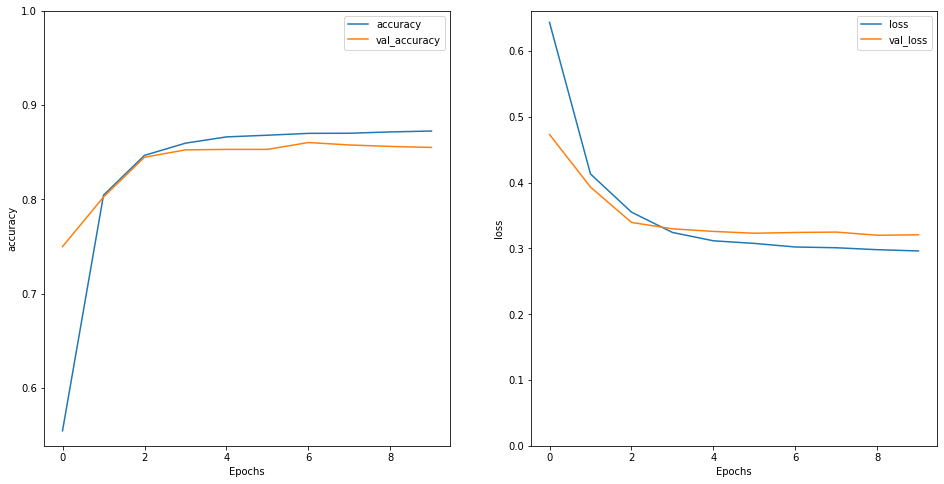

In [20]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [21]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](images/layered_bidirectional.png)

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [22]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [23]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [24]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10


  1/391 [..............................] - ETA: 1:46:59 - loss: 0.6928 - accuracy: 0.4375

  2/391 [..............................] - ETA: 1:01 - loss: 0.6931 - accuracy: 0.4531   

  3/391 [..............................] - ETA: 56s - loss: 0.6932 - accuracy: 0.4618 

  4/391 [..............................] - ETA: 54s - loss: 0.6931 - accuracy: 0.4616

  5/391 [..............................] - ETA: 55s - loss: 0.6931 - accuracy: 0.4618

  6/391 [..............................] - ETA: 55s - loss: 0.6931 - accuracy: 0.4634

  7/391 [..............................] - ETA: 55s - loss: 0.6931 - accuracy: 0.4651

  8/391 [..............................] - ETA: 53s - loss: 0.6931 - accuracy: 0.4665

  9/391 [..............................] - ETA: 50s - loss: 0.6931 - accuracy: 0.4674

 10/391 [..............................] - ETA: 51s - loss: 0.6931 - accuracy: 0.4683

 11/391 [..............................] - ETA: 51s - loss: 0.6931 - accuracy: 0.4695

 12/391 [..............................] - ETA: 52s - loss: 0.6931 - accuracy: 0.4709

 13/391 [..............................] - ETA: 52s - loss: 0.6931 - accuracy: 0.4718

 14/391 [>.............................] - ETA: 52s - loss: 0.6930 - accuracy: 0.4717

 15/391 [>.............................] - ETA: 52s - loss: 0.6930 - accuracy: 0.4715

 16/391 [>.............................] - ETA: 52s - loss: 0.6930 - accuracy: 0.4716

 17/391 [>.............................] - ETA: 50s - loss: 0.6930 - accuracy: 0.4719

 18/391 [>.............................] - ETA: 51s - loss: 0.6930 - accuracy: 0.4722

 19/391 [>.............................] - ETA: 50s - loss: 0.6930 - accuracy: 0.4725

 20/391 [>.............................] - ETA: 50s - loss: 0.6930 - accuracy: 0.4727

 21/391 [>.............................] - ETA: 50s - loss: 0.6930 - accuracy: 0.4732

 22/391 [>.............................] - ETA: 50s - loss: 0.6930 - accuracy: 0.4738

 23/391 [>.............................] - ETA: 50s - loss: 0.6930 - accuracy: 0.4741

 24/391 [>.............................] - ETA: 50s - loss: 0.6930 - accuracy: 0.4744

 25/391 [>.............................] - ETA: 50s - loss: 0.6930 - accuracy: 0.4743

 26/391 [>.............................] - ETA: 50s - loss: 0.6929 - accuracy: 0.4743

 27/391 [=>............................] - ETA: 50s - loss: 0.6929 - accuracy: 0.4743

 28/391 [=>............................] - ETA: 49s - loss: 0.6929 - accuracy: 0.4743

 29/391 [=>............................] - ETA: 49s - loss: 0.6929 - accuracy: 0.4744

 30/391 [=>............................] - ETA: 49s - loss: 0.6929 - accuracy: 0.4745

 31/391 [=>............................] - ETA: 50s - loss: 0.6929 - accuracy: 0.4746

 32/391 [=>............................] - ETA: 49s - loss: 0.6929 - accuracy: 0.4748

 33/391 [=>............................] - ETA: 49s - loss: 0.6929 - accuracy: 0.4751

 34/391 [=>............................] - ETA: 48s - loss: 0.6929 - accuracy: 0.4753

 35/391 [=>............................] - ETA: 48s - loss: 0.6929 - accuracy: 0.4755

 36/391 [=>............................] - ETA: 48s - loss: 0.6929 - accuracy: 0.4757

 37/391 [=>............................] - ETA: 48s - loss: 0.6929 - accuracy: 0.4758

 38/391 [=>............................] - ETA: 47s - loss: 0.6929 - accuracy: 0.4759

 39/391 [=>............................] - ETA: 47s - loss: 0.6929 - accuracy: 0.4761

 40/391 [==>...........................] - ETA: 47s - loss: 0.6929 - accuracy: 0.4762

 41/391 [==>...........................] - ETA: 47s - loss: 0.6929 - accuracy: 0.4763

 42/391 [==>...........................] - ETA: 47s - loss: 0.6929 - accuracy: 0.4764

 43/391 [==>...........................] - ETA: 47s - loss: 0.6929 - accuracy: 0.4765

 44/391 [==>...........................] - ETA: 46s - loss: 0.6929 - accuracy: 0.4766

 45/391 [==>...........................] - ETA: 46s - loss: 0.6929 - accuracy: 0.4767

 46/391 [==>...........................] - ETA: 46s - loss: 0.6929 - accuracy: 0.4768

 47/391 [==>...........................] - ETA: 46s - loss: 0.6929 - accuracy: 0.4769

 48/391 [==>...........................] - ETA: 46s - loss: 0.6928 - accuracy: 0.4770

 49/391 [==>...........................] - ETA: 46s - loss: 0.6928 - accuracy: 0.4771

 50/391 [==>...........................] - ETA: 46s - loss: 0.6928 - accuracy: 0.4772

 51/391 [==>...........................] - ETA: 46s - loss: 0.6928 - accuracy: 0.4772

 52/391 [==>...........................] - ETA: 46s - loss: 0.6928 - accuracy: 0.4773

 53/391 [===>..........................] - ETA: 46s - loss: 0.6928 - accuracy: 0.4774

 54/391 [===>..........................] - ETA: 46s - loss: 0.6928 - accuracy: 0.4774

 55/391 [===>..........................] - ETA: 46s - loss: 0.6928 - accuracy: 0.4775

 56/391 [===>..........................] - ETA: 45s - loss: 0.6928 - accuracy: 0.4776

 57/391 [===>..........................] - ETA: 45s - loss: 0.6928 - accuracy: 0.4777

 58/391 [===>..........................] - ETA: 45s - loss: 0.6928 - accuracy: 0.4778

 59/391 [===>..........................] - ETA: 45s - loss: 0.6928 - accuracy: 0.4779

 60/391 [===>..........................] - ETA: 44s - loss: 0.6928 - accuracy: 0.4780

 61/391 [===>..........................] - ETA: 44s - loss: 0.6928 - accuracy: 0.4781

 62/391 [===>..........................] - ETA: 44s - loss: 0.6928 - accuracy: 0.4782

 63/391 [===>..........................] - ETA: 44s - loss: 0.6928 - accuracy: 0.4783

 64/391 [===>..........................] - ETA: 44s - loss: 0.6928 - accuracy: 0.4785

 65/391 [===>..........................] - ETA: 43s - loss: 0.6928 - accuracy: 0.4786

 66/391 [====>.........................] - ETA: 43s - loss: 0.6928 - accuracy: 0.4787

 67/391 [====>.........................] - ETA: 43s - loss: 0.6928 - accuracy: 0.4788

 68/391 [====>.........................] - ETA: 43s - loss: 0.6928 - accuracy: 0.4789

 69/391 [====>.........................] - ETA: 43s - loss: 0.6928 - accuracy: 0.4791

 70/391 [====>.........................] - ETA: 43s - loss: 0.6928 - accuracy: 0.4792

 71/391 [====>.........................] - ETA: 42s - loss: 0.6928 - accuracy: 0.4793

 72/391 [====>.........................] - ETA: 42s - loss: 0.6928 - accuracy: 0.4794

 73/391 [====>.........................] - ETA: 42s - loss: 0.6928 - accuracy: 0.4795

 74/391 [====>.........................] - ETA: 42s - loss: 0.6928 - accuracy: 0.4797

 75/391 [====>.........................] - ETA: 42s - loss: 0.6928 - accuracy: 0.4798

 76/391 [====>.........................] - ETA: 42s - loss: 0.6928 - accuracy: 0.4799

 77/391 [====>.........................] - ETA: 42s - loss: 0.6928 - accuracy: 0.4800

 78/391 [====>.........................] - ETA: 42s - loss: 0.6928 - accuracy: 0.4802

 79/391 [=====>........................] - ETA: 41s - loss: 0.6928 - accuracy: 0.4803

 80/391 [=====>........................] - ETA: 42s - loss: 0.6928 - accuracy: 0.4805

 81/391 [=====>........................] - ETA: 42s - loss: 0.6928 - accuracy: 0.4807

 82/391 [=====>........................] - ETA: 42s - loss: 0.6928 - accuracy: 0.4808

 83/391 [=====>........................] - ETA: 42s - loss: 0.6928 - accuracy: 0.4810

 84/391 [=====>........................] - ETA: 42s - loss: 0.6928 - accuracy: 0.4811

 85/391 [=====>........................] - ETA: 42s - loss: 0.6928 - accuracy: 0.4812

 86/391 [=====>........................] - ETA: 41s - loss: 0.6928 - accuracy: 0.4814

 87/391 [=====>........................] - ETA: 41s - loss: 0.6928 - accuracy: 0.4815

 88/391 [=====>........................] - ETA: 41s - loss: 0.6928 - accuracy: 0.4817

 89/391 [=====>........................] - ETA: 41s - loss: 0.6928 - accuracy: 0.4818

 90/391 [=====>........................] - ETA: 41s - loss: 0.6928 - accuracy: 0.4820

 91/391 [=====>........................] - ETA: 41s - loss: 0.6928 - accuracy: 0.4821

 92/391 [======>.......................] - ETA: 41s - loss: 0.6928 - accuracy: 0.4822

 93/391 [======>.......................] - ETA: 41s - loss: 0.6928 - accuracy: 0.4824

 94/391 [======>.......................] - ETA: 40s - loss: 0.6928 - accuracy: 0.4825

 95/391 [======>.......................] - ETA: 40s - loss: 0.6928 - accuracy: 0.4826

 96/391 [======>.......................] - ETA: 40s - loss: 0.6928 - accuracy: 0.4827

 97/391 [======>.......................] - ETA: 40s - loss: 0.6928 - accuracy: 0.4829

 98/391 [======>.......................] - ETA: 40s - loss: 0.6928 - accuracy: 0.4830

 99/391 [======>.......................] - ETA: 40s - loss: 0.6928 - accuracy: 0.4831

100/391 [======>.......................] - ETA: 40s - loss: 0.6928 - accuracy: 0.4832

101/391 [======>.......................] - ETA: 39s - loss: 0.6928 - accuracy: 0.4834

102/391 [======>.......................] - ETA: 39s - loss: 0.6928 - accuracy: 0.4835

103/391 [======>.......................] - ETA: 39s - loss: 0.6928 - accuracy: 0.4836

104/391 [======>.......................] - ETA: 39s - loss: 0.6928 - accuracy: 0.4837

105/391 [=======>......................] - ETA: 39s - loss: 0.6928 - accuracy: 0.4839

106/391 [=======>......................] - ETA: 39s - loss: 0.6928 - accuracy: 0.4840

107/391 [=======>......................] - ETA: 39s - loss: 0.6928 - accuracy: 0.4841

108/391 [=======>......................] - ETA: 39s - loss: 0.6928 - accuracy: 0.4842

109/391 [=======>......................] - ETA: 39s - loss: 0.6928 - accuracy: 0.4843

110/391 [=======>......................] - ETA: 39s - loss: 0.6928 - accuracy: 0.4845

111/391 [=======>......................] - ETA: 38s - loss: 0.6928 - accuracy: 0.4846

112/391 [=======>......................] - ETA: 38s - loss: 0.6928 - accuracy: 0.4847

113/391 [=======>......................] - ETA: 38s - loss: 0.6928 - accuracy: 0.4848

114/391 [=======>......................] - ETA: 38s - loss: 0.6928 - accuracy: 0.4849

115/391 [=======>......................] - ETA: 38s - loss: 0.6928 - accuracy: 0.4850

116/391 [=======>......................] - ETA: 37s - loss: 0.6927 - accuracy: 0.4851

117/391 [=======>......................] - ETA: 37s - loss: 0.6927 - accuracy: 0.4852

118/391 [========>.....................] - ETA: 37s - loss: 0.6927 - accuracy: 0.4853

119/391 [========>.....................] - ETA: 37s - loss: 0.6927 - accuracy: 0.4853

120/391 [========>.....................] - ETA: 37s - loss: 0.6927 - accuracy: 0.4854

121/391 [========>.....................] - ETA: 37s - loss: 0.6927 - accuracy: 0.4855

122/391 [========>.....................] - ETA: 37s - loss: 0.6927 - accuracy: 0.4855

123/391 [========>.....................] - ETA: 36s - loss: 0.6927 - accuracy: 0.4856

124/391 [========>.....................] - ETA: 36s - loss: 0.6927 - accuracy: 0.4857

125/391 [========>.....................] - ETA: 36s - loss: 0.6927 - accuracy: 0.4857

126/391 [========>.....................] - ETA: 36s - loss: 0.6927 - accuracy: 0.4858

127/391 [========>.....................] - ETA: 36s - loss: 0.6927 - accuracy: 0.4858

128/391 [========>.....................] - ETA: 36s - loss: 0.6927 - accuracy: 0.4859

129/391 [========>.....................] - ETA: 35s - loss: 0.6927 - accuracy: 0.4860

130/391 [========>.....................] - ETA: 35s - loss: 0.6927 - accuracy: 0.4860

131/391 [=========>....................] - ETA: 35s - loss: 0.6927 - accuracy: 0.4861

132/391 [=========>....................] - ETA: 35s - loss: 0.6927 - accuracy: 0.4861

133/391 [=========>....................] - ETA: 35s - loss: 0.6927 - accuracy: 0.4862

134/391 [=========>....................] - ETA: 35s - loss: 0.6927 - accuracy: 0.4863

135/391 [=========>....................] - ETA: 35s - loss: 0.6927 - accuracy: 0.4863

136/391 [=========>....................] - ETA: 34s - loss: 0.6927 - accuracy: 0.4864

137/391 [=========>....................] - ETA: 34s - loss: 0.6927 - accuracy: 0.4864

138/391 [=========>....................] - ETA: 34s - loss: 0.6927 - accuracy: 0.4865

139/391 [=========>....................] - ETA: 34s - loss: 0.6927 - accuracy: 0.4865

140/391 [=========>....................] - ETA: 34s - loss: 0.6927 - accuracy: 0.4866

141/391 [=========>....................] - ETA: 34s - loss: 0.6927 - accuracy: 0.4866

142/391 [=========>....................] - ETA: 34s - loss: 0.6927 - accuracy: 0.4867

143/391 [=========>....................] - ETA: 34s - loss: 0.6927 - accuracy: 0.4867

144/391 [==========>...................] - ETA: 33s - loss: 0.6927 - accuracy: 0.4868

145/391 [==========>...................] - ETA: 33s - loss: 0.6927 - accuracy: 0.4868

146/391 [==========>...................] - ETA: 33s - loss: 0.6927 - accuracy: 0.4869

147/391 [==========>...................] - ETA: 33s - loss: 0.6927 - accuracy: 0.4869

148/391 [==========>...................] - ETA: 33s - loss: 0.6927 - accuracy: 0.4869

149/391 [==========>...................] - ETA: 33s - loss: 0.6927 - accuracy: 0.4870

150/391 [==========>...................] - ETA: 33s - loss: 0.6927 - accuracy: 0.4870

151/391 [==========>...................] - ETA: 33s - loss: 0.6927 - accuracy: 0.4871

152/391 [==========>...................] - ETA: 33s - loss: 0.6927 - accuracy: 0.4871

153/391 [==========>...................] - ETA: 32s - loss: 0.6927 - accuracy: 0.4871

154/391 [==========>...................] - ETA: 32s - loss: 0.6927 - accuracy: 0.4872

155/391 [==========>...................] - ETA: 32s - loss: 0.6927 - accuracy: 0.4872

156/391 [==========>...................] - ETA: 32s - loss: 0.6927 - accuracy: 0.4872

157/391 [===========>..................] - ETA: 32s - loss: 0.6927 - accuracy: 0.4873

158/391 [===========>..................] - ETA: 32s - loss: 0.6927 - accuracy: 0.4873

159/391 [===========>..................] - ETA: 32s - loss: 0.6927 - accuracy: 0.4873

160/391 [===========>..................] - ETA: 32s - loss: 0.6927 - accuracy: 0.4873

161/391 [===========>..................] - ETA: 31s - loss: 0.6926 - accuracy: 0.4874

162/391 [===========>..................] - ETA: 31s - loss: 0.6926 - accuracy: 0.4874

163/391 [===========>..................] - ETA: 31s - loss: 0.6926 - accuracy: 0.4874

164/391 [===========>..................] - ETA: 31s - loss: 0.6926 - accuracy: 0.4874

165/391 [===========>..................] - ETA: 31s - loss: 0.6926 - accuracy: 0.4874

166/391 [===========>..................] - ETA: 31s - loss: 0.6926 - accuracy: 0.4875

167/391 [===========>..................] - ETA: 31s - loss: 0.6926 - accuracy: 0.4875

168/391 [===========>..................] - ETA: 31s - loss: 0.6926 - accuracy: 0.4875

169/391 [===========>..................] - ETA: 30s - loss: 0.6926 - accuracy: 0.4875

170/391 [============>.................] - ETA: 30s - loss: 0.6926 - accuracy: 0.4875

171/391 [============>.................] - ETA: 30s - loss: 0.6926 - accuracy: 0.4876

172/391 [============>.................] - ETA: 30s - loss: 0.6926 - accuracy: 0.4876

173/391 [============>.................] - ETA: 30s - loss: 0.6926 - accuracy: 0.4876

174/391 [============>.................] - ETA: 30s - loss: 0.6926 - accuracy: 0.4876

175/391 [============>.................] - ETA: 30s - loss: 0.6926 - accuracy: 0.4877

176/391 [============>.................] - ETA: 29s - loss: 0.6926 - accuracy: 0.4877

177/391 [============>.................] - ETA: 29s - loss: 0.6926 - accuracy: 0.4877

178/391 [============>.................] - ETA: 29s - loss: 0.6926 - accuracy: 0.4878

179/391 [============>.................] - ETA: 29s - loss: 0.6926 - accuracy: 0.4878

180/391 [============>.................] - ETA: 29s - loss: 0.6926 - accuracy: 0.4878

181/391 [============>.................] - ETA: 29s - loss: 0.6926 - accuracy: 0.4879

182/391 [============>.................] - ETA: 29s - loss: 0.6926 - accuracy: 0.4879

183/391 [=============>................] - ETA: 28s - loss: 0.6926 - accuracy: 0.4880

184/391 [=============>................] - ETA: 28s - loss: 0.6926 - accuracy: 0.4880

185/391 [=============>................] - ETA: 28s - loss: 0.6926 - accuracy: 0.4880

186/391 [=============>................] - ETA: 28s - loss: 0.6926 - accuracy: 0.4881

187/391 [=============>................] - ETA: 28s - loss: 0.6926 - accuracy: 0.4881

188/391 [=============>................] - ETA: 28s - loss: 0.6926 - accuracy: 0.4881

189/391 [=============>................] - ETA: 28s - loss: 0.6925 - accuracy: 0.4882

190/391 [=============>................] - ETA: 27s - loss: 0.6925 - accuracy: 0.4882

191/391 [=============>................] - ETA: 27s - loss: 0.6925 - accuracy: 0.4883

192/391 [=============>................] - ETA: 27s - loss: 0.6925 - accuracy: 0.4883

193/391 [=============>................] - ETA: 27s - loss: 0.6925 - accuracy: 0.4883

194/391 [=============>................] - ETA: 27s - loss: 0.6925 - accuracy: 0.4884

195/391 [=============>................] - ETA: 27s - loss: 0.6925 - accuracy: 0.4884

196/391 [==============>...............] - ETA: 27s - loss: 0.6925 - accuracy: 0.4884

197/391 [==============>...............] - ETA: 27s - loss: 0.6925 - accuracy: 0.4885

198/391 [==============>...............] - ETA: 26s - loss: 0.6925 - accuracy: 0.4885

199/391 [==============>...............] - ETA: 26s - loss: 0.6925 - accuracy: 0.4885

200/391 [==============>...............] - ETA: 26s - loss: 0.6925 - accuracy: 0.4886

201/391 [==============>...............] - ETA: 26s - loss: 0.6925 - accuracy: 0.4886

202/391 [==============>...............] - ETA: 26s - loss: 0.6925 - accuracy: 0.4887

203/391 [==============>...............] - ETA: 26s - loss: 0.6925 - accuracy: 0.4887

204/391 [==============>...............] - ETA: 26s - loss: 0.6925 - accuracy: 0.4887

205/391 [==============>...............] - ETA: 26s - loss: 0.6925 - accuracy: 0.4888

206/391 [==============>...............] - ETA: 25s - loss: 0.6925 - accuracy: 0.4888

207/391 [==============>...............] - ETA: 25s - loss: 0.6925 - accuracy: 0.4888

208/391 [==============>...............] - ETA: 25s - loss: 0.6925 - accuracy: 0.4889

209/391 [===============>..............] - ETA: 25s - loss: 0.6925 - accuracy: 0.4889

210/391 [===============>..............] - ETA: 25s - loss: 0.6925 - accuracy: 0.4889

211/391 [===============>..............] - ETA: 25s - loss: 0.6925 - accuracy: 0.4890

212/391 [===============>..............] - ETA: 24s - loss: 0.6925 - accuracy: 0.4890

213/391 [===============>..............] - ETA: 24s - loss: 0.6924 - accuracy: 0.4890

214/391 [===============>..............] - ETA: 24s - loss: 0.6924 - accuracy: 0.4891

215/391 [===============>..............] - ETA: 24s - loss: 0.6924 - accuracy: 0.4891

216/391 [===============>..............] - ETA: 24s - loss: 0.6924 - accuracy: 0.4891

217/391 [===============>..............] - ETA: 24s - loss: 0.6924 - accuracy: 0.4892

218/391 [===============>..............] - ETA: 24s - loss: 0.6924 - accuracy: 0.4892

219/391 [===============>..............] - ETA: 24s - loss: 0.6924 - accuracy: 0.4892

220/391 [===============>..............] - ETA: 23s - loss: 0.6924 - accuracy: 0.4893

221/391 [===============>..............] - ETA: 23s - loss: 0.6924 - accuracy: 0.4893

222/391 [================>.............] - ETA: 23s - loss: 0.6924 - accuracy: 0.4893

223/391 [================>.............] - ETA: 23s - loss: 0.6924 - accuracy: 0.4894

224/391 [================>.............] - ETA: 23s - loss: 0.6924 - accuracy: 0.4894

225/391 [================>.............] - ETA: 23s - loss: 0.6924 - accuracy: 0.4894

226/391 [================>.............] - ETA: 23s - loss: 0.6924 - accuracy: 0.4895

227/391 [================>.............] - ETA: 22s - loss: 0.6924 - accuracy: 0.4895

228/391 [================>.............] - ETA: 22s - loss: 0.6924 - accuracy: 0.4895

229/391 [================>.............] - ETA: 22s - loss: 0.6923 - accuracy: 0.4895

230/391 [================>.............] - ETA: 22s - loss: 0.6923 - accuracy: 0.4896

231/391 [================>.............] - ETA: 22s - loss: 0.6923 - accuracy: 0.4896

232/391 [================>.............] - ETA: 22s - loss: 0.6923 - accuracy: 0.4896

233/391 [================>.............] - ETA: 22s - loss: 0.6923 - accuracy: 0.4896

234/391 [================>.............] - ETA: 22s - loss: 0.6923 - accuracy: 0.4897

235/391 [=================>............] - ETA: 21s - loss: 0.6923 - accuracy: 0.4897

236/391 [=================>............] - ETA: 21s - loss: 0.6923 - accuracy: 0.4897

237/391 [=================>............] - ETA: 21s - loss: 0.6923 - accuracy: 0.4898

238/391 [=================>............] - ETA: 21s - loss: 0.6923 - accuracy: 0.4898

239/391 [=================>............] - ETA: 21s - loss: 0.6922 - accuracy: 0.4898

240/391 [=================>............] - ETA: 21s - loss: 0.6922 - accuracy: 0.4899

241/391 [=================>............] - ETA: 21s - loss: 0.6922 - accuracy: 0.4899

242/391 [=================>............] - ETA: 20s - loss: 0.6922 - accuracy: 0.4899

243/391 [=================>............] - ETA: 20s - loss: 0.6922 - accuracy: 0.4900

244/391 [=================>............] - ETA: 20s - loss: 0.6922 - accuracy: 0.4900

245/391 [=================>............] - ETA: 20s - loss: 0.6922 - accuracy: 0.4901

246/391 [=================>............] - ETA: 20s - loss: 0.6921 - accuracy: 0.4901

247/391 [=================>............] - ETA: 20s - loss: 0.6921 - accuracy: 0.4902

248/391 [==================>...........] - ETA: 20s - loss: 0.6921 - accuracy: 0.4902

249/391 [==================>...........] - ETA: 19s - loss: 0.6921 - accuracy: 0.4903

250/391 [==================>...........] - ETA: 19s - loss: 0.6921 - accuracy: 0.4903

251/391 [==================>...........] - ETA: 19s - loss: 0.6920 - accuracy: 0.4904

252/391 [==================>...........] - ETA: 19s - loss: 0.6920 - accuracy: 0.4904

253/391 [==================>...........] - ETA: 19s - loss: 0.6920 - accuracy: 0.4905

254/391 [==================>...........] - ETA: 19s - loss: 0.6920 - accuracy: 0.4905

255/391 [==================>...........] - ETA: 19s - loss: 0.6919 - accuracy: 0.4906

256/391 [==================>...........] - ETA: 18s - loss: 0.6919 - accuracy: 0.4907

257/391 [==================>...........] - ETA: 18s - loss: 0.6919 - accuracy: 0.4907

258/391 [==================>...........] - ETA: 18s - loss: 0.6919 - accuracy: 0.4908

259/391 [==================>...........] - ETA: 18s - loss: 0.6918 - accuracy: 0.4909

260/391 [==================>...........] - ETA: 18s - loss: 0.6918 - accuracy: 0.4909

261/391 [===================>..........] - ETA: 18s - loss: 0.6918 - accuracy: 0.4910

262/391 [===================>..........] - ETA: 18s - loss: 0.6917 - accuracy: 0.4911

263/391 [===================>..........] - ETA: 17s - loss: 0.6917 - accuracy: 0.4912

264/391 [===================>..........] - ETA: 17s - loss: 0.6917 - accuracy: 0.4912

265/391 [===================>..........] - ETA: 17s - loss: 0.6916 - accuracy: 0.4913

266/391 [===================>..........] - ETA: 17s - loss: 0.6916 - accuracy: 0.4914

267/391 [===================>..........] - ETA: 17s - loss: 0.6916 - accuracy: 0.4915

268/391 [===================>..........] - ETA: 17s - loss: 0.6915 - accuracy: 0.4916

269/391 [===================>..........] - ETA: 17s - loss: 0.6915 - accuracy: 0.4916

270/391 [===================>..........] - ETA: 16s - loss: 0.6915 - accuracy: 0.4917

271/391 [===================>..........] - ETA: 16s - loss: 0.6914 - accuracy: 0.4918

272/391 [===================>..........] - ETA: 16s - loss: 0.6914 - accuracy: 0.4919

273/391 [===================>..........] - ETA: 16s - loss: 0.6913 - accuracy: 0.4920

274/391 [====================>.........] - ETA: 16s - loss: 0.6913 - accuracy: 0.4921

275/391 [====================>.........] - ETA: 16s - loss: 0.6913 - accuracy: 0.4922

276/391 [====================>.........] - ETA: 16s - loss: 0.6912 - accuracy: 0.4923

277/391 [====================>.........] - ETA: 16s - loss: 0.6912 - accuracy: 0.4923

278/391 [====================>.........] - ETA: 15s - loss: 0.6912 - accuracy: 0.4924

279/391 [====================>.........] - ETA: 15s - loss: 0.6911 - accuracy: 0.4925

280/391 [====================>.........] - ETA: 15s - loss: 0.6911 - accuracy: 0.4926

281/391 [====================>.........] - ETA: 15s - loss: 0.6910 - accuracy: 0.4927

282/391 [====================>.........] - ETA: 15s - loss: 0.6910 - accuracy: 0.4928

283/391 [====================>.........] - ETA: 15s - loss: 0.6909 - accuracy: 0.4928

284/391 [====================>.........] - ETA: 15s - loss: 0.6909 - accuracy: 0.4929

285/391 [====================>.........] - ETA: 14s - loss: 0.6909 - accuracy: 0.4930

286/391 [====================>.........] - ETA: 14s - loss: 0.6908 - accuracy: 0.4931

287/391 [=====================>........] - ETA: 14s - loss: 0.6908 - accuracy: 0.4932

288/391 [=====================>........] - ETA: 14s - loss: 0.6907 - accuracy: 0.4933

289/391 [=====================>........] - ETA: 14s - loss: 0.6907 - accuracy: 0.4934

290/391 [=====================>........] - ETA: 14s - loss: 0.6906 - accuracy: 0.4935

291/391 [=====================>........] - ETA: 14s - loss: 0.6906 - accuracy: 0.4936

292/391 [=====================>........] - ETA: 13s - loss: 0.6905 - accuracy: 0.4937

293/391 [=====================>........] - ETA: 13s - loss: 0.6905 - accuracy: 0.4938

294/391 [=====================>........] - ETA: 13s - loss: 0.6904 - accuracy: 0.4939

295/391 [=====================>........] - ETA: 13s - loss: 0.6904 - accuracy: 0.4940

296/391 [=====================>........] - ETA: 13s - loss: 0.6903 - accuracy: 0.4941

297/391 [=====================>........] - ETA: 13s - loss: 0.6902 - accuracy: 0.4942

298/391 [=====================>........] - ETA: 13s - loss: 0.6902 - accuracy: 0.4943

299/391 [=====================>........] - ETA: 13s - loss: 0.6901 - accuracy: 0.4944

300/391 [======================>.......] - ETA: 12s - loss: 0.6901 - accuracy: 0.4945

301/391 [======================>.......] - ETA: 12s - loss: 0.6900 - accuracy: 0.4946

302/391 [======================>.......] - ETA: 12s - loss: 0.6899 - accuracy: 0.4947

303/391 [======================>.......] - ETA: 12s - loss: 0.6899 - accuracy: 0.4948

304/391 [======================>.......] - ETA: 12s - loss: 0.6898 - accuracy: 0.4949

305/391 [======================>.......] - ETA: 12s - loss: 0.6897 - accuracy: 0.4951

306/391 [======================>.......] - ETA: 12s - loss: 0.6897 - accuracy: 0.4952

307/391 [======================>.......] - ETA: 11s - loss: 0.6896 - accuracy: 0.4953

308/391 [======================>.......] - ETA: 11s - loss: 0.6895 - accuracy: 0.4954

309/391 [======================>.......] - ETA: 11s - loss: 0.6894 - accuracy: 0.4955

310/391 [======================>.......] - ETA: 11s - loss: 0.6894 - accuracy: 0.4957

311/391 [======================>.......] - ETA: 11s - loss: 0.6893 - accuracy: 0.4958

312/391 [======================>.......] - ETA: 11s - loss: 0.6892 - accuracy: 0.4959

313/391 [=======================>......] - ETA: 11s - loss: 0.6891 - accuracy: 0.4961

314/391 [=======================>......] - ETA: 10s - loss: 0.6890 - accuracy: 0.4962

315/391 [=======================>......] - ETA: 10s - loss: 0.6890 - accuracy: 0.4963

316/391 [=======================>......] - ETA: 10s - loss: 0.6889 - accuracy: 0.4965

317/391 [=======================>......] - ETA: 10s - loss: 0.6888 - accuracy: 0.4966

318/391 [=======================>......] - ETA: 10s - loss: 0.6887 - accuracy: 0.4967

319/391 [=======================>......] - ETA: 10s - loss: 0.6886 - accuracy: 0.4969

320/391 [=======================>......] - ETA: 10s - loss: 0.6885 - accuracy: 0.4970

321/391 [=======================>......] - ETA: 9s - loss: 0.6885 - accuracy: 0.4971 

322/391 [=======================>......] - ETA: 9s - loss: 0.6884 - accuracy: 0.4973

323/391 [=======================>......] - ETA: 9s - loss: 0.6883 - accuracy: 0.4974

324/391 [=======================>......] - ETA: 9s - loss: 0.6882 - accuracy: 0.4976

325/391 [=======================>......] - ETA: 9s - loss: 0.6881 - accuracy: 0.4977

326/391 [========================>.....] - ETA: 9s - loss: 0.6880 - accuracy: 0.4979

327/391 [========================>.....] - ETA: 9s - loss: 0.6879 - accuracy: 0.4980

328/391 [========================>.....] - ETA: 8s - loss: 0.6878 - accuracy: 0.4982

329/391 [========================>.....] - ETA: 8s - loss: 0.6877 - accuracy: 0.4983

330/391 [========================>.....] - ETA: 8s - loss: 0.6876 - accuracy: 0.4985

331/391 [========================>.....] - ETA: 8s - loss: 0.6875 - accuracy: 0.4986

332/391 [========================>.....] - ETA: 8s - loss: 0.6874 - accuracy: 0.4988

333/391 [========================>.....] - ETA: 8s - loss: 0.6873 - accuracy: 0.4990

334/391 [========================>.....] - ETA: 8s - loss: 0.6872 - accuracy: 0.4991

335/391 [========================>.....] - ETA: 7s - loss: 0.6871 - accuracy: 0.4993

336/391 [========================>.....] - ETA: 7s - loss: 0.6870 - accuracy: 0.4994

337/391 [========================>.....] - ETA: 7s - loss: 0.6869 - accuracy: 0.4996

338/391 [========================>.....] - ETA: 7s - loss: 0.6868 - accuracy: 0.4998

339/391 [=========================>....] - ETA: 7s - loss: 0.6867 - accuracy: 0.4999

340/391 [=========================>....] - ETA: 7s - loss: 0.6866 - accuracy: 0.5001

341/391 [=========================>....] - ETA: 7s - loss: 0.6865 - accuracy: 0.5002

342/391 [=========================>....] - ETA: 6s - loss: 0.6864 - accuracy: 0.5004

343/391 [=========================>....] - ETA: 6s - loss: 0.6863 - accuracy: 0.5006

344/391 [=========================>....] - ETA: 6s - loss: 0.6862 - accuracy: 0.5007

345/391 [=========================>....] - ETA: 6s - loss: 0.6861 - accuracy: 0.5009

346/391 [=========================>....] - ETA: 6s - loss: 0.6860 - accuracy: 0.5011

347/391 [=========================>....] - ETA: 6s - loss: 0.6858 - accuracy: 0.5013

348/391 [=========================>....] - ETA: 6s - loss: 0.6857 - accuracy: 0.5014

349/391 [=========================>....] - ETA: 5s - loss: 0.6856 - accuracy: 0.5016

350/391 [=========================>....] - ETA: 5s - loss: 0.6855 - accuracy: 0.5018

351/391 [=========================>....] - ETA: 5s - loss: 0.6854 - accuracy: 0.5019

352/391 [==========================>...] - ETA: 5s - loss: 0.6853 - accuracy: 0.5021

353/391 [==========================>...] - ETA: 5s - loss: 0.6852 - accuracy: 0.5023

354/391 [==========================>...] - ETA: 5s - loss: 0.6850 - accuracy: 0.5025

355/391 [==========================>...] - ETA: 5s - loss: 0.6849 - accuracy: 0.5027

356/391 [==========================>...] - ETA: 4s - loss: 0.6848 - accuracy: 0.5028

357/391 [==========================>...] - ETA: 4s - loss: 0.6847 - accuracy: 0.5030

358/391 [==========================>...] - ETA: 4s - loss: 0.6846 - accuracy: 0.5032

359/391 [==========================>...] - ETA: 4s - loss: 0.6844 - accuracy: 0.5034

360/391 [==========================>...] - ETA: 4s - loss: 0.6843 - accuracy: 0.5036

361/391 [==========================>...] - ETA: 4s - loss: 0.6842 - accuracy: 0.5037

362/391 [==========================>...] - ETA: 4s - loss: 0.6841 - accuracy: 0.5039

363/391 [==========================>...] - ETA: 3s - loss: 0.6839 - accuracy: 0.5041

364/391 [==========================>...] - ETA: 3s - loss: 0.6838 - accuracy: 0.5043

365/391 [===========================>..] - ETA: 3s - loss: 0.6837 - accuracy: 0.5045

366/391 [===========================>..] - ETA: 3s - loss: 0.6836 - accuracy: 0.5047

367/391 [===========================>..] - ETA: 3s - loss: 0.6834 - accuracy: 0.5048

368/391 [===========================>..] - ETA: 3s - loss: 0.6833 - accuracy: 0.5050

369/391 [===========================>..] - ETA: 3s - loss: 0.6832 - accuracy: 0.5052

370/391 [===========================>..] - ETA: 2s - loss: 0.6831 - accuracy: 0.5054

371/391 [===========================>..] - ETA: 2s - loss: 0.6829 - accuracy: 0.5056

372/391 [===========================>..] - ETA: 2s - loss: 0.6828 - accuracy: 0.5058

373/391 [===========================>..] - ETA: 2s - loss: 0.6827 - accuracy: 0.5060

374/391 [===========================>..] - ETA: 2s - loss: 0.6825 - accuracy: 0.5062

375/391 [===========================>..] - ETA: 2s - loss: 0.6824 - accuracy: 0.5064

376/391 [===========================>..] - ETA: 2s - loss: 0.6823 - accuracy: 0.5066

377/391 [===========================>..] - ETA: 1s - loss: 0.6821 - accuracy: 0.5067

378/391 [============================>.] - ETA: 1s - loss: 0.6820 - accuracy: 0.5069

379/391 [============================>.] - ETA: 1s - loss: 0.6819 - accuracy: 0.5071

380/391 [============================>.] - ETA: 1s - loss: 0.6817 - accuracy: 0.5073

381/391 [============================>.] - ETA: 1s - loss: 0.6816 - accuracy: 0.5075

382/391 [============================>.] - ETA: 1s - loss: 0.6815 - accuracy: 0.5077

383/391 [============================>.] - ETA: 1s - loss: 0.6813 - accuracy: 0.5079

384/391 [============================>.] - ETA: 0s - loss: 0.6812 - accuracy: 0.5081

385/391 [============================>.] - ETA: 0s - loss: 0.6810 - accuracy: 0.5083

386/391 [============================>.] - ETA: 0s - loss: 0.6809 - accuracy: 0.5085

387/391 [============================>.] - ETA: 0s - loss: 0.6808 - accuracy: 0.5087

388/391 [============================>.] - ETA: 0s - loss: 0.6806 - accuracy: 0.5089

389/391 [============================>.] - ETA: 0s - loss: 0.6805 - accuracy: 0.5091

390/391 [============================>.] - ETA: 0s - loss: 0.6804 - accuracy: 0.5093

391/391 [==============================] - ETA: 0s - loss: 0.6802 - accuracy: 0.5095

391/391 [==============================] - 80s 162ms/step - loss: 0.6801 - accuracy: 0.5097 - val_loss: 0.4260 - val_accuracy: 0.8135


Epoch 2/10


  1/391 [..............................] - ETA: 12:03 - loss: 0.4356 - accuracy: 0.8281

  2/391 [..............................] - ETA: 2:33 - loss: 0.4212 - accuracy: 0.8242 

  3/391 [..............................] - ETA: 1:39 - loss: 0.4182 - accuracy: 0.8186

  4/391 [..............................] - ETA: 1:24 - loss: 0.4153 - accuracy: 0.8151

  5/391 [..............................] - ETA: 1:18 - loss: 0.4142 - accuracy: 0.8152

  6/391 [..............................] - ETA: 1:12 - loss: 0.4157 - accuracy: 0.8135

  7/391 [..............................] - ETA: 1:09 - loss: 0.4153 - accuracy: 0.8136

  8/391 [..............................] - ETA: 1:07 - loss: 0.4152 - accuracy: 0.8140

  9/391 [..............................] - ETA: 1:04 - loss: 0.4147 - accuracy: 0.8150

 10/391 [..............................] - ETA: 1:03 - loss: 0.4147 - accuracy: 0.8157

 11/391 [..............................] - ETA: 1:01 - loss: 0.4147 - accuracy: 0.8159

 12/391 [..............................] - ETA: 1:01 - loss: 0.4151 - accuracy: 0.8158

 13/391 [..............................] - ETA: 1:00 - loss: 0.4153 - accuracy: 0.8159

 14/391 [>.............................] - ETA: 59s - loss: 0.4149 - accuracy: 0.8162 

 15/391 [>.............................] - ETA: 59s - loss: 0.4141 - accuracy: 0.8168

 16/391 [>.............................] - ETA: 58s - loss: 0.4135 - accuracy: 0.8174

 17/391 [>.............................] - ETA: 58s - loss: 0.4129 - accuracy: 0.8179

 18/391 [>.............................] - ETA: 57s - loss: 0.4121 - accuracy: 0.8184

 19/391 [>.............................] - ETA: 57s - loss: 0.4115 - accuracy: 0.8188

 20/391 [>.............................] - ETA: 56s - loss: 0.4112 - accuracy: 0.8190

 21/391 [>.............................] - ETA: 55s - loss: 0.4108 - accuracy: 0.8193

 22/391 [>.............................] - ETA: 55s - loss: 0.4107 - accuracy: 0.8195

 23/391 [>.............................] - ETA: 54s - loss: 0.4106 - accuracy: 0.8197

 24/391 [>.............................] - ETA: 54s - loss: 0.4103 - accuracy: 0.8201

 25/391 [>.............................] - ETA: 54s - loss: 0.4102 - accuracy: 0.8202

 26/391 [>.............................] - ETA: 54s - loss: 0.4100 - accuracy: 0.8205

 27/391 [=>............................] - ETA: 54s - loss: 0.4101 - accuracy: 0.8206

 28/391 [=>............................] - ETA: 53s - loss: 0.4101 - accuracy: 0.8206

 29/391 [=>............................] - ETA: 53s - loss: 0.4100 - accuracy: 0.8207

 30/391 [=>............................] - ETA: 53s - loss: 0.4100 - accuracy: 0.8208

 31/391 [=>............................] - ETA: 53s - loss: 0.4099 - accuracy: 0.8209

 32/391 [=>............................] - ETA: 53s - loss: 0.4098 - accuracy: 0.8209

 33/391 [=>............................] - ETA: 52s - loss: 0.4097 - accuracy: 0.8211

 34/391 [=>............................] - ETA: 52s - loss: 0.4096 - accuracy: 0.8212

 35/391 [=>............................] - ETA: 52s - loss: 0.4094 - accuracy: 0.8214

 36/391 [=>............................] - ETA: 52s - loss: 0.4092 - accuracy: 0.8215

 37/391 [=>............................] - ETA: 51s - loss: 0.4092 - accuracy: 0.8215

 38/391 [=>............................] - ETA: 51s - loss: 0.4091 - accuracy: 0.8216

 39/391 [=>............................] - ETA: 51s - loss: 0.4091 - accuracy: 0.8216

 40/391 [==>...........................] - ETA: 51s - loss: 0.4091 - accuracy: 0.8217

 41/391 [==>...........................] - ETA: 50s - loss: 0.4091 - accuracy: 0.8217

 42/391 [==>...........................] - ETA: 50s - loss: 0.4091 - accuracy: 0.8217

 43/391 [==>...........................] - ETA: 50s - loss: 0.4092 - accuracy: 0.8216

 44/391 [==>...........................] - ETA: 49s - loss: 0.4092 - accuracy: 0.8217

 45/391 [==>...........................] - ETA: 49s - loss: 0.4093 - accuracy: 0.8217

 46/391 [==>...........................] - ETA: 49s - loss: 0.4093 - accuracy: 0.8217

 47/391 [==>...........................] - ETA: 49s - loss: 0.4093 - accuracy: 0.8217

 48/391 [==>...........................] - ETA: 49s - loss: 0.4093 - accuracy: 0.8217

 49/391 [==>...........................] - ETA: 49s - loss: 0.4093 - accuracy: 0.8218

 50/391 [==>...........................] - ETA: 48s - loss: 0.4092 - accuracy: 0.8218

 51/391 [==>...........................] - ETA: 48s - loss: 0.4092 - accuracy: 0.8218

 52/391 [==>...........................] - ETA: 49s - loss: 0.4092 - accuracy: 0.8218

 53/391 [===>..........................] - ETA: 48s - loss: 0.4092 - accuracy: 0.8217

 54/391 [===>..........................] - ETA: 48s - loss: 0.4092 - accuracy: 0.8217

 55/391 [===>..........................] - ETA: 48s - loss: 0.4093 - accuracy: 0.8217

 56/391 [===>..........................] - ETA: 48s - loss: 0.4093 - accuracy: 0.8217

 57/391 [===>..........................] - ETA: 48s - loss: 0.4093 - accuracy: 0.8216

 58/391 [===>..........................] - ETA: 48s - loss: 0.4093 - accuracy: 0.8216

 59/391 [===>..........................] - ETA: 47s - loss: 0.4093 - accuracy: 0.8216

 60/391 [===>..........................] - ETA: 47s - loss: 0.4093 - accuracy: 0.8216

 61/391 [===>..........................] - ETA: 47s - loss: 0.4093 - accuracy: 0.8216

 62/391 [===>..........................] - ETA: 48s - loss: 0.4094 - accuracy: 0.8216

 63/391 [===>..........................] - ETA: 47s - loss: 0.4094 - accuracy: 0.8216

 64/391 [===>..........................] - ETA: 47s - loss: 0.4095 - accuracy: 0.8216

 65/391 [===>..........................] - ETA: 47s - loss: 0.4095 - accuracy: 0.8216

 66/391 [====>.........................] - ETA: 47s - loss: 0.4096 - accuracy: 0.8215

 67/391 [====>.........................] - ETA: 47s - loss: 0.4097 - accuracy: 0.8215

 68/391 [====>.........................] - ETA: 47s - loss: 0.4098 - accuracy: 0.8214

 69/391 [====>.........................] - ETA: 46s - loss: 0.4099 - accuracy: 0.8213

 70/391 [====>.........................] - ETA: 46s - loss: 0.4100 - accuracy: 0.8213

 71/391 [====>.........................] - ETA: 46s - loss: 0.4101 - accuracy: 0.8212

 72/391 [====>.........................] - ETA: 46s - loss: 0.4102 - accuracy: 0.8212

 73/391 [====>.........................] - ETA: 46s - loss: 0.4103 - accuracy: 0.8211

 74/391 [====>.........................] - ETA: 45s - loss: 0.4104 - accuracy: 0.8211

 75/391 [====>.........................] - ETA: 45s - loss: 0.4105 - accuracy: 0.8211

 76/391 [====>.........................] - ETA: 45s - loss: 0.4105 - accuracy: 0.8211

 77/391 [====>.........................] - ETA: 45s - loss: 0.4106 - accuracy: 0.8210

 78/391 [====>.........................] - ETA: 45s - loss: 0.4107 - accuracy: 0.8210

 79/391 [=====>........................] - ETA: 45s - loss: 0.4108 - accuracy: 0.8210

 80/391 [=====>........................] - ETA: 45s - loss: 0.4108 - accuracy: 0.8209

 81/391 [=====>........................] - ETA: 44s - loss: 0.4109 - accuracy: 0.8209

 82/391 [=====>........................] - ETA: 44s - loss: 0.4110 - accuracy: 0.8208

 83/391 [=====>........................] - ETA: 44s - loss: 0.4111 - accuracy: 0.8208

 84/391 [=====>........................] - ETA: 44s - loss: 0.4111 - accuracy: 0.8207

 85/391 [=====>........................] - ETA: 44s - loss: 0.4112 - accuracy: 0.8207

 86/391 [=====>........................] - ETA: 44s - loss: 0.4113 - accuracy: 0.8206

 87/391 [=====>........................] - ETA: 43s - loss: 0.4113 - accuracy: 0.8206

 88/391 [=====>........................] - ETA: 43s - loss: 0.4114 - accuracy: 0.8205

 89/391 [=====>........................] - ETA: 43s - loss: 0.4114 - accuracy: 0.8205

 90/391 [=====>........................] - ETA: 43s - loss: 0.4115 - accuracy: 0.8205

 91/391 [=====>........................] - ETA: 43s - loss: 0.4115 - accuracy: 0.8204

 92/391 [======>.......................] - ETA: 42s - loss: 0.4115 - accuracy: 0.8204

 93/391 [======>.......................] - ETA: 42s - loss: 0.4115 - accuracy: 0.8204

 94/391 [======>.......................] - ETA: 42s - loss: 0.4116 - accuracy: 0.8204

 95/391 [======>.......................] - ETA: 42s - loss: 0.4116 - accuracy: 0.8203

 96/391 [======>.......................] - ETA: 42s - loss: 0.4116 - accuracy: 0.8203

 97/391 [======>.......................] - ETA: 42s - loss: 0.4117 - accuracy: 0.8203

 98/391 [======>.......................] - ETA: 42s - loss: 0.4117 - accuracy: 0.8203

 99/391 [======>.......................] - ETA: 41s - loss: 0.4117 - accuracy: 0.8202

100/391 [======>.......................] - ETA: 42s - loss: 0.4117 - accuracy: 0.8202

101/391 [======>.......................] - ETA: 41s - loss: 0.4117 - accuracy: 0.8202

102/391 [======>.......................] - ETA: 41s - loss: 0.4117 - accuracy: 0.8202

103/391 [======>.......................] - ETA: 41s - loss: 0.4117 - accuracy: 0.8202

104/391 [======>.......................] - ETA: 41s - loss: 0.4117 - accuracy: 0.8202

105/391 [=======>......................] - ETA: 41s - loss: 0.4117 - accuracy: 0.8202

106/391 [=======>......................] - ETA: 41s - loss: 0.4117 - accuracy: 0.8202

107/391 [=======>......................] - ETA: 41s - loss: 0.4117 - accuracy: 0.8202

108/391 [=======>......................] - ETA: 41s - loss: 0.4116 - accuracy: 0.8202

109/391 [=======>......................] - ETA: 40s - loss: 0.4116 - accuracy: 0.8202

110/391 [=======>......................] - ETA: 40s - loss: 0.4116 - accuracy: 0.8202

111/391 [=======>......................] - ETA: 40s - loss: 0.4116 - accuracy: 0.8202

112/391 [=======>......................] - ETA: 40s - loss: 0.4115 - accuracy: 0.8203

113/391 [=======>......................] - ETA: 40s - loss: 0.4115 - accuracy: 0.8203

114/391 [=======>......................] - ETA: 39s - loss: 0.4115 - accuracy: 0.8203

115/391 [=======>......................] - ETA: 39s - loss: 0.4114 - accuracy: 0.8203

116/391 [=======>......................] - ETA: 39s - loss: 0.4114 - accuracy: 0.8203

117/391 [=======>......................] - ETA: 39s - loss: 0.4113 - accuracy: 0.8204

118/391 [========>.....................] - ETA: 39s - loss: 0.4113 - accuracy: 0.8204

119/391 [========>.....................] - ETA: 39s - loss: 0.4112 - accuracy: 0.8205

120/391 [========>.....................] - ETA: 39s - loss: 0.4112 - accuracy: 0.8205

121/391 [========>.....................] - ETA: 38s - loss: 0.4111 - accuracy: 0.8205

122/391 [========>.....................] - ETA: 38s - loss: 0.4110 - accuracy: 0.8206

123/391 [========>.....................] - ETA: 38s - loss: 0.4110 - accuracy: 0.8206

124/391 [========>.....................] - ETA: 38s - loss: 0.4109 - accuracy: 0.8207

125/391 [========>.....................] - ETA: 38s - loss: 0.4109 - accuracy: 0.8207

126/391 [========>.....................] - ETA: 38s - loss: 0.4108 - accuracy: 0.8207

127/391 [========>.....................] - ETA: 37s - loss: 0.4107 - accuracy: 0.8208

128/391 [========>.....................] - ETA: 37s - loss: 0.4107 - accuracy: 0.8208

129/391 [========>.....................] - ETA: 37s - loss: 0.4106 - accuracy: 0.8209

130/391 [========>.....................] - ETA: 37s - loss: 0.4105 - accuracy: 0.8209

131/391 [=========>....................] - ETA: 37s - loss: 0.4105 - accuracy: 0.8210

132/391 [=========>....................] - ETA: 37s - loss: 0.4104 - accuracy: 0.8210

133/391 [=========>....................] - ETA: 37s - loss: 0.4104 - accuracy: 0.8210

134/391 [=========>....................] - ETA: 36s - loss: 0.4103 - accuracy: 0.8211

135/391 [=========>....................] - ETA: 36s - loss: 0.4102 - accuracy: 0.8211

136/391 [=========>....................] - ETA: 36s - loss: 0.4102 - accuracy: 0.8212

137/391 [=========>....................] - ETA: 36s - loss: 0.4101 - accuracy: 0.8212

138/391 [=========>....................] - ETA: 36s - loss: 0.4101 - accuracy: 0.8212

139/391 [=========>....................] - ETA: 36s - loss: 0.4100 - accuracy: 0.8213

140/391 [=========>....................] - ETA: 36s - loss: 0.4099 - accuracy: 0.8213

141/391 [=========>....................] - ETA: 35s - loss: 0.4099 - accuracy: 0.8213

142/391 [=========>....................] - ETA: 35s - loss: 0.4098 - accuracy: 0.8214

143/391 [=========>....................] - ETA: 35s - loss: 0.4098 - accuracy: 0.8214

144/391 [==========>...................] - ETA: 35s - loss: 0.4098 - accuracy: 0.8214

145/391 [==========>...................] - ETA: 35s - loss: 0.4097 - accuracy: 0.8215

146/391 [==========>...................] - ETA: 35s - loss: 0.4097 - accuracy: 0.8215

147/391 [==========>...................] - ETA: 35s - loss: 0.4096 - accuracy: 0.8215

148/391 [==========>...................] - ETA: 34s - loss: 0.4096 - accuracy: 0.8215

149/391 [==========>...................] - ETA: 34s - loss: 0.4095 - accuracy: 0.8216

150/391 [==========>...................] - ETA: 34s - loss: 0.4095 - accuracy: 0.8216

151/391 [==========>...................] - ETA: 34s - loss: 0.4094 - accuracy: 0.8216

152/391 [==========>...................] - ETA: 34s - loss: 0.4094 - accuracy: 0.8216

153/391 [==========>...................] - ETA: 34s - loss: 0.4094 - accuracy: 0.8216

154/391 [==========>...................] - ETA: 34s - loss: 0.4093 - accuracy: 0.8217

155/391 [==========>...................] - ETA: 33s - loss: 0.4093 - accuracy: 0.8217

156/391 [==========>...................] - ETA: 33s - loss: 0.4092 - accuracy: 0.8217

157/391 [===========>..................] - ETA: 33s - loss: 0.4092 - accuracy: 0.8217

158/391 [===========>..................] - ETA: 33s - loss: 0.4092 - accuracy: 0.8217

159/391 [===========>..................] - ETA: 33s - loss: 0.4091 - accuracy: 0.8218

160/391 [===========>..................] - ETA: 33s - loss: 0.4091 - accuracy: 0.8218

161/391 [===========>..................] - ETA: 33s - loss: 0.4091 - accuracy: 0.8218

162/391 [===========>..................] - ETA: 33s - loss: 0.4090 - accuracy: 0.8218

163/391 [===========>..................] - ETA: 32s - loss: 0.4090 - accuracy: 0.8218

164/391 [===========>..................] - ETA: 32s - loss: 0.4090 - accuracy: 0.8219

165/391 [===========>..................] - ETA: 32s - loss: 0.4089 - accuracy: 0.8219

166/391 [===========>..................] - ETA: 32s - loss: 0.4089 - accuracy: 0.8219

167/391 [===========>..................] - ETA: 32s - loss: 0.4089 - accuracy: 0.8219

168/391 [===========>..................] - ETA: 32s - loss: 0.4088 - accuracy: 0.8219

169/391 [===========>..................] - ETA: 32s - loss: 0.4088 - accuracy: 0.8220

170/391 [============>.................] - ETA: 31s - loss: 0.4087 - accuracy: 0.8220

171/391 [============>.................] - ETA: 31s - loss: 0.4087 - accuracy: 0.8220

172/391 [============>.................] - ETA: 31s - loss: 0.4087 - accuracy: 0.8220

173/391 [============>.................] - ETA: 31s - loss: 0.4086 - accuracy: 0.8221

174/391 [============>.................] - ETA: 31s - loss: 0.4086 - accuracy: 0.8221

175/391 [============>.................] - ETA: 31s - loss: 0.4086 - accuracy: 0.8221

176/391 [============>.................] - ETA: 31s - loss: 0.4085 - accuracy: 0.8221

177/391 [============>.................] - ETA: 30s - loss: 0.4085 - accuracy: 0.8221

178/391 [============>.................] - ETA: 30s - loss: 0.4085 - accuracy: 0.8221

179/391 [============>.................] - ETA: 30s - loss: 0.4084 - accuracy: 0.8222

180/391 [============>.................] - ETA: 30s - loss: 0.4084 - accuracy: 0.8222

181/391 [============>.................] - ETA: 30s - loss: 0.4083 - accuracy: 0.8222

182/391 [============>.................] - ETA: 30s - loss: 0.4083 - accuracy: 0.8222

183/391 [=============>................] - ETA: 30s - loss: 0.4083 - accuracy: 0.8222

184/391 [=============>................] - ETA: 29s - loss: 0.4082 - accuracy: 0.8222

185/391 [=============>................] - ETA: 29s - loss: 0.4082 - accuracy: 0.8222

186/391 [=============>................] - ETA: 29s - loss: 0.4082 - accuracy: 0.8223

187/391 [=============>................] - ETA: 29s - loss: 0.4081 - accuracy: 0.8223

188/391 [=============>................] - ETA: 29s - loss: 0.4081 - accuracy: 0.8223

189/391 [=============>................] - ETA: 29s - loss: 0.4080 - accuracy: 0.8223

190/391 [=============>................] - ETA: 28s - loss: 0.4080 - accuracy: 0.8223

191/391 [=============>................] - ETA: 28s - loss: 0.4080 - accuracy: 0.8223

192/391 [=============>................] - ETA: 28s - loss: 0.4079 - accuracy: 0.8224

193/391 [=============>................] - ETA: 28s - loss: 0.4079 - accuracy: 0.8224

194/391 [=============>................] - ETA: 28s - loss: 0.4078 - accuracy: 0.8224

195/391 [=============>................] - ETA: 28s - loss: 0.4078 - accuracy: 0.8224

196/391 [==============>...............] - ETA: 28s - loss: 0.4077 - accuracy: 0.8224

197/391 [==============>...............] - ETA: 28s - loss: 0.4077 - accuracy: 0.8224

198/391 [==============>...............] - ETA: 27s - loss: 0.4077 - accuracy: 0.8225

199/391 [==============>...............] - ETA: 27s - loss: 0.4076 - accuracy: 0.8225

200/391 [==============>...............] - ETA: 27s - loss: 0.4076 - accuracy: 0.8225

201/391 [==============>...............] - ETA: 27s - loss: 0.4075 - accuracy: 0.8225

202/391 [==============>...............] - ETA: 27s - loss: 0.4075 - accuracy: 0.8225

203/391 [==============>...............] - ETA: 27s - loss: 0.4074 - accuracy: 0.8225

204/391 [==============>...............] - ETA: 26s - loss: 0.4074 - accuracy: 0.8225

205/391 [==============>...............] - ETA: 26s - loss: 0.4073 - accuracy: 0.8226

206/391 [==============>...............] - ETA: 26s - loss: 0.4073 - accuracy: 0.8226

207/391 [==============>...............] - ETA: 26s - loss: 0.4072 - accuracy: 0.8226

208/391 [==============>...............] - ETA: 26s - loss: 0.4072 - accuracy: 0.8226

209/391 [===============>..............] - ETA: 26s - loss: 0.4072 - accuracy: 0.8226

210/391 [===============>..............] - ETA: 26s - loss: 0.4071 - accuracy: 0.8226

211/391 [===============>..............] - ETA: 25s - loss: 0.4071 - accuracy: 0.8226

212/391 [===============>..............] - ETA: 25s - loss: 0.4070 - accuracy: 0.8226

213/391 [===============>..............] - ETA: 25s - loss: 0.4070 - accuracy: 0.8226

214/391 [===============>..............] - ETA: 25s - loss: 0.4069 - accuracy: 0.8227

215/391 [===============>..............] - ETA: 25s - loss: 0.4069 - accuracy: 0.8227

216/391 [===============>..............] - ETA: 25s - loss: 0.4069 - accuracy: 0.8227

217/391 [===============>..............] - ETA: 24s - loss: 0.4068 - accuracy: 0.8227

218/391 [===============>..............] - ETA: 24s - loss: 0.4068 - accuracy: 0.8227

219/391 [===============>..............] - ETA: 24s - loss: 0.4067 - accuracy: 0.8227

220/391 [===============>..............] - ETA: 24s - loss: 0.4067 - accuracy: 0.8227

221/391 [===============>..............] - ETA: 24s - loss: 0.4066 - accuracy: 0.8227

222/391 [================>.............] - ETA: 24s - loss: 0.4066 - accuracy: 0.8227

223/391 [================>.............] - ETA: 24s - loss: 0.4066 - accuracy: 0.8227

224/391 [================>.............] - ETA: 23s - loss: 0.4065 - accuracy: 0.8227

225/391 [================>.............] - ETA: 23s - loss: 0.4065 - accuracy: 0.8228

226/391 [================>.............] - ETA: 23s - loss: 0.4064 - accuracy: 0.8228

227/391 [================>.............] - ETA: 23s - loss: 0.4064 - accuracy: 0.8228

228/391 [================>.............] - ETA: 23s - loss: 0.4064 - accuracy: 0.8228

229/391 [================>.............] - ETA: 23s - loss: 0.4063 - accuracy: 0.8228

230/391 [================>.............] - ETA: 22s - loss: 0.4063 - accuracy: 0.8228

231/391 [================>.............] - ETA: 22s - loss: 0.4062 - accuracy: 0.8228

232/391 [================>.............] - ETA: 22s - loss: 0.4062 - accuracy: 0.8228

233/391 [================>.............] - ETA: 22s - loss: 0.4062 - accuracy: 0.8228

234/391 [================>.............] - ETA: 22s - loss: 0.4061 - accuracy: 0.8229

235/391 [=================>............] - ETA: 22s - loss: 0.4061 - accuracy: 0.8229

236/391 [=================>............] - ETA: 22s - loss: 0.4060 - accuracy: 0.8229

237/391 [=================>............] - ETA: 21s - loss: 0.4060 - accuracy: 0.8229

238/391 [=================>............] - ETA: 21s - loss: 0.4060 - accuracy: 0.8229

239/391 [=================>............] - ETA: 21s - loss: 0.4059 - accuracy: 0.8229

240/391 [=================>............] - ETA: 21s - loss: 0.4059 - accuracy: 0.8229

241/391 [=================>............] - ETA: 21s - loss: 0.4058 - accuracy: 0.8230

242/391 [=================>............] - ETA: 21s - loss: 0.4058 - accuracy: 0.8230

243/391 [=================>............] - ETA: 21s - loss: 0.4057 - accuracy: 0.8230

244/391 [=================>............] - ETA: 20s - loss: 0.4057 - accuracy: 0.8230

245/391 [=================>............] - ETA: 20s - loss: 0.4057 - accuracy: 0.8230

246/391 [=================>............] - ETA: 20s - loss: 0.4056 - accuracy: 0.8230

247/391 [=================>............] - ETA: 20s - loss: 0.4056 - accuracy: 0.8231

248/391 [==================>...........] - ETA: 20s - loss: 0.4055 - accuracy: 0.8231

249/391 [==================>...........] - ETA: 20s - loss: 0.4055 - accuracy: 0.8231

250/391 [==================>...........] - ETA: 20s - loss: 0.4054 - accuracy: 0.8231

251/391 [==================>...........] - ETA: 19s - loss: 0.4054 - accuracy: 0.8231

252/391 [==================>...........] - ETA: 19s - loss: 0.4053 - accuracy: 0.8231

253/391 [==================>...........] - ETA: 19s - loss: 0.4053 - accuracy: 0.8232

254/391 [==================>...........] - ETA: 19s - loss: 0.4052 - accuracy: 0.8232

255/391 [==================>...........] - ETA: 19s - loss: 0.4052 - accuracy: 0.8232

256/391 [==================>...........] - ETA: 19s - loss: 0.4052 - accuracy: 0.8232

257/391 [==================>...........] - ETA: 19s - loss: 0.4051 - accuracy: 0.8232

258/391 [==================>...........] - ETA: 18s - loss: 0.4051 - accuracy: 0.8232

259/391 [==================>...........] - ETA: 18s - loss: 0.4050 - accuracy: 0.8233

260/391 [==================>...........] - ETA: 18s - loss: 0.4050 - accuracy: 0.8233

261/391 [===================>..........] - ETA: 18s - loss: 0.4049 - accuracy: 0.8233

262/391 [===================>..........] - ETA: 18s - loss: 0.4049 - accuracy: 0.8233

263/391 [===================>..........] - ETA: 18s - loss: 0.4048 - accuracy: 0.8233

264/391 [===================>..........] - ETA: 18s - loss: 0.4048 - accuracy: 0.8233

265/391 [===================>..........] - ETA: 17s - loss: 0.4047 - accuracy: 0.8234

266/391 [===================>..........] - ETA: 17s - loss: 0.4047 - accuracy: 0.8234

267/391 [===================>..........] - ETA: 17s - loss: 0.4046 - accuracy: 0.8234

268/391 [===================>..........] - ETA: 17s - loss: 0.4046 - accuracy: 0.8234

269/391 [===================>..........] - ETA: 17s - loss: 0.4045 - accuracy: 0.8234

270/391 [===================>..........] - ETA: 17s - loss: 0.4045 - accuracy: 0.8235

271/391 [===================>..........] - ETA: 17s - loss: 0.4044 - accuracy: 0.8235

272/391 [===================>..........] - ETA: 16s - loss: 0.4044 - accuracy: 0.8235

273/391 [===================>..........] - ETA: 16s - loss: 0.4044 - accuracy: 0.8235

274/391 [====================>.........] - ETA: 16s - loss: 0.4043 - accuracy: 0.8235

275/391 [====================>.........] - ETA: 16s - loss: 0.4043 - accuracy: 0.8235

276/391 [====================>.........] - ETA: 16s - loss: 0.4042 - accuracy: 0.8236

277/391 [====================>.........] - ETA: 16s - loss: 0.4042 - accuracy: 0.8236

278/391 [====================>.........] - ETA: 16s - loss: 0.4041 - accuracy: 0.8236

279/391 [====================>.........] - ETA: 16s - loss: 0.4041 - accuracy: 0.8236

280/391 [====================>.........] - ETA: 15s - loss: 0.4040 - accuracy: 0.8236

281/391 [====================>.........] - ETA: 15s - loss: 0.4040 - accuracy: 0.8237

282/391 [====================>.........] - ETA: 15s - loss: 0.4039 - accuracy: 0.8237

283/391 [====================>.........] - ETA: 15s - loss: 0.4039 - accuracy: 0.8237

284/391 [====================>.........] - ETA: 15s - loss: 0.4038 - accuracy: 0.8237

285/391 [====================>.........] - ETA: 15s - loss: 0.4038 - accuracy: 0.8237

286/391 [====================>.........] - ETA: 15s - loss: 0.4037 - accuracy: 0.8238

287/391 [=====================>........] - ETA: 14s - loss: 0.4037 - accuracy: 0.8238

288/391 [=====================>........] - ETA: 14s - loss: 0.4036 - accuracy: 0.8238

289/391 [=====================>........] - ETA: 14s - loss: 0.4036 - accuracy: 0.8238

290/391 [=====================>........] - ETA: 14s - loss: 0.4035 - accuracy: 0.8238

291/391 [=====================>........] - ETA: 14s - loss: 0.4035 - accuracy: 0.8239

292/391 [=====================>........] - ETA: 14s - loss: 0.4034 - accuracy: 0.8239

293/391 [=====================>........] - ETA: 14s - loss: 0.4034 - accuracy: 0.8239

294/391 [=====================>........] - ETA: 13s - loss: 0.4033 - accuracy: 0.8239

295/391 [=====================>........] - ETA: 13s - loss: 0.4033 - accuracy: 0.8239

296/391 [=====================>........] - ETA: 13s - loss: 0.4032 - accuracy: 0.8240

297/391 [=====================>........] - ETA: 13s - loss: 0.4032 - accuracy: 0.8240

298/391 [=====================>........] - ETA: 13s - loss: 0.4031 - accuracy: 0.8240

299/391 [=====================>........] - ETA: 13s - loss: 0.4031 - accuracy: 0.8240

300/391 [======================>.......] - ETA: 13s - loss: 0.4031 - accuracy: 0.8240

301/391 [======================>.......] - ETA: 12s - loss: 0.4030 - accuracy: 0.8241

302/391 [======================>.......] - ETA: 12s - loss: 0.4030 - accuracy: 0.8241

303/391 [======================>.......] - ETA: 12s - loss: 0.4029 - accuracy: 0.8241

304/391 [======================>.......] - ETA: 12s - loss: 0.4029 - accuracy: 0.8241

305/391 [======================>.......] - ETA: 12s - loss: 0.4028 - accuracy: 0.8241

306/391 [======================>.......] - ETA: 12s - loss: 0.4028 - accuracy: 0.8242

307/391 [======================>.......] - ETA: 12s - loss: 0.4027 - accuracy: 0.8242

308/391 [======================>.......] - ETA: 11s - loss: 0.4027 - accuracy: 0.8242

309/391 [======================>.......] - ETA: 11s - loss: 0.4026 - accuracy: 0.8242

310/391 [======================>.......] - ETA: 11s - loss: 0.4026 - accuracy: 0.8243

311/391 [======================>.......] - ETA: 11s - loss: 0.4025 - accuracy: 0.8243

312/391 [======================>.......] - ETA: 11s - loss: 0.4025 - accuracy: 0.8243

313/391 [=======================>......] - ETA: 11s - loss: 0.4024 - accuracy: 0.8243

314/391 [=======================>......] - ETA: 11s - loss: 0.4024 - accuracy: 0.8244

315/391 [=======================>......] - ETA: 10s - loss: 0.4023 - accuracy: 0.8244

316/391 [=======================>......] - ETA: 10s - loss: 0.4023 - accuracy: 0.8244

317/391 [=======================>......] - ETA: 10s - loss: 0.4022 - accuracy: 0.8244

318/391 [=======================>......] - ETA: 10s - loss: 0.4022 - accuracy: 0.8245

319/391 [=======================>......] - ETA: 10s - loss: 0.4021 - accuracy: 0.8245

320/391 [=======================>......] - ETA: 10s - loss: 0.4021 - accuracy: 0.8245

321/391 [=======================>......] - ETA: 10s - loss: 0.4020 - accuracy: 0.8245

322/391 [=======================>......] - ETA: 9s - loss: 0.4020 - accuracy: 0.8246 

323/391 [=======================>......] - ETA: 9s - loss: 0.4019 - accuracy: 0.8246

324/391 [=======================>......] - ETA: 9s - loss: 0.4018 - accuracy: 0.8246

325/391 [=======================>......] - ETA: 9s - loss: 0.4018 - accuracy: 0.8246

326/391 [========================>.....] - ETA: 9s - loss: 0.4017 - accuracy: 0.8247

327/391 [========================>.....] - ETA: 9s - loss: 0.4017 - accuracy: 0.8247

328/391 [========================>.....] - ETA: 9s - loss: 0.4016 - accuracy: 0.8247

329/391 [========================>.....] - ETA: 8s - loss: 0.4016 - accuracy: 0.8247

330/391 [========================>.....] - ETA: 8s - loss: 0.4015 - accuracy: 0.8248

331/391 [========================>.....] - ETA: 8s - loss: 0.4015 - accuracy: 0.8248

332/391 [========================>.....] - ETA: 8s - loss: 0.4014 - accuracy: 0.8248

333/391 [========================>.....] - ETA: 8s - loss: 0.4014 - accuracy: 0.8248

334/391 [========================>.....] - ETA: 8s - loss: 0.4013 - accuracy: 0.8249

335/391 [========================>.....] - ETA: 8s - loss: 0.4013 - accuracy: 0.8249

336/391 [========================>.....] - ETA: 7s - loss: 0.4012 - accuracy: 0.8249

337/391 [========================>.....] - ETA: 7s - loss: 0.4012 - accuracy: 0.8249

338/391 [========================>.....] - ETA: 7s - loss: 0.4011 - accuracy: 0.8250

339/391 [=========================>....] - ETA: 7s - loss: 0.4011 - accuracy: 0.8250

340/391 [=========================>....] - ETA: 7s - loss: 0.4010 - accuracy: 0.8250

341/391 [=========================>....] - ETA: 7s - loss: 0.4010 - accuracy: 0.8250

342/391 [=========================>....] - ETA: 7s - loss: 0.4009 - accuracy: 0.8251

343/391 [=========================>....] - ETA: 6s - loss: 0.4009 - accuracy: 0.8251

344/391 [=========================>....] - ETA: 6s - loss: 0.4008 - accuracy: 0.8251

345/391 [=========================>....] - ETA: 6s - loss: 0.4008 - accuracy: 0.8252

346/391 [=========================>....] - ETA: 6s - loss: 0.4007 - accuracy: 0.8252

347/391 [=========================>....] - ETA: 6s - loss: 0.4007 - accuracy: 0.8252

348/391 [=========================>....] - ETA: 6s - loss: 0.4006 - accuracy: 0.8252

349/391 [=========================>....] - ETA: 6s - loss: 0.4006 - accuracy: 0.8252

350/391 [=========================>....] - ETA: 5s - loss: 0.4005 - accuracy: 0.8253

351/391 [=========================>....] - ETA: 5s - loss: 0.4005 - accuracy: 0.8253

352/391 [==========================>...] - ETA: 5s - loss: 0.4004 - accuracy: 0.8253

353/391 [==========================>...] - ETA: 5s - loss: 0.4004 - accuracy: 0.8253

354/391 [==========================>...] - ETA: 5s - loss: 0.4003 - accuracy: 0.8254

355/391 [==========================>...] - ETA: 5s - loss: 0.4003 - accuracy: 0.8254

356/391 [==========================>...] - ETA: 5s - loss: 0.4002 - accuracy: 0.8254

357/391 [==========================>...] - ETA: 4s - loss: 0.4002 - accuracy: 0.8254

358/391 [==========================>...] - ETA: 4s - loss: 0.4001 - accuracy: 0.8255

359/391 [==========================>...] - ETA: 4s - loss: 0.4001 - accuracy: 0.8255

360/391 [==========================>...] - ETA: 4s - loss: 0.4000 - accuracy: 0.8255

361/391 [==========================>...] - ETA: 4s - loss: 0.4000 - accuracy: 0.8255

362/391 [==========================>...] - ETA: 4s - loss: 0.3999 - accuracy: 0.8256

363/391 [==========================>...] - ETA: 4s - loss: 0.3999 - accuracy: 0.8256

364/391 [==========================>...] - ETA: 3s - loss: 0.3998 - accuracy: 0.8256

365/391 [===========================>..] - ETA: 3s - loss: 0.3998 - accuracy: 0.8256

366/391 [===========================>..] - ETA: 3s - loss: 0.3997 - accuracy: 0.8256

367/391 [===========================>..] - ETA: 3s - loss: 0.3997 - accuracy: 0.8257

368/391 [===========================>..] - ETA: 3s - loss: 0.3997 - accuracy: 0.8257

369/391 [===========================>..] - ETA: 3s - loss: 0.3996 - accuracy: 0.8257

370/391 [===========================>..] - ETA: 3s - loss: 0.3996 - accuracy: 0.8257

371/391 [===========================>..] - ETA: 2s - loss: 0.3995 - accuracy: 0.8257

372/391 [===========================>..] - ETA: 2s - loss: 0.3995 - accuracy: 0.8258

373/391 [===========================>..] - ETA: 2s - loss: 0.3994 - accuracy: 0.8258

374/391 [===========================>..] - ETA: 2s - loss: 0.3994 - accuracy: 0.8258

375/391 [===========================>..] - ETA: 2s - loss: 0.3993 - accuracy: 0.8258

376/391 [===========================>..] - ETA: 2s - loss: 0.3993 - accuracy: 0.8259

377/391 [===========================>..] - ETA: 2s - loss: 0.3992 - accuracy: 0.8259

378/391 [============================>.] - ETA: 1s - loss: 0.3992 - accuracy: 0.8259

379/391 [============================>.] - ETA: 1s - loss: 0.3991 - accuracy: 0.8259

380/391 [============================>.] - ETA: 1s - loss: 0.3991 - accuracy: 0.8259

381/391 [============================>.] - ETA: 1s - loss: 0.3991 - accuracy: 0.8260

382/391 [============================>.] - ETA: 1s - loss: 0.3990 - accuracy: 0.8260

383/391 [============================>.] - ETA: 1s - loss: 0.3990 - accuracy: 0.8260

384/391 [============================>.] - ETA: 1s - loss: 0.3989 - accuracy: 0.8260

385/391 [============================>.] - ETA: 0s - loss: 0.3989 - accuracy: 0.8260

386/391 [============================>.] - ETA: 0s - loss: 0.3988 - accuracy: 0.8261

387/391 [============================>.] - ETA: 0s - loss: 0.3988 - accuracy: 0.8261

388/391 [============================>.] - ETA: 0s - loss: 0.3987 - accuracy: 0.8261

389/391 [============================>.] - ETA: 0s - loss: 0.3987 - accuracy: 0.8261

390/391 [============================>.] - ETA: 0s - loss: 0.3986 - accuracy: 0.8261

391/391 [==============================] - ETA: 0s - loss: 0.3986 - accuracy: 0.8262

391/391 [==============================] - 62s 153ms/step - loss: 0.3985 - accuracy: 0.8262 - val_loss: 0.3529 - val_accuracy: 0.8391


Epoch 3/10


  1/391 [..............................] - ETA: 5:56 - loss: 0.3512 - accuracy: 0.8125

  2/391 [..............................] - ETA: 50s - loss: 0.3697 - accuracy: 0.8125 

  3/391 [..............................] - ETA: 44s - loss: 0.3610 - accuracy: 0.8194

  4/391 [..............................] - ETA: 53s - loss: 0.3612 - accuracy: 0.8216

  5/391 [..............................] - ETA: 53s - loss: 0.3603 - accuracy: 0.8254

  6/391 [..............................] - ETA: 54s - loss: 0.3594 - accuracy: 0.8285

  7/391 [..............................] - ETA: 55s - loss: 0.3566 - accuracy: 0.8319

  8/391 [..............................] - ETA: 55s - loss: 0.3542 - accuracy: 0.8346

  9/391 [..............................] - ETA: 55s - loss: 0.3512 - accuracy: 0.8378

 10/391 [..............................] - ETA: 55s - loss: 0.3486 - accuracy: 0.8398

 11/391 [..............................] - ETA: 54s - loss: 0.3470 - accuracy: 0.8412

 12/391 [..............................] - ETA: 54s - loss: 0.3466 - accuracy: 0.8417

 13/391 [..............................] - ETA: 53s - loss: 0.3455 - accuracy: 0.8428

 14/391 [>.............................] - ETA: 53s - loss: 0.3453 - accuracy: 0.8433

 15/391 [>.............................] - ETA: 53s - loss: 0.3453 - accuracy: 0.8436

 16/391 [>.............................] - ETA: 52s - loss: 0.3452 - accuracy: 0.8437

 17/391 [>.............................] - ETA: 52s - loss: 0.3449 - accuracy: 0.8440

 18/391 [>.............................] - ETA: 51s - loss: 0.3443 - accuracy: 0.8445

 19/391 [>.............................] - ETA: 51s - loss: 0.3436 - accuracy: 0.8451

 20/391 [>.............................] - ETA: 50s - loss: 0.3429 - accuracy: 0.8457

 21/391 [>.............................] - ETA: 50s - loss: 0.3421 - accuracy: 0.8462

 22/391 [>.............................] - ETA: 51s - loss: 0.3414 - accuracy: 0.8467

 23/391 [>.............................] - ETA: 51s - loss: 0.3406 - accuracy: 0.8472

 24/391 [>.............................] - ETA: 51s - loss: 0.3397 - accuracy: 0.8477

 25/391 [>.............................] - ETA: 51s - loss: 0.3388 - accuracy: 0.8481

 26/391 [>.............................] - ETA: 51s - loss: 0.3380 - accuracy: 0.8486

 27/391 [=>............................] - ETA: 51s - loss: 0.3375 - accuracy: 0.8489

 28/391 [=>............................] - ETA: 51s - loss: 0.3372 - accuracy: 0.8491

 29/391 [=>............................] - ETA: 51s - loss: 0.3370 - accuracy: 0.8493

 30/391 [=>............................] - ETA: 51s - loss: 0.3367 - accuracy: 0.8496

 31/391 [=>............................] - ETA: 50s - loss: 0.3364 - accuracy: 0.8498

 32/391 [=>............................] - ETA: 50s - loss: 0.3360 - accuracy: 0.8501

 33/391 [=>............................] - ETA: 49s - loss: 0.3356 - accuracy: 0.8504

 34/391 [=>............................] - ETA: 49s - loss: 0.3351 - accuracy: 0.8507

 35/391 [=>............................] - ETA: 50s - loss: 0.3347 - accuracy: 0.8509

 36/391 [=>............................] - ETA: 50s - loss: 0.3343 - accuracy: 0.8511

 37/391 [=>............................] - ETA: 49s - loss: 0.3339 - accuracy: 0.8512

 38/391 [=>............................] - ETA: 50s - loss: 0.3335 - accuracy: 0.8514

 39/391 [=>............................] - ETA: 49s - loss: 0.3332 - accuracy: 0.8515

 40/391 [==>...........................] - ETA: 49s - loss: 0.3328 - accuracy: 0.8516

 41/391 [==>...........................] - ETA: 49s - loss: 0.3327 - accuracy: 0.8517

 42/391 [==>...........................] - ETA: 49s - loss: 0.3326 - accuracy: 0.8517

 43/391 [==>...........................] - ETA: 48s - loss: 0.3326 - accuracy: 0.8516

 44/391 [==>...........................] - ETA: 48s - loss: 0.3326 - accuracy: 0.8516

 45/391 [==>...........................] - ETA: 48s - loss: 0.3327 - accuracy: 0.8515

 46/391 [==>...........................] - ETA: 48s - loss: 0.3329 - accuracy: 0.8514

 47/391 [==>...........................] - ETA: 48s - loss: 0.3330 - accuracy: 0.8512

 48/391 [==>...........................] - ETA: 48s - loss: 0.3332 - accuracy: 0.8511

 49/391 [==>...........................] - ETA: 48s - loss: 0.3333 - accuracy: 0.8509

 50/391 [==>...........................] - ETA: 48s - loss: 0.3334 - accuracy: 0.8508

 51/391 [==>...........................] - ETA: 48s - loss: 0.3335 - accuracy: 0.8507

 52/391 [==>...........................] - ETA: 47s - loss: 0.3337 - accuracy: 0.8506

 53/391 [===>..........................] - ETA: 47s - loss: 0.3338 - accuracy: 0.8505

 54/391 [===>..........................] - ETA: 47s - loss: 0.3340 - accuracy: 0.8503

 55/391 [===>..........................] - ETA: 46s - loss: 0.3341 - accuracy: 0.8503

 56/391 [===>..........................] - ETA: 46s - loss: 0.3342 - accuracy: 0.8502

 57/391 [===>..........................] - ETA: 46s - loss: 0.3343 - accuracy: 0.8501

 58/391 [===>..........................] - ETA: 46s - loss: 0.3344 - accuracy: 0.8501

 59/391 [===>..........................] - ETA: 46s - loss: 0.3344 - accuracy: 0.8500

 60/391 [===>..........................] - ETA: 46s - loss: 0.3345 - accuracy: 0.8499

 61/391 [===>..........................] - ETA: 46s - loss: 0.3345 - accuracy: 0.8499

 62/391 [===>..........................] - ETA: 46s - loss: 0.3346 - accuracy: 0.8498

 63/391 [===>..........................] - ETA: 46s - loss: 0.3348 - accuracy: 0.8498

 64/391 [===>..........................] - ETA: 46s - loss: 0.3349 - accuracy: 0.8497

 65/391 [===>..........................] - ETA: 45s - loss: 0.3350 - accuracy: 0.8497

 66/391 [====>.........................] - ETA: 45s - loss: 0.3351 - accuracy: 0.8496

 67/391 [====>.........................] - ETA: 45s - loss: 0.3352 - accuracy: 0.8496

 68/391 [====>.........................] - ETA: 45s - loss: 0.3353 - accuracy: 0.8495

 69/391 [====>.........................] - ETA: 45s - loss: 0.3354 - accuracy: 0.8495

 70/391 [====>.........................] - ETA: 45s - loss: 0.3355 - accuracy: 0.8494

 71/391 [====>.........................] - ETA: 45s - loss: 0.3356 - accuracy: 0.8493

 72/391 [====>.........................] - ETA: 45s - loss: 0.3357 - accuracy: 0.8493

 73/391 [====>.........................] - ETA: 44s - loss: 0.3359 - accuracy: 0.8492

 74/391 [====>.........................] - ETA: 45s - loss: 0.3360 - accuracy: 0.8491

 75/391 [====>.........................] - ETA: 45s - loss: 0.3362 - accuracy: 0.8490

 76/391 [====>.........................] - ETA: 45s - loss: 0.3363 - accuracy: 0.8489

 77/391 [====>.........................] - ETA: 45s - loss: 0.3365 - accuracy: 0.8489

 78/391 [====>.........................] - ETA: 45s - loss: 0.3366 - accuracy: 0.8488

 79/391 [=====>........................] - ETA: 44s - loss: 0.3367 - accuracy: 0.8488

 80/391 [=====>........................] - ETA: 44s - loss: 0.3368 - accuracy: 0.8488

 81/391 [=====>........................] - ETA: 44s - loss: 0.3369 - accuracy: 0.8487

 82/391 [=====>........................] - ETA: 44s - loss: 0.3370 - accuracy: 0.8487

 83/391 [=====>........................] - ETA: 44s - loss: 0.3372 - accuracy: 0.8486

 84/391 [=====>........................] - ETA: 43s - loss: 0.3373 - accuracy: 0.8486

 85/391 [=====>........................] - ETA: 43s - loss: 0.3374 - accuracy: 0.8485

 86/391 [=====>........................] - ETA: 43s - loss: 0.3375 - accuracy: 0.8485

 87/391 [=====>........................] - ETA: 43s - loss: 0.3376 - accuracy: 0.8485

 88/391 [=====>........................] - ETA: 43s - loss: 0.3376 - accuracy: 0.8485

 89/391 [=====>........................] - ETA: 43s - loss: 0.3377 - accuracy: 0.8485

 90/391 [=====>........................] - ETA: 43s - loss: 0.3378 - accuracy: 0.8484

 91/391 [=====>........................] - ETA: 42s - loss: 0.3379 - accuracy: 0.8484

 92/391 [======>.......................] - ETA: 42s - loss: 0.3379 - accuracy: 0.8484

 93/391 [======>.......................] - ETA: 42s - loss: 0.3380 - accuracy: 0.8484

 94/391 [======>.......................] - ETA: 42s - loss: 0.3380 - accuracy: 0.8484

 95/391 [======>.......................] - ETA: 42s - loss: 0.3381 - accuracy: 0.8484

 96/391 [======>.......................] - ETA: 42s - loss: 0.3381 - accuracy: 0.8484

 97/391 [======>.......................] - ETA: 42s - loss: 0.3382 - accuracy: 0.8484

 98/391 [======>.......................] - ETA: 42s - loss: 0.3382 - accuracy: 0.8484

 99/391 [======>.......................] - ETA: 42s - loss: 0.3383 - accuracy: 0.8484

100/391 [======>.......................] - ETA: 42s - loss: 0.3383 - accuracy: 0.8484

101/391 [======>.......................] - ETA: 42s - loss: 0.3384 - accuracy: 0.8484

102/391 [======>.......................] - ETA: 42s - loss: 0.3384 - accuracy: 0.8484

103/391 [======>.......................] - ETA: 41s - loss: 0.3385 - accuracy: 0.8485

104/391 [======>.......................] - ETA: 41s - loss: 0.3385 - accuracy: 0.8485

105/391 [=======>......................] - ETA: 41s - loss: 0.3386 - accuracy: 0.8485

106/391 [=======>......................] - ETA: 41s - loss: 0.3386 - accuracy: 0.8485

107/391 [=======>......................] - ETA: 41s - loss: 0.3386 - accuracy: 0.8485

108/391 [=======>......................] - ETA: 40s - loss: 0.3387 - accuracy: 0.8485

109/391 [=======>......................] - ETA: 40s - loss: 0.3387 - accuracy: 0.8486

110/391 [=======>......................] - ETA: 40s - loss: 0.3387 - accuracy: 0.8486

111/391 [=======>......................] - ETA: 40s - loss: 0.3388 - accuracy: 0.8486

112/391 [=======>......................] - ETA: 40s - loss: 0.3388 - accuracy: 0.8486

113/391 [=======>......................] - ETA: 40s - loss: 0.3388 - accuracy: 0.8486

114/391 [=======>......................] - ETA: 40s - loss: 0.3389 - accuracy: 0.8487

115/391 [=======>......................] - ETA: 39s - loss: 0.3389 - accuracy: 0.8487

116/391 [=======>......................] - ETA: 39s - loss: 0.3390 - accuracy: 0.8487

117/391 [=======>......................] - ETA: 39s - loss: 0.3390 - accuracy: 0.8487

118/391 [========>.....................] - ETA: 39s - loss: 0.3390 - accuracy: 0.8487

119/391 [========>.....................] - ETA: 39s - loss: 0.3391 - accuracy: 0.8487

120/391 [========>.....................] - ETA: 38s - loss: 0.3391 - accuracy: 0.8487

121/391 [========>.....................] - ETA: 38s - loss: 0.3392 - accuracy: 0.8488

122/391 [========>.....................] - ETA: 38s - loss: 0.3392 - accuracy: 0.8488

123/391 [========>.....................] - ETA: 38s - loss: 0.3393 - accuracy: 0.8488

124/391 [========>.....................] - ETA: 38s - loss: 0.3393 - accuracy: 0.8488

125/391 [========>.....................] - ETA: 38s - loss: 0.3394 - accuracy: 0.8488

126/391 [========>.....................] - ETA: 38s - loss: 0.3394 - accuracy: 0.8488

127/391 [========>.....................] - ETA: 37s - loss: 0.3394 - accuracy: 0.8488

128/391 [========>.....................] - ETA: 37s - loss: 0.3395 - accuracy: 0.8488

129/391 [========>.....................] - ETA: 37s - loss: 0.3395 - accuracy: 0.8489

130/391 [========>.....................] - ETA: 37s - loss: 0.3395 - accuracy: 0.8489

131/391 [=========>....................] - ETA: 37s - loss: 0.3395 - accuracy: 0.8489

132/391 [=========>....................] - ETA: 37s - loss: 0.3396 - accuracy: 0.8489

133/391 [=========>....................] - ETA: 36s - loss: 0.3396 - accuracy: 0.8489

134/391 [=========>....................] - ETA: 36s - loss: 0.3396 - accuracy: 0.8489

135/391 [=========>....................] - ETA: 36s - loss: 0.3396 - accuracy: 0.8489

136/391 [=========>....................] - ETA: 36s - loss: 0.3397 - accuracy: 0.8489

137/391 [=========>....................] - ETA: 36s - loss: 0.3397 - accuracy: 0.8490

138/391 [=========>....................] - ETA: 36s - loss: 0.3397 - accuracy: 0.8490

139/391 [=========>....................] - ETA: 36s - loss: 0.3397 - accuracy: 0.8490

140/391 [=========>....................] - ETA: 35s - loss: 0.3398 - accuracy: 0.8490

141/391 [=========>....................] - ETA: 35s - loss: 0.3398 - accuracy: 0.8490

142/391 [=========>....................] - ETA: 35s - loss: 0.3398 - accuracy: 0.8490

143/391 [=========>....................] - ETA: 35s - loss: 0.3398 - accuracy: 0.8490

144/391 [==========>...................] - ETA: 35s - loss: 0.3399 - accuracy: 0.8490

145/391 [==========>...................] - ETA: 35s - loss: 0.3399 - accuracy: 0.8490

146/391 [==========>...................] - ETA: 35s - loss: 0.3399 - accuracy: 0.8490

147/391 [==========>...................] - ETA: 34s - loss: 0.3399 - accuracy: 0.8490

148/391 [==========>...................] - ETA: 34s - loss: 0.3400 - accuracy: 0.8491

149/391 [==========>...................] - ETA: 34s - loss: 0.3400 - accuracy: 0.8491

150/391 [==========>...................] - ETA: 34s - loss: 0.3400 - accuracy: 0.8491

151/391 [==========>...................] - ETA: 34s - loss: 0.3400 - accuracy: 0.8491

152/391 [==========>...................] - ETA: 34s - loss: 0.3401 - accuracy: 0.8491

153/391 [==========>...................] - ETA: 34s - loss: 0.3401 - accuracy: 0.8491

154/391 [==========>...................] - ETA: 34s - loss: 0.3401 - accuracy: 0.8491

155/391 [==========>...................] - ETA: 33s - loss: 0.3401 - accuracy: 0.8491

156/391 [==========>...................] - ETA: 33s - loss: 0.3401 - accuracy: 0.8491

157/391 [===========>..................] - ETA: 33s - loss: 0.3402 - accuracy: 0.8491

158/391 [===========>..................] - ETA: 33s - loss: 0.3402 - accuracy: 0.8492

159/391 [===========>..................] - ETA: 33s - loss: 0.3402 - accuracy: 0.8492

160/391 [===========>..................] - ETA: 33s - loss: 0.3402 - accuracy: 0.8492

161/391 [===========>..................] - ETA: 32s - loss: 0.3402 - accuracy: 0.8492

162/391 [===========>..................] - ETA: 32s - loss: 0.3402 - accuracy: 0.8492

163/391 [===========>..................] - ETA: 32s - loss: 0.3403 - accuracy: 0.8492

164/391 [===========>..................] - ETA: 32s - loss: 0.3403 - accuracy: 0.8492

165/391 [===========>..................] - ETA: 32s - loss: 0.3403 - accuracy: 0.8492

166/391 [===========>..................] - ETA: 32s - loss: 0.3403 - accuracy: 0.8493

167/391 [===========>..................] - ETA: 31s - loss: 0.3403 - accuracy: 0.8493

168/391 [===========>..................] - ETA: 31s - loss: 0.3403 - accuracy: 0.8493

169/391 [===========>..................] - ETA: 31s - loss: 0.3403 - accuracy: 0.8493

170/391 [============>.................] - ETA: 31s - loss: 0.3403 - accuracy: 0.8493

171/391 [============>.................] - ETA: 31s - loss: 0.3404 - accuracy: 0.8493

172/391 [============>.................] - ETA: 31s - loss: 0.3404 - accuracy: 0.8493

173/391 [============>.................] - ETA: 31s - loss: 0.3404 - accuracy: 0.8494

174/391 [============>.................] - ETA: 30s - loss: 0.3404 - accuracy: 0.8494

175/391 [============>.................] - ETA: 30s - loss: 0.3404 - accuracy: 0.8494

176/391 [============>.................] - ETA: 30s - loss: 0.3404 - accuracy: 0.8494

177/391 [============>.................] - ETA: 30s - loss: 0.3404 - accuracy: 0.8494

178/391 [============>.................] - ETA: 30s - loss: 0.3404 - accuracy: 0.8494

179/391 [============>.................] - ETA: 30s - loss: 0.3404 - accuracy: 0.8495

180/391 [============>.................] - ETA: 30s - loss: 0.3404 - accuracy: 0.8495

181/391 [============>.................] - ETA: 29s - loss: 0.3404 - accuracy: 0.8495

182/391 [============>.................] - ETA: 29s - loss: 0.3404 - accuracy: 0.8495

183/391 [=============>................] - ETA: 29s - loss: 0.3404 - accuracy: 0.8495

184/391 [=============>................] - ETA: 29s - loss: 0.3404 - accuracy: 0.8495

185/391 [=============>................] - ETA: 29s - loss: 0.3404 - accuracy: 0.8495

186/391 [=============>................] - ETA: 29s - loss: 0.3404 - accuracy: 0.8496

187/391 [=============>................] - ETA: 29s - loss: 0.3404 - accuracy: 0.8496

188/391 [=============>................] - ETA: 28s - loss: 0.3404 - accuracy: 0.8496

189/391 [=============>................] - ETA: 28s - loss: 0.3404 - accuracy: 0.8496

190/391 [=============>................] - ETA: 28s - loss: 0.3405 - accuracy: 0.8496

191/391 [=============>................] - ETA: 28s - loss: 0.3405 - accuracy: 0.8496

192/391 [=============>................] - ETA: 28s - loss: 0.3405 - accuracy: 0.8496

193/391 [=============>................] - ETA: 28s - loss: 0.3405 - accuracy: 0.8496

194/391 [=============>................] - ETA: 28s - loss: 0.3405 - accuracy: 0.8496

195/391 [=============>................] - ETA: 27s - loss: 0.3405 - accuracy: 0.8497

196/391 [==============>...............] - ETA: 27s - loss: 0.3405 - accuracy: 0.8497

197/391 [==============>...............] - ETA: 27s - loss: 0.3405 - accuracy: 0.8497

198/391 [==============>...............] - ETA: 27s - loss: 0.3405 - accuracy: 0.8497

199/391 [==============>...............] - ETA: 27s - loss: 0.3405 - accuracy: 0.8497

200/391 [==============>...............] - ETA: 27s - loss: 0.3405 - accuracy: 0.8497

201/391 [==============>...............] - ETA: 27s - loss: 0.3406 - accuracy: 0.8497

202/391 [==============>...............] - ETA: 26s - loss: 0.3406 - accuracy: 0.8497

203/391 [==============>...............] - ETA: 26s - loss: 0.3406 - accuracy: 0.8497

204/391 [==============>...............] - ETA: 26s - loss: 0.3406 - accuracy: 0.8497

205/391 [==============>...............] - ETA: 26s - loss: 0.3406 - accuracy: 0.8497

206/391 [==============>...............] - ETA: 26s - loss: 0.3406 - accuracy: 0.8497

207/391 [==============>...............] - ETA: 26s - loss: 0.3406 - accuracy: 0.8497

208/391 [==============>...............] - ETA: 26s - loss: 0.3407 - accuracy: 0.8497

209/391 [===============>..............] - ETA: 26s - loss: 0.3407 - accuracy: 0.8497

210/391 [===============>..............] - ETA: 25s - loss: 0.3407 - accuracy: 0.8497

211/391 [===============>..............] - ETA: 25s - loss: 0.3407 - accuracy: 0.8497

212/391 [===============>..............] - ETA: 25s - loss: 0.3407 - accuracy: 0.8497

213/391 [===============>..............] - ETA: 25s - loss: 0.3408 - accuracy: 0.8497

214/391 [===============>..............] - ETA: 25s - loss: 0.3408 - accuracy: 0.8497

215/391 [===============>..............] - ETA: 25s - loss: 0.3408 - accuracy: 0.8497

216/391 [===============>..............] - ETA: 25s - loss: 0.3408 - accuracy: 0.8497

217/391 [===============>..............] - ETA: 24s - loss: 0.3408 - accuracy: 0.8497

218/391 [===============>..............] - ETA: 24s - loss: 0.3409 - accuracy: 0.8497

219/391 [===============>..............] - ETA: 24s - loss: 0.3409 - accuracy: 0.8497

220/391 [===============>..............] - ETA: 24s - loss: 0.3409 - accuracy: 0.8497

221/391 [===============>..............] - ETA: 24s - loss: 0.3409 - accuracy: 0.8497

222/391 [================>.............] - ETA: 24s - loss: 0.3409 - accuracy: 0.8497

223/391 [================>.............] - ETA: 24s - loss: 0.3409 - accuracy: 0.8497

224/391 [================>.............] - ETA: 23s - loss: 0.3409 - accuracy: 0.8497

225/391 [================>.............] - ETA: 23s - loss: 0.3410 - accuracy: 0.8497

226/391 [================>.............] - ETA: 23s - loss: 0.3410 - accuracy: 0.8497

227/391 [================>.............] - ETA: 23s - loss: 0.3410 - accuracy: 0.8497

228/391 [================>.............] - ETA: 23s - loss: 0.3410 - accuracy: 0.8497

229/391 [================>.............] - ETA: 23s - loss: 0.3410 - accuracy: 0.8497

230/391 [================>.............] - ETA: 23s - loss: 0.3410 - accuracy: 0.8497

231/391 [================>.............] - ETA: 23s - loss: 0.3410 - accuracy: 0.8497

232/391 [================>.............] - ETA: 22s - loss: 0.3410 - accuracy: 0.8497

233/391 [================>.............] - ETA: 22s - loss: 0.3410 - accuracy: 0.8497

234/391 [================>.............] - ETA: 22s - loss: 0.3410 - accuracy: 0.8497

235/391 [=================>............] - ETA: 22s - loss: 0.3410 - accuracy: 0.8497

236/391 [=================>............] - ETA: 22s - loss: 0.3410 - accuracy: 0.8497

237/391 [=================>............] - ETA: 22s - loss: 0.3410 - accuracy: 0.8497

238/391 [=================>............] - ETA: 21s - loss: 0.3410 - accuracy: 0.8497

239/391 [=================>............] - ETA: 21s - loss: 0.3410 - accuracy: 0.8497

240/391 [=================>............] - ETA: 21s - loss: 0.3410 - accuracy: 0.8497

241/391 [=================>............] - ETA: 21s - loss: 0.3410 - accuracy: 0.8497

242/391 [=================>............] - ETA: 21s - loss: 0.3410 - accuracy: 0.8498

243/391 [=================>............] - ETA: 21s - loss: 0.3410 - accuracy: 0.8498

244/391 [=================>............] - ETA: 21s - loss: 0.3410 - accuracy: 0.8498

245/391 [=================>............] - ETA: 20s - loss: 0.3410 - accuracy: 0.8498

246/391 [=================>............] - ETA: 20s - loss: 0.3410 - accuracy: 0.8498

247/391 [=================>............] - ETA: 20s - loss: 0.3410 - accuracy: 0.8498

248/391 [==================>...........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8498

249/391 [==================>...........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8498

250/391 [==================>...........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8498

251/391 [==================>...........] - ETA: 20s - loss: 0.3410 - accuracy: 0.8498

252/391 [==================>...........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8498

253/391 [==================>...........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8498

254/391 [==================>...........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8498

255/391 [==================>...........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8498

256/391 [==================>...........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8499

257/391 [==================>...........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8499

258/391 [==================>...........] - ETA: 19s - loss: 0.3410 - accuracy: 0.8499

259/391 [==================>...........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8499

260/391 [==================>...........] - ETA: 18s - loss: 0.3410 - accuracy: 0.8499

261/391 [===================>..........] - ETA: 18s - loss: 0.3409 - accuracy: 0.8499

262/391 [===================>..........] - ETA: 18s - loss: 0.3409 - accuracy: 0.8499

263/391 [===================>..........] - ETA: 18s - loss: 0.3409 - accuracy: 0.8499

264/391 [===================>..........] - ETA: 18s - loss: 0.3409 - accuracy: 0.8499

265/391 [===================>..........] - ETA: 18s - loss: 0.3409 - accuracy: 0.8499

266/391 [===================>..........] - ETA: 17s - loss: 0.3409 - accuracy: 0.8499

267/391 [===================>..........] - ETA: 17s - loss: 0.3409 - accuracy: 0.8499

268/391 [===================>..........] - ETA: 17s - loss: 0.3409 - accuracy: 0.8500

269/391 [===================>..........] - ETA: 17s - loss: 0.3409 - accuracy: 0.8500

270/391 [===================>..........] - ETA: 17s - loss: 0.3409 - accuracy: 0.8500

271/391 [===================>..........] - ETA: 17s - loss: 0.3409 - accuracy: 0.8500

272/391 [===================>..........] - ETA: 17s - loss: 0.3409 - accuracy: 0.8500

273/391 [===================>..........] - ETA: 16s - loss: 0.3409 - accuracy: 0.8500

274/391 [====================>.........] - ETA: 16s - loss: 0.3408 - accuracy: 0.8500

275/391 [====================>.........] - ETA: 16s - loss: 0.3408 - accuracy: 0.8500

276/391 [====================>.........] - ETA: 16s - loss: 0.3408 - accuracy: 0.8500

277/391 [====================>.........] - ETA: 16s - loss: 0.3408 - accuracy: 0.8500

278/391 [====================>.........] - ETA: 16s - loss: 0.3408 - accuracy: 0.8500

279/391 [====================>.........] - ETA: 16s - loss: 0.3408 - accuracy: 0.8500

280/391 [====================>.........] - ETA: 16s - loss: 0.3408 - accuracy: 0.8500

281/391 [====================>.........] - ETA: 15s - loss: 0.3408 - accuracy: 0.8500

282/391 [====================>.........] - ETA: 15s - loss: 0.3408 - accuracy: 0.8500

283/391 [====================>.........] - ETA: 15s - loss: 0.3408 - accuracy: 0.8500

284/391 [====================>.........] - ETA: 15s - loss: 0.3408 - accuracy: 0.8500

285/391 [====================>.........] - ETA: 15s - loss: 0.3408 - accuracy: 0.8500

286/391 [====================>.........] - ETA: 15s - loss: 0.3408 - accuracy: 0.8500

287/391 [=====================>........] - ETA: 15s - loss: 0.3408 - accuracy: 0.8500

288/391 [=====================>........] - ETA: 14s - loss: 0.3408 - accuracy: 0.8500

289/391 [=====================>........] - ETA: 14s - loss: 0.3408 - accuracy: 0.8500

290/391 [=====================>........] - ETA: 14s - loss: 0.3408 - accuracy: 0.8500

291/391 [=====================>........] - ETA: 14s - loss: 0.3408 - accuracy: 0.8501

292/391 [=====================>........] - ETA: 14s - loss: 0.3408 - accuracy: 0.8501

293/391 [=====================>........] - ETA: 14s - loss: 0.3408 - accuracy: 0.8501

294/391 [=====================>........] - ETA: 14s - loss: 0.3407 - accuracy: 0.8501

295/391 [=====================>........] - ETA: 13s - loss: 0.3407 - accuracy: 0.8501

296/391 [=====================>........] - ETA: 13s - loss: 0.3407 - accuracy: 0.8501

297/391 [=====================>........] - ETA: 13s - loss: 0.3407 - accuracy: 0.8501

298/391 [=====================>........] - ETA: 13s - loss: 0.3407 - accuracy: 0.8501

299/391 [=====================>........] - ETA: 13s - loss: 0.3407 - accuracy: 0.8501

300/391 [======================>.......] - ETA: 13s - loss: 0.3407 - accuracy: 0.8501

301/391 [======================>.......] - ETA: 13s - loss: 0.3407 - accuracy: 0.8501

302/391 [======================>.......] - ETA: 12s - loss: 0.3407 - accuracy: 0.8501

303/391 [======================>.......] - ETA: 12s - loss: 0.3407 - accuracy: 0.8501

304/391 [======================>.......] - ETA: 12s - loss: 0.3406 - accuracy: 0.8501

305/391 [======================>.......] - ETA: 12s - loss: 0.3406 - accuracy: 0.8501

306/391 [======================>.......] - ETA: 12s - loss: 0.3406 - accuracy: 0.8501

307/391 [======================>.......] - ETA: 12s - loss: 0.3406 - accuracy: 0.8501

308/391 [======================>.......] - ETA: 12s - loss: 0.3406 - accuracy: 0.8501

309/391 [======================>.......] - ETA: 11s - loss: 0.3406 - accuracy: 0.8501

310/391 [======================>.......] - ETA: 11s - loss: 0.3406 - accuracy: 0.8502

311/391 [======================>.......] - ETA: 11s - loss: 0.3406 - accuracy: 0.8502

312/391 [======================>.......] - ETA: 11s - loss: 0.3406 - accuracy: 0.8502

313/391 [=======================>......] - ETA: 11s - loss: 0.3406 - accuracy: 0.8502

314/391 [=======================>......] - ETA: 11s - loss: 0.3406 - accuracy: 0.8502

315/391 [=======================>......] - ETA: 11s - loss: 0.3406 - accuracy: 0.8502

316/391 [=======================>......] - ETA: 10s - loss: 0.3405 - accuracy: 0.8502

317/391 [=======================>......] - ETA: 10s - loss: 0.3405 - accuracy: 0.8502

318/391 [=======================>......] - ETA: 10s - loss: 0.3405 - accuracy: 0.8502

319/391 [=======================>......] - ETA: 10s - loss: 0.3405 - accuracy: 0.8502

320/391 [=======================>......] - ETA: 10s - loss: 0.3405 - accuracy: 0.8502

321/391 [=======================>......] - ETA: 10s - loss: 0.3405 - accuracy: 0.8502

322/391 [=======================>......] - ETA: 10s - loss: 0.3405 - accuracy: 0.8502

323/391 [=======================>......] - ETA: 9s - loss: 0.3405 - accuracy: 0.8502 

324/391 [=======================>......] - ETA: 9s - loss: 0.3405 - accuracy: 0.8502

325/391 [=======================>......] - ETA: 9s - loss: 0.3405 - accuracy: 0.8502

326/391 [========================>.....] - ETA: 9s - loss: 0.3404 - accuracy: 0.8502

327/391 [========================>.....] - ETA: 9s - loss: 0.3404 - accuracy: 0.8503

328/391 [========================>.....] - ETA: 9s - loss: 0.3404 - accuracy: 0.8503

329/391 [========================>.....] - ETA: 9s - loss: 0.3404 - accuracy: 0.8503

330/391 [========================>.....] - ETA: 8s - loss: 0.3404 - accuracy: 0.8503

331/391 [========================>.....] - ETA: 8s - loss: 0.3404 - accuracy: 0.8503

332/391 [========================>.....] - ETA: 8s - loss: 0.3404 - accuracy: 0.8503

333/391 [========================>.....] - ETA: 8s - loss: 0.3404 - accuracy: 0.8503

334/391 [========================>.....] - ETA: 8s - loss: 0.3404 - accuracy: 0.8503

335/391 [========================>.....] - ETA: 8s - loss: 0.3404 - accuracy: 0.8503

336/391 [========================>.....] - ETA: 7s - loss: 0.3403 - accuracy: 0.8503

337/391 [========================>.....] - ETA: 7s - loss: 0.3403 - accuracy: 0.8503

338/391 [========================>.....] - ETA: 7s - loss: 0.3403 - accuracy: 0.8503

339/391 [=========================>....] - ETA: 7s - loss: 0.3403 - accuracy: 0.8503

340/391 [=========================>....] - ETA: 7s - loss: 0.3403 - accuracy: 0.8503

341/391 [=========================>....] - ETA: 7s - loss: 0.3403 - accuracy: 0.8503

342/391 [=========================>....] - ETA: 7s - loss: 0.3403 - accuracy: 0.8503

343/391 [=========================>....] - ETA: 6s - loss: 0.3403 - accuracy: 0.8503

344/391 [=========================>....] - ETA: 6s - loss: 0.3403 - accuracy: 0.8504

345/391 [=========================>....] - ETA: 6s - loss: 0.3403 - accuracy: 0.8504

346/391 [=========================>....] - ETA: 6s - loss: 0.3402 - accuracy: 0.8504

347/391 [=========================>....] - ETA: 6s - loss: 0.3402 - accuracy: 0.8504

348/391 [=========================>....] - ETA: 6s - loss: 0.3402 - accuracy: 0.8504

349/391 [=========================>....] - ETA: 6s - loss: 0.3402 - accuracy: 0.8504

350/391 [=========================>....] - ETA: 5s - loss: 0.3402 - accuracy: 0.8504

351/391 [=========================>....] - ETA: 5s - loss: 0.3402 - accuracy: 0.8504

352/391 [==========================>...] - ETA: 5s - loss: 0.3402 - accuracy: 0.8504

353/391 [==========================>...] - ETA: 5s - loss: 0.3402 - accuracy: 0.8504

354/391 [==========================>...] - ETA: 5s - loss: 0.3402 - accuracy: 0.8504

355/391 [==========================>...] - ETA: 5s - loss: 0.3401 - accuracy: 0.8504

356/391 [==========================>...] - ETA: 5s - loss: 0.3401 - accuracy: 0.8504

357/391 [==========================>...] - ETA: 4s - loss: 0.3401 - accuracy: 0.8504

358/391 [==========================>...] - ETA: 4s - loss: 0.3401 - accuracy: 0.8505

359/391 [==========================>...] - ETA: 4s - loss: 0.3401 - accuracy: 0.8505

360/391 [==========================>...] - ETA: 4s - loss: 0.3401 - accuracy: 0.8505

361/391 [==========================>...] - ETA: 4s - loss: 0.3401 - accuracy: 0.8505

362/391 [==========================>...] - ETA: 4s - loss: 0.3401 - accuracy: 0.8505

363/391 [==========================>...] - ETA: 4s - loss: 0.3400 - accuracy: 0.8505

364/391 [==========================>...] - ETA: 3s - loss: 0.3400 - accuracy: 0.8505

365/391 [===========================>..] - ETA: 3s - loss: 0.3400 - accuracy: 0.8505

366/391 [===========================>..] - ETA: 3s - loss: 0.3400 - accuracy: 0.8505

367/391 [===========================>..] - ETA: 3s - loss: 0.3400 - accuracy: 0.8505

368/391 [===========================>..] - ETA: 3s - loss: 0.3400 - accuracy: 0.8505

369/391 [===========================>..] - ETA: 3s - loss: 0.3400 - accuracy: 0.8505

370/391 [===========================>..] - ETA: 3s - loss: 0.3400 - accuracy: 0.8506

371/391 [===========================>..] - ETA: 2s - loss: 0.3399 - accuracy: 0.8506

372/391 [===========================>..] - ETA: 2s - loss: 0.3399 - accuracy: 0.8506

373/391 [===========================>..] - ETA: 2s - loss: 0.3399 - accuracy: 0.8506

374/391 [===========================>..] - ETA: 2s - loss: 0.3399 - accuracy: 0.8506

375/391 [===========================>..] - ETA: 2s - loss: 0.3399 - accuracy: 0.8506

376/391 [===========================>..] - ETA: 2s - loss: 0.3399 - accuracy: 0.8506

377/391 [===========================>..] - ETA: 2s - loss: 0.3399 - accuracy: 0.8506

378/391 [============================>.] - ETA: 1s - loss: 0.3399 - accuracy: 0.8506

379/391 [============================>.] - ETA: 1s - loss: 0.3398 - accuracy: 0.8506

380/391 [============================>.] - ETA: 1s - loss: 0.3398 - accuracy: 0.8506

381/391 [============================>.] - ETA: 1s - loss: 0.3398 - accuracy: 0.8506

382/391 [============================>.] - ETA: 1s - loss: 0.3398 - accuracy: 0.8506

383/391 [============================>.] - ETA: 1s - loss: 0.3398 - accuracy: 0.8507

384/391 [============================>.] - ETA: 1s - loss: 0.3398 - accuracy: 0.8507

385/391 [============================>.] - ETA: 0s - loss: 0.3398 - accuracy: 0.8507

386/391 [============================>.] - ETA: 0s - loss: 0.3398 - accuracy: 0.8507

387/391 [============================>.] - ETA: 0s - loss: 0.3398 - accuracy: 0.8507

388/391 [============================>.] - ETA: 0s - loss: 0.3397 - accuracy: 0.8507

389/391 [============================>.] - ETA: 0s - loss: 0.3397 - accuracy: 0.8507

390/391 [============================>.] - ETA: 0s - loss: 0.3397 - accuracy: 0.8507

391/391 [==============================] - ETA: 0s - loss: 0.3397 - accuracy: 0.8507

391/391 [==============================] - 60s 151ms/step - loss: 0.3397 - accuracy: 0.8507 - val_loss: 0.3302 - val_accuracy: 0.8500


Epoch 4/10


  1/391 [..............................] - ETA: 5:25 - loss: 0.3196 - accuracy: 0.8594

  2/391 [..............................] - ETA: 49s - loss: 0.3480 - accuracy: 0.8438 

  3/391 [..............................] - ETA: 53s - loss: 0.3413 - accuracy: 0.8472

  4/391 [..............................] - ETA: 54s - loss: 0.3297 - accuracy: 0.8542

  5/391 [..............................] - ETA: 53s - loss: 0.3217 - accuracy: 0.8571

  6/391 [..............................] - ETA: 55s - loss: 0.3148 - accuracy: 0.8605

  7/391 [..............................] - ETA: 54s - loss: 0.3100 - accuracy: 0.8623

  8/391 [..............................] - ETA: 53s - loss: 0.3058 - accuracy: 0.8638

  9/391 [..............................] - ETA: 54s - loss: 0.3016 - accuracy: 0.8657

 10/391 [..............................] - ETA: 53s - loss: 0.3010 - accuracy: 0.8658

 11/391 [..............................] - ETA: 54s - loss: 0.3017 - accuracy: 0.8655

 12/391 [..............................] - ETA: 54s - loss: 0.3025 - accuracy: 0.8654

 13/391 [..............................] - ETA: 54s - loss: 0.3035 - accuracy: 0.8652

 14/391 [>.............................] - ETA: 54s - loss: 0.3053 - accuracy: 0.8647

 15/391 [>.............................] - ETA: 54s - loss: 0.3064 - accuracy: 0.8647

 16/391 [>.............................] - ETA: 54s - loss: 0.3071 - accuracy: 0.8649

 17/391 [>.............................] - ETA: 54s - loss: 0.3075 - accuracy: 0.8649

 18/391 [>.............................] - ETA: 53s - loss: 0.3078 - accuracy: 0.8650

 19/391 [>.............................] - ETA: 54s - loss: 0.3081 - accuracy: 0.8650

 20/391 [>.............................] - ETA: 54s - loss: 0.3081 - accuracy: 0.8650

 21/391 [>.............................] - ETA: 53s - loss: 0.3081 - accuracy: 0.8651

 22/391 [>.............................] - ETA: 53s - loss: 0.3081 - accuracy: 0.8651

 23/391 [>.............................] - ETA: 52s - loss: 0.3081 - accuracy: 0.8651

 24/391 [>.............................] - ETA: 51s - loss: 0.3080 - accuracy: 0.8652

 25/391 [>.............................] - ETA: 51s - loss: 0.3079 - accuracy: 0.8652

 26/391 [>.............................] - ETA: 50s - loss: 0.3077 - accuracy: 0.8651

 27/391 [=>............................] - ETA: 50s - loss: 0.3074 - accuracy: 0.8652

 28/391 [=>............................] - ETA: 50s - loss: 0.3073 - accuracy: 0.8652

 29/391 [=>............................] - ETA: 49s - loss: 0.3071 - accuracy: 0.8653

 30/391 [=>............................] - ETA: 49s - loss: 0.3069 - accuracy: 0.8654

 31/391 [=>............................] - ETA: 49s - loss: 0.3068 - accuracy: 0.8654

 32/391 [=>............................] - ETA: 49s - loss: 0.3067 - accuracy: 0.8654

 33/391 [=>............................] - ETA: 49s - loss: 0.3066 - accuracy: 0.8654

 34/391 [=>............................] - ETA: 49s - loss: 0.3066 - accuracy: 0.8654

 35/391 [=>............................] - ETA: 49s - loss: 0.3065 - accuracy: 0.8654

 36/391 [=>............................] - ETA: 49s - loss: 0.3065 - accuracy: 0.8655

 37/391 [=>............................] - ETA: 48s - loss: 0.3065 - accuracy: 0.8655

 38/391 [=>............................] - ETA: 48s - loss: 0.3066 - accuracy: 0.8655

 39/391 [=>............................] - ETA: 49s - loss: 0.3066 - accuracy: 0.8656

 40/391 [==>...........................] - ETA: 49s - loss: 0.3066 - accuracy: 0.8656

 41/391 [==>...........................] - ETA: 48s - loss: 0.3065 - accuracy: 0.8656

 42/391 [==>...........................] - ETA: 49s - loss: 0.3065 - accuracy: 0.8657

 43/391 [==>...........................] - ETA: 48s - loss: 0.3065 - accuracy: 0.8658

 44/391 [==>...........................] - ETA: 48s - loss: 0.3064 - accuracy: 0.8658

 45/391 [==>...........................] - ETA: 48s - loss: 0.3064 - accuracy: 0.8659

 46/391 [==>...........................] - ETA: 48s - loss: 0.3064 - accuracy: 0.8660

 47/391 [==>...........................] - ETA: 48s - loss: 0.3063 - accuracy: 0.8660

 48/391 [==>...........................] - ETA: 48s - loss: 0.3064 - accuracy: 0.8660

 49/391 [==>...........................] - ETA: 48s - loss: 0.3064 - accuracy: 0.8661

 50/391 [==>...........................] - ETA: 47s - loss: 0.3064 - accuracy: 0.8661

 51/391 [==>...........................] - ETA: 47s - loss: 0.3064 - accuracy: 0.8661

 52/391 [==>...........................] - ETA: 47s - loss: 0.3064 - accuracy: 0.8661

 53/391 [===>..........................] - ETA: 47s - loss: 0.3064 - accuracy: 0.8661

 54/391 [===>..........................] - ETA: 47s - loss: 0.3064 - accuracy: 0.8661

 55/391 [===>..........................] - ETA: 47s - loss: 0.3063 - accuracy: 0.8661

 56/391 [===>..........................] - ETA: 47s - loss: 0.3062 - accuracy: 0.8662

 57/391 [===>..........................] - ETA: 47s - loss: 0.3061 - accuracy: 0.8662

 58/391 [===>..........................] - ETA: 47s - loss: 0.3061 - accuracy: 0.8663

 59/391 [===>..........................] - ETA: 47s - loss: 0.3060 - accuracy: 0.8663

 60/391 [===>..........................] - ETA: 47s - loss: 0.3060 - accuracy: 0.8664

 61/391 [===>..........................] - ETA: 46s - loss: 0.3059 - accuracy: 0.8664

 62/391 [===>..........................] - ETA: 46s - loss: 0.3059 - accuracy: 0.8664

 63/391 [===>..........................] - ETA: 46s - loss: 0.3059 - accuracy: 0.8665

 64/391 [===>..........................] - ETA: 46s - loss: 0.3059 - accuracy: 0.8665

 65/391 [===>..........................] - ETA: 46s - loss: 0.3058 - accuracy: 0.8665

 66/391 [====>.........................] - ETA: 46s - loss: 0.3058 - accuracy: 0.8665

 67/391 [====>.........................] - ETA: 46s - loss: 0.3058 - accuracy: 0.8665

 68/391 [====>.........................] - ETA: 46s - loss: 0.3058 - accuracy: 0.8665

 69/391 [====>.........................] - ETA: 46s - loss: 0.3058 - accuracy: 0.8666

 70/391 [====>.........................] - ETA: 45s - loss: 0.3058 - accuracy: 0.8666

 71/391 [====>.........................] - ETA: 45s - loss: 0.3058 - accuracy: 0.8666

 72/391 [====>.........................] - ETA: 45s - loss: 0.3058 - accuracy: 0.8666

 73/391 [====>.........................] - ETA: 45s - loss: 0.3057 - accuracy: 0.8666

 74/391 [====>.........................] - ETA: 45s - loss: 0.3057 - accuracy: 0.8667

 75/391 [====>.........................] - ETA: 45s - loss: 0.3057 - accuracy: 0.8667

 76/391 [====>.........................] - ETA: 45s - loss: 0.3057 - accuracy: 0.8667

 77/391 [====>.........................] - ETA: 45s - loss: 0.3056 - accuracy: 0.8667

 78/391 [====>.........................] - ETA: 45s - loss: 0.3056 - accuracy: 0.8667

 79/391 [=====>........................] - ETA: 44s - loss: 0.3056 - accuracy: 0.8668

 80/391 [=====>........................] - ETA: 44s - loss: 0.3056 - accuracy: 0.8668

 81/391 [=====>........................] - ETA: 44s - loss: 0.3056 - accuracy: 0.8668

 82/391 [=====>........................] - ETA: 44s - loss: 0.3056 - accuracy: 0.8668

 83/391 [=====>........................] - ETA: 44s - loss: 0.3055 - accuracy: 0.8668

 84/391 [=====>........................] - ETA: 44s - loss: 0.3055 - accuracy: 0.8668

 85/391 [=====>........................] - ETA: 44s - loss: 0.3055 - accuracy: 0.8668

 86/391 [=====>........................] - ETA: 43s - loss: 0.3055 - accuracy: 0.8668

 87/391 [=====>........................] - ETA: 43s - loss: 0.3055 - accuracy: 0.8668

 88/391 [=====>........................] - ETA: 43s - loss: 0.3055 - accuracy: 0.8669

 89/391 [=====>........................] - ETA: 43s - loss: 0.3054 - accuracy: 0.8669

 90/391 [=====>........................] - ETA: 43s - loss: 0.3054 - accuracy: 0.8669

 91/391 [=====>........................] - ETA: 43s - loss: 0.3054 - accuracy: 0.8669

 92/391 [======>.......................] - ETA: 42s - loss: 0.3054 - accuracy: 0.8669

 93/391 [======>.......................] - ETA: 42s - loss: 0.3054 - accuracy: 0.8669

 94/391 [======>.......................] - ETA: 42s - loss: 0.3054 - accuracy: 0.8669

 95/391 [======>.......................] - ETA: 42s - loss: 0.3054 - accuracy: 0.8669

 96/391 [======>.......................] - ETA: 42s - loss: 0.3054 - accuracy: 0.8669

 97/391 [======>.......................] - ETA: 42s - loss: 0.3054 - accuracy: 0.8669

 98/391 [======>.......................] - ETA: 42s - loss: 0.3054 - accuracy: 0.8669

 99/391 [======>.......................] - ETA: 41s - loss: 0.3054 - accuracy: 0.8669

100/391 [======>.......................] - ETA: 41s - loss: 0.3055 - accuracy: 0.8669

101/391 [======>.......................] - ETA: 41s - loss: 0.3055 - accuracy: 0.8669

102/391 [======>.......................] - ETA: 41s - loss: 0.3055 - accuracy: 0.8669

103/391 [======>.......................] - ETA: 41s - loss: 0.3055 - accuracy: 0.8669

104/391 [======>.......................] - ETA: 41s - loss: 0.3056 - accuracy: 0.8669

105/391 [=======>......................] - ETA: 40s - loss: 0.3056 - accuracy: 0.8669

106/391 [=======>......................] - ETA: 40s - loss: 0.3056 - accuracy: 0.8668

107/391 [=======>......................] - ETA: 40s - loss: 0.3057 - accuracy: 0.8668

108/391 [=======>......................] - ETA: 40s - loss: 0.3057 - accuracy: 0.8668

109/391 [=======>......................] - ETA: 40s - loss: 0.3057 - accuracy: 0.8667

110/391 [=======>......................] - ETA: 40s - loss: 0.3058 - accuracy: 0.8667

111/391 [=======>......................] - ETA: 40s - loss: 0.3058 - accuracy: 0.8667

112/391 [=======>......................] - ETA: 39s - loss: 0.3058 - accuracy: 0.8667

113/391 [=======>......................] - ETA: 39s - loss: 0.3059 - accuracy: 0.8667

114/391 [=======>......................] - ETA: 39s - loss: 0.3059 - accuracy: 0.8666

115/391 [=======>......................] - ETA: 39s - loss: 0.3060 - accuracy: 0.8666

116/391 [=======>......................] - ETA: 39s - loss: 0.3060 - accuracy: 0.8666

117/391 [=======>......................] - ETA: 39s - loss: 0.3061 - accuracy: 0.8665

118/391 [========>.....................] - ETA: 39s - loss: 0.3061 - accuracy: 0.8665

119/391 [========>.....................] - ETA: 38s - loss: 0.3061 - accuracy: 0.8665

120/391 [========>.....................] - ETA: 38s - loss: 0.3062 - accuracy: 0.8665

121/391 [========>.....................] - ETA: 38s - loss: 0.3062 - accuracy: 0.8665

122/391 [========>.....................] - ETA: 38s - loss: 0.3062 - accuracy: 0.8664

123/391 [========>.....................] - ETA: 38s - loss: 0.3063 - accuracy: 0.8664

124/391 [========>.....................] - ETA: 38s - loss: 0.3063 - accuracy: 0.8664

125/391 [========>.....................] - ETA: 37s - loss: 0.3064 - accuracy: 0.8664

126/391 [========>.....................] - ETA: 37s - loss: 0.3064 - accuracy: 0.8663

127/391 [========>.....................] - ETA: 37s - loss: 0.3064 - accuracy: 0.8663

128/391 [========>.....................] - ETA: 37s - loss: 0.3065 - accuracy: 0.8663

129/391 [========>.....................] - ETA: 37s - loss: 0.3065 - accuracy: 0.8663

130/391 [========>.....................] - ETA: 37s - loss: 0.3066 - accuracy: 0.8663

131/391 [=========>....................] - ETA: 37s - loss: 0.3066 - accuracy: 0.8662

132/391 [=========>....................] - ETA: 36s - loss: 0.3066 - accuracy: 0.8662

133/391 [=========>....................] - ETA: 36s - loss: 0.3067 - accuracy: 0.8662

134/391 [=========>....................] - ETA: 36s - loss: 0.3067 - accuracy: 0.8662

135/391 [=========>....................] - ETA: 36s - loss: 0.3067 - accuracy: 0.8662

136/391 [=========>....................] - ETA: 36s - loss: 0.3068 - accuracy: 0.8662

137/391 [=========>....................] - ETA: 36s - loss: 0.3068 - accuracy: 0.8661

138/391 [=========>....................] - ETA: 35s - loss: 0.3068 - accuracy: 0.8661

139/391 [=========>....................] - ETA: 35s - loss: 0.3069 - accuracy: 0.8661

140/391 [=========>....................] - ETA: 35s - loss: 0.3069 - accuracy: 0.8661

141/391 [=========>....................] - ETA: 35s - loss: 0.3069 - accuracy: 0.8661

142/391 [=========>....................] - ETA: 35s - loss: 0.3070 - accuracy: 0.8660

143/391 [=========>....................] - ETA: 35s - loss: 0.3070 - accuracy: 0.8660

144/391 [==========>...................] - ETA: 35s - loss: 0.3071 - accuracy: 0.8660

145/391 [==========>...................] - ETA: 34s - loss: 0.3071 - accuracy: 0.8660

146/391 [==========>...................] - ETA: 34s - loss: 0.3072 - accuracy: 0.8659

147/391 [==========>...................] - ETA: 34s - loss: 0.3072 - accuracy: 0.8659

148/391 [==========>...................] - ETA: 34s - loss: 0.3073 - accuracy: 0.8659

149/391 [==========>...................] - ETA: 34s - loss: 0.3073 - accuracy: 0.8659

150/391 [==========>...................] - ETA: 34s - loss: 0.3073 - accuracy: 0.8659

151/391 [==========>...................] - ETA: 33s - loss: 0.3074 - accuracy: 0.8658

152/391 [==========>...................] - ETA: 33s - loss: 0.3074 - accuracy: 0.8658

153/391 [==========>...................] - ETA: 33s - loss: 0.3075 - accuracy: 0.8658

154/391 [==========>...................] - ETA: 33s - loss: 0.3075 - accuracy: 0.8658

155/391 [==========>...................] - ETA: 33s - loss: 0.3075 - accuracy: 0.8658

156/391 [==========>...................] - ETA: 33s - loss: 0.3076 - accuracy: 0.8657

157/391 [===========>..................] - ETA: 33s - loss: 0.3076 - accuracy: 0.8657

158/391 [===========>..................] - ETA: 33s - loss: 0.3076 - accuracy: 0.8657

159/391 [===========>..................] - ETA: 32s - loss: 0.3077 - accuracy: 0.8657

160/391 [===========>..................] - ETA: 32s - loss: 0.3077 - accuracy: 0.8656

161/391 [===========>..................] - ETA: 32s - loss: 0.3077 - accuracy: 0.8656

162/391 [===========>..................] - ETA: 32s - loss: 0.3078 - accuracy: 0.8656

163/391 [===========>..................] - ETA: 32s - loss: 0.3078 - accuracy: 0.8656

164/391 [===========>..................] - ETA: 32s - loss: 0.3079 - accuracy: 0.8656

165/391 [===========>..................] - ETA: 32s - loss: 0.3079 - accuracy: 0.8655

166/391 [===========>..................] - ETA: 31s - loss: 0.3079 - accuracy: 0.8655

167/391 [===========>..................] - ETA: 31s - loss: 0.3080 - accuracy: 0.8655

168/391 [===========>..................] - ETA: 31s - loss: 0.3080 - accuracy: 0.8655

169/391 [===========>..................] - ETA: 31s - loss: 0.3081 - accuracy: 0.8655

170/391 [============>.................] - ETA: 31s - loss: 0.3081 - accuracy: 0.8654

171/391 [============>.................] - ETA: 31s - loss: 0.3081 - accuracy: 0.8654

172/391 [============>.................] - ETA: 31s - loss: 0.3082 - accuracy: 0.8654

173/391 [============>.................] - ETA: 30s - loss: 0.3082 - accuracy: 0.8654

174/391 [============>.................] - ETA: 30s - loss: 0.3083 - accuracy: 0.8653

175/391 [============>.................] - ETA: 30s - loss: 0.3083 - accuracy: 0.8653

176/391 [============>.................] - ETA: 30s - loss: 0.3083 - accuracy: 0.8653

177/391 [============>.................] - ETA: 30s - loss: 0.3084 - accuracy: 0.8653

178/391 [============>.................] - ETA: 30s - loss: 0.3084 - accuracy: 0.8653

179/391 [============>.................] - ETA: 29s - loss: 0.3085 - accuracy: 0.8652

180/391 [============>.................] - ETA: 29s - loss: 0.3085 - accuracy: 0.8652

181/391 [============>.................] - ETA: 29s - loss: 0.3086 - accuracy: 0.8652

182/391 [============>.................] - ETA: 29s - loss: 0.3086 - accuracy: 0.8652

183/391 [=============>................] - ETA: 29s - loss: 0.3086 - accuracy: 0.8652

184/391 [=============>................] - ETA: 29s - loss: 0.3087 - accuracy: 0.8651

185/391 [=============>................] - ETA: 29s - loss: 0.3087 - accuracy: 0.8651

186/391 [=============>................] - ETA: 28s - loss: 0.3088 - accuracy: 0.8651

187/391 [=============>................] - ETA: 28s - loss: 0.3088 - accuracy: 0.8651

188/391 [=============>................] - ETA: 28s - loss: 0.3088 - accuracy: 0.8650

189/391 [=============>................] - ETA: 28s - loss: 0.3089 - accuracy: 0.8650

190/391 [=============>................] - ETA: 28s - loss: 0.3089 - accuracy: 0.8650

191/391 [=============>................] - ETA: 28s - loss: 0.3089 - accuracy: 0.8650

192/391 [=============>................] - ETA: 28s - loss: 0.3090 - accuracy: 0.8650

193/391 [=============>................] - ETA: 28s - loss: 0.3090 - accuracy: 0.8649

194/391 [=============>................] - ETA: 27s - loss: 0.3091 - accuracy: 0.8649

195/391 [=============>................] - ETA: 27s - loss: 0.3091 - accuracy: 0.8649

196/391 [==============>...............] - ETA: 27s - loss: 0.3091 - accuracy: 0.8649

197/391 [==============>...............] - ETA: 27s - loss: 0.3092 - accuracy: 0.8648

198/391 [==============>...............] - ETA: 27s - loss: 0.3092 - accuracy: 0.8648

199/391 [==============>...............] - ETA: 27s - loss: 0.3093 - accuracy: 0.8648

200/391 [==============>...............] - ETA: 26s - loss: 0.3093 - accuracy: 0.8648

201/391 [==============>...............] - ETA: 26s - loss: 0.3093 - accuracy: 0.8647

202/391 [==============>...............] - ETA: 26s - loss: 0.3094 - accuracy: 0.8647

203/391 [==============>...............] - ETA: 26s - loss: 0.3094 - accuracy: 0.8647

204/391 [==============>...............] - ETA: 26s - loss: 0.3095 - accuracy: 0.8647

205/391 [==============>...............] - ETA: 26s - loss: 0.3095 - accuracy: 0.8647

206/391 [==============>...............] - ETA: 26s - loss: 0.3095 - accuracy: 0.8646

207/391 [==============>...............] - ETA: 25s - loss: 0.3096 - accuracy: 0.8646

208/391 [==============>...............] - ETA: 25s - loss: 0.3096 - accuracy: 0.8646

209/391 [===============>..............] - ETA: 25s - loss: 0.3096 - accuracy: 0.8646

210/391 [===============>..............] - ETA: 25s - loss: 0.3097 - accuracy: 0.8646

211/391 [===============>..............] - ETA: 25s - loss: 0.3097 - accuracy: 0.8645

212/391 [===============>..............] - ETA: 25s - loss: 0.3098 - accuracy: 0.8645

213/391 [===============>..............] - ETA: 25s - loss: 0.3098 - accuracy: 0.8645

214/391 [===============>..............] - ETA: 24s - loss: 0.3099 - accuracy: 0.8645

215/391 [===============>..............] - ETA: 24s - loss: 0.3099 - accuracy: 0.8645

216/391 [===============>..............] - ETA: 24s - loss: 0.3099 - accuracy: 0.8644

217/391 [===============>..............] - ETA: 24s - loss: 0.3100 - accuracy: 0.8644

218/391 [===============>..............] - ETA: 24s - loss: 0.3100 - accuracy: 0.8644

219/391 [===============>..............] - ETA: 24s - loss: 0.3100 - accuracy: 0.8644

220/391 [===============>..............] - ETA: 24s - loss: 0.3101 - accuracy: 0.8644

221/391 [===============>..............] - ETA: 24s - loss: 0.3101 - accuracy: 0.8644

222/391 [================>.............] - ETA: 23s - loss: 0.3101 - accuracy: 0.8643

223/391 [================>.............] - ETA: 23s - loss: 0.3102 - accuracy: 0.8643

224/391 [================>.............] - ETA: 23s - loss: 0.3102 - accuracy: 0.8643

225/391 [================>.............] - ETA: 23s - loss: 0.3103 - accuracy: 0.8643

226/391 [================>.............] - ETA: 23s - loss: 0.3103 - accuracy: 0.8643

227/391 [================>.............] - ETA: 23s - loss: 0.3103 - accuracy: 0.8642

228/391 [================>.............] - ETA: 22s - loss: 0.3104 - accuracy: 0.8642

229/391 [================>.............] - ETA: 22s - loss: 0.3104 - accuracy: 0.8642

230/391 [================>.............] - ETA: 22s - loss: 0.3105 - accuracy: 0.8642

231/391 [================>.............] - ETA: 22s - loss: 0.3105 - accuracy: 0.8642

232/391 [================>.............] - ETA: 22s - loss: 0.3106 - accuracy: 0.8641

233/391 [================>.............] - ETA: 22s - loss: 0.3106 - accuracy: 0.8641

234/391 [================>.............] - ETA: 22s - loss: 0.3106 - accuracy: 0.8641

235/391 [=================>............] - ETA: 21s - loss: 0.3107 - accuracy: 0.8641

236/391 [=================>............] - ETA: 21s - loss: 0.3107 - accuracy: 0.8641

237/391 [=================>............] - ETA: 21s - loss: 0.3108 - accuracy: 0.8640

238/391 [=================>............] - ETA: 21s - loss: 0.3108 - accuracy: 0.8640

239/391 [=================>............] - ETA: 21s - loss: 0.3108 - accuracy: 0.8640

240/391 [=================>............] - ETA: 21s - loss: 0.3109 - accuracy: 0.8640

241/391 [=================>............] - ETA: 21s - loss: 0.3109 - accuracy: 0.8640

242/391 [=================>............] - ETA: 21s - loss: 0.3109 - accuracy: 0.8640

243/391 [=================>............] - ETA: 20s - loss: 0.3110 - accuracy: 0.8639

244/391 [=================>............] - ETA: 20s - loss: 0.3110 - accuracy: 0.8639

245/391 [=================>............] - ETA: 20s - loss: 0.3110 - accuracy: 0.8639

246/391 [=================>............] - ETA: 20s - loss: 0.3111 - accuracy: 0.8639

247/391 [=================>............] - ETA: 20s - loss: 0.3111 - accuracy: 0.8639

248/391 [==================>...........] - ETA: 20s - loss: 0.3111 - accuracy: 0.8639

249/391 [==================>...........] - ETA: 20s - loss: 0.3112 - accuracy: 0.8638

250/391 [==================>...........] - ETA: 19s - loss: 0.3112 - accuracy: 0.8638

251/391 [==================>...........] - ETA: 19s - loss: 0.3112 - accuracy: 0.8638

252/391 [==================>...........] - ETA: 19s - loss: 0.3113 - accuracy: 0.8638

253/391 [==================>...........] - ETA: 19s - loss: 0.3113 - accuracy: 0.8638

254/391 [==================>...........] - ETA: 19s - loss: 0.3113 - accuracy: 0.8638

255/391 [==================>...........] - ETA: 19s - loss: 0.3113 - accuracy: 0.8637

256/391 [==================>...........] - ETA: 19s - loss: 0.3114 - accuracy: 0.8637

257/391 [==================>...........] - ETA: 18s - loss: 0.3114 - accuracy: 0.8637

258/391 [==================>...........] - ETA: 18s - loss: 0.3114 - accuracy: 0.8637

259/391 [==================>...........] - ETA: 18s - loss: 0.3115 - accuracy: 0.8637

260/391 [==================>...........] - ETA: 18s - loss: 0.3115 - accuracy: 0.8637

261/391 [===================>..........] - ETA: 18s - loss: 0.3115 - accuracy: 0.8636

262/391 [===================>..........] - ETA: 18s - loss: 0.3116 - accuracy: 0.8636

263/391 [===================>..........] - ETA: 18s - loss: 0.3116 - accuracy: 0.8636

264/391 [===================>..........] - ETA: 17s - loss: 0.3116 - accuracy: 0.8636

265/391 [===================>..........] - ETA: 17s - loss: 0.3117 - accuracy: 0.8636

266/391 [===================>..........] - ETA: 17s - loss: 0.3117 - accuracy: 0.8636

267/391 [===================>..........] - ETA: 17s - loss: 0.3117 - accuracy: 0.8635

268/391 [===================>..........] - ETA: 17s - loss: 0.3118 - accuracy: 0.8635

269/391 [===================>..........] - ETA: 17s - loss: 0.3118 - accuracy: 0.8635

270/391 [===================>..........] - ETA: 17s - loss: 0.3118 - accuracy: 0.8635

271/391 [===================>..........] - ETA: 16s - loss: 0.3119 - accuracy: 0.8635

272/391 [===================>..........] - ETA: 16s - loss: 0.3119 - accuracy: 0.8635

273/391 [===================>..........] - ETA: 16s - loss: 0.3119 - accuracy: 0.8635

274/391 [====================>.........] - ETA: 16s - loss: 0.3120 - accuracy: 0.8634

275/391 [====================>.........] - ETA: 16s - loss: 0.3120 - accuracy: 0.8634

276/391 [====================>.........] - ETA: 16s - loss: 0.3120 - accuracy: 0.8634

277/391 [====================>.........] - ETA: 16s - loss: 0.3121 - accuracy: 0.8634

278/391 [====================>.........] - ETA: 16s - loss: 0.3121 - accuracy: 0.8634

279/391 [====================>.........] - ETA: 15s - loss: 0.3121 - accuracy: 0.8634

280/391 [====================>.........] - ETA: 15s - loss: 0.3122 - accuracy: 0.8634

281/391 [====================>.........] - ETA: 15s - loss: 0.3122 - accuracy: 0.8634

282/391 [====================>.........] - ETA: 15s - loss: 0.3122 - accuracy: 0.8633

283/391 [====================>.........] - ETA: 15s - loss: 0.3123 - accuracy: 0.8633

284/391 [====================>.........] - ETA: 15s - loss: 0.3123 - accuracy: 0.8633

285/391 [====================>.........] - ETA: 15s - loss: 0.3123 - accuracy: 0.8633

286/391 [====================>.........] - ETA: 14s - loss: 0.3123 - accuracy: 0.8633

287/391 [=====================>........] - ETA: 14s - loss: 0.3124 - accuracy: 0.8633

288/391 [=====================>........] - ETA: 14s - loss: 0.3124 - accuracy: 0.8633

289/391 [=====================>........] - ETA: 14s - loss: 0.3124 - accuracy: 0.8633

290/391 [=====================>........] - ETA: 14s - loss: 0.3125 - accuracy: 0.8632

291/391 [=====================>........] - ETA: 14s - loss: 0.3125 - accuracy: 0.8632

292/391 [=====================>........] - ETA: 14s - loss: 0.3125 - accuracy: 0.8632

293/391 [=====================>........] - ETA: 13s - loss: 0.3125 - accuracy: 0.8632

294/391 [=====================>........] - ETA: 13s - loss: 0.3126 - accuracy: 0.8632

295/391 [=====================>........] - ETA: 13s - loss: 0.3126 - accuracy: 0.8632

296/391 [=====================>........] - ETA: 13s - loss: 0.3126 - accuracy: 0.8632

297/391 [=====================>........] - ETA: 13s - loss: 0.3127 - accuracy: 0.8632

298/391 [=====================>........] - ETA: 13s - loss: 0.3127 - accuracy: 0.8631

299/391 [=====================>........] - ETA: 13s - loss: 0.3127 - accuracy: 0.8631

300/391 [======================>.......] - ETA: 12s - loss: 0.3127 - accuracy: 0.8631

301/391 [======================>.......] - ETA: 12s - loss: 0.3128 - accuracy: 0.8631

302/391 [======================>.......] - ETA: 12s - loss: 0.3128 - accuracy: 0.8631

303/391 [======================>.......] - ETA: 12s - loss: 0.3128 - accuracy: 0.8631

304/391 [======================>.......] - ETA: 12s - loss: 0.3128 - accuracy: 0.8631

305/391 [======================>.......] - ETA: 12s - loss: 0.3129 - accuracy: 0.8631

306/391 [======================>.......] - ETA: 12s - loss: 0.3129 - accuracy: 0.8631

307/391 [======================>.......] - ETA: 11s - loss: 0.3129 - accuracy: 0.8631

308/391 [======================>.......] - ETA: 11s - loss: 0.3129 - accuracy: 0.8631

309/391 [======================>.......] - ETA: 11s - loss: 0.3129 - accuracy: 0.8630

310/391 [======================>.......] - ETA: 11s - loss: 0.3130 - accuracy: 0.8630

311/391 [======================>.......] - ETA: 11s - loss: 0.3130 - accuracy: 0.8630

312/391 [======================>.......] - ETA: 11s - loss: 0.3130 - accuracy: 0.8630

313/391 [=======================>......] - ETA: 11s - loss: 0.3130 - accuracy: 0.8630

314/391 [=======================>......] - ETA: 10s - loss: 0.3130 - accuracy: 0.8630

315/391 [=======================>......] - ETA: 10s - loss: 0.3131 - accuracy: 0.8630

316/391 [=======================>......] - ETA: 10s - loss: 0.3131 - accuracy: 0.8630

317/391 [=======================>......] - ETA: 10s - loss: 0.3131 - accuracy: 0.8630

318/391 [=======================>......] - ETA: 10s - loss: 0.3131 - accuracy: 0.8630

319/391 [=======================>......] - ETA: 10s - loss: 0.3131 - accuracy: 0.8630

320/391 [=======================>......] - ETA: 10s - loss: 0.3132 - accuracy: 0.8630

321/391 [=======================>......] - ETA: 9s - loss: 0.3132 - accuracy: 0.8630 

322/391 [=======================>......] - ETA: 9s - loss: 0.3132 - accuracy: 0.8630

323/391 [=======================>......] - ETA: 9s - loss: 0.3132 - accuracy: 0.8630

324/391 [=======================>......] - ETA: 9s - loss: 0.3132 - accuracy: 0.8629

325/391 [=======================>......] - ETA: 9s - loss: 0.3133 - accuracy: 0.8629

326/391 [========================>.....] - ETA: 9s - loss: 0.3133 - accuracy: 0.8629

327/391 [========================>.....] - ETA: 9s - loss: 0.3133 - accuracy: 0.8629

328/391 [========================>.....] - ETA: 8s - loss: 0.3133 - accuracy: 0.8629

329/391 [========================>.....] - ETA: 8s - loss: 0.3133 - accuracy: 0.8629

330/391 [========================>.....] - ETA: 8s - loss: 0.3134 - accuracy: 0.8629

331/391 [========================>.....] - ETA: 8s - loss: 0.3134 - accuracy: 0.8629

332/391 [========================>.....] - ETA: 8s - loss: 0.3134 - accuracy: 0.8629

333/391 [========================>.....] - ETA: 8s - loss: 0.3134 - accuracy: 0.8629

334/391 [========================>.....] - ETA: 8s - loss: 0.3134 - accuracy: 0.8629

335/391 [========================>.....] - ETA: 7s - loss: 0.3135 - accuracy: 0.8629

336/391 [========================>.....] - ETA: 7s - loss: 0.3135 - accuracy: 0.8629

337/391 [========================>.....] - ETA: 7s - loss: 0.3135 - accuracy: 0.8629

338/391 [========================>.....] - ETA: 7s - loss: 0.3135 - accuracy: 0.8628

339/391 [=========================>....] - ETA: 7s - loss: 0.3135 - accuracy: 0.8628

340/391 [=========================>....] - ETA: 7s - loss: 0.3135 - accuracy: 0.8628

341/391 [=========================>....] - ETA: 7s - loss: 0.3136 - accuracy: 0.8628

342/391 [=========================>....] - ETA: 6s - loss: 0.3136 - accuracy: 0.8628

343/391 [=========================>....] - ETA: 6s - loss: 0.3136 - accuracy: 0.8628

344/391 [=========================>....] - ETA: 6s - loss: 0.3136 - accuracy: 0.8628

345/391 [=========================>....] - ETA: 6s - loss: 0.3136 - accuracy: 0.8628

346/391 [=========================>....] - ETA: 6s - loss: 0.3137 - accuracy: 0.8628

347/391 [=========================>....] - ETA: 6s - loss: 0.3137 - accuracy: 0.8628

348/391 [=========================>....] - ETA: 6s - loss: 0.3137 - accuracy: 0.8628

349/391 [=========================>....] - ETA: 5s - loss: 0.3137 - accuracy: 0.8628

350/391 [=========================>....] - ETA: 5s - loss: 0.3137 - accuracy: 0.8628

351/391 [=========================>....] - ETA: 5s - loss: 0.3137 - accuracy: 0.8628

352/391 [==========================>...] - ETA: 5s - loss: 0.3138 - accuracy: 0.8628

353/391 [==========================>...] - ETA: 5s - loss: 0.3138 - accuracy: 0.8628

354/391 [==========================>...] - ETA: 5s - loss: 0.3138 - accuracy: 0.8628

355/391 [==========================>...] - ETA: 5s - loss: 0.3138 - accuracy: 0.8628

356/391 [==========================>...] - ETA: 5s - loss: 0.3138 - accuracy: 0.8627

357/391 [==========================>...] - ETA: 4s - loss: 0.3138 - accuracy: 0.8627

358/391 [==========================>...] - ETA: 4s - loss: 0.3139 - accuracy: 0.8627

359/391 [==========================>...] - ETA: 4s - loss: 0.3139 - accuracy: 0.8627

360/391 [==========================>...] - ETA: 4s - loss: 0.3139 - accuracy: 0.8627

361/391 [==========================>...] - ETA: 4s - loss: 0.3139 - accuracy: 0.8627

362/391 [==========================>...] - ETA: 4s - loss: 0.3139 - accuracy: 0.8627

363/391 [==========================>...] - ETA: 4s - loss: 0.3139 - accuracy: 0.8627

364/391 [==========================>...] - ETA: 3s - loss: 0.3139 - accuracy: 0.8627

365/391 [===========================>..] - ETA: 3s - loss: 0.3140 - accuracy: 0.8627

366/391 [===========================>..] - ETA: 3s - loss: 0.3140 - accuracy: 0.8627

367/391 [===========================>..] - ETA: 3s - loss: 0.3140 - accuracy: 0.8627

368/391 [===========================>..] - ETA: 3s - loss: 0.3140 - accuracy: 0.8627

369/391 [===========================>..] - ETA: 3s - loss: 0.3140 - accuracy: 0.8627

370/391 [===========================>..] - ETA: 3s - loss: 0.3140 - accuracy: 0.8627

371/391 [===========================>..] - ETA: 2s - loss: 0.3140 - accuracy: 0.8627

372/391 [===========================>..] - ETA: 2s - loss: 0.3140 - accuracy: 0.8627

373/391 [===========================>..] - ETA: 2s - loss: 0.3140 - accuracy: 0.8627

374/391 [===========================>..] - ETA: 2s - loss: 0.3141 - accuracy: 0.8627

375/391 [===========================>..] - ETA: 2s - loss: 0.3141 - accuracy: 0.8627

376/391 [===========================>..] - ETA: 2s - loss: 0.3141 - accuracy: 0.8627

377/391 [===========================>..] - ETA: 2s - loss: 0.3141 - accuracy: 0.8627

378/391 [============================>.] - ETA: 1s - loss: 0.3141 - accuracy: 0.8627

379/391 [============================>.] - ETA: 1s - loss: 0.3141 - accuracy: 0.8627

380/391 [============================>.] - ETA: 1s - loss: 0.3141 - accuracy: 0.8627

381/391 [============================>.] - ETA: 1s - loss: 0.3141 - accuracy: 0.8627

382/391 [============================>.] - ETA: 1s - loss: 0.3141 - accuracy: 0.8627

383/391 [============================>.] - ETA: 1s - loss: 0.3142 - accuracy: 0.8627

384/391 [============================>.] - ETA: 1s - loss: 0.3142 - accuracy: 0.8627

385/391 [============================>.] - ETA: 0s - loss: 0.3142 - accuracy: 0.8627

386/391 [============================>.] - ETA: 0s - loss: 0.3142 - accuracy: 0.8627

387/391 [============================>.] - ETA: 0s - loss: 0.3142 - accuracy: 0.8627

388/391 [============================>.] - ETA: 0s - loss: 0.3142 - accuracy: 0.8627

389/391 [============================>.] - ETA: 0s - loss: 0.3142 - accuracy: 0.8627

390/391 [============================>.] - ETA: 0s - loss: 0.3142 - accuracy: 0.8627

391/391 [==============================] - ETA: 0s - loss: 0.3142 - accuracy: 0.8627

391/391 [==============================] - 59s 150ms/step - loss: 0.3143 - accuracy: 0.8627 - val_loss: 0.3269 - val_accuracy: 0.8589


Epoch 5/10


  1/391 [..............................] - ETA: 12:01 - loss: 0.2611 - accuracy: 0.8594

  2/391 [..............................] - ETA: 42s - loss: 0.2793 - accuracy: 0.8633  

  3/391 [..............................] - ETA: 50s - loss: 0.2823 - accuracy: 0.8707

  4/391 [..............................] - ETA: 50s - loss: 0.2829 - accuracy: 0.8747

  5/391 [..............................] - ETA: 53s - loss: 0.2835 - accuracy: 0.8754

  6/391 [..............................] - ETA: 51s - loss: 0.2819 - accuracy: 0.8766

  7/391 [..............................] - ETA: 57s - loss: 0.2799 - accuracy: 0.8777

  8/391 [..............................] - ETA: 58s - loss: 0.2791 - accuracy: 0.8771

  9/391 [..............................] - ETA: 57s - loss: 0.2795 - accuracy: 0.8757

 10/391 [..............................] - ETA: 57s - loss: 0.2805 - accuracy: 0.8747

 11/391 [..............................] - ETA: 57s - loss: 0.2821 - accuracy: 0.8735

 12/391 [..............................] - ETA: 57s - loss: 0.2827 - accuracy: 0.8727

 13/391 [..............................] - ETA: 56s - loss: 0.2825 - accuracy: 0.8723

 14/391 [>.............................] - ETA: 55s - loss: 0.2836 - accuracy: 0.8718

 15/391 [>.............................] - ETA: 55s - loss: 0.2846 - accuracy: 0.8716

 16/391 [>.............................] - ETA: 55s - loss: 0.2853 - accuracy: 0.8712

 17/391 [>.............................] - ETA: 55s - loss: 0.2857 - accuracy: 0.8711

 18/391 [>.............................] - ETA: 54s - loss: 0.2856 - accuracy: 0.8712

 19/391 [>.............................] - ETA: 54s - loss: 0.2856 - accuracy: 0.8712

 20/391 [>.............................] - ETA: 53s - loss: 0.2858 - accuracy: 0.8711

 21/391 [>.............................] - ETA: 53s - loss: 0.2860 - accuracy: 0.8711

 22/391 [>.............................] - ETA: 53s - loss: 0.2862 - accuracy: 0.8711

 23/391 [>.............................] - ETA: 52s - loss: 0.2866 - accuracy: 0.8709

 24/391 [>.............................] - ETA: 52s - loss: 0.2875 - accuracy: 0.8706

 25/391 [>.............................] - ETA: 52s - loss: 0.2883 - accuracy: 0.8702

 26/391 [>.............................] - ETA: 52s - loss: 0.2890 - accuracy: 0.8699

 27/391 [=>............................] - ETA: 52s - loss: 0.2897 - accuracy: 0.8697

 28/391 [=>............................] - ETA: 51s - loss: 0.2904 - accuracy: 0.8694

 29/391 [=>............................] - ETA: 51s - loss: 0.2910 - accuracy: 0.8692

 30/391 [=>............................] - ETA: 50s - loss: 0.2915 - accuracy: 0.8691

 31/391 [=>............................] - ETA: 50s - loss: 0.2920 - accuracy: 0.8690

 32/391 [=>............................] - ETA: 50s - loss: 0.2925 - accuracy: 0.8690

 33/391 [=>............................] - ETA: 50s - loss: 0.2930 - accuracy: 0.8689

 34/391 [=>............................] - ETA: 50s - loss: 0.2935 - accuracy: 0.8689

 35/391 [=>............................] - ETA: 49s - loss: 0.2939 - accuracy: 0.8688

 36/391 [=>............................] - ETA: 49s - loss: 0.2945 - accuracy: 0.8687

 37/391 [=>............................] - ETA: 49s - loss: 0.2950 - accuracy: 0.8686

 38/391 [=>............................] - ETA: 49s - loss: 0.2955 - accuracy: 0.8685

 39/391 [=>............................] - ETA: 49s - loss: 0.2960 - accuracy: 0.8684

 40/391 [==>...........................] - ETA: 48s - loss: 0.2964 - accuracy: 0.8683

 41/391 [==>...........................] - ETA: 48s - loss: 0.2967 - accuracy: 0.8682

 42/391 [==>...........................] - ETA: 48s - loss: 0.2971 - accuracy: 0.8681

 43/391 [==>...........................] - ETA: 48s - loss: 0.2974 - accuracy: 0.8681

 44/391 [==>...........................] - ETA: 48s - loss: 0.2977 - accuracy: 0.8680

 45/391 [==>...........................] - ETA: 48s - loss: 0.2980 - accuracy: 0.8679

 46/391 [==>...........................] - ETA: 48s - loss: 0.2984 - accuracy: 0.8678

 47/391 [==>...........................] - ETA: 47s - loss: 0.2987 - accuracy: 0.8677

 48/391 [==>...........................] - ETA: 47s - loss: 0.2990 - accuracy: 0.8677

 49/391 [==>...........................] - ETA: 47s - loss: 0.2993 - accuracy: 0.8676

 50/391 [==>...........................] - ETA: 47s - loss: 0.2996 - accuracy: 0.8675

 51/391 [==>...........................] - ETA: 47s - loss: 0.2998 - accuracy: 0.8675

 52/391 [==>...........................] - ETA: 47s - loss: 0.3001 - accuracy: 0.8674

 53/391 [===>..........................] - ETA: 47s - loss: 0.3003 - accuracy: 0.8674

 54/391 [===>..........................] - ETA: 47s - loss: 0.3005 - accuracy: 0.8674

 55/391 [===>..........................] - ETA: 47s - loss: 0.3007 - accuracy: 0.8673

 56/391 [===>..........................] - ETA: 47s - loss: 0.3009 - accuracy: 0.8673

 57/391 [===>..........................] - ETA: 46s - loss: 0.3011 - accuracy: 0.8673

 58/391 [===>..........................] - ETA: 46s - loss: 0.3013 - accuracy: 0.8672

 59/391 [===>..........................] - ETA: 46s - loss: 0.3016 - accuracy: 0.8672

 60/391 [===>..........................] - ETA: 46s - loss: 0.3018 - accuracy: 0.8671

 61/391 [===>..........................] - ETA: 45s - loss: 0.3020 - accuracy: 0.8671

 62/391 [===>..........................] - ETA: 45s - loss: 0.3022 - accuracy: 0.8670

 63/391 [===>..........................] - ETA: 45s - loss: 0.3024 - accuracy: 0.8670

 64/391 [===>..........................] - ETA: 45s - loss: 0.3026 - accuracy: 0.8670

 65/391 [===>..........................] - ETA: 45s - loss: 0.3027 - accuracy: 0.8669

 66/391 [====>.........................] - ETA: 45s - loss: 0.3029 - accuracy: 0.8669

 67/391 [====>.........................] - ETA: 45s - loss: 0.3031 - accuracy: 0.8669

 68/391 [====>.........................] - ETA: 44s - loss: 0.3033 - accuracy: 0.8669

 69/391 [====>.........................] - ETA: 44s - loss: 0.3034 - accuracy: 0.8668

 70/391 [====>.........................] - ETA: 44s - loss: 0.3036 - accuracy: 0.8668

 71/391 [====>.........................] - ETA: 44s - loss: 0.3037 - accuracy: 0.8668

 72/391 [====>.........................] - ETA: 44s - loss: 0.3039 - accuracy: 0.8667

 73/391 [====>.........................] - ETA: 44s - loss: 0.3041 - accuracy: 0.8667

 74/391 [====>.........................] - ETA: 44s - loss: 0.3042 - accuracy: 0.8667

 75/391 [====>.........................] - ETA: 44s - loss: 0.3043 - accuracy: 0.8666

 76/391 [====>.........................] - ETA: 43s - loss: 0.3045 - accuracy: 0.8666

 77/391 [====>.........................] - ETA: 43s - loss: 0.3046 - accuracy: 0.8665

 78/391 [====>.........................] - ETA: 43s - loss: 0.3048 - accuracy: 0.8665

 79/391 [=====>........................] - ETA: 43s - loss: 0.3050 - accuracy: 0.8664

 80/391 [=====>........................] - ETA: 43s - loss: 0.3051 - accuracy: 0.8664

 81/391 [=====>........................] - ETA: 43s - loss: 0.3052 - accuracy: 0.8663

 82/391 [=====>........................] - ETA: 43s - loss: 0.3053 - accuracy: 0.8663

 83/391 [=====>........................] - ETA: 43s - loss: 0.3055 - accuracy: 0.8663

 84/391 [=====>........................] - ETA: 42s - loss: 0.3056 - accuracy: 0.8663

 85/391 [=====>........................] - ETA: 42s - loss: 0.3057 - accuracy: 0.8663

 86/391 [=====>........................] - ETA: 42s - loss: 0.3058 - accuracy: 0.8663

 87/391 [=====>........................] - ETA: 42s - loss: 0.3059 - accuracy: 0.8663

 88/391 [=====>........................] - ETA: 42s - loss: 0.3060 - accuracy: 0.8662

 89/391 [=====>........................] - ETA: 42s - loss: 0.3061 - accuracy: 0.8662

 90/391 [=====>........................] - ETA: 42s - loss: 0.3062 - accuracy: 0.8662

 91/391 [=====>........................] - ETA: 42s - loss: 0.3063 - accuracy: 0.8662

 92/391 [======>.......................] - ETA: 41s - loss: 0.3063 - accuracy: 0.8662

 93/391 [======>.......................] - ETA: 41s - loss: 0.3064 - accuracy: 0.8662

 94/391 [======>.......................] - ETA: 41s - loss: 0.3065 - accuracy: 0.8662

 95/391 [======>.......................] - ETA: 41s - loss: 0.3066 - accuracy: 0.8662

 96/391 [======>.......................] - ETA: 41s - loss: 0.3066 - accuracy: 0.8662

 97/391 [======>.......................] - ETA: 41s - loss: 0.3067 - accuracy: 0.8661

 98/391 [======>.......................] - ETA: 41s - loss: 0.3068 - accuracy: 0.8661

 99/391 [======>.......................] - ETA: 40s - loss: 0.3069 - accuracy: 0.8661

100/391 [======>.......................] - ETA: 40s - loss: 0.3069 - accuracy: 0.8661

101/391 [======>.......................] - ETA: 40s - loss: 0.3070 - accuracy: 0.8660

102/391 [======>.......................] - ETA: 40s - loss: 0.3071 - accuracy: 0.8660

103/391 [======>.......................] - ETA: 40s - loss: 0.3072 - accuracy: 0.8660

104/391 [======>.......................] - ETA: 40s - loss: 0.3072 - accuracy: 0.8660

105/391 [=======>......................] - ETA: 40s - loss: 0.3073 - accuracy: 0.8659

106/391 [=======>......................] - ETA: 39s - loss: 0.3074 - accuracy: 0.8659

107/391 [=======>......................] - ETA: 39s - loss: 0.3074 - accuracy: 0.8659

108/391 [=======>......................] - ETA: 39s - loss: 0.3075 - accuracy: 0.8659

109/391 [=======>......................] - ETA: 39s - loss: 0.3075 - accuracy: 0.8658

110/391 [=======>......................] - ETA: 39s - loss: 0.3076 - accuracy: 0.8658

111/391 [=======>......................] - ETA: 39s - loss: 0.3077 - accuracy: 0.8658

112/391 [=======>......................] - ETA: 39s - loss: 0.3077 - accuracy: 0.8658

113/391 [=======>......................] - ETA: 39s - loss: 0.3078 - accuracy: 0.8658

114/391 [=======>......................] - ETA: 38s - loss: 0.3078 - accuracy: 0.8658

115/391 [=======>......................] - ETA: 38s - loss: 0.3079 - accuracy: 0.8658

116/391 [=======>......................] - ETA: 38s - loss: 0.3079 - accuracy: 0.8658

117/391 [=======>......................] - ETA: 38s - loss: 0.3080 - accuracy: 0.8658

118/391 [========>.....................] - ETA: 38s - loss: 0.3080 - accuracy: 0.8657

119/391 [========>.....................] - ETA: 38s - loss: 0.3081 - accuracy: 0.8657

120/391 [========>.....................] - ETA: 38s - loss: 0.3081 - accuracy: 0.8657

121/391 [========>.....................] - ETA: 38s - loss: 0.3082 - accuracy: 0.8657

122/391 [========>.....................] - ETA: 38s - loss: 0.3082 - accuracy: 0.8657

123/391 [========>.....................] - ETA: 37s - loss: 0.3083 - accuracy: 0.8657

124/391 [========>.....................] - ETA: 37s - loss: 0.3083 - accuracy: 0.8657

125/391 [========>.....................] - ETA: 37s - loss: 0.3084 - accuracy: 0.8657

126/391 [========>.....................] - ETA: 37s - loss: 0.3084 - accuracy: 0.8657

127/391 [========>.....................] - ETA: 37s - loss: 0.3085 - accuracy: 0.8657

128/391 [========>.....................] - ETA: 37s - loss: 0.3086 - accuracy: 0.8656

129/391 [========>.....................] - ETA: 37s - loss: 0.3086 - accuracy: 0.8656

130/391 [========>.....................] - ETA: 36s - loss: 0.3087 - accuracy: 0.8656

131/391 [=========>....................] - ETA: 36s - loss: 0.3087 - accuracy: 0.8656

132/391 [=========>....................] - ETA: 36s - loss: 0.3087 - accuracy: 0.8656

133/391 [=========>....................] - ETA: 36s - loss: 0.3088 - accuracy: 0.8656

134/391 [=========>....................] - ETA: 36s - loss: 0.3088 - accuracy: 0.8656

135/391 [=========>....................] - ETA: 36s - loss: 0.3088 - accuracy: 0.8656

136/391 [=========>....................] - ETA: 36s - loss: 0.3089 - accuracy: 0.8656

137/391 [=========>....................] - ETA: 35s - loss: 0.3089 - accuracy: 0.8656

138/391 [=========>....................] - ETA: 35s - loss: 0.3089 - accuracy: 0.8656

139/391 [=========>....................] - ETA: 35s - loss: 0.3090 - accuracy: 0.8656

140/391 [=========>....................] - ETA: 35s - loss: 0.3090 - accuracy: 0.8656

141/391 [=========>....................] - ETA: 35s - loss: 0.3090 - accuracy: 0.8656

142/391 [=========>....................] - ETA: 35s - loss: 0.3090 - accuracy: 0.8656

143/391 [=========>....................] - ETA: 34s - loss: 0.3091 - accuracy: 0.8656

144/391 [==========>...................] - ETA: 34s - loss: 0.3091 - accuracy: 0.8656

145/391 [==========>...................] - ETA: 34s - loss: 0.3091 - accuracy: 0.8656

146/391 [==========>...................] - ETA: 34s - loss: 0.3091 - accuracy: 0.8656

147/391 [==========>...................] - ETA: 34s - loss: 0.3092 - accuracy: 0.8656

148/391 [==========>...................] - ETA: 34s - loss: 0.3092 - accuracy: 0.8656

149/391 [==========>...................] - ETA: 34s - loss: 0.3092 - accuracy: 0.8656

150/391 [==========>...................] - ETA: 33s - loss: 0.3093 - accuracy: 0.8656

151/391 [==========>...................] - ETA: 33s - loss: 0.3093 - accuracy: 0.8656

152/391 [==========>...................] - ETA: 33s - loss: 0.3093 - accuracy: 0.8656

153/391 [==========>...................] - ETA: 33s - loss: 0.3093 - accuracy: 0.8656

154/391 [==========>...................] - ETA: 33s - loss: 0.3094 - accuracy: 0.8656

155/391 [==========>...................] - ETA: 33s - loss: 0.3094 - accuracy: 0.8656

156/391 [==========>...................] - ETA: 33s - loss: 0.3094 - accuracy: 0.8656

157/391 [===========>..................] - ETA: 33s - loss: 0.3094 - accuracy: 0.8656

158/391 [===========>..................] - ETA: 32s - loss: 0.3094 - accuracy: 0.8656

159/391 [===========>..................] - ETA: 32s - loss: 0.3095 - accuracy: 0.8656

160/391 [===========>..................] - ETA: 32s - loss: 0.3095 - accuracy: 0.8656

161/391 [===========>..................] - ETA: 32s - loss: 0.3095 - accuracy: 0.8656

162/391 [===========>..................] - ETA: 32s - loss: 0.3095 - accuracy: 0.8656

163/391 [===========>..................] - ETA: 32s - loss: 0.3095 - accuracy: 0.8656

164/391 [===========>..................] - ETA: 31s - loss: 0.3095 - accuracy: 0.8656

165/391 [===========>..................] - ETA: 31s - loss: 0.3096 - accuracy: 0.8656

166/391 [===========>..................] - ETA: 31s - loss: 0.3096 - accuracy: 0.8656

167/391 [===========>..................] - ETA: 31s - loss: 0.3096 - accuracy: 0.8656

168/391 [===========>..................] - ETA: 31s - loss: 0.3096 - accuracy: 0.8656

169/391 [===========>..................] - ETA: 31s - loss: 0.3096 - accuracy: 0.8656

170/391 [============>.................] - ETA: 31s - loss: 0.3097 - accuracy: 0.8656

171/391 [============>.................] - ETA: 31s - loss: 0.3097 - accuracy: 0.8656

172/391 [============>.................] - ETA: 31s - loss: 0.3097 - accuracy: 0.8656

173/391 [============>.................] - ETA: 31s - loss: 0.3097 - accuracy: 0.8656

174/391 [============>.................] - ETA: 31s - loss: 0.3097 - accuracy: 0.8656

175/391 [============>.................] - ETA: 30s - loss: 0.3097 - accuracy: 0.8656

176/391 [============>.................] - ETA: 30s - loss: 0.3097 - accuracy: 0.8657

177/391 [============>.................] - ETA: 30s - loss: 0.3097 - accuracy: 0.8657

178/391 [============>.................] - ETA: 30s - loss: 0.3098 - accuracy: 0.8657

179/391 [============>.................] - ETA: 30s - loss: 0.3098 - accuracy: 0.8657

180/391 [============>.................] - ETA: 30s - loss: 0.3098 - accuracy: 0.8657

181/391 [============>.................] - ETA: 30s - loss: 0.3098 - accuracy: 0.8657

182/391 [============>.................] - ETA: 29s - loss: 0.3098 - accuracy: 0.8657

183/391 [=============>................] - ETA: 29s - loss: 0.3098 - accuracy: 0.8657

184/391 [=============>................] - ETA: 29s - loss: 0.3098 - accuracy: 0.8657

185/391 [=============>................] - ETA: 29s - loss: 0.3099 - accuracy: 0.8657

186/391 [=============>................] - ETA: 29s - loss: 0.3099 - accuracy: 0.8657

187/391 [=============>................] - ETA: 29s - loss: 0.3099 - accuracy: 0.8657

188/391 [=============>................] - ETA: 28s - loss: 0.3099 - accuracy: 0.8657

189/391 [=============>................] - ETA: 28s - loss: 0.3099 - accuracy: 0.8657

190/391 [=============>................] - ETA: 28s - loss: 0.3099 - accuracy: 0.8657

191/391 [=============>................] - ETA: 28s - loss: 0.3100 - accuracy: 0.8657

192/391 [=============>................] - ETA: 28s - loss: 0.3100 - accuracy: 0.8657

193/391 [=============>................] - ETA: 28s - loss: 0.3100 - accuracy: 0.8657

194/391 [=============>................] - ETA: 28s - loss: 0.3100 - accuracy: 0.8657

195/391 [=============>................] - ETA: 27s - loss: 0.3100 - accuracy: 0.8657

196/391 [==============>...............] - ETA: 27s - loss: 0.3101 - accuracy: 0.8657

197/391 [==============>...............] - ETA: 27s - loss: 0.3101 - accuracy: 0.8657

198/391 [==============>...............] - ETA: 27s - loss: 0.3101 - accuracy: 0.8657

199/391 [==============>...............] - ETA: 27s - loss: 0.3101 - accuracy: 0.8657

200/391 [==============>...............] - ETA: 27s - loss: 0.3101 - accuracy: 0.8657

201/391 [==============>...............] - ETA: 27s - loss: 0.3102 - accuracy: 0.8657

202/391 [==============>...............] - ETA: 26s - loss: 0.3102 - accuracy: 0.8657

203/391 [==============>...............] - ETA: 26s - loss: 0.3102 - accuracy: 0.8657

204/391 [==============>...............] - ETA: 26s - loss: 0.3102 - accuracy: 0.8656

205/391 [==============>...............] - ETA: 26s - loss: 0.3103 - accuracy: 0.8656

206/391 [==============>...............] - ETA: 26s - loss: 0.3103 - accuracy: 0.8656

207/391 [==============>...............] - ETA: 26s - loss: 0.3103 - accuracy: 0.8656

208/391 [==============>...............] - ETA: 26s - loss: 0.3103 - accuracy: 0.8656

209/391 [===============>..............] - ETA: 25s - loss: 0.3103 - accuracy: 0.8656

210/391 [===============>..............] - ETA: 25s - loss: 0.3104 - accuracy: 0.8656

211/391 [===============>..............] - ETA: 25s - loss: 0.3104 - accuracy: 0.8656

212/391 [===============>..............] - ETA: 25s - loss: 0.3104 - accuracy: 0.8656

213/391 [===============>..............] - ETA: 25s - loss: 0.3104 - accuracy: 0.8656

214/391 [===============>..............] - ETA: 25s - loss: 0.3104 - accuracy: 0.8656

215/391 [===============>..............] - ETA: 25s - loss: 0.3105 - accuracy: 0.8656

216/391 [===============>..............] - ETA: 24s - loss: 0.3105 - accuracy: 0.8656

217/391 [===============>..............] - ETA: 24s - loss: 0.3105 - accuracy: 0.8656

218/391 [===============>..............] - ETA: 24s - loss: 0.3105 - accuracy: 0.8656

219/391 [===============>..............] - ETA: 24s - loss: 0.3106 - accuracy: 0.8656

220/391 [===============>..............] - ETA: 24s - loss: 0.3106 - accuracy: 0.8656

221/391 [===============>..............] - ETA: 24s - loss: 0.3106 - accuracy: 0.8656

222/391 [================>.............] - ETA: 23s - loss: 0.3106 - accuracy: 0.8656

223/391 [================>.............] - ETA: 23s - loss: 0.3107 - accuracy: 0.8655

224/391 [================>.............] - ETA: 23s - loss: 0.3107 - accuracy: 0.8655

225/391 [================>.............] - ETA: 23s - loss: 0.3107 - accuracy: 0.8655

226/391 [================>.............] - ETA: 23s - loss: 0.3107 - accuracy: 0.8655

227/391 [================>.............] - ETA: 23s - loss: 0.3107 - accuracy: 0.8655

228/391 [================>.............] - ETA: 23s - loss: 0.3108 - accuracy: 0.8655

229/391 [================>.............] - ETA: 22s - loss: 0.3108 - accuracy: 0.8655

230/391 [================>.............] - ETA: 22s - loss: 0.3108 - accuracy: 0.8655

231/391 [================>.............] - ETA: 22s - loss: 0.3108 - accuracy: 0.8655

232/391 [================>.............] - ETA: 22s - loss: 0.3109 - accuracy: 0.8655

233/391 [================>.............] - ETA: 22s - loss: 0.3109 - accuracy: 0.8655

234/391 [================>.............] - ETA: 22s - loss: 0.3109 - accuracy: 0.8655

235/391 [=================>............] - ETA: 22s - loss: 0.3110 - accuracy: 0.8655

236/391 [=================>............] - ETA: 22s - loss: 0.3110 - accuracy: 0.8654

237/391 [=================>............] - ETA: 21s - loss: 0.3110 - accuracy: 0.8654

238/391 [=================>............] - ETA: 21s - loss: 0.3110 - accuracy: 0.8654

239/391 [=================>............] - ETA: 21s - loss: 0.3111 - accuracy: 0.8654

240/391 [=================>............] - ETA: 21s - loss: 0.3111 - accuracy: 0.8654

241/391 [=================>............] - ETA: 21s - loss: 0.3111 - accuracy: 0.8654

242/391 [=================>............] - ETA: 21s - loss: 0.3111 - accuracy: 0.8654

243/391 [=================>............] - ETA: 21s - loss: 0.3112 - accuracy: 0.8654

244/391 [=================>............] - ETA: 20s - loss: 0.3112 - accuracy: 0.8654

245/391 [=================>............] - ETA: 20s - loss: 0.3112 - accuracy: 0.8654

246/391 [=================>............] - ETA: 20s - loss: 0.3112 - accuracy: 0.8654

247/391 [=================>............] - ETA: 20s - loss: 0.3112 - accuracy: 0.8654

248/391 [==================>...........] - ETA: 20s - loss: 0.3113 - accuracy: 0.8654

249/391 [==================>...........] - ETA: 20s - loss: 0.3113 - accuracy: 0.8654

250/391 [==================>...........] - ETA: 20s - loss: 0.3113 - accuracy: 0.8653

251/391 [==================>...........] - ETA: 19s - loss: 0.3113 - accuracy: 0.8653

252/391 [==================>...........] - ETA: 19s - loss: 0.3113 - accuracy: 0.8653

253/391 [==================>...........] - ETA: 19s - loss: 0.3114 - accuracy: 0.8653

254/391 [==================>...........] - ETA: 19s - loss: 0.3114 - accuracy: 0.8653

255/391 [==================>...........] - ETA: 19s - loss: 0.3114 - accuracy: 0.8653

256/391 [==================>...........] - ETA: 19s - loss: 0.3114 - accuracy: 0.8653

257/391 [==================>...........] - ETA: 19s - loss: 0.3114 - accuracy: 0.8653

258/391 [==================>...........] - ETA: 18s - loss: 0.3115 - accuracy: 0.8653

259/391 [==================>...........] - ETA: 18s - loss: 0.3115 - accuracy: 0.8653

260/391 [==================>...........] - ETA: 18s - loss: 0.3115 - accuracy: 0.8653

261/391 [===================>..........] - ETA: 18s - loss: 0.3115 - accuracy: 0.8653

262/391 [===================>..........] - ETA: 18s - loss: 0.3115 - accuracy: 0.8653

263/391 [===================>..........] - ETA: 18s - loss: 0.3115 - accuracy: 0.8653

264/391 [===================>..........] - ETA: 18s - loss: 0.3116 - accuracy: 0.8653

265/391 [===================>..........] - ETA: 17s - loss: 0.3116 - accuracy: 0.8653

266/391 [===================>..........] - ETA: 17s - loss: 0.3116 - accuracy: 0.8653

267/391 [===================>..........] - ETA: 17s - loss: 0.3116 - accuracy: 0.8652

268/391 [===================>..........] - ETA: 17s - loss: 0.3116 - accuracy: 0.8652

269/391 [===================>..........] - ETA: 17s - loss: 0.3116 - accuracy: 0.8652

270/391 [===================>..........] - ETA: 17s - loss: 0.3116 - accuracy: 0.8652

271/391 [===================>..........] - ETA: 17s - loss: 0.3117 - accuracy: 0.8652

272/391 [===================>..........] - ETA: 16s - loss: 0.3117 - accuracy: 0.8652

273/391 [===================>..........] - ETA: 16s - loss: 0.3117 - accuracy: 0.8652

274/391 [====================>.........] - ETA: 16s - loss: 0.3117 - accuracy: 0.8652

275/391 [====================>.........] - ETA: 16s - loss: 0.3117 - accuracy: 0.8652

276/391 [====================>.........] - ETA: 16s - loss: 0.3117 - accuracy: 0.8652

277/391 [====================>.........] - ETA: 16s - loss: 0.3117 - accuracy: 0.8652

278/391 [====================>.........] - ETA: 16s - loss: 0.3117 - accuracy: 0.8652

279/391 [====================>.........] - ETA: 15s - loss: 0.3117 - accuracy: 0.8652

280/391 [====================>.........] - ETA: 15s - loss: 0.3118 - accuracy: 0.8652

281/391 [====================>.........] - ETA: 15s - loss: 0.3118 - accuracy: 0.8652

282/391 [====================>.........] - ETA: 15s - loss: 0.3118 - accuracy: 0.8652

283/391 [====================>.........] - ETA: 15s - loss: 0.3118 - accuracy: 0.8652

284/391 [====================>.........] - ETA: 15s - loss: 0.3118 - accuracy: 0.8652

285/391 [====================>.........] - ETA: 15s - loss: 0.3118 - accuracy: 0.8652

286/391 [====================>.........] - ETA: 14s - loss: 0.3118 - accuracy: 0.8652

287/391 [=====================>........] - ETA: 14s - loss: 0.3118 - accuracy: 0.8652

288/391 [=====================>........] - ETA: 14s - loss: 0.3118 - accuracy: 0.8652

289/391 [=====================>........] - ETA: 14s - loss: 0.3118 - accuracy: 0.8652

290/391 [=====================>........] - ETA: 14s - loss: 0.3119 - accuracy: 0.8652

291/391 [=====================>........] - ETA: 14s - loss: 0.3119 - accuracy: 0.8651

292/391 [=====================>........] - ETA: 14s - loss: 0.3119 - accuracy: 0.8651

293/391 [=====================>........] - ETA: 13s - loss: 0.3119 - accuracy: 0.8651

294/391 [=====================>........] - ETA: 13s - loss: 0.3119 - accuracy: 0.8651

295/391 [=====================>........] - ETA: 13s - loss: 0.3119 - accuracy: 0.8651

296/391 [=====================>........] - ETA: 13s - loss: 0.3119 - accuracy: 0.8651

297/391 [=====================>........] - ETA: 13s - loss: 0.3119 - accuracy: 0.8651

298/391 [=====================>........] - ETA: 13s - loss: 0.3119 - accuracy: 0.8651

299/391 [=====================>........] - ETA: 13s - loss: 0.3119 - accuracy: 0.8651

300/391 [======================>.......] - ETA: 12s - loss: 0.3119 - accuracy: 0.8651

301/391 [======================>.......] - ETA: 12s - loss: 0.3119 - accuracy: 0.8651

302/391 [======================>.......] - ETA: 12s - loss: 0.3120 - accuracy: 0.8651

303/391 [======================>.......] - ETA: 12s - loss: 0.3120 - accuracy: 0.8651

304/391 [======================>.......] - ETA: 12s - loss: 0.3120 - accuracy: 0.8651

305/391 [======================>.......] - ETA: 12s - loss: 0.3120 - accuracy: 0.8651

306/391 [======================>.......] - ETA: 12s - loss: 0.3120 - accuracy: 0.8651

307/391 [======================>.......] - ETA: 11s - loss: 0.3120 - accuracy: 0.8651

308/391 [======================>.......] - ETA: 11s - loss: 0.3120 - accuracy: 0.8651

309/391 [======================>.......] - ETA: 11s - loss: 0.3120 - accuracy: 0.8651

310/391 [======================>.......] - ETA: 11s - loss: 0.3120 - accuracy: 0.8651

311/391 [======================>.......] - ETA: 11s - loss: 0.3120 - accuracy: 0.8651

312/391 [======================>.......] - ETA: 11s - loss: 0.3120 - accuracy: 0.8651

313/391 [=======================>......] - ETA: 11s - loss: 0.3121 - accuracy: 0.8651

314/391 [=======================>......] - ETA: 10s - loss: 0.3121 - accuracy: 0.8650

315/391 [=======================>......] - ETA: 10s - loss: 0.3121 - accuracy: 0.8650

316/391 [=======================>......] - ETA: 10s - loss: 0.3121 - accuracy: 0.8650

317/391 [=======================>......] - ETA: 10s - loss: 0.3121 - accuracy: 0.8650

318/391 [=======================>......] - ETA: 10s - loss: 0.3121 - accuracy: 0.8650

319/391 [=======================>......] - ETA: 10s - loss: 0.3121 - accuracy: 0.8650

320/391 [=======================>......] - ETA: 10s - loss: 0.3121 - accuracy: 0.8650

321/391 [=======================>......] - ETA: 9s - loss: 0.3121 - accuracy: 0.8650 

322/391 [=======================>......] - ETA: 9s - loss: 0.3121 - accuracy: 0.8650

323/391 [=======================>......] - ETA: 9s - loss: 0.3121 - accuracy: 0.8650

324/391 [=======================>......] - ETA: 9s - loss: 0.3121 - accuracy: 0.8650

325/391 [=======================>......] - ETA: 9s - loss: 0.3121 - accuracy: 0.8650

326/391 [========================>.....] - ETA: 9s - loss: 0.3121 - accuracy: 0.8650

327/391 [========================>.....] - ETA: 9s - loss: 0.3122 - accuracy: 0.8650

328/391 [========================>.....] - ETA: 8s - loss: 0.3122 - accuracy: 0.8650

329/391 [========================>.....] - ETA: 8s - loss: 0.3122 - accuracy: 0.8650

330/391 [========================>.....] - ETA: 8s - loss: 0.3122 - accuracy: 0.8650

331/391 [========================>.....] - ETA: 8s - loss: 0.3122 - accuracy: 0.8650

332/391 [========================>.....] - ETA: 8s - loss: 0.3122 - accuracy: 0.8650

333/391 [========================>.....] - ETA: 8s - loss: 0.3122 - accuracy: 0.8650

334/391 [========================>.....] - ETA: 8s - loss: 0.3122 - accuracy: 0.8650

335/391 [========================>.....] - ETA: 7s - loss: 0.3122 - accuracy: 0.8650

336/391 [========================>.....] - ETA: 7s - loss: 0.3122 - accuracy: 0.8650

337/391 [========================>.....] - ETA: 7s - loss: 0.3122 - accuracy: 0.8650

338/391 [========================>.....] - ETA: 7s - loss: 0.3122 - accuracy: 0.8650

339/391 [=========================>....] - ETA: 7s - loss: 0.3122 - accuracy: 0.8650

340/391 [=========================>....] - ETA: 7s - loss: 0.3122 - accuracy: 0.8650

341/391 [=========================>....] - ETA: 7s - loss: 0.3122 - accuracy: 0.8650

342/391 [=========================>....] - ETA: 6s - loss: 0.3122 - accuracy: 0.8650

343/391 [=========================>....] - ETA: 6s - loss: 0.3122 - accuracy: 0.8650

344/391 [=========================>....] - ETA: 6s - loss: 0.3122 - accuracy: 0.8649

345/391 [=========================>....] - ETA: 6s - loss: 0.3122 - accuracy: 0.8649

346/391 [=========================>....] - ETA: 6s - loss: 0.3122 - accuracy: 0.8649

347/391 [=========================>....] - ETA: 6s - loss: 0.3122 - accuracy: 0.8649

348/391 [=========================>....] - ETA: 6s - loss: 0.3122 - accuracy: 0.8649

349/391 [=========================>....] - ETA: 6s - loss: 0.3122 - accuracy: 0.8649

350/391 [=========================>....] - ETA: 5s - loss: 0.3122 - accuracy: 0.8649

351/391 [=========================>....] - ETA: 5s - loss: 0.3123 - accuracy: 0.8649

352/391 [==========================>...] - ETA: 5s - loss: 0.3123 - accuracy: 0.8649

353/391 [==========================>...] - ETA: 5s - loss: 0.3123 - accuracy: 0.8649

354/391 [==========================>...] - ETA: 5s - loss: 0.3123 - accuracy: 0.8649

355/391 [==========================>...] - ETA: 5s - loss: 0.3123 - accuracy: 0.8649

356/391 [==========================>...] - ETA: 5s - loss: 0.3123 - accuracy: 0.8649

357/391 [==========================>...] - ETA: 4s - loss: 0.3123 - accuracy: 0.8649

358/391 [==========================>...] - ETA: 4s - loss: 0.3123 - accuracy: 0.8649

359/391 [==========================>...] - ETA: 4s - loss: 0.3123 - accuracy: 0.8649

360/391 [==========================>...] - ETA: 4s - loss: 0.3123 - accuracy: 0.8649

361/391 [==========================>...] - ETA: 4s - loss: 0.3123 - accuracy: 0.8649

362/391 [==========================>...] - ETA: 4s - loss: 0.3123 - accuracy: 0.8649

363/391 [==========================>...] - ETA: 4s - loss: 0.3123 - accuracy: 0.8649

364/391 [==========================>...] - ETA: 3s - loss: 0.3123 - accuracy: 0.8649

365/391 [===========================>..] - ETA: 3s - loss: 0.3123 - accuracy: 0.8649

366/391 [===========================>..] - ETA: 3s - loss: 0.3123 - accuracy: 0.8649

367/391 [===========================>..] - ETA: 3s - loss: 0.3123 - accuracy: 0.8649

368/391 [===========================>..] - ETA: 3s - loss: 0.3123 - accuracy: 0.8649

369/391 [===========================>..] - ETA: 3s - loss: 0.3123 - accuracy: 0.8649

370/391 [===========================>..] - ETA: 3s - loss: 0.3123 - accuracy: 0.8649

371/391 [===========================>..] - ETA: 2s - loss: 0.3123 - accuracy: 0.8649

372/391 [===========================>..] - ETA: 2s - loss: 0.3124 - accuracy: 0.8649

373/391 [===========================>..] - ETA: 2s - loss: 0.3124 - accuracy: 0.8649

374/391 [===========================>..] - ETA: 2s - loss: 0.3124 - accuracy: 0.8649

375/391 [===========================>..] - ETA: 2s - loss: 0.3124 - accuracy: 0.8649

376/391 [===========================>..] - ETA: 2s - loss: 0.3124 - accuracy: 0.8649

377/391 [===========================>..] - ETA: 2s - loss: 0.3124 - accuracy: 0.8649

378/391 [============================>.] - ETA: 1s - loss: 0.3124 - accuracy: 0.8649

379/391 [============================>.] - ETA: 1s - loss: 0.3124 - accuracy: 0.8649

380/391 [============================>.] - ETA: 1s - loss: 0.3124 - accuracy: 0.8649

381/391 [============================>.] - ETA: 1s - loss: 0.3124 - accuracy: 0.8649

382/391 [============================>.] - ETA: 1s - loss: 0.3124 - accuracy: 0.8649

383/391 [============================>.] - ETA: 1s - loss: 0.3124 - accuracy: 0.8649

384/391 [============================>.] - ETA: 1s - loss: 0.3124 - accuracy: 0.8649

385/391 [============================>.] - ETA: 0s - loss: 0.3124 - accuracy: 0.8649

386/391 [============================>.] - ETA: 0s - loss: 0.3124 - accuracy: 0.8649

387/391 [============================>.] - ETA: 0s - loss: 0.3124 - accuracy: 0.8649

388/391 [============================>.] - ETA: 0s - loss: 0.3124 - accuracy: 0.8649

389/391 [============================>.] - ETA: 0s - loss: 0.3124 - accuracy: 0.8649

390/391 [============================>.] - ETA: 0s - loss: 0.3124 - accuracy: 0.8649

391/391 [==============================] - ETA: 0s - loss: 0.3124 - accuracy: 0.8649

391/391 [==============================] - 60s 150ms/step - loss: 0.3124 - accuracy: 0.8649 - val_loss: 0.3248 - val_accuracy: 0.8464


Epoch 6/10


  1/391 [..............................] - ETA: 6:06 - loss: 0.2216 - accuracy: 0.9062

  2/391 [..............................] - ETA: 1:06 - loss: 0.2451 - accuracy: 0.8945

  3/391 [..............................] - ETA: 1:02 - loss: 0.2560 - accuracy: 0.8898

  4/391 [..............................] - ETA: 59s - loss: 0.2705 - accuracy: 0.8831 

  5/391 [..............................] - ETA: 59s - loss: 0.2830 - accuracy: 0.8759

  6/391 [..............................] - ETA: 55s - loss: 0.2904 - accuracy: 0.8714

  7/391 [..............................] - ETA: 52s - loss: 0.2940 - accuracy: 0.8690

  8/391 [..............................] - ETA: 53s - loss: 0.2955 - accuracy: 0.8686

  9/391 [..............................] - ETA: 52s - loss: 0.2959 - accuracy: 0.8683

 10/391 [..............................] - ETA: 52s - loss: 0.2955 - accuracy: 0.8687

 11/391 [..............................] - ETA: 51s - loss: 0.2945 - accuracy: 0.8695

 12/391 [..............................] - ETA: 50s - loss: 0.2940 - accuracy: 0.8702

 13/391 [..............................] - ETA: 49s - loss: 0.2937 - accuracy: 0.8705

 14/391 [>.............................] - ETA: 48s - loss: 0.2939 - accuracy: 0.8707

 15/391 [>.............................] - ETA: 47s - loss: 0.2943 - accuracy: 0.8707

 16/391 [>.............................] - ETA: 48s - loss: 0.2943 - accuracy: 0.8710

 17/391 [>.............................] - ETA: 48s - loss: 0.2943 - accuracy: 0.8711

 18/391 [>.............................] - ETA: 48s - loss: 0.2941 - accuracy: 0.8713

 19/391 [>.............................] - ETA: 48s - loss: 0.2937 - accuracy: 0.8716

 20/391 [>.............................] - ETA: 48s - loss: 0.2932 - accuracy: 0.8720

 21/391 [>.............................] - ETA: 48s - loss: 0.2931 - accuracy: 0.8720

 22/391 [>.............................] - ETA: 48s - loss: 0.2929 - accuracy: 0.8720

 23/391 [>.............................] - ETA: 48s - loss: 0.2926 - accuracy: 0.8721

 24/391 [>.............................] - ETA: 48s - loss: 0.2921 - accuracy: 0.8722

 25/391 [>.............................] - ETA: 49s - loss: 0.2918 - accuracy: 0.8722

 26/391 [>.............................] - ETA: 49s - loss: 0.2914 - accuracy: 0.8722

 27/391 [=>............................] - ETA: 48s - loss: 0.2910 - accuracy: 0.8722

 28/391 [=>............................] - ETA: 49s - loss: 0.2908 - accuracy: 0.8723

 29/391 [=>............................] - ETA: 48s - loss: 0.2907 - accuracy: 0.8724

 30/391 [=>............................] - ETA: 48s - loss: 0.2907 - accuracy: 0.8724

 31/391 [=>............................] - ETA: 48s - loss: 0.2907 - accuracy: 0.8724

 32/391 [=>............................] - ETA: 48s - loss: 0.2909 - accuracy: 0.8724

 33/391 [=>............................] - ETA: 48s - loss: 0.2912 - accuracy: 0.8725

 34/391 [=>............................] - ETA: 48s - loss: 0.2914 - accuracy: 0.8724

 35/391 [=>............................] - ETA: 47s - loss: 0.2917 - accuracy: 0.8723

 36/391 [=>............................] - ETA: 48s - loss: 0.2920 - accuracy: 0.8722

 37/391 [=>............................] - ETA: 48s - loss: 0.2924 - accuracy: 0.8721

 38/391 [=>............................] - ETA: 48s - loss: 0.2928 - accuracy: 0.8720

 39/391 [=>............................] - ETA: 48s - loss: 0.2931 - accuracy: 0.8718

 40/391 [==>...........................] - ETA: 48s - loss: 0.2934 - accuracy: 0.8717

 41/391 [==>...........................] - ETA: 48s - loss: 0.2936 - accuracy: 0.8716

 42/391 [==>...........................] - ETA: 48s - loss: 0.2939 - accuracy: 0.8715

 43/391 [==>...........................] - ETA: 48s - loss: 0.2942 - accuracy: 0.8714

 44/391 [==>...........................] - ETA: 47s - loss: 0.2945 - accuracy: 0.8713

 45/391 [==>...........................] - ETA: 47s - loss: 0.2948 - accuracy: 0.8713

 46/391 [==>...........................] - ETA: 47s - loss: 0.2950 - accuracy: 0.8712

 47/391 [==>...........................] - ETA: 46s - loss: 0.2951 - accuracy: 0.8712

 48/391 [==>...........................] - ETA: 46s - loss: 0.2953 - accuracy: 0.8711

 49/391 [==>...........................] - ETA: 46s - loss: 0.2956 - accuracy: 0.8711

 50/391 [==>...........................] - ETA: 46s - loss: 0.2959 - accuracy: 0.8710

 51/391 [==>...........................] - ETA: 46s - loss: 0.2961 - accuracy: 0.8710

 52/391 [==>...........................] - ETA: 46s - loss: 0.2963 - accuracy: 0.8709

 53/391 [===>..........................] - ETA: 46s - loss: 0.2965 - accuracy: 0.8709

 54/391 [===>..........................] - ETA: 46s - loss: 0.2967 - accuracy: 0.8708

 55/391 [===>..........................] - ETA: 45s - loss: 0.2968 - accuracy: 0.8708

 56/391 [===>..........................] - ETA: 45s - loss: 0.2970 - accuracy: 0.8707

 57/391 [===>..........................] - ETA: 45s - loss: 0.2971 - accuracy: 0.8707

 58/391 [===>..........................] - ETA: 45s - loss: 0.2972 - accuracy: 0.8707

 59/391 [===>..........................] - ETA: 45s - loss: 0.2973 - accuracy: 0.8707

 60/391 [===>..........................] - ETA: 45s - loss: 0.2975 - accuracy: 0.8706

 61/391 [===>..........................] - ETA: 44s - loss: 0.2976 - accuracy: 0.8706

 62/391 [===>..........................] - ETA: 44s - loss: 0.2977 - accuracy: 0.8706

 63/391 [===>..........................] - ETA: 44s - loss: 0.2978 - accuracy: 0.8706

 64/391 [===>..........................] - ETA: 44s - loss: 0.2979 - accuracy: 0.8705

 65/391 [===>..........................] - ETA: 44s - loss: 0.2980 - accuracy: 0.8705

 66/391 [====>.........................] - ETA: 44s - loss: 0.2981 - accuracy: 0.8705

 67/391 [====>.........................] - ETA: 44s - loss: 0.2981 - accuracy: 0.8705

 68/391 [====>.........................] - ETA: 43s - loss: 0.2982 - accuracy: 0.8705

 69/391 [====>.........................] - ETA: 43s - loss: 0.2983 - accuracy: 0.8705

 70/391 [====>.........................] - ETA: 43s - loss: 0.2984 - accuracy: 0.8705

 71/391 [====>.........................] - ETA: 43s - loss: 0.2985 - accuracy: 0.8705

 72/391 [====>.........................] - ETA: 43s - loss: 0.2985 - accuracy: 0.8705

 73/391 [====>.........................] - ETA: 43s - loss: 0.2986 - accuracy: 0.8705

 74/391 [====>.........................] - ETA: 43s - loss: 0.2987 - accuracy: 0.8705

 75/391 [====>.........................] - ETA: 42s - loss: 0.2987 - accuracy: 0.8705

 76/391 [====>.........................] - ETA: 42s - loss: 0.2988 - accuracy: 0.8705

 77/391 [====>.........................] - ETA: 42s - loss: 0.2988 - accuracy: 0.8705

 78/391 [====>.........................] - ETA: 42s - loss: 0.2989 - accuracy: 0.8705

 79/391 [=====>........................] - ETA: 42s - loss: 0.2990 - accuracy: 0.8705

 80/391 [=====>........................] - ETA: 42s - loss: 0.2991 - accuracy: 0.8704

 81/391 [=====>........................] - ETA: 42s - loss: 0.2992 - accuracy: 0.8704

 82/391 [=====>........................] - ETA: 42s - loss: 0.2993 - accuracy: 0.8704

 83/391 [=====>........................] - ETA: 42s - loss: 0.2994 - accuracy: 0.8704

 84/391 [=====>........................] - ETA: 42s - loss: 0.2995 - accuracy: 0.8704

 85/391 [=====>........................] - ETA: 42s - loss: 0.2996 - accuracy: 0.8704

 86/391 [=====>........................] - ETA: 42s - loss: 0.2997 - accuracy: 0.8704

 87/391 [=====>........................] - ETA: 41s - loss: 0.2998 - accuracy: 0.8704

 88/391 [=====>........................] - ETA: 41s - loss: 0.2999 - accuracy: 0.8703

 89/391 [=====>........................] - ETA: 41s - loss: 0.3000 - accuracy: 0.8703

 90/391 [=====>........................] - ETA: 41s - loss: 0.3001 - accuracy: 0.8703

 91/391 [=====>........................] - ETA: 41s - loss: 0.3001 - accuracy: 0.8703

 92/391 [======>.......................] - ETA: 41s - loss: 0.3002 - accuracy: 0.8703

 93/391 [======>.......................] - ETA: 41s - loss: 0.3003 - accuracy: 0.8703

 94/391 [======>.......................] - ETA: 41s - loss: 0.3004 - accuracy: 0.8703

 95/391 [======>.......................] - ETA: 40s - loss: 0.3005 - accuracy: 0.8703

 96/391 [======>.......................] - ETA: 40s - loss: 0.3005 - accuracy: 0.8703

 97/391 [======>.......................] - ETA: 40s - loss: 0.3006 - accuracy: 0.8703

 98/391 [======>.......................] - ETA: 40s - loss: 0.3007 - accuracy: 0.8703

 99/391 [======>.......................] - ETA: 40s - loss: 0.3008 - accuracy: 0.8703

100/391 [======>.......................] - ETA: 40s - loss: 0.3008 - accuracy: 0.8703

101/391 [======>.......................] - ETA: 40s - loss: 0.3009 - accuracy: 0.8703

102/391 [======>.......................] - ETA: 39s - loss: 0.3010 - accuracy: 0.8703

103/391 [======>.......................] - ETA: 39s - loss: 0.3011 - accuracy: 0.8703

104/391 [======>.......................] - ETA: 39s - loss: 0.3011 - accuracy: 0.8703

105/391 [=======>......................] - ETA: 39s - loss: 0.3012 - accuracy: 0.8703

106/391 [=======>......................] - ETA: 39s - loss: 0.3013 - accuracy: 0.8702

107/391 [=======>......................] - ETA: 39s - loss: 0.3014 - accuracy: 0.8702

108/391 [=======>......................] - ETA: 39s - loss: 0.3015 - accuracy: 0.8702

109/391 [=======>......................] - ETA: 38s - loss: 0.3015 - accuracy: 0.8702

110/391 [=======>......................] - ETA: 38s - loss: 0.3016 - accuracy: 0.8702

111/391 [=======>......................] - ETA: 38s - loss: 0.3017 - accuracy: 0.8702

112/391 [=======>......................] - ETA: 38s - loss: 0.3018 - accuracy: 0.8702

113/391 [=======>......................] - ETA: 38s - loss: 0.3018 - accuracy: 0.8701

114/391 [=======>......................] - ETA: 38s - loss: 0.3019 - accuracy: 0.8701

115/391 [=======>......................] - ETA: 38s - loss: 0.3020 - accuracy: 0.8701

116/391 [=======>......................] - ETA: 38s - loss: 0.3020 - accuracy: 0.8701

117/391 [=======>......................] - ETA: 38s - loss: 0.3021 - accuracy: 0.8701

118/391 [========>.....................] - ETA: 37s - loss: 0.3022 - accuracy: 0.8701

119/391 [========>.....................] - ETA: 37s - loss: 0.3022 - accuracy: 0.8701

120/391 [========>.....................] - ETA: 37s - loss: 0.3023 - accuracy: 0.8701

121/391 [========>.....................] - ETA: 37s - loss: 0.3024 - accuracy: 0.8701

122/391 [========>.....................] - ETA: 37s - loss: 0.3024 - accuracy: 0.8701

123/391 [========>.....................] - ETA: 37s - loss: 0.3025 - accuracy: 0.8701

124/391 [========>.....................] - ETA: 36s - loss: 0.3025 - accuracy: 0.8701

125/391 [========>.....................] - ETA: 36s - loss: 0.3026 - accuracy: 0.8701

126/391 [========>.....................] - ETA: 36s - loss: 0.3026 - accuracy: 0.8701

127/391 [========>.....................] - ETA: 36s - loss: 0.3027 - accuracy: 0.8700

128/391 [========>.....................] - ETA: 36s - loss: 0.3028 - accuracy: 0.8700

129/391 [========>.....................] - ETA: 36s - loss: 0.3028 - accuracy: 0.8700

130/391 [========>.....................] - ETA: 35s - loss: 0.3029 - accuracy: 0.8700

131/391 [=========>....................] - ETA: 35s - loss: 0.3029 - accuracy: 0.8700

132/391 [=========>....................] - ETA: 35s - loss: 0.3029 - accuracy: 0.8700

133/391 [=========>....................] - ETA: 35s - loss: 0.3030 - accuracy: 0.8700

134/391 [=========>....................] - ETA: 35s - loss: 0.3030 - accuracy: 0.8700

135/391 [=========>....................] - ETA: 35s - loss: 0.3031 - accuracy: 0.8700

136/391 [=========>....................] - ETA: 35s - loss: 0.3031 - accuracy: 0.8700

137/391 [=========>....................] - ETA: 35s - loss: 0.3031 - accuracy: 0.8700

138/391 [=========>....................] - ETA: 34s - loss: 0.3032 - accuracy: 0.8700

139/391 [=========>....................] - ETA: 34s - loss: 0.3032 - accuracy: 0.8700

140/391 [=========>....................] - ETA: 34s - loss: 0.3032 - accuracy: 0.8700

141/391 [=========>....................] - ETA: 34s - loss: 0.3032 - accuracy: 0.8700

142/391 [=========>....................] - ETA: 34s - loss: 0.3033 - accuracy: 0.8700

143/391 [=========>....................] - ETA: 34s - loss: 0.3033 - accuracy: 0.8700

144/391 [==========>...................] - ETA: 34s - loss: 0.3034 - accuracy: 0.8700

145/391 [==========>...................] - ETA: 33s - loss: 0.3034 - accuracy: 0.8700

146/391 [==========>...................] - ETA: 33s - loss: 0.3035 - accuracy: 0.8700

147/391 [==========>...................] - ETA: 33s - loss: 0.3035 - accuracy: 0.8700

148/391 [==========>...................] - ETA: 33s - loss: 0.3035 - accuracy: 0.8700

149/391 [==========>...................] - ETA: 33s - loss: 0.3036 - accuracy: 0.8700

150/391 [==========>...................] - ETA: 33s - loss: 0.3036 - accuracy: 0.8700

151/391 [==========>...................] - ETA: 32s - loss: 0.3037 - accuracy: 0.8700

152/391 [==========>...................] - ETA: 32s - loss: 0.3037 - accuracy: 0.8700

153/391 [==========>...................] - ETA: 32s - loss: 0.3038 - accuracy: 0.8700

154/391 [==========>...................] - ETA: 32s - loss: 0.3038 - accuracy: 0.8700

155/391 [==========>...................] - ETA: 32s - loss: 0.3039 - accuracy: 0.8699

156/391 [==========>...................] - ETA: 32s - loss: 0.3039 - accuracy: 0.8699

157/391 [===========>..................] - ETA: 32s - loss: 0.3040 - accuracy: 0.8699

158/391 [===========>..................] - ETA: 31s - loss: 0.3040 - accuracy: 0.8699

159/391 [===========>..................] - ETA: 31s - loss: 0.3040 - accuracy: 0.8699

160/391 [===========>..................] - ETA: 31s - loss: 0.3041 - accuracy: 0.8699

161/391 [===========>..................] - ETA: 31s - loss: 0.3041 - accuracy: 0.8699

162/391 [===========>..................] - ETA: 31s - loss: 0.3041 - accuracy: 0.8699

163/391 [===========>..................] - ETA: 31s - loss: 0.3041 - accuracy: 0.8699

164/391 [===========>..................] - ETA: 31s - loss: 0.3042 - accuracy: 0.8699

165/391 [===========>..................] - ETA: 30s - loss: 0.3042 - accuracy: 0.8699

166/391 [===========>..................] - ETA: 30s - loss: 0.3042 - accuracy: 0.8699

167/391 [===========>..................] - ETA: 30s - loss: 0.3043 - accuracy: 0.8699

168/391 [===========>..................] - ETA: 30s - loss: 0.3043 - accuracy: 0.8699

169/391 [===========>..................] - ETA: 30s - loss: 0.3043 - accuracy: 0.8699

170/391 [============>.................] - ETA: 30s - loss: 0.3044 - accuracy: 0.8699

171/391 [============>.................] - ETA: 30s - loss: 0.3044 - accuracy: 0.8699

172/391 [============>.................] - ETA: 30s - loss: 0.3044 - accuracy: 0.8699

173/391 [============>.................] - ETA: 29s - loss: 0.3045 - accuracy: 0.8699

174/391 [============>.................] - ETA: 29s - loss: 0.3045 - accuracy: 0.8699

175/391 [============>.................] - ETA: 29s - loss: 0.3045 - accuracy: 0.8699

176/391 [============>.................] - ETA: 29s - loss: 0.3046 - accuracy: 0.8699

177/391 [============>.................] - ETA: 29s - loss: 0.3046 - accuracy: 0.8699

178/391 [============>.................] - ETA: 29s - loss: 0.3046 - accuracy: 0.8699

179/391 [============>.................] - ETA: 29s - loss: 0.3046 - accuracy: 0.8699

180/391 [============>.................] - ETA: 29s - loss: 0.3047 - accuracy: 0.8699

181/391 [============>.................] - ETA: 28s - loss: 0.3047 - accuracy: 0.8699

182/391 [============>.................] - ETA: 28s - loss: 0.3047 - accuracy: 0.8699

183/391 [=============>................] - ETA: 28s - loss: 0.3047 - accuracy: 0.8699

184/391 [=============>................] - ETA: 28s - loss: 0.3048 - accuracy: 0.8699

185/391 [=============>................] - ETA: 28s - loss: 0.3048 - accuracy: 0.8699

186/391 [=============>................] - ETA: 28s - loss: 0.3048 - accuracy: 0.8699

187/391 [=============>................] - ETA: 28s - loss: 0.3048 - accuracy: 0.8699

188/391 [=============>................] - ETA: 28s - loss: 0.3048 - accuracy: 0.8699

189/391 [=============>................] - ETA: 27s - loss: 0.3049 - accuracy: 0.8699

190/391 [=============>................] - ETA: 27s - loss: 0.3049 - accuracy: 0.8699

191/391 [=============>................] - ETA: 27s - loss: 0.3049 - accuracy: 0.8699

192/391 [=============>................] - ETA: 27s - loss: 0.3049 - accuracy: 0.8699

193/391 [=============>................] - ETA: 27s - loss: 0.3049 - accuracy: 0.8699

194/391 [=============>................] - ETA: 27s - loss: 0.3049 - accuracy: 0.8698

195/391 [=============>................] - ETA: 27s - loss: 0.3050 - accuracy: 0.8698

196/391 [==============>...............] - ETA: 26s - loss: 0.3050 - accuracy: 0.8698

197/391 [==============>...............] - ETA: 26s - loss: 0.3050 - accuracy: 0.8698

198/391 [==============>...............] - ETA: 26s - loss: 0.3050 - accuracy: 0.8698

199/391 [==============>...............] - ETA: 26s - loss: 0.3050 - accuracy: 0.8698

200/391 [==============>...............] - ETA: 26s - loss: 0.3051 - accuracy: 0.8698

201/391 [==============>...............] - ETA: 26s - loss: 0.3051 - accuracy: 0.8698

202/391 [==============>...............] - ETA: 26s - loss: 0.3051 - accuracy: 0.8698

203/391 [==============>...............] - ETA: 26s - loss: 0.3051 - accuracy: 0.8698

204/391 [==============>...............] - ETA: 25s - loss: 0.3051 - accuracy: 0.8698

205/391 [==============>...............] - ETA: 25s - loss: 0.3051 - accuracy: 0.8698

206/391 [==============>...............] - ETA: 25s - loss: 0.3051 - accuracy: 0.8698

207/391 [==============>...............] - ETA: 25s - loss: 0.3051 - accuracy: 0.8698

208/391 [==============>...............] - ETA: 25s - loss: 0.3051 - accuracy: 0.8698

209/391 [===============>..............] - ETA: 25s - loss: 0.3052 - accuracy: 0.8698

210/391 [===============>..............] - ETA: 25s - loss: 0.3052 - accuracy: 0.8698

211/391 [===============>..............] - ETA: 24s - loss: 0.3052 - accuracy: 0.8698

212/391 [===============>..............] - ETA: 24s - loss: 0.3052 - accuracy: 0.8698

213/391 [===============>..............] - ETA: 24s - loss: 0.3052 - accuracy: 0.8698

214/391 [===============>..............] - ETA: 24s - loss: 0.3052 - accuracy: 0.8698

215/391 [===============>..............] - ETA: 24s - loss: 0.3053 - accuracy: 0.8698

216/391 [===============>..............] - ETA: 24s - loss: 0.3053 - accuracy: 0.8698

217/391 [===============>..............] - ETA: 24s - loss: 0.3053 - accuracy: 0.8698

218/391 [===============>..............] - ETA: 24s - loss: 0.3053 - accuracy: 0.8697

219/391 [===============>..............] - ETA: 23s - loss: 0.3053 - accuracy: 0.8697

220/391 [===============>..............] - ETA: 23s - loss: 0.3054 - accuracy: 0.8697

221/391 [===============>..............] - ETA: 23s - loss: 0.3054 - accuracy: 0.8697

222/391 [================>.............] - ETA: 23s - loss: 0.3054 - accuracy: 0.8697

223/391 [================>.............] - ETA: 23s - loss: 0.3054 - accuracy: 0.8697

224/391 [================>.............] - ETA: 23s - loss: 0.3054 - accuracy: 0.8697

225/391 [================>.............] - ETA: 23s - loss: 0.3054 - accuracy: 0.8697

226/391 [================>.............] - ETA: 22s - loss: 0.3055 - accuracy: 0.8697

227/391 [================>.............] - ETA: 22s - loss: 0.3055 - accuracy: 0.8697

228/391 [================>.............] - ETA: 22s - loss: 0.3055 - accuracy: 0.8697

229/391 [================>.............] - ETA: 22s - loss: 0.3055 - accuracy: 0.8697

230/391 [================>.............] - ETA: 22s - loss: 0.3055 - accuracy: 0.8696

231/391 [================>.............] - ETA: 22s - loss: 0.3055 - accuracy: 0.8696

232/391 [================>.............] - ETA: 22s - loss: 0.3056 - accuracy: 0.8696

233/391 [================>.............] - ETA: 21s - loss: 0.3056 - accuracy: 0.8696

234/391 [================>.............] - ETA: 21s - loss: 0.3056 - accuracy: 0.8696

235/391 [=================>............] - ETA: 21s - loss: 0.3056 - accuracy: 0.8696

236/391 [=================>............] - ETA: 21s - loss: 0.3056 - accuracy: 0.8696

237/391 [=================>............] - ETA: 21s - loss: 0.3056 - accuracy: 0.8696

238/391 [=================>............] - ETA: 21s - loss: 0.3056 - accuracy: 0.8696

239/391 [=================>............] - ETA: 21s - loss: 0.3056 - accuracy: 0.8696

240/391 [=================>............] - ETA: 20s - loss: 0.3056 - accuracy: 0.8696

241/391 [=================>............] - ETA: 20s - loss: 0.3056 - accuracy: 0.8696

242/391 [=================>............] - ETA: 20s - loss: 0.3057 - accuracy: 0.8696

243/391 [=================>............] - ETA: 20s - loss: 0.3057 - accuracy: 0.8695

244/391 [=================>............] - ETA: 20s - loss: 0.3057 - accuracy: 0.8695

245/391 [=================>............] - ETA: 20s - loss: 0.3057 - accuracy: 0.8695

246/391 [=================>............] - ETA: 20s - loss: 0.3057 - accuracy: 0.8695

247/391 [=================>............] - ETA: 19s - loss: 0.3057 - accuracy: 0.8695

248/391 [==================>...........] - ETA: 19s - loss: 0.3057 - accuracy: 0.8695

249/391 [==================>...........] - ETA: 19s - loss: 0.3057 - accuracy: 0.8695

250/391 [==================>...........] - ETA: 19s - loss: 0.3057 - accuracy: 0.8695

251/391 [==================>...........] - ETA: 19s - loss: 0.3058 - accuracy: 0.8695

252/391 [==================>...........] - ETA: 19s - loss: 0.3058 - accuracy: 0.8695

253/391 [==================>...........] - ETA: 19s - loss: 0.3058 - accuracy: 0.8695

254/391 [==================>...........] - ETA: 18s - loss: 0.3058 - accuracy: 0.8695

255/391 [==================>...........] - ETA: 18s - loss: 0.3058 - accuracy: 0.8695

256/391 [==================>...........] - ETA: 18s - loss: 0.3058 - accuracy: 0.8695

257/391 [==================>...........] - ETA: 18s - loss: 0.3058 - accuracy: 0.8694

258/391 [==================>...........] - ETA: 18s - loss: 0.3058 - accuracy: 0.8694

259/391 [==================>...........] - ETA: 18s - loss: 0.3058 - accuracy: 0.8694

260/391 [==================>...........] - ETA: 18s - loss: 0.3059 - accuracy: 0.8694

261/391 [===================>..........] - ETA: 18s - loss: 0.3059 - accuracy: 0.8694

262/391 [===================>..........] - ETA: 17s - loss: 0.3059 - accuracy: 0.8694

263/391 [===================>..........] - ETA: 17s - loss: 0.3059 - accuracy: 0.8694

264/391 [===================>..........] - ETA: 17s - loss: 0.3059 - accuracy: 0.8694

265/391 [===================>..........] - ETA: 17s - loss: 0.3059 - accuracy: 0.8694

266/391 [===================>..........] - ETA: 17s - loss: 0.3059 - accuracy: 0.8694

267/391 [===================>..........] - ETA: 17s - loss: 0.3059 - accuracy: 0.8694

268/391 [===================>..........] - ETA: 17s - loss: 0.3059 - accuracy: 0.8694

269/391 [===================>..........] - ETA: 16s - loss: 0.3059 - accuracy: 0.8694

270/391 [===================>..........] - ETA: 16s - loss: 0.3059 - accuracy: 0.8694

271/391 [===================>..........] - ETA: 16s - loss: 0.3060 - accuracy: 0.8694

272/391 [===================>..........] - ETA: 16s - loss: 0.3060 - accuracy: 0.8693

273/391 [===================>..........] - ETA: 16s - loss: 0.3060 - accuracy: 0.8693

274/391 [====================>.........] - ETA: 16s - loss: 0.3060 - accuracy: 0.8693

275/391 [====================>.........] - ETA: 16s - loss: 0.3060 - accuracy: 0.8693

276/391 [====================>.........] - ETA: 16s - loss: 0.3060 - accuracy: 0.8693

277/391 [====================>.........] - ETA: 15s - loss: 0.3060 - accuracy: 0.8693

278/391 [====================>.........] - ETA: 15s - loss: 0.3060 - accuracy: 0.8693

279/391 [====================>.........] - ETA: 15s - loss: 0.3060 - accuracy: 0.8693

280/391 [====================>.........] - ETA: 15s - loss: 0.3060 - accuracy: 0.8693

281/391 [====================>.........] - ETA: 15s - loss: 0.3060 - accuracy: 0.8693

282/391 [====================>.........] - ETA: 15s - loss: 0.3060 - accuracy: 0.8693

283/391 [====================>.........] - ETA: 15s - loss: 0.3060 - accuracy: 0.8693

284/391 [====================>.........] - ETA: 15s - loss: 0.3060 - accuracy: 0.8693

285/391 [====================>.........] - ETA: 14s - loss: 0.3060 - accuracy: 0.8693

286/391 [====================>.........] - ETA: 14s - loss: 0.3061 - accuracy: 0.8693

287/391 [=====================>........] - ETA: 14s - loss: 0.3061 - accuracy: 0.8693

288/391 [=====================>........] - ETA: 14s - loss: 0.3061 - accuracy: 0.8693

289/391 [=====================>........] - ETA: 14s - loss: 0.3061 - accuracy: 0.8693

290/391 [=====================>........] - ETA: 14s - loss: 0.3061 - accuracy: 0.8693

291/391 [=====================>........] - ETA: 14s - loss: 0.3061 - accuracy: 0.8693

292/391 [=====================>........] - ETA: 13s - loss: 0.3061 - accuracy: 0.8693

293/391 [=====================>........] - ETA: 13s - loss: 0.3061 - accuracy: 0.8692

294/391 [=====================>........] - ETA: 13s - loss: 0.3061 - accuracy: 0.8692

295/391 [=====================>........] - ETA: 13s - loss: 0.3061 - accuracy: 0.8692

296/391 [=====================>........] - ETA: 13s - loss: 0.3061 - accuracy: 0.8692

297/391 [=====================>........] - ETA: 13s - loss: 0.3061 - accuracy: 0.8692

298/391 [=====================>........] - ETA: 13s - loss: 0.3061 - accuracy: 0.8692

299/391 [=====================>........] - ETA: 12s - loss: 0.3062 - accuracy: 0.8692

300/391 [======================>.......] - ETA: 12s - loss: 0.3062 - accuracy: 0.8692

301/391 [======================>.......] - ETA: 12s - loss: 0.3062 - accuracy: 0.8692

302/391 [======================>.......] - ETA: 12s - loss: 0.3062 - accuracy: 0.8692

303/391 [======================>.......] - ETA: 12s - loss: 0.3062 - accuracy: 0.8692

304/391 [======================>.......] - ETA: 12s - loss: 0.3062 - accuracy: 0.8692

305/391 [======================>.......] - ETA: 12s - loss: 0.3062 - accuracy: 0.8692

306/391 [======================>.......] - ETA: 11s - loss: 0.3062 - accuracy: 0.8692

307/391 [======================>.......] - ETA: 11s - loss: 0.3062 - accuracy: 0.8692

308/391 [======================>.......] - ETA: 11s - loss: 0.3062 - accuracy: 0.8692

309/391 [======================>.......] - ETA: 11s - loss: 0.3062 - accuracy: 0.8692

310/391 [======================>.......] - ETA: 11s - loss: 0.3062 - accuracy: 0.8692

311/391 [======================>.......] - ETA: 11s - loss: 0.3062 - accuracy: 0.8692

312/391 [======================>.......] - ETA: 11s - loss: 0.3063 - accuracy: 0.8692

313/391 [=======================>......] - ETA: 10s - loss: 0.3063 - accuracy: 0.8692

314/391 [=======================>......] - ETA: 10s - loss: 0.3063 - accuracy: 0.8691

315/391 [=======================>......] - ETA: 10s - loss: 0.3063 - accuracy: 0.8691

316/391 [=======================>......] - ETA: 10s - loss: 0.3063 - accuracy: 0.8691

317/391 [=======================>......] - ETA: 10s - loss: 0.3063 - accuracy: 0.8691

318/391 [=======================>......] - ETA: 10s - loss: 0.3063 - accuracy: 0.8691

319/391 [=======================>......] - ETA: 10s - loss: 0.3063 - accuracy: 0.8691

320/391 [=======================>......] - ETA: 9s - loss: 0.3063 - accuracy: 0.8691 

321/391 [=======================>......] - ETA: 9s - loss: 0.3063 - accuracy: 0.8691

322/391 [=======================>......] - ETA: 9s - loss: 0.3063 - accuracy: 0.8691

323/391 [=======================>......] - ETA: 9s - loss: 0.3063 - accuracy: 0.8691

324/391 [=======================>......] - ETA: 9s - loss: 0.3063 - accuracy: 0.8691

325/391 [=======================>......] - ETA: 9s - loss: 0.3063 - accuracy: 0.8691

326/391 [========================>.....] - ETA: 9s - loss: 0.3063 - accuracy: 0.8691

327/391 [========================>.....] - ETA: 8s - loss: 0.3063 - accuracy: 0.8691

328/391 [========================>.....] - ETA: 8s - loss: 0.3063 - accuracy: 0.8691

329/391 [========================>.....] - ETA: 8s - loss: 0.3063 - accuracy: 0.8691

330/391 [========================>.....] - ETA: 8s - loss: 0.3063 - accuracy: 0.8691

331/391 [========================>.....] - ETA: 8s - loss: 0.3063 - accuracy: 0.8691

332/391 [========================>.....] - ETA: 8s - loss: 0.3063 - accuracy: 0.8691

333/391 [========================>.....] - ETA: 8s - loss: 0.3063 - accuracy: 0.8691

334/391 [========================>.....] - ETA: 8s - loss: 0.3063 - accuracy: 0.8691

335/391 [========================>.....] - ETA: 7s - loss: 0.3063 - accuracy: 0.8691

336/391 [========================>.....] - ETA: 7s - loss: 0.3063 - accuracy: 0.8691

337/391 [========================>.....] - ETA: 7s - loss: 0.3063 - accuracy: 0.8691

338/391 [========================>.....] - ETA: 7s - loss: 0.3063 - accuracy: 0.8691

339/391 [=========================>....] - ETA: 7s - loss: 0.3063 - accuracy: 0.8691

340/391 [=========================>....] - ETA: 7s - loss: 0.3063 - accuracy: 0.8691

341/391 [=========================>....] - ETA: 7s - loss: 0.3063 - accuracy: 0.8691

342/391 [=========================>....] - ETA: 6s - loss: 0.3063 - accuracy: 0.8691

343/391 [=========================>....] - ETA: 6s - loss: 0.3063 - accuracy: 0.8690

344/391 [=========================>....] - ETA: 6s - loss: 0.3063 - accuracy: 0.8690

345/391 [=========================>....] - ETA: 6s - loss: 0.3063 - accuracy: 0.8690

346/391 [=========================>....] - ETA: 6s - loss: 0.3063 - accuracy: 0.8690

347/391 [=========================>....] - ETA: 6s - loss: 0.3063 - accuracy: 0.8690

348/391 [=========================>....] - ETA: 6s - loss: 0.3063 - accuracy: 0.8690

349/391 [=========================>....] - ETA: 5s - loss: 0.3063 - accuracy: 0.8690

350/391 [=========================>....] - ETA: 5s - loss: 0.3063 - accuracy: 0.8690

351/391 [=========================>....] - ETA: 5s - loss: 0.3063 - accuracy: 0.8690

352/391 [==========================>...] - ETA: 5s - loss: 0.3063 - accuracy: 0.8690

353/391 [==========================>...] - ETA: 5s - loss: 0.3063 - accuracy: 0.8690

354/391 [==========================>...] - ETA: 5s - loss: 0.3063 - accuracy: 0.8690

355/391 [==========================>...] - ETA: 5s - loss: 0.3064 - accuracy: 0.8690

356/391 [==========================>...] - ETA: 4s - loss: 0.3064 - accuracy: 0.8690

357/391 [==========================>...] - ETA: 4s - loss: 0.3064 - accuracy: 0.8690

358/391 [==========================>...] - ETA: 4s - loss: 0.3064 - accuracy: 0.8690

359/391 [==========================>...] - ETA: 4s - loss: 0.3064 - accuracy: 0.8690

360/391 [==========================>...] - ETA: 4s - loss: 0.3064 - accuracy: 0.8690

361/391 [==========================>...] - ETA: 4s - loss: 0.3064 - accuracy: 0.8690

362/391 [==========================>...] - ETA: 4s - loss: 0.3064 - accuracy: 0.8690

363/391 [==========================>...] - ETA: 3s - loss: 0.3064 - accuracy: 0.8690

364/391 [==========================>...] - ETA: 3s - loss: 0.3064 - accuracy: 0.8690

365/391 [===========================>..] - ETA: 3s - loss: 0.3064 - accuracy: 0.8690

366/391 [===========================>..] - ETA: 3s - loss: 0.3064 - accuracy: 0.8690

367/391 [===========================>..] - ETA: 3s - loss: 0.3064 - accuracy: 0.8690

368/391 [===========================>..] - ETA: 3s - loss: 0.3064 - accuracy: 0.8690

369/391 [===========================>..] - ETA: 3s - loss: 0.3064 - accuracy: 0.8690

370/391 [===========================>..] - ETA: 2s - loss: 0.3064 - accuracy: 0.8690

371/391 [===========================>..] - ETA: 2s - loss: 0.3064 - accuracy: 0.8689

372/391 [===========================>..] - ETA: 2s - loss: 0.3064 - accuracy: 0.8689

373/391 [===========================>..] - ETA: 2s - loss: 0.3064 - accuracy: 0.8689

374/391 [===========================>..] - ETA: 2s - loss: 0.3064 - accuracy: 0.8689

375/391 [===========================>..] - ETA: 2s - loss: 0.3064 - accuracy: 0.8689

376/391 [===========================>..] - ETA: 2s - loss: 0.3064 - accuracy: 0.8689

377/391 [===========================>..] - ETA: 1s - loss: 0.3064 - accuracy: 0.8689

378/391 [============================>.] - ETA: 1s - loss: 0.3064 - accuracy: 0.8689

379/391 [============================>.] - ETA: 1s - loss: 0.3064 - accuracy: 0.8689

380/391 [============================>.] - ETA: 1s - loss: 0.3064 - accuracy: 0.8689

381/391 [============================>.] - ETA: 1s - loss: 0.3064 - accuracy: 0.8689

382/391 [============================>.] - ETA: 1s - loss: 0.3064 - accuracy: 0.8689

383/391 [============================>.] - ETA: 1s - loss: 0.3064 - accuracy: 0.8689

384/391 [============================>.] - ETA: 0s - loss: 0.3065 - accuracy: 0.8689

385/391 [============================>.] - ETA: 0s - loss: 0.3065 - accuracy: 0.8689

386/391 [============================>.] - ETA: 0s - loss: 0.3065 - accuracy: 0.8689

387/391 [============================>.] - ETA: 0s - loss: 0.3065 - accuracy: 0.8689

388/391 [============================>.] - ETA: 0s - loss: 0.3065 - accuracy: 0.8689

389/391 [============================>.] - ETA: 0s - loss: 0.3065 - accuracy: 0.8689

390/391 [============================>.] - ETA: 0s - loss: 0.3065 - accuracy: 0.8689

391/391 [==============================] - ETA: 0s - loss: 0.3065 - accuracy: 0.8689

391/391 [==============================] - 60s 151ms/step - loss: 0.3065 - accuracy: 0.8689 - val_loss: 0.3403 - val_accuracy: 0.8448


Epoch 7/10


  1/391 [..............................] - ETA: 5:08 - loss: 0.3765 - accuracy: 0.8281

  2/391 [..............................] - ETA: 57s - loss: 0.3608 - accuracy: 0.8320 

  3/391 [..............................] - ETA: 53s - loss: 0.3361 - accuracy: 0.8464

  4/391 [..............................] - ETA: 51s - loss: 0.3292 - accuracy: 0.8535

  5/391 [..............................] - ETA: 47s - loss: 0.3253 - accuracy: 0.8584

  6/391 [..............................] - ETA: 49s - loss: 0.3246 - accuracy: 0.8616

  7/391 [..............................] - ETA: 52s - loss: 0.3230 - accuracy: 0.8639

  8/391 [..............................] - ETA: 52s - loss: 0.3222 - accuracy: 0.8655

  9/391 [..............................] - ETA: 52s - loss: 0.3201 - accuracy: 0.8673

 10/391 [..............................] - ETA: 52s - loss: 0.3181 - accuracy: 0.8689

 11/391 [..............................] - ETA: 52s - loss: 0.3158 - accuracy: 0.8705

 12/391 [..............................] - ETA: 51s - loss: 0.3139 - accuracy: 0.8717

 13/391 [..............................] - ETA: 51s - loss: 0.3123 - accuracy: 0.8727

 14/391 [>.............................] - ETA: 51s - loss: 0.3107 - accuracy: 0.8737

 15/391 [>.............................] - ETA: 50s - loss: 0.3099 - accuracy: 0.8745

 16/391 [>.............................] - ETA: 49s - loss: 0.3088 - accuracy: 0.8753

 17/391 [>.............................] - ETA: 49s - loss: 0.3080 - accuracy: 0.8759

 18/391 [>.............................] - ETA: 49s - loss: 0.3075 - accuracy: 0.8764

 19/391 [>.............................] - ETA: 48s - loss: 0.3068 - accuracy: 0.8770

 20/391 [>.............................] - ETA: 48s - loss: 0.3063 - accuracy: 0.8774

 21/391 [>.............................] - ETA: 48s - loss: 0.3056 - accuracy: 0.8779

 22/391 [>.............................] - ETA: 48s - loss: 0.3049 - accuracy: 0.8782

 23/391 [>.............................] - ETA: 48s - loss: 0.3042 - accuracy: 0.8786

 24/391 [>.............................] - ETA: 47s - loss: 0.3037 - accuracy: 0.8788

 25/391 [>.............................] - ETA: 47s - loss: 0.3037 - accuracy: 0.8790

 26/391 [>.............................] - ETA: 48s - loss: 0.3036 - accuracy: 0.8791

 27/391 [=>............................] - ETA: 47s - loss: 0.3037 - accuracy: 0.8792

 28/391 [=>............................] - ETA: 47s - loss: 0.3037 - accuracy: 0.8793

 29/391 [=>............................] - ETA: 47s - loss: 0.3037 - accuracy: 0.8794

 30/391 [=>............................] - ETA: 47s - loss: 0.3035 - accuracy: 0.8795

 31/391 [=>............................] - ETA: 47s - loss: 0.3034 - accuracy: 0.8796

 32/391 [=>............................] - ETA: 47s - loss: 0.3033 - accuracy: 0.8798

 33/391 [=>............................] - ETA: 47s - loss: 0.3031 - accuracy: 0.8799

 34/391 [=>............................] - ETA: 46s - loss: 0.3030 - accuracy: 0.8800

 35/391 [=>............................] - ETA: 46s - loss: 0.3031 - accuracy: 0.8800

 36/391 [=>............................] - ETA: 46s - loss: 0.3031 - accuracy: 0.8800

 37/391 [=>............................] - ETA: 46s - loss: 0.3032 - accuracy: 0.8800

 38/391 [=>............................] - ETA: 46s - loss: 0.3032 - accuracy: 0.8800

 39/391 [=>............................] - ETA: 46s - loss: 0.3031 - accuracy: 0.8800

 40/391 [==>...........................] - ETA: 46s - loss: 0.3030 - accuracy: 0.8800

 41/391 [==>...........................] - ETA: 46s - loss: 0.3030 - accuracy: 0.8800

 42/391 [==>...........................] - ETA: 46s - loss: 0.3028 - accuracy: 0.8800

 43/391 [==>...........................] - ETA: 46s - loss: 0.3027 - accuracy: 0.8801

 44/391 [==>...........................] - ETA: 45s - loss: 0.3025 - accuracy: 0.8801

 45/391 [==>...........................] - ETA: 45s - loss: 0.3023 - accuracy: 0.8802

 46/391 [==>...........................] - ETA: 45s - loss: 0.3021 - accuracy: 0.8803

 47/391 [==>...........................] - ETA: 45s - loss: 0.3020 - accuracy: 0.8803

 48/391 [==>...........................] - ETA: 45s - loss: 0.3018 - accuracy: 0.8804

 49/391 [==>...........................] - ETA: 45s - loss: 0.3017 - accuracy: 0.8805

 50/391 [==>...........................] - ETA: 45s - loss: 0.3016 - accuracy: 0.8805

 51/391 [==>...........................] - ETA: 44s - loss: 0.3015 - accuracy: 0.8805

 52/391 [==>...........................] - ETA: 44s - loss: 0.3014 - accuracy: 0.8806

 53/391 [===>..........................] - ETA: 44s - loss: 0.3013 - accuracy: 0.8806

 54/391 [===>..........................] - ETA: 44s - loss: 0.3012 - accuracy: 0.8806

 55/391 [===>..........................] - ETA: 44s - loss: 0.3011 - accuracy: 0.8806

 56/391 [===>..........................] - ETA: 44s - loss: 0.3010 - accuracy: 0.8806

 57/391 [===>..........................] - ETA: 43s - loss: 0.3009 - accuracy: 0.8806

 58/391 [===>..........................] - ETA: 43s - loss: 0.3008 - accuracy: 0.8806

 59/391 [===>..........................] - ETA: 43s - loss: 0.3006 - accuracy: 0.8806

 60/391 [===>..........................] - ETA: 43s - loss: 0.3005 - accuracy: 0.8806

 61/391 [===>..........................] - ETA: 43s - loss: 0.3004 - accuracy: 0.8806

 62/391 [===>..........................] - ETA: 43s - loss: 0.3003 - accuracy: 0.8806

 63/391 [===>..........................] - ETA: 43s - loss: 0.3002 - accuracy: 0.8806

 64/391 [===>..........................] - ETA: 43s - loss: 0.3001 - accuracy: 0.8806

 65/391 [===>..........................] - ETA: 42s - loss: 0.3000 - accuracy: 0.8806

 66/391 [====>.........................] - ETA: 42s - loss: 0.3000 - accuracy: 0.8805

 67/391 [====>.........................] - ETA: 42s - loss: 0.2999 - accuracy: 0.8805

 68/391 [====>.........................] - ETA: 42s - loss: 0.2999 - accuracy: 0.8805

 69/391 [====>.........................] - ETA: 42s - loss: 0.2998 - accuracy: 0.8805

 70/391 [====>.........................] - ETA: 41s - loss: 0.2997 - accuracy: 0.8804

 71/391 [====>.........................] - ETA: 41s - loss: 0.2997 - accuracy: 0.8804

 72/391 [====>.........................] - ETA: 41s - loss: 0.2996 - accuracy: 0.8804

 73/391 [====>.........................] - ETA: 41s - loss: 0.2996 - accuracy: 0.8804

 74/391 [====>.........................] - ETA: 41s - loss: 0.2995 - accuracy: 0.8803

 75/391 [====>.........................] - ETA: 41s - loss: 0.2994 - accuracy: 0.8803

 76/391 [====>.........................] - ETA: 41s - loss: 0.2994 - accuracy: 0.8803

 77/391 [====>.........................] - ETA: 40s - loss: 0.2993 - accuracy: 0.8803

 78/391 [====>.........................] - ETA: 40s - loss: 0.2992 - accuracy: 0.8803

 79/391 [=====>........................] - ETA: 40s - loss: 0.2991 - accuracy: 0.8803

 80/391 [=====>........................] - ETA: 40s - loss: 0.2990 - accuracy: 0.8803

 81/391 [=====>........................] - ETA: 40s - loss: 0.2989 - accuracy: 0.8803

 82/391 [=====>........................] - ETA: 40s - loss: 0.2988 - accuracy: 0.8803

 83/391 [=====>........................] - ETA: 40s - loss: 0.2987 - accuracy: 0.8803

 84/391 [=====>........................] - ETA: 40s - loss: 0.2986 - accuracy: 0.8802

 85/391 [=====>........................] - ETA: 40s - loss: 0.2986 - accuracy: 0.8802

 86/391 [=====>........................] - ETA: 40s - loss: 0.2985 - accuracy: 0.8802

 87/391 [=====>........................] - ETA: 39s - loss: 0.2984 - accuracy: 0.8802

 88/391 [=====>........................] - ETA: 39s - loss: 0.2984 - accuracy: 0.8802

 89/391 [=====>........................] - ETA: 39s - loss: 0.2983 - accuracy: 0.8802

 90/391 [=====>........................] - ETA: 39s - loss: 0.2982 - accuracy: 0.8802

 91/391 [=====>........................] - ETA: 39s - loss: 0.2981 - accuracy: 0.8802

 92/391 [======>.......................] - ETA: 39s - loss: 0.2980 - accuracy: 0.8802

 93/391 [======>.......................] - ETA: 39s - loss: 0.2980 - accuracy: 0.8802

 94/391 [======>.......................] - ETA: 38s - loss: 0.2979 - accuracy: 0.8802

 95/391 [======>.......................] - ETA: 38s - loss: 0.2979 - accuracy: 0.8802

 96/391 [======>.......................] - ETA: 38s - loss: 0.2978 - accuracy: 0.8802

 97/391 [======>.......................] - ETA: 38s - loss: 0.2978 - accuracy: 0.8802

 98/391 [======>.......................] - ETA: 38s - loss: 0.2977 - accuracy: 0.8802

 99/391 [======>.......................] - ETA: 38s - loss: 0.2976 - accuracy: 0.8802

100/391 [======>.......................] - ETA: 38s - loss: 0.2976 - accuracy: 0.8802

101/391 [======>.......................] - ETA: 38s - loss: 0.2975 - accuracy: 0.8802

102/391 [======>.......................] - ETA: 37s - loss: 0.2975 - accuracy: 0.8802

103/391 [======>.......................] - ETA: 37s - loss: 0.2974 - accuracy: 0.8802

104/391 [======>.......................] - ETA: 37s - loss: 0.2974 - accuracy: 0.8802

105/391 [=======>......................] - ETA: 37s - loss: 0.2973 - accuracy: 0.8803

106/391 [=======>......................] - ETA: 37s - loss: 0.2972 - accuracy: 0.8803

107/391 [=======>......................] - ETA: 37s - loss: 0.2972 - accuracy: 0.8803

108/391 [=======>......................] - ETA: 37s - loss: 0.2971 - accuracy: 0.8803

109/391 [=======>......................] - ETA: 37s - loss: 0.2971 - accuracy: 0.8803

110/391 [=======>......................] - ETA: 37s - loss: 0.2970 - accuracy: 0.8803

111/391 [=======>......................] - ETA: 37s - loss: 0.2970 - accuracy: 0.8803

112/391 [=======>......................] - ETA: 36s - loss: 0.2969 - accuracy: 0.8803

113/391 [=======>......................] - ETA: 36s - loss: 0.2969 - accuracy: 0.8803

114/391 [=======>......................] - ETA: 36s - loss: 0.2968 - accuracy: 0.8803

115/391 [=======>......................] - ETA: 36s - loss: 0.2968 - accuracy: 0.8803

116/391 [=======>......................] - ETA: 36s - loss: 0.2967 - accuracy: 0.8803

117/391 [=======>......................] - ETA: 36s - loss: 0.2967 - accuracy: 0.8803

118/391 [========>.....................] - ETA: 36s - loss: 0.2966 - accuracy: 0.8803

119/391 [========>.....................] - ETA: 35s - loss: 0.2966 - accuracy: 0.8803

120/391 [========>.....................] - ETA: 35s - loss: 0.2965 - accuracy: 0.8803

121/391 [========>.....................] - ETA: 35s - loss: 0.2965 - accuracy: 0.8803

122/391 [========>.....................] - ETA: 35s - loss: 0.2964 - accuracy: 0.8803

123/391 [========>.....................] - ETA: 35s - loss: 0.2964 - accuracy: 0.8802

124/391 [========>.....................] - ETA: 35s - loss: 0.2964 - accuracy: 0.8802

125/391 [========>.....................] - ETA: 35s - loss: 0.2963 - accuracy: 0.8802

126/391 [========>.....................] - ETA: 34s - loss: 0.2963 - accuracy: 0.8802

127/391 [========>.....................] - ETA: 34s - loss: 0.2963 - accuracy: 0.8802

128/391 [========>.....................] - ETA: 34s - loss: 0.2962 - accuracy: 0.8802

129/391 [========>.....................] - ETA: 34s - loss: 0.2962 - accuracy: 0.8802

130/391 [========>.....................] - ETA: 34s - loss: 0.2962 - accuracy: 0.8802

131/391 [=========>....................] - ETA: 34s - loss: 0.2961 - accuracy: 0.8802

132/391 [=========>....................] - ETA: 34s - loss: 0.2961 - accuracy: 0.8802

133/391 [=========>....................] - ETA: 34s - loss: 0.2961 - accuracy: 0.8802

134/391 [=========>....................] - ETA: 33s - loss: 0.2961 - accuracy: 0.8801

135/391 [=========>....................] - ETA: 33s - loss: 0.2960 - accuracy: 0.8801

136/391 [=========>....................] - ETA: 33s - loss: 0.2960 - accuracy: 0.8801

137/391 [=========>....................] - ETA: 33s - loss: 0.2960 - accuracy: 0.8801

138/391 [=========>....................] - ETA: 33s - loss: 0.2960 - accuracy: 0.8801

139/391 [=========>....................] - ETA: 33s - loss: 0.2960 - accuracy: 0.8801

140/391 [=========>....................] - ETA: 33s - loss: 0.2959 - accuracy: 0.8801

141/391 [=========>....................] - ETA: 32s - loss: 0.2959 - accuracy: 0.8801

142/391 [=========>....................] - ETA: 32s - loss: 0.2959 - accuracy: 0.8801

143/391 [=========>....................] - ETA: 32s - loss: 0.2959 - accuracy: 0.8801

144/391 [==========>...................] - ETA: 32s - loss: 0.2959 - accuracy: 0.8801

145/391 [==========>...................] - ETA: 32s - loss: 0.2959 - accuracy: 0.8800

146/391 [==========>...................] - ETA: 32s - loss: 0.2959 - accuracy: 0.8800

147/391 [==========>...................] - ETA: 32s - loss: 0.2958 - accuracy: 0.8800

148/391 [==========>...................] - ETA: 32s - loss: 0.2958 - accuracy: 0.8800

149/391 [==========>...................] - ETA: 31s - loss: 0.2958 - accuracy: 0.8800

150/391 [==========>...................] - ETA: 31s - loss: 0.2958 - accuracy: 0.8800

151/391 [==========>...................] - ETA: 31s - loss: 0.2958 - accuracy: 0.8800

152/391 [==========>...................] - ETA: 31s - loss: 0.2958 - accuracy: 0.8800

153/391 [==========>...................] - ETA: 31s - loss: 0.2958 - accuracy: 0.8799

154/391 [==========>...................] - ETA: 31s - loss: 0.2958 - accuracy: 0.8799

155/391 [==========>...................] - ETA: 31s - loss: 0.2958 - accuracy: 0.8799

156/391 [==========>...................] - ETA: 31s - loss: 0.2958 - accuracy: 0.8799

157/391 [===========>..................] - ETA: 30s - loss: 0.2958 - accuracy: 0.8799

158/391 [===========>..................] - ETA: 30s - loss: 0.2957 - accuracy: 0.8799

159/391 [===========>..................] - ETA: 30s - loss: 0.2957 - accuracy: 0.8799

160/391 [===========>..................] - ETA: 30s - loss: 0.2957 - accuracy: 0.8799

161/391 [===========>..................] - ETA: 30s - loss: 0.2957 - accuracy: 0.8798

162/391 [===========>..................] - ETA: 30s - loss: 0.2957 - accuracy: 0.8798

163/391 [===========>..................] - ETA: 30s - loss: 0.2957 - accuracy: 0.8798

164/391 [===========>..................] - ETA: 30s - loss: 0.2957 - accuracy: 0.8798

165/391 [===========>..................] - ETA: 29s - loss: 0.2957 - accuracy: 0.8798

166/391 [===========>..................] - ETA: 29s - loss: 0.2957 - accuracy: 0.8798

167/391 [===========>..................] - ETA: 29s - loss: 0.2957 - accuracy: 0.8798

168/391 [===========>..................] - ETA: 29s - loss: 0.2957 - accuracy: 0.8797

169/391 [===========>..................] - ETA: 29s - loss: 0.2956 - accuracy: 0.8797

170/391 [============>.................] - ETA: 29s - loss: 0.2956 - accuracy: 0.8797

171/391 [============>.................] - ETA: 29s - loss: 0.2956 - accuracy: 0.8797

172/391 [============>.................] - ETA: 28s - loss: 0.2956 - accuracy: 0.8797

173/391 [============>.................] - ETA: 28s - loss: 0.2956 - accuracy: 0.8797

174/391 [============>.................] - ETA: 28s - loss: 0.2956 - accuracy: 0.8797

175/391 [============>.................] - ETA: 28s - loss: 0.2956 - accuracy: 0.8796

176/391 [============>.................] - ETA: 28s - loss: 0.2956 - accuracy: 0.8796

177/391 [============>.................] - ETA: 28s - loss: 0.2956 - accuracy: 0.8796

178/391 [============>.................] - ETA: 28s - loss: 0.2956 - accuracy: 0.8796

179/391 [============>.................] - ETA: 28s - loss: 0.2955 - accuracy: 0.8796

180/391 [============>.................] - ETA: 28s - loss: 0.2955 - accuracy: 0.8796

181/391 [============>.................] - ETA: 27s - loss: 0.2955 - accuracy: 0.8795

182/391 [============>.................] - ETA: 27s - loss: 0.2955 - accuracy: 0.8795

183/391 [=============>................] - ETA: 27s - loss: 0.2955 - accuracy: 0.8795

184/391 [=============>................] - ETA: 27s - loss: 0.2955 - accuracy: 0.8795

185/391 [=============>................] - ETA: 27s - loss: 0.2955 - accuracy: 0.8795

186/391 [=============>................] - ETA: 27s - loss: 0.2955 - accuracy: 0.8795

187/391 [=============>................] - ETA: 27s - loss: 0.2955 - accuracy: 0.8795

188/391 [=============>................] - ETA: 27s - loss: 0.2955 - accuracy: 0.8794

189/391 [=============>................] - ETA: 26s - loss: 0.2955 - accuracy: 0.8794

190/391 [=============>................] - ETA: 26s - loss: 0.2955 - accuracy: 0.8794

191/391 [=============>................] - ETA: 26s - loss: 0.2955 - accuracy: 0.8794

192/391 [=============>................] - ETA: 26s - loss: 0.2955 - accuracy: 0.8794

193/391 [=============>................] - ETA: 26s - loss: 0.2955 - accuracy: 0.8793

194/391 [=============>................] - ETA: 26s - loss: 0.2955 - accuracy: 0.8793

195/391 [=============>................] - ETA: 26s - loss: 0.2956 - accuracy: 0.8793

196/391 [==============>...............] - ETA: 25s - loss: 0.2956 - accuracy: 0.8793

197/391 [==============>...............] - ETA: 25s - loss: 0.2956 - accuracy: 0.8792

198/391 [==============>...............] - ETA: 25s - loss: 0.2956 - accuracy: 0.8792

199/391 [==============>...............] - ETA: 25s - loss: 0.2956 - accuracy: 0.8792

200/391 [==============>...............] - ETA: 25s - loss: 0.2956 - accuracy: 0.8792

201/391 [==============>...............] - ETA: 25s - loss: 0.2956 - accuracy: 0.8792

202/391 [==============>...............] - ETA: 25s - loss: 0.2956 - accuracy: 0.8791

203/391 [==============>...............] - ETA: 24s - loss: 0.2957 - accuracy: 0.8791

204/391 [==============>...............] - ETA: 24s - loss: 0.2957 - accuracy: 0.8791

205/391 [==============>...............] - ETA: 24s - loss: 0.2957 - accuracy: 0.8791

206/391 [==============>...............] - ETA: 24s - loss: 0.2957 - accuracy: 0.8790

207/391 [==============>...............] - ETA: 24s - loss: 0.2957 - accuracy: 0.8790

208/391 [==============>...............] - ETA: 24s - loss: 0.2957 - accuracy: 0.8790

209/391 [===============>..............] - ETA: 24s - loss: 0.2957 - accuracy: 0.8790

210/391 [===============>..............] - ETA: 24s - loss: 0.2957 - accuracy: 0.8790

211/391 [===============>..............] - ETA: 24s - loss: 0.2957 - accuracy: 0.8789

212/391 [===============>..............] - ETA: 23s - loss: 0.2957 - accuracy: 0.8789

213/391 [===============>..............] - ETA: 23s - loss: 0.2957 - accuracy: 0.8789

214/391 [===============>..............] - ETA: 23s - loss: 0.2957 - accuracy: 0.8789

215/391 [===============>..............] - ETA: 23s - loss: 0.2958 - accuracy: 0.8788

216/391 [===============>..............] - ETA: 23s - loss: 0.2958 - accuracy: 0.8788

217/391 [===============>..............] - ETA: 23s - loss: 0.2958 - accuracy: 0.8788

218/391 [===============>..............] - ETA: 23s - loss: 0.2958 - accuracy: 0.8788

219/391 [===============>..............] - ETA: 22s - loss: 0.2958 - accuracy: 0.8788

220/391 [===============>..............] - ETA: 22s - loss: 0.2958 - accuracy: 0.8787

221/391 [===============>..............] - ETA: 22s - loss: 0.2958 - accuracy: 0.8787

222/391 [================>.............] - ETA: 22s - loss: 0.2959 - accuracy: 0.8787

223/391 [================>.............] - ETA: 22s - loss: 0.2959 - accuracy: 0.8787

224/391 [================>.............] - ETA: 22s - loss: 0.2959 - accuracy: 0.8786

225/391 [================>.............] - ETA: 22s - loss: 0.2959 - accuracy: 0.8786

226/391 [================>.............] - ETA: 21s - loss: 0.2959 - accuracy: 0.8786

227/391 [================>.............] - ETA: 21s - loss: 0.2959 - accuracy: 0.8786

228/391 [================>.............] - ETA: 21s - loss: 0.2959 - accuracy: 0.8786

229/391 [================>.............] - ETA: 21s - loss: 0.2959 - accuracy: 0.8785

230/391 [================>.............] - ETA: 21s - loss: 0.2960 - accuracy: 0.8785

231/391 [================>.............] - ETA: 21s - loss: 0.2960 - accuracy: 0.8785

232/391 [================>.............] - ETA: 21s - loss: 0.2960 - accuracy: 0.8785

233/391 [================>.............] - ETA: 21s - loss: 0.2960 - accuracy: 0.8784

234/391 [================>.............] - ETA: 20s - loss: 0.2960 - accuracy: 0.8784

235/391 [=================>............] - ETA: 20s - loss: 0.2960 - accuracy: 0.8784

236/391 [=================>............] - ETA: 20s - loss: 0.2961 - accuracy: 0.8784

237/391 [=================>............] - ETA: 20s - loss: 0.2961 - accuracy: 0.8783

238/391 [=================>............] - ETA: 20s - loss: 0.2961 - accuracy: 0.8783

239/391 [=================>............] - ETA: 20s - loss: 0.2961 - accuracy: 0.8783

240/391 [=================>............] - ETA: 20s - loss: 0.2961 - accuracy: 0.8783

241/391 [=================>............] - ETA: 20s - loss: 0.2961 - accuracy: 0.8783

242/391 [=================>............] - ETA: 19s - loss: 0.2961 - accuracy: 0.8782

243/391 [=================>............] - ETA: 19s - loss: 0.2962 - accuracy: 0.8782

244/391 [=================>............] - ETA: 19s - loss: 0.2962 - accuracy: 0.8782

245/391 [=================>............] - ETA: 19s - loss: 0.2962 - accuracy: 0.8782

246/391 [=================>............] - ETA: 19s - loss: 0.2962 - accuracy: 0.8781

247/391 [=================>............] - ETA: 19s - loss: 0.2962 - accuracy: 0.8781

248/391 [==================>...........] - ETA: 19s - loss: 0.2962 - accuracy: 0.8781

249/391 [==================>...........] - ETA: 19s - loss: 0.2963 - accuracy: 0.8781

250/391 [==================>...........] - ETA: 18s - loss: 0.2963 - accuracy: 0.8780

251/391 [==================>...........] - ETA: 18s - loss: 0.2963 - accuracy: 0.8780

252/391 [==================>...........] - ETA: 18s - loss: 0.2963 - accuracy: 0.8780

253/391 [==================>...........] - ETA: 18s - loss: 0.2963 - accuracy: 0.8780

254/391 [==================>...........] - ETA: 18s - loss: 0.2963 - accuracy: 0.8779

255/391 [==================>...........] - ETA: 18s - loss: 0.2964 - accuracy: 0.8779

256/391 [==================>...........] - ETA: 18s - loss: 0.2964 - accuracy: 0.8779

257/391 [==================>...........] - ETA: 18s - loss: 0.2964 - accuracy: 0.8779

258/391 [==================>...........] - ETA: 17s - loss: 0.2964 - accuracy: 0.8778

259/391 [==================>...........] - ETA: 17s - loss: 0.2964 - accuracy: 0.8778

260/391 [==================>...........] - ETA: 17s - loss: 0.2964 - accuracy: 0.8778

261/391 [===================>..........] - ETA: 17s - loss: 0.2964 - accuracy: 0.8778

262/391 [===================>..........] - ETA: 17s - loss: 0.2965 - accuracy: 0.8777

263/391 [===================>..........] - ETA: 17s - loss: 0.2965 - accuracy: 0.8777

264/391 [===================>..........] - ETA: 17s - loss: 0.2965 - accuracy: 0.8777

265/391 [===================>..........] - ETA: 16s - loss: 0.2965 - accuracy: 0.8777

266/391 [===================>..........] - ETA: 16s - loss: 0.2965 - accuracy: 0.8777

267/391 [===================>..........] - ETA: 16s - loss: 0.2965 - accuracy: 0.8776

268/391 [===================>..........] - ETA: 16s - loss: 0.2965 - accuracy: 0.8776

269/391 [===================>..........] - ETA: 16s - loss: 0.2965 - accuracy: 0.8776

270/391 [===================>..........] - ETA: 16s - loss: 0.2966 - accuracy: 0.8776

271/391 [===================>..........] - ETA: 16s - loss: 0.2966 - accuracy: 0.8776

272/391 [===================>..........] - ETA: 15s - loss: 0.2966 - accuracy: 0.8775

273/391 [===================>..........] - ETA: 15s - loss: 0.2966 - accuracy: 0.8775

274/391 [====================>.........] - ETA: 15s - loss: 0.2966 - accuracy: 0.8775

275/391 [====================>.........] - ETA: 15s - loss: 0.2966 - accuracy: 0.8775

276/391 [====================>.........] - ETA: 15s - loss: 0.2966 - accuracy: 0.8775

277/391 [====================>.........] - ETA: 15s - loss: 0.2967 - accuracy: 0.8774

278/391 [====================>.........] - ETA: 15s - loss: 0.2967 - accuracy: 0.8774

279/391 [====================>.........] - ETA: 15s - loss: 0.2967 - accuracy: 0.8774

280/391 [====================>.........] - ETA: 14s - loss: 0.2967 - accuracy: 0.8774

281/391 [====================>.........] - ETA: 14s - loss: 0.2967 - accuracy: 0.8773

282/391 [====================>.........] - ETA: 14s - loss: 0.2967 - accuracy: 0.8773

283/391 [====================>.........] - ETA: 14s - loss: 0.2968 - accuracy: 0.8773

284/391 [====================>.........] - ETA: 14s - loss: 0.2968 - accuracy: 0.8773

285/391 [====================>.........] - ETA: 14s - loss: 0.2968 - accuracy: 0.8773

286/391 [====================>.........] - ETA: 14s - loss: 0.2968 - accuracy: 0.8772

287/391 [=====================>........] - ETA: 13s - loss: 0.2968 - accuracy: 0.8772

288/391 [=====================>........] - ETA: 13s - loss: 0.2968 - accuracy: 0.8772

289/391 [=====================>........] - ETA: 13s - loss: 0.2968 - accuracy: 0.8772

290/391 [=====================>........] - ETA: 13s - loss: 0.2969 - accuracy: 0.8771

291/391 [=====================>........] - ETA: 13s - loss: 0.2969 - accuracy: 0.8771

292/391 [=====================>........] - ETA: 13s - loss: 0.2969 - accuracy: 0.8771

293/391 [=====================>........] - ETA: 13s - loss: 0.2969 - accuracy: 0.8771

294/391 [=====================>........] - ETA: 13s - loss: 0.2969 - accuracy: 0.8771

295/391 [=====================>........] - ETA: 12s - loss: 0.2969 - accuracy: 0.8770

296/391 [=====================>........] - ETA: 12s - loss: 0.2970 - accuracy: 0.8770

297/391 [=====================>........] - ETA: 12s - loss: 0.2970 - accuracy: 0.8770

298/391 [=====================>........] - ETA: 12s - loss: 0.2970 - accuracy: 0.8770

299/391 [=====================>........] - ETA: 12s - loss: 0.2970 - accuracy: 0.8770

300/391 [======================>.......] - ETA: 12s - loss: 0.2970 - accuracy: 0.8769

301/391 [======================>.......] - ETA: 12s - loss: 0.2970 - accuracy: 0.8769

302/391 [======================>.......] - ETA: 11s - loss: 0.2970 - accuracy: 0.8769

303/391 [======================>.......] - ETA: 11s - loss: 0.2970 - accuracy: 0.8769

304/391 [======================>.......] - ETA: 11s - loss: 0.2970 - accuracy: 0.8769

305/391 [======================>.......] - ETA: 11s - loss: 0.2971 - accuracy: 0.8768

306/391 [======================>.......] - ETA: 11s - loss: 0.2971 - accuracy: 0.8768

307/391 [======================>.......] - ETA: 11s - loss: 0.2971 - accuracy: 0.8768

308/391 [======================>.......] - ETA: 11s - loss: 0.2971 - accuracy: 0.8768

309/391 [======================>.......] - ETA: 11s - loss: 0.2971 - accuracy: 0.8768

310/391 [======================>.......] - ETA: 10s - loss: 0.2971 - accuracy: 0.8767

311/391 [======================>.......] - ETA: 10s - loss: 0.2971 - accuracy: 0.8767

312/391 [======================>.......] - ETA: 10s - loss: 0.2971 - accuracy: 0.8767

313/391 [=======================>......] - ETA: 10s - loss: 0.2972 - accuracy: 0.8767

314/391 [=======================>......] - ETA: 10s - loss: 0.2972 - accuracy: 0.8767

315/391 [=======================>......] - ETA: 10s - loss: 0.2972 - accuracy: 0.8766

316/391 [=======================>......] - ETA: 10s - loss: 0.2972 - accuracy: 0.8766

317/391 [=======================>......] - ETA: 9s - loss: 0.2972 - accuracy: 0.8766 

318/391 [=======================>......] - ETA: 9s - loss: 0.2972 - accuracy: 0.8766

319/391 [=======================>......] - ETA: 9s - loss: 0.2972 - accuracy: 0.8766

320/391 [=======================>......] - ETA: 9s - loss: 0.2972 - accuracy: 0.8766

321/391 [=======================>......] - ETA: 9s - loss: 0.2973 - accuracy: 0.8765

322/391 [=======================>......] - ETA: 9s - loss: 0.2973 - accuracy: 0.8765

323/391 [=======================>......] - ETA: 9s - loss: 0.2973 - accuracy: 0.8765

324/391 [=======================>......] - ETA: 8s - loss: 0.2973 - accuracy: 0.8765

325/391 [=======================>......] - ETA: 8s - loss: 0.2973 - accuracy: 0.8765

326/391 [========================>.....] - ETA: 8s - loss: 0.2973 - accuracy: 0.8764

327/391 [========================>.....] - ETA: 8s - loss: 0.2973 - accuracy: 0.8764

328/391 [========================>.....] - ETA: 8s - loss: 0.2974 - accuracy: 0.8764

329/391 [========================>.....] - ETA: 8s - loss: 0.2974 - accuracy: 0.8764

330/391 [========================>.....] - ETA: 8s - loss: 0.2974 - accuracy: 0.8764

331/391 [========================>.....] - ETA: 8s - loss: 0.2974 - accuracy: 0.8764

332/391 [========================>.....] - ETA: 7s - loss: 0.2974 - accuracy: 0.8763

333/391 [========================>.....] - ETA: 7s - loss: 0.2974 - accuracy: 0.8763

334/391 [========================>.....] - ETA: 7s - loss: 0.2974 - accuracy: 0.8763

335/391 [========================>.....] - ETA: 7s - loss: 0.2975 - accuracy: 0.8763

336/391 [========================>.....] - ETA: 7s - loss: 0.2975 - accuracy: 0.8763

337/391 [========================>.....] - ETA: 7s - loss: 0.2975 - accuracy: 0.8762

338/391 [========================>.....] - ETA: 7s - loss: 0.2975 - accuracy: 0.8762

339/391 [=========================>....] - ETA: 7s - loss: 0.2975 - accuracy: 0.8762

340/391 [=========================>....] - ETA: 6s - loss: 0.2975 - accuracy: 0.8762

341/391 [=========================>....] - ETA: 6s - loss: 0.2975 - accuracy: 0.8762

342/391 [=========================>....] - ETA: 6s - loss: 0.2976 - accuracy: 0.8762

343/391 [=========================>....] - ETA: 6s - loss: 0.2976 - accuracy: 0.8761

344/391 [=========================>....] - ETA: 6s - loss: 0.2976 - accuracy: 0.8761

345/391 [=========================>....] - ETA: 6s - loss: 0.2976 - accuracy: 0.8761

346/391 [=========================>....] - ETA: 6s - loss: 0.2976 - accuracy: 0.8761

347/391 [=========================>....] - ETA: 5s - loss: 0.2976 - accuracy: 0.8761

348/391 [=========================>....] - ETA: 5s - loss: 0.2976 - accuracy: 0.8760

349/391 [=========================>....] - ETA: 5s - loss: 0.2977 - accuracy: 0.8760

350/391 [=========================>....] - ETA: 5s - loss: 0.2977 - accuracy: 0.8760

351/391 [=========================>....] - ETA: 5s - loss: 0.2977 - accuracy: 0.8760

352/391 [==========================>...] - ETA: 5s - loss: 0.2977 - accuracy: 0.8760

353/391 [==========================>...] - ETA: 5s - loss: 0.2977 - accuracy: 0.8760

354/391 [==========================>...] - ETA: 4s - loss: 0.2977 - accuracy: 0.8759

355/391 [==========================>...] - ETA: 4s - loss: 0.2977 - accuracy: 0.8759

356/391 [==========================>...] - ETA: 4s - loss: 0.2978 - accuracy: 0.8759

357/391 [==========================>...] - ETA: 4s - loss: 0.2978 - accuracy: 0.8759

358/391 [==========================>...] - ETA: 4s - loss: 0.2978 - accuracy: 0.8759

359/391 [==========================>...] - ETA: 4s - loss: 0.2978 - accuracy: 0.8758

360/391 [==========================>...] - ETA: 4s - loss: 0.2978 - accuracy: 0.8758

361/391 [==========================>...] - ETA: 4s - loss: 0.2978 - accuracy: 0.8758

362/391 [==========================>...] - ETA: 3s - loss: 0.2979 - accuracy: 0.8758

363/391 [==========================>...] - ETA: 3s - loss: 0.2979 - accuracy: 0.8758

364/391 [==========================>...] - ETA: 3s - loss: 0.2979 - accuracy: 0.8757

365/391 [===========================>..] - ETA: 3s - loss: 0.2979 - accuracy: 0.8757

366/391 [===========================>..] - ETA: 3s - loss: 0.2979 - accuracy: 0.8757

367/391 [===========================>..] - ETA: 3s - loss: 0.2979 - accuracy: 0.8757

368/391 [===========================>..] - ETA: 3s - loss: 0.2980 - accuracy: 0.8757

369/391 [===========================>..] - ETA: 2s - loss: 0.2980 - accuracy: 0.8757

370/391 [===========================>..] - ETA: 2s - loss: 0.2980 - accuracy: 0.8756

371/391 [===========================>..] - ETA: 2s - loss: 0.2980 - accuracy: 0.8756

372/391 [===========================>..] - ETA: 2s - loss: 0.2980 - accuracy: 0.8756

373/391 [===========================>..] - ETA: 2s - loss: 0.2980 - accuracy: 0.8756

374/391 [===========================>..] - ETA: 2s - loss: 0.2981 - accuracy: 0.8756

375/391 [===========================>..] - ETA: 2s - loss: 0.2981 - accuracy: 0.8756

376/391 [===========================>..] - ETA: 2s - loss: 0.2981 - accuracy: 0.8755

377/391 [===========================>..] - ETA: 1s - loss: 0.2981 - accuracy: 0.8755

378/391 [============================>.] - ETA: 1s - loss: 0.2981 - accuracy: 0.8755

379/391 [============================>.] - ETA: 1s - loss: 0.2981 - accuracy: 0.8755

380/391 [============================>.] - ETA: 1s - loss: 0.2981 - accuracy: 0.8755

381/391 [============================>.] - ETA: 1s - loss: 0.2982 - accuracy: 0.8755

382/391 [============================>.] - ETA: 1s - loss: 0.2982 - accuracy: 0.8754

383/391 [============================>.] - ETA: 1s - loss: 0.2982 - accuracy: 0.8754

384/391 [============================>.] - ETA: 0s - loss: 0.2982 - accuracy: 0.8754

385/391 [============================>.] - ETA: 0s - loss: 0.2982 - accuracy: 0.8754

386/391 [============================>.] - ETA: 0s - loss: 0.2982 - accuracy: 0.8754

387/391 [============================>.] - ETA: 0s - loss: 0.2982 - accuracy: 0.8754

388/391 [============================>.] - ETA: 0s - loss: 0.2982 - accuracy: 0.8753

389/391 [============================>.] - ETA: 0s - loss: 0.2982 - accuracy: 0.8753

390/391 [============================>.] - ETA: 0s - loss: 0.2983 - accuracy: 0.8753

391/391 [==============================] - ETA: 0s - loss: 0.2983 - accuracy: 0.8753

391/391 [==============================] - 56s 141ms/step - loss: 0.2983 - accuracy: 0.8753 - val_loss: 0.3165 - val_accuracy: 0.8495


Epoch 8/10


  1/391 [..............................] - ETA: 5:03 - loss: 0.5861 - accuracy: 0.7812

  2/391 [..............................] - ETA: 56s - loss: 0.5017 - accuracy: 0.8086 

  3/391 [..............................] - ETA: 52s - loss: 0.4557 - accuracy: 0.8238

  4/391 [..............................] - ETA: 52s - loss: 0.4313 - accuracy: 0.8327

  5/391 [..............................] - ETA: 51s - loss: 0.4172 - accuracy: 0.8386

  6/391 [..............................] - ETA: 51s - loss: 0.4046 - accuracy: 0.8425

  7/391 [..............................] - ETA: 51s - loss: 0.3958 - accuracy: 0.8453

  8/391 [..............................] - ETA: 52s - loss: 0.3872 - accuracy: 0.8480

  9/391 [..............................] - ETA: 52s - loss: 0.3800 - accuracy: 0.8502

 10/391 [..............................] - ETA: 51s - loss: 0.3740 - accuracy: 0.8521

 11/391 [..............................] - ETA: 49s - loss: 0.3693 - accuracy: 0.8536

 12/391 [..............................] - ETA: 48s - loss: 0.3648 - accuracy: 0.8551

 13/391 [..............................] - ETA: 47s - loss: 0.3604 - accuracy: 0.8566

 14/391 [>.............................] - ETA: 48s - loss: 0.3567 - accuracy: 0.8579

 15/391 [>.............................] - ETA: 48s - loss: 0.3536 - accuracy: 0.8590

 16/391 [>.............................] - ETA: 47s - loss: 0.3510 - accuracy: 0.8598

 17/391 [>.............................] - ETA: 47s - loss: 0.3490 - accuracy: 0.8603

 18/391 [>.............................] - ETA: 47s - loss: 0.3467 - accuracy: 0.8611

 19/391 [>.............................] - ETA: 47s - loss: 0.3446 - accuracy: 0.8617

 20/391 [>.............................] - ETA: 46s - loss: 0.3427 - accuracy: 0.8622

 21/391 [>.............................] - ETA: 47s - loss: 0.3409 - accuracy: 0.8628

 22/391 [>.............................] - ETA: 47s - loss: 0.3395 - accuracy: 0.8632

 23/391 [>.............................] - ETA: 47s - loss: 0.3382 - accuracy: 0.8635

 24/391 [>.............................] - ETA: 47s - loss: 0.3371 - accuracy: 0.8638

 25/391 [>.............................] - ETA: 47s - loss: 0.3360 - accuracy: 0.8641

 26/391 [>.............................] - ETA: 47s - loss: 0.3349 - accuracy: 0.8642

 27/391 [=>............................] - ETA: 47s - loss: 0.3340 - accuracy: 0.8643

 28/391 [=>............................] - ETA: 47s - loss: 0.3331 - accuracy: 0.8645

 29/391 [=>............................] - ETA: 47s - loss: 0.3322 - accuracy: 0.8646

 30/391 [=>............................] - ETA: 47s - loss: 0.3312 - accuracy: 0.8648

 31/391 [=>............................] - ETA: 47s - loss: 0.3303 - accuracy: 0.8650

 32/391 [=>............................] - ETA: 47s - loss: 0.3294 - accuracy: 0.8652

 33/391 [=>............................] - ETA: 47s - loss: 0.3285 - accuracy: 0.8654

 34/391 [=>............................] - ETA: 47s - loss: 0.3276 - accuracy: 0.8657

 35/391 [=>............................] - ETA: 47s - loss: 0.3268 - accuracy: 0.8658

 36/391 [=>............................] - ETA: 46s - loss: 0.3262 - accuracy: 0.8660

 37/391 [=>............................] - ETA: 47s - loss: 0.3257 - accuracy: 0.8662

 38/391 [=>............................] - ETA: 46s - loss: 0.3253 - accuracy: 0.8663

 39/391 [=>............................] - ETA: 46s - loss: 0.3249 - accuracy: 0.8664

 40/391 [==>...........................] - ETA: 46s - loss: 0.3246 - accuracy: 0.8664

 41/391 [==>...........................] - ETA: 45s - loss: 0.3244 - accuracy: 0.8665

 42/391 [==>...........................] - ETA: 45s - loss: 0.3240 - accuracy: 0.8666

 43/391 [==>...........................] - ETA: 45s - loss: 0.3238 - accuracy: 0.8667

 44/391 [==>...........................] - ETA: 45s - loss: 0.3236 - accuracy: 0.8667

 45/391 [==>...........................] - ETA: 45s - loss: 0.3234 - accuracy: 0.8668

 46/391 [==>...........................] - ETA: 45s - loss: 0.3232 - accuracy: 0.8669

 47/391 [==>...........................] - ETA: 45s - loss: 0.3229 - accuracy: 0.8669

 48/391 [==>...........................] - ETA: 45s - loss: 0.3227 - accuracy: 0.8670

 49/391 [==>...........................] - ETA: 45s - loss: 0.3225 - accuracy: 0.8671

 50/391 [==>...........................] - ETA: 45s - loss: 0.3223 - accuracy: 0.8672

 51/391 [==>...........................] - ETA: 45s - loss: 0.3221 - accuracy: 0.8672

 52/391 [==>...........................] - ETA: 45s - loss: 0.3218 - accuracy: 0.8672

 53/391 [===>..........................] - ETA: 44s - loss: 0.3216 - accuracy: 0.8673

 54/391 [===>..........................] - ETA: 44s - loss: 0.3214 - accuracy: 0.8673

 55/391 [===>..........................] - ETA: 44s - loss: 0.3212 - accuracy: 0.8674

 56/391 [===>..........................] - ETA: 44s - loss: 0.3210 - accuracy: 0.8675

 57/391 [===>..........................] - ETA: 44s - loss: 0.3208 - accuracy: 0.8675

 58/391 [===>..........................] - ETA: 43s - loss: 0.3205 - accuracy: 0.8676

 59/391 [===>..........................] - ETA: 43s - loss: 0.3203 - accuracy: 0.8677

 60/391 [===>..........................] - ETA: 43s - loss: 0.3201 - accuracy: 0.8678

 61/391 [===>..........................] - ETA: 43s - loss: 0.3199 - accuracy: 0.8678

 62/391 [===>..........................] - ETA: 43s - loss: 0.3197 - accuracy: 0.8679

 63/391 [===>..........................] - ETA: 43s - loss: 0.3195 - accuracy: 0.8680

 64/391 [===>..........................] - ETA: 43s - loss: 0.3193 - accuracy: 0.8681

 65/391 [===>..........................] - ETA: 43s - loss: 0.3191 - accuracy: 0.8682

 66/391 [====>.........................] - ETA: 42s - loss: 0.3189 - accuracy: 0.8682

 67/391 [====>.........................] - ETA: 42s - loss: 0.3187 - accuracy: 0.8683

 68/391 [====>.........................] - ETA: 42s - loss: 0.3185 - accuracy: 0.8683

 69/391 [====>.........................] - ETA: 42s - loss: 0.3182 - accuracy: 0.8684

 70/391 [====>.........................] - ETA: 42s - loss: 0.3181 - accuracy: 0.8684

 71/391 [====>.........................] - ETA: 42s - loss: 0.3179 - accuracy: 0.8685

 72/391 [====>.........................] - ETA: 42s - loss: 0.3177 - accuracy: 0.8685

 73/391 [====>.........................] - ETA: 42s - loss: 0.3175 - accuracy: 0.8685

 74/391 [====>.........................] - ETA: 41s - loss: 0.3173 - accuracy: 0.8686

 75/391 [====>.........................] - ETA: 41s - loss: 0.3172 - accuracy: 0.8686

 76/391 [====>.........................] - ETA: 41s - loss: 0.3170 - accuracy: 0.8686

 77/391 [====>.........................] - ETA: 41s - loss: 0.3169 - accuracy: 0.8686

 78/391 [====>.........................] - ETA: 41s - loss: 0.3167 - accuracy: 0.8687

 79/391 [=====>........................] - ETA: 41s - loss: 0.3166 - accuracy: 0.8687

 80/391 [=====>........................] - ETA: 42s - loss: 0.3165 - accuracy: 0.8687

 81/391 [=====>........................] - ETA: 42s - loss: 0.3163 - accuracy: 0.8687

 82/391 [=====>........................] - ETA: 41s - loss: 0.3162 - accuracy: 0.8687

 83/391 [=====>........................] - ETA: 41s - loss: 0.3161 - accuracy: 0.8687

 84/391 [=====>........................] - ETA: 41s - loss: 0.3160 - accuracy: 0.8687

 85/391 [=====>........................] - ETA: 41s - loss: 0.3159 - accuracy: 0.8687

 86/391 [=====>........................] - ETA: 41s - loss: 0.3158 - accuracy: 0.8688

 87/391 [=====>........................] - ETA: 41s - loss: 0.3156 - accuracy: 0.8688

 88/391 [=====>........................] - ETA: 40s - loss: 0.3155 - accuracy: 0.8688

 89/391 [=====>........................] - ETA: 40s - loss: 0.3154 - accuracy: 0.8688

 90/391 [=====>........................] - ETA: 40s - loss: 0.3152 - accuracy: 0.8688

 91/391 [=====>........................] - ETA: 40s - loss: 0.3151 - accuracy: 0.8689

 92/391 [======>.......................] - ETA: 40s - loss: 0.3149 - accuracy: 0.8689

 93/391 [======>.......................] - ETA: 40s - loss: 0.3148 - accuracy: 0.8689

 94/391 [======>.......................] - ETA: 39s - loss: 0.3147 - accuracy: 0.8689

 95/391 [======>.......................] - ETA: 39s - loss: 0.3145 - accuracy: 0.8690

 96/391 [======>.......................] - ETA: 39s - loss: 0.3144 - accuracy: 0.8690

 97/391 [======>.......................] - ETA: 39s - loss: 0.3143 - accuracy: 0.8690

 98/391 [======>.......................] - ETA: 39s - loss: 0.3141 - accuracy: 0.8691

 99/391 [======>.......................] - ETA: 39s - loss: 0.3140 - accuracy: 0.8691

100/391 [======>.......................] - ETA: 39s - loss: 0.3138 - accuracy: 0.8691

101/391 [======>.......................] - ETA: 38s - loss: 0.3137 - accuracy: 0.8692

102/391 [======>.......................] - ETA: 38s - loss: 0.3136 - accuracy: 0.8692

103/391 [======>.......................] - ETA: 38s - loss: 0.3135 - accuracy: 0.8692

104/391 [======>.......................] - ETA: 38s - loss: 0.3134 - accuracy: 0.8692

105/391 [=======>......................] - ETA: 38s - loss: 0.3133 - accuracy: 0.8692

106/391 [=======>......................] - ETA: 38s - loss: 0.3132 - accuracy: 0.8693

107/391 [=======>......................] - ETA: 38s - loss: 0.3131 - accuracy: 0.8693

108/391 [=======>......................] - ETA: 38s - loss: 0.3130 - accuracy: 0.8693

109/391 [=======>......................] - ETA: 38s - loss: 0.3129 - accuracy: 0.8694

110/391 [=======>......................] - ETA: 37s - loss: 0.3128 - accuracy: 0.8694

111/391 [=======>......................] - ETA: 37s - loss: 0.3127 - accuracy: 0.8694

112/391 [=======>......................] - ETA: 37s - loss: 0.3126 - accuracy: 0.8694

113/391 [=======>......................] - ETA: 37s - loss: 0.3125 - accuracy: 0.8695

114/391 [=======>......................] - ETA: 37s - loss: 0.3124 - accuracy: 0.8695

115/391 [=======>......................] - ETA: 37s - loss: 0.3123 - accuracy: 0.8695

116/391 [=======>......................] - ETA: 37s - loss: 0.3122 - accuracy: 0.8695

117/391 [=======>......................] - ETA: 36s - loss: 0.3121 - accuracy: 0.8695

118/391 [========>.....................] - ETA: 36s - loss: 0.3121 - accuracy: 0.8695

119/391 [========>.....................] - ETA: 36s - loss: 0.3120 - accuracy: 0.8696

120/391 [========>.....................] - ETA: 36s - loss: 0.3119 - accuracy: 0.8696

121/391 [========>.....................] - ETA: 36s - loss: 0.3118 - accuracy: 0.8696

122/391 [========>.....................] - ETA: 36s - loss: 0.3117 - accuracy: 0.8696

123/391 [========>.....................] - ETA: 36s - loss: 0.3116 - accuracy: 0.8697

124/391 [========>.....................] - ETA: 35s - loss: 0.3115 - accuracy: 0.8697

125/391 [========>.....................] - ETA: 35s - loss: 0.3114 - accuracy: 0.8697

126/391 [========>.....................] - ETA: 35s - loss: 0.3113 - accuracy: 0.8697

127/391 [========>.....................] - ETA: 35s - loss: 0.3112 - accuracy: 0.8697

128/391 [========>.....................] - ETA: 35s - loss: 0.3111 - accuracy: 0.8698

129/391 [========>.....................] - ETA: 35s - loss: 0.3110 - accuracy: 0.8698

130/391 [========>.....................] - ETA: 35s - loss: 0.3109 - accuracy: 0.8698

131/391 [=========>....................] - ETA: 34s - loss: 0.3108 - accuracy: 0.8699

132/391 [=========>....................] - ETA: 34s - loss: 0.3107 - accuracy: 0.8699

133/391 [=========>....................] - ETA: 34s - loss: 0.3106 - accuracy: 0.8699

134/391 [=========>....................] - ETA: 34s - loss: 0.3105 - accuracy: 0.8699

135/391 [=========>....................] - ETA: 34s - loss: 0.3105 - accuracy: 0.8699

136/391 [=========>....................] - ETA: 34s - loss: 0.3104 - accuracy: 0.8699

137/391 [=========>....................] - ETA: 34s - loss: 0.3103 - accuracy: 0.8700

138/391 [=========>....................] - ETA: 33s - loss: 0.3103 - accuracy: 0.8700

139/391 [=========>....................] - ETA: 33s - loss: 0.3102 - accuracy: 0.8700

140/391 [=========>....................] - ETA: 33s - loss: 0.3101 - accuracy: 0.8700

141/391 [=========>....................] - ETA: 33s - loss: 0.3101 - accuracy: 0.8700

142/391 [=========>....................] - ETA: 33s - loss: 0.3100 - accuracy: 0.8700

143/391 [=========>....................] - ETA: 33s - loss: 0.3099 - accuracy: 0.8701

144/391 [==========>...................] - ETA: 33s - loss: 0.3099 - accuracy: 0.8701

145/391 [==========>...................] - ETA: 33s - loss: 0.3098 - accuracy: 0.8701

146/391 [==========>...................] - ETA: 32s - loss: 0.3097 - accuracy: 0.8701

147/391 [==========>...................] - ETA: 32s - loss: 0.3096 - accuracy: 0.8701

148/391 [==========>...................] - ETA: 32s - loss: 0.3096 - accuracy: 0.8702

149/391 [==========>...................] - ETA: 32s - loss: 0.3095 - accuracy: 0.8702

150/391 [==========>...................] - ETA: 32s - loss: 0.3094 - accuracy: 0.8702

151/391 [==========>...................] - ETA: 32s - loss: 0.3093 - accuracy: 0.8702

152/391 [==========>...................] - ETA: 32s - loss: 0.3092 - accuracy: 0.8703

153/391 [==========>...................] - ETA: 31s - loss: 0.3091 - accuracy: 0.8703

154/391 [==========>...................] - ETA: 31s - loss: 0.3091 - accuracy: 0.8703

155/391 [==========>...................] - ETA: 31s - loss: 0.3090 - accuracy: 0.8703

156/391 [==========>...................] - ETA: 31s - loss: 0.3089 - accuracy: 0.8704

157/391 [===========>..................] - ETA: 31s - loss: 0.3088 - accuracy: 0.8704

158/391 [===========>..................] - ETA: 31s - loss: 0.3087 - accuracy: 0.8704

159/391 [===========>..................] - ETA: 31s - loss: 0.3086 - accuracy: 0.8705

160/391 [===========>..................] - ETA: 31s - loss: 0.3085 - accuracy: 0.8705

161/391 [===========>..................] - ETA: 31s - loss: 0.3084 - accuracy: 0.8705

162/391 [===========>..................] - ETA: 31s - loss: 0.3083 - accuracy: 0.8705

163/391 [===========>..................] - ETA: 30s - loss: 0.3082 - accuracy: 0.8706

164/391 [===========>..................] - ETA: 30s - loss: 0.3081 - accuracy: 0.8706

165/391 [===========>..................] - ETA: 30s - loss: 0.3080 - accuracy: 0.8706

166/391 [===========>..................] - ETA: 30s - loss: 0.3080 - accuracy: 0.8707

167/391 [===========>..................] - ETA: 30s - loss: 0.3079 - accuracy: 0.8707

168/391 [===========>..................] - ETA: 30s - loss: 0.3078 - accuracy: 0.8707

169/391 [===========>..................] - ETA: 30s - loss: 0.3077 - accuracy: 0.8708

170/391 [============>.................] - ETA: 30s - loss: 0.3076 - accuracy: 0.8708

171/391 [============>.................] - ETA: 29s - loss: 0.3076 - accuracy: 0.8708

172/391 [============>.................] - ETA: 29s - loss: 0.3075 - accuracy: 0.8708

173/391 [============>.................] - ETA: 29s - loss: 0.3074 - accuracy: 0.8708

174/391 [============>.................] - ETA: 29s - loss: 0.3074 - accuracy: 0.8709

175/391 [============>.................] - ETA: 29s - loss: 0.3073 - accuracy: 0.8709

176/391 [============>.................] - ETA: 29s - loss: 0.3072 - accuracy: 0.8709

177/391 [============>.................] - ETA: 29s - loss: 0.3072 - accuracy: 0.8709

178/391 [============>.................] - ETA: 28s - loss: 0.3071 - accuracy: 0.8710

179/391 [============>.................] - ETA: 28s - loss: 0.3070 - accuracy: 0.8710

180/391 [============>.................] - ETA: 28s - loss: 0.3070 - accuracy: 0.8710

181/391 [============>.................] - ETA: 28s - loss: 0.3069 - accuracy: 0.8710

182/391 [============>.................] - ETA: 28s - loss: 0.3068 - accuracy: 0.8710

183/391 [=============>................] - ETA: 28s - loss: 0.3068 - accuracy: 0.8710

184/391 [=============>................] - ETA: 28s - loss: 0.3067 - accuracy: 0.8711

185/391 [=============>................] - ETA: 27s - loss: 0.3066 - accuracy: 0.8711

186/391 [=============>................] - ETA: 27s - loss: 0.3066 - accuracy: 0.8711

187/391 [=============>................] - ETA: 27s - loss: 0.3065 - accuracy: 0.8711

188/391 [=============>................] - ETA: 27s - loss: 0.3065 - accuracy: 0.8711

189/391 [=============>................] - ETA: 27s - loss: 0.3064 - accuracy: 0.8711

190/391 [=============>................] - ETA: 27s - loss: 0.3064 - accuracy: 0.8711

191/391 [=============>................] - ETA: 27s - loss: 0.3063 - accuracy: 0.8712

192/391 [=============>................] - ETA: 27s - loss: 0.3063 - accuracy: 0.8712

193/391 [=============>................] - ETA: 26s - loss: 0.3062 - accuracy: 0.8712

194/391 [=============>................] - ETA: 26s - loss: 0.3062 - accuracy: 0.8712

195/391 [=============>................] - ETA: 26s - loss: 0.3061 - accuracy: 0.8712

196/391 [==============>...............] - ETA: 26s - loss: 0.3061 - accuracy: 0.8712

197/391 [==============>...............] - ETA: 26s - loss: 0.3060 - accuracy: 0.8712

198/391 [==============>...............] - ETA: 26s - loss: 0.3060 - accuracy: 0.8712

199/391 [==============>...............] - ETA: 26s - loss: 0.3060 - accuracy: 0.8712

200/391 [==============>...............] - ETA: 25s - loss: 0.3059 - accuracy: 0.8712

201/391 [==============>...............] - ETA: 25s - loss: 0.3059 - accuracy: 0.8712

202/391 [==============>...............] - ETA: 25s - loss: 0.3058 - accuracy: 0.8712

203/391 [==============>...............] - ETA: 25s - loss: 0.3058 - accuracy: 0.8712

204/391 [==============>...............] - ETA: 25s - loss: 0.3058 - accuracy: 0.8712

205/391 [==============>...............] - ETA: 25s - loss: 0.3057 - accuracy: 0.8712

206/391 [==============>...............] - ETA: 25s - loss: 0.3057 - accuracy: 0.8712

207/391 [==============>...............] - ETA: 24s - loss: 0.3056 - accuracy: 0.8712

208/391 [==============>...............] - ETA: 24s - loss: 0.3056 - accuracy: 0.8712

209/391 [===============>..............] - ETA: 24s - loss: 0.3056 - accuracy: 0.8712

210/391 [===============>..............] - ETA: 24s - loss: 0.3055 - accuracy: 0.8712

211/391 [===============>..............] - ETA: 24s - loss: 0.3055 - accuracy: 0.8712

212/391 [===============>..............] - ETA: 24s - loss: 0.3054 - accuracy: 0.8712

213/391 [===============>..............] - ETA: 24s - loss: 0.3054 - accuracy: 0.8712

214/391 [===============>..............] - ETA: 24s - loss: 0.3054 - accuracy: 0.8712

215/391 [===============>..............] - ETA: 23s - loss: 0.3053 - accuracy: 0.8712

216/391 [===============>..............] - ETA: 23s - loss: 0.3053 - accuracy: 0.8712

217/391 [===============>..............] - ETA: 23s - loss: 0.3053 - accuracy: 0.8712

218/391 [===============>..............] - ETA: 23s - loss: 0.3053 - accuracy: 0.8712

219/391 [===============>..............] - ETA: 23s - loss: 0.3052 - accuracy: 0.8712

220/391 [===============>..............] - ETA: 23s - loss: 0.3052 - accuracy: 0.8712

221/391 [===============>..............] - ETA: 23s - loss: 0.3052 - accuracy: 0.8712

222/391 [================>.............] - ETA: 22s - loss: 0.3051 - accuracy: 0.8712

223/391 [================>.............] - ETA: 22s - loss: 0.3051 - accuracy: 0.8712

224/391 [================>.............] - ETA: 22s - loss: 0.3051 - accuracy: 0.8712

225/391 [================>.............] - ETA: 22s - loss: 0.3051 - accuracy: 0.8712

226/391 [================>.............] - ETA: 22s - loss: 0.3050 - accuracy: 0.8712

227/391 [================>.............] - ETA: 22s - loss: 0.3050 - accuracy: 0.8712

228/391 [================>.............] - ETA: 22s - loss: 0.3050 - accuracy: 0.8712

229/391 [================>.............] - ETA: 21s - loss: 0.3050 - accuracy: 0.8712

230/391 [================>.............] - ETA: 21s - loss: 0.3050 - accuracy: 0.8712

231/391 [================>.............] - ETA: 21s - loss: 0.3049 - accuracy: 0.8712

232/391 [================>.............] - ETA: 21s - loss: 0.3049 - accuracy: 0.8712

233/391 [================>.............] - ETA: 21s - loss: 0.3049 - accuracy: 0.8712

234/391 [================>.............] - ETA: 21s - loss: 0.3049 - accuracy: 0.8712

235/391 [=================>............] - ETA: 21s - loss: 0.3049 - accuracy: 0.8712

236/391 [=================>............] - ETA: 20s - loss: 0.3049 - accuracy: 0.8712

237/391 [=================>............] - ETA: 20s - loss: 0.3048 - accuracy: 0.8712

238/391 [=================>............] - ETA: 20s - loss: 0.3048 - accuracy: 0.8711

239/391 [=================>............] - ETA: 20s - loss: 0.3048 - accuracy: 0.8711

240/391 [=================>............] - ETA: 20s - loss: 0.3048 - accuracy: 0.8711

241/391 [=================>............] - ETA: 20s - loss: 0.3048 - accuracy: 0.8711

242/391 [=================>............] - ETA: 20s - loss: 0.3048 - accuracy: 0.8711

243/391 [=================>............] - ETA: 20s - loss: 0.3048 - accuracy: 0.8711

244/391 [=================>............] - ETA: 19s - loss: 0.3047 - accuracy: 0.8711

245/391 [=================>............] - ETA: 19s - loss: 0.3047 - accuracy: 0.8711

246/391 [=================>............] - ETA: 19s - loss: 0.3047 - accuracy: 0.8711

247/391 [=================>............] - ETA: 19s - loss: 0.3047 - accuracy: 0.8711

248/391 [==================>...........] - ETA: 19s - loss: 0.3047 - accuracy: 0.8711

249/391 [==================>...........] - ETA: 19s - loss: 0.3047 - accuracy: 0.8711

250/391 [==================>...........] - ETA: 19s - loss: 0.3047 - accuracy: 0.8711

251/391 [==================>...........] - ETA: 18s - loss: 0.3046 - accuracy: 0.8711

252/391 [==================>...........] - ETA: 18s - loss: 0.3046 - accuracy: 0.8710

253/391 [==================>...........] - ETA: 18s - loss: 0.3046 - accuracy: 0.8710

254/391 [==================>...........] - ETA: 18s - loss: 0.3046 - accuracy: 0.8710

255/391 [==================>...........] - ETA: 18s - loss: 0.3046 - accuracy: 0.8710

256/391 [==================>...........] - ETA: 18s - loss: 0.3046 - accuracy: 0.8710

257/391 [==================>...........] - ETA: 18s - loss: 0.3046 - accuracy: 0.8710

258/391 [==================>...........] - ETA: 17s - loss: 0.3046 - accuracy: 0.8710

259/391 [==================>...........] - ETA: 17s - loss: 0.3045 - accuracy: 0.8710

260/391 [==================>...........] - ETA: 17s - loss: 0.3045 - accuracy: 0.8710

261/391 [===================>..........] - ETA: 17s - loss: 0.3045 - accuracy: 0.8710

262/391 [===================>..........] - ETA: 17s - loss: 0.3045 - accuracy: 0.8710

263/391 [===================>..........] - ETA: 17s - loss: 0.3045 - accuracy: 0.8710

264/391 [===================>..........] - ETA: 17s - loss: 0.3045 - accuracy: 0.8710

265/391 [===================>..........] - ETA: 17s - loss: 0.3045 - accuracy: 0.8710

266/391 [===================>..........] - ETA: 16s - loss: 0.3044 - accuracy: 0.8710

267/391 [===================>..........] - ETA: 16s - loss: 0.3044 - accuracy: 0.8710

268/391 [===================>..........] - ETA: 16s - loss: 0.3044 - accuracy: 0.8710

269/391 [===================>..........] - ETA: 16s - loss: 0.3044 - accuracy: 0.8709

270/391 [===================>..........] - ETA: 16s - loss: 0.3044 - accuracy: 0.8709

271/391 [===================>..........] - ETA: 16s - loss: 0.3044 - accuracy: 0.8709

272/391 [===================>..........] - ETA: 16s - loss: 0.3044 - accuracy: 0.8709

273/391 [===================>..........] - ETA: 15s - loss: 0.3044 - accuracy: 0.8709

274/391 [====================>.........] - ETA: 15s - loss: 0.3043 - accuracy: 0.8709

275/391 [====================>.........] - ETA: 15s - loss: 0.3043 - accuracy: 0.8709

276/391 [====================>.........] - ETA: 15s - loss: 0.3043 - accuracy: 0.8709

277/391 [====================>.........] - ETA: 15s - loss: 0.3043 - accuracy: 0.8709

278/391 [====================>.........] - ETA: 15s - loss: 0.3043 - accuracy: 0.8709

279/391 [====================>.........] - ETA: 15s - loss: 0.3043 - accuracy: 0.8709

280/391 [====================>.........] - ETA: 15s - loss: 0.3043 - accuracy: 0.8709

281/391 [====================>.........] - ETA: 14s - loss: 0.3043 - accuracy: 0.8709

282/391 [====================>.........] - ETA: 14s - loss: 0.3042 - accuracy: 0.8709

283/391 [====================>.........] - ETA: 14s - loss: 0.3042 - accuracy: 0.8709

284/391 [====================>.........] - ETA: 14s - loss: 0.3042 - accuracy: 0.8709

285/391 [====================>.........] - ETA: 14s - loss: 0.3042 - accuracy: 0.8709

286/391 [====================>.........] - ETA: 14s - loss: 0.3042 - accuracy: 0.8709

287/391 [=====================>........] - ETA: 14s - loss: 0.3042 - accuracy: 0.8709

288/391 [=====================>........] - ETA: 13s - loss: 0.3042 - accuracy: 0.8709

289/391 [=====================>........] - ETA: 13s - loss: 0.3042 - accuracy: 0.8709

290/391 [=====================>........] - ETA: 13s - loss: 0.3042 - accuracy: 0.8709

291/391 [=====================>........] - ETA: 13s - loss: 0.3041 - accuracy: 0.8708

292/391 [=====================>........] - ETA: 13s - loss: 0.3041 - accuracy: 0.8708

293/391 [=====================>........] - ETA: 13s - loss: 0.3041 - accuracy: 0.8708

294/391 [=====================>........] - ETA: 13s - loss: 0.3041 - accuracy: 0.8708

295/391 [=====================>........] - ETA: 13s - loss: 0.3041 - accuracy: 0.8708

296/391 [=====================>........] - ETA: 12s - loss: 0.3041 - accuracy: 0.8708

297/391 [=====================>........] - ETA: 12s - loss: 0.3041 - accuracy: 0.8708

298/391 [=====================>........] - ETA: 12s - loss: 0.3040 - accuracy: 0.8708

299/391 [=====================>........] - ETA: 12s - loss: 0.3040 - accuracy: 0.8708

300/391 [======================>.......] - ETA: 12s - loss: 0.3040 - accuracy: 0.8708

301/391 [======================>.......] - ETA: 12s - loss: 0.3040 - accuracy: 0.8708

302/391 [======================>.......] - ETA: 12s - loss: 0.3040 - accuracy: 0.8708

303/391 [======================>.......] - ETA: 11s - loss: 0.3040 - accuracy: 0.8708

304/391 [======================>.......] - ETA: 11s - loss: 0.3039 - accuracy: 0.8708

305/391 [======================>.......] - ETA: 11s - loss: 0.3039 - accuracy: 0.8708

306/391 [======================>.......] - ETA: 11s - loss: 0.3039 - accuracy: 0.8708

307/391 [======================>.......] - ETA: 11s - loss: 0.3039 - accuracy: 0.8708

308/391 [======================>.......] - ETA: 11s - loss: 0.3039 - accuracy: 0.8708

309/391 [======================>.......] - ETA: 11s - loss: 0.3039 - accuracy: 0.8708

310/391 [======================>.......] - ETA: 10s - loss: 0.3038 - accuracy: 0.8708

311/391 [======================>.......] - ETA: 10s - loss: 0.3038 - accuracy: 0.8708

312/391 [======================>.......] - ETA: 10s - loss: 0.3038 - accuracy: 0.8708

313/391 [=======================>......] - ETA: 10s - loss: 0.3038 - accuracy: 0.8708

314/391 [=======================>......] - ETA: 10s - loss: 0.3038 - accuracy: 0.8708

315/391 [=======================>......] - ETA: 10s - loss: 0.3037 - accuracy: 0.8708

316/391 [=======================>......] - ETA: 10s - loss: 0.3037 - accuracy: 0.8708

317/391 [=======================>......] - ETA: 9s - loss: 0.3037 - accuracy: 0.8708 

318/391 [=======================>......] - ETA: 9s - loss: 0.3037 - accuracy: 0.8708

319/391 [=======================>......] - ETA: 9s - loss: 0.3037 - accuracy: 0.8708

320/391 [=======================>......] - ETA: 9s - loss: 0.3037 - accuracy: 0.8708

321/391 [=======================>......] - ETA: 9s - loss: 0.3036 - accuracy: 0.8708

322/391 [=======================>......] - ETA: 9s - loss: 0.3036 - accuracy: 0.8708

323/391 [=======================>......] - ETA: 9s - loss: 0.3036 - accuracy: 0.8709

324/391 [=======================>......] - ETA: 9s - loss: 0.3036 - accuracy: 0.8709

325/391 [=======================>......] - ETA: 8s - loss: 0.3035 - accuracy: 0.8709

326/391 [========================>.....] - ETA: 8s - loss: 0.3035 - accuracy: 0.8709

327/391 [========================>.....] - ETA: 8s - loss: 0.3035 - accuracy: 0.8709

328/391 [========================>.....] - ETA: 8s - loss: 0.3035 - accuracy: 0.8709

329/391 [========================>.....] - ETA: 8s - loss: 0.3035 - accuracy: 0.8709

330/391 [========================>.....] - ETA: 8s - loss: 0.3034 - accuracy: 0.8709

331/391 [========================>.....] - ETA: 8s - loss: 0.3034 - accuracy: 0.8709

332/391 [========================>.....] - ETA: 7s - loss: 0.3034 - accuracy: 0.8709

333/391 [========================>.....] - ETA: 7s - loss: 0.3034 - accuracy: 0.8709

334/391 [========================>.....] - ETA: 7s - loss: 0.3034 - accuracy: 0.8709

335/391 [========================>.....] - ETA: 7s - loss: 0.3033 - accuracy: 0.8709

336/391 [========================>.....] - ETA: 7s - loss: 0.3033 - accuracy: 0.8709

337/391 [========================>.....] - ETA: 7s - loss: 0.3033 - accuracy: 0.8709

338/391 [========================>.....] - ETA: 7s - loss: 0.3033 - accuracy: 0.8709

339/391 [=========================>....] - ETA: 7s - loss: 0.3033 - accuracy: 0.8709

340/391 [=========================>....] - ETA: 6s - loss: 0.3032 - accuracy: 0.8709

341/391 [=========================>....] - ETA: 6s - loss: 0.3032 - accuracy: 0.8709

342/391 [=========================>....] - ETA: 6s - loss: 0.3032 - accuracy: 0.8709

343/391 [=========================>....] - ETA: 6s - loss: 0.3032 - accuracy: 0.8709

344/391 [=========================>....] - ETA: 6s - loss: 0.3032 - accuracy: 0.8709

345/391 [=========================>....] - ETA: 6s - loss: 0.3031 - accuracy: 0.8709

346/391 [=========================>....] - ETA: 6s - loss: 0.3031 - accuracy: 0.8709

347/391 [=========================>....] - ETA: 5s - loss: 0.3031 - accuracy: 0.8709

348/391 [=========================>....] - ETA: 5s - loss: 0.3031 - accuracy: 0.8709

349/391 [=========================>....] - ETA: 5s - loss: 0.3030 - accuracy: 0.8709

350/391 [=========================>....] - ETA: 5s - loss: 0.3030 - accuracy: 0.8710

351/391 [=========================>....] - ETA: 5s - loss: 0.3030 - accuracy: 0.8710

352/391 [==========================>...] - ETA: 5s - loss: 0.3030 - accuracy: 0.8710

353/391 [==========================>...] - ETA: 5s - loss: 0.3030 - accuracy: 0.8710

354/391 [==========================>...] - ETA: 5s - loss: 0.3029 - accuracy: 0.8710

355/391 [==========================>...] - ETA: 4s - loss: 0.3029 - accuracy: 0.8710

356/391 [==========================>...] - ETA: 4s - loss: 0.3029 - accuracy: 0.8710

357/391 [==========================>...] - ETA: 4s - loss: 0.3029 - accuracy: 0.8710

358/391 [==========================>...] - ETA: 4s - loss: 0.3029 - accuracy: 0.8710

359/391 [==========================>...] - ETA: 4s - loss: 0.3028 - accuracy: 0.8710

360/391 [==========================>...] - ETA: 4s - loss: 0.3028 - accuracy: 0.8710

361/391 [==========================>...] - ETA: 4s - loss: 0.3028 - accuracy: 0.8710

362/391 [==========================>...] - ETA: 3s - loss: 0.3028 - accuracy: 0.8710

363/391 [==========================>...] - ETA: 3s - loss: 0.3028 - accuracy: 0.8710

364/391 [==========================>...] - ETA: 3s - loss: 0.3028 - accuracy: 0.8710

365/391 [===========================>..] - ETA: 3s - loss: 0.3027 - accuracy: 0.8710

366/391 [===========================>..] - ETA: 3s - loss: 0.3027 - accuracy: 0.8710

367/391 [===========================>..] - ETA: 3s - loss: 0.3027 - accuracy: 0.8710

368/391 [===========================>..] - ETA: 3s - loss: 0.3027 - accuracy: 0.8710

369/391 [===========================>..] - ETA: 2s - loss: 0.3027 - accuracy: 0.8710

370/391 [===========================>..] - ETA: 2s - loss: 0.3027 - accuracy: 0.8710

371/391 [===========================>..] - ETA: 2s - loss: 0.3026 - accuracy: 0.8710

372/391 [===========================>..] - ETA: 2s - loss: 0.3026 - accuracy: 0.8710

373/391 [===========================>..] - ETA: 2s - loss: 0.3026 - accuracy: 0.8710

374/391 [===========================>..] - ETA: 2s - loss: 0.3026 - accuracy: 0.8710

375/391 [===========================>..] - ETA: 2s - loss: 0.3026 - accuracy: 0.8710

376/391 [===========================>..] - ETA: 2s - loss: 0.3026 - accuracy: 0.8710

377/391 [===========================>..] - ETA: 1s - loss: 0.3025 - accuracy: 0.8710

378/391 [============================>.] - ETA: 1s - loss: 0.3025 - accuracy: 0.8710

379/391 [============================>.] - ETA: 1s - loss: 0.3025 - accuracy: 0.8710

380/391 [============================>.] - ETA: 1s - loss: 0.3025 - accuracy: 0.8710

381/391 [============================>.] - ETA: 1s - loss: 0.3025 - accuracy: 0.8710

382/391 [============================>.] - ETA: 1s - loss: 0.3025 - accuracy: 0.8710

383/391 [============================>.] - ETA: 1s - loss: 0.3024 - accuracy: 0.8710

384/391 [============================>.] - ETA: 0s - loss: 0.3024 - accuracy: 0.8710

385/391 [============================>.] - ETA: 0s - loss: 0.3024 - accuracy: 0.8711

386/391 [============================>.] - ETA: 0s - loss: 0.3024 - accuracy: 0.8711

387/391 [============================>.] - ETA: 0s - loss: 0.3024 - accuracy: 0.8711

388/391 [============================>.] - ETA: 0s - loss: 0.3024 - accuracy: 0.8711

389/391 [============================>.] - ETA: 0s - loss: 0.3024 - accuracy: 0.8711

390/391 [============================>.] - ETA: 0s - loss: 0.3023 - accuracy: 0.8711

391/391 [==============================] - ETA: 0s - loss: 0.3023 - accuracy: 0.8711

391/391 [==============================] - 56s 142ms/step - loss: 0.3023 - accuracy: 0.8711 - val_loss: 0.3188 - val_accuracy: 0.8557


Epoch 9/10


  1/391 [..............................] - ETA: 4:52 - loss: 0.3064 - accuracy: 0.8594

  2/391 [..............................] - ETA: 39s - loss: 0.2926 - accuracy: 0.8711 

  3/391 [..............................] - ETA: 36s - loss: 0.3006 - accuracy: 0.8672

  4/391 [..............................] - ETA: 40s - loss: 0.2994 - accuracy: 0.8662

  5/391 [..............................] - ETA: 44s - loss: 0.2938 - accuracy: 0.8698

  6/391 [..............................] - ETA: 48s - loss: 0.2891 - accuracy: 0.8737

  7/391 [..............................] - ETA: 50s - loss: 0.2848 - accuracy: 0.8781

  8/391 [..............................] - ETA: 51s - loss: 0.2810 - accuracy: 0.8806

  9/391 [..............................] - ETA: 50s - loss: 0.2803 - accuracy: 0.8819

 10/391 [..............................] - ETA: 50s - loss: 0.2802 - accuracy: 0.8828

 11/391 [..............................] - ETA: 49s - loss: 0.2801 - accuracy: 0.8838

 12/391 [..............................] - ETA: 49s - loss: 0.2798 - accuracy: 0.8847

 13/391 [..............................] - ETA: 50s - loss: 0.2790 - accuracy: 0.8855

 14/391 [>.............................] - ETA: 50s - loss: 0.2782 - accuracy: 0.8861

 15/391 [>.............................] - ETA: 50s - loss: 0.2776 - accuracy: 0.8866

 16/391 [>.............................] - ETA: 50s - loss: 0.2770 - accuracy: 0.8870

 17/391 [>.............................] - ETA: 49s - loss: 0.2767 - accuracy: 0.8874

 18/391 [>.............................] - ETA: 49s - loss: 0.2765 - accuracy: 0.8876

 19/391 [>.............................] - ETA: 49s - loss: 0.2762 - accuracy: 0.8880

 20/391 [>.............................] - ETA: 48s - loss: 0.2764 - accuracy: 0.8881

 21/391 [>.............................] - ETA: 48s - loss: 0.2767 - accuracy: 0.8881

 22/391 [>.............................] - ETA: 48s - loss: 0.2768 - accuracy: 0.8882

 23/391 [>.............................] - ETA: 47s - loss: 0.2774 - accuracy: 0.8880

 24/391 [>.............................] - ETA: 46s - loss: 0.2781 - accuracy: 0.8876

 25/391 [>.............................] - ETA: 47s - loss: 0.2791 - accuracy: 0.8872

 26/391 [>.............................] - ETA: 46s - loss: 0.2799 - accuracy: 0.8868

 27/391 [=>............................] - ETA: 46s - loss: 0.2807 - accuracy: 0.8865

 28/391 [=>............................] - ETA: 45s - loss: 0.2813 - accuracy: 0.8862

 29/391 [=>............................] - ETA: 45s - loss: 0.2819 - accuracy: 0.8860

 30/391 [=>............................] - ETA: 45s - loss: 0.2826 - accuracy: 0.8857

 31/391 [=>............................] - ETA: 44s - loss: 0.2831 - accuracy: 0.8855

 32/391 [=>............................] - ETA: 44s - loss: 0.2836 - accuracy: 0.8853

 33/391 [=>............................] - ETA: 44s - loss: 0.2840 - accuracy: 0.8851

 34/391 [=>............................] - ETA: 44s - loss: 0.2846 - accuracy: 0.8848

 35/391 [=>............................] - ETA: 45s - loss: 0.2852 - accuracy: 0.8845

 36/391 [=>............................] - ETA: 44s - loss: 0.2857 - accuracy: 0.8842

 37/391 [=>............................] - ETA: 44s - loss: 0.2861 - accuracy: 0.8839

 38/391 [=>............................] - ETA: 44s - loss: 0.2865 - accuracy: 0.8837

 39/391 [=>............................] - ETA: 44s - loss: 0.2868 - accuracy: 0.8835

 40/391 [==>...........................] - ETA: 44s - loss: 0.2870 - accuracy: 0.8834

 41/391 [==>...........................] - ETA: 44s - loss: 0.2873 - accuracy: 0.8832

 42/391 [==>...........................] - ETA: 44s - loss: 0.2875 - accuracy: 0.8831

 43/391 [==>...........................] - ETA: 44s - loss: 0.2877 - accuracy: 0.8830

 44/391 [==>...........................] - ETA: 44s - loss: 0.2879 - accuracy: 0.8828

 45/391 [==>...........................] - ETA: 44s - loss: 0.2881 - accuracy: 0.8827

 46/391 [==>...........................] - ETA: 44s - loss: 0.2884 - accuracy: 0.8826

 47/391 [==>...........................] - ETA: 44s - loss: 0.2886 - accuracy: 0.8825

 48/391 [==>...........................] - ETA: 43s - loss: 0.2888 - accuracy: 0.8824

 49/391 [==>...........................] - ETA: 44s - loss: 0.2889 - accuracy: 0.8823

 50/391 [==>...........................] - ETA: 44s - loss: 0.2892 - accuracy: 0.8821

 51/391 [==>...........................] - ETA: 43s - loss: 0.2894 - accuracy: 0.8819

 52/391 [==>...........................] - ETA: 43s - loss: 0.2896 - accuracy: 0.8817

 53/391 [===>..........................] - ETA: 43s - loss: 0.2899 - accuracy: 0.8815

 54/391 [===>..........................] - ETA: 43s - loss: 0.2901 - accuracy: 0.8814

 55/391 [===>..........................] - ETA: 43s - loss: 0.2903 - accuracy: 0.8813

 56/391 [===>..........................] - ETA: 43s - loss: 0.2905 - accuracy: 0.8811

 57/391 [===>..........................] - ETA: 42s - loss: 0.2907 - accuracy: 0.8810

 58/391 [===>..........................] - ETA: 42s - loss: 0.2910 - accuracy: 0.8808

 59/391 [===>..........................] - ETA: 42s - loss: 0.2912 - accuracy: 0.8807

 60/391 [===>..........................] - ETA: 42s - loss: 0.2914 - accuracy: 0.8806

 61/391 [===>..........................] - ETA: 42s - loss: 0.2917 - accuracy: 0.8804

 62/391 [===>..........................] - ETA: 42s - loss: 0.2918 - accuracy: 0.8803

 63/391 [===>..........................] - ETA: 42s - loss: 0.2920 - accuracy: 0.8802

 64/391 [===>..........................] - ETA: 42s - loss: 0.2922 - accuracy: 0.8800

 65/391 [===>..........................] - ETA: 42s - loss: 0.2923 - accuracy: 0.8800

 66/391 [====>.........................] - ETA: 42s - loss: 0.2924 - accuracy: 0.8799

 67/391 [====>.........................] - ETA: 42s - loss: 0.2925 - accuracy: 0.8798

 68/391 [====>.........................] - ETA: 42s - loss: 0.2926 - accuracy: 0.8797

 69/391 [====>.........................] - ETA: 42s - loss: 0.2927 - accuracy: 0.8797

 70/391 [====>.........................] - ETA: 42s - loss: 0.2928 - accuracy: 0.8796

 71/391 [====>.........................] - ETA: 42s - loss: 0.2929 - accuracy: 0.8796

 72/391 [====>.........................] - ETA: 42s - loss: 0.2929 - accuracy: 0.8795

 73/391 [====>.........................] - ETA: 41s - loss: 0.2930 - accuracy: 0.8795

 74/391 [====>.........................] - ETA: 41s - loss: 0.2931 - accuracy: 0.8795

 75/391 [====>.........................] - ETA: 41s - loss: 0.2932 - accuracy: 0.8794

 76/391 [====>.........................] - ETA: 41s - loss: 0.2933 - accuracy: 0.8794

 77/391 [====>.........................] - ETA: 41s - loss: 0.2934 - accuracy: 0.8793

 78/391 [====>.........................] - ETA: 41s - loss: 0.2935 - accuracy: 0.8793

 79/391 [=====>........................] - ETA: 41s - loss: 0.2937 - accuracy: 0.8792

 80/391 [=====>........................] - ETA: 41s - loss: 0.2938 - accuracy: 0.8792

 81/391 [=====>........................] - ETA: 41s - loss: 0.2939 - accuracy: 0.8791

 82/391 [=====>........................] - ETA: 40s - loss: 0.2940 - accuracy: 0.8791

 83/391 [=====>........................] - ETA: 40s - loss: 0.2941 - accuracy: 0.8790

 84/391 [=====>........................] - ETA: 40s - loss: 0.2942 - accuracy: 0.8790

 85/391 [=====>........................] - ETA: 40s - loss: 0.2943 - accuracy: 0.8790

 86/391 [=====>........................] - ETA: 40s - loss: 0.2944 - accuracy: 0.8789

 87/391 [=====>........................] - ETA: 40s - loss: 0.2944 - accuracy: 0.8789

 88/391 [=====>........................] - ETA: 40s - loss: 0.2945 - accuracy: 0.8789

 89/391 [=====>........................] - ETA: 40s - loss: 0.2945 - accuracy: 0.8789

 90/391 [=====>........................] - ETA: 40s - loss: 0.2946 - accuracy: 0.8789

 91/391 [=====>........................] - ETA: 40s - loss: 0.2946 - accuracy: 0.8788

 92/391 [======>.......................] - ETA: 39s - loss: 0.2947 - accuracy: 0.8788

 93/391 [======>.......................] - ETA: 39s - loss: 0.2947 - accuracy: 0.8788

 94/391 [======>.......................] - ETA: 39s - loss: 0.2947 - accuracy: 0.8788

 95/391 [======>.......................] - ETA: 39s - loss: 0.2948 - accuracy: 0.8787

 96/391 [======>.......................] - ETA: 39s - loss: 0.2948 - accuracy: 0.8787

 97/391 [======>.......................] - ETA: 39s - loss: 0.2948 - accuracy: 0.8787

 98/391 [======>.......................] - ETA: 39s - loss: 0.2949 - accuracy: 0.8786

 99/391 [======>.......................] - ETA: 39s - loss: 0.2949 - accuracy: 0.8786

100/391 [======>.......................] - ETA: 39s - loss: 0.2949 - accuracy: 0.8786

101/391 [======>.......................] - ETA: 38s - loss: 0.2950 - accuracy: 0.8786

102/391 [======>.......................] - ETA: 38s - loss: 0.2950 - accuracy: 0.8785

103/391 [======>.......................] - ETA: 38s - loss: 0.2950 - accuracy: 0.8785

104/391 [======>.......................] - ETA: 38s - loss: 0.2950 - accuracy: 0.8785

105/391 [=======>......................] - ETA: 38s - loss: 0.2951 - accuracy: 0.8785

106/391 [=======>......................] - ETA: 38s - loss: 0.2951 - accuracy: 0.8784

107/391 [=======>......................] - ETA: 38s - loss: 0.2951 - accuracy: 0.8784

108/391 [=======>......................] - ETA: 38s - loss: 0.2951 - accuracy: 0.8784

109/391 [=======>......................] - ETA: 37s - loss: 0.2951 - accuracy: 0.8784

110/391 [=======>......................] - ETA: 37s - loss: 0.2951 - accuracy: 0.8784

111/391 [=======>......................] - ETA: 37s - loss: 0.2951 - accuracy: 0.8783

112/391 [=======>......................] - ETA: 37s - loss: 0.2951 - accuracy: 0.8783

113/391 [=======>......................] - ETA: 37s - loss: 0.2951 - accuracy: 0.8783

114/391 [=======>......................] - ETA: 37s - loss: 0.2951 - accuracy: 0.8783

115/391 [=======>......................] - ETA: 37s - loss: 0.2951 - accuracy: 0.8783

116/391 [=======>......................] - ETA: 37s - loss: 0.2951 - accuracy: 0.8783

117/391 [=======>......................] - ETA: 36s - loss: 0.2951 - accuracy: 0.8783

118/391 [========>.....................] - ETA: 36s - loss: 0.2951 - accuracy: 0.8782

119/391 [========>.....................] - ETA: 36s - loss: 0.2951 - accuracy: 0.8782

120/391 [========>.....................] - ETA: 36s - loss: 0.2951 - accuracy: 0.8782

121/391 [========>.....................] - ETA: 36s - loss: 0.2951 - accuracy: 0.8782

122/391 [========>.....................] - ETA: 36s - loss: 0.2951 - accuracy: 0.8782

123/391 [========>.....................] - ETA: 36s - loss: 0.2951 - accuracy: 0.8781

124/391 [========>.....................] - ETA: 36s - loss: 0.2951 - accuracy: 0.8781

125/391 [========>.....................] - ETA: 35s - loss: 0.2951 - accuracy: 0.8781

126/391 [========>.....................] - ETA: 35s - loss: 0.2951 - accuracy: 0.8781

127/391 [========>.....................] - ETA: 35s - loss: 0.2951 - accuracy: 0.8781

128/391 [========>.....................] - ETA: 35s - loss: 0.2951 - accuracy: 0.8781

129/391 [========>.....................] - ETA: 35s - loss: 0.2951 - accuracy: 0.8781

130/391 [========>.....................] - ETA: 35s - loss: 0.2951 - accuracy: 0.8780

131/391 [=========>....................] - ETA: 35s - loss: 0.2951 - accuracy: 0.8780

132/391 [=========>....................] - ETA: 35s - loss: 0.2951 - accuracy: 0.8780

133/391 [=========>....................] - ETA: 34s - loss: 0.2951 - accuracy: 0.8780

134/391 [=========>....................] - ETA: 34s - loss: 0.2951 - accuracy: 0.8780

135/391 [=========>....................] - ETA: 34s - loss: 0.2951 - accuracy: 0.8780

136/391 [=========>....................] - ETA: 34s - loss: 0.2950 - accuracy: 0.8780

137/391 [=========>....................] - ETA: 34s - loss: 0.2950 - accuracy: 0.8780

138/391 [=========>....................] - ETA: 34s - loss: 0.2950 - accuracy: 0.8779

139/391 [=========>....................] - ETA: 33s - loss: 0.2950 - accuracy: 0.8779

140/391 [=========>....................] - ETA: 33s - loss: 0.2950 - accuracy: 0.8779

141/391 [=========>....................] - ETA: 33s - loss: 0.2950 - accuracy: 0.8779

142/391 [=========>....................] - ETA: 33s - loss: 0.2950 - accuracy: 0.8779

143/391 [=========>....................] - ETA: 33s - loss: 0.2950 - accuracy: 0.8778

144/391 [==========>...................] - ETA: 33s - loss: 0.2950 - accuracy: 0.8778

145/391 [==========>...................] - ETA: 33s - loss: 0.2950 - accuracy: 0.8778

146/391 [==========>...................] - ETA: 32s - loss: 0.2950 - accuracy: 0.8778

147/391 [==========>...................] - ETA: 32s - loss: 0.2950 - accuracy: 0.8778

148/391 [==========>...................] - ETA: 32s - loss: 0.2950 - accuracy: 0.8777

149/391 [==========>...................] - ETA: 32s - loss: 0.2950 - accuracy: 0.8777

150/391 [==========>...................] - ETA: 32s - loss: 0.2951 - accuracy: 0.8777

151/391 [==========>...................] - ETA: 32s - loss: 0.2951 - accuracy: 0.8776

152/391 [==========>...................] - ETA: 32s - loss: 0.2951 - accuracy: 0.8776

153/391 [==========>...................] - ETA: 31s - loss: 0.2951 - accuracy: 0.8776

154/391 [==========>...................] - ETA: 31s - loss: 0.2952 - accuracy: 0.8775

155/391 [==========>...................] - ETA: 31s - loss: 0.2952 - accuracy: 0.8775

156/391 [==========>...................] - ETA: 31s - loss: 0.2952 - accuracy: 0.8775

157/391 [===========>..................] - ETA: 31s - loss: 0.2952 - accuracy: 0.8775

158/391 [===========>..................] - ETA: 31s - loss: 0.2952 - accuracy: 0.8774

159/391 [===========>..................] - ETA: 31s - loss: 0.2952 - accuracy: 0.8774

160/391 [===========>..................] - ETA: 30s - loss: 0.2952 - accuracy: 0.8774

161/391 [===========>..................] - ETA: 30s - loss: 0.2953 - accuracy: 0.8773

162/391 [===========>..................] - ETA: 30s - loss: 0.2953 - accuracy: 0.8773

163/391 [===========>..................] - ETA: 30s - loss: 0.2953 - accuracy: 0.8773

164/391 [===========>..................] - ETA: 30s - loss: 0.2953 - accuracy: 0.8773

165/391 [===========>..................] - ETA: 30s - loss: 0.2953 - accuracy: 0.8772

166/391 [===========>..................] - ETA: 30s - loss: 0.2953 - accuracy: 0.8772

167/391 [===========>..................] - ETA: 30s - loss: 0.2953 - accuracy: 0.8772

168/391 [===========>..................] - ETA: 29s - loss: 0.2953 - accuracy: 0.8772

169/391 [===========>..................] - ETA: 29s - loss: 0.2953 - accuracy: 0.8771

170/391 [============>.................] - ETA: 29s - loss: 0.2953 - accuracy: 0.8771

171/391 [============>.................] - ETA: 29s - loss: 0.2953 - accuracy: 0.8771

172/391 [============>.................] - ETA: 29s - loss: 0.2953 - accuracy: 0.8771

173/391 [============>.................] - ETA: 29s - loss: 0.2953 - accuracy: 0.8770

174/391 [============>.................] - ETA: 29s - loss: 0.2954 - accuracy: 0.8770

175/391 [============>.................] - ETA: 29s - loss: 0.2954 - accuracy: 0.8770

176/391 [============>.................] - ETA: 29s - loss: 0.2954 - accuracy: 0.8770

177/391 [============>.................] - ETA: 29s - loss: 0.2954 - accuracy: 0.8769

178/391 [============>.................] - ETA: 28s - loss: 0.2954 - accuracy: 0.8769

179/391 [============>.................] - ETA: 28s - loss: 0.2954 - accuracy: 0.8769

180/391 [============>.................] - ETA: 28s - loss: 0.2954 - accuracy: 0.8769

181/391 [============>.................] - ETA: 28s - loss: 0.2954 - accuracy: 0.8768

182/391 [============>.................] - ETA: 28s - loss: 0.2954 - accuracy: 0.8768

183/391 [=============>................] - ETA: 28s - loss: 0.2954 - accuracy: 0.8768

184/391 [=============>................] - ETA: 28s - loss: 0.2954 - accuracy: 0.8768

185/391 [=============>................] - ETA: 28s - loss: 0.2954 - accuracy: 0.8768

186/391 [=============>................] - ETA: 28s - loss: 0.2954 - accuracy: 0.8767

187/391 [=============>................] - ETA: 27s - loss: 0.2955 - accuracy: 0.8767

188/391 [=============>................] - ETA: 27s - loss: 0.2955 - accuracy: 0.8767

189/391 [=============>................] - ETA: 27s - loss: 0.2955 - accuracy: 0.8767

190/391 [=============>................] - ETA: 27s - loss: 0.2955 - accuracy: 0.8766

191/391 [=============>................] - ETA: 27s - loss: 0.2955 - accuracy: 0.8766

192/391 [=============>................] - ETA: 27s - loss: 0.2955 - accuracy: 0.8766

193/391 [=============>................] - ETA: 26s - loss: 0.2955 - accuracy: 0.8766

194/391 [=============>................] - ETA: 26s - loss: 0.2955 - accuracy: 0.8766

195/391 [=============>................] - ETA: 26s - loss: 0.2955 - accuracy: 0.8766

196/391 [==============>...............] - ETA: 26s - loss: 0.2955 - accuracy: 0.8766

197/391 [==============>...............] - ETA: 26s - loss: 0.2955 - accuracy: 0.8765

198/391 [==============>...............] - ETA: 26s - loss: 0.2955 - accuracy: 0.8765

199/391 [==============>...............] - ETA: 26s - loss: 0.2955 - accuracy: 0.8765

200/391 [==============>...............] - ETA: 26s - loss: 0.2955 - accuracy: 0.8765

201/391 [==============>...............] - ETA: 25s - loss: 0.2955 - accuracy: 0.8765

202/391 [==============>...............] - ETA: 25s - loss: 0.2955 - accuracy: 0.8765

203/391 [==============>...............] - ETA: 25s - loss: 0.2956 - accuracy: 0.8764

204/391 [==============>...............] - ETA: 25s - loss: 0.2956 - accuracy: 0.8764

205/391 [==============>...............] - ETA: 25s - loss: 0.2956 - accuracy: 0.8764

206/391 [==============>...............] - ETA: 25s - loss: 0.2956 - accuracy: 0.8764

207/391 [==============>...............] - ETA: 25s - loss: 0.2956 - accuracy: 0.8764

208/391 [==============>...............] - ETA: 24s - loss: 0.2956 - accuracy: 0.8764

209/391 [===============>..............] - ETA: 24s - loss: 0.2956 - accuracy: 0.8763

210/391 [===============>..............] - ETA: 24s - loss: 0.2956 - accuracy: 0.8763

211/391 [===============>..............] - ETA: 24s - loss: 0.2956 - accuracy: 0.8763

212/391 [===============>..............] - ETA: 24s - loss: 0.2956 - accuracy: 0.8763

213/391 [===============>..............] - ETA: 24s - loss: 0.2957 - accuracy: 0.8763

214/391 [===============>..............] - ETA: 24s - loss: 0.2957 - accuracy: 0.8762

215/391 [===============>..............] - ETA: 23s - loss: 0.2957 - accuracy: 0.8762

216/391 [===============>..............] - ETA: 23s - loss: 0.2957 - accuracy: 0.8762

217/391 [===============>..............] - ETA: 23s - loss: 0.2957 - accuracy: 0.8762

218/391 [===============>..............] - ETA: 23s - loss: 0.2957 - accuracy: 0.8762

219/391 [===============>..............] - ETA: 23s - loss: 0.2957 - accuracy: 0.8762

220/391 [===============>..............] - ETA: 23s - loss: 0.2957 - accuracy: 0.8761

221/391 [===============>..............] - ETA: 23s - loss: 0.2957 - accuracy: 0.8761

222/391 [================>.............] - ETA: 23s - loss: 0.2958 - accuracy: 0.8761

223/391 [================>.............] - ETA: 22s - loss: 0.2958 - accuracy: 0.8761

224/391 [================>.............] - ETA: 22s - loss: 0.2958 - accuracy: 0.8761

225/391 [================>.............] - ETA: 22s - loss: 0.2958 - accuracy: 0.8760

226/391 [================>.............] - ETA: 22s - loss: 0.2958 - accuracy: 0.8760

227/391 [================>.............] - ETA: 22s - loss: 0.2958 - accuracy: 0.8760

228/391 [================>.............] - ETA: 22s - loss: 0.2958 - accuracy: 0.8760

229/391 [================>.............] - ETA: 22s - loss: 0.2958 - accuracy: 0.8760

230/391 [================>.............] - ETA: 21s - loss: 0.2958 - accuracy: 0.8760

231/391 [================>.............] - ETA: 21s - loss: 0.2959 - accuracy: 0.8759

232/391 [================>.............] - ETA: 21s - loss: 0.2959 - accuracy: 0.8759

233/391 [================>.............] - ETA: 21s - loss: 0.2959 - accuracy: 0.8759

234/391 [================>.............] - ETA: 21s - loss: 0.2959 - accuracy: 0.8759

235/391 [=================>............] - ETA: 21s - loss: 0.2959 - accuracy: 0.8759

236/391 [=================>............] - ETA: 21s - loss: 0.2959 - accuracy: 0.8758

237/391 [=================>............] - ETA: 20s - loss: 0.2960 - accuracy: 0.8758

238/391 [=================>............] - ETA: 20s - loss: 0.2960 - accuracy: 0.8758

239/391 [=================>............] - ETA: 20s - loss: 0.2960 - accuracy: 0.8758

240/391 [=================>............] - ETA: 20s - loss: 0.2960 - accuracy: 0.8758

241/391 [=================>............] - ETA: 20s - loss: 0.2960 - accuracy: 0.8758

242/391 [=================>............] - ETA: 20s - loss: 0.2960 - accuracy: 0.8757

243/391 [=================>............] - ETA: 20s - loss: 0.2961 - accuracy: 0.8757

244/391 [=================>............] - ETA: 19s - loss: 0.2961 - accuracy: 0.8757

245/391 [=================>............] - ETA: 19s - loss: 0.2961 - accuracy: 0.8757

246/391 [=================>............] - ETA: 19s - loss: 0.2961 - accuracy: 0.8757

247/391 [=================>............] - ETA: 19s - loss: 0.2961 - accuracy: 0.8756

248/391 [==================>...........] - ETA: 19s - loss: 0.2961 - accuracy: 0.8756

249/391 [==================>...........] - ETA: 19s - loss: 0.2961 - accuracy: 0.8756

250/391 [==================>...........] - ETA: 19s - loss: 0.2962 - accuracy: 0.8756

251/391 [==================>...........] - ETA: 18s - loss: 0.2962 - accuracy: 0.8756

252/391 [==================>...........] - ETA: 18s - loss: 0.2962 - accuracy: 0.8756

253/391 [==================>...........] - ETA: 18s - loss: 0.2962 - accuracy: 0.8756

254/391 [==================>...........] - ETA: 18s - loss: 0.2962 - accuracy: 0.8755

255/391 [==================>...........] - ETA: 18s - loss: 0.2962 - accuracy: 0.8755

256/391 [==================>...........] - ETA: 18s - loss: 0.2962 - accuracy: 0.8755

257/391 [==================>...........] - ETA: 18s - loss: 0.2963 - accuracy: 0.8755

258/391 [==================>...........] - ETA: 17s - loss: 0.2963 - accuracy: 0.8755

259/391 [==================>...........] - ETA: 17s - loss: 0.2963 - accuracy: 0.8755

260/391 [==================>...........] - ETA: 17s - loss: 0.2963 - accuracy: 0.8755

261/391 [===================>..........] - ETA: 17s - loss: 0.2963 - accuracy: 0.8754

262/391 [===================>..........] - ETA: 17s - loss: 0.2963 - accuracy: 0.8754

263/391 [===================>..........] - ETA: 17s - loss: 0.2964 - accuracy: 0.8754

264/391 [===================>..........] - ETA: 17s - loss: 0.2964 - accuracy: 0.8754

265/391 [===================>..........] - ETA: 17s - loss: 0.2964 - accuracy: 0.8754

266/391 [===================>..........] - ETA: 17s - loss: 0.2964 - accuracy: 0.8754

267/391 [===================>..........] - ETA: 16s - loss: 0.2964 - accuracy: 0.8754

268/391 [===================>..........] - ETA: 16s - loss: 0.2964 - accuracy: 0.8754

269/391 [===================>..........] - ETA: 16s - loss: 0.2964 - accuracy: 0.8753

270/391 [===================>..........] - ETA: 16s - loss: 0.2964 - accuracy: 0.8753

271/391 [===================>..........] - ETA: 16s - loss: 0.2965 - accuracy: 0.8753

272/391 [===================>..........] - ETA: 16s - loss: 0.2965 - accuracy: 0.8753

273/391 [===================>..........] - ETA: 16s - loss: 0.2965 - accuracy: 0.8753

274/391 [====================>.........] - ETA: 15s - loss: 0.2965 - accuracy: 0.8753

275/391 [====================>.........] - ETA: 15s - loss: 0.2965 - accuracy: 0.8753

276/391 [====================>.........] - ETA: 15s - loss: 0.2965 - accuracy: 0.8753

277/391 [====================>.........] - ETA: 15s - loss: 0.2965 - accuracy: 0.8753

278/391 [====================>.........] - ETA: 15s - loss: 0.2965 - accuracy: 0.8753

279/391 [====================>.........] - ETA: 15s - loss: 0.2965 - accuracy: 0.8752

280/391 [====================>.........] - ETA: 15s - loss: 0.2966 - accuracy: 0.8752

281/391 [====================>.........] - ETA: 14s - loss: 0.2966 - accuracy: 0.8752

282/391 [====================>.........] - ETA: 14s - loss: 0.2966 - accuracy: 0.8752

283/391 [====================>.........] - ETA: 14s - loss: 0.2966 - accuracy: 0.8752

284/391 [====================>.........] - ETA: 14s - loss: 0.2966 - accuracy: 0.8752

285/391 [====================>.........] - ETA: 14s - loss: 0.2966 - accuracy: 0.8752

286/391 [====================>.........] - ETA: 14s - loss: 0.2967 - accuracy: 0.8752

287/391 [=====================>........] - ETA: 14s - loss: 0.2967 - accuracy: 0.8751

288/391 [=====================>........] - ETA: 14s - loss: 0.2967 - accuracy: 0.8751

289/391 [=====================>........] - ETA: 13s - loss: 0.2967 - accuracy: 0.8751

290/391 [=====================>........] - ETA: 13s - loss: 0.2967 - accuracy: 0.8751

291/391 [=====================>........] - ETA: 13s - loss: 0.2967 - accuracy: 0.8751

292/391 [=====================>........] - ETA: 13s - loss: 0.2967 - accuracy: 0.8751

293/391 [=====================>........] - ETA: 13s - loss: 0.2967 - accuracy: 0.8751

294/391 [=====================>........] - ETA: 13s - loss: 0.2968 - accuracy: 0.8751

295/391 [=====================>........] - ETA: 13s - loss: 0.2968 - accuracy: 0.8751

296/391 [=====================>........] - ETA: 12s - loss: 0.2968 - accuracy: 0.8750

297/391 [=====================>........] - ETA: 12s - loss: 0.2968 - accuracy: 0.8750

298/391 [=====================>........] - ETA: 12s - loss: 0.2968 - accuracy: 0.8750

299/391 [=====================>........] - ETA: 12s - loss: 0.2968 - accuracy: 0.8750

300/391 [======================>.......] - ETA: 12s - loss: 0.2968 - accuracy: 0.8750

301/391 [======================>.......] - ETA: 12s - loss: 0.2969 - accuracy: 0.8750

302/391 [======================>.......] - ETA: 12s - loss: 0.2969 - accuracy: 0.8750

303/391 [======================>.......] - ETA: 11s - loss: 0.2969 - accuracy: 0.8750

304/391 [======================>.......] - ETA: 11s - loss: 0.2969 - accuracy: 0.8750

305/391 [======================>.......] - ETA: 11s - loss: 0.2969 - accuracy: 0.8750

306/391 [======================>.......] - ETA: 11s - loss: 0.2969 - accuracy: 0.8749

307/391 [======================>.......] - ETA: 11s - loss: 0.2969 - accuracy: 0.8749

308/391 [======================>.......] - ETA: 11s - loss: 0.2969 - accuracy: 0.8749

309/391 [======================>.......] - ETA: 11s - loss: 0.2969 - accuracy: 0.8749

310/391 [======================>.......] - ETA: 11s - loss: 0.2969 - accuracy: 0.8749

311/391 [======================>.......] - ETA: 10s - loss: 0.2969 - accuracy: 0.8749

312/391 [======================>.......] - ETA: 10s - loss: 0.2969 - accuracy: 0.8749

313/391 [=======================>......] - ETA: 10s - loss: 0.2970 - accuracy: 0.8749

314/391 [=======================>......] - ETA: 10s - loss: 0.2970 - accuracy: 0.8749

315/391 [=======================>......] - ETA: 10s - loss: 0.2970 - accuracy: 0.8749

316/391 [=======================>......] - ETA: 10s - loss: 0.2970 - accuracy: 0.8749

317/391 [=======================>......] - ETA: 10s - loss: 0.2970 - accuracy: 0.8749

318/391 [=======================>......] - ETA: 9s - loss: 0.2970 - accuracy: 0.8748 

319/391 [=======================>......] - ETA: 9s - loss: 0.2970 - accuracy: 0.8748

320/391 [=======================>......] - ETA: 9s - loss: 0.2970 - accuracy: 0.8748

321/391 [=======================>......] - ETA: 9s - loss: 0.2970 - accuracy: 0.8748

322/391 [=======================>......] - ETA: 9s - loss: 0.2970 - accuracy: 0.8748

323/391 [=======================>......] - ETA: 9s - loss: 0.2970 - accuracy: 0.8748

324/391 [=======================>......] - ETA: 9s - loss: 0.2970 - accuracy: 0.8748

325/391 [=======================>......] - ETA: 8s - loss: 0.2970 - accuracy: 0.8748

326/391 [========================>.....] - ETA: 8s - loss: 0.2970 - accuracy: 0.8748

327/391 [========================>.....] - ETA: 8s - loss: 0.2970 - accuracy: 0.8748

328/391 [========================>.....] - ETA: 8s - loss: 0.2970 - accuracy: 0.8748

329/391 [========================>.....] - ETA: 8s - loss: 0.2970 - accuracy: 0.8748

330/391 [========================>.....] - ETA: 8s - loss: 0.2970 - accuracy: 0.8748

331/391 [========================>.....] - ETA: 8s - loss: 0.2970 - accuracy: 0.8748

332/391 [========================>.....] - ETA: 8s - loss: 0.2970 - accuracy: 0.8747

333/391 [========================>.....] - ETA: 7s - loss: 0.2970 - accuracy: 0.8747

334/391 [========================>.....] - ETA: 7s - loss: 0.2970 - accuracy: 0.8747

335/391 [========================>.....] - ETA: 7s - loss: 0.2970 - accuracy: 0.8747

336/391 [========================>.....] - ETA: 7s - loss: 0.2970 - accuracy: 0.8747

337/391 [========================>.....] - ETA: 7s - loss: 0.2970 - accuracy: 0.8747

338/391 [========================>.....] - ETA: 7s - loss: 0.2970 - accuracy: 0.8747

339/391 [=========================>....] - ETA: 7s - loss: 0.2971 - accuracy: 0.8747

340/391 [=========================>....] - ETA: 6s - loss: 0.2971 - accuracy: 0.8747

341/391 [=========================>....] - ETA: 6s - loss: 0.2971 - accuracy: 0.8747

342/391 [=========================>....] - ETA: 6s - loss: 0.2971 - accuracy: 0.8747

343/391 [=========================>....] - ETA: 6s - loss: 0.2971 - accuracy: 0.8747

344/391 [=========================>....] - ETA: 6s - loss: 0.2971 - accuracy: 0.8747

345/391 [=========================>....] - ETA: 6s - loss: 0.2971 - accuracy: 0.8746

346/391 [=========================>....] - ETA: 6s - loss: 0.2971 - accuracy: 0.8746

347/391 [=========================>....] - ETA: 5s - loss: 0.2971 - accuracy: 0.8746

348/391 [=========================>....] - ETA: 5s - loss: 0.2971 - accuracy: 0.8746

349/391 [=========================>....] - ETA: 5s - loss: 0.2971 - accuracy: 0.8746

350/391 [=========================>....] - ETA: 5s - loss: 0.2971 - accuracy: 0.8746

351/391 [=========================>....] - ETA: 5s - loss: 0.2971 - accuracy: 0.8746

352/391 [==========================>...] - ETA: 5s - loss: 0.2971 - accuracy: 0.8746

353/391 [==========================>...] - ETA: 5s - loss: 0.2971 - accuracy: 0.8746

354/391 [==========================>...] - ETA: 5s - loss: 0.2971 - accuracy: 0.8746

355/391 [==========================>...] - ETA: 4s - loss: 0.2971 - accuracy: 0.8746

356/391 [==========================>...] - ETA: 4s - loss: 0.2971 - accuracy: 0.8746

357/391 [==========================>...] - ETA: 4s - loss: 0.2971 - accuracy: 0.8746

358/391 [==========================>...] - ETA: 4s - loss: 0.2971 - accuracy: 0.8746

359/391 [==========================>...] - ETA: 4s - loss: 0.2971 - accuracy: 0.8746

360/391 [==========================>...] - ETA: 4s - loss: 0.2971 - accuracy: 0.8745

361/391 [==========================>...] - ETA: 4s - loss: 0.2971 - accuracy: 0.8745

362/391 [==========================>...] - ETA: 3s - loss: 0.2971 - accuracy: 0.8745

363/391 [==========================>...] - ETA: 3s - loss: 0.2971 - accuracy: 0.8745

364/391 [==========================>...] - ETA: 3s - loss: 0.2971 - accuracy: 0.8745

365/391 [===========================>..] - ETA: 3s - loss: 0.2971 - accuracy: 0.8745

366/391 [===========================>..] - ETA: 3s - loss: 0.2971 - accuracy: 0.8745

367/391 [===========================>..] - ETA: 3s - loss: 0.2971 - accuracy: 0.8745

368/391 [===========================>..] - ETA: 3s - loss: 0.2971 - accuracy: 0.8745

369/391 [===========================>..] - ETA: 3s - loss: 0.2971 - accuracy: 0.8745

370/391 [===========================>..] - ETA: 2s - loss: 0.2971 - accuracy: 0.8745

371/391 [===========================>..] - ETA: 2s - loss: 0.2971 - accuracy: 0.8745

372/391 [===========================>..] - ETA: 2s - loss: 0.2971 - accuracy: 0.8745

373/391 [===========================>..] - ETA: 2s - loss: 0.2971 - accuracy: 0.8745

374/391 [===========================>..] - ETA: 2s - loss: 0.2971 - accuracy: 0.8745

375/391 [===========================>..] - ETA: 2s - loss: 0.2971 - accuracy: 0.8745

376/391 [===========================>..] - ETA: 2s - loss: 0.2971 - accuracy: 0.8745

377/391 [===========================>..] - ETA: 1s - loss: 0.2971 - accuracy: 0.8744

378/391 [============================>.] - ETA: 1s - loss: 0.2971 - accuracy: 0.8744

379/391 [============================>.] - ETA: 1s - loss: 0.2971 - accuracy: 0.8744

380/391 [============================>.] - ETA: 1s - loss: 0.2971 - accuracy: 0.8744

381/391 [============================>.] - ETA: 1s - loss: 0.2971 - accuracy: 0.8744

382/391 [============================>.] - ETA: 1s - loss: 0.2971 - accuracy: 0.8744

383/391 [============================>.] - ETA: 1s - loss: 0.2971 - accuracy: 0.8744

384/391 [============================>.] - ETA: 0s - loss: 0.2971 - accuracy: 0.8744

385/391 [============================>.] - ETA: 0s - loss: 0.2971 - accuracy: 0.8744

386/391 [============================>.] - ETA: 0s - loss: 0.2971 - accuracy: 0.8744

387/391 [============================>.] - ETA: 0s - loss: 0.2971 - accuracy: 0.8744

388/391 [============================>.] - ETA: 0s - loss: 0.2971 - accuracy: 0.8744

389/391 [============================>.] - ETA: 0s - loss: 0.2971 - accuracy: 0.8744

390/391 [============================>.] - ETA: 0s - loss: 0.2971 - accuracy: 0.8744

391/391 [==============================] - ETA: 0s - loss: 0.2971 - accuracy: 0.8744

391/391 [==============================] - 57s 143ms/step - loss: 0.2971 - accuracy: 0.8744 - val_loss: 0.3179 - val_accuracy: 0.8526


Epoch 10/10


  1/391 [..............................] - ETA: 5:13 - loss: 0.3061 - accuracy: 0.8281

  2/391 [..............................] - ETA: 48s - loss: 0.3007 - accuracy: 0.8477 

  3/391 [..............................] - ETA: 50s - loss: 0.3092 - accuracy: 0.8533

  4/391 [..............................] - ETA: 48s - loss: 0.3072 - accuracy: 0.8617

  5/391 [..............................] - ETA: 49s - loss: 0.3026 - accuracy: 0.8681

  6/391 [..............................] - ETA: 50s - loss: 0.3000 - accuracy: 0.8714

  7/391 [..............................] - ETA: 49s - loss: 0.3012 - accuracy: 0.8719

  8/391 [..............................] - ETA: 48s - loss: 0.3022 - accuracy: 0.8721

  9/391 [..............................] - ETA: 48s - loss: 0.3028 - accuracy: 0.8720

 10/391 [..............................] - ETA: 48s - loss: 0.3049 - accuracy: 0.8715

 11/391 [..............................] - ETA: 48s - loss: 0.3057 - accuracy: 0.8713

 12/391 [..............................] - ETA: 48s - loss: 0.3060 - accuracy: 0.8714

 13/391 [..............................] - ETA: 48s - loss: 0.3063 - accuracy: 0.8712

 14/391 [>.............................] - ETA: 49s - loss: 0.3065 - accuracy: 0.8710

 15/391 [>.............................] - ETA: 49s - loss: 0.3064 - accuracy: 0.8711

 16/391 [>.............................] - ETA: 49s - loss: 0.3060 - accuracy: 0.8712

 17/391 [>.............................] - ETA: 49s - loss: 0.3057 - accuracy: 0.8712

 18/391 [>.............................] - ETA: 49s - loss: 0.3054 - accuracy: 0.8713

 19/391 [>.............................] - ETA: 48s - loss: 0.3050 - accuracy: 0.8713

 20/391 [>.............................] - ETA: 48s - loss: 0.3047 - accuracy: 0.8713

 21/391 [>.............................] - ETA: 48s - loss: 0.3045 - accuracy: 0.8711

 22/391 [>.............................] - ETA: 47s - loss: 0.3043 - accuracy: 0.8711

 23/391 [>.............................] - ETA: 47s - loss: 0.3041 - accuracy: 0.8711

 24/391 [>.............................] - ETA: 47s - loss: 0.3038 - accuracy: 0.8713

 25/391 [>.............................] - ETA: 47s - loss: 0.3035 - accuracy: 0.8715

 26/391 [>.............................] - ETA: 46s - loss: 0.3032 - accuracy: 0.8717

 27/391 [=>............................] - ETA: 46s - loss: 0.3031 - accuracy: 0.8720

 28/391 [=>............................] - ETA: 46s - loss: 0.3029 - accuracy: 0.8722

 29/391 [=>............................] - ETA: 46s - loss: 0.3026 - accuracy: 0.8725

 30/391 [=>............................] - ETA: 46s - loss: 0.3023 - accuracy: 0.8728

 31/391 [=>............................] - ETA: 46s - loss: 0.3022 - accuracy: 0.8730

 32/391 [=>............................] - ETA: 46s - loss: 0.3021 - accuracy: 0.8731

 33/391 [=>............................] - ETA: 46s - loss: 0.3019 - accuracy: 0.8733

 34/391 [=>............................] - ETA: 46s - loss: 0.3019 - accuracy: 0.8734

 35/391 [=>............................] - ETA: 45s - loss: 0.3019 - accuracy: 0.8734

 36/391 [=>............................] - ETA: 45s - loss: 0.3019 - accuracy: 0.8734

 37/391 [=>............................] - ETA: 45s - loss: 0.3018 - accuracy: 0.8734

 38/391 [=>............................] - ETA: 45s - loss: 0.3018 - accuracy: 0.8735

 39/391 [=>............................] - ETA: 45s - loss: 0.3018 - accuracy: 0.8735

 40/391 [==>...........................] - ETA: 45s - loss: 0.3017 - accuracy: 0.8735

 41/391 [==>...........................] - ETA: 44s - loss: 0.3016 - accuracy: 0.8735

 42/391 [==>...........................] - ETA: 44s - loss: 0.3015 - accuracy: 0.8736

 43/391 [==>...........................] - ETA: 44s - loss: 0.3014 - accuracy: 0.8736

 44/391 [==>...........................] - ETA: 44s - loss: 0.3013 - accuracy: 0.8737

 45/391 [==>...........................] - ETA: 44s - loss: 0.3012 - accuracy: 0.8737

 46/391 [==>...........................] - ETA: 44s - loss: 0.3011 - accuracy: 0.8737

 47/391 [==>...........................] - ETA: 44s - loss: 0.3011 - accuracy: 0.8737

 48/391 [==>...........................] - ETA: 44s - loss: 0.3011 - accuracy: 0.8737

 49/391 [==>...........................] - ETA: 43s - loss: 0.3010 - accuracy: 0.8737

 50/391 [==>...........................] - ETA: 43s - loss: 0.3010 - accuracy: 0.8737

 51/391 [==>...........................] - ETA: 43s - loss: 0.3009 - accuracy: 0.8737

 52/391 [==>...........................] - ETA: 43s - loss: 0.3009 - accuracy: 0.8737

 53/391 [===>..........................] - ETA: 43s - loss: 0.3008 - accuracy: 0.8737

 54/391 [===>..........................] - ETA: 43s - loss: 0.3007 - accuracy: 0.8738

 55/391 [===>..........................] - ETA: 42s - loss: 0.3006 - accuracy: 0.8738

 56/391 [===>..........................] - ETA: 42s - loss: 0.3005 - accuracy: 0.8738

 57/391 [===>..........................] - ETA: 42s - loss: 0.3004 - accuracy: 0.8738

 58/391 [===>..........................] - ETA: 42s - loss: 0.3003 - accuracy: 0.8739

 59/391 [===>..........................] - ETA: 42s - loss: 0.3002 - accuracy: 0.8739

 60/391 [===>..........................] - ETA: 42s - loss: 0.3002 - accuracy: 0.8739

 61/391 [===>..........................] - ETA: 41s - loss: 0.3001 - accuracy: 0.8739

 62/391 [===>..........................] - ETA: 41s - loss: 0.3000 - accuracy: 0.8739

 63/391 [===>..........................] - ETA: 41s - loss: 0.2999 - accuracy: 0.8740

 64/391 [===>..........................] - ETA: 41s - loss: 0.2999 - accuracy: 0.8740

 65/391 [===>..........................] - ETA: 41s - loss: 0.2998 - accuracy: 0.8740

 66/391 [====>.........................] - ETA: 41s - loss: 0.2997 - accuracy: 0.8740

 67/391 [====>.........................] - ETA: 41s - loss: 0.2996 - accuracy: 0.8741

 68/391 [====>.........................] - ETA: 40s - loss: 0.2995 - accuracy: 0.8741

 69/391 [====>.........................] - ETA: 40s - loss: 0.2994 - accuracy: 0.8741

 70/391 [====>.........................] - ETA: 40s - loss: 0.2993 - accuracy: 0.8741

 71/391 [====>.........................] - ETA: 40s - loss: 0.2992 - accuracy: 0.8741

 72/391 [====>.........................] - ETA: 40s - loss: 0.2992 - accuracy: 0.8741

 73/391 [====>.........................] - ETA: 40s - loss: 0.2991 - accuracy: 0.8741

 74/391 [====>.........................] - ETA: 40s - loss: 0.2991 - accuracy: 0.8741

 75/391 [====>.........................] - ETA: 40s - loss: 0.2991 - accuracy: 0.8741

 76/391 [====>.........................] - ETA: 39s - loss: 0.2990 - accuracy: 0.8741

 77/391 [====>.........................] - ETA: 39s - loss: 0.2989 - accuracy: 0.8741

 78/391 [====>.........................] - ETA: 39s - loss: 0.2989 - accuracy: 0.8741

 79/391 [=====>........................] - ETA: 39s - loss: 0.2988 - accuracy: 0.8741

 80/391 [=====>........................] - ETA: 39s - loss: 0.2987 - accuracy: 0.8741

 81/391 [=====>........................] - ETA: 39s - loss: 0.2987 - accuracy: 0.8740

 82/391 [=====>........................] - ETA: 39s - loss: 0.2986 - accuracy: 0.8740

 83/391 [=====>........................] - ETA: 39s - loss: 0.2986 - accuracy: 0.8740

 84/391 [=====>........................] - ETA: 39s - loss: 0.2985 - accuracy: 0.8740

 85/391 [=====>........................] - ETA: 38s - loss: 0.2984 - accuracy: 0.8740

 86/391 [=====>........................] - ETA: 38s - loss: 0.2983 - accuracy: 0.8740

 87/391 [=====>........................] - ETA: 38s - loss: 0.2983 - accuracy: 0.8740

 88/391 [=====>........................] - ETA: 38s - loss: 0.2983 - accuracy: 0.8740

 89/391 [=====>........................] - ETA: 38s - loss: 0.2982 - accuracy: 0.8740

 90/391 [=====>........................] - ETA: 38s - loss: 0.2982 - accuracy: 0.8740

 91/391 [=====>........................] - ETA: 38s - loss: 0.2982 - accuracy: 0.8739

 92/391 [======>.......................] - ETA: 38s - loss: 0.2982 - accuracy: 0.8739

 93/391 [======>.......................] - ETA: 37s - loss: 0.2982 - accuracy: 0.8739

 94/391 [======>.......................] - ETA: 37s - loss: 0.2981 - accuracy: 0.8739

 95/391 [======>.......................] - ETA: 37s - loss: 0.2981 - accuracy: 0.8739

 96/391 [======>.......................] - ETA: 37s - loss: 0.2981 - accuracy: 0.8739

 97/391 [======>.......................] - ETA: 37s - loss: 0.2981 - accuracy: 0.8739

 98/391 [======>.......................] - ETA: 37s - loss: 0.2980 - accuracy: 0.8739

 99/391 [======>.......................] - ETA: 37s - loss: 0.2980 - accuracy: 0.8738

100/391 [======>.......................] - ETA: 37s - loss: 0.2980 - accuracy: 0.8738

101/391 [======>.......................] - ETA: 37s - loss: 0.2980 - accuracy: 0.8738

102/391 [======>.......................] - ETA: 37s - loss: 0.2980 - accuracy: 0.8738

103/391 [======>.......................] - ETA: 36s - loss: 0.2979 - accuracy: 0.8738

104/391 [======>.......................] - ETA: 36s - loss: 0.2979 - accuracy: 0.8738

105/391 [=======>......................] - ETA: 36s - loss: 0.2979 - accuracy: 0.8738

106/391 [=======>......................] - ETA: 36s - loss: 0.2979 - accuracy: 0.8738

107/391 [=======>......................] - ETA: 36s - loss: 0.2979 - accuracy: 0.8738

108/391 [=======>......................] - ETA: 36s - loss: 0.2979 - accuracy: 0.8738

109/391 [=======>......................] - ETA: 36s - loss: 0.2979 - accuracy: 0.8738

110/391 [=======>......................] - ETA: 36s - loss: 0.2979 - accuracy: 0.8738

111/391 [=======>......................] - ETA: 36s - loss: 0.2979 - accuracy: 0.8738

112/391 [=======>......................] - ETA: 35s - loss: 0.2979 - accuracy: 0.8737

113/391 [=======>......................] - ETA: 35s - loss: 0.2979 - accuracy: 0.8737

114/391 [=======>......................] - ETA: 35s - loss: 0.2979 - accuracy: 0.8737

115/391 [=======>......................] - ETA: 35s - loss: 0.2979 - accuracy: 0.8737

116/391 [=======>......................] - ETA: 35s - loss: 0.2979 - accuracy: 0.8737

117/391 [=======>......................] - ETA: 35s - loss: 0.2979 - accuracy: 0.8737

118/391 [========>.....................] - ETA: 35s - loss: 0.2979 - accuracy: 0.8737

119/391 [========>.....................] - ETA: 35s - loss: 0.2979 - accuracy: 0.8737

120/391 [========>.....................] - ETA: 34s - loss: 0.2979 - accuracy: 0.8737

121/391 [========>.....................] - ETA: 34s - loss: 0.2979 - accuracy: 0.8737

122/391 [========>.....................] - ETA: 34s - loss: 0.2978 - accuracy: 0.8737

123/391 [========>.....................] - ETA: 34s - loss: 0.2978 - accuracy: 0.8737

124/391 [========>.....................] - ETA: 34s - loss: 0.2978 - accuracy: 0.8737

125/391 [========>.....................] - ETA: 34s - loss: 0.2978 - accuracy: 0.8737

126/391 [========>.....................] - ETA: 34s - loss: 0.2977 - accuracy: 0.8737

127/391 [========>.....................] - ETA: 34s - loss: 0.2977 - accuracy: 0.8737

128/391 [========>.....................] - ETA: 33s - loss: 0.2977 - accuracy: 0.8738

129/391 [========>.....................] - ETA: 33s - loss: 0.2976 - accuracy: 0.8738

130/391 [========>.....................] - ETA: 33s - loss: 0.2976 - accuracy: 0.8738

131/391 [=========>....................] - ETA: 33s - loss: 0.2976 - accuracy: 0.8738

132/391 [=========>....................] - ETA: 33s - loss: 0.2976 - accuracy: 0.8738

133/391 [=========>....................] - ETA: 33s - loss: 0.2975 - accuracy: 0.8738

134/391 [=========>....................] - ETA: 33s - loss: 0.2975 - accuracy: 0.8738

135/391 [=========>....................] - ETA: 33s - loss: 0.2975 - accuracy: 0.8738

136/391 [=========>....................] - ETA: 32s - loss: 0.2975 - accuracy: 0.8738

137/391 [=========>....................] - ETA: 32s - loss: 0.2975 - accuracy: 0.8738

138/391 [=========>....................] - ETA: 32s - loss: 0.2974 - accuracy: 0.8738

139/391 [=========>....................] - ETA: 32s - loss: 0.2974 - accuracy: 0.8738

140/391 [=========>....................] - ETA: 32s - loss: 0.2974 - accuracy: 0.8738

141/391 [=========>....................] - ETA: 32s - loss: 0.2974 - accuracy: 0.8738

142/391 [=========>....................] - ETA: 32s - loss: 0.2973 - accuracy: 0.8738

143/391 [=========>....................] - ETA: 32s - loss: 0.2973 - accuracy: 0.8739

144/391 [==========>...................] - ETA: 32s - loss: 0.2973 - accuracy: 0.8739

145/391 [==========>...................] - ETA: 32s - loss: 0.2973 - accuracy: 0.8739

146/391 [==========>...................] - ETA: 31s - loss: 0.2972 - accuracy: 0.8739

147/391 [==========>...................] - ETA: 31s - loss: 0.2972 - accuracy: 0.8739

148/391 [==========>...................] - ETA: 31s - loss: 0.2972 - accuracy: 0.8739

149/391 [==========>...................] - ETA: 31s - loss: 0.2972 - accuracy: 0.8739

150/391 [==========>...................] - ETA: 31s - loss: 0.2971 - accuracy: 0.8739

151/391 [==========>...................] - ETA: 31s - loss: 0.2971 - accuracy: 0.8739

152/391 [==========>...................] - ETA: 31s - loss: 0.2971 - accuracy: 0.8739

153/391 [==========>...................] - ETA: 31s - loss: 0.2971 - accuracy: 0.8739

154/391 [==========>...................] - ETA: 31s - loss: 0.2970 - accuracy: 0.8739

155/391 [==========>...................] - ETA: 31s - loss: 0.2970 - accuracy: 0.8740

156/391 [==========>...................] - ETA: 31s - loss: 0.2970 - accuracy: 0.8740

157/391 [===========>..................] - ETA: 30s - loss: 0.2970 - accuracy: 0.8740

158/391 [===========>..................] - ETA: 30s - loss: 0.2969 - accuracy: 0.8740

159/391 [===========>..................] - ETA: 30s - loss: 0.2969 - accuracy: 0.8740

160/391 [===========>..................] - ETA: 30s - loss: 0.2969 - accuracy: 0.8740

161/391 [===========>..................] - ETA: 30s - loss: 0.2968 - accuracy: 0.8740

162/391 [===========>..................] - ETA: 30s - loss: 0.2968 - accuracy: 0.8741

163/391 [===========>..................] - ETA: 30s - loss: 0.2968 - accuracy: 0.8741

164/391 [===========>..................] - ETA: 30s - loss: 0.2967 - accuracy: 0.8741

165/391 [===========>..................] - ETA: 30s - loss: 0.2967 - accuracy: 0.8741

166/391 [===========>..................] - ETA: 29s - loss: 0.2967 - accuracy: 0.8741

167/391 [===========>..................] - ETA: 29s - loss: 0.2967 - accuracy: 0.8741

168/391 [===========>..................] - ETA: 29s - loss: 0.2967 - accuracy: 0.8741

169/391 [===========>..................] - ETA: 29s - loss: 0.2966 - accuracy: 0.8741

170/391 [============>.................] - ETA: 29s - loss: 0.2966 - accuracy: 0.8742

171/391 [============>.................] - ETA: 29s - loss: 0.2966 - accuracy: 0.8742

172/391 [============>.................] - ETA: 29s - loss: 0.2966 - accuracy: 0.8742

173/391 [============>.................] - ETA: 29s - loss: 0.2965 - accuracy: 0.8742

174/391 [============>.................] - ETA: 29s - loss: 0.2965 - accuracy: 0.8742

175/391 [============>.................] - ETA: 28s - loss: 0.2965 - accuracy: 0.8742

176/391 [============>.................] - ETA: 28s - loss: 0.2965 - accuracy: 0.8742

177/391 [============>.................] - ETA: 28s - loss: 0.2965 - accuracy: 0.8742

178/391 [============>.................] - ETA: 28s - loss: 0.2965 - accuracy: 0.8742

179/391 [============>.................] - ETA: 28s - loss: 0.2965 - accuracy: 0.8742

180/391 [============>.................] - ETA: 28s - loss: 0.2964 - accuracy: 0.8742

181/391 [============>.................] - ETA: 28s - loss: 0.2964 - accuracy: 0.8742

182/391 [============>.................] - ETA: 27s - loss: 0.2964 - accuracy: 0.8742

183/391 [=============>................] - ETA: 27s - loss: 0.2964 - accuracy: 0.8742

184/391 [=============>................] - ETA: 27s - loss: 0.2964 - accuracy: 0.8742

185/391 [=============>................] - ETA: 27s - loss: 0.2964 - accuracy: 0.8742

186/391 [=============>................] - ETA: 27s - loss: 0.2964 - accuracy: 0.8742

187/391 [=============>................] - ETA: 27s - loss: 0.2964 - accuracy: 0.8742

188/391 [=============>................] - ETA: 27s - loss: 0.2964 - accuracy: 0.8742

189/391 [=============>................] - ETA: 27s - loss: 0.2964 - accuracy: 0.8741

190/391 [=============>................] - ETA: 26s - loss: 0.2964 - accuracy: 0.8741

191/391 [=============>................] - ETA: 26s - loss: 0.2964 - accuracy: 0.8741

192/391 [=============>................] - ETA: 26s - loss: 0.2964 - accuracy: 0.8741

193/391 [=============>................] - ETA: 26s - loss: 0.2964 - accuracy: 0.8741

194/391 [=============>................] - ETA: 26s - loss: 0.2964 - accuracy: 0.8741

195/391 [=============>................] - ETA: 26s - loss: 0.2964 - accuracy: 0.8741

196/391 [==============>...............] - ETA: 26s - loss: 0.2964 - accuracy: 0.8741

197/391 [==============>...............] - ETA: 26s - loss: 0.2964 - accuracy: 0.8741

198/391 [==============>...............] - ETA: 26s - loss: 0.2964 - accuracy: 0.8741

199/391 [==============>...............] - ETA: 26s - loss: 0.2964 - accuracy: 0.8740

200/391 [==============>...............] - ETA: 25s - loss: 0.2964 - accuracy: 0.8740

201/391 [==============>...............] - ETA: 25s - loss: 0.2964 - accuracy: 0.8740

202/391 [==============>...............] - ETA: 25s - loss: 0.2964 - accuracy: 0.8740

203/391 [==============>...............] - ETA: 25s - loss: 0.2964 - accuracy: 0.8740

204/391 [==============>...............] - ETA: 25s - loss: 0.2964 - accuracy: 0.8740

205/391 [==============>...............] - ETA: 25s - loss: 0.2964 - accuracy: 0.8740

206/391 [==============>...............] - ETA: 25s - loss: 0.2964 - accuracy: 0.8739

207/391 [==============>...............] - ETA: 25s - loss: 0.2964 - accuracy: 0.8739

208/391 [==============>...............] - ETA: 24s - loss: 0.2964 - accuracy: 0.8739

209/391 [===============>..............] - ETA: 24s - loss: 0.2964 - accuracy: 0.8739

210/391 [===============>..............] - ETA: 24s - loss: 0.2964 - accuracy: 0.8739

211/391 [===============>..............] - ETA: 24s - loss: 0.2964 - accuracy: 0.8739

212/391 [===============>..............] - ETA: 24s - loss: 0.2964 - accuracy: 0.8739

213/391 [===============>..............] - ETA: 24s - loss: 0.2964 - accuracy: 0.8738

214/391 [===============>..............] - ETA: 24s - loss: 0.2965 - accuracy: 0.8738

215/391 [===============>..............] - ETA: 24s - loss: 0.2965 - accuracy: 0.8738

216/391 [===============>..............] - ETA: 23s - loss: 0.2965 - accuracy: 0.8738

217/391 [===============>..............] - ETA: 23s - loss: 0.2965 - accuracy: 0.8738

218/391 [===============>..............] - ETA: 23s - loss: 0.2965 - accuracy: 0.8738

219/391 [===============>..............] - ETA: 23s - loss: 0.2965 - accuracy: 0.8737

220/391 [===============>..............] - ETA: 23s - loss: 0.2965 - accuracy: 0.8737

221/391 [===============>..............] - ETA: 23s - loss: 0.2965 - accuracy: 0.8737

222/391 [================>.............] - ETA: 23s - loss: 0.2965 - accuracy: 0.8737

223/391 [================>.............] - ETA: 22s - loss: 0.2965 - accuracy: 0.8737

224/391 [================>.............] - ETA: 22s - loss: 0.2965 - accuracy: 0.8737

225/391 [================>.............] - ETA: 22s - loss: 0.2965 - accuracy: 0.8737

226/391 [================>.............] - ETA: 22s - loss: 0.2965 - accuracy: 0.8736

227/391 [================>.............] - ETA: 22s - loss: 0.2965 - accuracy: 0.8736

228/391 [================>.............] - ETA: 22s - loss: 0.2965 - accuracy: 0.8736

229/391 [================>.............] - ETA: 22s - loss: 0.2966 - accuracy: 0.8736

230/391 [================>.............] - ETA: 22s - loss: 0.2966 - accuracy: 0.8736

231/391 [================>.............] - ETA: 21s - loss: 0.2966 - accuracy: 0.8736

232/391 [================>.............] - ETA: 21s - loss: 0.2966 - accuracy: 0.8735

233/391 [================>.............] - ETA: 21s - loss: 0.2966 - accuracy: 0.8735

234/391 [================>.............] - ETA: 21s - loss: 0.2966 - accuracy: 0.8735

235/391 [=================>............] - ETA: 21s - loss: 0.2966 - accuracy: 0.8735

236/391 [=================>............] - ETA: 21s - loss: 0.2966 - accuracy: 0.8735

237/391 [=================>............] - ETA: 21s - loss: 0.2966 - accuracy: 0.8735

238/391 [=================>............] - ETA: 20s - loss: 0.2966 - accuracy: 0.8735

239/391 [=================>............] - ETA: 20s - loss: 0.2966 - accuracy: 0.8734

240/391 [=================>............] - ETA: 20s - loss: 0.2966 - accuracy: 0.8734

241/391 [=================>............] - ETA: 20s - loss: 0.2966 - accuracy: 0.8734

242/391 [=================>............] - ETA: 20s - loss: 0.2966 - accuracy: 0.8734

243/391 [=================>............] - ETA: 20s - loss: 0.2966 - accuracy: 0.8734

244/391 [=================>............] - ETA: 20s - loss: 0.2966 - accuracy: 0.8734

245/391 [=================>............] - ETA: 19s - loss: 0.2966 - accuracy: 0.8734

246/391 [=================>............] - ETA: 19s - loss: 0.2966 - accuracy: 0.8734

247/391 [=================>............] - ETA: 19s - loss: 0.2966 - accuracy: 0.8734

248/391 [==================>...........] - ETA: 19s - loss: 0.2966 - accuracy: 0.8734

249/391 [==================>...........] - ETA: 19s - loss: 0.2966 - accuracy: 0.8733

250/391 [==================>...........] - ETA: 19s - loss: 0.2966 - accuracy: 0.8733

251/391 [==================>...........] - ETA: 19s - loss: 0.2966 - accuracy: 0.8733

252/391 [==================>...........] - ETA: 19s - loss: 0.2966 - accuracy: 0.8733

253/391 [==================>...........] - ETA: 18s - loss: 0.2966 - accuracy: 0.8733

254/391 [==================>...........] - ETA: 18s - loss: 0.2966 - accuracy: 0.8733

255/391 [==================>...........] - ETA: 18s - loss: 0.2966 - accuracy: 0.8733

256/391 [==================>...........] - ETA: 18s - loss: 0.2966 - accuracy: 0.8733

257/391 [==================>...........] - ETA: 18s - loss: 0.2966 - accuracy: 0.8733

258/391 [==================>...........] - ETA: 18s - loss: 0.2966 - accuracy: 0.8733

259/391 [==================>...........] - ETA: 18s - loss: 0.2966 - accuracy: 0.8733

260/391 [==================>...........] - ETA: 17s - loss: 0.2966 - accuracy: 0.8733

261/391 [===================>..........] - ETA: 17s - loss: 0.2966 - accuracy: 0.8733

262/391 [===================>..........] - ETA: 17s - loss: 0.2966 - accuracy: 0.8732

263/391 [===================>..........] - ETA: 17s - loss: 0.2966 - accuracy: 0.8732

264/391 [===================>..........] - ETA: 17s - loss: 0.2966 - accuracy: 0.8732

265/391 [===================>..........] - ETA: 17s - loss: 0.2966 - accuracy: 0.8732

266/391 [===================>..........] - ETA: 17s - loss: 0.2966 - accuracy: 0.8732

267/391 [===================>..........] - ETA: 16s - loss: 0.2966 - accuracy: 0.8732

268/391 [===================>..........] - ETA: 16s - loss: 0.2966 - accuracy: 0.8732

269/391 [===================>..........] - ETA: 16s - loss: 0.2966 - accuracy: 0.8732

270/391 [===================>..........] - ETA: 16s - loss: 0.2966 - accuracy: 0.8732

271/391 [===================>..........] - ETA: 16s - loss: 0.2966 - accuracy: 0.8732

272/391 [===================>..........] - ETA: 16s - loss: 0.2966 - accuracy: 0.8732

273/391 [===================>..........] - ETA: 16s - loss: 0.2966 - accuracy: 0.8731

274/391 [====================>.........] - ETA: 15s - loss: 0.2966 - accuracy: 0.8731

275/391 [====================>.........] - ETA: 15s - loss: 0.2966 - accuracy: 0.8731

276/391 [====================>.........] - ETA: 15s - loss: 0.2966 - accuracy: 0.8731

277/391 [====================>.........] - ETA: 15s - loss: 0.2966 - accuracy: 0.8731

278/391 [====================>.........] - ETA: 15s - loss: 0.2966 - accuracy: 0.8731

279/391 [====================>.........] - ETA: 15s - loss: 0.2966 - accuracy: 0.8731

280/391 [====================>.........] - ETA: 15s - loss: 0.2966 - accuracy: 0.8731

281/391 [====================>.........] - ETA: 14s - loss: 0.2966 - accuracy: 0.8731

282/391 [====================>.........] - ETA: 14s - loss: 0.2966 - accuracy: 0.8730

283/391 [====================>.........] - ETA: 14s - loss: 0.2966 - accuracy: 0.8730

284/391 [====================>.........] - ETA: 14s - loss: 0.2966 - accuracy: 0.8730

285/391 [====================>.........] - ETA: 14s - loss: 0.2966 - accuracy: 0.8730

286/391 [====================>.........] - ETA: 14s - loss: 0.2966 - accuracy: 0.8730

287/391 [=====================>........] - ETA: 14s - loss: 0.2966 - accuracy: 0.8730

288/391 [=====================>........] - ETA: 13s - loss: 0.2966 - accuracy: 0.8730

289/391 [=====================>........] - ETA: 13s - loss: 0.2966 - accuracy: 0.8730

290/391 [=====================>........] - ETA: 13s - loss: 0.2966 - accuracy: 0.8730

291/391 [=====================>........] - ETA: 13s - loss: 0.2966 - accuracy: 0.8730

292/391 [=====================>........] - ETA: 13s - loss: 0.2966 - accuracy: 0.8729

293/391 [=====================>........] - ETA: 13s - loss: 0.2966 - accuracy: 0.8729

294/391 [=====================>........] - ETA: 13s - loss: 0.2966 - accuracy: 0.8729

295/391 [=====================>........] - ETA: 13s - loss: 0.2966 - accuracy: 0.8729

296/391 [=====================>........] - ETA: 12s - loss: 0.2966 - accuracy: 0.8729

297/391 [=====================>........] - ETA: 12s - loss: 0.2966 - accuracy: 0.8729

298/391 [=====================>........] - ETA: 12s - loss: 0.2966 - accuracy: 0.8729

299/391 [=====================>........] - ETA: 12s - loss: 0.2966 - accuracy: 0.8729

300/391 [======================>.......] - ETA: 12s - loss: 0.2966 - accuracy: 0.8729

301/391 [======================>.......] - ETA: 12s - loss: 0.2966 - accuracy: 0.8729

302/391 [======================>.......] - ETA: 12s - loss: 0.2967 - accuracy: 0.8729

303/391 [======================>.......] - ETA: 11s - loss: 0.2967 - accuracy: 0.8728

304/391 [======================>.......] - ETA: 11s - loss: 0.2967 - accuracy: 0.8728

305/391 [======================>.......] - ETA: 11s - loss: 0.2967 - accuracy: 0.8728

306/391 [======================>.......] - ETA: 11s - loss: 0.2967 - accuracy: 0.8728

307/391 [======================>.......] - ETA: 11s - loss: 0.2967 - accuracy: 0.8728

308/391 [======================>.......] - ETA: 11s - loss: 0.2967 - accuracy: 0.8728

309/391 [======================>.......] - ETA: 11s - loss: 0.2967 - accuracy: 0.8728

310/391 [======================>.......] - ETA: 11s - loss: 0.2967 - accuracy: 0.8728

311/391 [======================>.......] - ETA: 10s - loss: 0.2967 - accuracy: 0.8728

312/391 [======================>.......] - ETA: 10s - loss: 0.2967 - accuracy: 0.8728

313/391 [=======================>......] - ETA: 10s - loss: 0.2967 - accuracy: 0.8727

314/391 [=======================>......] - ETA: 10s - loss: 0.2967 - accuracy: 0.8727

315/391 [=======================>......] - ETA: 10s - loss: 0.2967 - accuracy: 0.8727

316/391 [=======================>......] - ETA: 10s - loss: 0.2967 - accuracy: 0.8727

317/391 [=======================>......] - ETA: 10s - loss: 0.2967 - accuracy: 0.8727

318/391 [=======================>......] - ETA: 9s - loss: 0.2967 - accuracy: 0.8727 

319/391 [=======================>......] - ETA: 9s - loss: 0.2967 - accuracy: 0.8727

320/391 [=======================>......] - ETA: 9s - loss: 0.2967 - accuracy: 0.8727

321/391 [=======================>......] - ETA: 9s - loss: 0.2967 - accuracy: 0.8727

322/391 [=======================>......] - ETA: 9s - loss: 0.2967 - accuracy: 0.8726

323/391 [=======================>......] - ETA: 9s - loss: 0.2967 - accuracy: 0.8726

324/391 [=======================>......] - ETA: 9s - loss: 0.2967 - accuracy: 0.8726

325/391 [=======================>......] - ETA: 8s - loss: 0.2967 - accuracy: 0.8726

326/391 [========================>.....] - ETA: 8s - loss: 0.2967 - accuracy: 0.8726

327/391 [========================>.....] - ETA: 8s - loss: 0.2967 - accuracy: 0.8726

328/391 [========================>.....] - ETA: 8s - loss: 0.2967 - accuracy: 0.8726

329/391 [========================>.....] - ETA: 8s - loss: 0.2967 - accuracy: 0.8726

330/391 [========================>.....] - ETA: 8s - loss: 0.2967 - accuracy: 0.8726

331/391 [========================>.....] - ETA: 8s - loss: 0.2967 - accuracy: 0.8726

332/391 [========================>.....] - ETA: 8s - loss: 0.2967 - accuracy: 0.8726

333/391 [========================>.....] - ETA: 7s - loss: 0.2967 - accuracy: 0.8726

334/391 [========================>.....] - ETA: 7s - loss: 0.2967 - accuracy: 0.8726

335/391 [========================>.....] - ETA: 7s - loss: 0.2967 - accuracy: 0.8726

336/391 [========================>.....] - ETA: 7s - loss: 0.2967 - accuracy: 0.8725

337/391 [========================>.....] - ETA: 7s - loss: 0.2967 - accuracy: 0.8725

338/391 [========================>.....] - ETA: 7s - loss: 0.2967 - accuracy: 0.8725

339/391 [=========================>....] - ETA: 7s - loss: 0.2967 - accuracy: 0.8725

340/391 [=========================>....] - ETA: 6s - loss: 0.2967 - accuracy: 0.8725

341/391 [=========================>....] - ETA: 6s - loss: 0.2967 - accuracy: 0.8725

342/391 [=========================>....] - ETA: 6s - loss: 0.2967 - accuracy: 0.8725

343/391 [=========================>....] - ETA: 6s - loss: 0.2967 - accuracy: 0.8725

344/391 [=========================>....] - ETA: 6s - loss: 0.2967 - accuracy: 0.8725

345/391 [=========================>....] - ETA: 6s - loss: 0.2967 - accuracy: 0.8725

346/391 [=========================>....] - ETA: 6s - loss: 0.2967 - accuracy: 0.8725

347/391 [=========================>....] - ETA: 5s - loss: 0.2967 - accuracy: 0.8725

348/391 [=========================>....] - ETA: 5s - loss: 0.2967 - accuracy: 0.8725

349/391 [=========================>....] - ETA: 5s - loss: 0.2967 - accuracy: 0.8725

350/391 [=========================>....] - ETA: 5s - loss: 0.2967 - accuracy: 0.8725

351/391 [=========================>....] - ETA: 5s - loss: 0.2967 - accuracy: 0.8725

352/391 [==========================>...] - ETA: 5s - loss: 0.2967 - accuracy: 0.8725

353/391 [==========================>...] - ETA: 5s - loss: 0.2966 - accuracy: 0.8725

354/391 [==========================>...] - ETA: 5s - loss: 0.2966 - accuracy: 0.8725

355/391 [==========================>...] - ETA: 4s - loss: 0.2966 - accuracy: 0.8725

356/391 [==========================>...] - ETA: 4s - loss: 0.2966 - accuracy: 0.8725

357/391 [==========================>...] - ETA: 4s - loss: 0.2966 - accuracy: 0.8725

358/391 [==========================>...] - ETA: 4s - loss: 0.2966 - accuracy: 0.8725

359/391 [==========================>...] - ETA: 4s - loss: 0.2966 - accuracy: 0.8725

360/391 [==========================>...] - ETA: 4s - loss: 0.2966 - accuracy: 0.8725

361/391 [==========================>...] - ETA: 4s - loss: 0.2966 - accuracy: 0.8724

362/391 [==========================>...] - ETA: 3s - loss: 0.2966 - accuracy: 0.8724

363/391 [==========================>...] - ETA: 3s - loss: 0.2966 - accuracy: 0.8724

364/391 [==========================>...] - ETA: 3s - loss: 0.2966 - accuracy: 0.8724

365/391 [===========================>..] - ETA: 3s - loss: 0.2966 - accuracy: 0.8724

366/391 [===========================>..] - ETA: 3s - loss: 0.2966 - accuracy: 0.8724

367/391 [===========================>..] - ETA: 3s - loss: 0.2966 - accuracy: 0.8724

368/391 [===========================>..] - ETA: 3s - loss: 0.2966 - accuracy: 0.8724

369/391 [===========================>..] - ETA: 2s - loss: 0.2966 - accuracy: 0.8724

370/391 [===========================>..] - ETA: 2s - loss: 0.2966 - accuracy: 0.8724

371/391 [===========================>..] - ETA: 2s - loss: 0.2966 - accuracy: 0.8724

372/391 [===========================>..] - ETA: 2s - loss: 0.2966 - accuracy: 0.8724

373/391 [===========================>..] - ETA: 2s - loss: 0.2965 - accuracy: 0.8724

374/391 [===========================>..] - ETA: 2s - loss: 0.2965 - accuracy: 0.8724

375/391 [===========================>..] - ETA: 2s - loss: 0.2965 - accuracy: 0.8724

376/391 [===========================>..] - ETA: 2s - loss: 0.2965 - accuracy: 0.8724

377/391 [===========================>..] - ETA: 1s - loss: 0.2965 - accuracy: 0.8724

378/391 [============================>.] - ETA: 1s - loss: 0.2965 - accuracy: 0.8724

379/391 [============================>.] - ETA: 1s - loss: 0.2965 - accuracy: 0.8724

380/391 [============================>.] - ETA: 1s - loss: 0.2965 - accuracy: 0.8724

381/391 [============================>.] - ETA: 1s - loss: 0.2965 - accuracy: 0.8724

382/391 [============================>.] - ETA: 1s - loss: 0.2965 - accuracy: 0.8724

383/391 [============================>.] - ETA: 1s - loss: 0.2965 - accuracy: 0.8724

384/391 [============================>.] - ETA: 0s - loss: 0.2965 - accuracy: 0.8724

385/391 [============================>.] - ETA: 0s - loss: 0.2965 - accuracy: 0.8724

386/391 [============================>.] - ETA: 0s - loss: 0.2965 - accuracy: 0.8724

387/391 [============================>.] - ETA: 0s - loss: 0.2965 - accuracy: 0.8724

388/391 [============================>.] - ETA: 0s - loss: 0.2965 - accuracy: 0.8724

389/391 [============================>.] - ETA: 0s - loss: 0.2965 - accuracy: 0.8724

390/391 [============================>.] - ETA: 0s - loss: 0.2965 - accuracy: 0.8724

391/391 [==============================] - ETA: 0s - loss: 0.2965 - accuracy: 0.8724

391/391 [==============================] - 57s 145ms/step - loss: 0.2964 - accuracy: 0.8724 - val_loss: 0.3252 - val_accuracy: 0.8589


In [25]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

  1/391 [..............................] - ETA: 3:24 - loss: 0.3947 - accuracy: 0.8125

  2/391 [..............................] - ETA: 35s - loss: 0.3514 - accuracy: 0.8281 

  3/391 [..............................] - ETA: 32s - loss: 0.3615 - accuracy: 0.8281

  4/391 [..............................] - ETA: 31s - loss: 0.3684 - accuracy: 0.8398

  5/391 [..............................] - ETA: 30s - loss: 0.3500 - accuracy: 0.8500

  6/391 [..............................] - ETA: 28s - loss: 0.3369 - accuracy: 0.8542

  7/391 [..............................] - ETA: 27s - loss: 0.3409 - accuracy: 0.8504

  8/391 [..............................] - ETA: 27s - loss: 0.3228 - accuracy: 0.8594

  9/391 [..............................] - ETA: 27s - loss: 0.3454 - accuracy: 0.8542

 10/391 [..............................] - ETA: 27s - loss: 0.3509 - accuracy: 0.8531

 11/391 [..............................] - ETA: 27s - loss: 0.3510 - accuracy: 0.8523

 12/391 [..............................] - ETA: 26s - loss: 0.3465 - accuracy: 0.8568

 13/391 [..............................] - ETA: 26s - loss: 0.3440 - accuracy: 0.8606

 14/391 [>.............................] - ETA: 26s - loss: 0.3415 - accuracy: 0.8616

 15/391 [>.............................] - ETA: 26s - loss: 0.3396 - accuracy: 0.8615

 16/391 [>.............................] - ETA: 26s - loss: 0.3421 - accuracy: 0.8584

 17/391 [>.............................] - ETA: 26s - loss: 0.3372 - accuracy: 0.8585

 18/391 [>.............................] - ETA: 25s - loss: 0.3361 - accuracy: 0.8585

 19/391 [>.............................] - ETA: 25s - loss: 0.3304 - accuracy: 0.8602

 20/391 [>.............................] - ETA: 24s - loss: 0.3390 - accuracy: 0.8539

 21/391 [>.............................] - ETA: 24s - loss: 0.3356 - accuracy: 0.8542

 22/391 [>.............................] - ETA: 24s - loss: 0.3309 - accuracy: 0.8558

 23/391 [>.............................] - ETA: 24s - loss: 0.3333 - accuracy: 0.8546

 24/391 [>.............................] - ETA: 24s - loss: 0.3292 - accuracy: 0.8574

 25/391 [>.............................] - ETA: 24s - loss: 0.3321 - accuracy: 0.8569

 27/391 [=>............................] - ETA: 24s - loss: 0.3260 - accuracy: 0.8600

 28/391 [=>............................] - ETA: 24s - loss: 0.3237 - accuracy: 0.8605

 29/391 [=>............................] - ETA: 24s - loss: 0.3247 - accuracy: 0.8599

 30/391 [=>............................] - ETA: 24s - loss: 0.3252 - accuracy: 0.8589

 31/391 [=>............................] - ETA: 24s - loss: 0.3264 - accuracy: 0.8589

 32/391 [=>............................] - ETA: 24s - loss: 0.3285 - accuracy: 0.8579

 33/391 [=>............................] - ETA: 24s - loss: 0.3241 - accuracy: 0.8603

 34/391 [=>............................] - ETA: 24s - loss: 0.3220 - accuracy: 0.8612

 35/391 [=>............................] - ETA: 24s - loss: 0.3227 - accuracy: 0.8612

 36/391 [=>............................] - ETA: 24s - loss: 0.3188 - accuracy: 0.8628

 37/391 [=>............................] - ETA: 24s - loss: 0.3189 - accuracy: 0.8636

 38/391 [=>............................] - ETA: 23s - loss: 0.3199 - accuracy: 0.8631

 39/391 [=>............................] - ETA: 24s - loss: 0.3180 - accuracy: 0.8638

 40/391 [==>...........................] - ETA: 24s - loss: 0.3190 - accuracy: 0.8637

 41/391 [==>...........................] - ETA: 23s - loss: 0.3218 - accuracy: 0.8617

 42/391 [==>...........................] - ETA: 23s - loss: 0.3228 - accuracy: 0.8612

 43/391 [==>...........................] - ETA: 23s - loss: 0.3219 - accuracy: 0.8623

 44/391 [==>...........................] - ETA: 23s - loss: 0.3208 - accuracy: 0.8619

 45/391 [==>...........................] - ETA: 23s - loss: 0.3267 - accuracy: 0.8604

 46/391 [==>...........................] - ETA: 23s - loss: 0.3251 - accuracy: 0.8611

 47/391 [==>...........................] - ETA: 23s - loss: 0.3251 - accuracy: 0.8620

 48/391 [==>...........................] - ETA: 23s - loss: 0.3244 - accuracy: 0.8620

 49/391 [==>...........................] - ETA: 23s - loss: 0.3272 - accuracy: 0.8607

 50/391 [==>...........................] - ETA: 23s - loss: 0.3273 - accuracy: 0.8603

 51/391 [==>...........................] - ETA: 23s - loss: 0.3270 - accuracy: 0.8609

 52/391 [==>...........................] - ETA: 23s - loss: 0.3242 - accuracy: 0.8624

 53/391 [===>..........................] - ETA: 22s - loss: 0.3243 - accuracy: 0.8626

 54/391 [===>..........................] - ETA: 22s - loss: 0.3254 - accuracy: 0.8620

 55/391 [===>..........................] - ETA: 22s - loss: 0.3245 - accuracy: 0.8622

 57/391 [===>..........................] - ETA: 22s - loss: 0.3219 - accuracy: 0.8627

 58/391 [===>..........................] - ETA: 22s - loss: 0.3218 - accuracy: 0.8626

 59/391 [===>..........................] - ETA: 22s - loss: 0.3226 - accuracy: 0.8623

 60/391 [===>..........................] - ETA: 22s - loss: 0.3221 - accuracy: 0.8622

 61/391 [===>..........................] - ETA: 22s - loss: 0.3218 - accuracy: 0.8627

 62/391 [===>..........................] - ETA: 22s - loss: 0.3245 - accuracy: 0.8621

 63/391 [===>..........................] - ETA: 21s - loss: 0.3236 - accuracy: 0.8628

 64/391 [===>..........................] - ETA: 21s - loss: 0.3246 - accuracy: 0.8628

 65/391 [===>..........................] - ETA: 21s - loss: 0.3245 - accuracy: 0.8630

 66/391 [====>.........................] - ETA: 21s - loss: 0.3256 - accuracy: 0.8627

 67/391 [====>.........................] - ETA: 21s - loss: 0.3239 - accuracy: 0.8633

 68/391 [====>.........................] - ETA: 21s - loss: 0.3243 - accuracy: 0.8631

 69/391 [====>.........................] - ETA: 21s - loss: 0.3237 - accuracy: 0.8630

 70/391 [====>.........................] - ETA: 21s - loss: 0.3236 - accuracy: 0.8627

 71/391 [====>.........................] - ETA: 21s - loss: 0.3222 - accuracy: 0.8636

 72/391 [====>.........................] - ETA: 21s - loss: 0.3226 - accuracy: 0.8633

 73/391 [====>.........................] - ETA: 21s - loss: 0.3225 - accuracy: 0.8634

 74/391 [====>.........................] - ETA: 21s - loss: 0.3209 - accuracy: 0.8642

 75/391 [====>.........................] - ETA: 21s - loss: 0.3213 - accuracy: 0.8644

 76/391 [====>.........................] - ETA: 21s - loss: 0.3203 - accuracy: 0.8647

 77/391 [====>.........................] - ETA: 20s - loss: 0.3196 - accuracy: 0.8655

 78/391 [====>.........................] - ETA: 20s - loss: 0.3187 - accuracy: 0.8662

 79/391 [=====>........................] - ETA: 20s - loss: 0.3195 - accuracy: 0.8663

 80/391 [=====>........................] - ETA: 20s - loss: 0.3179 - accuracy: 0.8666

 81/391 [=====>........................] - ETA: 20s - loss: 0.3183 - accuracy: 0.8659

 82/391 [=====>........................] - ETA: 20s - loss: 0.3185 - accuracy: 0.8659

 83/391 [=====>........................] - ETA: 20s - loss: 0.3168 - accuracy: 0.8665

 84/391 [=====>........................] - ETA: 20s - loss: 0.3177 - accuracy: 0.8661

 85/391 [=====>........................] - ETA: 20s - loss: 0.3172 - accuracy: 0.8662

 86/391 [=====>........................] - ETA: 20s - loss: 0.3175 - accuracy: 0.8659

 87/391 [=====>........................] - ETA: 20s - loss: 0.3166 - accuracy: 0.8664

 88/391 [=====>........................] - ETA: 20s - loss: 0.3160 - accuracy: 0.8668

 89/391 [=====>........................] - ETA: 20s - loss: 0.3167 - accuracy: 0.8671

 91/391 [=====>........................] - ETA: 20s - loss: 0.3172 - accuracy: 0.8669

 92/391 [======>.......................] - ETA: 20s - loss: 0.3194 - accuracy: 0.8658

 93/391 [======>.......................] - ETA: 19s - loss: 0.3193 - accuracy: 0.8654

 94/391 [======>.......................] - ETA: 19s - loss: 0.3192 - accuracy: 0.8659

 95/391 [======>.......................] - ETA: 19s - loss: 0.3194 - accuracy: 0.8660

 96/391 [======>.......................] - ETA: 19s - loss: 0.3184 - accuracy: 0.8665

 97/391 [======>.......................] - ETA: 19s - loss: 0.3178 - accuracy: 0.8668

 98/391 [======>.......................] - ETA: 19s - loss: 0.3193 - accuracy: 0.8661

 99/391 [======>.......................] - ETA: 19s - loss: 0.3202 - accuracy: 0.8657

100/391 [======>.......................] - ETA: 19s - loss: 0.3211 - accuracy: 0.8655

101/391 [======>.......................] - ETA: 19s - loss: 0.3203 - accuracy: 0.8659

102/391 [======>.......................] - ETA: 19s - loss: 0.3194 - accuracy: 0.8661

103/391 [======>.......................] - ETA: 19s - loss: 0.3183 - accuracy: 0.8670

104/391 [======>.......................] - ETA: 19s - loss: 0.3179 - accuracy: 0.8667

105/391 [=======>......................] - ETA: 19s - loss: 0.3180 - accuracy: 0.8664

106/391 [=======>......................] - ETA: 19s - loss: 0.3181 - accuracy: 0.8663

107/391 [=======>......................] - ETA: 19s - loss: 0.3195 - accuracy: 0.8659

108/391 [=======>......................] - ETA: 19s - loss: 0.3195 - accuracy: 0.8656

109/391 [=======>......................] - ETA: 19s - loss: 0.3209 - accuracy: 0.8654

110/391 [=======>......................] - ETA: 18s - loss: 0.3215 - accuracy: 0.8652

111/391 [=======>......................] - ETA: 18s - loss: 0.3211 - accuracy: 0.8654

112/391 [=======>......................] - ETA: 18s - loss: 0.3213 - accuracy: 0.8652

113/391 [=======>......................] - ETA: 18s - loss: 0.3223 - accuracy: 0.8650

114/391 [=======>......................] - ETA: 18s - loss: 0.3231 - accuracy: 0.8647

115/391 [=======>......................] - ETA: 18s - loss: 0.3238 - accuracy: 0.8645

116/391 [=======>......................] - ETA: 18s - loss: 0.3244 - accuracy: 0.8642

117/391 [=======>......................] - ETA: 18s - loss: 0.3247 - accuracy: 0.8643

118/391 [========>.....................] - ETA: 18s - loss: 0.3248 - accuracy: 0.8643

119/391 [========>.....................] - ETA: 18s - loss: 0.3245 - accuracy: 0.8641

120/391 [========>.....................] - ETA: 18s - loss: 0.3247 - accuracy: 0.8638

122/391 [========>.....................] - ETA: 18s - loss: 0.3241 - accuracy: 0.8635

124/391 [========>.....................] - ETA: 17s - loss: 0.3263 - accuracy: 0.8628

125/391 [========>.....................] - ETA: 17s - loss: 0.3266 - accuracy: 0.8629

126/391 [========>.....................] - ETA: 17s - loss: 0.3274 - accuracy: 0.8627

127/391 [========>.....................] - ETA: 17s - loss: 0.3275 - accuracy: 0.8625

128/391 [========>.....................] - ETA: 17s - loss: 0.3267 - accuracy: 0.8625

130/391 [========>.....................] - ETA: 17s - loss: 0.3258 - accuracy: 0.8633

131/391 [=========>....................] - ETA: 17s - loss: 0.3257 - accuracy: 0.8632

132/391 [=========>....................] - ETA: 17s - loss: 0.3255 - accuracy: 0.8630

133/391 [=========>....................] - ETA: 17s - loss: 0.3252 - accuracy: 0.8631

135/391 [=========>....................] - ETA: 16s - loss: 0.3243 - accuracy: 0.8639

136/391 [=========>....................] - ETA: 16s - loss: 0.3242 - accuracy: 0.8639

137/391 [=========>....................] - ETA: 16s - loss: 0.3253 - accuracy: 0.8636

138/391 [=========>....................] - ETA: 16s - loss: 0.3249 - accuracy: 0.8638

139/391 [=========>....................] - ETA: 16s - loss: 0.3243 - accuracy: 0.8638

140/391 [=========>....................] - ETA: 16s - loss: 0.3245 - accuracy: 0.8636

141/391 [=========>....................] - ETA: 16s - loss: 0.3252 - accuracy: 0.8633

142/391 [=========>....................] - ETA: 16s - loss: 0.3249 - accuracy: 0.8633

143/391 [=========>....................] - ETA: 16s - loss: 0.3251 - accuracy: 0.8633

144/391 [==========>...................] - ETA: 16s - loss: 0.3259 - accuracy: 0.8631

145/391 [==========>...................] - ETA: 16s - loss: 0.3267 - accuracy: 0.8629

146/391 [==========>...................] - ETA: 16s - loss: 0.3260 - accuracy: 0.8632

147/391 [==========>...................] - ETA: 16s - loss: 0.3262 - accuracy: 0.8630

148/391 [==========>...................] - ETA: 16s - loss: 0.3257 - accuracy: 0.8633

149/391 [==========>...................] - ETA: 16s - loss: 0.3254 - accuracy: 0.8633

150/391 [==========>...................] - ETA: 16s - loss: 0.3258 - accuracy: 0.8632

151/391 [==========>...................] - ETA: 15s - loss: 0.3259 - accuracy: 0.8631

152/391 [==========>...................] - ETA: 15s - loss: 0.3255 - accuracy: 0.8634

153/391 [==========>...................] - ETA: 15s - loss: 0.3245 - accuracy: 0.8639

154/391 [==========>...................] - ETA: 15s - loss: 0.3243 - accuracy: 0.8638

155/391 [==========>...................] - ETA: 15s - loss: 0.3239 - accuracy: 0.8641

156/391 [==========>...................] - ETA: 15s - loss: 0.3243 - accuracy: 0.8638

157/391 [===========>..................] - ETA: 15s - loss: 0.3242 - accuracy: 0.8637

158/391 [===========>..................] - ETA: 15s - loss: 0.3246 - accuracy: 0.8636

159/391 [===========>..................] - ETA: 15s - loss: 0.3250 - accuracy: 0.8636

160/391 [===========>..................] - ETA: 15s - loss: 0.3248 - accuracy: 0.8637

162/391 [===========>..................] - ETA: 15s - loss: 0.3252 - accuracy: 0.8630

163/391 [===========>..................] - ETA: 15s - loss: 0.3252 - accuracy: 0.8628

164/391 [===========>..................] - ETA: 15s - loss: 0.3252 - accuracy: 0.8628

165/391 [===========>..................] - ETA: 15s - loss: 0.3252 - accuracy: 0.8628

166/391 [===========>..................] - ETA: 15s - loss: 0.3251 - accuracy: 0.8630

167/391 [===========>..................] - ETA: 15s - loss: 0.3251 - accuracy: 0.8629

168/391 [===========>..................] - ETA: 15s - loss: 0.3254 - accuracy: 0.8627

169/391 [===========>..................] - ETA: 15s - loss: 0.3254 - accuracy: 0.8626

170/391 [============>.................] - ETA: 14s - loss: 0.3251 - accuracy: 0.8627

171/391 [============>.................] - ETA: 14s - loss: 0.3251 - accuracy: 0.8628

172/391 [============>.................] - ETA: 14s - loss: 0.3253 - accuracy: 0.8627

173/391 [============>.................] - ETA: 14s - loss: 0.3246 - accuracy: 0.8630

174/391 [============>.................] - ETA: 14s - loss: 0.3250 - accuracy: 0.8628

175/391 [============>.................] - ETA: 14s - loss: 0.3253 - accuracy: 0.8625

176/391 [============>.................] - ETA: 14s - loss: 0.3249 - accuracy: 0.8626

177/391 [============>.................] - ETA: 14s - loss: 0.3248 - accuracy: 0.8625

178/391 [============>.................] - ETA: 14s - loss: 0.3257 - accuracy: 0.8620

179/391 [============>.................] - ETA: 14s - loss: 0.3261 - accuracy: 0.8618

180/391 [============>.................] - ETA: 14s - loss: 0.3263 - accuracy: 0.8618

181/391 [============>.................] - ETA: 14s - loss: 0.3261 - accuracy: 0.8616

183/391 [=============>................] - ETA: 14s - loss: 0.3259 - accuracy: 0.8621

184/391 [=============>................] - ETA: 13s - loss: 0.3262 - accuracy: 0.8619

185/391 [=============>................] - ETA: 13s - loss: 0.3263 - accuracy: 0.8618

186/391 [=============>................] - ETA: 13s - loss: 0.3260 - accuracy: 0.8620

187/391 [=============>................] - ETA: 13s - loss: 0.3258 - accuracy: 0.8619

188/391 [=============>................] - ETA: 13s - loss: 0.3262 - accuracy: 0.8618

189/391 [=============>................] - ETA: 13s - loss: 0.3262 - accuracy: 0.8619

190/391 [=============>................] - ETA: 13s - loss: 0.3257 - accuracy: 0.8620

191/391 [=============>................] - ETA: 13s - loss: 0.3255 - accuracy: 0.8620

193/391 [=============>................] - ETA: 13s - loss: 0.3267 - accuracy: 0.8615

194/391 [=============>................] - ETA: 13s - loss: 0.3261 - accuracy: 0.8619

195/391 [=============>................] - ETA: 13s - loss: 0.3262 - accuracy: 0.8617

196/391 [==============>...............] - ETA: 13s - loss: 0.3256 - accuracy: 0.8620

197/391 [==============>...............] - ETA: 13s - loss: 0.3254 - accuracy: 0.8622

198/391 [==============>...............] - ETA: 12s - loss: 0.3251 - accuracy: 0.8624

199/391 [==============>...............] - ETA: 12s - loss: 0.3248 - accuracy: 0.8627

200/391 [==============>...............] - ETA: 12s - loss: 0.3244 - accuracy: 0.8628

201/391 [==============>...............] - ETA: 12s - loss: 0.3244 - accuracy: 0.8628

202/391 [==============>...............] - ETA: 12s - loss: 0.3246 - accuracy: 0.8625

203/391 [==============>...............] - ETA: 12s - loss: 0.3246 - accuracy: 0.8625

204/391 [==============>...............] - ETA: 12s - loss: 0.3249 - accuracy: 0.8625

206/391 [==============>...............] - ETA: 12s - loss: 0.3250 - accuracy: 0.8624

207/391 [==============>...............] - ETA: 12s - loss: 0.3255 - accuracy: 0.8623

209/391 [===============>..............] - ETA: 12s - loss: 0.3251 - accuracy: 0.8625

210/391 [===============>..............] - ETA: 12s - loss: 0.3256 - accuracy: 0.8626

211/391 [===============>..............] - ETA: 12s - loss: 0.3250 - accuracy: 0.8628

212/391 [===============>..............] - ETA: 11s - loss: 0.3253 - accuracy: 0.8625

213/391 [===============>..............] - ETA: 11s - loss: 0.3253 - accuracy: 0.8625

214/391 [===============>..............] - ETA: 11s - loss: 0.3253 - accuracy: 0.8627

215/391 [===============>..............] - ETA: 11s - loss: 0.3250 - accuracy: 0.8628

216/391 [===============>..............] - ETA: 11s - loss: 0.3249 - accuracy: 0.8630

217/391 [===============>..............] - ETA: 11s - loss: 0.3254 - accuracy: 0.8628

218/391 [===============>..............] - ETA: 11s - loss: 0.3257 - accuracy: 0.8625

219/391 [===============>..............] - ETA: 11s - loss: 0.3261 - accuracy: 0.8625

220/391 [===============>..............] - ETA: 11s - loss: 0.3261 - accuracy: 0.8626

221/391 [===============>..............] - ETA: 11s - loss: 0.3254 - accuracy: 0.8628

222/391 [================>.............] - ETA: 11s - loss: 0.3255 - accuracy: 0.8628

223/391 [================>.............] - ETA: 11s - loss: 0.3259 - accuracy: 0.8627

224/391 [================>.............] - ETA: 11s - loss: 0.3260 - accuracy: 0.8627

225/391 [================>.............] - ETA: 11s - loss: 0.3260 - accuracy: 0.8627

226/391 [================>.............] - ETA: 11s - loss: 0.3252 - accuracy: 0.8631

227/391 [================>.............] - ETA: 11s - loss: 0.3248 - accuracy: 0.8631

228/391 [================>.............] - ETA: 10s - loss: 0.3245 - accuracy: 0.8632

229/391 [================>.............] - ETA: 10s - loss: 0.3241 - accuracy: 0.8633

230/391 [================>.............] - ETA: 10s - loss: 0.3238 - accuracy: 0.8634

231/391 [================>.............] - ETA: 10s - loss: 0.3240 - accuracy: 0.8632

232/391 [================>.............] - ETA: 10s - loss: 0.3243 - accuracy: 0.8627

233/391 [================>.............] - ETA: 10s - loss: 0.3249 - accuracy: 0.8624

234/391 [================>.............] - ETA: 10s - loss: 0.3251 - accuracy: 0.8622

235/391 [=================>............] - ETA: 10s - loss: 0.3250 - accuracy: 0.8624

236/391 [=================>............] - ETA: 10s - loss: 0.3247 - accuracy: 0.8625

237/391 [=================>............] - ETA: 10s - loss: 0.3242 - accuracy: 0.8627

238/391 [=================>............] - ETA: 10s - loss: 0.3244 - accuracy: 0.8627

239/391 [=================>............] - ETA: 10s - loss: 0.3244 - accuracy: 0.8628

240/391 [=================>............] - ETA: 10s - loss: 0.3241 - accuracy: 0.8629

241/391 [=================>............] - ETA: 10s - loss: 0.3243 - accuracy: 0.8629

242/391 [=================>............] - ETA: 10s - loss: 0.3251 - accuracy: 0.8625

243/391 [=================>............] - ETA: 9s - loss: 0.3249 - accuracy: 0.8627 

244/391 [=================>............] - ETA: 9s - loss: 0.3243 - accuracy: 0.8627

245/391 [=================>............] - ETA: 9s - loss: 0.3244 - accuracy: 0.8626

246/391 [=================>............] - ETA: 9s - loss: 0.3244 - accuracy: 0.8624

247/391 [=================>............] - ETA: 9s - loss: 0.3243 - accuracy: 0.8623

248/391 [==================>...........] - ETA: 9s - loss: 0.3241 - accuracy: 0.8626

249/391 [==================>...........] - ETA: 9s - loss: 0.3241 - accuracy: 0.8626

250/391 [==================>...........] - ETA: 9s - loss: 0.3241 - accuracy: 0.8627

251/391 [==================>...........] - ETA: 9s - loss: 0.3241 - accuracy: 0.8626

252/391 [==================>...........] - ETA: 9s - loss: 0.3242 - accuracy: 0.8625

253/391 [==================>...........] - ETA: 9s - loss: 0.3237 - accuracy: 0.8626

254/391 [==================>...........] - ETA: 9s - loss: 0.3241 - accuracy: 0.8626

255/391 [==================>...........] - ETA: 9s - loss: 0.3235 - accuracy: 0.8629

256/391 [==================>...........] - ETA: 9s - loss: 0.3234 - accuracy: 0.8627

257/391 [==================>...........] - ETA: 8s - loss: 0.3229 - accuracy: 0.8629

258/391 [==================>...........] - ETA: 8s - loss: 0.3228 - accuracy: 0.8629

260/391 [==================>...........] - ETA: 8s - loss: 0.3221 - accuracy: 0.8632

261/391 [===================>..........] - ETA: 8s - loss: 0.3219 - accuracy: 0.8634

262/391 [===================>..........] - ETA: 8s - loss: 0.3222 - accuracy: 0.8632

263/391 [===================>..........] - ETA: 8s - loss: 0.3220 - accuracy: 0.8633

264/391 [===================>..........] - ETA: 8s - loss: 0.3223 - accuracy: 0.8632

265/391 [===================>..........] - ETA: 8s - loss: 0.3218 - accuracy: 0.8636

266/391 [===================>..........] - ETA: 8s - loss: 0.3212 - accuracy: 0.8639

267/391 [===================>..........] - ETA: 8s - loss: 0.3216 - accuracy: 0.8636

268/391 [===================>..........] - ETA: 8s - loss: 0.3219 - accuracy: 0.8636

269/391 [===================>..........] - ETA: 8s - loss: 0.3219 - accuracy: 0.8635

271/391 [===================>..........] - ETA: 8s - loss: 0.3220 - accuracy: 0.8636

272/391 [===================>..........] - ETA: 7s - loss: 0.3220 - accuracy: 0.8636

273/391 [===================>..........] - ETA: 7s - loss: 0.3219 - accuracy: 0.8636

275/391 [====================>.........] - ETA: 7s - loss: 0.3222 - accuracy: 0.8637

276/391 [====================>.........] - ETA: 7s - loss: 0.3226 - accuracy: 0.8635

277/391 [====================>.........] - ETA: 7s - loss: 0.3226 - accuracy: 0.8635

278/391 [====================>.........] - ETA: 7s - loss: 0.3223 - accuracy: 0.8636

279/391 [====================>.........] - ETA: 7s - loss: 0.3221 - accuracy: 0.8636

280/391 [====================>.........] - ETA: 7s - loss: 0.3217 - accuracy: 0.8637

281/391 [====================>.........] - ETA: 7s - loss: 0.3214 - accuracy: 0.8638

282/391 [====================>.........] - ETA: 7s - loss: 0.3220 - accuracy: 0.8636

284/391 [====================>.........] - ETA: 7s - loss: 0.3228 - accuracy: 0.8633

285/391 [====================>.........] - ETA: 7s - loss: 0.3232 - accuracy: 0.8632

287/391 [=====================>........] - ETA: 6s - loss: 0.3236 - accuracy: 0.8630

288/391 [=====================>........] - ETA: 6s - loss: 0.3238 - accuracy: 0.8629

289/391 [=====================>........] - ETA: 6s - loss: 0.3240 - accuracy: 0.8627

290/391 [=====================>........] - ETA: 6s - loss: 0.3240 - accuracy: 0.8628

291/391 [=====================>........] - ETA: 6s - loss: 0.3238 - accuracy: 0.8629

293/391 [=====================>........] - ETA: 6s - loss: 0.3237 - accuracy: 0.8631

294/391 [=====================>........] - ETA: 6s - loss: 0.3236 - accuracy: 0.8630

295/391 [=====================>........] - ETA: 6s - loss: 0.3234 - accuracy: 0.8631

296/391 [=====================>........] - ETA: 6s - loss: 0.3229 - accuracy: 0.8633

297/391 [=====================>........] - ETA: 6s - loss: 0.3224 - accuracy: 0.8636

299/391 [=====================>........] - ETA: 6s - loss: 0.3221 - accuracy: 0.8638

300/391 [======================>.......] - ETA: 6s - loss: 0.3223 - accuracy: 0.8637

301/391 [======================>.......] - ETA: 6s - loss: 0.3225 - accuracy: 0.8635

302/391 [======================>.......] - ETA: 5s - loss: 0.3224 - accuracy: 0.8633

303/391 [======================>.......] - ETA: 5s - loss: 0.3221 - accuracy: 0.8633

304/391 [======================>.......] - ETA: 5s - loss: 0.3216 - accuracy: 0.8635

305/391 [======================>.......] - ETA: 5s - loss: 0.3219 - accuracy: 0.8634

306/391 [======================>.......] - ETA: 5s - loss: 0.3214 - accuracy: 0.8636

308/391 [======================>.......] - ETA: 5s - loss: 0.3214 - accuracy: 0.8635

309/391 [======================>.......] - ETA: 5s - loss: 0.3217 - accuracy: 0.8633

310/391 [======================>.......] - ETA: 5s - loss: 0.3220 - accuracy: 0.8633

311/391 [======================>.......] - ETA: 5s - loss: 0.3221 - accuracy: 0.8630

312/391 [======================>.......] - ETA: 5s - loss: 0.3225 - accuracy: 0.8629

313/391 [=======================>......] - ETA: 5s - loss: 0.3223 - accuracy: 0.8630

314/391 [=======================>......] - ETA: 5s - loss: 0.3223 - accuracy: 0.8631

315/391 [=======================>......] - ETA: 5s - loss: 0.3227 - accuracy: 0.8629

316/391 [=======================>......] - ETA: 5s - loss: 0.3226 - accuracy: 0.8627

317/391 [=======================>......] - ETA: 4s - loss: 0.3225 - accuracy: 0.8629

318/391 [=======================>......] - ETA: 4s - loss: 0.3227 - accuracy: 0.8627

319/391 [=======================>......] - ETA: 4s - loss: 0.3225 - accuracy: 0.8628

320/391 [=======================>......] - ETA: 4s - loss: 0.3227 - accuracy: 0.8625

321/391 [=======================>......] - ETA: 4s - loss: 0.3223 - accuracy: 0.8627

322/391 [=======================>......] - ETA: 4s - loss: 0.3219 - accuracy: 0.8630

323/391 [=======================>......] - ETA: 4s - loss: 0.3219 - accuracy: 0.8629

324/391 [=======================>......] - ETA: 4s - loss: 0.3218 - accuracy: 0.8628

325/391 [=======================>......] - ETA: 4s - loss: 0.3214 - accuracy: 0.8630

326/391 [========================>.....] - ETA: 4s - loss: 0.3217 - accuracy: 0.8629

327/391 [========================>.....] - ETA: 4s - loss: 0.3216 - accuracy: 0.8630

329/391 [========================>.....] - ETA: 4s - loss: 0.3212 - accuracy: 0.8632

330/391 [========================>.....] - ETA: 4s - loss: 0.3210 - accuracy: 0.8632

331/391 [========================>.....] - ETA: 4s - loss: 0.3214 - accuracy: 0.8631

332/391 [========================>.....] - ETA: 3s - loss: 0.3214 - accuracy: 0.8630

334/391 [========================>.....] - ETA: 3s - loss: 0.3211 - accuracy: 0.8630

335/391 [========================>.....] - ETA: 3s - loss: 0.3215 - accuracy: 0.8626

336/391 [========================>.....] - ETA: 3s - loss: 0.3215 - accuracy: 0.8625

337/391 [========================>.....] - ETA: 3s - loss: 0.3211 - accuracy: 0.8627

338/391 [========================>.....] - ETA: 3s - loss: 0.3213 - accuracy: 0.8627

339/391 [=========================>....] - ETA: 3s - loss: 0.3213 - accuracy: 0.8627

340/391 [=========================>....] - ETA: 3s - loss: 0.3215 - accuracy: 0.8627

341/391 [=========================>....] - ETA: 3s - loss: 0.3215 - accuracy: 0.8627

342/391 [=========================>....] - ETA: 3s - loss: 0.3218 - accuracy: 0.8624

343/391 [=========================>....] - ETA: 3s - loss: 0.3218 - accuracy: 0.8625

345/391 [=========================>....] - ETA: 3s - loss: 0.3217 - accuracy: 0.8623

346/391 [=========================>....] - ETA: 3s - loss: 0.3217 - accuracy: 0.8623

347/391 [=========================>....] - ETA: 2s - loss: 0.3218 - accuracy: 0.8623

348/391 [=========================>....] - ETA: 2s - loss: 0.3220 - accuracy: 0.8623

349/391 [=========================>....] - ETA: 2s - loss: 0.3218 - accuracy: 0.8624

350/391 [=========================>....] - ETA: 2s - loss: 0.3219 - accuracy: 0.8625

351/391 [=========================>....] - ETA: 2s - loss: 0.3216 - accuracy: 0.8625

352/391 [==========================>...] - ETA: 2s - loss: 0.3215 - accuracy: 0.8625

353/391 [==========================>...] - ETA: 2s - loss: 0.3214 - accuracy: 0.8625

354/391 [==========================>...] - ETA: 2s - loss: 0.3211 - accuracy: 0.8626

355/391 [==========================>...] - ETA: 2s - loss: 0.3213 - accuracy: 0.8626

356/391 [==========================>...] - ETA: 2s - loss: 0.3210 - accuracy: 0.8628

357/391 [==========================>...] - ETA: 2s - loss: 0.3210 - accuracy: 0.8627

358/391 [==========================>...] - ETA: 2s - loss: 0.3216 - accuracy: 0.8626

359/391 [==========================>...] - ETA: 2s - loss: 0.3217 - accuracy: 0.8625

360/391 [==========================>...] - ETA: 2s - loss: 0.3217 - accuracy: 0.8624

361/391 [==========================>...] - ETA: 1s - loss: 0.3219 - accuracy: 0.8623

362/391 [==========================>...] - ETA: 1s - loss: 0.3220 - accuracy: 0.8623

364/391 [==========================>...] - ETA: 1s - loss: 0.3221 - accuracy: 0.8621

365/391 [===========================>..] - ETA: 1s - loss: 0.3220 - accuracy: 0.8622

366/391 [===========================>..] - ETA: 1s - loss: 0.3219 - accuracy: 0.8622

367/391 [===========================>..] - ETA: 1s - loss: 0.3221 - accuracy: 0.8621

368/391 [===========================>..] - ETA: 1s - loss: 0.3221 - accuracy: 0.8622

369/391 [===========================>..] - ETA: 1s - loss: 0.3225 - accuracy: 0.8622

370/391 [===========================>..] - ETA: 1s - loss: 0.3222 - accuracy: 0.8623

371/391 [===========================>..] - ETA: 1s - loss: 0.3227 - accuracy: 0.8620

372/391 [===========================>..] - ETA: 1s - loss: 0.3231 - accuracy: 0.8619

373/391 [===========================>..] - ETA: 1s - loss: 0.3230 - accuracy: 0.8618

374/391 [===========================>..] - ETA: 1s - loss: 0.3231 - accuracy: 0.8618

375/391 [===========================>..] - ETA: 1s - loss: 0.3230 - accuracy: 0.8618

376/391 [===========================>..] - ETA: 1s - loss: 0.3234 - accuracy: 0.8618

377/391 [===========================>..] - ETA: 0s - loss: 0.3233 - accuracy: 0.8619

378/391 [============================>.] - ETA: 0s - loss: 0.3235 - accuracy: 0.8619

379/391 [============================>.] - ETA: 0s - loss: 0.3235 - accuracy: 0.8619

380/391 [============================>.] - ETA: 0s - loss: 0.3235 - accuracy: 0.8618

381/391 [============================>.] - ETA: 0s - loss: 0.3237 - accuracy: 0.8617

383/391 [============================>.] - ETA: 0s - loss: 0.3233 - accuracy: 0.8619

384/391 [============================>.] - ETA: 0s - loss: 0.3231 - accuracy: 0.8619

385/391 [============================>.] - ETA: 0s - loss: 0.3230 - accuracy: 0.8620

386/391 [============================>.] - ETA: 0s - loss: 0.3233 - accuracy: 0.8619

387/391 [============================>.] - ETA: 0s - loss: 0.3231 - accuracy: 0.8621

388/391 [============================>.] - ETA: 0s - loss: 0.3231 - accuracy: 0.8621

390/391 [============================>.] - ETA: 0s - loss: 0.3233 - accuracy: 0.8618

391/391 [==============================] - ETA: 0s - loss: 0.3233 - accuracy: 0.8618

391/391 [==============================] - 26s 66ms/step - loss: 0.3233 - accuracy: 0.8618


Test Loss: 0.32332155108451843
Test Accuracy: 0.8618000149726868


In [26]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[-1.8525568]]


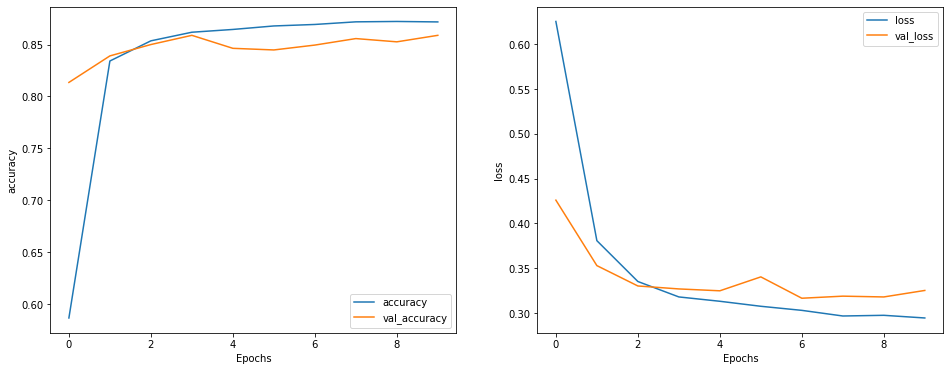

In [27]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interestied in building custom RNNs, see the [Keras RNN Guide](https://www.tensorflow.org/guide/keras/rnn).
